In [96]:
import pandas as pd
import sys
import datetime
import numpy
import numpy as np 
import scipy as sc
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV  
from sklearn.model_selection import learning_curve

import xgboost as xgb

In [97]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True,sort = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 30 columns):
AF               1849 non-null object
AGD              1900 non-null float64
AGL              1900 non-null float64
AGS              1900 non-null float64
ALF              1900 non-null float64
AOD              1900 non-null float64
AP               1900 non-null float64
AwayTeam         1900 non-null object
DOD              1900 non-null float64
DP               1900 non-null float64
DPB              1900 non-null float64
Day              1900 non-null int64
DaysFromToday    1900 non-null int64
FTR              1900 non-null object
GD               1900 non-null float64
HF               1849 non-null object
HGD              1900 non-null float64
HGL              1900 non-null float64
HGS              1900 non-null float64
HLF              1900 non-null float64
HOD              1900 non-null float64
HP               1900 non-null float64
HomeTeam         1900 non-null object
LFD  

In [98]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

In [99]:
#Czy entropia ma zwiazek z korelacja ??
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for column in col:
    print (column+':')
    print (ent(df[column]))

AF:
5.4637128749066965
AGD:
4.034538120028026
AGL:
4.076947202541234
AGS:
4.120178258670849
ALF:
1.101594198615197
AOD:
5.583542197296875
AP:
4.127395006248317
AwayTeam:
3.214025432660123
DOD:
4.9272143445038825
DP:
3.9963022264057675
DPB:
1.9810508264132523
Day:
3.411488443979931
DaysFromToday:
5.028834887303477
GD:
4.375121010889942
HF:
5.452259711268861
HGD:
4.033415363722988
HGL:
4.07073187556612
HGS:
4.115141849299441
HLF:
1.1583623863703438
HOD:
4.9507078838772856
HP:
4.138017477518469
HomeTeam:
3.214025432660123
LFD:
1.7151038963213336
LSTPA:
2.830940430253775
LSTPD:
3.5334379243833016
LSTPH:
2.830940430253775
MW:
3.6375861597263865
Month:
2.2795702675164633
Year:
1.7403156218734193


In [100]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)    
    
    form_code = df.HF.unique()
    form_code2 = df.AF.unique()
    form_code = numpy.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF'] = to_code['HF']
    df['AF'] = to_code['AF']

    return df

df = code_string_values(df)

In [101]:
col = ['AF','AGD','AGL','AGS','ALF','AOD','AP','AwayTeam','DOD','DP','DPB','Day','DaysFromToday',
       'GD','HF','HGD','HGL','HGS','HLF','HOD','HP','HomeTeam','LFD','LSTPA','LSTPD','LSTPH','MW','Month','Year']
for c in col:
    print(c)
    print(df['FTR'].corr(df[c],method='spearman'))

AF
0.0024375491823891296
AGD
-0.2542298759134714
AGL
0.12058728582328944
AGS
-0.070180333373741
ALF
-0.12140291670995883
AOD
0.07546299887956254
AP
-0.07258832027993237
AwayTeam
0.10178349237191826
DOD
0.010929363473138562
DP
0.3359437632025874
DPB
0.21297806331652908
Day
-0.02743209232605637
DaysFromToday
-0.0424970529961861
GD
0.3473920593136676
HF
-0.000771381372999303
HGD
0.22805554435975087
HGL
-0.03011041291035953
HGS
0.15352415771225053
HLF
0.11330007043568117
HOD
-0.05047289217661438
HP
0.14948550356608611
HomeTeam
-0.14095992343470004
LFD
0.1701099476001538
LSTPA
0.25684972082438673
LSTPD
-0.34425916752301944
LSTPH
-0.2516956295161356
MW
0.04208294717321561
Month
-0.0031647235528357042
Year
0.023986770447081876


C:\Users\Grzesiek\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [102]:
def code_FTR(df):
    result_code = df.FTR.unique()
    result_code = dict(zip(result_code, range(len(result_code))))
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

In [103]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5429
Accuracy of logistic regression classifier on test set: 0.5474
Confusion matrix: 
[[216  50   2]
 [ 83  93   5]
 [ 71  47   3]]
Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.81      0.68       268
          1       0.49      0.51      0.50       181
          2       0.30      0.02      0.05       121

avg / total       0.49      0.55      0.49       570



In [104]:
df_copy = df.copy()
df_copy = code_FTR(df_copy) 
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5323
Accuracy of logistic regression classifier on test set: 0.5421
Confusion matrix: 
[[219  49   0]
 [ 91  90   0]
 [ 78  43   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.56      0.82      0.67       268
          1       0.49      0.50      0.50       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
#TODO it's use Linear Regression, test another methods
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

rfe = RFE(LogisticRegression(), 10)
fit = rfe.fit(X, y)
f = rfe.get_support(1)
print(rfe.ranking_)
print(df_copy.info())
df_copy.columns[f]

[19 10 18  7  9  1 11  8  1 16 14 13 15  1 20 12  1  3  1  1  2  1  1  5
  1  6  1  4 17]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 30 columns):
AF               1900 non-null int64
AGD              1900 non-null float64
AGL              1900 non-null float64
AGS              1900 non-null float64
ALF              1900 non-null float64
AOD              1900 non-null float64
AP               1900 non-null float64
AwayTeam         1900 non-null int64
DOD              1900 non-null float64
DP               1900 non-null float64
DPB              1900 non-null float64
Day              1900 non-null int64
DaysFromToday    1900 non-null int64
FTR              1900 non-null object
GD               1900 non-null float64
HF               1900 non-null int64
HGD              1900 non-null float64
HGL              1900 non-null float64
HGS              1900 non-null float64
HLF              1900 non-null float64
HOD              1900 non-null flo

Index(['AOD', 'DOD', 'FTR', 'HGD', 'HGS', 'HLF', 'HP', 'HomeTeam', 'LSTPA',
       'LSTPH'],
      dtype='object')

In [106]:
df_copy.drop(df_copy.columns[f], inplace=True, axis=1)
df_copy = code_FTR(df)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5429
Accuracy of logistic regression classifier on test set: 0.5474
Confusion matrix: 
[[216  50   2]
 [ 83  93   5]
 [ 71  47   3]]
Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.81      0.68       268
          1       0.49      0.51      0.50       181
          2       0.30      0.02      0.05       121

avg / total       0.49      0.55      0.49       570



In [107]:
def remove_outliers(column):
    elements = numpy.array(df[column])
    
    mean = numpy.mean(elements, axis=0)
    sd = numpy.std(elements, axis=0)
    
    final_list = [x for x in numpy.array(df[column]) if (x > mean - 4 * sd)]
    return [x for x in final_list if (x < mean + 4 * sd)]

def remove_outliers_for_FTR(df_copy):
    df_copy_Home = df_copy[df_copy['FTR'].isin(['H'])]
    df_copy_Draw = df_copy[df_copy['FTR'].isin(['D'])]
    df_copy_Away = df_copy[df_copy['FTR'].isin(['A'])]

    columns = ['DP','GD']

    for c in columns :
        df_copy_Home = df_copy_Home[df_copy_Home[c].isin(remove_outliers(c))]
        df_copy_Draw = df_copy_Draw[df_copy_Draw[c].isin(remove_outliers(c))]
        df_copy_Away = df_copy_Away[df_copy_Away[c].isin(remove_outliers(c))]
    
    filepaths = [df_copy_Home,df_copy_Draw,df_copy_Away]
    return pd.concat(filepaths,ignore_index=True,sort = True)

In [108]:
df_copy = df.copy()
df_copy = remove_outliers_for_FTR(df_copy)
df_copy = code_FTR(df_copy)  

#TODO use auto Feature Selection
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5336
Accuracy of logistic regression classifier on test set: 0.5343
Confusion matrix: 
[[219   0  44]
 [ 94   0  35]
 [ 92   0  85]]
Classification report: 
             precision    recall  f1-score   support

          0       0.54      0.83      0.66       263
          1       0.00      0.00      0.00       129
          2       0.52      0.48      0.50       177

avg / total       0.41      0.53      0.46       569



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


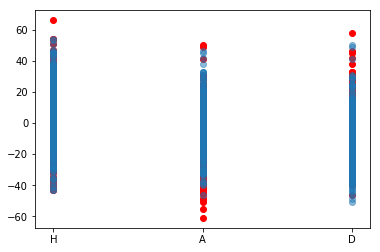

In [109]:
plt.scatter(df['FTR'], df['DP'], color= 'red')
plt.scatter(df_copy['FTR'], df_copy['DP'],alpha=0.5)
plt.show()

In [110]:
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

df_copy = df.copy()
df_copy = code_FTR(df_copy) 

df_copy.GD,b=discretize(df_copy.GD,50)
df_copy.DP,b=discretize(df_copy.DP,50)

#TODO use auto Feature Selection
df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5301
Accuracy of logistic regression classifier on test set: 0.5351
Confusion matrix: 
[[209  59   0]
 [ 85  96   0]
 [ 70  51   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.57      0.78      0.66       268
          1       0.47      0.53      0.50       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
df_copy = df.copy()
df_copy = code_FTR(df_copy)  

df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid)
model_lr.fit(X_train, y_train)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the 

The best found score and model:
0.538345864661654 {'multi_class': 'ovr', 'C': 0.001, 'penalty': 'l2', 'class_weight': None, 'solver': 'newton-cg'}


In [112]:
df_copy = df.copy()
df_copy = code_FTR(df_copy)  

df_copy = df_copy[['LSTPD','DP','GD','FTR']]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


classifier = LogisticRegression(C= 0.001,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'newton-cg') 
classifier.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(X_test, y_test)))

y_pred = classifier.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on train set: 0.5368
Accuracy of logistic regression classifier on test set: 0.5439
Confusion matrix: 
[[221  47   0]
 [ 92  89   0]
 [ 77  44   0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.57      0.82      0.67       268
          1       0.49      0.49      0.49       181
          2       0.00      0.00      0.00       121

avg / total       0.42      0.54      0.47       570



C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


<module 'matplotlib.pyplot' from 'C:\\Users\\Grzesiek\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

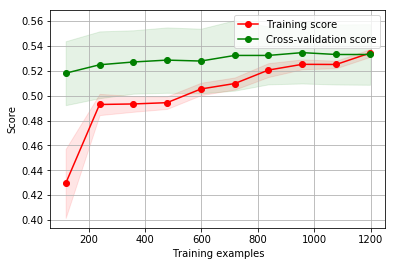

In [113]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve( LogisticRegression(C= 0.001,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'newton-cg'), X_train, y_train )

In [114]:
df_copy = df.copy()

df_copy = code_string_values(df_copy)
df_copy = remove_outliers_for_FTR(df_copy) 

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = xgb.XGBClassifier(subsample= 0.9, gamma= 3, min_child_weight= 1, colsample_bytree= 0.9, max_depth= 4,learning_rate=0.35)
eval_set = [(X_test, y_test)]
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="merror", eval_set=eval_set, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy of xgBoost on train set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
print('Accuracy of xgBoost on test set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))

y_pred = clf.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

[0]	validation_0-merror:0.472759
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.435852
[2]	validation_0-merror:0.44464
[3]	validation_0-merror:0.455185
[4]	validation_0-merror:0.467487
[5]	validation_0-merror:0.465729
[6]	validation_0-merror:0.476274
[7]	validation_0-merror:0.472759
[8]	validation_0-merror:0.471002
[9]	validation_0-merror:0.469244
[10]	validation_0-merror:0.471002
[11]	validation_0-merror:0.479789
[12]	validation_0-merror:0.476274
[13]	validation_0-merror:0.476274
[14]	validation_0-merror:0.465729
[15]	validation_0-merror:0.455185
[16]	validation_0-merror:0.458699
[17]	validation_0-merror:0.469244
[18]	validation_0-merror:0.472759
[19]	validation_0-merror:0.469244
[20]	validation_0-merror:0.462214
[21]	validation_0-merror:0.462214
Stopping. Best iteration:
[1]	validation_0-merror:0.435852

Accuracy of xgBoost on train set: 56.4148
Accuracy of xgBoost on test set: 56.4148
Confusion matrix: 
[[ 81  17  79]
 [ 28  17  84]
 [ 2

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                         fit_params={'early_stopping_rounds':20,\
                         'eval_set':[(X,y)]},cv=5)
grid_obj.fit(X_train, y_train)
tree_model = grid_obj.best_estimator_
print (grid_obj.best_score_, grid_obj.best_params_) 

[0]	validation_0-merror:0.458289
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449314
[2]	validation_0-merror:0.440866
[3]	validation_0-merror:0.440338
[4]	validation_0-merror:0.444034
[5]	validation_0-merror:0.439282
[6]	validation_0-merror:0.432946
[7]	validation_0-merror:0.435058
[8]	validation_0-merror:0.431362
[9]	validation_0-merror:0.420275
[10]	validation_0-merror:0.418163
[11]	validation_0-merror:0.416051
[12]	validation_0-merror:0.413939
[13]	validation_0-merror:0.408131
[14]	validation_0-merror:0.401795
[15]	validation_0-merror:0.397043
[16]	validation_0-merror:0.395987
[17]	validation_0-merror:0.387012
[18]	validation_0-merror:0.383844
[19]	validation_0-merror:0.390707
[20]	validation_0-merror:0.3849
[21]	validation_0-merror:0.3849
[22]	validation_0-merror:0.387012
[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.3717
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.3648

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.348469
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.327878
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.304646
[46]	validation_0-merror:0.30095
[47]	validation_0-merror:0.298838
[48]	validation_0-merror:0.297254
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.293031
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.293031
[53]	validation_0-merror:0.286695
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.348469
[30]	validation_0-merror:0.346885
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.333685
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.304118
[48]	validation_0-merror:0.302006
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.299894
[51]	validation_0-merror:0.293031
[52]	validation_0-merror:0.299366
[53]	validation_0-merror:0.293031
[54]	validation_0-merror:0.296726
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.351637
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.340549
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.328405
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.300422
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.303062
[50]	validation_0-merror:0.30623
[51]	validation_0-merror:0.29831
[52]	validation_0-merror:0.296199
[53]	validation_0-merror:0.293559
[54]	validation_0-merror:0.287751
[55]	validation_0-merror:0.293031
[56]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.345301
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.332629
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.326294
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.307286
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.300422
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.296199
[51]	validation_0-merror:0.297254
[52]	validation_0-merror:0.289863
[53]	validation_0-merror:0.288279
[54]	validation_0-merror:0.290391
[55]	validation_0-merror:0.287223
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.360612
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.341605
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.336853
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.313094
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.303062
[46]	validation_0-merror:0.301478
[47]	validation_0-merror:0.297782
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.291975
[50]	validation_0-merror:0.292503
[51]	validation_0-merror:0.291447
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.321014
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.310454
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.304646
[40]	validation_0-merror:0.303062
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.295143
[43]	validation_0-merror:0.291975
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.288279
[46]	validation_0-merror:0.289863
[47]	validation_0-merror:0.288807
[48]	validation_0-merror:0.289335
[49]	validation_0-merror:0.286167
[50]	validation_0-merror:0.286167
[51]	validation_0-merror:0.281415
[52]	validation_0-merror:0.283527
[53]	validation_0-merror:0.280359
[54]	validation_0-merror:0.279303
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.310982
[36]	validation_0-merror:0.30887
[37]	validation_0-merror:0.30887
[38]	validation_0-merror:0.304646
[39]	validation_0-merror:0.301478
[40]	validation_0-merror:0.29831
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.290391
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.293031
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.284055
[51]	validation_0-merror:0.281943
[52]	validation_0-merror:0.278775
[53]	validation_0-merror:0.275079
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.348469
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.328933
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.309926
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.286695
[50]	validation_0-merror:0.284055
[51]	validation_0-merror:0.283527
[52]	validation_0-merror:0.276135
[53]	validation_0-merror:0.276663
[54]	validation_0-merror:0.276135
[55]	validation_0-merror:0.276135
[56]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.355333
[27]	validation_0-merror:0.356389
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.333685
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.325238
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.297782
[51]	validation_0-merror:0.300422
[52]	validation_0-merror:0.296199
[53]	validation_0-merror:0.291975
[54]	validation_0-merror:0.285111
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.355861
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.336853
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.336853
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.316262
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.317318
[44]	validation_0-merror:0.308342
[45]	validation_0-merror:0.306758
[46]	validation_0-merror:0.305702
[47]	validation_0-merror:0.30095
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.294087
[51]	validation_0-merror:0.291975
[52]	validation_0-merror:0.293031
[53]	validation_0-merror:0.288279
[54]	validation_0-merror:0.288279
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.343717
[29]	validation_0-merror:0.341605
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.302006
[45]	validation_0-merror:0.30095
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.286167
[50]	validation_0-merror:0.286167
[51]	validation_0-merror:0.284055
[52]	validation_0-merror:0.285639
[53]	validation_0-merror:0.279303
[54]	validation_0-merror:0.280359
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.308342
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.302534
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.298838
[47]	validation_0-merror:0.294087
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.290919
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.289335
[52]	validation_0-merror:0.286695
[53]	validation_0-merror:0.285111
[54]	validation_0-merror:0.284583
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.317846
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.309398
[47]	validation_0-merror:0.305702
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.30359
[50]	validation_0-merror:0.300422
[51]	validation_0-merror:0.296726
[52]	validation_0-merror:0.295671
[53]	validation_0-merror:0.295671
[54]	validation_0-merror:0.293559
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.341077
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.341077
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.334741
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.312566
[42]	validation_0-merror:0.31415
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.310982
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.297254
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.296199
[51]	validation_0-merror:0.292503
[52]	validation_0-merror:0.296726
[53]	validation_0-merror:0.297254
[54]	validation_0-merror:0.292503
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.381204
[26]	validation_0-merror:0.381732
[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.37434
[30]	validation_0-merror:0.368532
[31]	validation_0-merror:0.363252
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.343717
[38]	validation_0-merror:0.348997
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.343189
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.341605
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.335269
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.329461
[50]	validation_0-merror:0.32207
[51]	validation_0-merror:0.325766
[52]	validation_0-merror:0.321014
[53]	validation_0-merror:0.32207
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.357445
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.338965
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.321542
[44]	validation_0-merror:0.315206
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.307286
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.310454
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.303062
[52]	validation_0-merror:0.301478
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.357445
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.355861
[30]	validation_0-merror:0.346885
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.343717
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.327878
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.32735
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.321542
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.320486
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.317318
[51]	validation_0-merror:0.310982
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.375396
[25]	validation_0-merror:0.380676
[26]	validation_0-merror:0.380676
[27]	validation_0-merror:0.371172
[28]	validation_0-merror:0.370116
[29]	validation_0-merror:0.368532
[30]	validation_0-merror:0.373284
[31]	validation_0-merror:0.366948
[32]	validation_0-merror:0.364308
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.332101
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.323654
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.314678
[50]	validation_0-merror:0.313622
[51]	validation_0-merror:0.310454
[52]	validation_0-merror:0.30359
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.357973
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.357445
[36]	validation_0-merror:0.353749
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.342661
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.341077
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.335797
[46]	validation_0-merror:0.332629
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.325238
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.32207
[51]	validation_0-merror:0.325238
[52]	validation_0-merror:0.321014
[53]	validation_0-merror:0.313622
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.374868
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.360084
[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.343189
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.335797
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.329461
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.322598
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.305702
[48]	validation_0-merror:0.30095
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.30359
[51]	validation_0-merror:0.299894
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.359556
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.341077
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.30095
[44]	validation_0-merror:0.301478
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.295143
[47]	validation_0-merror:0.295671
[48]	validation_0-merror:0.291975
[49]	validation_0-merror:0.287751
[50]	validation_0-merror:0.285639
[51]	validation_0-merror:0.277719
[52]	validation_0-merror:0.277191
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.356389
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.330517
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.31151
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.30623
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.301478
[50]	validation_0-merror:0.296199
[51]	validation_0-merror:0.29831
[52]	validation_0-merror:0.29831
[53]	validation_0-merror:0.294087
[54]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.360084
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.342133
[31]	validation_0-merror:0.338965
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.330517
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.325238
[38]	validation_0-merror:0.321542
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.314678
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.307286
[48]	validation_0-merror:0.30623
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.30095
[51]	validation_0-merror:0.296726
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.355333
[26]	validation_0-merror:0.350581
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.350581
[29]	validation_0-merror:0.350581
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.335269
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.321014
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.316262
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.309926
[52]	validation_0-merror:0.307286
[53]	validation_0-merror:0.305174
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.337909
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331573
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.32735
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.31679
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.31151
[52]	validation_0-merror:0.303062
[53]	validation_0-merror:0.297782
[54]	validation_0-merror:0.296199
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.32471
[33]	validation_0-merror:0.325766
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.321014
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.297782
[46]	validation_0-merror:0.293031
[47]	validation_0-merror:0.292503
[48]	validation_0-merror:0.291447
[49]	validation_0-merror:0.288279
[50]	validation_0-merror:0.285639
[51]	validation_0-merror:0.282999
[52]	validation_0-merror:0.277719
[53]	validation_0-merror:0.279303
[54]	validation_0-merror:0.277191
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.348469
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.332101
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.299366
[48]	validation_0-merror:0.297782
[49]	validation_0-merror:0.293559
[50]	validation_0-merror:0.293031
[51]	validation_0-merror:0.289335
[52]	validation_0-merror:0.285639
[53]	validation_0-merror:0.284583
[54]	validation_0-merror:0.287751
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.354805
[29]	validation_0-merror:0.353221
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.340549
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.325238
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.309926
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.305702
[48]	validation_0-merror:0.30359
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.301478
[52]	validation_0-merror:0.301478
[53]	validation_0-merror:0.299894
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.333157
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.328405
[43]	validation_0-merror:0.329461
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.31943
[47]	validation_0-merror:0.320486
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.307814
[52]	validation_0-merror:0.31151
[53]	validation_0-merror:0.306758
[54]	validation_0-merror:0.304646
[55]	validation_0-merror:0.30359
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.389124
[27]	validation_0-merror:0.38226
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.376452
[30]	validation_0-merror:0.3717
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.36906
[34]	validation_0-merror:0.371172
[35]	validation_0-merror:0.370116
[36]	validation_0-merror:0.362196
[37]	validation_0-merror:0.359029
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.348997
[40]	validation_0-merror:0.352165
[41]	validation_0-merror:0.348469
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.347941
[44]	validation_0-merror:0.344245
[45]	validation_0-merror:0.345301
[46]	validation_0-merror:0.344245
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.341605
[49]	validation_0-merror:0.342661
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.337381
[52]	validation_0-merror:0.337909
[53]	validation_0-merror:0.333157
[54]	validation_0-merror:0.333157
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.375396
[25]	validation_0-merror:0.374868
[26]	validation_0-merror:0.373812
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.373284
[29]	validation_0-merror:0.375924
[30]	validation_0-merror:0.372756
[31]	validation_0-merror:0.372228
[32]	validation_0-merror:0.370116
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.360612
[35]	validation_0-merror:0.363252
[36]	validation_0-merror:0.361668
[37]	validation_0-merror:0.360612
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.352165
[40]	validation_0-merror:0.353749
[41]	validation_0-merror:0.354277
[42]	validation_0-merror:0.356389
[43]	validation_0-merror:0.353221
[44]	validation_0-merror:0.351637
[45]	validation_0-merror:0.347941
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.340549
[49]	validation_0-merror:0.341605
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.329461
[52]	validation_0-merror:0.333157
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.38226
[25]	validation_0-merror:0.37698
[26]	validation_0-merror:0.378564
[27]	validation_0-merror:0.374868
[28]	validation_0-merror:0.37962
[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.367476
[31]	validation_0-merror:0.3717
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.357973
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.347413
[38]	validation_0-merror:0.350581
[39]	validation_0-merror:0.352693
[40]	validation_0-merror:0.353221
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.341605
[43]	validation_0-merror:0.338965
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.338437
[46]	validation_0-merror:0.334741
[47]	validation_0-merror:0.329989
[48]	validation_0-merror:0.331573
[49]	validation_0-merror:0.331573
[50]	validation_0-merror:0.329989
[51]	validation_0-merror:0.326822
[52]	validation_0-merror:0.329461
[53]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.379092
[25]	validation_0-merror:0.374868
[26]	validation_0-merror:0.378036
[27]	validation_0-merror:0.374868
[28]	validation_0-merror:0.376452
[29]	validation_0-merror:0.375924
[30]	validation_0-merror:0.368004
[31]	validation_0-merror:0.368532
[32]	validation_0-merror:0.360084
[33]	validation_0-merror:0.355861
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.345829
[38]	validation_0-merror:0.341077
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.341077
[44]	validation_0-merror:0.336853
[45]	validation_0-merror:0.334213
[46]	validation_0-merror:0.331573
[47]	validation_0-merror:0.329461
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.332101
[51]	validation_0-merror:0.332629
[52]	validation_0-merror:0.329461
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.383316
[26]	validation_0-merror:0.386484
[27]	validation_0-merror:0.381732
[28]	validation_0-merror:0.380148
[29]	validation_0-merror:0.377508
[30]	validation_0-merror:0.373284
[31]	validation_0-merror:0.375924
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.364836
[34]	validation_0-merror:0.357973
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.346357
[38]	validation_0-merror:0.348997
[39]	validation_0-merror:0.350581
[40]	validation_0-merror:0.352165
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.338965
[45]	validation_0-merror:0.333157
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.32471
[51]	validation_0-merror:0.325238
[52]	validation_0-merror:0.328933
[53]	validation_0-merror:0.325238
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.36906
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.348997
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.332629
[47]	validation_0-merror:0.327878
[48]	validation_0-merror:0.32735
[49]	validation_0-merror:0.324182
[50]	validation_0-merror:0.324182
[51]	validation_0-merror:0.321014
[52]	validation_0-merror:0.316262
[53]	validation_0-merror:0.315206
[54]	validation_0-merror:0.310982
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.365364
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.32735
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.31415
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.315206
[49]	validation_0-merror:0.310982
[50]	validation_0-merror:0.307814
[51]	validation_0-merror:0.307286
[52]	validation_0-merror:0.306758
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.360612
[25]	validation_0-merror:0.360612
[26]	validation_0-merror:0.362724
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.347413
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.331045
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.32471
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.321014
[49]	validation_0-merror:0.31943
[50]	validation_0-merror:0.319958
[51]	validation_0-merror:0.318902
[52]	validation_0-merror:0.322598
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.369588
[25]	validation_0-merror:0.365892
[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.350581
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.349525
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.326822
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.319958
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.31151
[52]	validation_0-merror:0.309926
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.334741
[43]	validation_0-merror:0.335797
[44]	validation_0-merror:0.331573
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.32471
[47]	validation_0-merror:0.320486
[48]	validation_0-merror:0.318374
[49]	validation_0-merror:0.319958
[50]	validation_0-merror:0.32207
[51]	validation_0-merror:0.322598
[52]	validation_0-merror:0.31943
[53]	validation_0-merror:0.317846
[54]	validation_0-merror:0.316262
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.376452
[26]	validation_0-merror:0.379092
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.352693
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.334741
[44]	validation_0-merror:0.331573
[45]	validation_0-merror:0.333157
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.322598
[49]	validation_0-merror:0.32207
[50]	validation_0-merror:0.320486
[51]	validation_0-merror:0.324182
[52]	validation_0-merror:0.317318
[53]	validation_0-merror:0.314678
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.343189
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.312566
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.29831
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.293031
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.291975
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.293031
[53]	validation_0-merror:0.288807
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.358501
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.32471
[47]	validation_0-merror:0.323126
[48]	validation_0-merror:0.321014
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.317846
[52]	validation_0-merror:0.313094
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.365364
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.357973
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.353749
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.337381
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.324182
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.322598
[48]	validation_0-merror:0.31943
[49]	validation_0-merror:0.315206
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.309398
[52]	validation_0-merror:0.309926
[53]	validation_0-merror:0.312038
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.374868
[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.373812
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.319958
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.310982
[51]	validation_0-merror:0.312566
[52]	validation_0-merror:0.313622
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.317318
[22]	validation_0-merror:0.310454
[23]	validation_0-merror:0.302534
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.29831
[26]	validation_0-merror:0.302006
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.283527
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.263992
[38]	validation_0-merror:0.257656
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.25396
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.255016
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.24868
[46]	validation_0-merror:0.248152
[47]	validation_0-merror:0.249208
[48]	validation_0-merror:0.245512
[49]	validation_0-merror:0.240232
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.297254
[24]	validation_0-merror:0.292503
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.288279
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.282471
[29]	validation_0-merror:0.281415
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.267159
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.255016
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.249208
[46]	validation_0-merror:0.250264
[47]	validation_0-merror:0.244984
[48]	validation_0-merror:0.2434
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.29831
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.287751
[26]	validation_0-merror:0.284583
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.265575
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.260824
[35]	validation_0-merror:0.256072
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.25132
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.247096
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.241816
[43]	validation_0-merror:0.237064
[44]	validation_0-merror:0.237064
[45]	validation_0-merror:0.23548
[46]	validation_0-merror:0.236008
[47]	validation_0-merror:0.23548
[48]	validation_0-merror:0.234952
[49]	validation_0-merror:0.231785
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.300422
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.305174
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.293031
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.285111
[30]	validation_0-merror:0.279303
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.266631
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.255016
[38]	validation_0-merror:0.247096
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.249736
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.245512
[43]	validation_0-merror:0.2434
[44]	validation_0-merror:0.243928
[45]	validation_0-merror:0.239176
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.23812
[48]	validation_0-merror:0.238648
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.317846
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.30095
[26]	validation_0-merror:0.296726
[27]	validation_0-merror:0.292503
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.281415
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.276663
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.260296
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.252904
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.245512
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.24076
[47]	validation_0-merror:0.238648
[48]	validation_0-merror:0.239176
[49]	validation_0-merror:0.239704
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.304118
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.287751
[25]	validation_0-merror:0.284583
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.278247
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.271383
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.260296
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.252904
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.24076
[42]	validation_0-merror:0.2434
[43]	validation_0-merror:0.242344
[44]	validation_0-merror:0.238648
[45]	validation_0-merror:0.240232
[46]	validation_0-merror:0.237064
[47]	validation_0-merror:0.236536
[48]	validation_0-merror:0.236536
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.282999
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.275079
[25]	validation_0-merror:0.271383
[26]	validation_0-merror:0.271911
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.26452
[29]	validation_0-merror:0.256072
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.250264
[32]	validation_0-merror:0.246568
[33]	validation_0-merror:0.241816
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.237592
[36]	validation_0-merror:0.236008
[37]	validation_0-merror:0.240232
[38]	validation_0-merror:0.241288
[39]	validation_0-merror:0.23548
[40]	validation_0-merror:0.231785
[41]	validation_0-merror:0.232313
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.230201
[44]	validation_0-merror:0.226505
[45]	validation_0-merror:0.228617
[46]	validation_0-merror:0.224921
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.223337
[49]	validation_0-merror:0.220697
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.294615
[20]	validation_0-merror:0.296726
[21]	validation_0-merror:0.279831
[22]	validation_0-merror:0.284055
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.276663
[25]	validation_0-merror:0.270327
[26]	validation_0-merror:0.270327
[27]	validation_0-merror:0.265575
[28]	validation_0-merror:0.266103
[29]	validation_0-merror:0.261352
[30]	validation_0-merror:0.258184
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.252376
[34]	validation_0-merror:0.252376
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.2434
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.2434
[39]	validation_0-merror:0.242872
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.236536
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.236008
[46]	validation_0-merror:0.236008
[47]	validation_0-merror:0.233897
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.307814
[19]	validation_0-merror:0.307286
[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.291975
[22]	validation_0-merror:0.288807
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.259768
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.256072
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.24604
[39]	validation_0-merror:0.244984
[40]	validation_0-merror:0.242872
[41]	validation_0-merror:0.240232
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.23548
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.228617
[46]	validation_0-merror:0.225449
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.286695
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.285111
[28]	validation_0-merror:0.279831
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.275079
[31]	validation_0-merror:0.270327
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.244456
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.237592
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.23548
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.230729
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.319958
[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.302534
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.291975
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.275079
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.260296
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.25132
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.247624
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.246568
[45]	validation_0-merror:0.247096
[46]	validation_0-merror:0.244456
[47]	validation_0-merror:0.243928
[48]	validation_0-merror:0.24604
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.288279
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.268743
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.247624
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.242344
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.231257
[43]	validation_0-merror:0.229673
[44]	validation_0-merror:0.231257
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.229673
[48]	validation_0-merror:0.227561
[49]	validation_0-merror:0.221753
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.295143
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.284055
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.274023
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.261352
[29]	validation_0-merror:0.261352
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.258184
[32]	validation_0-merror:0.2566
[33]	validation_0-merror:0.252376
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.244984
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.238648
[39]	validation_0-merror:0.23812
[40]	validation_0-merror:0.231785
[41]	validation_0-merror:0.232841
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.231257
[44]	validation_0-merror:0.226505
[45]	validation_0-merror:0.227033
[46]	validation_0-merror:0.228617
[47]	validation_0-merror:0.229145
[48]	validation_0-merror:0.229673
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.273495
[26]	validation_0-merror:0.271911
[27]	validation_0-merror:0.269271
[28]	validation_0-merror:0.26452
[29]	validation_0-merror:0.260824
[30]	validation_0-merror:0.256072
[31]	validation_0-merror:0.2566
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.255544
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.243928
[38]	validation_0-merror:0.24076
[39]	validation_0-merror:0.239176
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.236536
[44]	validation_0-merror:0.234952
[45]	validation_0-merror:0.237064
[46]	validation_0-merror:0.236008
[47]	validation_0-merror:0.233369
[48]	validation_0-merror:0.230201
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.30095
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.266103
[32]	validation_0-merror:0.265575
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.258712
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.25396
[41]	validation_0-merror:0.249736
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.249736
[44]	validation_0-merror:0.250264
[45]	validation_0-merror:0.25132
[46]	validation_0-merror:0.250792
[47]	validation_0-merror:0.249208
[48]	validation_0-merror:0.244456
[49]	validation_0-merror:0.237064
[50]	validation_0-merror:0.23548
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.332101
[22]	validation_0-merror:0.333685
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.328405
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.321014
[31]	validation_0-merror:0.310454
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.298838
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.296199
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.286167
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.277719
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.270327
[47]	validation_0-merror:0.269271
[48]	validation_0-merror:0.265048
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.359029
[17]	validation_0-merror:0.36114
[18]	validation_0-merror:0.347941
[19]	validation_0-merror:0.348997
[20]	validation_0-merror:0.350581
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.342133
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.317846
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.297782
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.285639
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.266631
[44]	validation_0-merror:0.268743
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.284583
[32]	validation_0-merror:0.282471
[33]	validation_0-merror:0.278775
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.271383
[39]	validation_0-merror:0.268743
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.26452
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.262408
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.258184
[47]	validation_0-merror:0.258712
[48]	validation_0-merror:0.252904
[49]	validation_0-merror:0.250792
[50]	validation_0-merror:0.257656
[51]	validation_0-merror:0.249736
[52]	validation_0-merror:0.252376
[53]	validation_0-merror:0.250792
[54]	validation_0-merror:0.249736
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.31679
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.29831
[32]	validation_0-merror:0.29831
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.290919
[35]	validation_0-merror:0.288279
[36]	validation_0-merror:0.289335
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.285639
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.280359
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.271383
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.263992
[47]	validation_0-merror:0.260824
[48]	validation_0-merror:0.262408
[49]	validation_0-merror:0.258184
[50]	validation_0-merror:0.257128
[51]	validation_0-merror:0.255544
[52]	validation_0-merror:0.255016
[53]	validation_0-merror:0.247096
[54]	validation_0-merror:0.248152
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.327878
[27]	validation_0-merror:0.32735
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.325238
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.308342
[33]	validation_0-merror:0.305174
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.286167
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.281415
[42]	validation_0-merror:0.276663
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.269271
[47]	validation_0-merror:0.266103
[48]	validation_0-merror:0.263992
[49]	validation_0-merror:0.262936
[50]	validation_0-merror:0.261352
[51]	validation_0-merror:0.263464
[52]	validation_0-merror:0.263464
[53]	validation_0-merror:0.25924
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.288279
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.286167
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.282471
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.281943
[38]	validation_0-merror:0.279303
[39]	validation_0-merror:0.278247
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.268743
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.263464
[48]	validation_0-merror:0.2566
[49]	validation_0-merror:0.257128
[50]	validation_0-merror:0.25396
[51]	validation_0-merror:0.253432
[52]	validation_0-merror:0.249736
[53]	validation_0-merror:0.253432
[54]	validation_0-merror:0.255016
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.296199
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.282471
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.272967
[35]	validation_0-merror:0.272967
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.268215
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.262936
[42]	validation_0-merror:0.260824
[43]	validation_0-merror:0.259768
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.245512
[46]	validation_0-merror:0.242344
[47]	validation_0-merror:0.242344
[48]	validation_0-merror:0.245512
[49]	validation_0-merror:0.245512
[50]	validation_0-merror:0.242872
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.298838
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.294087
[28]	validation_0-merror:0.292503
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.281943
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.259768
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.25396
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.246568
[47]	validation_0-merror:0.244456
[48]	validation_0-merror:0.24076
[49]	validation_0-merror:0.241816
[50]	validation_0-merror:0.234425
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.315206
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.288279
[29]	validation_0-merror:0.285111
[30]	validation_0-merror:0.283527
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.252376
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.24868
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.247096
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.241288
[48]	validation_0-merror:0.23548
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.318902
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.289863
[35]	validation_0-merror:0.286167
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.278247
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.268215
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.258712
[45]	validation_0-merror:0.25924
[46]	validation_0-merror:0.255016
[47]	validation_0-merror:0.257128
[48]	validation_0-merror:0.252376
[49]	validation_0-merror:0.251848
[50]	validation_0-merror:0.24868
[51]	validation_0-merror:0.248152
[52]	validation_0-merror:0.25132
[53]	validation_0-merror:0.25396
[54]	validation_0-merror:0.249208
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.334213
[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.319958
[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.312038
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.300422
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.299894
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.278247
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.274551
[41]	validation_0-merror:0.270855
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.258184
[47]	validation_0-merror:0.255016
[48]	validation_0-merror:0.252904
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.328933
[17]	validation_0-merror:0.320486
[18]	validation_0-merror:0.315206
[19]	validation_0-merror:0.313094
[20]	validation_0-merror:0.306758
[21]	validation_0-merror:0.307286
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.297782
[24]	validation_0-merror:0.289863
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.271911
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.267159
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.251848
[38]	validation_0-merror:0.252376
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.243928
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.240232
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.294615
[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.271383
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.262936
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.252376
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.24868
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.241288
[48]	validation_0-merror:0.24076
[49]	validation_0-merror:0.236536
[50]	validation_0-merror:0.236536
[51]	validation_0-merror:0.239176
[52]	validation_0-merror:0.237592
[53]	validation_0-merror:0.237064
[54]	validation_0-merror:0.236008
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.313622
[21]	validation_0-merror:0.30623
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.300422
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.284583
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.276663
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.24868
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.250264
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.245512
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.321542
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.309398
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.273495
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.268215
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.265575
[40]	validation_0-merror:0.259768
[41]	validation_0-merror:0.261352
[42]	validation_0-merror:0.260296
[43]	validation_0-merror:0.257128
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.254488
[46]	validation_0-merror:0.253432
[47]	validation_0-merror:0.249736
[48]	validation_0-merror:0.247096
[49]	validation_0-merror:0.244984
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.333157
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.32471
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.307286
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.306758
[50]	validation_0-merror:0.302534
[51]	validation_0-merror:0.301478
[52]	validation_0-merror:0.299894
[53]	validation_0-merror:0.300422
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.336853
[28]	validation_0-merror:0.328933
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.329461
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.321542
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.309926
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.295671
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.294087
[46]	validation_0-merror:0.288279
[47]	validation_0-merror:0.289335
[48]	validation_0-merror:0.289863
[49]	validation_0-merror:0.285639
[50]	validation_0-merror:0.285111
[51]	validation_0-merror:0.280887
[52]	validation_0-merror:0.280359
[53]	validation_0-merror:0.277191
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.364308
[19]	validation_0-merror:0.359556
[20]	validation_0-merror:0.357445
[21]	validation_0-merror:0.361668
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.349525
[24]	validation_0-merror:0.350053
[25]	validation_0-merror:0.346885
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.317846
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.31151
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.305702
[46]	validation_0-merror:0.305702
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.332101
[28]	validation_0-merror:0.325238
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.309926
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.30095
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.297782
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.299366
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.295143
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.29831
[49]	validation_0-merror:0.295143
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.295143
[52]	validation_0-merror:0.288279
[53]	validation_0-merror:0.284055
[54]	validation_0-merror:0.285111
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.348469
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.313094
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.307286
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.305174
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.30095
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.290919
[47]	validation_0-merror:0.290391
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.292503
[50]	validation_0-merror:0.291447
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.287223
[53]	validation_0-merror:0.285639
[54]	validation_0-merror:0.286695
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.318374
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.310454
[33]	validation_0-merror:0.312038
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.303062
[36]	validation_0-merror:0.301478
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.295671
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.289863
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.282999
[46]	validation_0-merror:0.279303
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.276135
[49]	validation_0-merror:0.274023
[50]	validation_0-merror:0.274551
[51]	validation_0-merror:0.271383
[52]	validation_0-merror:0.273495
[53]	validation_0-merror:0.267159
[54]	validation_0-merror:0.270327
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.337381
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.309398
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.310454
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.286695
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.275079
[42]	validation_0-merror:0.276663
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.274023
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.272439
[47]	validation_0-merror:0.268215
[48]	validation_0-merror:0.268743
[49]	validation_0-merror:0.263992
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.334741
[25]	validation_0-merror:0.329989
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.317846
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.309398
[31]	validation_0-merror:0.30887
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.305174
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.274551
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.278775
[46]	validation_0-merror:0.275607
[47]	validation_0-merror:0.271911
[48]	validation_0-merror:0.271383
[49]	validation_0-merror:0.271911
[50]	validation_0-merror:0.269271
[51]	validation_0-merror:0.267687
[52]	validation_0-merror:0.266631
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.307814
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.284583
[41]	validation_0-merror:0.281415
[42]	validation_0-merror:0.282999
[43]	validation_0-merror:0.280359
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.275607
[46]	validation_0-merror:0.274023
[47]	validation_0-merror:0.271911
[48]	validation_0-merror:0.269799
[49]	validation_0-merror:0.275607
[50]	validation_0-merror:0.272439
[51]	validation_0-merror:0.269271
[52]	validation_0-merror:0.261352
[53]	validation_0-merror:0.26188
[54]	validation_0-merror:0.26188
[55]	validation_0-merror:0.25132
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.315734
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.310454
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.30095
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.291975
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.279831
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.282999
[47]	validation_0-merror:0.277719
[48]	validation_0-merror:0.271383
[49]	validation_0-merror:0.268743
[50]	validation_0-merror:0.267687
[51]	validation_0-merror:0.263992
[52]	validation_0-merror:0.259768
[53]	validation_0-merror:0.258712
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.298838
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.277719
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.277191
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.270855
[45]	validation_0-merror:0.266103
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.266103
[48]	validation_0-merror:0.263464
[49]	validation_0-merror:0.262936
[50]	validation_0-merror:0.26188
[51]	validation_0-merror:0.25924
[52]	validation_0-merror:0.257656
[53]	validation_0-merror:0.25924
[54]	validation_0-merror:0.257128
[55]	validation_0-merror:0.257128
[56]	validation_0-merror:0.25396
[57]	validation_0-merror:0.255016
[58]	validation_0-merror:0.25396
[59]	validation_0-merror:0.251848
[60]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.307286
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.298838
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.274551
[43]	validation_0-merror:0.272967
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.268215
[46]	validation_0-merror:0.263992
[47]	validation_0-merror:0.263992
[48]	validation_0-merror:0.263464
[49]	validation_0-merror:0.25924
[50]	validation_0-merror:0.262936
[51]	validation_0-merror:0.260824
[52]	validation_0-merror:0.256072
[53]	validation_0-merror:0.258712
[54]	validation_0-merror:0.255544
[55]	validation_0-merror:0.254488
[56]	validation_0-merror:0.254488
[57]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.288807
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.267687
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.267687
[42]	validation_0-merror:0.268215
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.25924
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.2566
[49]	validation_0-merror:0.255544
[50]	validation_0-merror:0.255016
[51]	validation_0-merror:0.255016
[52]	validation_0-merror:0.252904
[53]	validation_0-merror:0.251848
[54]	validation_0-merror:0.249736
[55]	validation_0-merror:0.247624
[56]	validation_0-merror:0.247096
[57]	validation_0-merror:0.246568
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.302534
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.289335
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.271911
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.269271
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.270855
[47]	validation_0-merror:0.266631
[48]	validation_0-merror:0.268215
[49]	validation_0-merror:0.267159
[50]	validation_0-merror:0.263464
[51]	validation_0-merror:0.267687
[52]	validation_0-merror:0.263464
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.310982
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.296726
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.295143
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.287751
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.276663
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.274551
[46]	validation_0-merror:0.270327
[47]	validation_0-merror:0.271911
[48]	validation_0-merror:0.268215
[49]	validation_0-merror:0.269271
[50]	validation_0-merror:0.266631
[51]	validation_0-merror:0.266631
[52]	validation_0-merror:0.262408
[53]	validation_0-merror:0.2566
[54]	validation_0-merror:0.258184
[55]	validation_0-merror:0.258184
[56]	validation_0-merror:0.258184
[57]	validation_0-merror:0.258184
[58]	validation_0-merror:0.256072
[59]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.267687
[23]	validation_0-merror:0.267687
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.261352
[26]	validation_0-merror:0.256072
[27]	validation_0-merror:0.254488
[28]	validation_0-merror:0.250264
[29]	validation_0-merror:0.244456
[30]	validation_0-merror:0.244984
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.239704
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.236008
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.231785
[39]	validation_0-merror:0.227561
[40]	validation_0-merror:0.227561
[41]	validation_0-merror:0.222809
[42]	validation_0-merror:0.225977
[43]	validation_0-merror:0.224921
[44]	validation_0-merror:0.223337
[45]	validation_0-merror:0.219641
[46]	validation_0-merror:0.222809
[47]	validation_0-merror:0.222281
[48]	validation_0-merror:0.220697
[49]	validation_0-merror:0.224393
[50]	validation_0-merror:0.222281
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.25396
[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.244984
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.244984
[28]	validation_0-merror:0.242872
[29]	validation_0-merror:0.2434
[30]	validation_0-merror:0.241816
[31]	validation_0-merror:0.23548
[32]	validation_0-merror:0.239176
[33]	validation_0-merror:0.230729
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.230729
[36]	validation_0-merror:0.228089
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.228617
[39]	validation_0-merror:0.230729
[40]	validation_0-merror:0.229145
[41]	validation_0-merror:0.225977
[42]	validation_0-merror:0.220169
[43]	validation_0-merror:0.222281
[44]	validation_0-merror:0.221225
[45]	validation_0-merror:0.220169
[46]	validation_0-merror:0.221753
[47]	validation_0-merror:0.223865
[48]	validation_0-merror:0.225449
[49]	validation_0-merror:0.223337
[50]	validation_0-merror:0.223337
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.250792
[23]	validation_0-merror:0.252376
[24]	validation_0-merror:0.246568
[25]	validation_0-merror:0.24076
[26]	validation_0-merror:0.237592
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.230729
[29]	validation_0-merror:0.227561
[30]	validation_0-merror:0.229673
[31]	validation_0-merror:0.224921
[32]	validation_0-merror:0.222281
[33]	validation_0-merror:0.224393
[34]	validation_0-merror:0.227033
[35]	validation_0-merror:0.228617
[36]	validation_0-merror:0.228089
[37]	validation_0-merror:0.227561
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.226505
[41]	validation_0-merror:0.223865
[42]	validation_0-merror:0.225449
[43]	validation_0-merror:0.227033
[44]	validation_0-merror:0.222281
[45]	validation_0-merror:0.224393
[46]	validation_0-merror:0.222809
[47]	validation_0-merror:0.222281
[48]	validation_0-merror:0.223337
[49]	validation_0-merror:0.221225
[50]	validation_0-merror:0.222809
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.260296
[23]	validation_0-merror:0.2566
[24]	validation_0-merror:0.252904
[25]	validation_0-merror:0.249208
[26]	validation_0-merror:0.250264
[27]	validation_0-merror:0.243928
[28]	validation_0-merror:0.247096
[29]	validation_0-merror:0.247624
[30]	validation_0-merror:0.240232
[31]	validation_0-merror:0.23812
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.233369
[35]	validation_0-merror:0.234952
[36]	validation_0-merror:0.233369
[37]	validation_0-merror:0.229145
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.231257
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.229145
[42]	validation_0-merror:0.228617
[43]	validation_0-merror:0.225449
[44]	validation_0-merror:0.225449
[45]	validation_0-merror:0.228617
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.232841
[48]	validation_0-merror:0.231257
[49]	validation_0-merror:0.231257
[50]	validation_0-merror:0.229145
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.253432
[23]	validation_0-merror:0.247624
[24]	validation_0-merror:0.248152
[25]	validation_0-merror:0.250264
[26]	validation_0-merror:0.24604
[27]	validation_0-merror:0.24604
[28]	validation_0-merror:0.243928
[29]	validation_0-merror:0.24604
[30]	validation_0-merror:0.24604
[31]	validation_0-merror:0.241288
[32]	validation_0-merror:0.242872
[33]	validation_0-merror:0.244984
[34]	validation_0-merror:0.247624
[35]	validation_0-merror:0.240232
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.234952
[38]	validation_0-merror:0.23548
[39]	validation_0-merror:0.234952
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.237064
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.23812
[45]	validation_0-merror:0.233369
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.232841
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.228617
[50]	validation_0-merror:0.229673
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.25132
[23]	validation_0-merror:0.25132
[24]	validation_0-merror:0.246568
[25]	validation_0-merror:0.2434
[26]	validation_0-merror:0.239704
[27]	validation_0-merror:0.239704
[28]	validation_0-merror:0.239704
[29]	validation_0-merror:0.234952
[30]	validation_0-merror:0.232313
[31]	validation_0-merror:0.233897
[32]	validation_0-merror:0.236008
[33]	validation_0-merror:0.236008
[34]	validation_0-merror:0.237064
[35]	validation_0-merror:0.234952
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.236008
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.23548
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.236536
[48]	validation_0-merror:0.236008
[49]	validation_0-merror:0.237592
[50]	validation_0-merror:0.23812
Stopping. Best iterat

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.229145
[23]	validation_0-merror:0.226505
[24]	validation_0-merror:0.228089
[25]	validation_0-merror:0.217529
[26]	validation_0-merror:0.223337
[27]	validation_0-merror:0.220169
[28]	validation_0-merror:0.216473
[29]	validation_0-merror:0.217001
[30]	validation_0-merror:0.217529
[31]	validation_0-merror:0.214889
[32]	validation_0-merror:0.218057
[33]	validation_0-merror:0.219113
[34]	validation_0-merror:0.214889
[35]	validation_0-merror:0.212777
[36]	validation_0-merror:0.211193
[37]	validation_0-merror:0.210137
[38]	validation_0-merror:0.208553
[39]	validation_0-merror:0.208553
[40]	validation_0-merror:0.210137
[41]	validation_0-merror:0.210665
[42]	validation_0-merror:0.211721
[43]	validation_0-merror:0.209609
[44]	validation_0-merror:0.207497
[45]	validation_0-merror:0.208553
[46]	validation_0-merror:0.209609
[47]	validation_0-merror:0.211721
[48]	validation_0-merror:0.211193
[49]	validation_0-merror:0.211193
[50]	validation_0-merror:0.210137
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.236536
[25]	validation_0-merror:0.238648
[26]	validation_0-merror:0.236008
[27]	validation_0-merror:0.238648
[28]	validation_0-merror:0.230729
[29]	validation_0-merror:0.229673
[30]	validation_0-merror:0.232841
[31]	validation_0-merror:0.232313
[32]	validation_0-merror:0.229145
[33]	validation_0-merror:0.228617
[34]	validation_0-merror:0.227033
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.227033
[37]	validation_0-merror:0.224393
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.224921
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.223865
[42]	validation_0-merror:0.227561
[43]	validation_0-merror:0.224393
[44]	validation_0-merror:0.225977
[45]	validation_0-merror:0.225977
[46]	validation_0-merror:0.225449
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.225977
[49]	validation_0-merror:0.226505
[50]	validation_0-merror:0.226505
[51]	validation_0-merror:0.224921
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.286167
[14]	validation_0-merror:0.280887
[15]	validation_0-merror:0.270855
[16]	validation_0-merror:0.270855
[17]	validation_0-merror:0.259768
[18]	validation_0-merror:0.256072
[19]	validation_0-merror:0.247096
[20]	validation_0-merror:0.247096
[21]	validation_0-merror:0.246568
[22]	validation_0-merror:0.245512
[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.234952
[25]	validation_0-merror:0.234425
[26]	validation_0-merror:0.230201
[27]	validation_0-merror:0.232313
[28]	validation_0-merror:0.232313
[29]	validation_0-merror:0.229145
[30]	validation_0-merror:0.228089
[31]	validation_0-merror:0.225449
[32]	validation_0-merror:0.223337
[33]	validation_0-merror:0.223337
[34]	validation_0-merror:0.224921
[35]	validation_0-merror:0.226505
[36]	validation_0-merror:0.224393
[37]	validation_0-merror:0.224921
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.222809
[40]	validation_0-merror:0.220697
[41]	validation_0-merror:0.221225
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.243928
[25]	validation_0-merror:0.237592
[26]	validation_0-merror:0.23812
[27]	validation_0-merror:0.232841
[28]	validation_0-merror:0.233897
[29]	validation_0-merror:0.228089
[30]	validation_0-merror:0.230729
[31]	validation_0-merror:0.228617
[32]	validation_0-merror:0.225977
[33]	validation_0-merror:0.230729
[34]	validation_0-merror:0.225977
[35]	validation_0-merror:0.229145
[36]	validation_0-merror:0.227561
[37]	validation_0-merror:0.229145
[38]	validation_0-merror:0.229673
[39]	validation_0-merror:0.225977
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.229673
[43]	validation_0-merror:0.231257
[44]	validation_0-merror:0.230201
[45]	validation_0-merror:0.229145
[46]	validation_0-merror:0.233897
[47]	validation_0-merror:0.233897
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.230201
[50]	validation_0-merror:0.228617
[51]	validation_0-merror:0.229145
[52]	validation_0-merror:0.229673
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.246568
[26]	validation_0-merror:0.242872
[27]	validation_0-merror:0.244456
[28]	validation_0-merror:0.241816
[29]	validation_0-merror:0.23548
[30]	validation_0-merror:0.231785
[31]	validation_0-merror:0.233369
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.232841
[34]	validation_0-merror:0.23548
[35]	validation_0-merror:0.234425
[36]	validation_0-merror:0.229145
[37]	validation_0-merror:0.228089
[38]	validation_0-merror:0.229145
[39]	validation_0-merror:0.229673
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.231257
[42]	validation_0-merror:0.229145
[43]	validation_0-merror:0.228617
[44]	validation_0-merror:0.226505
[45]	validation_0-merror:0.225977
[46]	validation_0-merror:0.225449
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.227033
[49]	validation_0-merror:0.227033
[50]	validation_0-merror:0.226505
[51]	validation_0-merror:0.226505
[52]	validation_0-merror:0.224921
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.236536
[21]	validation_0-merror:0.233897
[22]	validation_0-merror:0.234425
[23]	validation_0-merror:0.230729
[24]	validation_0-merror:0.232841
[25]	validation_0-merror:0.227033
[26]	validation_0-merror:0.222281
[27]	validation_0-merror:0.222281
[28]	validation_0-merror:0.222809
[29]	validation_0-merror:0.225449
[30]	validation_0-merror:0.223337
[31]	validation_0-merror:0.223337
[32]	validation_0-merror:0.222281
[33]	validation_0-merror:0.220697
[34]	validation_0-merror:0.220169
[35]	validation_0-merror:0.219641
[36]	validation_0-merror:0.219641
[37]	validation_0-merror:0.217001
[38]	validation_0-merror:0.221225
[39]	validation_0-merror:0.218585
[40]	validation_0-merror:0.219113
[41]	validation_0-merror:0.219113
[42]	validation_0-merror:0.220169
[43]	validation_0-merror:0.220169
[44]	validation_0-merror:0.220169
[45]	validation_0-merror:0.221225
[46]	validation_0-merror:0.221225
[47]	validation_0-merror:0.223337
[48]	validation_0-merror:0.222281
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.255544
[17]	validation_0-merror:0.256072
[18]	validation_0-merror:0.250792
[19]	validation_0-merror:0.244984
[20]	validation_0-merror:0.24604
[21]	validation_0-merror:0.242872
[22]	validation_0-merror:0.240232
[23]	validation_0-merror:0.236008
[24]	validation_0-merror:0.232841
[25]	validation_0-merror:0.237592
[26]	validation_0-merror:0.23548
[27]	validation_0-merror:0.233897
[28]	validation_0-merror:0.228617
[29]	validation_0-merror:0.230729
[30]	validation_0-merror:0.228089
[31]	validation_0-merror:0.229145
[32]	validation_0-merror:0.231257
[33]	validation_0-merror:0.224921
[34]	validation_0-merror:0.222281
[35]	validation_0-merror:0.222281
[36]	validation_0-merror:0.223337
[37]	validation_0-merror:0.222809
[38]	validation_0-merror:0.223865
[39]	validation_0-merror:0.222809
[40]	validation_0-merror:0.222281
[41]	validation_0-merror:0.222809
[42]	validation_0-merror:0.222281
[43]	validation_0-merror:0.221225
[44]	validation_0-merror:0.222809
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.239176
[25]	validation_0-merror:0.23548
[26]	validation_0-merror:0.232841
[27]	validation_0-merror:0.232313
[28]	validation_0-merror:0.237064
[29]	validation_0-merror:0.232841
[30]	validation_0-merror:0.232313
[31]	validation_0-merror:0.230729
[32]	validation_0-merror:0.227561
[33]	validation_0-merror:0.227033
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.229673
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.223865
[38]	validation_0-merror:0.227033
[39]	validation_0-merror:0.222281
[40]	validation_0-merror:0.221753
[41]	validation_0-merror:0.221753
[42]	validation_0-merror:0.221753
[43]	validation_0-merror:0.220169
[44]	validation_0-merror:0.216473
[45]	validation_0-merror:0.219113
[46]	validation_0-merror:0.220697
[47]	validation_0-merror:0.223337
[48]	validation_0-merror:0.221753
[49]	validation_0-merror:0.220169
[50]	validation_0-merror:0.219113
[51]	validation_0-merror:0.217529
[52]	validation_0-merror:0.218057
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.240232
[25]	validation_0-merror:0.233897
[26]	validation_0-merror:0.232313
[27]	validation_0-merror:0.229673
[28]	validation_0-merror:0.230729
[29]	validation_0-merror:0.228617
[30]	validation_0-merror:0.229673
[31]	validation_0-merror:0.225449
[32]	validation_0-merror:0.226505
[33]	validation_0-merror:0.225977
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.230729
[36]	validation_0-merror:0.228617
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.225977
[39]	validation_0-merror:0.223337
[40]	validation_0-merror:0.220697
[41]	validation_0-merror:0.220697
[42]	validation_0-merror:0.220697
[43]	validation_0-merror:0.221225
[44]	validation_0-merror:0.220169
[45]	validation_0-merror:0.219641
[46]	validation_0-merror:0.217001
[47]	validation_0-merror:0.219641
[48]	validation_0-merror:0.219641
[49]	validation_0-merror:0.219641
[50]	validation_0-merror:0.215945
[51]	validation_0-merror:0.217001
[52]	validation_0-merror:0.218057
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.275079
[25]	validation_0-merror:0.272439
[26]	validation_0-merror:0.272967
[27]	validation_0-merror:0.269799
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.266103
[30]	validation_0-merror:0.26188
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.25132
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.248152
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.245512
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.236008
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.237064
[44]	validation_0-merror:0.233369
[45]	validation_0-merror:0.233369
[46]	validation_0-merror:0.233897
[47]	validation_0-merror:0.233369
[48]	validation_0-merror:0.236536
[49]	validation_0-merror:0.234952
[50]	validation_0-merror:0.230729
[51]	validation_0-merror:0.229673
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.288279
[24]	validation_0-merror:0.281415
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.277719
[27]	validation_0-merror:0.269271
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.260296
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.257656
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.255016
[38]	validation_0-merror:0.247096
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.2434
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.232313
[47]	validation_0-merror:0.232313
[48]	validation_0-merror:0.229673
[49]	validation_0-merror:0.230729
[50]	validation_0-merror:0.233369
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.290391
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.279303
[26]	validation_0-merror:0.275079
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.267159
[29]	validation_0-merror:0.260296
[30]	validation_0-merror:0.259768
[31]	validation_0-merror:0.254488
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.254488
[34]	validation_0-merror:0.258184
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.253432
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.247096
[40]	validation_0-merror:0.241816
[41]	validation_0-merror:0.243928
[42]	validation_0-merror:0.242344
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.242872
[45]	validation_0-merror:0.236008
[46]	validation_0-merror:0.236536
[47]	validation_0-merror:0.237592
[48]	validation_0-merror:0.234425
[49]	validation_0-merror:0.230201
[50]	validation_0-merror:0.232313
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.294615
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.272439
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.265048
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.257128
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.246568
[45]	validation_0-merror:0.245512
[46]	validation_0-merror:0.244984
[47]	validation_0-merror:0.244984
[48]	validation_0-merror:0.241288
[49]	validation_0-merror:0.245512
[50]	validation_0-merror:0.243928
[51]	validation_0-merror:0.244984
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.287751
[27]	validation_0-merror:0.281943
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.277191
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.271911
[32]	validation_0-merror:0.265048
[33]	validation_0-merror:0.26452
[34]	validation_0-merror:0.265575
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.256072
[42]	validation_0-merror:0.252376
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.244984
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.2434
[48]	validation_0-merror:0.241816
[49]	validation_0-merror:0.243928
[50]	validation_0-merror:0.237592
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.270855
[24]	validation_0-merror:0.265048
[25]	validation_0-merror:0.262936
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.26188
[28]	validation_0-merror:0.257656
[29]	validation_0-merror:0.254488
[30]	validation_0-merror:0.252376
[31]	validation_0-merror:0.249208
[32]	validation_0-merror:0.249208
[33]	validation_0-merror:0.243928
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.243928
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.24076
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.233897
[46]	validation_0-merror:0.232841
[47]	validation_0-merror:0.234425
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.232841
[50]	validation_0-merror:0.232313
[51]	validation_0-merror:0.231257
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.25132
[23]	validation_0-merror:0.249736
[24]	validation_0-merror:0.24604
[25]	validation_0-merror:0.243928
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.236008
[28]	validation_0-merror:0.23548
[29]	validation_0-merror:0.231257
[30]	validation_0-merror:0.230201
[31]	validation_0-merror:0.226505
[32]	validation_0-merror:0.225449
[33]	validation_0-merror:0.226505
[34]	validation_0-merror:0.221225
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.221225
[37]	validation_0-merror:0.220697
[38]	validation_0-merror:0.220697
[39]	validation_0-merror:0.220697
[40]	validation_0-merror:0.218585
[41]	validation_0-merror:0.219113
[42]	validation_0-merror:0.219641
[43]	validation_0-merror:0.219113
[44]	validation_0-merror:0.221225
[45]	validation_0-merror:0.221753
[46]	validation_0-merror:0.220169
[47]	validation_0-merror:0.223337
[48]	validation_0-merror:0.224921
[49]	validation_0-merror:0.222281
[50]	validation_0-merror:0.218585
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.263464
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.259768
[26]	validation_0-merror:0.257128
[27]	validation_0-merror:0.25132
[28]	validation_0-merror:0.24868
[29]	validation_0-merror:0.247096
[30]	validation_0-merror:0.243928
[31]	validation_0-merror:0.242344
[32]	validation_0-merror:0.24604
[33]	validation_0-merror:0.240232
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.237592
[36]	validation_0-merror:0.234952
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.23548
[39]	validation_0-merror:0.234952
[40]	validation_0-merror:0.233897
[41]	validation_0-merror:0.234425
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.230201
[45]	validation_0-merror:0.229673
[46]	validation_0-merror:0.228089
[47]	validation_0-merror:0.228617
[48]	validation_0-merror:0.227033
[49]	validation_0-merror:0.227033
[50]	validation_0-merror:0.226505
[51]	validation_0-merror:0.227561
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.260296
[24]	validation_0-merror:0.260824
[25]	validation_0-merror:0.258184
[26]	validation_0-merror:0.25396
[27]	validation_0-merror:0.251848
[28]	validation_0-merror:0.250792
[29]	validation_0-merror:0.251848
[30]	validation_0-merror:0.24868
[31]	validation_0-merror:0.2434
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.241288
[34]	validation_0-merror:0.2434
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.23812
[40]	validation_0-merror:0.23812
[41]	validation_0-merror:0.23548
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.233369
[44]	validation_0-merror:0.230729
[45]	validation_0-merror:0.228617
[46]	validation_0-merror:0.230729
[47]	validation_0-merror:0.229673
[48]	validation_0-merror:0.228089
[49]	validation_0-merror:0.226505
[50]	validation_0-merror:0.228089
[51]	validation_0-merror:0.228617
[52]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.266103
[25]	validation_0-merror:0.266631
[26]	validation_0-merror:0.260296
[27]	validation_0-merror:0.2566
[28]	validation_0-merror:0.25396
[29]	validation_0-merror:0.256072
[30]	validation_0-merror:0.251848
[31]	validation_0-merror:0.249208
[32]	validation_0-merror:0.241816
[33]	validation_0-merror:0.244456
[34]	validation_0-merror:0.241816
[35]	validation_0-merror:0.242344
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.236008
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.234952
[41]	validation_0-merror:0.236008
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.236008
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.229145
[46]	validation_0-merror:0.228617
[47]	validation_0-merror:0.225977
[48]	validation_0-merror:0.222281
[49]	validation_0-merror:0.221225
[50]	validation_0-merror:0.221225
[51]	validation_0-merror:0.223337
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.309398
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.313094
[20]	validation_0-merror:0.304646
[21]	validation_0-merror:0.299366
[22]	validation_0-merror:0.294615
[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.270855
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.266103
[28]	validation_0-merror:0.260296
[29]	validation_0-merror:0.25924
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.239704
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.237592
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.238648
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.244984
[24]	validation_0-merror:0.240232
[25]	validation_0-merror:0.241816
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.23812
[29]	validation_0-merror:0.231785
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.231257
[32]	validation_0-merror:0.230729
[33]	validation_0-merror:0.229145
[34]	validation_0-merror:0.230201
[35]	validation_0-merror:0.227033
[36]	validation_0-merror:0.221225
[37]	validation_0-merror:0.219113
[38]	validation_0-merror:0.218057
[39]	validation_0-merror:0.220697
[40]	validation_0-merror:0.217529
[41]	validation_0-merror:0.215417
[42]	validation_0-merror:0.215945
[43]	validation_0-merror:0.215945
[44]	validation_0-merror:0.216473
[45]	validation_0-merror:0.217529
[46]	validation_0-merror:0.219113
[47]	validation_0-merror:0.218057
[48]	validation_0-merror:0.215417
[49]	validation_0-merror:0.212777
[50]	validation_0-merror:0.212249
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.257128
[25]	validation_0-merror:0.252376
[26]	validation_0-merror:0.251848
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.245512
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.241816
[31]	validation_0-merror:0.241288
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.23812
[34]	validation_0-merror:0.238648
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.230729
[38]	validation_0-merror:0.229673
[39]	validation_0-merror:0.231257
[40]	validation_0-merror:0.230729
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.230729
[43]	validation_0-merror:0.230729
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.228617
[47]	validation_0-merror:0.230729
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.229145
[50]	validation_0-merror:0.225977
[51]	validation_0-merror:0.227033
[52]	validation_0-merror:0.226505
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.265048
[24]	validation_0-merror:0.262936
[25]	validation_0-merror:0.260824
[26]	validation_0-merror:0.2566
[27]	validation_0-merror:0.253432
[28]	validation_0-merror:0.255016
[29]	validation_0-merror:0.248152
[30]	validation_0-merror:0.241288
[31]	validation_0-merror:0.237592
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.233897
[34]	validation_0-merror:0.236536
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.236008
[37]	validation_0-merror:0.236008
[38]	validation_0-merror:0.233897
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.230201
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.229673
[43]	validation_0-merror:0.230729
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.230729
[46]	validation_0-merror:0.229145
[47]	validation_0-merror:0.229145
[48]	validation_0-merror:0.229673
[49]	validation_0-merror:0.230729
[50]	validation_0-merror:0.231257
[51]	validation_0-merror:0.229673
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.268215
[25]	validation_0-merror:0.262408
[26]	validation_0-merror:0.263464
[27]	validation_0-merror:0.262408
[28]	validation_0-merror:0.25924
[29]	validation_0-merror:0.258184
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.255016
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.247096
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.239176
[41]	validation_0-merror:0.239176
[42]	validation_0-merror:0.236536
[43]	validation_0-merror:0.233369
[44]	validation_0-merror:0.234425
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.231257
[48]	validation_0-merror:0.231257
[49]	validation_0-merror:0.231785
[50]	validation_0-merror:0.232841
[51]	validation_0-merror:0.232841
[52]	validation_0-merror:0.230201
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.286695
[36]	validation_0-merror:0.282471
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.280359
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.266631
[46]	validation_0-merror:0.268215
[47]	validation_0-merror:0.265048
[48]	validation_0-merror:0.266103
[49]	validation_0-merror:0.268215
[50]	validation_0-merror:0.26452
[51]	validation_0-merror:0.260824
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.314678
[24]	validation_0-merror:0.315734
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.29831
[32]	validation_0-merror:0.291975
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.266631
[41]	validation_0-merror:0.266103
[42]	validation_0-merror:0.26188
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.2566
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.255544
[47]	validation_0-merror:0.254488
[48]	validation_0-merror:0.254488
[49]	validation_0-merror:0.24868
[50]	validation_0-merror:0.255016
[51]	validation_0-merror:0.244984
[52]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.320486
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.290919
[32]	validation_0-merror:0.291975
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.283527
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.278775
[37]	validation_0-merror:0.279303
[38]	validation_0-merror:0.279303
[39]	validation_0-merror:0.276663
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.262408
[45]	validation_0-merror:0.265048
[46]	validation_0-merror:0.260824
[47]	validation_0-merror:0.260296
[48]	validation_0-merror:0.263464
[49]	validation_0-merror:0.2566
[50]	validation_0-merror:0.2566
[51]	validation_0-merror:0.253432
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.321542
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.310454
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.302006
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.287751
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.280359
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.274023
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.271911
[47]	validation_0-merror:0.273495
[48]	validation_0-merror:0.266103
[49]	validation_0-merror:0.263464
[50]	validation_0-merror:0.26452
[51]	validation_0-merror:0.263464
[52]	validation_0-merror:0.262936
[53]	validation_0-merror:0.257128
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.359029
[16]	validation_0-merror:0.357445
[17]	validation_0-merror:0.353221
[18]	validation_0-merror:0.348469
[19]	validation_0-merror:0.342661
[20]	validation_0-merror:0.339493
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.333157
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.330517
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.328933
[28]	validation_0-merror:0.319958
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.301478
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.290391
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.30095
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.292503
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.273495
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.268215
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.260296
[42]	validation_0-merror:0.2566
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.252904
[46]	validation_0-merror:0.250792
[47]	validation_0-merror:0.250792
[48]	validation_0-merror:0.249736
[49]	validation_0-merror:0.25132
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.341077
[14]	validation_0-merror:0.338965
[15]	validation_0-merror:0.331573
[16]	validation_0-merror:0.329461
[17]	validation_0-merror:0.32471
[18]	validation_0-merror:0.321542
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.30095
[22]	validation_0-merror:0.296199
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.287223
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.268743
[32]	validation_0-merror:0.265575
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.265575
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.251848
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.250264
[42]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.286167
[29]	validation_0-merror:0.280359
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.269271
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.244456
[45]	validation_0-merror:0.2434
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.242872
[48]	validation_0-merror:0.241288
[49]	validation_0-merror:0.2434
[50]	validation_0-merror:0.241288
[51]	validation_0-merror:0.241288
[52]	validation_0-merror:0.232313
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.296726
[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.282471
[31]	validation_0-merror:0.280359
[32]	validation_0-merror:0.279831
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.274023
[35]	validation_0-merror:0.266631
[36]	validation_0-merror:0.267687
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.260296
[42]	validation_0-merror:0.2566
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.2566
[45]	validation_0-merror:0.256072
[46]	validation_0-merror:0.250792
[47]	validation_0-merror:0.24868
[48]	validation_0-merror:0.25132
[49]	validation_0-merror:0.250264
[50]	validation_0-merror:0.24868
[51]	validation_0-merror:0.250792
[52]	validation_0-merror:0.24868
[53]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.291975
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.281415
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.267687
[37]	validation_0-merror:0.265575
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.25924
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.24868
[46]	validation_0-merror:0.2566
[47]	validation_0-merror:0.25132
[48]	validation_0-merror:0.252376
[49]	validation_0-merror:0.250264
[50]	validation_0-merror:0.24076
[51]	validation_0-merror:0.244456
[52]	validation_0-merror:0.244456
[53]	validation_0-merror:0.242872
[54]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.290391
[25]	validation_0-merror:0.285639
[26]	validation_0-merror:0.288279
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.280359
[30]	validation_0-merror:0.277191
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.265575
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.26188
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.254488
[43]	validation_0-merror:0.252376
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.247096
[47]	validation_0-merror:0.243928
[48]	validation_0-merror:0.244456
[49]	validation_0-merror:0.242872
[50]	validation_0-merror:0.241288
[51]	validation_0-merror:0.241288
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.283527
[22]	validation_0-merror:0.285639
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.273495
[25]	validation_0-merror:0.269799
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.263992
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.249736
[30]	validation_0-merror:0.244984
[31]	validation_0-merror:0.249736
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.242344
[34]	validation_0-merror:0.243928
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.236536
[37]	validation_0-merror:0.23548
[38]	validation_0-merror:0.232841
[39]	validation_0-merror:0.230729
[40]	validation_0-merror:0.230729
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.231785
[43]	validation_0-merror:0.229673
[44]	validation_0-merror:0.226505
[45]	validation_0-merror:0.224393
[46]	validation_0-merror:0.224921
[47]	validation_0-merror:0.223337
[48]	validation_0-merror:0.223865
[49]	validation_0-merror:0.222281
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.276663
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.260824
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.255544
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.249208
[38]	validation_0-merror:0.250264
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.24868
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.24076
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.237064
[45]	validation_0-merror:0.23812
[46]	validation_0-merror:0.236536
[47]	validation_0-merror:0.23548
[48]	validation_0-merror:0.234425
[49]	validation_0-merror:0.231257
[50]	validation_0-merror:0.232841
[51]	validation_0-merror:0.233369
[52]	validation_0-merror:0.231785
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.275607
[25]	validation_0-merror:0.276135
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.262936
[29]	validation_0-merror:0.260824
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.258184
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.24604
[37]	validation_0-merror:0.247624
[38]	validation_0-merror:0.247096
[39]	validation_0-merror:0.2434
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.236008
[43]	validation_0-merror:0.236536
[44]	validation_0-merror:0.238648
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.240232
[48]	validation_0-merror:0.236008
[49]	validation_0-merror:0.236536
[50]	validation_0-merror:0.237064
[51]	validation_0-merror:0.233897
[52]	validation_0-merror:0.232313
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.288807
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.280359
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.269799
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.260296
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.247096
[42]	validation_0-merror:0.247624
[43]	validation_0-merror:0.245512
[44]	validation_0-merror:0.244456
[45]	validation_0-merror:0.244456
[46]	validation_0-merror:0.244984
[47]	validation_0-merror:0.237592
[48]	validation_0-merror:0.236536
[49]	validation_0-merror:0.234952
[50]	validation_0-merror:0.236008
[51]	validation_0-merror:0.23548
[52]	validation_0-merror:0.236008
[53]	validation_0-merror:0.236536
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.36114
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.322598
[47]	validation_0-merror:0.321542
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.319958
[50]	validation_0-merror:0.318374
[51]	validation_0-merror:0.309926
[52]	validation_0-merror:0.312038
[53]	validation_0-merror:0.309398
[54]	validation_0-merror:0.306758
[55]	validation_0-merror:0.307286
[56]	validation_0-merror:0.297254
[57]	validation_0-merror:0.30623
[58]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.341077
[32]	validation_0-merror:0.342661
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.330517
[36]	validation_0-merror:0.330517
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.328405
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.313094
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.30623
[49]	validation_0-merror:0.304118
[50]	validation_0-merror:0.302006
[51]	validation_0-merror:0.304118
[52]	validation_0-merror:0.298838
[53]	validation_0-merror:0.30095
[54]	validation_0-merror:0.303062
[55]	validation_0-merror:0.300422
[56]	validation_0-merror:0.302534
[57]	validation_0-merror:0.299894
[58]	validation_0-merror:0.291975
[59]	validation_0-merror:0.292503
[60]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.334213
[33]	validation_0-merror:0.336853
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.32471
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.307286
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.306758
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.304118
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.305702
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.297254
[52]	validation_0-merror:0.299366
[53]	validation_0-merror:0.297254
[54]	validation_0-merror:0.29831
[55]	validation_0-merror:0.295671
[56]	validation_0-merror:0.296726
[57]	validation_0-merror:0.287751
[58]	validation_0-merror:0.288807
[59]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.364836
[28]	validation_0-merror:0.359556
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.343717
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.329989
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.319958
[41]	validation_0-merror:0.310982
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.308342
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.30623
[47]	validation_0-merror:0.307814
[48]	validation_0-merror:0.30359
[49]	validation_0-merror:0.302534
[50]	validation_0-merror:0.302006
[51]	validation_0-merror:0.298838
[52]	validation_0-merror:0.29831
[53]	validation_0-merror:0.29831
[54]	validation_0-merror:0.291975
[55]	validation_0-merror:0.293031
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.378564
[20]	validation_0-merror:0.3717
[21]	validation_0-merror:0.368004
[22]	validation_0-merror:0.368004
[23]	validation_0-merror:0.370644
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.360084
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.317846
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.31151
[47]	validation_0-merror:0.305702
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.3849
[21]	validation_0-merror:0.377508
[22]	validation_0-merror:0.375396
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.326822
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.326294
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.30623
[48]	validation_0-merror:0.303062
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.31943
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.314678
[35]	validation_0-merror:0.312038
[36]	validation_0-merror:0.309398
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.305174
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.29831
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.289863
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.283527
[46]	validation_0-merror:0.284583
[47]	validation_0-merror:0.281943
[48]	validation_0-merror:0.281415
[49]	validation_0-merror:0.275607
[50]	validation_0-merror:0.275607
[51]	validation_0-merror:0.272439
[52]	validation_0-merror:0.276135
[53]	validation_0-merror:0.274023
[54]	validation_0-merror:0.270855
[55]	validation_0-merror:0.270327
[56]	validation_0-merror:0.271383
[57]	validation_0-merror:0.270327
[58]	validation_0-merror:0.269271
[59]	validation_0-merror:0.269271
[60]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.32735
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.318374
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.307286
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.298838
[46]	validation_0-merror:0.299894
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.29831
[50]	validation_0-merror:0.290391
[51]	validation_0-merror:0.289335
[52]	validation_0-merror:0.288279
[53]	validation_0-merror:0.285111
[54]	validation_0-merror:0.282999
[55]	validation_0-merror:0.286695
[56]	validation_0-merror:0.285639
[57]	validation_0-merror:0.285111
[58]	validation_0-merror:0.274023
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.340021
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.316262
[35]	validation_0-merror:0.315734
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.308342
[40]	validation_0-merror:0.307814
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.297782
[46]	validation_0-merror:0.296726
[47]	validation_0-merror:0.297782
[48]	validation_0-merror:0.297254
[49]	validation_0-merror:0.291975
[50]	validation_0-merror:0.288279
[51]	validation_0-merror:0.286695
[52]	validation_0-merror:0.284583
[53]	validation_0-merror:0.284055
[54]	validation_0-merror:0.284055
[55]	validation_0-merror:0.283527
[56]	validation_0-merror:0.284583
[57]	validation_0-merror:0.281943
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.344245
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.328933
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.312566
[41]	validation_0-merror:0.30623
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.303062
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.297254
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.299366
[48]	validation_0-merror:0.296726
[49]	validation_0-merror:0.298838
[50]	validation_0-merror:0.297254
[51]	validation_0-merror:0.296726
[52]	validation_0-merror:0.294615
[53]	validation_0-merror:0.291975
[54]	validation_0-merror:0.291975
[55]	validation_0-merror:0.291447
[56]	validation_0-merror:0.296199
[57]	validation_0-merror:0.288807
[58]	validation_0-merror:0.293031
[59]	validation_0-merror:0.287751
[60]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.340021
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.326294
[40]	validation_0-merror:0.328405
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.308342
[47]	validation_0-merror:0.306758
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.301478
[50]	validation_0-merror:0.300422
[51]	validation_0-merror:0.300422
[52]	validation_0-merror:0.300422
[53]	validation_0-merror:0.301478
[54]	validation_0-merror:0.299366
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.358501
[22]	validation_0-merror:0.355333
[23]	validation_0-merror:0.348469
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.336853
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.317846
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.310982
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.312566
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.359029
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.352693
[25]	validation_0-merror:0.351109
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.332629
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.330517
[36]	validation_0-merror:0.328405
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.329461
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.310982
[48]	validation_0-merror:0.30623
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.330517
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.32207
[48]	validation_0-merror:0.32207
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.314678
[51]	validation_0-merror:0.309398
[52]	validation_0-merror:0.307286
[53]	validation_0-merror:0.304118
[54]	validation_0-merror:0.302534
[55]	validation_0-merror:0.30095
[56]	validation_0-merror:0.301478
[57]	validation_0-merror:0.296726
[58]	validation_0-merror:0.294087
[59]	validation_0-merror:0.293031
[60]	validation_0-merror:0.293559
[61]	validation_0-merror:0.293559
[62]	validation_0-merror:0.293031
[63]	validation_0-merror:0.291447
[64]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.328405
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.31679
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.312566
[51]	validation_0-merror:0.310982
[52]	validation_0-merror:0.310982
[53]	validation_0-merror:0.309398
[54]	validation_0-merror:0.309398
[55]	validation_0-merror:0.307814
[56]	validation_0-merror:0.30623
[57]	validation_0-merror:0.30623
[58]	validation_0-merror:0.305174
[59]	validation_0-merror:0.305174
[60]	validation_0-merror:0.305174
[61]	validation_0-merror:0.305702
[62]	validation_0-merror:0.30623
[63]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.365364
[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.364308
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.364836
[38]	validation_0-merror:0.358501
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.356389
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.348997
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.348469
[45]	validation_0-merror:0.346357
[46]	validation_0-merror:0.347413
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.335269
[49]	validation_0-merror:0.334741
[50]	validation_0-merror:0.332101
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.333157
[53]	validation_0-merror:0.333157
[54]	validation_0-merror:0.329461
[55]	validation_0-merror:0.326294
[56]	validation_0-merror:0.323654
[57]	validation_0-merror:0.325238
[58]	validation_0-merror:0.322598
[59]	validation_0-merror:0.321014
[60]	validation_0-merror:0.316262
[61]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.346885
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.340549
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.329461
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.325766
[45]	validation_0-merror:0.319958
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.314678
[49]	validation_0-merror:0.306758
[50]	validation_0-merror:0.307286
[51]	validation_0-merror:0.305702
[52]	validation_0-merror:0.30359
[53]	validation_0-merror:0.303062
[54]	validation_0-merror:0.301478
[55]	validation_0-merror:0.302534
[56]	validation_0-merror:0.303062
[57]	validation_0-merror:0.299894
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.347413
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.336853
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.336853
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.315734
[50]	validation_0-merror:0.318374
[51]	validation_0-merror:0.312566
[52]	validation_0-merror:0.313094
[53]	validation_0-merror:0.31151
[54]	validation_0-merror:0.305174
[55]	validation_0-merror:0.308342
[56]	validation_0-merror:0.302534
[57]	validation_0-merror:0.302006
[58]	validation_0-merror:0.30095
[59]	validation_0-merror:0.295671
[60]	validation_0-merror:0.296199
[61]	validation_0-merror:0.297782
[62]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.37962
[25]	validation_0-merror:0.385956
[26]	validation_0-merror:0.377508
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.370116
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.372228
[31]	validation_0-merror:0.366948
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.361668
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.340021
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.335269
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.312566
[48]	validation_0-merror:0.31151
[49]	validation_0-merror:0.316262
[50]	validation_0-merror:0.313622
[51]	validation_0-merror:0.314678
[52]	validation_0-merror:0.313094
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.344773
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.324182
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.321542
[47]	validation_0-merror:0.321542
[48]	validation_0-merror:0.322598
[49]	validation_0-merror:0.31679
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.317318
[52]	validation_0-merror:0.314678
[53]	validation_0-merror:0.30887
[54]	validation_0-merror:0.30623
[55]	validation_0-merror:0.303062
[56]	validation_0-merror:0.306758
[57]	validation_0-merror:0.306758
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.362724
[32]	validation_0-merror:0.357973
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.328405
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.315734
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.309926
[51]	validation_0-merror:0.310454
[52]	validation_0-merror:0.309926
[53]	validation_0-merror:0.308342
[54]	validation_0-merror:0.305174
[55]	validation_0-merror:0.302006
[56]	validation_0-merror:0.297254
[57]	validation_0-merror:0.301478
[58]	validation_0-merror:0.30095
[59]	validation_0-merror:0.29831
[60]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.321014
[42]	validation_0-merror:0.310982
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.31151
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.308342
[49]	validation_0-merror:0.30623
[50]	validation_0-merror:0.30095
[51]	validation_0-merror:0.294615
[52]	validation_0-merror:0.296199
[53]	validation_0-merror:0.295671
[54]	validation_0-merror:0.294615
[55]	validation_0-merror:0.288807
[56]	validation_0-merror:0.293031
[57]	validation_0-merror:0.289863
[58]	validation_0-merror:0.286167
[59]	validation_0-merror:0.287751
[60]	validation_0-merror:0.282471
[61]	validation_0-merror:0.284055
[62]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.332629
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.329989
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.310454
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.303062
[51]	validation_0-merror:0.299366
[52]	validation_0-merror:0.296726
[53]	validation_0-merror:0.296199
[54]	validation_0-merror:0.29831
[55]	validation_0-merror:0.294615
[56]	validation_0-merror:0.290391
[57]	validation_0-merror:0.284583
[58]	validation_0-merror:0.285639
[59]	validation_0-merror:0.285111
[60]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.335797
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.337381
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.31943
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.312038
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.30887
[52]	validation_0-merror:0.307286
[53]	validation_0-merror:0.306758
[54]	validation_0-merror:0.301478
[55]	validation_0-merror:0.295671
[56]	validation_0-merror:0.297782
[57]	validation_0-merror:0.298838
[58]	validation_0-merror:0.299366
[59]	validation_0-merror:0.295143
[60]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.340021
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.318902
[46]	validation_0-merror:0.315734
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.307814
[52]	validation_0-merror:0.305702
[53]	validation_0-merror:0.302534
[54]	validation_0-merror:0.300422
[55]	validation_0-merror:0.300422
[56]	validation_0-merror:0.294615
[57]	validation_0-merror:0.293559
[58]	validation_0-merror:0.294615
[59]	validation_0-merror:0.293559
[60]	validation_0-merror:0.294087
[61]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.362724
[37]	validation_0-merror:0.362196
[38]	validation_0-merror:0.359556
[39]	validation_0-merror:0.354277
[40]	validation_0-merror:0.350581
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.351637
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.347413
[46]	validation_0-merror:0.343189
[47]	validation_0-merror:0.341605
[48]	validation_0-merror:0.338965
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.340549
[51]	validation_0-merror:0.335797
[52]	validation_0-merror:0.332629
[53]	validation_0-merror:0.331045
[54]	validation_0-merror:0.32471
[55]	validation_0-merror:0.329461
[56]	validation_0-merror:0.327878
[57]	validation_0-merror:0.324182
[58]	validation_0-merror:0.326294
[59]	validation_0-merror:0.325766
[60]	validation_0-merror:0.325766
[61]	validation_0-merror:0.323126
[62]	validation_0-merror:0.315206
[63]	validation_0-merror:0.315206
[64]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.340021
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.330517
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.323654
[47]	validation_0-merror:0.321542
[48]	validation_0-merror:0.32207
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.31679
[51]	validation_0-merror:0.314678
[52]	validation_0-merror:0.315734
[53]	validation_0-merror:0.315206
[54]	validation_0-merror:0.313622
[55]	validation_0-merror:0.313622
[56]	validation_0-merror:0.312038
[57]	validation_0-merror:0.31151
[58]	validation_0-merror:0.309926
[59]	validation_0-merror:0.306758
[60]	validation_0-merror:0.305174
[61]	validation_0-merror:0.30095
[62]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.330517
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.324182
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.318374
[51]	validation_0-merror:0.31679
[52]	validation_0-merror:0.31679
[53]	validation_0-merror:0.317318
[54]	validation_0-merror:0.31415
[55]	validation_0-merror:0.313622
[56]	validation_0-merror:0.31415
[57]	validation_0-merror:0.310982
[58]	validation_0-merror:0.31151
[59]	validation_0-merror:0.309926
[60]	validation_0-merror:0.309398
[61]	validation_0-merror:0.30359
[62]	validation_0-merror:0.30359
[63]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.321014
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.31943
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.315734
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.312038
[52]	validation_0-merror:0.310454
[53]	validation_0-merror:0.310454
[54]	validation_0-merror:0.312038
[55]	validation_0-merror:0.312038
[56]	validation_0-merror:0.310982
[57]	validation_0-merror:0.30887
[58]	validation_0-merror:0.310982
[59]	validation_0-merror:0.307286
[60]	validation_0-merror:0.307286
[61]	validation_0-merror:0.307814
[62]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.346357
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.328405
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.326822
[50]	validation_0-merror:0.326822
[51]	validation_0-merror:0.323126
[52]	validation_0-merror:0.325766
[53]	validation_0-merror:0.323126
[54]	validation_0-merror:0.31679
[55]	validation_0-merror:0.318374
[56]	validation_0-merror:0.31679
[57]	validation_0-merror:0.318374
[58]	validation_0-merror:0.315734
[59]	validation_0-merror:0.313622
[60]	validation_0-merror:0.312038
[61]	validation_0-merror:0.313622
[62]	validation_0-merror:0.313094
[63]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.364836
[34]	validation_0-merror:0.366948
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.365364
[38]	validation_0-merror:0.364308
[39]	validation_0-merror:0.362724
[40]	validation_0-merror:0.356917
[41]	validation_0-merror:0.356917
[42]	validation_0-merror:0.352165
[43]	validation_0-merror:0.348469
[44]	validation_0-merror:0.354277
[45]	validation_0-merror:0.350581
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.342133
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.335797
[50]	validation_0-merror:0.344773
[51]	validation_0-merror:0.342133
[52]	validation_0-merror:0.340021
[53]	validation_0-merror:0.340021
[54]	validation_0-merror:0.336325
[55]	validation_0-merror:0.334741
[56]	validation_0-merror:0.332629
[57]	validation_0-merror:0.327878
[58]	validation_0-merror:0.328405
[59]	validation_0-merror:0.327878
[60]	validation_0-merror:0.325766
[61]	validation_0-merror:0.318902
[62]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.365364
[32]	validation_0-merror:0.362196
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.349525
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.325766
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.331573
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.326822
[51]	validation_0-merror:0.319958
[52]	validation_0-merror:0.321014
[53]	validation_0-merror:0.31679
[54]	validation_0-merror:0.317846
[55]	validation_0-merror:0.318374
[56]	validation_0-merror:0.32207
[57]	validation_0-merror:0.314678
[58]	validation_0-merror:0.31415
[59]	validation_0-merror:0.312566
[60]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.354805
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.346885
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.338965
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.335269
[47]	validation_0-merror:0.331045
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.329461
[51]	validation_0-merror:0.321542
[52]	validation_0-merror:0.313094
[53]	validation_0-merror:0.313622
[54]	validation_0-merror:0.31415
[55]	validation_0-merror:0.31151
[56]	validation_0-merror:0.312038
[57]	validation_0-merror:0.310454
[58]	validation_0-merror:0.313622
[59]	validation_0-merror:0.309926
[60]	validation_0-merror:0.309926
[61]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.381204
[30]	validation_0-merror:0.378036
[31]	validation_0-merror:0.377508
[32]	validation_0-merror:0.380676
[33]	validation_0-merror:0.37434
[34]	validation_0-merror:0.37434
[35]	validation_0-merror:0.368004
[36]	validation_0-merror:0.357973
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.348997
[39]	validation_0-merror:0.349525
[40]	validation_0-merror:0.352165
[41]	validation_0-merror:0.352693
[42]	validation_0-merror:0.343717
[43]	validation_0-merror:0.343189
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.334213
[47]	validation_0-merror:0.338965
[48]	validation_0-merror:0.334213
[49]	validation_0-merror:0.335269
[50]	validation_0-merror:0.333157
[51]	validation_0-merror:0.333157
[52]	validation_0-merror:0.331045
[53]	validation_0-merror:0.328405
[54]	validation_0-merror:0.331045
[55]	validation_0-merror:0.332629
[56]	validation_0-merror:0.329461
[57]	validation_0-merror:0.328405
[58]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.394931
[19]	validation_0-merror:0.402851
[20]	validation_0-merror:0.388068
[21]	validation_0-merror:0.389652
[22]	validation_0-merror:0.390707
[23]	validation_0-merror:0.391763
[24]	validation_0-merror:0.388068
[25]	validation_0-merror:0.38226
[26]	validation_0-merror:0.38226
[27]	validation_0-merror:0.383844
[28]	validation_0-merror:0.381204
[29]	validation_0-merror:0.379092
[30]	validation_0-merror:0.376452
[31]	validation_0-merror:0.378036
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.368532
[35]	validation_0-merror:0.368004
[36]	validation_0-merror:0.372228
[37]	validation_0-merror:0.367476
[38]	validation_0-merror:0.36642
[39]	validation_0-merror:0.363252
[40]	validation_0-merror:0.361668
[41]	validation_0-merror:0.354805
[42]	validation_0-merror:0.358501
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.352165
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.346357
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.344245
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.338965
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.335269
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.335797
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.329461
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.318902
[46]	validation_0-merror:0.319958
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.31151
[49]	validation_0-merror:0.309926
[50]	validation_0-merror:0.305702
[51]	validation_0-merror:0.307286
[52]	validation_0-merror:0.301478
[53]	validation_0-merror:0.303062
[54]	validation_0-merror:0.304646
[55]	validation_0-merror:0.300422
[56]	validation_0-merror:0.29831
[57]	validation_0-merror:0.299894
[58]	validation_0-merror:0.29831
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.361668
[28]	validation_0-merror:0.357445
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.327878
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.317846
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.30887
[50]	validation_0-merror:0.305174
[51]	validation_0-merror:0.300422
[52]	validation_0-merror:0.305702
[53]	validation_0-merror:0.299894
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.331045
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.310454
[50]	validation_0-merror:0.30887
[51]	validation_0-merror:0.30095
[52]	validation_0-merror:0.300422
[53]	validation_0-merror:0.300422
[54]	validation_0-merror:0.303062
[55]	validation_0-merror:0.303062
[56]	validation_0-merror:0.30887
[57]	validation_0-merror:0.304646
[58]	validation_0-merror:0.30359
[59]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.351637
[37]	validation_0-merror:0.351637
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.346357
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.32471
[49]	validation_0-merror:0.326822
[50]	validation_0-merror:0.328933
[51]	validation_0-merror:0.328405
[52]	validation_0-merror:0.322598
[53]	validation_0-merror:0.319958
[54]	validation_0-merror:0.316262
[55]	validation_0-merror:0.310982
[56]	validation_0-merror:0.312566
[57]	validation_0-merror:0.310982
[58]	validation_0-merror:0.315206
[59]	validation_0-merror:0.31151
[60]	validation_0-merror:0.30623
[61]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.361668
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.346357
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.346357
[40]	validation_0-merror:0.345301
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.341077
[44]	validation_0-merror:0.341077
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.337909
[47]	validation_0-merror:0.335269
[48]	validation_0-merror:0.331045
[49]	validation_0-merror:0.326294
[50]	validation_0-merror:0.328405
[51]	validation_0-merror:0.328933
[52]	validation_0-merror:0.32471
[53]	validation_0-merror:0.32207
[54]	validation_0-merror:0.325766
[55]	validation_0-merror:0.325766
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.360084
[36]	validation_0-merror:0.355861
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.352165
[40]	validation_0-merror:0.353221
[41]	validation_0-merror:0.352693
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.350581
[44]	validation_0-merror:0.352693
[45]	validation_0-merror:0.351109
[46]	validation_0-merror:0.347413
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.340021
[50]	validation_0-merror:0.336853
[51]	validation_0-merror:0.337909
[52]	validation_0-merror:0.333685
[53]	validation_0-merror:0.334741
[54]	validation_0-merror:0.334741
[55]	validation_0-merror:0.32735
[56]	validation_0-merror:0.327878
[57]	validation_0-merror:0.327878
[58]	validation_0-merror:0.324182
[59]	validation_0-merror:0.325238
[60]	validation_0-merror:0.322598
[61]	validation_0-merror:0.323654
[62]	validation_0-merror:0.321542
[63]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.321014
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.314678
[50]	validation_0-merror:0.314678
[51]	validation_0-merror:0.314678
[52]	validation_0-merror:0.313622
[53]	validation_0-merror:0.310982
[54]	validation_0-merror:0.307286
[55]	validation_0-merror:0.309398
[56]	validation_0-merror:0.307814
[57]	validation_0-merror:0.305174
[58]	validation_0-merror:0.302534
[59]	validation_0-merror:0.303062
[60]	validation_0-merror:0.304646
[61]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.346357
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.341605
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.334741
[44]	validation_0-merror:0.335269
[45]	validation_0-merror:0.333157
[46]	validation_0-merror:0.333157
[47]	validation_0-merror:0.335269
[48]	validation_0-merror:0.335797
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.334741
[51]	validation_0-merror:0.328405
[52]	validation_0-merror:0.323126
[53]	validation_0-merror:0.325238
[54]	validation_0-merror:0.322598
[55]	validation_0-merror:0.322598
[56]	validation_0-merror:0.318902
[57]	validation_0-merror:0.31943
[58]	validation_0-merror:0.32207
[59]	validation_0-merror:0.319958
[60]	validation_0-merror:0.319958
[61]	validation_0-merror:0.320486
[62]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.352693
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.331045
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.328933
[50]	validation_0-merror:0.328405
[51]	validation_0-merror:0.326294
[52]	validation_0-merror:0.326822
[53]	validation_0-merror:0.325766
[54]	validation_0-merror:0.326822
[55]	validation_0-merror:0.323654
[56]	validation_0-merror:0.326822
[57]	validation_0-merror:0.32207
[58]	validation_0-merror:0.318902
[59]	validation_0-merror:0.318902
[60]	validation_0-merror:0.320486
[61]	validation_0-merror:0.318902
[62]	validation_0-merror:0.318902
[63]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.357445
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.353221
[38]	validation_0-merror:0.350581
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.345301
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.335797
[46]	validation_0-merror:0.337909
[47]	validation_0-merror:0.335797
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.332101
[50]	validation_0-merror:0.332629
[51]	validation_0-merror:0.329461
[52]	validation_0-merror:0.330517
[53]	validation_0-merror:0.327878
[54]	validation_0-merror:0.323126
[55]	validation_0-merror:0.323654
[56]	validation_0-merror:0.32207
[57]	validation_0-merror:0.320486
[58]	validation_0-merror:0.320486
[59]	validation_0-merror:0.317846
[60]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.317318
[29]	validation_0-merror:0.309926
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.278247
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.269799
[41]	validation_0-merror:0.266103
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.262408
[46]	validation_0-merror:0.262408
[47]	validation_0-merror:0.265048
[48]	validation_0-merror:0.265048
[49]	validation_0-merror:0.261352
[50]	validation_0-merror:0.255016
[51]	validation_0-merror:0.250792
[52]	validation_0-merror:0.253432
[53]	validation_0-merror:0.252376
[54]	validation_0-merror:0.249736
[55]	validation_0-merror:0.248152
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.30095
[24]	validation_0-merror:0.297782
[25]	validation_0-merror:0.305702
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.288807
[29]	validation_0-merror:0.284055
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.270327
[32]	validation_0-merror:0.265048
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.25396
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.24604
[46]	validation_0-merror:0.245512
[47]	validation_0-merror:0.247096
[48]	validation_0-merror:0.244456
[49]	validation_0-merror:0.241816
[50]	validation_0-merror:0.237592
[51]	validation_0-merror:0.237592
[52]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.281415
[31]	validation_0-merror:0.273495
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.266103
[35]	validation_0-merror:0.268215
[36]	validation_0-merror:0.269271
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.25396
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.251848
[48]	validation_0-merror:0.250264
[49]	validation_0-merror:0.247624
[50]	validation_0-merror:0.247624
[51]	validation_0-merror:0.242872
[52]	validation_0-merror:0.2434
[53]	validation_0-merror:0.247624
[54]	validation_0-merror:0.248152
[55]	validation_0-merror:0.24868
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.299366
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.276135
[36]	validation_0-merror:0.273495
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.26188
[41]	validation_0-merror:0.259768
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.256072
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.255544
[48]	validation_0-merror:0.249208
[49]	validation_0-merror:0.25132
[50]	validation_0-merror:0.249736
[51]	validation_0-merror:0.249208
[52]	validation_0-merror:0.248152
[53]	validation_0-merror:0.243928
[54]	validation_0-merror:0.248152
[55]	validation_0-merror:0.24604
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.260824
[42]	validation_0-merror:0.262408
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.252904
[45]	validation_0-merror:0.252376
[46]	validation_0-merror:0.249736
[47]	validation_0-merror:0.25396
[48]	validation_0-merror:0.247624
[49]	validation_0-merror:0.25132
[50]	validation_0-merror:0.250792
[51]	validation_0-merror:0.247624
[52]	validation_0-merror:0.246568
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.286167
[28]	validation_0-merror:0.284055
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.263464
[38]	validation_0-merror:0.258712
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.255016
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.254488
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.250264
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.249736
[47]	validation_0-merror:0.24868
[48]	validation_0-merror:0.247096
[49]	validation_0-merror:0.247624
[50]	validation_0-merror:0.249208
[51]	validation_0-merror:0.244984
[52]	validation_0-merror:0.247096
[53]	validation_0-merror:0.246568
[54]	validation_0-merror:0.247096
[55]	validation_0-merror:0.245512
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.272439
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.261352
[31]	validation_0-merror:0.256072
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.25132
[34]	validation_0-merror:0.24868
[35]	validation_0-merror:0.252376
[36]	validation_0-merror:0.254488
[37]	validation_0-merror:0.253432
[38]	validation_0-merror:0.252376
[39]	validation_0-merror:0.249736
[40]	validation_0-merror:0.244984
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.243928
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.236008
[46]	validation_0-merror:0.234952
[47]	validation_0-merror:0.232841
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.229673
[50]	validation_0-merror:0.228089
[51]	validation_0-merror:0.229145
[52]	validation_0-merror:0.230729
[53]	validation_0-merror:0.229673
[54]	validation_0-merror:0.230201
[55]	validation_0-merror:0.230201
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.272967
[29]	validation_0-merror:0.272439
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.254488
[42]	validation_0-merror:0.254488
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.25132
[47]	validation_0-merror:0.250264
[48]	validation_0-merror:0.247624
[49]	validation_0-merror:0.24604
[50]	validation_0-merror:0.242344
[51]	validation_0-merror:0.240232
[52]	validation_0-merror:0.236536
[53]	validation_0-merror:0.236536
[54]	validation_0-merror:0.236008
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.275607
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.257656
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.249208
[36]	validation_0-merror:0.246568
[37]	validation_0-merror:0.244456
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.241816
[41]	validation_0-merror:0.242344
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.233897
[47]	validation_0-merror:0.228617
[48]	validation_0-merror:0.229673
[49]	validation_0-merror:0.233369
[50]	validation_0-merror:0.230201
[51]	validation_0-merror:0.232313
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.294615
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.288279
[29]	validation_0-merror:0.293031
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.272967
[36]	validation_0-merror:0.268743
[37]	validation_0-merror:0.269271
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.262936
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.2566
[43]	validation_0-merror:0.255544
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.256072
[47]	validation_0-merror:0.2566
[48]	validation_0-merror:0.250264
[49]	validation_0-merror:0.252376
[50]	validation_0-merror:0.249208
[51]	validation_0-merror:0.250792
[52]	validation_0-merror:0.24604
[53]	validation_0-merror:0.244456
[54]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.294087
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.279303
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.271911
[38]	validation_0-merror:0.270327
[39]	validation_0-merror:0.268215
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.266631
[42]	validation_0-merror:0.262936
[43]	validation_0-merror:0.260824
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.257656
[48]	validation_0-merror:0.2566
[49]	validation_0-merror:0.256072
[50]	validation_0-merror:0.253432
[51]	validation_0-merror:0.255016
[52]	validation_0-merror:0.252376
[53]	validation_0-merror:0.252376
[54]	validation_0-merror:0.25132
[55]	validation_0-merror:0.252376
[56]	validation_0-merror:0.25132
[57]	validation_0-merror:0.25132
[58]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.275079
[26]	validation_0-merror:0.269271
[27]	validation_0-merror:0.269799
[28]	validation_0-merror:0.266103
[29]	validation_0-merror:0.263464
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.259768
[33]	validation_0-merror:0.257656
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.258184
[36]	validation_0-merror:0.257128
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.254488
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.258712
[43]	validation_0-merror:0.258184
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.253432
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.252376
[48]	validation_0-merror:0.251848
[49]	validation_0-merror:0.25132
[50]	validation_0-merror:0.247096
[51]	validation_0-merror:0.246568
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.282471
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.258712
[38]	validation_0-merror:0.258712
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.258184
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.257656
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.249208
[46]	validation_0-merror:0.247096
[47]	validation_0-merror:0.241288
[48]	validation_0-merror:0.240232
[49]	validation_0-merror:0.240232
[50]	validation_0-merror:0.240232
[51]	validation_0-merror:0.23812
[52]	validation_0-merror:0.237592
[53]	validation_0-merror:0.233369
[54]	validation_0-merror:0.232841
[55]	validation_0-merror:0.232313
[56]	validation_0-merror:0.233369
[57]	validation_0-merror:0.232841
[58]	validation_0-merror:0.233897
[59]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.284055
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.280887
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.267687
[30]	validation_0-merror:0.268215
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.266103
[33]	validation_0-merror:0.26452
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.265575
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.258712
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.255016
[46]	validation_0-merror:0.253432
[47]	validation_0-merror:0.252904
[48]	validation_0-merror:0.245512
[49]	validation_0-merror:0.24604
[50]	validation_0-merror:0.245512
[51]	validation_0-merror:0.24604
[52]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.316262
[20]	validation_0-merror:0.313094
[21]	validation_0-merror:0.307286
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.299366
[24]	validation_0-merror:0.290391
[25]	validation_0-merror:0.288807
[26]	validation_0-merror:0.287751
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.281415
[30]	validation_0-merror:0.278775
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.266631
[38]	validation_0-merror:0.269799
[39]	validation_0-merror:0.266631
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.25924
[47]	validation_0-merror:0.25924
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.355861
[19]	validation_0-merror:0.355861
[20]	validation_0-merror:0.351109
[21]	validation_0-merror:0.350053
[22]	validation_0-merror:0.348469
[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.340021
[25]	validation_0-merror:0.334213
[26]	validation_0-merror:0.32735
[27]	validation_0-merror:0.326822
[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.317846
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.297254
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.283527
[45]	validation_0-merror:0.278775
[46]	validation_0-merror:0.279303
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.320486
[25]	validation_0-merror:0.314678
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.29831
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.288279
[35]	validation_0-merror:0.286695
[36]	validation_0-merror:0.285111
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.280359
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.274551
[45]	validation_0-merror:0.269799
[46]	validation_0-merror:0.266631
[47]	validation_0-merror:0.267159
[48]	validation_0-merror:0.262408
[49]	validation_0-merror:0.257128
[50]	validation_0-merror:0.261352
[51]	validation_0-merror:0.2566
[52]	validation_0-merror:0.2566
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.336853
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.326822
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.315734
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.312038
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.301478
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.295671
[37]	validation_0-merror:0.297254
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.291975
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.288807
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.279303
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.277191
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.284583
[49]	validation_0-merror:0.279831
[50]	validation_0-merror:0.279831
[51]	validation_0-merror:0.280359
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.319958
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.310454
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.30095
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.288279
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.286695
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.277719
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.277191
[49]	validation_0-merror:0.279831
[50]	validation_0-merror:0.270327
[51]	validation_0-merror:0.267687
[52]	validation_0-merror:0.270855
[53]	validation_0-merror:0.266103
[54]	validation_0-merror:0.270327
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.330517
[27]	validation_0-merror:0.325238
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.276135
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.274023
[47]	validation_0-merror:0.274023
[48]	validation_0-merror:0.275607
[49]	validation_0-merror:0.272967
[50]	validation_0-merror:0.269799
[51]	validation_0-merror:0.269799
[52]	validation_0-merror:0.271383
[53]	validation_0-merror:0.268743
[54]	validation_0-merror:0.26452
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.334213
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.327878
[27]	validation_0-merror:0.318374
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.310454
[30]	validation_0-merror:0.306758
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.267687
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.263992
[46]	validation_0-merror:0.263992
[47]	validation_0-merror:0.267687
[48]	validation_0-merror:0.265575
[49]	validation_0-merror:0.260296
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.296726
[28]	validation_0-merror:0.288279
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.277719
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.270327
[33]	validation_0-merror:0.271383
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.271383
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.267687
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.2566
[43]	validation_0-merror:0.2566
[44]	validation_0-merror:0.254488
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.251848
[47]	validation_0-merror:0.250264
[48]	validation_0-merror:0.249736
[49]	validation_0-merror:0.249736
[50]	validation_0-merror:0.25396
[51]	validation_0-merror:0.256072
[52]	validation_0-merror:0.249736
[53]	validation_0-merror:0.251848
[54]	validation_0-merror:0.250264
[55]	validation_0-merror:0.249208
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.285639
[31]	validation_0-merror:0.286695
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.279303
[34]	validation_0-merror:0.276135
[35]	validation_0-merror:0.271911
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.266103
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.259768
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.255544
[44]	validation_0-merror:0.255016
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.250264
[47]	validation_0-merror:0.250792
[48]	validation_0-merror:0.25132
[49]	validation_0-merror:0.253432
[50]	validation_0-merror:0.250792
[51]	validation_0-merror:0.24868
[52]	validation_0-merror:0.243928
[53]	validation_0-merror:0.245512
[54]	validation_0-merror:0.245512
[55]	validation_0-merror:0.241816
[56]	validation_0-merror:0.24076
[57]	validation_0-merror:0.2434
[58]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.281943
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.279831
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.276663
[38]	validation_0-merror:0.270855
[39]	validation_0-merror:0.268743
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.273495
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.266631
[45]	validation_0-merror:0.266103
[46]	validation_0-merror:0.262936
[47]	validation_0-merror:0.260296
[48]	validation_0-merror:0.25924
[49]	validation_0-merror:0.260296
[50]	validation_0-merror:0.2566
[51]	validation_0-merror:0.251848
[52]	validation_0-merror:0.25132
[53]	validation_0-merror:0.250264
[54]	validation_0-merror:0.247096
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.294087
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.285639
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.278247
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.268743
[47]	validation_0-merror:0.266103
[48]	validation_0-merror:0.263992
[49]	validation_0-merror:0.262936
[50]	validation_0-merror:0.266631
[51]	validation_0-merror:0.267159
[52]	validation_0-merror:0.267687
[53]	validation_0-merror:0.266103
[54]	validation_0-merror:0.265048
[55]	validation_0-merror:0.262408
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.359029
[17]	validation_0-merror:0.353221
[18]	validation_0-merror:0.354805
[19]	validation_0-merror:0.345829
[20]	validation_0-merror:0.334741
[21]	validation_0-merror:0.333157
[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.328933
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.324182
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.312566
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.30623
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.279303
[44]	validation_0-merror:0.279303
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.305174
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.296726
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.294087
[30]	validation_0-merror:0.285639
[31]	validation_0-merror:0.283527
[32]	validation_0-merror:0.269271
[33]	validation_0-merror:0.268743
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.271383
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.266631
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.254488
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.292503
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.284055
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.275607
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.260824
[45]	validation_0-merror:0.263992
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.25924
[48]	validation_0-merror:0.26188
[49]	validation_0-merror:0.259768
[50]	validation_0-merror:0.259768
[51]	validation_0-merror:0.257128
[52]	validation_0-merror:0.258712
[53]	validation_0-merror:0.255016
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.280887
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.281415
[45]	validation_0-merror:0.279831
[46]	validation_0-merror:0.279831
[47]	validation_0-merror:0.275607
[48]	validation_0-merror:0.274551
[49]	validation_0-merror:0.275607
[50]	validation_0-merror:0.274023
[51]	validation_0-merror:0.272967
[52]	validation_0-merror:0.269799
[53]	validation_0-merror:0.271383
[54]	validation_0-merror:0.268215
[55]	validation_0-merror:0.267159
[56]	validation_0-merror:0.269799
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.306758
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.302006
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.289335
[37]	validation_0-merror:0.285111
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.268743
[44]	validation_0-merror:0.26452
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.261352
[48]	validation_0-merror:0.261352
[49]	validation_0-merror:0.258184
[50]	validation_0-merror:0.258184
[51]	validation_0-merror:0.254488
[52]	validation_0-merror:0.25132
[53]	validation_0-merror:0.252904
[54]	validation_0-merror:0.252376
[55]	validation_0-merror:0.252376
[56]	validation_0-merror:0.250792
[57]	validation_0-merror:0.250264
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.343189
[28]	validation_0-merror:0.339493
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.333685
[32]	validation_0-merror:0.332629
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.30623
[45]	validation_0-merror:0.300422
[46]	validation_0-merror:0.298838
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.30095
[49]	validation_0-merror:0.295143
[50]	validation_0-merror:0.292503
[51]	validation_0-merror:0.293559
[52]	validation_0-merror:0.291447
[53]	validation_0-merror:0.289335
[54]	validation_0-merror:0.290391
[55]	validation_0-merror:0.292503
[56]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.312038
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.308342
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.295671
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.291447
[49]	validation_0-merror:0.285639
[50]	validation_0-merror:0.288807
[51]	validation_0-merror:0.283527
[52]	validation_0-merror:0.278775
[53]	validation_0-merror:0.276135
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.350581
[21]	validation_0-merror:0.351637
[22]	validation_0-merror:0.351637
[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.340549
[25]	validation_0-merror:0.337909
[26]	validation_0-merror:0.340021
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.332629
[29]	validation_0-merror:0.328405
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.31943
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.307814
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.30623
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.300422
[48]	validation_0-merror:0.299894
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.332629
[32]	validation_0-merror:0.332629
[33]	validation_0-merror:0.333157
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.315206
[41]	validation_0-merror:0.316262
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.299894
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.296199
[49]	validation_0-merror:0.292503
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.290919
[52]	validation_0-merror:0.284583
[53]	validation_0-merror:0.287751
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.343717
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.336853
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.323126
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.304646
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.300422
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.295143
[51]	validation_0-merror:0.292503
[52]	validation_0-merror:0.291975
[53]	validation_0-merror:0.284583
[54]	validation_0-merror:0.284583
[55]	validation_0-merror:0.285111
[56]	validation_0-merror:0.284055
[57]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.316262
[33]	validation_0-merror:0.315734
[34]	validation_0-merror:0.314678
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.302006
[37]	validation_0-merror:0.30359
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.29831
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.296199
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.288279
[46]	validation_0-merror:0.284583
[47]	validation_0-merror:0.281943
[48]	validation_0-merror:0.281415
[49]	validation_0-merror:0.282999
[50]	validation_0-merror:0.283527
[51]	validation_0-merror:0.276135
[52]	validation_0-merror:0.278775
[53]	validation_0-merror:0.275607
[54]	validation_0-merror:0.276663
[55]	validation_0-merror:0.274023
[56]	validation_0-merror:0.273495
[57]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.310454
[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.302006
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.297254
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.274551
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.262408
[46]	validation_0-merror:0.265048
[47]	validation_0-merror:0.265048
[48]	validation_0-merror:0.263992
[49]	validation_0-merror:0.252904
[50]	validation_0-merror:0.25396
[51]	validation_0-merror:0.258184
[52]	validation_0-merror:0.256072
[53]	validation_0-merror:0.25396
[54]	validation_0-merror:0.25396
[55]	validation_0-merror:0.255016
[56]	validation_0-merror:0.252904
[57]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.333685
[21]	validation_0-merror:0.337381
[22]	validation_0-merror:0.335269
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.329989
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.31679
[28]	validation_0-merror:0.316262
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.307286
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.293559
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.286167
[39]	validation_0-merror:0.286167
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.277719
[45]	validation_0-merror:0.278775
[46]	validation_0-merror:0.278247
[47]	validation_0-merror:0.281943
[48]	validation_0-merror:0.280887
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.307814
[33]	validation_0-merror:0.313622
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.305174
[36]	validation_0-merror:0.304646
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.302006
[39]	validation_0-merror:0.294087
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.288279
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.286167
[47]	validation_0-merror:0.285639
[48]	validation_0-merror:0.278247
[49]	validation_0-merror:0.277719
[50]	validation_0-merror:0.276135
[51]	validation_0-merror:0.272967
[52]	validation_0-merror:0.274023
[53]	validation_0-merror:0.270327
[54]	validation_0-merror:0.266631
[55]	validation_0-merror:0.269271
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.316262
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.290919
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.284583
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.287223
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.281943
[48]	validation_0-merror:0.285111
[49]	validation_0-merror:0.284583
[50]	validation_0-merror:0.279831
[51]	validation_0-merror:0.276663
[52]	validation_0-merror:0.274551
[53]	validation_0-merror:0.275079
[54]	validation_0-merror:0.269799
[55]	validation_0-merror:0.266103
[56]	validation_0-merror:0.268215
[57]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.334741
[23]	validation_0-merror:0.333157
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.32207
[31]	validation_0-merror:0.32471
[32]	validation_0-merror:0.321014
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.302534
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.297254
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.294087
[47]	validation_0-merror:0.290919
[48]	validation_0-merror:0.291975
[49]	validation_0-merror:0.291447
[50]	validation_0-merror:0.289863
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.354805
[17]	validation_0-merror:0.354277
[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.341077
[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.339493
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.313622
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.307286
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.294615
[31]	validation_0-merror:0.290919
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.291447
[36]	validation_0-merror:0.292503
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.281415
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.269271
[44]	validation_0-merror:0.269271
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.280359
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.278775
[45]	validation_0-merror:0.278247
[46]	validation_0-merror:0.279831
[47]	validation_0-merror:0.277719
[48]	validation_0-merror:0.278247
[49]	validation_0-merror:0.277191
[50]	validation_0-merror:0.276135
[51]	validation_0-merror:0.274023
[52]	validation_0-merror:0.272967
[53]	validation_0-merror:0.271911
[54]	validation_0-merror:0.269271
[55]	validation_0-merror:0.268743
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.304118
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.299894
[34]	validation_0-merror:0.302006
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.287751
[41]	validation_0-merror:0.289863
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.286695
[44]	validation_0-merror:0.285639
[45]	validation_0-merror:0.280887
[46]	validation_0-merror:0.275607
[47]	validation_0-merror:0.272439
[48]	validation_0-merror:0.274023
[49]	validation_0-merror:0.268743
[50]	validation_0-merror:0.271911
[51]	validation_0-merror:0.271911
[52]	validation_0-merror:0.268215
[53]	validation_0-merror:0.266103
[54]	validation_0-merror:0.266103
[55]	validation_0-merror:0.265575
[56]	validation_0-merror:0.265575
[57]	validation_0-merror:0.262408
[58]	validation_0-merror:0.26188
[59]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.301478
[32]	validation_0-merror:0.299894
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.285639
[40]	validation_0-merror:0.284583
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.277719
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.276663
[46]	validation_0-merror:0.276663
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.275607
[49]	validation_0-merror:0.274551
[50]	validation_0-merror:0.272439
[51]	validation_0-merror:0.274023
[52]	validation_0-merror:0.275079
[53]	validation_0-merror:0.275079
[54]	validation_0-merror:0.273495
[55]	validation_0-merror:0.270327
[56]	validation_0-merror:0.270855
[57]	validation_0-merror:0.270327
[58]	validation_0-merror:0.271383
[59]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.267159
[24]	validation_0-merror:0.267159
[25]	validation_0-merror:0.259768
[26]	validation_0-merror:0.260296
[27]	validation_0-merror:0.254488
[28]	validation_0-merror:0.252904
[29]	validation_0-merror:0.246568
[30]	validation_0-merror:0.252376
[31]	validation_0-merror:0.246568
[32]	validation_0-merror:0.25132
[33]	validation_0-merror:0.24604
[34]	validation_0-merror:0.244456
[35]	validation_0-merror:0.248152
[36]	validation_0-merror:0.248152
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.24868
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.241816
[41]	validation_0-merror:0.23812
[42]	validation_0-merror:0.234425
[43]	validation_0-merror:0.237064
[44]	validation_0-merror:0.234952
[45]	validation_0-merror:0.236536
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.233369
[48]	validation_0-merror:0.237064
[49]	validation_0-merror:0.234952
[50]	validation_0-merror:0.236008
[51]	validation_0-merror:0.23548
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.271911
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.263992
[25]	validation_0-merror:0.259768
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.255016
[28]	validation_0-merror:0.253432
[29]	validation_0-merror:0.250264
[30]	validation_0-merror:0.249208
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.248152
[33]	validation_0-merror:0.241816
[34]	validation_0-merror:0.237064
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.239176
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.231257
[39]	validation_0-merror:0.229673
[40]	validation_0-merror:0.225977
[41]	validation_0-merror:0.224921
[42]	validation_0-merror:0.224393
[43]	validation_0-merror:0.222281
[44]	validation_0-merror:0.222809
[45]	validation_0-merror:0.224393
[46]	validation_0-merror:0.223865
[47]	validation_0-merror:0.224921
[48]	validation_0-merror:0.227561
[49]	validation_0-merror:0.225977
[50]	validation_0-merror:0.224921
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.272967
[22]	validation_0-merror:0.267159
[23]	validation_0-merror:0.266103
[24]	validation_0-merror:0.263992
[25]	validation_0-merror:0.258712
[26]	validation_0-merror:0.256072
[27]	validation_0-merror:0.25132
[28]	validation_0-merror:0.249736
[29]	validation_0-merror:0.244984
[30]	validation_0-merror:0.248152
[31]	validation_0-merror:0.244984
[32]	validation_0-merror:0.24076
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.239176
[35]	validation_0-merror:0.241816
[36]	validation_0-merror:0.239176
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.233369
[43]	validation_0-merror:0.233897
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.237064
[48]	validation_0-merror:0.236536
[49]	validation_0-merror:0.237064
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.294087
[19]	validation_0-merror:0.290391
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.265575
[23]	validation_0-merror:0.260824
[24]	validation_0-merror:0.258712
[25]	validation_0-merror:0.25396
[26]	validation_0-merror:0.250264
[27]	validation_0-merror:0.249208
[28]	validation_0-merror:0.250264
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.24868
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.234952
[34]	validation_0-merror:0.234952
[35]	validation_0-merror:0.232313
[36]	validation_0-merror:0.234952
[37]	validation_0-merror:0.232313
[38]	validation_0-merror:0.234952
[39]	validation_0-merror:0.236536
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.234425
[42]	validation_0-merror:0.229145
[43]	validation_0-merror:0.229673
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.227033
[46]	validation_0-merror:0.227561
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.270855
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.265575
[28]	validation_0-merror:0.263464
[29]	validation_0-merror:0.25924
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.256072
[32]	validation_0-merror:0.250264
[33]	validation_0-merror:0.250264
[34]	validation_0-merror:0.248152
[35]	validation_0-merror:0.248152
[36]	validation_0-merror:0.2434
[37]	validation_0-merror:0.241816
[38]	validation_0-merror:0.244456
[39]	validation_0-merror:0.247624
[40]	validation_0-merror:0.242872
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.24076
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.239704
[45]	validation_0-merror:0.24076
[46]	validation_0-merror:0.240232
[47]	validation_0-merror:0.236008
[48]	validation_0-merror:0.23548
[49]	validation_0-merror:0.232841
[50]	validation_0-merror:0.234952
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.25924
[23]	validation_0-merror:0.25924
[24]	validation_0-merror:0.256072
[25]	validation_0-merror:0.256072
[26]	validation_0-merror:0.252904
[27]	validation_0-merror:0.249736
[28]	validation_0-merror:0.24868
[29]	validation_0-merror:0.249736
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.246568
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.241288
[34]	validation_0-merror:0.245512
[35]	validation_0-merror:0.242872
[36]	validation_0-merror:0.241288
[37]	validation_0-merror:0.241816
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.236536
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.236008
[46]	validation_0-merror:0.23548
[47]	validation_0-merror:0.23548
[48]	validation_0-merror:0.236008
[49]	validation_0-merror:0.233897
[50]	validation_0-merror:0.234425
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.247096
[23]	validation_0-merror:0.24868
[24]	validation_0-merror:0.247624
[25]	validation_0-merror:0.245512
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.241288
[28]	validation_0-merror:0.236008
[29]	validation_0-merror:0.236008
[30]	validation_0-merror:0.237064
[31]	validation_0-merror:0.233369
[32]	validation_0-merror:0.232313
[33]	validation_0-merror:0.232313
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.225977
[36]	validation_0-merror:0.222809
[37]	validation_0-merror:0.222281
[38]	validation_0-merror:0.222809
[39]	validation_0-merror:0.221225
[40]	validation_0-merror:0.218585
[41]	validation_0-merror:0.219641
[42]	validation_0-merror:0.218585
[43]	validation_0-merror:0.219113
[44]	validation_0-merror:0.219113
[45]	validation_0-merror:0.221753
[46]	validation_0-merror:0.220169
[47]	validation_0-merror:0.221225
[48]	validation_0-merror:0.224393
[49]	validation_0-merror:0.222281
[50]	validation_0-merror:0.222281
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.245512
[23]	validation_0-merror:0.241816
[24]	validation_0-merror:0.240232
[25]	validation_0-merror:0.241288
[26]	validation_0-merror:0.23812
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.234952
[29]	validation_0-merror:0.237592
[30]	validation_0-merror:0.237592
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.237592
[34]	validation_0-merror:0.236008
[35]	validation_0-merror:0.233897
[36]	validation_0-merror:0.229145
[37]	validation_0-merror:0.231257
[38]	validation_0-merror:0.234952
[39]	validation_0-merror:0.230729
[40]	validation_0-merror:0.228089
[41]	validation_0-merror:0.229673
[42]	validation_0-merror:0.230729
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.228089
[47]	validation_0-merror:0.229145
[48]	validation_0-merror:0.226505
[49]	validation_0-merror:0.225449
[50]	validation_0-merror:0.224921
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.244456
[24]	validation_0-merror:0.244984
[25]	validation_0-merror:0.2434
[26]	validation_0-merror:0.240232
[27]	validation_0-merror:0.23548
[28]	validation_0-merror:0.23548
[29]	validation_0-merror:0.237064
[30]	validation_0-merror:0.233369
[31]	validation_0-merror:0.232841
[32]	validation_0-merror:0.231257
[33]	validation_0-merror:0.233897
[34]	validation_0-merror:0.232841
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.234425
[37]	validation_0-merror:0.236008
[38]	validation_0-merror:0.232841
[39]	validation_0-merror:0.232841
[40]	validation_0-merror:0.232841
[41]	validation_0-merror:0.224393
[42]	validation_0-merror:0.225977
[43]	validation_0-merror:0.225977
[44]	validation_0-merror:0.228089
[45]	validation_0-merror:0.228089
[46]	validation_0-merror:0.227033
[47]	validation_0-merror:0.222809
[48]	validation_0-merror:0.222281
[49]	validation_0-merror:0.222281
[50]	validation_0-merror:0.222809
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.252376
[22]	validation_0-merror:0.253432
[23]	validation_0-merror:0.244984
[24]	validation_0-merror:0.244456
[25]	validation_0-merror:0.243928
[26]	validation_0-merror:0.2434
[27]	validation_0-merror:0.241816
[28]	validation_0-merror:0.24076
[29]	validation_0-merror:0.236536
[30]	validation_0-merror:0.23548
[31]	validation_0-merror:0.234952
[32]	validation_0-merror:0.236008
[33]	validation_0-merror:0.238648
[34]	validation_0-merror:0.238648
[35]	validation_0-merror:0.234952
[36]	validation_0-merror:0.236536
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.236536
[40]	validation_0-merror:0.231785
[41]	validation_0-merror:0.232313
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.233369
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.232841
[47]	validation_0-merror:0.231785
[48]	validation_0-merror:0.232313
[49]	validation_0-merror:0.232841
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.261352
[24]	validation_0-merror:0.260296
[25]	validation_0-merror:0.257128
[26]	validation_0-merror:0.25396
[27]	validation_0-merror:0.252904
[28]	validation_0-merror:0.25132
[29]	validation_0-merror:0.250264
[30]	validation_0-merror:0.243928
[31]	validation_0-merror:0.24604
[32]	validation_0-merror:0.242872
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.241288
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.241288
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.24076
[39]	validation_0-merror:0.24076
[40]	validation_0-merror:0.241816
[41]	validation_0-merror:0.242344
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.23548
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.236536
[46]	validation_0-merror:0.234952
[47]	validation_0-merror:0.236008
[48]	validation_0-merror:0.236008
[49]	validation_0-merror:0.236008
[50]	validation_0-merror:0.232313
[51]	validation_0-merror:0.231785
[52]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.25924
[25]	validation_0-merror:0.256072
[26]	validation_0-merror:0.255016
[27]	validation_0-merror:0.249736
[28]	validation_0-merror:0.246568
[29]	validation_0-merror:0.241288
[30]	validation_0-merror:0.239176
[31]	validation_0-merror:0.240232
[32]	validation_0-merror:0.24076
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.239176
[37]	validation_0-merror:0.23812
[38]	validation_0-merror:0.24076
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.236008
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.233897
[46]	validation_0-merror:0.232841
[47]	validation_0-merror:0.231257
[48]	validation_0-merror:0.232313
[49]	validation_0-merror:0.231257
[50]	validation_0-merror:0.226505
[51]	validation_0-merror:0.226505
[52]	validation_0-merror:0.224921
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.241288
[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.239704
[25]	validation_0-merror:0.23812
[26]	validation_0-merror:0.238648
[27]	validation_0-merror:0.237064
[28]	validation_0-merror:0.234952
[29]	validation_0-merror:0.232841
[30]	validation_0-merror:0.231785
[31]	validation_0-merror:0.232313
[32]	validation_0-merror:0.229673
[33]	validation_0-merror:0.228617
[34]	validation_0-merror:0.228617
[35]	validation_0-merror:0.227033
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.226505
[38]	validation_0-merror:0.227033
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.224921
[41]	validation_0-merror:0.224921
[42]	validation_0-merror:0.223865
[43]	validation_0-merror:0.223865
[44]	validation_0-merror:0.223865
[45]	validation_0-merror:0.224393
[46]	validation_0-merror:0.223337
[47]	validation_0-merror:0.221753
[48]	validation_0-merror:0.221753
[49]	validation_0-merror:0.221753
[50]	validation_0-merror:0.222809
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.247096
[24]	validation_0-merror:0.245512
[25]	validation_0-merror:0.244456
[26]	validation_0-merror:0.241288
[27]	validation_0-merror:0.241288
[28]	validation_0-merror:0.236008
[29]	validation_0-merror:0.236008
[30]	validation_0-merror:0.234425
[31]	validation_0-merror:0.233369
[32]	validation_0-merror:0.234425
[33]	validation_0-merror:0.237064
[34]	validation_0-merror:0.237064
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.234952
[37]	validation_0-merror:0.234425
[38]	validation_0-merror:0.233897
[39]	validation_0-merror:0.232841
[40]	validation_0-merror:0.230729
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.230729
[44]	validation_0-merror:0.230729
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.231257
[47]	validation_0-merror:0.231257
[48]	validation_0-merror:0.229145
[49]	validation_0-merror:0.228617
[50]	validation_0-merror:0.229145
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.251848
[24]	validation_0-merror:0.251848
[25]	validation_0-merror:0.250792
[26]	validation_0-merror:0.251848
[27]	validation_0-merror:0.249736
[28]	validation_0-merror:0.24604
[29]	validation_0-merror:0.244984
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.247096
[32]	validation_0-merror:0.242872
[33]	validation_0-merror:0.244456
[34]	validation_0-merror:0.242344
[35]	validation_0-merror:0.241816
[36]	validation_0-merror:0.239704
[37]	validation_0-merror:0.23812
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.237064
[40]	validation_0-merror:0.23812
[41]	validation_0-merror:0.24076
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.239704
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.237064
[48]	validation_0-merror:0.237064
[49]	validation_0-merror:0.236008
[50]	validation_0-merror:0.23548
[51]	validation_0-merror:0.234425
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.304646
[24]	validation_0-merror:0.303062
[25]	validation_0-merror:0.296199
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.282471
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.276663
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.275079
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.267687
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.268743
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.260824
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.258712
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.254488
[47]	validation_0-merror:0.2566
[48]	validation_0-merror:0.252376
[49]	validation_0-merror:0.248152
[50]	validation_0-merror:0.249208
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.309926
[18]	validation_0-merror:0.31151
[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.302006
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.284583
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.277719
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.265575
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.2434
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.246568
[45]	validation_0-merror:0.247624
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.270327
[31]	validation_0-merror:0.266103
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.260296
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.254488
[40]	validation_0-merror:0.249736
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.24604
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.247624
[45]	validation_0-merror:0.249736
[46]	validation_0-merror:0.250264
[47]	validation_0-merror:0.247624
[48]	validation_0-merror:0.249208
[49]	validation_0-merror:0.244984
[50]	validation_0-merror:0.24868
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.281415
[31]	validation_0-merror:0.277191
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.262936
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.255544
[40]	validation_0-merror:0.250792
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.252376
[48]	validation_0-merror:0.252376
[49]	validation_0-merror:0.245512
[50]	validation_0-merror:0.244456
[51]	validation_0-merror:0.242872
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.323654
[16]	validation_0-merror:0.324182
[17]	validation_0-merror:0.320486
[18]	validation_0-merror:0.313094
[19]	validation_0-merror:0.320486
[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.313094
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.305174
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.289335
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.286167
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.270327
[39]	validation_0-merror:0.265575
[40]	validation_0-merror:0.266631
[41]	validation_0-merror:0.265048
[42]	validation_0-merror:0.260824
[43]	validation_0-merror:0.25924
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.299366
[19]	validation_0-merror:0.292503
[20]	validation_0-merror:0.292503
[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.287751
[23]	validation_0-merror:0.285111
[24]	validation_0-merror:0.283527
[25]	validation_0-merror:0.278775
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.278247
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.261352
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.25924
[33]	validation_0-merror:0.261352
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.255544
[37]	validation_0-merror:0.253432
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.253432
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.244456
[45]	validation_0-merror:0.242344
[46]	validation_0-merror:0.24076
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.290919
[19]	validation_0-merror:0.287223
[20]	validation_0-merror:0.285111
[21]	validation_0-merror:0.278247
[22]	validation_0-merror:0.272967
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.268215
[25]	validation_0-merror:0.270327
[26]	validation_0-merror:0.260824
[27]	validation_0-merror:0.258184
[28]	validation_0-merror:0.262408
[29]	validation_0-merror:0.256072
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.254488
[32]	validation_0-merror:0.246568
[33]	validation_0-merror:0.250792
[34]	validation_0-merror:0.243928
[35]	validation_0-merror:0.242872
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.241288
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.240232
[42]	validation_0-merror:0.239704
[43]	validation_0-merror:0.241288
[44]	validation_0-merror:0.2434
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.238648
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.297254
[17]	validation_0-merror:0.282471
[18]	validation_0-merror:0.280359
[19]	validation_0-merror:0.277191
[20]	validation_0-merror:0.277719
[21]	validation_0-merror:0.273495
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.274551
[24]	validation_0-merror:0.267687
[25]	validation_0-merror:0.265048
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.2566
[28]	validation_0-merror:0.25396
[29]	validation_0-merror:0.249736
[30]	validation_0-merror:0.241288
[31]	validation_0-merror:0.242344
[32]	validation_0-merror:0.239704
[33]	validation_0-merror:0.239704
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.236536
[36]	validation_0-merror:0.236008
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.233369
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.230201
[41]	validation_0-merror:0.229145
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.230729
[44]	validation_0-merror:0.230201
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.310982
[15]	validation_0-merror:0.310982
[16]	validation_0-merror:0.304118
[17]	validation_0-merror:0.300422
[18]	validation_0-merror:0.290391
[19]	validation_0-merror:0.285639
[20]	validation_0-merror:0.279303
[21]	validation_0-merror:0.275079
[22]	validation_0-merror:0.275079
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.266631
[25]	validation_0-merror:0.26188
[26]	validation_0-merror:0.265048
[27]	validation_0-merror:0.26188
[28]	validation_0-merror:0.260824
[29]	validation_0-merror:0.25924
[30]	validation_0-merror:0.256072
[31]	validation_0-merror:0.25396
[32]	validation_0-merror:0.252904
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.248152
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.245512
[37]	validation_0-merror:0.241816
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.24076
[40]	validation_0-merror:0.24076
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.237592
[43]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.289863
[20]	validation_0-merror:0.288807
[21]	validation_0-merror:0.281415
[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.276663
[24]	validation_0-merror:0.273495
[25]	validation_0-merror:0.271911
[26]	validation_0-merror:0.265048
[27]	validation_0-merror:0.26452
[28]	validation_0-merror:0.265575
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.256072
[32]	validation_0-merror:0.2566
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.256072
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.253432
[38]	validation_0-merror:0.247096
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.24604
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.237592
[45]	validation_0-merror:0.237592
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.238648
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.291447
[24]	validation_0-merror:0.283527
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.269271
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.268215
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.258712
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.25132
[46]	validation_0-merror:0.246568
[47]	validation_0-merror:0.24868
[48]	validation_0-merror:0.24868
[49]	validation_0-merror:0.246568
[50]	validation_0-merror:0.2434
[51]	validation_0-merror:0.244984
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.280887
[17]	validation_0-merror:0.273495
[18]	validation_0-merror:0.269271
[19]	validation_0-merror:0.267159
[20]	validation_0-merror:0.263464
[21]	validation_0-merror:0.259768
[22]	validation_0-merror:0.26188
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.260296
[26]	validation_0-merror:0.252376
[27]	validation_0-merror:0.254488
[28]	validation_0-merror:0.252904
[29]	validation_0-merror:0.252376
[30]	validation_0-merror:0.246568
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.240232
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.23812
[39]	validation_0-merror:0.234425
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.231257
[44]	validation_0-merror:0.233369
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.300422
[15]	validation_0-merror:0.29831
[16]	validation_0-merror:0.297782
[17]	validation_0-merror:0.291975
[18]	validation_0-merror:0.285639
[19]	validation_0-merror:0.286695
[20]	validation_0-merror:0.285111
[21]	validation_0-merror:0.279303
[22]	validation_0-merror:0.276135
[23]	validation_0-merror:0.272967
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.26452
[26]	validation_0-merror:0.262408
[27]	validation_0-merror:0.258712
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.253432
[31]	validation_0-merror:0.24868
[32]	validation_0-merror:0.24868
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.247096
[35]	validation_0-merror:0.247096
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.249208
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.249208
[43]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.289335
[18]	validation_0-merror:0.283527
[19]	validation_0-merror:0.281415
[20]	validation_0-merror:0.279831
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.274023
[23]	validation_0-merror:0.274551
[24]	validation_0-merror:0.270327
[25]	validation_0-merror:0.268743
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.262936
[29]	validation_0-merror:0.257128
[30]	validation_0-merror:0.255544
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.252904
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.253432
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.248152
[41]	validation_0-merror:0.247096
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.248152
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.31151
[15]	validation_0-merror:0.313622
[16]	validation_0-merror:0.30623
[17]	validation_0-merror:0.294615
[18]	validation_0-merror:0.291447
[19]	validation_0-merror:0.284583
[20]	validation_0-merror:0.276663
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.270855
[23]	validation_0-merror:0.267687
[24]	validation_0-merror:0.263464
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.259768
[27]	validation_0-merror:0.26188
[28]	validation_0-merror:0.260824
[29]	validation_0-merror:0.260824
[30]	validation_0-merror:0.261352
[31]	validation_0-merror:0.258712
[32]	validation_0-merror:0.2566
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.253432
[35]	validation_0-merror:0.252376
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.248152
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.243928
[43]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.334741
[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.315206
[27]	validation_0-merror:0.315734
[28]	validation_0-merror:0.314678
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.290919
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.282471
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.286167
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.283527
[48]	validation_0-merror:0.279831
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.315734
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.312038
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.293031
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.283527
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.285639
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.279303
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.280887
[46]	validation_0-merror:0.279303
[47]	validation_0-merror:0.275607
[48]	validation_0-merror:0.277191
[49]	validation_0-merror:0.270855
[50]	validation_0-merror:0.26452
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.309398
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.301478
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.299894
[32]	validation_0-merror:0.296726
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.284583
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.275079
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.274551
[45]	validation_0-merror:0.271911
[46]	validation_0-merror:0.268743
[47]	validation_0-merror:0.272967
[48]	validation_0-merror:0.268215
[49]	validation_0-merror:0.269799
[50]	validation_0-merror:0.268743
[51]	validation_0-merror:0.269271
[52]	validation_0-merror:0.266103
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.326294
[22]	validation_0-merror:0.32471
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.317318
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.289863
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.281415
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.279831
[46]	validation_0-merror:0.278775
[47]	validation_0-merror:0.274023
[48]	validation_0-merror:0.271911
[49]	validation_0-merror:0.270327
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.350053
[18]	validation_0-merror:0.352165
[19]	validation_0-merror:0.347413
[20]	validation_0-merror:0.338437
[21]	validation_0-merror:0.331045
[22]	validation_0-merror:0.328405
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.317318
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.306758
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.299366
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.287223
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.286167
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.281943
[45]	validation_0-merror:0.277719
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.30623
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.302006
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.278775
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.267687
[39]	validation_0-merror:0.259768
[40]	validation_0-merror:0.26188
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.255016
[43]	validation_0-merror:0.257128
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.25396
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.249736
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.282471
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.280359
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.269799
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.258184
[35]	validation_0-merror:0.25924
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.257128
[38]	validation_0-merror:0.252904
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.24868
[42]	validation_0-merror:0.245512
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.246568
[45]	validation_0-merror:0.245512
[46]	validation_0-merror:0.244984
[47]	validation_0-merror:0.243928
[48]	validation_0-merror:0.2434
[49]	validation_0-merror:0.244456
[50]	validation_0-merror:0.244456
[51]	validation_0-merror:0.242872
[52]	validation_0-merror:0.241288
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.324182
[16]	validation_0-merror:0.323126
[17]	validation_0-merror:0.318374
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.315206
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.305174
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.291447
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.272967
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.254488
[42]	validation_0-merror:0.257656
[43]	validation_0-merror:0.255016
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.317318
[20]	validation_0-merror:0.313094
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.288807
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.281943
[29]	validation_0-merror:0.282471
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.277191
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.276663
[34]	validation_0-merror:0.276135
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.266631
[38]	validation_0-merror:0.268215
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.263464
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.261352
[43]	validation_0-merror:0.260824
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.2566
[46]	validation_0-merror:0.258184
[47]	validation_0-merror:0.25396
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.31679
[20]	validation_0-merror:0.30359
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.299366
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.288807
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.283527
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.282471
[34]	validation_0-merror:0.283527
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.278775
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.266631
[42]	validation_0-merror:0.263464
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.263992
[45]	validation_0-merror:0.26452
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.260296
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.29831
[24]	validation_0-merror:0.293031
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.287223
[32]	validation_0-merror:0.287751
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.270855
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.268743
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.269271
[47]	validation_0-merror:0.268215
[48]	validation_0-merror:0.269271
[49]	validation_0-merror:0.267687
[50]	validation_0-merror:0.265048
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.295143
[20]	validation_0-merror:0.292503
[21]	validation_0-merror:0.291447
[22]	validation_0-merror:0.286167
[23]	validation_0-merror:0.284583
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.275079
[26]	validation_0-merror:0.272439
[27]	validation_0-merror:0.271911
[28]	validation_0-merror:0.263992
[29]	validation_0-merror:0.26452
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.256072
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.255544
[39]	validation_0-merror:0.25132
[40]	validation_0-merror:0.249736
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.25132
[43]	validation_0-merror:0.247624
[44]	validation_0-merror:0.24868
[45]	validation_0-merror:0.24868
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.246568
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.312038
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.301478
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.298838
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.296199
[24]	validation_0-merror:0.290919
[25]	validation_0-merror:0.288807
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.269799
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.262408
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.254488
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.250792
[42]	validation_0-merror:0.249736
[43]	validation_0-merror:0.24604
[44]	validation_0-merror:0.249208
[45]	validation_0-merror:0.249208
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.309926
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.310454
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.296199
[23]	validation_0-merror:0.289863
[24]	validation_0-merror:0.287223
[25]	validation_0-merror:0.287751
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.266103
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.25924
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.256072
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.252376
[44]	validation_0-merror:0.24868
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.326822
[16]	validation_0-merror:0.322598
[17]	validation_0-merror:0.323126
[18]	validation_0-merror:0.317318
[19]	validation_0-merror:0.314678
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.312566
[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.304646
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.285111
[28]	validation_0-merror:0.287751
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.281415
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.271383
[35]	validation_0-merror:0.268743
[36]	validation_0-merror:0.268215
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.256072
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.392291
[25]	validation_0-merror:0.384372
[26]	validation_0-merror:0.386484
[27]	validation_0-merror:0.383316
[28]	validation_0-merror:0.370644
[29]	validation_0-merror:0.373812
[30]	validation_0-merror:0.365364
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.349525
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.329461
[44]	validation_0-merror:0.328933
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.328405
[48]	validation_0-merror:0.321542
[49]	validation_0-merror:0.325238
[50]	validation_0-merror:0.322598
[51]	validation_0-merror:0.324182
[52]	validation_0-merror:0.325766
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.376452
[23]	validation_0-merror:0.374868
[24]	validation_0-merror:0.373284
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.353221
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.342133
[33]	validation_0-merror:0.340549
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.333685
[36]	validation_0-merror:0.329989
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.30359
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.333157
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.321542
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.318902
[48]	validation_0-merror:0.318374
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.313622
[51]	validation_0-merror:0.312038
[52]	validation_0-merror:0.30887
[53]	validation_0-merror:0.308342
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.37962
[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.37962
[25]	validation_0-merror:0.373812
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.3717
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.366948
[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.355861
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.332101
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.314678
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.307814
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.372228
[26]	validation_0-merror:0.3717
[27]	validation_0-merror:0.365364
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.358501
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.341605
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.335797
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.32207
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.326822
[50]	validation_0-merror:0.321542
[51]	validation_0-merror:0.31943
[52]	validation_0-merror:0.31151
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.373284
[22]	validation_0-merror:0.373284
[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.367476
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.373284
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.351637
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.343717
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.332101
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.324182
[47]	validation_0-merror:0.322598
[48]	validation_0-merror:0.321542
[49]	validation_0-merror:0.320486
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.353221
[29]	validation_0-merror:0.353221
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.350581
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.349525
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.323126
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.317846
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.316262
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.304646
[51]	validation_0-merror:0.306758
[52]	validation_0-merror:0.306758
[53]	validation_0-merror:0.30359
[54]	validation_0-merror:0.304118
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.342661
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.336853
[35]	validation_0-merror:0.334741
[36]	validation_0-merror:0.328405
[37]	validation_0-merror:0.330517
[38]	validation_0-merror:0.332101
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.317846
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.306758
[47]	validation_0-merror:0.305702
[48]	validation_0-merror:0.307286
[49]	validation_0-merror:0.30359
[50]	validation_0-merror:0.305174
[51]	validation_0-merror:0.307814
[52]	validation_0-merror:0.302006
[53]	validation_0-merror:0.302534
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.364308
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.365364
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.309926
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.309926
[51]	validation_0-merror:0.306758
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.367476
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.360084
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.353749
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.343189
[42]	validation_0-merror:0.342661
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.333685
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.326294
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.323126
[51]	validation_0-merror:0.320486
[52]	validation_0-merror:0.320486
[53]	validation_0-merror:0.31943
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.379092
[28]	validation_0-merror:0.377508
[29]	validation_0-merror:0.375924
[30]	validation_0-merror:0.371172
[31]	validation_0-merror:0.369588
[32]	validation_0-merror:0.370644
[33]	validation_0-merror:0.370116
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.36906
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.363252
[38]	validation_0-merror:0.36378
[39]	validation_0-merror:0.366948
[40]	validation_0-merror:0.361668
[41]	validation_0-merror:0.359556
[42]	validation_0-merror:0.359556
[43]	validation_0-merror:0.359556
[44]	validation_0-merror:0.358501
[45]	validation_0-merror:0.358501
[46]	validation_0-merror:0.357973
[47]	validation_0-merror:0.357973
[48]	validation_0-merror:0.357973
[49]	validation_0-merror:0.357973
[50]	validation_0-merror:0.353221
[51]	validation_0-merror:0.353221
[52]	validation_0-merror:0.350581
[53]	validation_0-merror:0.350581
[54]	validation_0-merror:0.350581
[55]	validation_0-merror:0.350581
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.348469
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.342133
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.338965
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.338965
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.337381
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.335269
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.333685
[45]	validation_0-merror:0.333685
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.333157
[51]	validation_0-merror:0.333685
[52]	validation_0-merror:0.331573
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.348997
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.343189
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.344245
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.342661
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.341605
[47]	validation_0-merror:0.339493
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.338965
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.339493
[52]	validation_0-merror:0.339493
[53]	validation_0-merror:0.339493
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.36378
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.347413
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.342661
[41]	validation_0-merror:0.342661
[42]	validation_0-merror:0.341605
[43]	validation_0-merror:0.343189
[44]	validation_0-merror:0.343189
[45]	validation_0-merror:0.342133
[46]	validation_0-merror:0.342133
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.337909
[49]	validation_0-merror:0.336853
[50]	validation_0-merror:0.336325
[51]	validation_0-merror:0.336325
[52]	validation_0-merror:0.335269
[53]	validation_0-merror:0.330517
[54]	validation_0-merror:0.328405
[55]	validation_0-merror:0.328405
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.362724
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.36114
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.352165
[40]	validation_0-merror:0.350581
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.346885
[43]	validation_0-merror:0.344773
[44]	validation_0-merror:0.345301
[45]	validation_0-merror:0.344773
[46]	validation_0-merror:0.342133
[47]	validation_0-merror:0.339493
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.341605
[50]	validation_0-merror:0.341605
[51]	validation_0-merror:0.341605
[52]	validation_0-merror:0.341605
[53]	validation_0-merror:0.341077
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.382788
[26]	validation_0-merror:0.381204
[27]	validation_0-merror:0.375924
[28]	validation_0-merror:0.37434
[29]	validation_0-merror:0.36906
[30]	validation_0-merror:0.368532
[31]	validation_0-merror:0.370644
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.365364
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.355861
[37]	validation_0-merror:0.362724
[38]	validation_0-merror:0.359029
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.355333
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.343189
[44]	validation_0-merror:0.342661
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.338965
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.335269
[49]	validation_0-merror:0.335797
[50]	validation_0-merror:0.338437
[51]	validation_0-merror:0.336325
[52]	validation_0-merror:0.336325
[53]	validation_0-merror:0.332629
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.367476
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.360084
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.360612
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.355861
[37]	validation_0-merror:0.351637
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.346885
[40]	validation_0-merror:0.345301
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.341077
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.330517
[46]	validation_0-merror:0.328933
[47]	validation_0-merror:0.327878
[48]	validation_0-merror:0.322598
[49]	validation_0-merror:0.325766
[50]	validation_0-merror:0.32207
[51]	validation_0-merror:0.318902
[52]	validation_0-merror:0.321542
[53]	validation_0-merror:0.318902
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.376452
[23]	validation_0-merror:0.3717
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.357445
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.346357
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.332101
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.329461
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.330517
[50]	validation_0-merror:0.328405
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.37962
[27]	validation_0-merror:0.377508
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.371172
[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.360084
[33]	validation_0-merror:0.359556
[34]	validation_0-merror:0.360084
[35]	validation_0-merror:0.358501
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.351109
[41]	validation_0-merror:0.343189
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.338965
[45]	validation_0-merror:0.339493
[46]	validation_0-merror:0.339493
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.338965
[49]	validation_0-merror:0.336853
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.337909
[52]	validation_0-merror:0.336325
[53]	validation_0-merror:0.329989
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.373812
[28]	validation_0-merror:0.372228
[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.367476
[31]	validation_0-merror:0.368004
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.362196
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.355333
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.352165
[40]	validation_0-merror:0.351637
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.344773
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.333685
[46]	validation_0-merror:0.334741
[47]	validation_0-merror:0.334213
[48]	validation_0-merror:0.332101
[49]	validation_0-merror:0.331573
[50]	validation_0-merror:0.334741
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.331045
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.349525
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.336853
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.333157
[45]	validation_0-merror:0.334213
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.331573
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.336325
[50]	validation_0-merror:0.333685
[51]	validation_0-merror:0.336325
[52]	validation_0-merror:0.331573
[53]	validation_0-merror:0.329461
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.346885
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.330517
[36]	validation_0-merror:0.329989
[37]	validation_0-merror:0.329989
[38]	validation_0-merror:0.328933
[39]	validation_0-merror:0.328405
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.309398
[52]	validation_0-merror:0.304118
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.361668
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.347413
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.336325
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.328405
[46]	validation_0-merror:0.329461
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.31679
[50]	validation_0-merror:0.31679
[51]	validation_0-merror:0.316262
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.378564
[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.354805
[29]	validation_0-merror:0.350581
[30]	validation_0-merror:0.351637
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.328405
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.327878
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.324182
[49]	validation_0-merror:0.323126
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.351109
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.354805
[38]	validation_0-merror:0.353221
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.335797
[47]	validation_0-merror:0.338965
[48]	validation_0-merror:0.334741
[49]	validation_0-merror:0.332629
[50]	validation_0-merror:0.330517
[51]	validation_0-merror:0.329989
[52]	validation_0-merror:0.330517
[53]	validation_0-merror:0.328405
[54]	validation_0-merror:0.32471
[55]	validation_0-merror:0.326822
[56]	validation_0-merror:0.326294
[57]	validation_0-merror:0.330517
[58]	validation_0-merror:0.330517
[59]	validation_0-merror:0.328933
[60]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.383316
[35]	validation_0-merror:0.381732
[36]	validation_0-merror:0.382788
[37]	validation_0-merror:0.38226
[38]	validation_0-merror:0.381204
[39]	validation_0-merror:0.37962
[40]	validation_0-merror:0.37698
[41]	validation_0-merror:0.37698
[42]	validation_0-merror:0.375396
[43]	validation_0-merror:0.370644
[44]	validation_0-merror:0.371172
[45]	validation_0-merror:0.372756
[46]	validation_0-merror:0.36906
[47]	validation_0-merror:0.36906
[48]	validation_0-merror:0.369588
[49]	validation_0-merror:0.366948
[50]	validation_0-merror:0.364836
[51]	validation_0-merror:0.36378
[52]	validation_0-merror:0.36378
[53]	validation_0-merror:0.364308
[54]	validation_0-merror:0.364308
[55]	validation_0-merror:0.36378
[56]	validation_0-merror:0.36378
[57]	validation_0-merror:0.36114
[58]	validation_0-merror:0.36114
[59]	validation_0-merror:0.361668
[60]	validation_0-merror:0.361668
[61]	validation_0-merror:0.36114
[62]	validation_0-merror:0.360612
[63]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.37962
[22]	validation_0-merror:0.373812
[23]	validation_0-merror:0.373812
[24]	validation_0-merror:0.3717
[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.3717
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.334741
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.328933
[48]	validation_0-merror:0.32735
[49]	validation_0-merror:0.32735
[50]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.345829
[38]	validation_0-merror:0.342661
[39]	validation_0-merror:0.342133
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.337909
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.337381
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.336853
[47]	validation_0-merror:0.334741
[48]	validation_0-merror:0.334741
[49]	validation_0-merror:0.334741
[50]	validation_0-merror:0.335797
[51]	validation_0-merror:0.335269
[52]	validation_0-merror:0.335797
[53]	validation_0-merror:0.335797
[54]	validation_0-merror:0.335797
[55]	validation_0-merror:0.336853
[56]	validation_0-merror:0.334213
[57]	validation_0-merror:0.333157
[58]	validation_0-merror:0.332629
[59]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.37434
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.371172
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.360084
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.347941
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.349525
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.352165
[44]	validation_0-merror:0.348469
[45]	validation_0-merror:0.345301
[46]	validation_0-merror:0.345301
[47]	validation_0-merror:0.345301
[48]	validation_0-merror:0.345301
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.345301
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.37962
[33]	validation_0-merror:0.37698
[34]	validation_0-merror:0.375924
[35]	validation_0-merror:0.375924
[36]	validation_0-merror:0.37698
[37]	validation_0-merror:0.374868
[38]	validation_0-merror:0.375924
[39]	validation_0-merror:0.37434
[40]	validation_0-merror:0.372228
[41]	validation_0-merror:0.370644
[42]	validation_0-merror:0.365364
[43]	validation_0-merror:0.362196
[44]	validation_0-merror:0.36114
[45]	validation_0-merror:0.360084
[46]	validation_0-merror:0.358501
[47]	validation_0-merror:0.352693
[48]	validation_0-merror:0.353221
[49]	validation_0-merror:0.353221
[50]	validation_0-merror:0.353221
[51]	validation_0-merror:0.353221
[52]	validation_0-merror:0.351637
[53]	validation_0-merror:0.345829
[54]	validation_0-merror:0.344245
[55]	validation_0-merror:0.344245
[56]	validation_0-merror:0.344773
[57]	validation_0-merror:0.347941
[58]	validation_0-merror:0.346357
[59]	validation_0-merror:0.349525
[60]	validation_0-merror:0.348997
[61]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.396515
[20]	validation_0-merror:0.394403
[21]	validation_0-merror:0.384372
[22]	validation_0-merror:0.383316
[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.38226
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.380676
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.374868
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.371172
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.36114
[35]	validation_0-merror:0.356389
[36]	validation_0-merror:0.36378
[37]	validation_0-merror:0.362724
[38]	validation_0-merror:0.360612
[39]	validation_0-merror:0.354277
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.351637
[43]	validation_0-merror:0.348469
[44]	validation_0-merror:0.344773
[45]	validation_0-merror:0.343189
[46]	validation_0-merror:0.343717
[47]	validation_0-merror:0.340021
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.377508
[29]	validation_0-merror:0.373812
[30]	validation_0-merror:0.372228
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.365892
[33]	validation_0-merror:0.36642
[34]	validation_0-merror:0.372228
[35]	validation_0-merror:0.364308
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.362196
[38]	validation_0-merror:0.357445
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.354277
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.347941
[44]	validation_0-merror:0.352693
[45]	validation_0-merror:0.349525
[46]	validation_0-merror:0.346885
[47]	validation_0-merror:0.348469
[48]	validation_0-merror:0.346357
[49]	validation_0-merror:0.347941
[50]	validation_0-merror:0.346885
[51]	validation_0-merror:0.347941
[52]	validation_0-merror:0.343717
[53]	validation_0-merror:0.341077
[54]	validation_0-merror:0.338437
[55]	validation_0-merror:0.339493
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.378036
[30]	validation_0-merror:0.376452
[31]	validation_0-merror:0.376452
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.372756
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.36378
[36]	validation_0-merror:0.363252
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.355333
[39]	validation_0-merror:0.356917
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.353221
[43]	validation_0-merror:0.349525
[44]	validation_0-merror:0.348469
[45]	validation_0-merror:0.347941
[46]	validation_0-merror:0.350053
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.350581
[49]	validation_0-merror:0.348469
[50]	validation_0-merror:0.347413
[51]	validation_0-merror:0.346357
[52]	validation_0-merror:0.340549
[53]	validation_0-merror:0.337909
[54]	validation_0-merror:0.340549
[55]	validation_0-merror:0.343189
[56]	validation_0-merror:0.336325
[57]	validation_0-merror:0.326294
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.373284
[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.362724
[36]	validation_0-merror:0.360084
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.360084
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.358501
[41]	validation_0-merror:0.363252
[42]	validation_0-merror:0.353749
[43]	validation_0-merror:0.353749
[44]	validation_0-merror:0.354277
[45]	validation_0-merror:0.349525
[46]	validation_0-merror:0.350581
[47]	validation_0-merror:0.347413
[48]	validation_0-merror:0.346885
[49]	validation_0-merror:0.343189
[50]	validation_0-merror:0.343717
[51]	validation_0-merror:0.345301
[52]	validation_0-merror:0.344245
[53]	validation_0-merror:0.344773
[54]	validation_0-merror:0.342133
[55]	validation_0-merror:0.340021
[56]	validation_0-merror:0.336325
[57]	validation_0-merror:0.336325
[58]	validation_0-merror:0.335269
[59]	validation_0-merror:0.333157
[60]	validation_0-merror:0.333157
[61]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.368004
[35]	validation_0-merror:0.370116
[36]	validation_0-merror:0.372228
[37]	validation_0-merror:0.368532
[38]	validation_0-merror:0.370644
[39]	validation_0-merror:0.365892
[40]	validation_0-merror:0.360084
[41]	validation_0-merror:0.357445
[42]	validation_0-merror:0.359556
[43]	validation_0-merror:0.355333
[44]	validation_0-merror:0.347941
[45]	validation_0-merror:0.344245
[46]	validation_0-merror:0.346885
[47]	validation_0-merror:0.348997
[48]	validation_0-merror:0.350053
[49]	validation_0-merror:0.351109
[50]	validation_0-merror:0.352165
[51]	validation_0-merror:0.347941
[52]	validation_0-merror:0.346357
[53]	validation_0-merror:0.347941
[54]	validation_0-merror:0.347413
[55]	validation_0-merror:0.341605
[56]	validation_0-merror:0.340549
[57]	validation_0-merror:0.334213
[58]	validation_0-merror:0.338437
[59]	validation_0-merror:0.333157
[60]	validation_0-merror:0.335797
[61]	validation_0-merror:0.336853
[62]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.366948
[33]	validation_0-merror:0.364308
[34]	validation_0-merror:0.360612
[35]	validation_0-merror:0.362724
[36]	validation_0-merror:0.360612
[37]	validation_0-merror:0.362196
[38]	validation_0-merror:0.355861
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.342661
[44]	validation_0-merror:0.340549
[45]	validation_0-merror:0.342661
[46]	validation_0-merror:0.338437
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.335269
[49]	validation_0-merror:0.329461
[50]	validation_0-merror:0.327878
[51]	validation_0-merror:0.329989
[52]	validation_0-merror:0.330517
[53]	validation_0-merror:0.329461
[54]	validation_0-merror:0.333157
[55]	validation_0-merror:0.329989
[56]	validation_0-merror:0.326294
[57]	validation_0-merror:0.328933
[58]	validation_0-merror:0.325766
[59]	validation_0-merror:0.32207
[60]	validation_0-merror:0.318902
[61]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.357445
[32]	validation_0-merror:0.353749
[33]	validation_0-merror:0.353749
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.31151
[52]	validation_0-merror:0.309926
[53]	validation_0-merror:0.310454
[54]	validation_0-merror:0.309926
[55]	validation_0-merror:0.312038
[56]	validation_0-merror:0.306758
[57]	validation_0-merror:0.307814
[58]	validation_0-merror:0.308342
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.343717
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.342661
[42]	validation_0-merror:0.334741
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.334741
[45]	validation_0-merror:0.331045
[46]	validation_0-merror:0.330517
[47]	validation_0-merror:0.334213
[48]	validation_0-merror:0.330517
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.327878
[51]	validation_0-merror:0.32735
[52]	validation_0-merror:0.324182
[53]	validation_0-merror:0.324182
[54]	validation_0-merror:0.32471
[55]	validation_0-merror:0.323654
[56]	validation_0-merror:0.325766
[57]	validation_0-merror:0.322598
[58]	validation_0-merror:0.319958
[59]	validation_0-merror:0.316262
[60]	validation_0-merror:0.317846
[61]	validation_0-merror:0.317318
[62]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.352165
[41]	validation_0-merror:0.348469
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.348469
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.338965
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.332101
[50]	validation_0-merror:0.331045
[51]	validation_0-merror:0.32735
[52]	validation_0-merror:0.327878
[53]	validation_0-merror:0.325238
[54]	validation_0-merror:0.32471
[55]	validation_0-merror:0.331045
[56]	validation_0-merror:0.327878
[57]	validation_0-merror:0.325766
[58]	validation_0-merror:0.326822
[59]	validation_0-merror:0.325238
[60]	validation_0-merror:0.325238
[61]	validation_0-merror:0.324182
[62]	validation_0-merror:0.32735
[63]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[35]	validation_0-merror:0.362196
[36]	validation_0-merror:0.359029
[37]	validation_0-merror:0.357973
[38]	validation_0-merror:0.355861
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.350581
[41]	validation_0-merror:0.349525
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.341077
[45]	validation_0-merror:0.339493
[46]	validation_0-merror:0.337909
[47]	validation_0-merror:0.335797
[48]	validation_0-merror:0.336853
[49]	validation_0-merror:0.337909
[50]	validation_0-merror:0.337909
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.336325
[53]	validation_0-merror:0.332629
[54]	validation_0-merror:0.32735
[55]	validation_0-merror:0.329461
[56]	validation_0-merror:0.325766
[57]	validation_0-merror:0.320486
[58]	validation_0-merror:0.319958
[59]	validation_0-merror:0.31943
[60]	validation_0-merror:0.318374
[61]	validation_0-merror:0.316262
[62]	validation_0-merror:0.31943
[63]	validation_0-merror:0.319958
[64]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.388068
[29]	validation_0-merror:0.379092
[30]	validation_0-merror:0.377508
[31]	validation_0-merror:0.377508
[32]	validation_0-merror:0.377508
[33]	validation_0-merror:0.380676
[34]	validation_0-merror:0.380676
[35]	validation_0-merror:0.380676
[36]	validation_0-merror:0.378036
[37]	validation_0-merror:0.378564
[38]	validation_0-merror:0.375924
[39]	validation_0-merror:0.375924
[40]	validation_0-merror:0.37434
[41]	validation_0-merror:0.37698
[42]	validation_0-merror:0.373812
[43]	validation_0-merror:0.373812
[44]	validation_0-merror:0.376452
[45]	validation_0-merror:0.373812
[46]	validation_0-merror:0.369588
[47]	validation_0-merror:0.370116
[48]	validation_0-merror:0.370116
[49]	validation_0-merror:0.369588
[50]	validation_0-merror:0.36906
[51]	validation_0-merror:0.36906
[52]	validation_0-merror:0.367476
[53]	validation_0-merror:0.367476
[54]	validation_0-merror:0.367476
[55]	validation_0-merror:0.367476
[56]	validation_0-merror:0.367476
[57]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.357445
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.339493
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.343189
[45]	validation_0-merror:0.342133
[46]	validation_0-merror:0.344245
[47]	validation_0-merror:0.338437
[48]	validation_0-merror:0.338437
[49]	validation_0-merror:0.338437
[50]	validation_0-merror:0.338437
[51]	validation_0-merror:0.338437
[52]	validation_0-merror:0.338437
[53]	validation_0-merror:0.338437
[54]	validation_0-merror:0.337381
[55]	validation_0-merror:0.336325
[56]	validation_0-merror:0.336325
[57]	validation_0-merror:0.336325
[58]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.354805
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.350581
[41]	validation_0-merror:0.350581
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.351109
[45]	validation_0-merror:0.348997
[46]	validation_0-merror:0.348469
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.345301
[49]	validation_0-merror:0.346357
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.342661
[52]	validation_0-merror:0.342661
[53]	validation_0-merror:0.342661
[54]	validation_0-merror:0.342661
[55]	validation_0-merror:0.342661
[56]	validation_0-merror:0.343717
[57]	validation_0-merror:0.343717
[58]	validation_0-merror:0.343717
[59]	validation_0-merror:0.343717
[60]	validation_0-merror:0.343717
[61]	validation_0-merror:0.343717
[62]	validation_0-merror:0.345301
[63]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[35]	validation_0-merror:0.372756
[36]	validation_0-merror:0.370644
[37]	validation_0-merror:0.370644
[38]	validation_0-merror:0.36906
[39]	validation_0-merror:0.371172
[40]	validation_0-merror:0.367476
[41]	validation_0-merror:0.36906
[42]	validation_0-merror:0.366948
[43]	validation_0-merror:0.36378
[44]	validation_0-merror:0.361668
[45]	validation_0-merror:0.361668
[46]	validation_0-merror:0.361668
[47]	validation_0-merror:0.36114
[48]	validation_0-merror:0.361668
[49]	validation_0-merror:0.359029
[50]	validation_0-merror:0.359029
[51]	validation_0-merror:0.356917
[52]	validation_0-merror:0.357445
[53]	validation_0-merror:0.356389
[54]	validation_0-merror:0.355333
[55]	validation_0-merror:0.355861
[56]	validation_0-merror:0.358501
[57]	validation_0-merror:0.358501
[58]	validation_0-merror:0.358501
[59]	validation_0-merror:0.358501
[60]	validation_0-merror:0.358501
[61]	validation_0-merror:0.358501
[62]	validation_0-merror:0.353749
[63]	validation_0-merror:0.353749
[64]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.366948
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.360084
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.358501
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.354277
[42]	validation_0-merror:0.353221
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.355333
[45]	validation_0-merror:0.351109
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.349525
[48]	validation_0-merror:0.353221
[49]	validation_0-merror:0.352165
[50]	validation_0-merror:0.346885
[51]	validation_0-merror:0.348997
[52]	validation_0-merror:0.348997
[53]	validation_0-merror:0.349525
[54]	validation_0-merror:0.345301
[55]	validation_0-merror:0.346357
[56]	validation_0-merror:0.347413
[57]	validation_0-merror:0.346357
[58]	validation_0-merror:0.342133
[59]	validation_0-merror:0.340549
[60]	validation_0-merror:0.340549
[61]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.341077
[23]	validation_0-merror:0.337909
[24]	validation_0-merror:0.337909
[25]	validation_0-merror:0.337381
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.318374
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.301478
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.299366
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.287223
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.286167
[43]	validation_0-merror:0.284583
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.286167
[46]	validation_0-merror:0.279831
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.281943
[49]	validation_0-merror:0.279303
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.32207
[21]	validation_0-merror:0.322598
[22]	validation_0-merror:0.316262
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.317318
[25]	validation_0-merror:0.30623
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.281415
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.278775
[34]	validation_0-merror:0.272967
[35]	validation_0-merror:0.271383
[36]	validation_0-merror:0.270855
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.270327
[39]	validation_0-merror:0.270327
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.266631
[42]	validation_0-merror:0.268215
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.265575
[46]	validation_0-merror:0.262408
[47]	validation_0-merror:0.262936
[48]	validation_0-merror:0.263464
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.284055
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.278247
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.268743
[44]	validation_0-merror:0.271383
[45]	validation_0-merror:0.270855
[46]	validation_0-merror:0.268215
[47]	validation_0-merror:0.269799
[48]	validation_0-merror:0.266103
[49]	validation_0-merror:0.267159
[50]	validation_0-merror:0.266103
[51]	validation_0-merror:0.268743
[52]	validation_0-merror:0.261352
[53]	validation_0-merror:0.263992
[54]	validation_0-merror:0.261352
[55]	validation_0-merror:0.25924
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.316262
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.307286
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.297254
[34]	validation_0-merror:0.298838
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.292503
[39]	validation_0-merror:0.287751
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.289335
[44]	validation_0-merror:0.284583
[45]	validation_0-merror:0.283527
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.279831
[49]	validation_0-merror:0.279303
[50]	validation_0-merror:0.278247
[51]	validation_0-merror:0.277719
[52]	validation_0-merror:0.277719
[53]	validation_0-merror:0.274023
[54]	validation_0-merror:0.272439
[55]	validation_0-merror:0.268743
[56]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.30095
[31]	validation_0-merror:0.301478
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.299894
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.278247
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.269799
[47]	validation_0-merror:0.272439
[48]	validation_0-merror:0.273495
[49]	validation_0-merror:0.269799
[50]	validation_0-merror:0.271383
[51]	validation_0-merror:0.269271
[52]	validation_0-merror:0.271383
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.312038
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.286695
[44]	validation_0-merror:0.286167
[45]	validation_0-merror:0.279831
[46]	validation_0-merror:0.280359
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.279303
[49]	validation_0-merror:0.275079
[50]	validation_0-merror:0.276135
[51]	validation_0-merror:0.270327
[52]	validation_0-merror:0.268215
[53]	validation_0-merror:0.269271
[54]	validation_0-merror:0.269799
[55]	validation_0-merror:0.268215
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.279303
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.273495
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.267159
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.267687
[43]	validation_0-merror:0.265575
[44]	validation_0-merror:0.266631
[45]	validation_0-merror:0.262936
[46]	validation_0-merror:0.262936
[47]	validation_0-merror:0.263992
[48]	validation_0-merror:0.261352
[49]	validation_0-merror:0.26188
[50]	validation_0-merror:0.262936
[51]	validation_0-merror:0.263992
[52]	validation_0-merror:0.262408
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.336853
[16]	validation_0-merror:0.326294
[17]	validation_0-merror:0.328405
[18]	validation_0-merror:0.32471
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.315206
[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.31151
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.298838
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.277719
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.267687
[43]	validation_0-merror:0.270855
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.297782
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.289335
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.279303
[41]	validation_0-merror:0.270855
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.262408
[48]	validation_0-merror:0.263464
[49]	validation_0-merror:0.260296
[50]	validation_0-merror:0.260296
[51]	validation_0-merror:0.257656
[52]	validation_0-merror:0.256072
[53]	validation_0-merror:0.256072
[54]	validation_0-merror:0.255016
[55]	validation_0-merror:0.25396
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.31151
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.29831
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.294615
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.294087
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.288807
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.287223
[45]	validation_0-merror:0.285111
[46]	validation_0-merror:0.283527
[47]	validation_0-merror:0.277719
[48]	validation_0-merror:0.278247
[49]	validation_0-merror:0.280887
[50]	validation_0-merror:0.279303
[51]	validation_0-merror:0.274551
[52]	validation_0-merror:0.273495
[53]	validation_0-merror:0.270855
[54]	validation_0-merror:0.270855
[55]	validation_0-merror:0.268215
[56]	validation_0-merror:0.267159
[57]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.313094
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.299894
[36]	validation_0-merror:0.302006
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.296199
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.295671
[43]	validation_0-merror:0.295671
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.287751
[47]	validation_0-merror:0.287223
[48]	validation_0-merror:0.287223
[49]	validation_0-merror:0.284583
[50]	validation_0-merror:0.284583
[51]	validation_0-merror:0.282471
[52]	validation_0-merror:0.281415
[53]	validation_0-merror:0.282471
[54]	validation_0-merror:0.281415
[55]	validation_0-merror:0.282471
[56]	validation_0-merror:0.281943
[57]	validation_0-merror:0.277191
[58]	validation_0-merror:0.276135
[59]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.286167
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.281943
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.278247
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.277191
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.277191
[46]	validation_0-merror:0.277191
[47]	validation_0-merror:0.275607
[48]	validation_0-merror:0.275607
[49]	validation_0-merror:0.275607
[50]	validation_0-merror:0.273495
[51]	validation_0-merror:0.272967
[52]	validation_0-merror:0.271911
[53]	validation_0-merror:0.269799
[54]	validation_0-merror:0.270855
[55]	validation_0-merror:0.269799
[56]	validation_0-merror:0.269799
[57]	validation_0-merror:0.269799
[58]	validation_0-merror:0.26452
[59]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.292503
[36]	validation_0-merror:0.287223
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.286167
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.286167
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.281943
[45]	validation_0-merror:0.282999
[46]	validation_0-merror:0.279303
[47]	validation_0-merror:0.272967
[48]	validation_0-merror:0.274023
[49]	validation_0-merror:0.276663
[50]	validation_0-merror:0.274551
[51]	validation_0-merror:0.274023
[52]	validation_0-merror:0.270327
[53]	validation_0-merror:0.269799
[54]	validation_0-merror:0.270327
[55]	validation_0-merror:0.269271
[56]	validation_0-merror:0.269271
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.295671
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.293031
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.284583
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.284583
[41]	validation_0-merror:0.284583
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.281415
[44]	validation_0-merror:0.281415
[45]	validation_0-merror:0.282471
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.282999
[49]	validation_0-merror:0.282999
[50]	validation_0-merror:0.284055
[51]	validation_0-merror:0.280887
[52]	validation_0-merror:0.280887
[53]	validation_0-merror:0.276663
[54]	validation_0-merror:0.276135
[55]	validation_0-merror:0.276135
[56]	validation_0-merror:0.276135
[57]	validation_0-merror:0.276135
[58]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.317846
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.31943
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.305702
[46]	validation_0-merror:0.305174
[47]	validation_0-merror:0.300422
[48]	validation_0-merror:0.300422
[49]	validation_0-merror:0.301478
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.301478
[52]	validation_0-merror:0.301478
[53]	validation_0-merror:0.301478
[54]	validation_0-merror:0.299894
[55]	validation_0-merror:0.299894
[56]	validation_0-merror:0.300422
[57]	validation_0-merror:0.300422
[58]	validation_0-merror:0.299894
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.338965
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.330517
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.313094
[38]	validation_0-merror:0.306758
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.305702
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.297254
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.294087
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.290391
[53]	validation_0-merror:0.287751
[54]	validation_0-merror:0.283527
[55]	validation_0-merror:0.285111
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.326822
[29]	validation_0-merror:0.325238
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.316262
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.31151
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.305702
[40]	validation_0-merror:0.305702
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.296199
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.292503
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.294615
[51]	validation_0-merror:0.291975
[52]	validation_0-merror:0.288279
[53]	validation_0-merror:0.285111
[54]	validation_0-merror:0.285639
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.355861
[18]	validation_0-merror:0.353749
[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.349525
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.343189
[23]	validation_0-merror:0.341605
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.328405
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.317318
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.312566
[35]	validation_0-merror:0.312038
[36]	validation_0-merror:0.309926
[37]	validation_0-merror:0.310454
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.297782
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.289335
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.328405
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.317318
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.314678
[36]	validation_0-merror:0.307286
[37]	validation_0-merror:0.309398
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.302006
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.302534
[44]	validation_0-merror:0.30095
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.297254
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.294615
[49]	validation_0-merror:0.288279
[50]	validation_0-merror:0.288807
[51]	validation_0-merror:0.286695
[52]	validation_0-merror:0.285111
[53]	validation_0-merror:0.283527
[54]	validation_0-merror:0.285111
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.374868
[16]	validation_0-merror:0.3717
[17]	validation_0-merror:0.370116
[18]	validation_0-merror:0.365364
[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.341077
[23]	validation_0-merror:0.344245
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.338965
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.332101
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.31415
[34]	validation_0-merror:0.318374
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.306758
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.305174
[43]	validation_0-merror:0.301478
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.309926
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.307286
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.302006
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.296726
[41]	validation_0-merror:0.295671
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.289335
[44]	validation_0-merror:0.290391
[45]	validation_0-merror:0.287751
[46]	validation_0-merror:0.282999
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.284055
[49]	validation_0-merror:0.284055
[50]	validation_0-merror:0.280359
[51]	validation_0-merror:0.277719
[52]	validation_0-merror:0.278775
[53]	validation_0-merror:0.278775
[54]	validation_0-merror:0.279303
[55]	validation_0-merror:0.276663
[56]	validation_0-merror:0.279831
[57]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.281943
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.277719
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.265048
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.263992
[48]	validation_0-merror:0.26452
[49]	validation_0-merror:0.262936
[50]	validation_0-merror:0.260824
[51]	validation_0-merror:0.26452
[52]	validation_0-merror:0.263992
[53]	validation_0-merror:0.259768
[54]	validation_0-merror:0.258184
[55]	validation_0-merror:0.258184
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.30095
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.299366
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.296726
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.286167
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.286167
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.276663
[46]	validation_0-merror:0.276663
[47]	validation_0-merror:0.275607
[48]	validation_0-merror:0.272967
[49]	validation_0-merror:0.275079
[50]	validation_0-merror:0.272967
[51]	validation_0-merror:0.272967
[52]	validation_0-merror:0.275079
[53]	validation_0-merror:0.279303
[54]	validation_0-merror:0.277191
[55]	validation_0-merror:0.275607
[56]	validation_0-merror:0.276663
[57]	validation_0-merror:0.276135
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.315206
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.309926
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.302534
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.297782
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.293031
[41]	validation_0-merror:0.290919
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.289335
[44]	validation_0-merror:0.286695
[45]	validation_0-merror:0.286167
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.290391
[48]	validation_0-merror:0.290391
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.289335
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.285639
[53]	validation_0-merror:0.285639
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.364836
[16]	validation_0-merror:0.360084
[17]	validation_0-merror:0.351637
[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.345829
[20]	validation_0-merror:0.342133
[21]	validation_0-merror:0.338437
[22]	validation_0-merror:0.333685
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.315206
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.30623
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.293031
[40]	validation_0-merror:0.287223
[41]	validation_0-merror:0.289863
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.289863
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.305174
[47]	validation_0-merror:0.303062
[48]	validation_0-merror:0.299894
[49]	validation_0-merror:0.298838
[50]	validation_0-merror:0.296726
[51]	validation_0-merror:0.296199
[52]	validation_0-merror:0.290391
[53]	validation_0-merror:0.290919
[54]	validation_0-merror:0.290391
[55]	validation_0-merror:0.287223
[56]	validation_0-merror:0.287223
[57]	validation_0-merror:0.288807
[58]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.294087
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.287223
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.284583
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.282999
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.279831
[46]	validation_0-merror:0.278775
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.280359
[49]	validation_0-merror:0.279303
[50]	validation_0-merror:0.279303
[51]	validation_0-merror:0.277191
[52]	validation_0-merror:0.277191
[53]	validation_0-merror:0.277191
[54]	validation_0-merror:0.277191
[55]	validation_0-merror:0.277191
[56]	validation_0-merror:0.277719
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.315734
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.310454
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.30095
[36]	validation_0-merror:0.299366
[37]	validation_0-merror:0.297782
[38]	validation_0-merror:0.297254
[39]	validation_0-merror:0.297782
[40]	validation_0-merror:0.297782
[41]	validation_0-merror:0.297782
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.297782
[46]	validation_0-merror:0.297254
[47]	validation_0-merror:0.295671
[48]	validation_0-merror:0.295671
[49]	validation_0-merror:0.293031
[50]	validation_0-merror:0.295671
[51]	validation_0-merror:0.293031
[52]	validation_0-merror:0.293031
[53]	validation_0-merror:0.297782
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.337909
[23]	validation_0-merror:0.337909
[24]	validation_0-merror:0.335269
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.322598
[28]	validation_0-merror:0.317318
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.310454
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.309398
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.307286
[36]	validation_0-merror:0.305174
[37]	validation_0-merror:0.302006
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.293031
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.290919
[43]	validation_0-merror:0.290919
[44]	validation_0-merror:0.289335
[45]	validation_0-merror:0.289863
[46]	validation_0-merror:0.288807
[47]	validation_0-merror:0.288279
[48]	validation_0-merror:0.288279
[49]	validation_0-merror:0.286695
[50]	validation_0-merror:0.284055
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.357445
[19]	validation_0-merror:0.352693
[20]	validation_0-merror:0.351637
[21]	validation_0-merror:0.345301
[22]	validation_0-merror:0.345301
[23]	validation_0-merror:0.338437
[24]	validation_0-merror:0.338437
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.326822
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.316262
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.310982
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.310982
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.31151
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.306758
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.305702
[46]	validation_0-merror:0.303062
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.369588
[22]	validation_0-merror:0.367476
[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.358501
[25]	validation_0-merror:0.355333
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.341077
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.328933
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.317846
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.318902
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.310454
[48]	validation_0-merror:0.304118
[49]	validation_0-merror:0.302534
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.365892
[21]	validation_0-merror:0.3717
[22]	validation_0-merror:0.359556
[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.360612
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.340021
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.31415
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.340549
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.333157
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.325766
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.323654
[47]	validation_0-merror:0.321542
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.317846
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.309926
[52]	validation_0-merror:0.309398
[53]	validation_0-merror:0.309926
[54]	validation_0-merror:0.30359
[55]	validation_0-merror:0.302534
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.348469
[26]	validation_0-merror:0.346357
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.31943
[39]	validation_0-merror:0.31943
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.318902
[48]	validation_0-merror:0.312038
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.307286
[51]	validation_0-merror:0.307814
[52]	validation_0-merror:0.302006
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.36114
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.355861
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.341605
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.322598
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.318902
[44]	validation_0-merror:0.31679
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.309926
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.305174
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.348997
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.350581
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.337909
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.318374
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.303062
[50]	validation_0-merror:0.30359
[51]	validation_0-merror:0.30359
[52]	validation_0-merror:0.305702
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.360084
[19]	validation_0-merror:0.364308
[20]	validation_0-merror:0.356917
[21]	validation_0-merror:0.346885
[22]	validation_0-merror:0.343189
[23]	validation_0-merror:0.336325
[24]	validation_0-merror:0.336325
[25]	validation_0-merror:0.332629
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.30623
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.297254
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.289863
[43]	validation_0-merror:0.289863
[44]	validation_0-merror:0.290391
[45]	validation_0-merror:0.285639
[46]	validation_0-merror:0.279831
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.354805
[21]	validation_0-merror:0.352693
[22]	validation_0-merror:0.348997
[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.343189
[25]	validation_0-merror:0.341605
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.305702
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.368004
[15]	validation_0-merror:0.368532
[16]	validation_0-merror:0.362724
[17]	validation_0-merror:0.359029
[18]	validation_0-merror:0.351109
[19]	validation_0-merror:0.352165
[20]	validation_0-merror:0.341605
[21]	validation_0-merror:0.339493
[22]	validation_0-merror:0.336325
[23]	validation_0-merror:0.331573
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.329461
[32]	validation_0-merror:0.321542
[33]	validation_0-merror:0.328405
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.320486
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.312566
[42]	validation_0-merror:0.314678
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.36906
[17]	validation_0-merror:0.365892
[18]	validation_0-merror:0.361668
[19]	validation_0-merror:0.357973
[20]	validation_0-merror:0.347941
[21]	validation_0-merror:0.348997
[22]	validation_0-merror:0.347941
[23]	validation_0-merror:0.341605
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.341605
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.337909
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.32735
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.321542
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.310982
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.308342
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.329461
[39]	validation_0-merror:0.328405
[40]	validation_0-merror:0.32735
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.32735
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.326294
[48]	validation_0-merror:0.326294
[49]	validation_0-merror:0.326294
[50]	validation_0-merror:0.328405
[51]	validation_0-merror:0.327878
[52]	validation_0-merror:0.320486
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.321014
[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.313094
[33]	validation_0-merror:0.313622
[34]	validation_0-merror:0.312566
[35]	validation_0-merror:0.312566
[36]	validation_0-merror:0.312038
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.298838
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.295671
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.295671
[46]	validation_0-merror:0.298838
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.295143
[50]	validation_0-merror:0.295143
[51]	validation_0-merror:0.295143
[52]	validation_0-merror:0.295143
[53]	validation_0-merror:0.295143
[54]	validation_0-merror:0.295143
[55]	validation_0-merror:0.295143
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.340549
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.331573
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.332629
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.322598
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.317318
[48]	validation_0-merror:0.317318
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.310982
[51]	validation_0-merror:0.310454
[52]	validation_0-merror:0.312566
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.341605
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.327878
[31]	validation_0-merror:0.32735
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.325766
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.316262
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.308342
[49]	validation_0-merror:0.308342
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.309926
[52]	validation_0-merror:0.309926
[53]	validation_0-merror:0.309926
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.32735
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.31943
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.32207
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.31679
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.318374
[49]	validation_0-merror:0.31943
[50]	validation_0-merror:0.317318
[51]	validation_0-merror:0.315734
[52]	validation_0-merror:0.314678
[53]	validation_0-merror:0.312566
[54]	validation_0-merror:0.309926
[55]	validation_0-merror:0.309398
[56]	validation_0-merror:0.308342
[57]	validation_0-merror:0.308342
[58]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.285111
[23]	validation_0-merror:0.281415
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.269271
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.255544
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.257656
[46]	validation_0-merror:0.253432
[47]	validation_0-merror:0.256072
[48]	validation_0-merror:0.25924
[49]	validation_0-merror:0.259768
[50]	validation_0-merror:0.25924
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.306758
[17]	validation_0-merror:0.30359
[18]	validation_0-merror:0.297254
[19]	validation_0-merror:0.292503
[20]	validation_0-merror:0.293559
[21]	validation_0-merror:0.290391
[22]	validation_0-merror:0.288807
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.272967
[26]	validation_0-merror:0.273495
[27]	validation_0-merror:0.267159
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.262936
[31]	validation_0-merror:0.26452
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.260824
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.25924
[42]	validation_0-merror:0.257128
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.252904
[45]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.30623
[19]	validation_0-merror:0.300422
[20]	validation_0-merror:0.293559
[21]	validation_0-merror:0.290391
[22]	validation_0-merror:0.286167
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.278775
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.284583
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.277191
[30]	validation_0-merror:0.273495
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.267687
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.265048
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.2566
[44]	validation_0-merror:0.252904
[45]	validation_0-merror:0.255544
[46]	validation_0-merror:0.256072
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.303062
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.284055
[29]	validation_0-merror:0.284055
[30]	validation_0-merror:0.279831
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.271911
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.269799
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.262936
[40]	validation_0-merror:0.262408
[41]	validation_0-merror:0.266103
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.262936
[44]	validation_0-merror:0.263992
[45]	validation_0-merror:0.257656
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.262936
[48]	validation_0-merror:0.260296
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.277719
[26]	validation_0-merror:0.271911
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.260824
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.258712
[37]	validation_0-merror:0.257128
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.254488
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.250264
[45]	validation_0-merror:0.249736
[46]	validation_0-merror:0.247096
[47]	validation_0-merror:0.2434
[48]	validation_0-merror:0.247096
[49]	validation_0-merror:0.24868
[50]	validation_0-merror:0.243928
[51]	validation_0-merror:0.245512
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.272439
[23]	validation_0-merror:0.272967
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.267687
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.260296
[28]	validation_0-merror:0.262408
[29]	validation_0-merror:0.258184
[30]	validation_0-merror:0.2566
[31]	validation_0-merror:0.2566
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.24868
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.2434
[45]	validation_0-merror:0.2434
[46]	validation_0-merror:0.244456
[47]	validation_0-merror:0.242872
[48]	validation_0-merror:0.241816
[49]	validation_0-merror:0.241816
[50]	validation_0-merror:0.24076
[51]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.276135
[18]	validation_0-merror:0.272439
[19]	validation_0-merror:0.269271
[20]	validation_0-merror:0.268215
[21]	validation_0-merror:0.266103
[22]	validation_0-merror:0.261352
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.262936
[27]	validation_0-merror:0.263464
[28]	validation_0-merror:0.259768
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.250792
[31]	validation_0-merror:0.252904
[32]	validation_0-merror:0.250264
[33]	validation_0-merror:0.252376
[34]	validation_0-merror:0.247096
[35]	validation_0-merror:0.243928
[36]	validation_0-merror:0.243928
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.248152
[39]	validation_0-merror:0.247624
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.238648
[45]	validation_0-merror:0.239176
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.287751
[18]	validation_0-merror:0.286695
[19]	validation_0-merror:0.285111
[20]	validation_0-merror:0.280359
[21]	validation_0-merror:0.277719
[22]	validation_0-merror:0.271911
[23]	validation_0-merror:0.268215
[24]	validation_0-merror:0.265048
[25]	validation_0-merror:0.263992
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.270327
[28]	validation_0-merror:0.262408
[29]	validation_0-merror:0.260296
[30]	validation_0-merror:0.257656
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.254488
[34]	validation_0-merror:0.25396
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.250792
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.253432
[40]	validation_0-merror:0.252904
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.254488
[45]	validation_0-merror:0.252904
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.290919
[18]	validation_0-merror:0.282999
[19]	validation_0-merror:0.281415
[20]	validation_0-merror:0.272439
[21]	validation_0-merror:0.272439
[22]	validation_0-merror:0.270327
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.26452
[25]	validation_0-merror:0.26188
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.260296
[28]	validation_0-merror:0.256072
[29]	validation_0-merror:0.255016
[30]	validation_0-merror:0.252904
[31]	validation_0-merror:0.252376
[32]	validation_0-merror:0.248152
[33]	validation_0-merror:0.249208
[34]	validation_0-merror:0.249736
[35]	validation_0-merror:0.244456
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.243928
[38]	validation_0-merror:0.245512
[39]	validation_0-merror:0.243928
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.24076
[42]	validation_0-merror:0.242344
[43]	validation_0-merror:0.241288
[44]	validation_0-merror:0.24076
[45]	validation_0-merror:0.239176
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.294087
[18]	validation_0-merror:0.293559
[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.286695
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.285111
[23]	validation_0-merror:0.276663
[24]	validation_0-merror:0.272967
[25]	validation_0-merror:0.276663
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.278247
[29]	validation_0-merror:0.276663
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.275607
[34]	validation_0-merror:0.273495
[35]	validation_0-merror:0.269271
[36]	validation_0-merror:0.270327
[37]	validation_0-merror:0.269271
[38]	validation_0-merror:0.269799
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.265575
[45]	validation_0-merror:0.266631
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.303062
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.295143
[31]	validation_0-merror:0.287223
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.268215
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.269271
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.275607
[20]	validation_0-merror:0.273495
[21]	validation_0-merror:0.274551
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.26188
[26]	validation_0-merror:0.26188
[27]	validation_0-merror:0.260296
[28]	validation_0-merror:0.261352
[29]	validation_0-merror:0.2566
[30]	validation_0-merror:0.2566
[31]	validation_0-merror:0.25396
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.254488
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.252904
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.250792
[47]	validation_0-merror:0.248152
[48]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.288807
[19]	validation_0-merror:0.284583
[20]	validation_0-merror:0.280359
[21]	validation_0-merror:0.278247
[22]	validation_0-merror:0.274551
[23]	validation_0-merror:0.274023
[24]	validation_0-merror:0.267687
[25]	validation_0-merror:0.268215
[26]	validation_0-merror:0.265575
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.262936
[34]	validation_0-merror:0.260824
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.257656
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.255544
[44]	validation_0-merror:0.255544
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.255544
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.278775
[24]	validation_0-merror:0.275079
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.274023
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.269799
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.269271
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.266631
[39]	validation_0-merror:0.265575
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.25924
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.258712
[48]	validation_0-merror:0.258712
[49]	validation_0-merror:0.258184
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.296199
[22]	validation_0-merror:0.29831
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.269799
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.269799
[45]	validation_0-merror:0.268215
[46]	validation_0-merror:0.268215
[47]	validation_0-merror:0.268743
[48]	validation_0-merror:0.268215
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331045
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.323126
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.301478
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.294087
[33]	validation_0-merror:0.286167
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.281943
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.286167
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.285639
[42]	validation_0-merror:0.278775
[43]	validation_0-merror:0.278247
[44]	validation_0-merror:0.274023
[45]	validation_0-merror:0.270855
[46]	validation_0-merror:0.267687
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.325766
[21]	validation_0-merror:0.32735
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.308342
[27]	validation_0-merror:0.30095
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.30095
[30]	validation_0-merror:0.291975
[31]	validation_0-merror:0.293031
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.281943
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.279831
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.262936
[46]	validation_0-merror:0.265048
[47]	validation_0-merror:0.26452
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331045
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.317318
[21]	validation_0-merror:0.315734
[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.305174
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.30359
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.285639
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.286167
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.279303
[39]	validation_0-merror:0.274023
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.275079
[44]	validation_0-merror:0.270327
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.269799
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.326294
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.317318
[21]	validation_0-merror:0.315734
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.30095
[28]	validation_0-merror:0.293031
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.281415
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.279831
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.269271
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.268215
[42]	validation_0-merror:0.265048
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.265575
[46]	validation_0-merror:0.265575
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.344773
[18]	validation_0-merror:0.342133
[19]	validation_0-merror:0.328405
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.321542
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.315206
[24]	validation_0-merror:0.309926
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.285639
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.290919
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.278775
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.312566
[20]	validation_0-merror:0.304118
[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.297254
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.281943
[31]	validation_0-merror:0.283527
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.271383
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.262936
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.26188
[41]	validation_0-merror:0.261352
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.262936
[46]	validation_0-merror:0.263464
[47]	validation_0-merror:0.260296
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.289335
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.280359
[30]	validation_0-merror:0.274551
[31]	validation_0-merror:0.274551
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.255544
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.256072
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.252376
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.310454
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.273495
[31]	validation_0-merror:0.268743
[32]	validation_0-merror:0.267687
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.257128
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.255544
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.255016
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.253432
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.255544
[45]	validation_0-merror:0.255016
[46]	validation_0-merror:0.25396
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.31679
[18]	validation_0-merror:0.310982
[19]	validation_0-merror:0.30623
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.290919
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.285639
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.277191
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.266103
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.258184
[41]	validation_0-merror:0.259768
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.253432
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.297782
[24]	validation_0-merror:0.293031
[25]	validation_0-merror:0.290919
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.284583
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.280359
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.271383
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.268743
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.262936
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.260824
[42]	validation_0-merror:0.260296
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.260296
[46]	validation_0-merror:0.25924
[47]	validation_0-merror:0.256072
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.315206
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.312566
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.303062
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.299894
[33]	validation_0-merror:0.299894
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.294615
[37]	validation_0-merror:0.293031
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.292503
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.280887
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.272967
[47]	validation_0-merror:0.274551
[48]	validation_0-merror:0.271911
[49]	validation_0-merror:0.270855
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.284583
[21]	validation_0-merror:0.286167
[22]	validation_0-merror:0.286695
[23]	validation_0-merror:0.283527
[24]	validation_0-merror:0.283527
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.277191
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.258712
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.257128
[47]	validation_0-merror:0.252904
[48]	validation_0-merror:0.257128
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.294087
[22]	validation_0-merror:0.289335
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.283527
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.278247
[27]	validation_0-merror:0.273495
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.269799
[30]	validation_0-merror:0.268215
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.26188
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.257656
[43]	validation_0-merror:0.257128
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.250792
[47]	validation_0-merror:0.25132
[48]	validation_0-merror:0.25132
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.297782
[19]	validation_0-merror:0.294615
[20]	validation_0-merror:0.293031
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.291447
[23]	validation_0-merror:0.290391
[24]	validation_0-merror:0.288279
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.277719
[27]	validation_0-merror:0.278247
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.273495
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.269271
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.25924
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.260296
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.257128
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.257128
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.312566
[20]	validation_0-merror:0.30623
[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.304646
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.291447
[28]	validation_0-merror:0.286167
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.275607
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.275079
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.276135
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.268743
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.268743
[47]	validation_0-merror:0.266631
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.347413
[20]	validation_0-merror:0.340549
[21]	validation_0-merror:0.342661
[22]	validation_0-merror:0.341077
[23]	validation_0-merror:0.338965
[24]	validation_0-merror:0.336325
[25]	validation_0-merror:0.336853
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.325766
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.32207
[33]	validation_0-merror:0.321542
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.305174
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.302006
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.297782
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.352693
[19]	validation_0-merror:0.346357
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.342133
[23]	validation_0-merror:0.337909
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.325238
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.317846
[32]	validation_0-merror:0.315206
[33]	validation_0-merror:0.30887
[34]	validation_0-merror:0.30887
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.30359
[38]	validation_0-merror:0.302006
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.29831
[41]	validation_0-merror:0.303062
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.298838
[46]	validation_0-merror:0.299894
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.349525
[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.340549
[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.342661
[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.321542
[31]	validation_0-merror:0.31679
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.30623
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.30095
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.295143
[43]	validation_0-merror:0.291975
[44]	validation_0-merror:0.293559
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.289335
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.332629
[22]	validation_0-merror:0.331045
[23]	validation_0-merror:0.326822
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.317846
[29]	validation_0-merror:0.317846
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.31151
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.297782
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.295671
[42]	validation_0-merror:0.294615
[43]	validation_0-merror:0.295143
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.290391
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.351637
[20]	validation_0-merror:0.350053
[21]	validation_0-merror:0.344245
[22]	validation_0-merror:0.347413
[23]	validation_0-merror:0.338965
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.344245
[26]	validation_0-merror:0.341605
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.307286
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.30095
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.302006
[46]	validation_0-merror:0.296199
[47]	validation_0-merror:0.295671
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.312038
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.303062
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.294087
[35]	validation_0-merror:0.292503
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.285639
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.287751
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.285111
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.281943
[49]	validation_0-merror:0.280359
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.316262
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.309926
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.305174
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.292503
[32]	validation_0-merror:0.288279
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.275607
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.274551
[46]	validation_0-merror:0.275607
[47]	validation_0-merror:0.274023
[48]	validation_0-merror:0.272439
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.324182
[21]	validation_0-merror:0.318374
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.303062
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.294615
[31]	validation_0-merror:0.290391
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.285111
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.279831
[45]	validation_0-merror:0.282471
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.280359
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.32735
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.315206
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.301478
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.296726
[40]	validation_0-merror:0.295143
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.286695
[46]	validation_0-merror:0.286167
[47]	validation_0-merror:0.287223
[48]	validation_0-merror:0.282471
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.316262
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.309926
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.294087
[31]	validation_0-merror:0.288807
[32]	validation_0-merror:0.290391
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.287223
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.283527
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.278247
[40]	validation_0-merror:0.274551
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.276135
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.273495
[46]	validation_0-merror:0.274023
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.268743
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.335269
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.325238
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.315206
[29]	validation_0-merror:0.315734
[30]	validation_0-merror:0.318374
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.317846
[33]	validation_0-merror:0.307286
[34]	validation_0-merror:0.303062
[35]	validation_0-merror:0.302534
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.299366
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.297782
[41]	validation_0-merror:0.29831
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.292503
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.294087
[48]	validation_0-merror:0.289863
[49]	validation_0-merror:0.284583
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.299894
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.289335
[30]	validation_0-merror:0.289335
[31]	validation_0-merror:0.287223
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.284055
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.282471
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.278775
[38]	validation_0-merror:0.278775
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.272967
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.269271
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.269799
[46]	validation_0-merror:0.270855
[47]	validation_0-merror:0.274023
[48]	validation_0-merror:0.272439
[49]	validation_0-merror:0.270855
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.321014
[21]	validation_0-merror:0.320486
[22]	validation_0-merror:0.321542
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.315206
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.30887
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.30359
[38]	validation_0-merror:0.30359
[39]	validation_0-merror:0.30359
[40]	validation_0-merror:0.302006
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.290919
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.297254
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.294087
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.280359
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.281415
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.280887
[48]	validation_0-merror:0.281943
[49]	validation_0-merror:0.279831
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.329989
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.317846
[28]	validation_0-merror:0.314678
[29]	validation_0-merror:0.31151
[30]	validation_0-merror:0.30623
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.30623
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.30095
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.296199
[39]	validation_0-merror:0.295671
[40]	validation_0-merror:0.294087
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.291447
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.288807
[48]	validation_0-merror:0.289335
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.390707
[26]	validation_0-merror:0.391235
[27]	validation_0-merror:0.389652
[28]	validation_0-merror:0.378564
[29]	validation_0-merror:0.380148
[30]	validation_0-merror:0.379092
[31]	validation_0-merror:0.37962
[32]	validation_0-merror:0.37434
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.360612
[37]	validation_0-merror:0.364308
[38]	validation_0-merror:0.365364
[39]	validation_0-merror:0.370644
[40]	validation_0-merror:0.365892
[41]	validation_0-merror:0.360612
[42]	validation_0-merror:0.359029
[43]	validation_0-merror:0.353221
[44]	validation_0-merror:0.351109
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.353221
[48]	validation_0-merror:0.353749
[49]	validation_0-merror:0.352693
[50]	validation_0-merror:0.355333
[51]	validation_0-merror:0.352693
[52]	validation_0-merror:0.351637
[53]	validation_0-merror:0.351109
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.380676
[21]	validation_0-merror:0.377508
[22]	validation_0-merror:0.381732
[23]	validation_0-merror:0.381204
[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.366948
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.348997
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.342133
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.340549
[44]	validation_0-merror:0.341077
[45]	validation_0-merror:0.340549
[46]	validation_0-merror:0.340549
[47]	validation_0-merror:0.339493
[48]	validation_0-merror:0.335269
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.364836
[28]	validation_0-merror:0.359556
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.341077
[41]	validation_0-merror:0.338437
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.338965
[47]	validation_0-merror:0.339493
[48]	validation_0-merror:0.338437
[49]	validation_0-merror:0.335797
[50]	validation_0-merror:0.333685
[51]	validation_0-merror:0.329989
[52]	validation_0-merror:0.334741
[53]	validation_0-merror:0.330517
[54]	validation_0-merror:0.331045
[55]	validation_0-merror:0.330517
[56]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.365364
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.364836
[35]	validation_0-merror:0.362196
[36]	validation_0-merror:0.357445
[37]	validation_0-merror:0.353749
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.344245
[44]	validation_0-merror:0.341605
[45]	validation_0-merror:0.344245
[46]	validation_0-merror:0.347413
[47]	validation_0-merror:0.341077
[48]	validation_0-merror:0.337381
[49]	validation_0-merror:0.333157
[50]	validation_0-merror:0.334213
[51]	validation_0-merror:0.330517
[52]	validation_0-merror:0.32471
[53]	validation_0-merror:0.326294
[54]	validation_0-merror:0.324182
[55]	validation_0-merror:0.326822
[56]	validation_0-merror:0.328405
[57]	validation_0-merror:0.322598
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.36378
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.357973
[36]	validation_0-merror:0.354805
[37]	validation_0-merror:0.353221
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.340549
[46]	validation_0-merror:0.340021
[47]	validation_0-merror:0.341077
[48]	validation_0-merror:0.337909
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.337909
[52]	validation_0-merror:0.329461
[53]	validation_0-merror:0.331045
[54]	validation_0-merror:0.328405
[55]	validation_0-merror:0.328405
[56]	validation_0-merror:0.32207
[57]	validation_0-merror:0.323654
[58]	validation_0-merror:0.31943
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.36378
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.358501
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.351637
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.351109
[39]	validation_0-merror:0.349525
[40]	validation_0-merror:0.346357
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.346885
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.336325
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.341077
[50]	validation_0-merror:0.341077
[51]	validation_0-merror:0.340549
[52]	validation_0-merror:0.341077
[53]	validation_0-merror:0.337381
[54]	validation_0-merror:0.334741
[55]	validation_0-merror:0.334213
[56]	validation_0-merror:0.335797
[57]	validation_0-merror:0.337381
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.343717
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.336853
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.332629
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.32471
[50]	validation_0-merror:0.320486
[51]	validation_0-merror:0.317846
[52]	validation_0-merror:0.323654
[53]	validation_0-merror:0.323126
[54]	validation_0-merror:0.323126
[55]	validation_0-merror:0.324182
[56]	validation_0-merror:0.31943
[57]	validation_0-merror:0.318374
[58]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.343717
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.337381
[43]	validation_0-merror:0.337381
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.332629
[50]	validation_0-merror:0.332101
[51]	validation_0-merror:0.331045
[52]	validation_0-merror:0.328933
[53]	validation_0-merror:0.32735
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.370644
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.366948
[31]	validation_0-merror:0.367476
[32]	validation_0-merror:0.366948
[33]	validation_0-merror:0.36642
[34]	validation_0-merror:0.36378
[35]	validation_0-merror:0.36114
[36]	validation_0-merror:0.357973
[37]	validation_0-merror:0.356389
[38]	validation_0-merror:0.355333
[39]	validation_0-merror:0.352693
[40]	validation_0-merror:0.352693
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.346885
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.345829
[47]	validation_0-merror:0.347413
[48]	validation_0-merror:0.347941
[49]	validation_0-merror:0.346357
[50]	validation_0-merror:0.341077
[51]	validation_0-merror:0.341605
[52]	validation_0-merror:0.342133
[53]	validation_0-merror:0.343189
[54]	validation_0-merror:0.339493
[55]	validation_0-merror:0.340021
[56]	validation_0-merror:0.338965
[57]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.367476
[32]	validation_0-merror:0.366948
[33]	validation_0-merror:0.368532
[34]	validation_0-merror:0.368004
[35]	validation_0-merror:0.365364
[36]	validation_0-merror:0.364308
[37]	validation_0-merror:0.364308
[38]	validation_0-merror:0.36378
[39]	validation_0-merror:0.362724
[40]	validation_0-merror:0.364836
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.360084
[43]	validation_0-merror:0.357973
[44]	validation_0-merror:0.360612
[45]	validation_0-merror:0.356389
[46]	validation_0-merror:0.356389
[47]	validation_0-merror:0.350053
[48]	validation_0-merror:0.346357
[49]	validation_0-merror:0.347413
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.342661
[52]	validation_0-merror:0.342133
[53]	validation_0-merror:0.341605
[54]	validation_0-merror:0.338965
[55]	validation_0-merror:0.341605
[56]	validation_0-merror:0.339493
[57]	validation_0-merror:0.338965
[58]	validation_0-merror:0.338437
[59]	validation_0-merror:0.331573
[60]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.392819
[32]	validation_0-merror:0.391763
[33]	validation_0-merror:0.388068
[34]	validation_0-merror:0.385956
[35]	validation_0-merror:0.384372
[36]	validation_0-merror:0.383844
[37]	validation_0-merror:0.383844
[38]	validation_0-merror:0.383844
[39]	validation_0-merror:0.386484
[40]	validation_0-merror:0.377508
[41]	validation_0-merror:0.377508
[42]	validation_0-merror:0.37698
[43]	validation_0-merror:0.382788
[44]	validation_0-merror:0.380676
[45]	validation_0-merror:0.381732
[46]	validation_0-merror:0.381204
[47]	validation_0-merror:0.380148
[48]	validation_0-merror:0.380148
[49]	validation_0-merror:0.380148
[50]	validation_0-merror:0.380148
[51]	validation_0-merror:0.380148
[52]	validation_0-merror:0.380148
[53]	validation_0-merror:0.380148
[54]	validation_0-merror:0.380676
[55]	validation_0-merror:0.380676
[56]	validation_0-merror:0.380676
[57]	validation_0-merror:0.380676
[58]	validation_0-merror:0.380676
[59]	validation_0-merror:0.380676
[60]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.3717
[35]	validation_0-merror:0.3717
[36]	validation_0-merror:0.3717
[37]	validation_0-merror:0.371172
[38]	validation_0-merror:0.370644
[39]	validation_0-merror:0.370644
[40]	validation_0-merror:0.368004
[41]	validation_0-merror:0.368004
[42]	validation_0-merror:0.368004
[43]	validation_0-merror:0.368004
[44]	validation_0-merror:0.360612
[45]	validation_0-merror:0.359556
[46]	validation_0-merror:0.359556
[47]	validation_0-merror:0.359556
[48]	validation_0-merror:0.359556
[49]	validation_0-merror:0.359556
[50]	validation_0-merror:0.354805
[51]	validation_0-merror:0.354805
[52]	validation_0-merror:0.354805
[53]	validation_0-merror:0.356917
[54]	validation_0-merror:0.356917
[55]	validation_0-merror:0.357973
[56]	validation_0-merror:0.357973
[57]	validation_0-merror:0.357973
[58]	validation_0-merror:0.360084
[59]	validation_0-merror:0.360084
[60]	validation_0-merror:0.360084
[61]	validation_0-merror:0.359029
[62]	validation_0-merror:0.359029
[63]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.382788
[32]	validation_0-merror:0.383844
[33]	validation_0-merror:0.380148
[34]	validation_0-merror:0.37962
[35]	validation_0-merror:0.375396
[36]	validation_0-merror:0.370644
[37]	validation_0-merror:0.370644
[38]	validation_0-merror:0.369588
[39]	validation_0-merror:0.371172
[40]	validation_0-merror:0.3717
[41]	validation_0-merror:0.3717
[42]	validation_0-merror:0.3717
[43]	validation_0-merror:0.370116
[44]	validation_0-merror:0.370116
[45]	validation_0-merror:0.370116
[46]	validation_0-merror:0.370116
[47]	validation_0-merror:0.370116
[48]	validation_0-merror:0.370116
[49]	validation_0-merror:0.370116
[50]	validation_0-merror:0.369588
[51]	validation_0-merror:0.369588
[52]	validation_0-merror:0.368532
[53]	validation_0-merror:0.368532
[54]	validation_0-merror:0.367476
[55]	validation_0-merror:0.365892
[56]	validation_0-merror:0.365364
[57]	validation_0-merror:0.365364
[58]	validation_0-merror:0.365364
[59]	validation_0-merror:0.365892
[60]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.382788
[24]	validation_0-merror:0.381204
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.37962
[27]	validation_0-merror:0.38226
[28]	validation_0-merror:0.380676
[29]	validation_0-merror:0.375924
[30]	validation_0-merror:0.37434
[31]	validation_0-merror:0.378564
[32]	validation_0-merror:0.378564
[33]	validation_0-merror:0.376452
[34]	validation_0-merror:0.373812
[35]	validation_0-merror:0.373812
[36]	validation_0-merror:0.370116
[37]	validation_0-merror:0.370116
[38]	validation_0-merror:0.370116
[39]	validation_0-merror:0.370116
[40]	validation_0-merror:0.369588
[41]	validation_0-merror:0.369588
[42]	validation_0-merror:0.369588
[43]	validation_0-merror:0.367476
[44]	validation_0-merror:0.370116
[45]	validation_0-merror:0.369588
[46]	validation_0-merror:0.368004
[47]	validation_0-merror:0.368004
[48]	validation_0-merror:0.36642
[49]	validation_0-merror:0.36642
[50]	validation_0-merror:0.36642
[51]	validation_0-merror:0.36642
[52]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.39018
[24]	validation_0-merror:0.394931
[25]	validation_0-merror:0.394403
[26]	validation_0-merror:0.394931
[27]	validation_0-merror:0.392819
[28]	validation_0-merror:0.392819
[29]	validation_0-merror:0.390707
[30]	validation_0-merror:0.391763
[31]	validation_0-merror:0.392291
[32]	validation_0-merror:0.392291
[33]	validation_0-merror:0.392291
[34]	validation_0-merror:0.390707
[35]	validation_0-merror:0.391763
[36]	validation_0-merror:0.391763
[37]	validation_0-merror:0.388596
[38]	validation_0-merror:0.385956
[39]	validation_0-merror:0.386484
[40]	validation_0-merror:0.386484
[41]	validation_0-merror:0.380676
[42]	validation_0-merror:0.379092
[43]	validation_0-merror:0.379092
[44]	validation_0-merror:0.379092
[45]	validation_0-merror:0.380148
[46]	validation_0-merror:0.378564
[47]	validation_0-merror:0.378564
[48]	validation_0-merror:0.378564
[49]	validation_0-merror:0.378564
[50]	validation_0-merror:0.37698
[51]	validation_0-merror:0.37698
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.392819
[22]	validation_0-merror:0.391235
[23]	validation_0-merror:0.392819
[24]	validation_0-merror:0.391235
[25]	validation_0-merror:0.3849
[26]	validation_0-merror:0.381204
[27]	validation_0-merror:0.383316
[28]	validation_0-merror:0.384372
[29]	validation_0-merror:0.379092
[30]	validation_0-merror:0.379092
[31]	validation_0-merror:0.3849
[32]	validation_0-merror:0.383316
[33]	validation_0-merror:0.372756
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.362724
[37]	validation_0-merror:0.365364
[38]	validation_0-merror:0.36378
[39]	validation_0-merror:0.359556
[40]	validation_0-merror:0.362196
[41]	validation_0-merror:0.364836
[42]	validation_0-merror:0.36378
[43]	validation_0-merror:0.355861
[44]	validation_0-merror:0.357445
[45]	validation_0-merror:0.359556
[46]	validation_0-merror:0.359556
[47]	validation_0-merror:0.356389
[48]	validation_0-merror:0.352165
[49]	validation_0-merror:0.351637
[50]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.385956
[24]	validation_0-merror:0.382788
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.380148
[27]	validation_0-merror:0.383316
[28]	validation_0-merror:0.377508
[29]	validation_0-merror:0.375396
[30]	validation_0-merror:0.3717
[31]	validation_0-merror:0.369588
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.362196
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.362196
[36]	validation_0-merror:0.363252
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.357973
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.356917
[41]	validation_0-merror:0.360084
[42]	validation_0-merror:0.358501
[43]	validation_0-merror:0.352165
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.351109
[46]	validation_0-merror:0.351109
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.348997
[49]	validation_0-merror:0.347413
[50]	validation_0-merror:0.341605
[51]	validation_0-merror:0.335269
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.374868
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.369588
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.361668
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.362196
[37]	validation_0-merror:0.358501
[38]	validation_0-merror:0.356389
[39]	validation_0-merror:0.353749
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.348469
[44]	validation_0-merror:0.352165
[45]	validation_0-merror:0.347413
[46]	validation_0-merror:0.348997
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.346885
[49]	validation_0-merror:0.348469
[50]	validation_0-merror:0.342661
[51]	validation_0-merror:0.342661
[52]	validation_0-merror:0.334741
[53]	validation_0-merror:0.336325
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.385956
[25]	validation_0-merror:0.388068
[26]	validation_0-merror:0.38754
[27]	validation_0-merror:0.385428
[28]	validation_0-merror:0.384372
[29]	validation_0-merror:0.38226
[30]	validation_0-merror:0.378564
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.375396
[34]	validation_0-merror:0.370116
[35]	validation_0-merror:0.375924
[36]	validation_0-merror:0.372756
[37]	validation_0-merror:0.36642
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.365364
[40]	validation_0-merror:0.363252
[41]	validation_0-merror:0.362724
[42]	validation_0-merror:0.356389
[43]	validation_0-merror:0.36642
[44]	validation_0-merror:0.362724
[45]	validation_0-merror:0.355861
[46]	validation_0-merror:0.350581
[47]	validation_0-merror:0.345829
[48]	validation_0-merror:0.347941
[49]	validation_0-merror:0.348997
[50]	validation_0-merror:0.350581
[51]	validation_0-merror:0.350053
[52]	validation_0-merror:0.350053
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.39018
[26]	validation_0-merror:0.381204
[27]	validation_0-merror:0.380676
[28]	validation_0-merror:0.38226
[29]	validation_0-merror:0.380676
[30]	validation_0-merror:0.379092
[31]	validation_0-merror:0.380676
[32]	validation_0-merror:0.381732
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.369588
[36]	validation_0-merror:0.372756
[37]	validation_0-merror:0.368004
[38]	validation_0-merror:0.36378
[39]	validation_0-merror:0.363252
[40]	validation_0-merror:0.362724
[41]	validation_0-merror:0.363252
[42]	validation_0-merror:0.359029
[43]	validation_0-merror:0.357445
[44]	validation_0-merror:0.359029
[45]	validation_0-merror:0.360612
[46]	validation_0-merror:0.356389
[47]	validation_0-merror:0.354277
[48]	validation_0-merror:0.348997
[49]	validation_0-merror:0.346357
[50]	validation_0-merror:0.350053
[51]	validation_0-merror:0.353749
[52]	validation_0-merror:0.352693
[53]	validation_0-merror:0.353749
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.392819
[27]	validation_0-merror:0.389652
[28]	validation_0-merror:0.389124
[29]	validation_0-merror:0.385428
[30]	validation_0-merror:0.381204
[31]	validation_0-merror:0.381204
[32]	validation_0-merror:0.381204
[33]	validation_0-merror:0.375396
[34]	validation_0-merror:0.377508
[35]	validation_0-merror:0.373812
[36]	validation_0-merror:0.370644
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.364308
[39]	validation_0-merror:0.364308
[40]	validation_0-merror:0.362724
[41]	validation_0-merror:0.362196
[42]	validation_0-merror:0.360612
[43]	validation_0-merror:0.355861
[44]	validation_0-merror:0.355333
[45]	validation_0-merror:0.353221
[46]	validation_0-merror:0.355861
[47]	validation_0-merror:0.357445
[48]	validation_0-merror:0.355333
[49]	validation_0-merror:0.353749
[50]	validation_0-merror:0.357445
[51]	validation_0-merror:0.356917
[52]	validation_0-merror:0.355861
[53]	validation_0-merror:0.357445
[54]	validation_0-merror:0.356917
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.343717
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.330517
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.331573
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.325766
[50]	validation_0-merror:0.322598
[51]	validation_0-merror:0.32471
[52]	validation_0-merror:0.323126
[53]	validation_0-merror:0.323654
[54]	validation_0-merror:0.326822
[55]	validation_0-merror:0.324182
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.354805
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.350581
[37]	validation_0-merror:0.347413
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.337909
[42]	validation_0-merror:0.336853
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.341077
[46]	validation_0-merror:0.340021
[47]	validation_0-merror:0.339493
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.335269
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.333685
[52]	validation_0-merror:0.332629
[53]	validation_0-merror:0.331045
[54]	validation_0-merror:0.332629
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.372756
[30]	validation_0-merror:0.378564
[31]	validation_0-merror:0.373812
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.366948
[34]	validation_0-merror:0.364308
[35]	validation_0-merror:0.362196
[36]	validation_0-merror:0.363252
[37]	validation_0-merror:0.364836
[38]	validation_0-merror:0.362196
[39]	validation_0-merror:0.362196
[40]	validation_0-merror:0.36114
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.354277
[43]	validation_0-merror:0.355333
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.350053
[46]	validation_0-merror:0.345301
[47]	validation_0-merror:0.349525
[48]	validation_0-merror:0.350581
[49]	validation_0-merror:0.348997
[50]	validation_0-merror:0.347941
[51]	validation_0-merror:0.348997
[52]	validation_0-merror:0.345301
[53]	validation_0-merror:0.342133
[54]	validation_0-merror:0.343189
[55]	validation_0-merror:0.339493
[56]	validation_0-merror:0.340021
[57]	validation_0-merror:0.340549
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.372228
[31]	validation_0-merror:0.3717
[32]	validation_0-merror:0.371172
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.368532
[36]	validation_0-merror:0.366948
[37]	validation_0-merror:0.365892
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.366948
[40]	validation_0-merror:0.366948
[41]	validation_0-merror:0.363252
[42]	validation_0-merror:0.36114
[43]	validation_0-merror:0.362196
[44]	validation_0-merror:0.358501
[45]	validation_0-merror:0.356917
[46]	validation_0-merror:0.356389
[47]	validation_0-merror:0.355861
[48]	validation_0-merror:0.352693
[49]	validation_0-merror:0.352693
[50]	validation_0-merror:0.353749
[51]	validation_0-merror:0.347413
[52]	validation_0-merror:0.349525
[53]	validation_0-merror:0.350581
[54]	validation_0-merror:0.350581
[55]	validation_0-merror:0.349525
[56]	validation_0-merror:0.347941
[57]	validation_0-merror:0.346885
[58]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.401795
[32]	validation_0-merror:0.400211
[33]	validation_0-merror:0.401267
[34]	validation_0-merror:0.401267
[35]	validation_0-merror:0.401795
[36]	validation_0-merror:0.400211
[37]	validation_0-merror:0.399155
[38]	validation_0-merror:0.399155
[39]	validation_0-merror:0.400739
[40]	validation_0-merror:0.400739
[41]	validation_0-merror:0.400739
[42]	validation_0-merror:0.398627
[43]	validation_0-merror:0.399155
[44]	validation_0-merror:0.399155
[45]	validation_0-merror:0.398099
[46]	validation_0-merror:0.398099
[47]	validation_0-merror:0.398099
[48]	validation_0-merror:0.398099
[49]	validation_0-merror:0.398099
[50]	validation_0-merror:0.398099
[51]	validation_0-merror:0.398099
[52]	validation_0-merror:0.399155
[53]	validation_0-merror:0.397043
[54]	validation_0-merror:0.398099
[55]	validation_0-merror:0.399155
[56]	validation_0-merror:0.399155
[57]	validation_0-merror:0.399155
[58]	validation_0-merror:0.398099
[59]	validation_0-merror:0.394931
[60]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.395987
[34]	validation_0-merror:0.393875
[35]	validation_0-merror:0.393875
[36]	validation_0-merror:0.389124
[37]	validation_0-merror:0.389652
[38]	validation_0-merror:0.387012
[39]	validation_0-merror:0.388068
[40]	validation_0-merror:0.3849
[41]	validation_0-merror:0.3849
[42]	validation_0-merror:0.3849
[43]	validation_0-merror:0.3849
[44]	validation_0-merror:0.3849
[45]	validation_0-merror:0.3849
[46]	validation_0-merror:0.3849
[47]	validation_0-merror:0.3849
[48]	validation_0-merror:0.3849
[49]	validation_0-merror:0.3849
[50]	validation_0-merror:0.385428
[51]	validation_0-merror:0.385428
[52]	validation_0-merror:0.383844
[53]	validation_0-merror:0.384372
[54]	validation_0-merror:0.381732
[55]	validation_0-merror:0.384372
[56]	validation_0-merror:0.37962
[57]	validation_0-merror:0.37962
[58]	validation_0-merror:0.378564
[59]	validation_0-merror:0.378564
[60]	validation_0-merror:0.378564
[61]	validation_0-merror:0.378564
[62]	validation_0-merror:0.376452
[6

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.38226
[25]	validation_0-merror:0.380676
[26]	validation_0-merror:0.380676
[27]	validation_0-merror:0.38226
[28]	validation_0-merror:0.37962
[29]	validation_0-merror:0.379092
[30]	validation_0-merror:0.381204
[31]	validation_0-merror:0.380148
[32]	validation_0-merror:0.380676
[33]	validation_0-merror:0.382788
[34]	validation_0-merror:0.382788
[35]	validation_0-merror:0.381732
[36]	validation_0-merror:0.378564
[37]	validation_0-merror:0.377508
[38]	validation_0-merror:0.37698
[39]	validation_0-merror:0.377508
[40]	validation_0-merror:0.377508
[41]	validation_0-merror:0.375924
[42]	validation_0-merror:0.375396
[43]	validation_0-merror:0.375396
[44]	validation_0-merror:0.374868
[45]	validation_0-merror:0.372756
[46]	validation_0-merror:0.372756
[47]	validation_0-merror:0.372228
[48]	validation_0-merror:0.372228
[49]	validation_0-merror:0.372228
[50]	validation_0-merror:0.372228
[51]	validation_0-merror:0.372228
[52]	validation_0-merror:0.372228
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.392819
[29]	validation_0-merror:0.391763
[30]	validation_0-merror:0.392291
[31]	validation_0-merror:0.388596
[32]	validation_0-merror:0.390707
[33]	validation_0-merror:0.389652
[34]	validation_0-merror:0.388068
[35]	validation_0-merror:0.386484
[36]	validation_0-merror:0.381732
[37]	validation_0-merror:0.381732
[38]	validation_0-merror:0.380676
[39]	validation_0-merror:0.380676
[40]	validation_0-merror:0.381732
[41]	validation_0-merror:0.38226
[42]	validation_0-merror:0.381732
[43]	validation_0-merror:0.381732
[44]	validation_0-merror:0.380676
[45]	validation_0-merror:0.377508
[46]	validation_0-merror:0.378036
[47]	validation_0-merror:0.374868
[48]	validation_0-merror:0.376452
[49]	validation_0-merror:0.376452
[50]	validation_0-merror:0.373284
[51]	validation_0-merror:0.372756
[52]	validation_0-merror:0.372756
[53]	validation_0-merror:0.372756
[54]	validation_0-merror:0.372756
[55]	validation_0-merror:0.373284
[56]	validation_0-merror:0.373284
[57]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.394931
[27]	validation_0-merror:0.395459
[28]	validation_0-merror:0.395459
[29]	validation_0-merror:0.395459
[30]	validation_0-merror:0.394931
[31]	validation_0-merror:0.394931
[32]	validation_0-merror:0.392291
[33]	validation_0-merror:0.392291
[34]	validation_0-merror:0.390707
[35]	validation_0-merror:0.391235
[36]	validation_0-merror:0.389124
[37]	validation_0-merror:0.389124
[38]	validation_0-merror:0.389124
[39]	validation_0-merror:0.389124
[40]	validation_0-merror:0.389124
[41]	validation_0-merror:0.388068
[42]	validation_0-merror:0.388068
[43]	validation_0-merror:0.388068
[44]	validation_0-merror:0.388068
[45]	validation_0-merror:0.388068
[46]	validation_0-merror:0.389652
[47]	validation_0-merror:0.389652
[48]	validation_0-merror:0.389124
[49]	validation_0-merror:0.389124
[50]	validation_0-merror:0.38754
[51]	validation_0-merror:0.38754
[52]	validation_0-merror:0.38754
[53]	validation_0-merror:0.387012
[54]	validation_0-merror:0.386484
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.387012
[27]	validation_0-merror:0.383844
[28]	validation_0-merror:0.381204
[29]	validation_0-merror:0.388068
[30]	validation_0-merror:0.385428
[31]	validation_0-merror:0.38226
[32]	validation_0-merror:0.380148
[33]	validation_0-merror:0.381204
[34]	validation_0-merror:0.37698
[35]	validation_0-merror:0.379092
[36]	validation_0-merror:0.378564
[37]	validation_0-merror:0.378036
[38]	validation_0-merror:0.378036
[39]	validation_0-merror:0.373812
[40]	validation_0-merror:0.373812
[41]	validation_0-merror:0.370644
[42]	validation_0-merror:0.371172
[43]	validation_0-merror:0.366948
[44]	validation_0-merror:0.364836
[45]	validation_0-merror:0.361668
[46]	validation_0-merror:0.359029
[47]	validation_0-merror:0.357445
[48]	validation_0-merror:0.356917
[49]	validation_0-merror:0.351637
[50]	validation_0-merror:0.354277
[51]	validation_0-merror:0.356917
[52]	validation_0-merror:0.351109
[53]	validation_0-merror:0.350053
[54]	validation_0-merror:0.350053
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.392291
[26]	validation_0-merror:0.388068
[27]	validation_0-merror:0.388068
[28]	validation_0-merror:0.38226
[29]	validation_0-merror:0.38226
[30]	validation_0-merror:0.37962
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.373812
[33]	validation_0-merror:0.37434
[34]	validation_0-merror:0.3717
[35]	validation_0-merror:0.365364
[36]	validation_0-merror:0.370644
[37]	validation_0-merror:0.366948
[38]	validation_0-merror:0.359556
[39]	validation_0-merror:0.359556
[40]	validation_0-merror:0.355333
[41]	validation_0-merror:0.361668
[42]	validation_0-merror:0.359029
[43]	validation_0-merror:0.364836
[44]	validation_0-merror:0.362196
[45]	validation_0-merror:0.358501
[46]	validation_0-merror:0.355333
[47]	validation_0-merror:0.357973
[48]	validation_0-merror:0.356917
[49]	validation_0-merror:0.360612
[50]	validation_0-merror:0.357973
[51]	validation_0-merror:0.346357
[52]	validation_0-merror:0.347941
[53]	validation_0-merror:0.346885
[54]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.37434
[31]	validation_0-merror:0.375396
[32]	validation_0-merror:0.370644
[33]	validation_0-merror:0.364308
[34]	validation_0-merror:0.368004
[35]	validation_0-merror:0.368532
[36]	validation_0-merror:0.369588
[37]	validation_0-merror:0.370644
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.368004
[40]	validation_0-merror:0.364836
[41]	validation_0-merror:0.362196
[42]	validation_0-merror:0.364836
[43]	validation_0-merror:0.363252
[44]	validation_0-merror:0.360612
[45]	validation_0-merror:0.359556
[46]	validation_0-merror:0.359029
[47]	validation_0-merror:0.363252
[48]	validation_0-merror:0.362196
[49]	validation_0-merror:0.36114
[50]	validation_0-merror:0.355861
[51]	validation_0-merror:0.355861
[52]	validation_0-merror:0.355861
[53]	validation_0-merror:0.357445
[54]	validation_0-merror:0.355333
[55]	validation_0-merror:0.355333
[56]	validation_0-merror:0.348469
[57]	validation_0-merror:0.346885
[58]	validation_0-merror:0.346357
[59]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.389124
[32]	validation_0-merror:0.385428
[33]	validation_0-merror:0.3849
[34]	validation_0-merror:0.381204
[35]	validation_0-merror:0.37698
[36]	validation_0-merror:0.37434
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.371172
[39]	validation_0-merror:0.369588
[40]	validation_0-merror:0.36642
[41]	validation_0-merror:0.369588
[42]	validation_0-merror:0.362724
[43]	validation_0-merror:0.359556
[44]	validation_0-merror:0.358501
[45]	validation_0-merror:0.358501
[46]	validation_0-merror:0.359029
[47]	validation_0-merror:0.355861
[48]	validation_0-merror:0.361668
[49]	validation_0-merror:0.36114
[50]	validation_0-merror:0.356389
[51]	validation_0-merror:0.356389
[52]	validation_0-merror:0.358501
[53]	validation_0-merror:0.351637
[54]	validation_0-merror:0.354277
[55]	validation_0-merror:0.351637
[56]	validation_0-merror:0.351637
[57]	validation_0-merror:0.347941
[58]	validation_0-merror:0.345829
[59]	validation_0-merror:0.348997
[60]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.414467
[19]	validation_0-merror:0.409187
[20]	validation_0-merror:0.403907
[21]	validation_0-merror:0.394931
[22]	validation_0-merror:0.398099
[23]	validation_0-merror:0.395987
[24]	validation_0-merror:0.392291
[25]	validation_0-merror:0.398627
[26]	validation_0-merror:0.394931
[27]	validation_0-merror:0.391763
[28]	validation_0-merror:0.393347
[29]	validation_0-merror:0.391763
[30]	validation_0-merror:0.389124
[31]	validation_0-merror:0.389652
[32]	validation_0-merror:0.391235
[33]	validation_0-merror:0.391763
[34]	validation_0-merror:0.388596
[35]	validation_0-merror:0.38754
[36]	validation_0-merror:0.389124
[37]	validation_0-merror:0.379092
[38]	validation_0-merror:0.378564
[39]	validation_0-merror:0.37698
[40]	validation_0-merror:0.378036
[41]	validation_0-merror:0.37698
[42]	validation_0-merror:0.381732
[43]	validation_0-merror:0.378036
[44]	validation_0-merror:0.378564
[45]	validation_0-merror:0.379092
[46]	validation_0-merror:0.37962
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.370116
[35]	validation_0-merror:0.367476
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.36114
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.36378
[41]	validation_0-merror:0.36642
[42]	validation_0-merror:0.363252
[43]	validation_0-merror:0.362196
[44]	validation_0-merror:0.361668
[45]	validation_0-merror:0.360084
[46]	validation_0-merror:0.357445
[47]	validation_0-merror:0.356917
[48]	validation_0-merror:0.359029
[49]	validation_0-merror:0.353749
[50]	validation_0-merror:0.353749
[51]	validation_0-merror:0.352165
[52]	validation_0-merror:0.353749
[53]	validation_0-merror:0.354805
[54]	validation_0-merror:0.356917
[55]	validation_0-merror:0.355861
[56]	validation_0-merror:0.356389
[57]	validation_0-merror:0.355861
[58]	validation_0-merror:0.353749
[59]	validation_0-merror:0.351109
[60]	validation_0-merror:0.351109
[61]	validation_0-merror:0.350053
[62]	validation_0-merror:0.353221
[63]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.365364
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.364308
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.358501
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.351109
[39]	validation_0-merror:0.350581
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.347413
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.340549
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.344245
[46]	validation_0-merror:0.346357
[47]	validation_0-merror:0.342133
[48]	validation_0-merror:0.341605
[49]	validation_0-merror:0.343717
[50]	validation_0-merror:0.341605
[51]	validation_0-merror:0.338965
[52]	validation_0-merror:0.342133
[53]	validation_0-merror:0.338965
[54]	validation_0-merror:0.340021
[55]	validation_0-merror:0.339493
[56]	validation_0-merror:0.343189
[57]	validation_0-merror:0.341605
[58]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.383844
[26]	validation_0-merror:0.378564
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.37434
[30]	validation_0-merror:0.370644
[31]	validation_0-merror:0.375396
[32]	validation_0-merror:0.372756
[33]	validation_0-merror:0.371172
[34]	validation_0-merror:0.373284
[35]	validation_0-merror:0.367476
[36]	validation_0-merror:0.363252
[37]	validation_0-merror:0.36114
[38]	validation_0-merror:0.361668
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.357973
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.355333
[43]	validation_0-merror:0.360612
[44]	validation_0-merror:0.359556
[45]	validation_0-merror:0.354805
[46]	validation_0-merror:0.355333
[47]	validation_0-merror:0.355333
[48]	validation_0-merror:0.351637
[49]	validation_0-merror:0.354277
[50]	validation_0-merror:0.350053
[51]	validation_0-merror:0.354805
[52]	validation_0-merror:0.352693
[53]	validation_0-merror:0.351109
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.388068
[24]	validation_0-merror:0.382788
[25]	validation_0-merror:0.383844
[26]	validation_0-merror:0.385428
[27]	validation_0-merror:0.377508
[28]	validation_0-merror:0.378036
[29]	validation_0-merror:0.377508
[30]	validation_0-merror:0.370116
[31]	validation_0-merror:0.374868
[32]	validation_0-merror:0.374868
[33]	validation_0-merror:0.376452
[34]	validation_0-merror:0.372756
[35]	validation_0-merror:0.370116
[36]	validation_0-merror:0.368532
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.368532
[39]	validation_0-merror:0.36906
[40]	validation_0-merror:0.367476
[41]	validation_0-merror:0.365892
[42]	validation_0-merror:0.369588
[43]	validation_0-merror:0.368004
[44]	validation_0-merror:0.363252
[45]	validation_0-merror:0.364308
[46]	validation_0-merror:0.359556
[47]	validation_0-merror:0.360084
[48]	validation_0-merror:0.357973
[49]	validation_0-merror:0.363252
[50]	validation_0-merror:0.361668
[51]	validation_0-merror:0.361668
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.375924
[33]	validation_0-merror:0.370644
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.366948
[37]	validation_0-merror:0.363252
[38]	validation_0-merror:0.364308
[39]	validation_0-merror:0.364308
[40]	validation_0-merror:0.367476
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.359029
[43]	validation_0-merror:0.36114
[44]	validation_0-merror:0.358501
[45]	validation_0-merror:0.358501
[46]	validation_0-merror:0.357973
[47]	validation_0-merror:0.355861
[48]	validation_0-merror:0.353749
[49]	validation_0-merror:0.356917
[50]	validation_0-merror:0.355333
[51]	validation_0-merror:0.352693
[52]	validation_0-merror:0.351109
[53]	validation_0-merror:0.351109
[54]	validation_0-merror:0.352693
[55]	validation_0-merror:0.352693
[56]	validation_0-merror:0.352693
[57]	validation_0-merror:0.351109
[58]	validation_0-merror:0.348997
[59]	validation_0-merror:0.347413
[60]	validation_0-merror:0.344245
[61]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.399155
[33]	validation_0-merror:0.397043
[34]	validation_0-merror:0.397043
[35]	validation_0-merror:0.397043
[36]	validation_0-merror:0.397043
[37]	validation_0-merror:0.397043
[38]	validation_0-merror:0.398099
[39]	validation_0-merror:0.398099
[40]	validation_0-merror:0.397043
[41]	validation_0-merror:0.397043
[42]	validation_0-merror:0.397043
[43]	validation_0-merror:0.397043
[44]	validation_0-merror:0.396515
[45]	validation_0-merror:0.395459
[46]	validation_0-merror:0.395987
[47]	validation_0-merror:0.395987
[48]	validation_0-merror:0.394931
[49]	validation_0-merror:0.394931
[50]	validation_0-merror:0.394931
[51]	validation_0-merror:0.394931
[52]	validation_0-merror:0.393347
[53]	validation_0-merror:0.393347
[54]	validation_0-merror:0.393347
[55]	validation_0-merror:0.393347
[56]	validation_0-merror:0.393347
[57]	validation_0-merror:0.393347
[58]	validation_0-merror:0.393347
[59]	validation_0-merror:0.391763
[60]	validation_0-merror:0.391763
[61]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.380676
[30]	validation_0-merror:0.375924
[31]	validation_0-merror:0.376452
[32]	validation_0-merror:0.375396
[33]	validation_0-merror:0.375396
[34]	validation_0-merror:0.374868
[35]	validation_0-merror:0.370116
[36]	validation_0-merror:0.368004
[37]	validation_0-merror:0.367476
[38]	validation_0-merror:0.365364
[39]	validation_0-merror:0.36114
[40]	validation_0-merror:0.361668
[41]	validation_0-merror:0.361668
[42]	validation_0-merror:0.361668
[43]	validation_0-merror:0.361668
[44]	validation_0-merror:0.361668
[45]	validation_0-merror:0.364836
[46]	validation_0-merror:0.362724
[47]	validation_0-merror:0.362724
[48]	validation_0-merror:0.361668
[49]	validation_0-merror:0.36378
[50]	validation_0-merror:0.36378
[51]	validation_0-merror:0.36378
[52]	validation_0-merror:0.363252
[53]	validation_0-merror:0.362196
[54]	validation_0-merror:0.363252
[55]	validation_0-merror:0.362196
[56]	validation_0-merror:0.362196
[57]	validation_0-merror:0.365364
[58]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.377508
[29]	validation_0-merror:0.376452
[30]	validation_0-merror:0.379092
[31]	validation_0-merror:0.379092
[32]	validation_0-merror:0.37962
[33]	validation_0-merror:0.37962
[34]	validation_0-merror:0.37962
[35]	validation_0-merror:0.37962
[36]	validation_0-merror:0.376452
[37]	validation_0-merror:0.376452
[38]	validation_0-merror:0.376452
[39]	validation_0-merror:0.376452
[40]	validation_0-merror:0.374868
[41]	validation_0-merror:0.374868
[42]	validation_0-merror:0.374868
[43]	validation_0-merror:0.375396
[44]	validation_0-merror:0.373284
[45]	validation_0-merror:0.373284
[46]	validation_0-merror:0.375924
[47]	validation_0-merror:0.375924
[48]	validation_0-merror:0.375924
[49]	validation_0-merror:0.373812
[50]	validation_0-merror:0.372756
[51]	validation_0-merror:0.3717
[52]	validation_0-merror:0.370116
[53]	validation_0-merror:0.370644
[54]	validation_0-merror:0.370644
[55]	validation_0-merror:0.370644
[56]	validation_0-merror:0.371172
[57]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.394403
[32]	validation_0-merror:0.391763
[33]	validation_0-merror:0.392291
[34]	validation_0-merror:0.392291
[35]	validation_0-merror:0.391235
[36]	validation_0-merror:0.390707
[37]	validation_0-merror:0.39018
[38]	validation_0-merror:0.389652
[39]	validation_0-merror:0.388596
[40]	validation_0-merror:0.388596
[41]	validation_0-merror:0.388596
[42]	validation_0-merror:0.386484
[43]	validation_0-merror:0.383316
[44]	validation_0-merror:0.382788
[45]	validation_0-merror:0.38226
[46]	validation_0-merror:0.382788
[47]	validation_0-merror:0.380676
[48]	validation_0-merror:0.37962
[49]	validation_0-merror:0.379092
[50]	validation_0-merror:0.379092
[51]	validation_0-merror:0.379092
[52]	validation_0-merror:0.37698
[53]	validation_0-merror:0.37698
[54]	validation_0-merror:0.375396
[55]	validation_0-merror:0.377508
[56]	validation_0-merror:0.377508
[57]	validation_0-merror:0.377508
[58]	validation_0-merror:0.375396
[59]	validation_0-merror:0.375396
[60]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.398627
[31]	validation_0-merror:0.400211
[32]	validation_0-merror:0.400211
[33]	validation_0-merror:0.399683
[34]	validation_0-merror:0.399155
[35]	validation_0-merror:0.399155
[36]	validation_0-merror:0.398627
[37]	validation_0-merror:0.398627
[38]	validation_0-merror:0.398627
[39]	validation_0-merror:0.398627
[40]	validation_0-merror:0.397043
[41]	validation_0-merror:0.394931
[42]	validation_0-merror:0.395459
[43]	validation_0-merror:0.395459
[44]	validation_0-merror:0.396515
[45]	validation_0-merror:0.39018
[46]	validation_0-merror:0.39018
[47]	validation_0-merror:0.39018
[48]	validation_0-merror:0.39018
[49]	validation_0-merror:0.39018
[50]	validation_0-merror:0.388596
[51]	validation_0-merror:0.388596
[52]	validation_0-merror:0.3849
[53]	validation_0-merror:0.383316
[54]	validation_0-merror:0.384372
[55]	validation_0-merror:0.38226
[56]	validation_0-merror:0.381732
[57]	validation_0-merror:0.381732
[58]	validation_0-merror:0.380148
[59]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.337909
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.321542
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.31943
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.309926
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.300422
[52]	validation_0-merror:0.300422
[53]	validation_0-merror:0.298838
[54]	validation_0-merror:0.295671
[55]	validation_0-merror:0.295671
[56]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.330517
[27]	validation_0-merror:0.327878
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.322598
[35]	validation_0-merror:0.315734
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.307286
[39]	validation_0-merror:0.310982
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.310454
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.300422
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.295671
[48]	validation_0-merror:0.295671
[49]	validation_0-merror:0.293559
[50]	validation_0-merror:0.291447
[51]	validation_0-merror:0.295143
[52]	validation_0-merror:0.297782
[53]	validation_0-merror:0.297782
[54]	validation_0-merror:0.299366
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.327878
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.32207
[33]	validation_0-merror:0.31415
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.317846
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.307286
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.309398
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.307814
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.302006
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.297254
[51]	validation_0-merror:0.297254
[52]	validation_0-merror:0.293031
[53]	validation_0-merror:0.291975
[54]	validation_0-merror:0.294615
[55]	validation_0-merror:0.293559
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.354805
[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.342133
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.336853
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.312566
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.309926
[46]	validation_0-merror:0.312566
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.307286
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.343717
[29]	validation_0-merror:0.336853
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.32207
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.305702
[44]	validation_0-merror:0.307286
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.305702
[47]	validation_0-merror:0.305174
[48]	validation_0-merror:0.302534
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.30095
[51]	validation_0-merror:0.303062
[52]	validation_0-merror:0.301478
[53]	validation_0-merror:0.29831
[54]	validation_0-merror:0.300422
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.328405
[30]	validation_0-merror:0.324182
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.317318
[34]	validation_0-merror:0.318374
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.310982
[42]	validation_0-merror:0.310982
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.304118
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.305174
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.307286
[51]	validation_0-merror:0.304646
[52]	validation_0-merror:0.30623
[53]	validation_0-merror:0.302006
[54]	validation_0-merror:0.299366
[55]	validation_0-merror:0.298838
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.317846
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.317846
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.309398
[36]	validation_0-merror:0.30623
[37]	validation_0-merror:0.303062
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.302006
[41]	validation_0-merror:0.299366
[42]	validation_0-merror:0.296199
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.293559
[45]	validation_0-merror:0.291447
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.293559
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.291975
[50]	validation_0-merror:0.288807
[51]	validation_0-merror:0.287751
[52]	validation_0-merror:0.285111
[53]	validation_0-merror:0.285111
[54]	validation_0-merror:0.284583
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.321014
[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.310982
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.304646
[37]	validation_0-merror:0.304646
[38]	validation_0-merror:0.30359
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.305174
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.30359
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.304646
[46]	validation_0-merror:0.303062
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.29831
[50]	validation_0-merror:0.29831
[51]	validation_0-merror:0.294615
[52]	validation_0-merror:0.295143
[53]	validation_0-merror:0.294087
[54]	validation_0-merror:0.297254
[55]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.317846
[29]	validation_0-merror:0.316262
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.31943
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.315734
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.309398
[37]	validation_0-merror:0.304646
[38]	validation_0-merror:0.308342
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.295671
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.290919
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.289335
[49]	validation_0-merror:0.293559
[50]	validation_0-merror:0.294087
[51]	validation_0-merror:0.295143
[52]	validation_0-merror:0.289863
[53]	validation_0-merror:0.291447
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.325766
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.30623
[38]	validation_0-merror:0.309398
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.303062
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.30095
[46]	validation_0-merror:0.302534
[47]	validation_0-merror:0.302006
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.299366
[51]	validation_0-merror:0.29831
[52]	validation_0-merror:0.296726
[53]	validation_0-merror:0.296726
[54]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.351637
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.347413
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.345301
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.347941
[44]	validation_0-merror:0.349525
[45]	validation_0-merror:0.349525
[46]	validation_0-merror:0.349525
[47]	validation_0-merror:0.349525
[48]	validation_0-merror:0.349525
[49]	validation_0-merror:0.349525
[50]	validation_0-merror:0.349525
[51]	validation_0-merror:0.349525
[52]	validation_0-merror:0.349525
[53]	validation_0-merror:0.349525
[54]	validation_0-merror:0.349525
[55]	validation_0-merror:0.349525
[56]	validation_0-merror:0.349525
Stopping. Best iteration:
[36]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.318902
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.317318
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.317318
[48]	validation_0-merror:0.315734
[49]	validation_0-merror:0.315734
[50]	validation_0-merror:0.315734
[51]	validation_0-merror:0.315734
[52]	validation_0-merror:0.315734
[53]	validation_0-merror:0.314678
[54]	validation_0-merror:0.314678
[55]	validation_0-merror:0.317318
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.338965
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.332101
[37]	validation_0-merror:0.329989
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.325238
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.328405
[50]	validation_0-merror:0.326294
[51]	validation_0-merror:0.323126
[52]	validation_0-merror:0.323126
[53]	validation_0-merror:0.323126
[54]	validation_0-merror:0.32207
[55]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.359029
[15]	validation_0-merror:0.356917
[16]	validation_0-merror:0.355861
[17]	validation_0-merror:0.348469
[18]	validation_0-merror:0.345301
[19]	validation_0-merror:0.342661
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.335797
[22]	validation_0-merror:0.337381
[23]	validation_0-merror:0.337381
[24]	validation_0-merror:0.333157
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.327878
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.32471
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.326822
[39]	validation_0-merror:0.326822
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.325238
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.36114
[18]	validation_0-merror:0.357973
[19]	validation_0-merror:0.358501
[20]	validation_0-merror:0.357973
[21]	validation_0-merror:0.350581
[22]	validation_0-merror:0.347941
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.340021
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.337909
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.333685
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.333685
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.333685
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.333157
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.328933
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.368004
[18]	validation_0-merror:0.372756
[19]	validation_0-merror:0.372228
[20]	validation_0-merror:0.366948
[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.363252
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.351109
[26]	validation_0-merror:0.351637
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.351637
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.335797
[43]	validation_0-merror:0.336325
[44]	validation_0-merror:0.333157
[45]	validation_0-merror:0.332101
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.387012
[13]	validation_0-merror:0.36906
[14]	validation_0-merror:0.374868
[15]	validation_0-merror:0.37434
[16]	validation_0-merror:0.36642
[17]	validation_0-merror:0.366948
[18]	validation_0-merror:0.363252
[19]	validation_0-merror:0.360612
[20]	validation_0-merror:0.358501
[21]	validation_0-merror:0.359029
[22]	validation_0-merror:0.354277
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.346357
[29]	validation_0-merror:0.343717
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.329989
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.320486
[41]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.365892
[20]	validation_0-merror:0.362724
[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.362196
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.328933
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.321014
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.317846
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.365364
[18]	validation_0-merror:0.36378
[19]	validation_0-merror:0.364836
[20]	validation_0-merror:0.366948
[21]	validation_0-merror:0.367476
[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.344245
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.333685
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.332101
[38]	validation_0-merror:0.333685
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.320486
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.355333
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.350581
[30]	validation_0-merror:0.343717
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.340021
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.338437
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.321014
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.315734
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.307286
[51]	validation_0-merror:0.308342
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.337909
[25]	validation_0-merror:0.336325
[26]	validation_0-merror:0.338437
[27]	validation_0-merror:0.335797
[28]	validation_0-merror:0.334213
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.32207
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.326822
[33]	validation_0-merror:0.327878
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.32207
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.309926
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.304118
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.305702
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.358501
[15]	validation_0-merror:0.354805
[16]	validation_0-merror:0.355333
[17]	validation_0-merror:0.350581
[18]	validation_0-merror:0.347941
[19]	validation_0-merror:0.350581
[20]	validation_0-merror:0.345301
[21]	validation_0-merror:0.336853
[22]	validation_0-merror:0.335797
[23]	validation_0-merror:0.342661
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.336853
[27]	validation_0-merror:0.330517
[28]	validation_0-merror:0.331045
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.318374
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.312038
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.31151
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.335797
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.313622
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.31415
[51]	validation_0-merror:0.313094
[52]	validation_0-merror:0.306758
[53]	validation_0-merror:0.307286
[54]	validation_0-merror:0.307286
[55]	validation_0-merror:0.303062
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.356917
[20]	validation_0-merror:0.355861
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.344245
[23]	validation_0-merror:0.339493
[24]	validation_0-merror:0.333157
[25]	validation_0-merror:0.331573
[26]	validation_0-merror:0.330517
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.326822
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.321014
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.314678
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.31415
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.308342
[47]	validation_0-merror:0.305702
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.332629
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.320486
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.325238
[38]	validation_0-merror:0.320486
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.323654
[47]	validation_0-merror:0.324182
[48]	validation_0-merror:0.324182
[49]	validation_0-merror:0.323126
[50]	validation_0-merror:0.321542
[51]	validation_0-merror:0.321542
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.377508
[20]	validation_0-merror:0.375924
[21]	validation_0-merror:0.373812
[22]	validation_0-merror:0.367476
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.364308
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.360612
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.357445
[35]	validation_0-merror:0.357445
[36]	validation_0-merror:0.360612
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.356917
[39]	validation_0-merror:0.356917
[40]	validation_0-merror:0.356389
[41]	validation_0-merror:0.352693
[42]	validation_0-merror:0.352693
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.352693
[45]	validation_0-merror:0.352693
[46]	validation_0-merror:0.352165
[47]	validation_0-merror:0.352165
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.337909
[23]	validation_0-merror:0.337909
[24]	validation_0-merror:0.333157
[25]	validation_0-merror:0.331045
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.325238
[30]	validation_0-merror:0.32207
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.319958
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.31151
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.309926
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.341605
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.336325
[23]	validation_0-merror:0.333157
[24]	validation_0-merror:0.336853
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.332101
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.31943
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.318374
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.31415
[46]	validation_0-merror:0.31415
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.315206
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.365892
[22]	validation_0-merror:0.36642
[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.36378
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.356389
[27]	validation_0-merror:0.357445
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.340549
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.325766
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.349525
[26]	validation_0-merror:0.347413
[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.343189
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.343189
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.337381
[43]	validation_0-merror:0.337909
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.335269
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.333157
[51]	validation_0-merror:0.333157
[52]	validation_0-merror:0.333157
[53]	validation_0-merror:0.333157
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.374868
[28]	validation_0-merror:0.372228
[29]	validation_0-merror:0.370644
[30]	validation_0-merror:0.36906
[31]	validation_0-merror:0.36378
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.364836
[34]	validation_0-merror:0.362196
[35]	validation_0-merror:0.36114
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.359556
[39]	validation_0-merror:0.354805
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.344245
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.342133
[47]	validation_0-merror:0.340021
[48]	validation_0-merror:0.336853
[49]	validation_0-merror:0.337909
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.334213
[52]	validation_0-merror:0.333685
[53]	validation_0-merror:0.334741
[54]	validation_0-merror:0.334741
[55]	validation_0-merror:0.328405
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.378564
[22]	validation_0-merror:0.373812
[23]	validation_0-merror:0.378036
[24]	validation_0-merror:0.375396
[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.342133
[41]	validation_0-merror:0.341605
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.331045
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.331573
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.326822
[49]	validation_0-merror:0.326822
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.357445
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.356389
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.348997
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.346357
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.341077
[43]	validation_0-merror:0.336325
[44]	validation_0-merror:0.339493
[45]	validation_0-merror:0.341077
[46]	validation_0-merror:0.343717
[47]	validation_0-merror:0.344245
[48]	validation_0-merror:0.340021
[49]	validation_0-merror:0.342133
[50]	validation_0-merror:0.341605
[51]	validation_0-merror:0.341077
[52]	validation_0-merror:0.338437
[53]	validation_0-merror:0.337909
[54]	validation_0-merror:0.336853
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.374868
[26]	validation_0-merror:0.37434
[27]	validation_0-merror:0.364836
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.360084
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.342661
[39]	validation_0-merror:0.341605
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.335797
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.334741
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.331045
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.335269
[50]	validation_0-merror:0.334213
[51]	validation_0-merror:0.333157
[52]	validation_0-merror:0.332629
[53]	validation_0-merror:0.327878
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.368532
[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.357973
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.353749
[38]	validation_0-merror:0.351109
[39]	validation_0-merror:0.355861
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.347413
[42]	validation_0-merror:0.348469
[43]	validation_0-merror:0.347413
[44]	validation_0-merror:0.348997
[45]	validation_0-merror:0.346357
[46]	validation_0-merror:0.346885
[47]	validation_0-merror:0.338437
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.340021
[50]	validation_0-merror:0.336325
[51]	validation_0-merror:0.339493
[52]	validation_0-merror:0.334213
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.368532
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.342661
[41]	validation_0-merror:0.342133
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.330517
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.331573
[48]	validation_0-merror:0.331045
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.332101
[51]	validation_0-merror:0.326822
[52]	validation_0-merror:0.326822
[53]	validation_0-merror:0.32735
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.347941
[27]	validation_0-merror:0.342133
[28]	validation_0-merror:0.340549
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.336325
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.329989
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.326822
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.321014
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.313094
[50]	validation_0-merror:0.312038
[51]	validation_0-merror:0.310454
[52]	validation_0-merror:0.310982
[53]	validation_0-merror:0.30623
[54]	validation_0-merror:0.304646
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.348469
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.331573
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.329461
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.328933
[50]	validation_0-merror:0.32735
[51]	validation_0-merror:0.323126
[52]	validation_0-merror:0.318902
[53]	validation_0-merror:0.318374
[54]	validation_0-merror:0.318902
[55]	validation_0-merror:0.317318
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.340549
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.340549
[29]	validation_0-merror:0.338965
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.331573
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.331045
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.321014
[47]	validation_0-merror:0.320486
[48]	validation_0-merror:0.320486
[49]	validation_0-merror:0.317846
[50]	validation_0-merror:0.317318
[51]	validation_0-merror:0.31679
[52]	validation_0-merror:0.317318
[53]	validation_0-merror:0.317318
[54]	validation_0-merror:0.312566
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.338965
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.335797
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.328405
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.325766
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.32471
[49]	validation_0-merror:0.325238
[50]	validation_0-merror:0.325238
[51]	validation_0-merror:0.325238
[52]	validation_0-merror:0.32471
[53]	validation_0-merror:0.323654
[54]	validation_0-merror:0.323126
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.346885
[31]	validation_0-merror:0.346885
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.345829
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.345829
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.346885
[47]	validation_0-merror:0.346885
Stopping. Best iteration:
[27]	validation_0-merror:0.344773

[0]	validation_0-merror:0.44245
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.427666
[2]	validation_0-merror:0.415523
[3]	validation_0-merror:0.418163
[4]	validation_0-merror:0.412883
[5]	validation_0-merror:0.406547
[6]	validation_0-merror:0.406

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.351637
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.348997
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.345829
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.336325
[46]	validation_0-merror:0.340549
[47]	validation_0-merror:0.340549
[48]	validation_0-merror:0.340549
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.339493
[51]	validation_0-merror:0.337381
[52]	validation_0-merror:0.335797
[53]	validation_0-merror:0.329989
[54]	validation_0-merror:0.329989
[55]	validation_0-merror:0.329989
[56]	validation_0-merror:0.328933
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.354805
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.354805
[37]	validation_0-merror:0.354805
[38]	validation_0-merror:0.354805
[39]	validation_0-merror:0.354805
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.354805
[42]	validation_0-merror:0.354805
[43]	validation_0-merror:0.354805
[44]	validation_0-merror:0.353221
[45]	validation_0-merror:0.353221
[46]	validation_0-merror:0.353221
[47]	validation_0-merror:0.353749
[48]	validation_0-merror:0.353749
[49]	validation_0-merror:0.353221
[50]	validation_0-merror:0.353221
[51]	validation_0-merror:0.353221
[52]	validation_0-merror:0.353221
[53]	validation_0-merror:0.352165
[54]	validation_0-merror:0.352165
[55]	validation_0-merror:0.352165
[56]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.371172
[21]	validation_0-merror:0.370116
[22]	validation_0-merror:0.368532
[23]	validation_0-merror:0.364308
[24]	validation_0-merror:0.36378
[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.36114
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.352165
[37]	validation_0-merror:0.354277
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.353749
[40]	validation_0-merror:0.349525
[41]	validation_0-merror:0.349525
[42]	validation_0-merror:0.349525
[43]	validation_0-merror:0.349525
[44]	validation_0-merror:0.349525
[45]	validation_0-merror:0.349525
[46]	validation_0-merror:0.349525
[47]	validation_0-merror:0.347941
[48]	validation_0-merror:0.347413
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.372228
[29]	validation_0-merror:0.368004
[30]	validation_0-merror:0.367476
[31]	validation_0-merror:0.36642
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.356389
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.353749
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.351637
[40]	validation_0-merror:0.352165
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.350581
[45]	validation_0-merror:0.347941
[46]	validation_0-merror:0.347941
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.345829
[49]	validation_0-merror:0.345829
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.345829
[52]	validation_0-merror:0.344245
[53]	validation_0-merror:0.344245
[54]	validation_0-merror:0.344773
[55]	validation_0-merror:0.343717
[56]	validation_0-merror:0.342661
[57]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.318374
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.313622
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.309926
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.302534
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.275079
[42]	validation_0-merror:0.273495
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.273495
[47]	validation_0-merror:0.273495
[48]	validation_0-merror:0.273495
[49]	validation_0-merror:0.275607
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.307814
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.303062
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.291447
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.288279
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.279303
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.276135
[47]	validation_0-merror:0.277719
[48]	validation_0-merror:0.270855
[49]	validation_0-merror:0.270855
[50]	validation_0-merror:0.271911
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.304118
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.299366
[31]	validation_0-merror:0.299894
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.297254
[34]	validation_0-merror:0.295671
[35]	validation_0-merror:0.293559
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.297782
[38]	validation_0-merror:0.293559
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.285639
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.282471
[46]	validation_0-merror:0.282471
[47]	validation_0-merror:0.286167
[48]	validation_0-merror:0.287751
[49]	validation_0-merror:0.285111
[50]	validation_0-merror:0.282471
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.30623
[22]	validation_0-merror:0.30095
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.296726
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.297782
[29]	validation_0-merror:0.295671
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.296726
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.289335
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.285111
[39]	validation_0-merror:0.279831
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.286167
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.285639
[45]	validation_0-merror:0.279303
[46]	validation_0-merror:0.276663
[47]	validation_0-merror:0.273495
[48]	validation_0-merror:0.269271
[49]	validation_0-merror:0.268215
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.309926
[24]	validation_0-merror:0.30359
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.287751
[37]	validation_0-merror:0.286167
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.282999
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.279303
[45]	validation_0-merror:0.280359
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.277719
[48]	validation_0-merror:0.279831
[49]	validation_0-merror:0.279303
[50]	validation_0-merror:0.277719
[51]	validation_0-merror:0.277191
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.296199
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.293031
[32]	validation_0-merror:0.293031
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.287223
[35]	validation_0-merror:0.288279
[36]	validation_0-merror:0.279831
[37]	validation_0-merror:0.278247
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.275079
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.272439
[46]	validation_0-merror:0.275079
[47]	validation_0-merror:0.272439
[48]	validation_0-merror:0.271911
[49]	validation_0-merror:0.271383
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.288279
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.287751
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.277191
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.268743
[31]	validation_0-merror:0.268215
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.266631
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.261352
[43]	validation_0-merror:0.261352
[44]	validation_0-merror:0.260824
[45]	validation_0-merror:0.263464
[46]	validation_0-merror:0.25924
[47]	validation_0-merror:0.262408
[48]	validation_0-merror:0.259768
[49]	validation_0-merror:0.258712
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.299366
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.291975
[26]	validation_0-merror:0.292503
[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.281415
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.277191
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.269271
[46]	validation_0-merror:0.271383
[47]	validation_0-merror:0.271383
[48]	validation_0-merror:0.269271
[49]	validation_0-merror:0.269799
[50]	validation_0-merror:0.271383
[51]	validation_0-merror:0.268215
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.302534
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.297254
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.296726
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.282471
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.279303
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.281415
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.282999
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.277191
[46]	validation_0-merror:0.278775
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.278775
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.304646
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.291975
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.287751
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.288807
[29]	validation_0-merror:0.287223
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.287223
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.275079
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.276135
[43]	validation_0-merror:0.276663
[44]	validation_0-merror:0.277719
[45]	validation_0-merror:0.276663
[46]	validation_0-merror:0.278247
[47]	validation_0-merror:0.278247
[48]	validation_0-merror:0.277719
[49]	validation_0-merror:0.278775
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.31679
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.315206
[30]	validation_0-merror:0.313094
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.313622
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.305174
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.298838
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.297254
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.295671
[47]	validation_0-merror:0.295671
[48]	validation_0-merror:0.295671
[49]	validation_0-merror:0.295671
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.301478
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.302534
[24]	validation_0-merror:0.299894
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.30095
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.299366
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.296726
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.296199
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.291975
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.293031
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.290391
[48]	validation_0-merror:0.288807
[49]	validation_0-merror:0.288807
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.295671
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.295671
[37]	validation_0-merror:0.295671
[38]	validation_0-merror:0.295671
[39]	validation_0-merror:0.295671
[40]	validation_0-merror:0.296199
[41]	validation_0-merror:0.290919
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.286695
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.287223
[47]	validation_0-merror:0.282999
[48]	validation_0-merror:0.283527
[49]	validation_0-merror:0.283527
[50]	validation_0-merror:0.283527
[51]	validation_0-merror:0.283527
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.307286
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.284583
[43]	validation_0-merror:0.284583
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.282999
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.282471
[49]	validation_0-merror:0.282471
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.31679
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.314678
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.31151
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.312566
[35]	validation_0-merror:0.312566
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.305174
[39]	validation_0-merror:0.305174
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.302534
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.296726
[47]	validation_0-merror:0.298838
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.297782
[51]	validation_0-merror:0.292503
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.351637
[23]	validation_0-merror:0.342133
[24]	validation_0-merror:0.343189
[25]	validation_0-merror:0.341077
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.326822
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.312566
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.307286
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.304118
[50]	validation_0-merror:0.305174
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.337381
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.31943
[30]	validation_0-merror:0.314678
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.308342
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.299894
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.294615
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.295143
[43]	validation_0-merror:0.289335
[44]	validation_0-merror:0.289335
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.290919
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.287223
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.335269
[23]	validation_0-merror:0.338437
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.305174
[36]	validation_0-merror:0.312038
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.297254
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.293031
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.289335
[45]	validation_0-merror:0.289863
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.291975
[50]	validation_0-merror:0.289863
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.340021
[21]	validation_0-merror:0.334741
[22]	validation_0-merror:0.329461
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.321542
[26]	validation_0-merror:0.32207
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.314678
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.31943
[33]	validation_0-merror:0.317318
[34]	validation_0-merror:0.31151
[35]	validation_0-merror:0.308342
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.302006
[39]	validation_0-merror:0.299366
[40]	validation_0-merror:0.297254
[41]	validation_0-merror:0.295671
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.300422
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.299366
[48]	validation_0-merror:0.296199
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.331573
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.326822
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.316262
[35]	validation_0-merror:0.312038
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.299366
[40]	validation_0-merror:0.297254
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.297782
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.299366
[47]	validation_0-merror:0.293559
[48]	validation_0-merror:0.290391
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.289335
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.321014
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.302534
[32]	validation_0-merror:0.299894
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.296726
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.289335
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.287751
[46]	validation_0-merror:0.287751
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.284583
[49]	validation_0-merror:0.281943
[50]	validation_0-merror:0.280887
[51]	validation_0-merror:0.280887
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.307286
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.302006
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.299366
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.293031
[33]	validation_0-merror:0.289863
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.293559
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.277719
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.278775
[45]	validation_0-merror:0.278247
[46]	validation_0-merror:0.278775
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.280887
[49]	validation_0-merror:0.281943
[50]	validation_0-merror:0.281415
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.308342
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.293031
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.288807
[32]	validation_0-merror:0.289335
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.282999
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.281415
[42]	validation_0-merror:0.280359
[43]	validation_0-merror:0.279831
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.280887
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.278775
[49]	validation_0-merror:0.277191
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.307814
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.304646
[25]	validation_0-merror:0.30623
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.297254
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.290919
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.286695
[47]	validation_0-merror:0.284583
[48]	validation_0-merror:0.286167
[49]	validation_0-merror:0.285111
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.301478
[29]	validation_0-merror:0.300422
[30]	validation_0-merror:0.299366
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.296726
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.293559
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.287751
[44]	validation_0-merror:0.288807
[45]	validation_0-merror:0.289335
[46]	validation_0-merror:0.290391
[47]	validation_0-merror:0.285639
[48]	validation_0-merror:0.285111
[49]	validation_0-merror:0.285111
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.343717
[25]	validation_0-merror:0.335797
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.332101
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.32471
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.31943
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.317846
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.309926
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.30887
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.309398
[51]	validation_0-merror:0.307286
[52]	validation_0-merror:0.305174
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.30095
[24]	validation_0-merror:0.297782
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.291447
[28]	validation_0-merror:0.289335
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.284583
[32]	validation_0-merror:0.287223
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.283527
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.281943
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.284055
[46]	validation_0-merror:0.284055
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.284055
[49]	validation_0-merror:0.281415
[50]	validation_0-merror:0.281943
[51]	validation_0-merror:0.281943
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.315206
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.314678
[26]	validation_0-merror:0.313094
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.305174
[38]	validation_0-merror:0.305174
[39]	validation_0-merror:0.305174
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.304646
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.304646
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.303062
[48]	validation_0-merror:0.30359
[49]	validation_0-merror:0.299894
[50]	validation_0-merror:0.299894
[51]	validation_0-merror:0.299894
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.31151
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.312566
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.302534
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.297782
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.302006
[45]	validation_0-merror:0.302006
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.302006
[48]	validation_0-merror:0.300422
[49]	validation_0-merror:0.298838
[50]	validation_0-merror:0.300422
[51]	validation_0-merror:0.29831
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.336325
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.330517
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.313094
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.312038
[35]	validation_0-merror:0.308342
[36]	validation_0-merror:0.307814
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.307814
[39]	validation_0-merror:0.30095
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.299894
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.295671
[46]	validation_0-merror:0.295671
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.297254
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.299366
[51]	validation_0-merror:0.298838
[52]	validation_0-merror:0.295671
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.350581
[24]	validation_0-merror:0.352693
[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.340021
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.336853
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331573
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.30887
[49]	validation_0-merror:0.30887
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.307286
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.36114
[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.351637
[26]	validation_0-merror:0.347941
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.331045
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.328933
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.304118
[48]	validation_0-merror:0.305702
[49]	validation_0-merror:0.304118
[50]	validation_0-merror:0.30623
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.338437
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.336325
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.332629
[33]	validation_0-merror:0.331573
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.321542
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.326822
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.318902
[47]	validation_0-merror:0.318902
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.317318
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.312566
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.344245
[23]	validation_0-merror:0.342133
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.315206
[41]	validation_0-merror:0.312566
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.314678
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.31151
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.348997
[24]	validation_0-merror:0.347413
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.342133
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.348997
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.333157
[40]	validation_0-merror:0.339493
[41]	validation_0-merror:0.338437
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.337909
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.328405
[48]	validation_0-merror:0.326822
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.326294
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.338437
[24]	validation_0-merror:0.336853
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.331573
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.312566
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.312566
[51]	validation_0-merror:0.31151
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.334741
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.328933
[25]	validation_0-merror:0.325238
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.318374
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.301478
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.29831
[43]	validation_0-merror:0.29831
[44]	validation_0-merror:0.29831
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.294087
[47]	validation_0-merror:0.295143
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.295143
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.338965
[23]	validation_0-merror:0.335797
[24]	validation_0-merror:0.335269
[25]	validation_0-merror:0.336325
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.330517
[28]	validation_0-merror:0.325766
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.321542
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.31943
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.315734
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.30887
[49]	validation_0-merror:0.307286
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.334213
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.32735
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.318374
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.317846
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.29831
[48]	validation_0-merror:0.300422
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.305702
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.331045
[24]	validation_0-merror:0.329461
[25]	validation_0-merror:0.330517
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.326822
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.310982
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.312566
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.310982
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.30623
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.343189
[22]	validation_0-merror:0.343189
[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.336853
[25]	validation_0-merror:0.336325
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.325766
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.310982
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.310454
[30]	validation_0-merror:0.310454
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.30887
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.307814
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.304646
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.299366
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.301478
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.297782
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.297782
[51]	validation_0-merror:0.297782
[52]	validation_0-merror:0.297254
[53]	validation_0-merror:0.300422
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.338965
[25]	validation_0-merror:0.337909
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.323126
[37]	validation_0-merror:0.323126
[38]	validation_0-merror:0.323654
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.317846
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.313094
[52]	validation_0-merror:0.313094
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.340021
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.328933
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.32735
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.312566
[46]	validation_0-merror:0.31415
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.310982
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.31151
[52]	validation_0-merror:0.307814
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.348997
[18]	validation_0-merror:0.347941
[19]	validation_0-merror:0.344245
[20]	validation_0-merror:0.347941
[21]	validation_0-merror:0.346885
[22]	validation_0-merror:0.346357
[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.338965
[27]	validation_0-merror:0.333685
[28]	validation_0-merror:0.331573
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.331573
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.332101
[34]	validation_0-merror:0.332101
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.321542
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.321014
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.443506
[35]	validation_0-merror:0.439282
[36]	validation_0-merror:0.438754
[37]	validation_0-merror:0.43981
[38]	validation_0-merror:0.43981
[39]	validation_0-merror:0.43981
[40]	validation_0-merror:0.440338
[41]	validation_0-merror:0.441394
[42]	validation_0-merror:0.439282
[43]	validation_0-merror:0.43981
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.430306
[46]	validation_0-merror:0.42925
[47]	validation_0-merror:0.432946
[48]	validation_0-merror:0.43189
[49]	validation_0-merror:0.432418
[50]	validation_0-merror:0.43189
[51]	validation_0-merror:0.43189
[52]	validation_0-merror:0.431362
[53]	validation_0-merror:0.432946
[54]	validation_0-merror:0.428194
[55]	validation_0-merror:0.429778
[56]	validation_0-merror:0.430306
[57]	validation_0-merror:0.42925
[58]	validation_0-merror:0.428722
[59]	validation_0-merror:0.429778
[60]	validation_0-merror:0.430306
[61]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.435586
[30]	validation_0-merror:0.43717
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.43717
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.436114
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.435586
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.43717
[43]	validation_0-merror:0.439282
[44]	validation_0-merror:0.437698
[45]	validation_0-merror:0.437698
[46]	validation_0-merror:0.436642
[47]	validation_0-merror:0.438754
[48]	validation_0-merror:0.437698
[49]	validation_0-merror:0.436642
[50]	validation_0-merror:0.43717
[51]	validation_0-merror:0.435586
[52]	validation_0-merror:0.432418
[53]	validation_0-merror:0.434002
[54]	validation_0-merror:0.437698
[55]	validation_0-merror:0.437698
[56]	validation_0-merror:0.438226
[57]	validation_0-merror:0.438754
[58]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.425554
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.427666
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.425554
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.425554
[46]	validation_0-merror:0.425554
[47]	validation_0-merror:0.425554
[48]	validation_0-merror:0.425026
[49]	validation_0-merror:0.425554
[50]	validation_0-merror:0.426082
[51]	validation_0-merror:0.42661
[52]	validation_0-merror:0.426082
[53]	validation_0-merror:0.427138
[54]	validation_0-merror:0.427138
[55]	validation_0-merror:0.427138
[56]	validation_0-merror:0.425554
[57]	validation_0-merror:0.427138
[58]	validation_0-merror:0.423442
[59]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.432418
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.432418
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.42925
[43]	validation_0-merror:0.43189
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.428722
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.43189
[48]	validation_0-merror:0.431362
[49]	validation_0-merror:0.42925
[50]	validation_0-merror:0.426082
[51]	validation_0-merror:0.428194
[52]	validation_0-merror:0.428722
[53]	validation_0-merror:0.42925
[54]	validation_0-merror:0.427138
[55]	validation_0-merror:0.427666
[56]	validation_0-merror:0.426082
[57]	validation_0-merror:0.425026
[58]	validation_0-merror:0.427138
[59]	validation_0-merror:0.42661
[60]	validation_0-merror:0.427138
[61]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.43981
[34]	validation_0-merror:0.43981
[35]	validation_0-merror:0.440866
[36]	validation_0-merror:0.43981
[37]	validation_0-merror:0.438226
[38]	validation_0-merror:0.436642
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.432418
[41]	validation_0-merror:0.436642
[42]	validation_0-merror:0.432418
[43]	validation_0-merror:0.433474
[44]	validation_0-merror:0.432418
[45]	validation_0-merror:0.43453
[46]	validation_0-merror:0.429778
[47]	validation_0-merror:0.431362
[48]	validation_0-merror:0.431362
[49]	validation_0-merror:0.431362
[50]	validation_0-merror:0.430306
[51]	validation_0-merror:0.430834
[52]	validation_0-merror:0.430834
[53]	validation_0-merror:0.42925
[54]	validation_0-merror:0.428722
[55]	validation_0-merror:0.432418
[56]	validation_0-merror:0.429778
[57]	validation_0-merror:0.429778
[58]	validation_0-merror:0.431362
[59]	validation_0-merror:0.428722
[60]	validation_0-merror:0.42661
[61]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.429778
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.42925
[38]	validation_0-merror:0.425026
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.422914
[41]	validation_0-merror:0.421331
[42]	validation_0-merror:0.425554
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.423442
[45]	validation_0-merror:0.425026
[46]	validation_0-merror:0.42661
[47]	validation_0-merror:0.425026
[48]	validation_0-merror:0.425554
[49]	validation_0-merror:0.425554
[50]	validation_0-merror:0.42397
[51]	validation_0-merror:0.42397
[52]	validation_0-merror:0.424498
[53]	validation_0-merror:0.425554
[54]	validation_0-merror:0.425554
[55]	validation_0-merror:0.425554
[56]	validation_0-merror:0.425554
[57]	validation_0-merror:0.424498
[58]	validation_0-merror:0.425026
[59]	validation_0-merror:0.425026
[60]	validation_0-merror:0.426082
[61]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.436114
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.436114
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.435586
[43]	validation_0-merror:0.43453
[44]	validation_0-merror:0.435058
[45]	validation_0-merror:0.43189
[46]	validation_0-merror:0.430306
[47]	validation_0-merror:0.430306
[48]	validation_0-merror:0.429778
[49]	validation_0-merror:0.431362
[50]	validation_0-merror:0.42925
[51]	validation_0-merror:0.42925
[52]	validation_0-merror:0.428194
[53]	validation_0-merror:0.427138
[54]	validation_0-merror:0.428722
[55]	validation_0-merror:0.428722
[56]	validation_0-merror:0.428722
[57]	validation_0-merror:0.428194
[58]	validation_0-merror:0.428194
[59]	validation_0-merror:0.42925
[60]	validation_0-merror:0.427666
[61]	validation_0-merror:0.42925
[62]	validation_0-merror:0.428722
[63]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.446146
[28]	validation_0-merror:0.444562
[29]	validation_0-merror:0.444562
[30]	validation_0-merror:0.443506
[31]	validation_0-merror:0.442978
[32]	validation_0-merror:0.442978
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.443506
[35]	validation_0-merror:0.443506
[36]	validation_0-merror:0.443506
[37]	validation_0-merror:0.441922
[38]	validation_0-merror:0.442978
[39]	validation_0-merror:0.433474
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.435058
[43]	validation_0-merror:0.434002
[44]	validation_0-merror:0.43453
[45]	validation_0-merror:0.43453
[46]	validation_0-merror:0.436642
[47]	validation_0-merror:0.436114
[48]	validation_0-merror:0.436642
[49]	validation_0-merror:0.434002
[50]	validation_0-merror:0.434002
[51]	validation_0-merror:0.432418
[52]	validation_0-merror:0.43453
[53]	validation_0-merror:0.432418
[54]	validation_0-merror:0.43189
[55]	validation_0-merror:0.434002
[56]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.446146
[31]	validation_0-merror:0.443506
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.445618
[35]	validation_0-merror:0.444562
[36]	validation_0-merror:0.444562
[37]	validation_0-merror:0.446674
[38]	validation_0-merror:0.443506
[39]	validation_0-merror:0.442978
[40]	validation_0-merror:0.44245
[41]	validation_0-merror:0.44245
[42]	validation_0-merror:0.441922
[43]	validation_0-merror:0.441922
Stopping. Best iteration:
[23]	validation_0-merror:0.441922

[0]	validation_0-merror:0.476769
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.460929
[2]	validation_0-merror:0.449842
[3]	validation_0-merror:0.44773
[4]	validation_0-merror:0.441922
[5]	validation_0-merror:0.444034
[6]	validation_0-merror:0.443506
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.442978
[9]	validation_0-merror:0.44245
[10]	validation_0-merror:0.439282
[11]	validation_0-merror:0.436642
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.43189
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.432418
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.432946
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.435058
[43]	validation_0-merror:0.43189
[44]	validation_0-merror:0.43189
[45]	validation_0-merror:0.430306
[46]	validation_0-merror:0.430306
[47]	validation_0-merror:0.431362
[48]	validation_0-merror:0.433474
[49]	validation_0-merror:0.430834
[50]	validation_0-merror:0.430306
[51]	validation_0-merror:0.430306
[52]	validation_0-merror:0.428722
[53]	validation_0-merror:0.42925
[54]	validation_0-merror:0.431362
[55]	validation_0-merror:0.429778
[56]	validation_0-merror:0.427666
[57]	validation_0-merror:0.429778
[58]	validation_0-merror:0.429778
[59]	validation_0-merror:0.428194
[60]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.461985
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.44773
[3]	validation_0-merror:0.445618
[4]	validation_0-merror:0.44509
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.43981
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.442978
[9]	validation_0-merror:0.443506
[10]	validation_0-merror:0.443506
[11]	validation_0-merror:0.443506
[12]	validation_0-merror:0.442978
[13]	validation_0-merror:0.442978
[14]	validation_0-merror:0.442978
[15]	validation_0-merror:0.442978
[16]	validation_0-merror:0.442978
[17]	validation_0-merror:0.442978
[18]	validation_0-merror:0.443506
[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.443506
[22]	validation_0-merror:0.443506
[23]	validation_0-merror:0.443506
[24]	validation_0-merror:0.443506
[25]	validation_0-merror:0.443506
[26]	validation_0-merror:0.443506
Stopping. Best iteration:
[6

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	validation_0-merror:0.454065
[8]	validation_0-merror:0.451426
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.452482
[11]	validation_0-merror:0.452482
[12]	validation_0-merror:0.452482
[13]	validation_0-merror:0.451954
[14]	validation_0-merror:0.451954
[15]	validation_0-merror:0.451954
[16]	validation_0-merror:0.451426
[17]	validation_0-merror:0.451426
[18]	validation_0-merror:0.451426
[19]	validation_0-merror:0.451426
[20]	validation_0-merror:0.451426
[21]	validation_0-merror:0.451426
[22]	validation_0-merror:0.451426
Stopping. Best iteration:
[2]	validation_0-merror:0.445618

[0]	validation_0-merror:0.465153
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453537
[2]	validation_0-merror:0.438226
[3]	validation_0-merror:0.441394
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.440866
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.439282
[8]	validation_0-merror:0.43981
[9]	validation_0-merror:0.438226
[10

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[36]	validation_0-merror:0.435058
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.435058
Stopping. Best iteration:
[20]	validation_0-merror:0.43453

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.468849
[2]	validation_0-merror:0.458289
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.455649
[5]	validation_0-merror:0.454593
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.45301
[8]	validation_0-merror:0.454065
[9]	validation_0-merror:0.449842
[10]	validation_0-merror:0.453537
[11]	validation_0-merror:0.448258
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.446674
[14]	validation_0-merror:0.44773
[15]	validation_0-merror:0.449314
[16]	validation_0-merror:0.446146
[17]	validation_0-merror:0.445618
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.446146
[20]	validation_0-merror:0.447202
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.444562
[33]	validation_0-merror:0.44509
[34]	validation_0-merror:0.445618
[35]	validation_0-merror:0.442978
[36]	validation_0-merror:0.442978
[37]	validation_0-merror:0.44245
[38]	validation_0-merror:0.444034
[39]	validation_0-merror:0.443506
[40]	validation_0-merror:0.444034
[41]	validation_0-merror:0.438754
[42]	validation_0-merror:0.440338
[43]	validation_0-merror:0.437698
[44]	validation_0-merror:0.43981
[45]	validation_0-merror:0.438754
[46]	validation_0-merror:0.438754
[47]	validation_0-merror:0.440866
[48]	validation_0-merror:0.43981
[49]	validation_0-merror:0.438754
[50]	validation_0-merror:0.438754
[51]	validation_0-merror:0.438754
[52]	validation_0-merror:0.437698
[53]	validation_0-merror:0.43981
[54]	validation_0-merror:0.440866
[55]	validation_0-merror:0.440338
[56]	validation_0-merror:0.438226
[57]	validation_0-merror:0.439282
[58]	validation_0-merror:0.441922
[59]	validation_0-merror:0.444034
[60]	validation_0-merror:0.442978
[61]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.443506
[34]	validation_0-merror:0.44509
[35]	validation_0-merror:0.444562
[36]	validation_0-merror:0.445618
[37]	validation_0-merror:0.444562
[38]	validation_0-merror:0.44245
[39]	validation_0-merror:0.444034
[40]	validation_0-merror:0.441394
[41]	validation_0-merror:0.446146
[42]	validation_0-merror:0.441922
[43]	validation_0-merror:0.440866
[44]	validation_0-merror:0.441922
[45]	validation_0-merror:0.441394
[46]	validation_0-merror:0.441922
[47]	validation_0-merror:0.44245
[48]	validation_0-merror:0.44245
[49]	validation_0-merror:0.438226
[50]	validation_0-merror:0.438226
[51]	validation_0-merror:0.440866
[52]	validation_0-merror:0.438226
[53]	validation_0-merror:0.437698
[54]	validation_0-merror:0.437698
[55]	validation_0-merror:0.438754
[56]	validation_0-merror:0.43717
[57]	validation_0-merror:0.439282
[58]	validation_0-merror:0.438754
[59]	validation_0-merror:0.438226
[60]	validation_0-merror:0.439282
[61]	validation_0-merror:0.438754
[62]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.436642
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.43981
[38]	validation_0-merror:0.438754
[39]	validation_0-merror:0.439282
[40]	validation_0-merror:0.43717
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.438226
[44]	validation_0-merror:0.437698
[45]	validation_0-merror:0.436114
[46]	validation_0-merror:0.43981
[47]	validation_0-merror:0.441922
[48]	validation_0-merror:0.441394
Stopping. Best iteration:
[28]	validation_0-merror:0.434002

[0]	validation_0-merror:0.484161
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454593
[2]	validation_0-merror:0.455649
[3]	validation_0-merror:0.456705
[4]	validation_0-merror:0.456177
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.445618
[7]	validation_0-merror:0.448786
[8]	validation_0-merror:0.447202
[9]	validation_0-merror:0.448258
[10]	validation_0-merror:0.448786
[11

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.441394
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.437698
[35]	validation_0-merror:0.43453
[36]	validation_0-merror:0.433474
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.432946
[40]	validation_0-merror:0.432418
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.432418
[43]	validation_0-merror:0.431362
[44]	validation_0-merror:0.42925
[45]	validation_0-merror:0.431362
[46]	validation_0-merror:0.43189
[47]	validation_0-merror:0.432946
[48]	validation_0-merror:0.426082
[49]	validation_0-merror:0.429778
[50]	validation_0-merror:0.428722
[51]	validation_0-merror:0.428194
[52]	validation_0-merror:0.42925
[53]	validation_0-merror:0.428722
[54]	validation_0-merror:0.427138
[55]	validation_0-merror:0.428194
[56]	validation_0-merror:0.431362
[57]	validation_0-merror:0.428722
[58]	validation_0-merror:0.428722
[59]	validation_0-merror:0.42661
[60]	validation_0-merror:0.427666
[61]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.438226
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.436114
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.432946
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.435058
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.436642
[45]	validation_0-merror:0.43717
[46]	validation_0-merror:0.43717
[47]	validation_0-merror:0.436114
[48]	validation_0-merror:0.43453
[49]	validation_0-merror:0.43453
[50]	validation_0-merror:0.432946
[51]	validation_0-merror:0.431362
[52]	validation_0-merror:0.43189
[53]	validation_0-merror:0.432946
[54]	validation_0-merror:0.432418
[55]	validation_0-merror:0.432418
[56]	validation_0-merror:0.432418
[57]	validation_0-merror:0.432418
[58]	validation_0-merror:0.433474
[59]	validation_0-merror:0.429778
[60]	validation_0-merror:0.427666
[61]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.438754
[34]	validation_0-merror:0.43717
[35]	validation_0-merror:0.435586
[36]	validation_0-merror:0.435586
[37]	validation_0-merror:0.436642
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.42925
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.426082
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.430306
[48]	validation_0-merror:0.425554
[49]	validation_0-merror:0.426082
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.426082
[52]	validation_0-merror:0.42661
[53]	validation_0-merror:0.430834
[54]	validation_0-merror:0.428722
[55]	validation_0-merror:0.428722
[56]	validation_0-merror:0.428722
[57]	validation_0-merror:0.423442
[58]	validation_0-merror:0.423442
[59]	validation_0-merror:0.423442
[60]	validation_0-merror:0.426082
[61]	validation_0-merror:0.420803
[62]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.437698
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.439282
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.440866
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.43717
[41]	validation_0-merror:0.433474
[42]	validation_0-merror:0.433474
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.432946
Stopping. Best iteration:
[25]	validation_0-merror:0.432946

[0]	validation_0-merror:0.473073
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.464097
[2]	validation_0-merror:0.458817
[3]	validation_0-merror:0.465153
[4]	validation_0-merror:0.461985
[5]	validation_0-merror:0.461985
[6]	validation_0-merror:0.459345
[7]	validation_0-merror:0.446146
[8]	validation_0-merror:0.446146
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.446674
[11]	validation_0-merror:0.446674


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.43981
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.43717
[39]	validation_0-merror:0.433474
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.43189
[43]	validation_0-merror:0.431362
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.433474
[46]	validation_0-merror:0.434002
[47]	validation_0-merror:0.432946
[48]	validation_0-merror:0.433474
[49]	validation_0-merror:0.431362
[50]	validation_0-merror:0.430834
[51]	validation_0-merror:0.430834
[52]	validation_0-merror:0.430306
[53]	validation_0-merror:0.428722
[54]	validation_0-merror:0.43453
[55]	validation_0-merror:0.434002
[56]	validation_0-merror:0.432946
[57]	validation_0-merror:0.435058
[58]	validation_0-merror:0.435058
[59]	validation_0-merror:0.436114
[60]	validation_0-merror:0.435058
[61]	validation_0-merror:0.435058
[62]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.438754
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.432946
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.428722
[42]	validation_0-merror:0.428722
[43]	validation_0-merror:0.428194
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427666
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.427138
[48]	validation_0-merror:0.428194
[49]	validation_0-merror:0.427666
[50]	validation_0-merror:0.427666
[51]	validation_0-merror:0.42661
[52]	validation_0-merror:0.427138
[53]	validation_0-merror:0.42925
[54]	validation_0-merror:0.428194
[55]	validation_0-merror:0.426082
[56]	validation_0-merror:0.425026
[57]	validation_0-merror:0.424498
[58]	validation_0-merror:0.424498
[59]	validation_0-merror:0.423442
[60]	validation_0-merror:0.424498
[61]	validation_0-merror:0.423442
[62]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.43189
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.433474
[37]	validation_0-merror:0.432946
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.428722
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.428722
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.428722
[48]	validation_0-merror:0.428194
[49]	validation_0-merror:0.429778
[50]	validation_0-merror:0.42925
[51]	validation_0-merror:0.42925
[52]	validation_0-merror:0.428722
[53]	validation_0-merror:0.428722
[54]	validation_0-merror:0.430834
[55]	validation_0-merror:0.427138
[56]	validation_0-merror:0.427138
[57]	validation_0-merror:0.427666
[58]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.451954
[3]	validation_0-merror:0.44773
[4]	validation_0-merror:0.443506
[5]	validation_0-merror:0.446146
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.43981
[10]	validation_0-merror:0.438226
[11]	validation_0-merror:0.441394
[12]	validation_0-merror:0.44245
[13]	validation_0-merror:0.44245
[14]	validation_0-merror:0.444562
[15]	validation_0-merror:0.444562
[16]	validation_0-merror:0.444562
[17]	validation_0-merror:0.444034
[18]	validation_0-merror:0.444034
[19]	validation_0-merror:0.444034
[20]	validation_0-merror:0.444034
[21]	validation_0-merror:0.444034
[22]	validation_0-merror:0.444034
[23]	validation_0-merror:0.444034
[24]	validation_0-merror:0.444034
[25]	validation_0-merror:0.444034
[26]	validation_0-merror:0.444034
[27]	validation_0-merror:0.444034
[28]	validation_0-merror:0.44

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.451426
[3]	validation_0-merror:0.456177
[4]	validation_0-merror:0.458817
[5]	validation_0-merror:0.456705
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.454065
[8]	validation_0-merror:0.454593
[9]	validation_0-merror:0.454065
[10]	validation_0-merror:0.460401
[11]	validation_0-merror:0.458817
[12]	validation_0-merror:0.459345
[13]	validation_0-merror:0.459345
[14]	validation_0-merror:0.458289
[15]	validation_0-merror:0.45301
[16]	validation_0-merror:0.45301
[17]	validation_0-merror:0.45301
[18]	validation_0-merror:0.45301
[19]	validation_0-merror:0.45301
[20]	validation_0-merror:0.45301
[21]	validation_0-merror:0.452482
[22]	validation_0-merror:0.452482
Stopping. Best iteration:
[2]	validation_0-merror:0.451426

[0]	validation_0-merror:0.466209
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.440338
[3]	validation_0-merror:0.444562
[4]	validation_0-merror:0.442978
[5]	vali

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.435058
Stopping. Best iteration:
[12]	validation_0-merror:0.435058

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.468849
[2]	validation_0-merror:0.458289
[3]	validation_0-merror:0.455121
[4]	validation_0-merror:0.455121
[5]	validation_0-merror:0.454593
[6]	validation_0-merror:0.455121
[7]	validation_0-merror:0.451426
[8]	validation_0-merror:0.45301
[9]	validation_0-merror:0.449314
[10]	validation_0-merror:0.449314
[11]	validation_0-merror:0.449314
[12]	validation_0-merror:0.448258
[13]	validation_0-merror:0.448786
[14]	validation_0-merror:0.447202
[15]	validation_0-merror:0.446146
[16]	validation_0-merror:0.446146
[17]	validation_0-merror:0.44509
[18]	validation_0-merror:0.446146
[19]	validation_0-merror:0.445618
[20]	validation_0-merror:0.446146
[21]	validation_0-merror:0.447202
[22]	validation_0-merror:0.446146
[23]	validation_0-merror:0.446674
[24]	validation_0-merror:0.44509
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.44509
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.441922
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.441394
[35]	validation_0-merror:0.442978
[36]	validation_0-merror:0.444034
[37]	validation_0-merror:0.443506
[38]	validation_0-merror:0.443506
[39]	validation_0-merror:0.442978
[40]	validation_0-merror:0.444034
[41]	validation_0-merror:0.439282
[42]	validation_0-merror:0.440338
[43]	validation_0-merror:0.438754
[44]	validation_0-merror:0.438226
[45]	validation_0-merror:0.437698
[46]	validation_0-merror:0.438226
[47]	validation_0-merror:0.438754
[48]	validation_0-merror:0.43981
[49]	validation_0-merror:0.438754
[50]	validation_0-merror:0.43981
[51]	validation_0-merror:0.43981
[52]	validation_0-merror:0.436642
[53]	validation_0-merror:0.436114
[54]	validation_0-merror:0.436642
[55]	validation_0-merror:0.436114
[56]	validation_0-merror:0.436642
[57]	validation_0-merror:0.435058
[58]	validation_0-merror:0.436642
[59]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[32]	validation_0-merror:0.44509
[33]	validation_0-merror:0.44509
[34]	validation_0-merror:0.44509
[35]	validation_0-merror:0.446674
[36]	validation_0-merror:0.450898
[37]	validation_0-merror:0.449842
[38]	validation_0-merror:0.448786
[39]	validation_0-merror:0.449842
[40]	validation_0-merror:0.441394
[41]	validation_0-merror:0.444562
[42]	validation_0-merror:0.44509
[43]	validation_0-merror:0.445618
[44]	validation_0-merror:0.44509
[45]	validation_0-merror:0.444562
[46]	validation_0-merror:0.445618
[47]	validation_0-merror:0.44509
[48]	validation_0-merror:0.445618
[49]	validation_0-merror:0.44509
[50]	validation_0-merror:0.44509
[51]	validation_0-merror:0.446146
[52]	validation_0-merror:0.442978
[53]	validation_0-merror:0.444034
[54]	validation_0-merror:0.443506
[55]	validation_0-merror:0.442978
[56]	validation_0-merror:0.441394
[57]	validation_0-merror:0.440338
[58]	validation_0-merror:0.440338
[59]	validation_0-merror:0.440338
[60]	validation_0-merror:0.438226
[61]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.435586
[31]	validation_0-merror:0.436114
[32]	validation_0-merror:0.436642
[33]	validation_0-merror:0.43717
[34]	validation_0-merror:0.437698
[35]	validation_0-merror:0.436642
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.436642
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.436642
[43]	validation_0-merror:0.435586
[44]	validation_0-merror:0.436642
[45]	validation_0-merror:0.430306
[46]	validation_0-merror:0.430306
[47]	validation_0-merror:0.429778
[48]	validation_0-merror:0.42661
[49]	validation_0-merror:0.425026
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.426082
[52]	validation_0-merror:0.42661
[53]	validation_0-merror:0.428722
[54]	validation_0-merror:0.428722
[55]	validation_0-merror:0.428194
[56]	validation_0-merror:0.425026
[57]	validation_0-merror:0.425026
[58]	validation_0-merror:0.42397
[59]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.44509
[28]	validation_0-merror:0.444034
[29]	validation_0-merror:0.44245
[30]	validation_0-merror:0.444562
[31]	validation_0-merror:0.440338
[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.435586
[39]	validation_0-merror:0.43717
[40]	validation_0-merror:0.440338
[41]	validation_0-merror:0.439282
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.438226
[44]	validation_0-merror:0.437698
[45]	validation_0-merror:0.43717
[46]	validation_0-merror:0.437698
[47]	validation_0-merror:0.43981
[48]	validation_0-merror:0.43981
[49]	validation_0-merror:0.440338
[50]	validation_0-merror:0.437698
[51]	validation_0-merror:0.436642
[52]	validation_0-merror:0.437698
[53]	validation_0-merror:0.439282
[54]	validation_0-merror:0.43981
[55]	validation_0-merror:0.439282
Stopping. Best iterati

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.444562
[30]	validation_0-merror:0.444562
Stopping. Best iteration:
[10]	validation_0-merror:0.441394

[0]	validation_0-merror:0.466209
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.466209
[2]	validation_0-merror:0.457761
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.459345
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.441922
[9]	validation_0-merror:0.440866
[10]	validation_0-merror:0.443506
[11]	validation_0-merror:0.43981
[12]	validation_0-merror:0.439282
[13]	validation_0-merror:0.43717
[14]	validation_0-merror:0.43717
[15]	validation_0-merror:0.43717
[16]	validation_0-merror:0.438754
[17]	validation_0-merror:0.43981
[18]	validation_0-merror:0.43981
[19]	validation_0-merror:0.438754
[20]	validation_0-merror:0.439282
[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.441394
[23]	validation_0-merror:0.440338
[24]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.43981
Stopping. Best iteration:
[13]	validation_0-merror:0.43717

[0]	validation_0-merror:0.472545
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.457233
[3]	validation_0-merror:0.454065
[4]	validation_0-merror:0.454065
[5]	validation_0-merror:0.451426
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.451426
[8]	validation_0-merror:0.45301
[9]	validation_0-merror:0.45037
[10]	validation_0-merror:0.450898
[11]	validation_0-merror:0.45037
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.45037
[14]	validation_0-merror:0.45037
[15]	validation_0-merror:0.450898
[16]	validation_0-merror:0.449842
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.439282
[19]	validation_0-merror:0.441394
[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.438226
[22]	validation_0-merror:0.437698
[23]	validation_0-merror:0.438754
[24]	validation_0-merror:0.43717
[25]	val

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.439282
[32]	validation_0-merror:0.438226
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.440338
[35]	validation_0-merror:0.43981
[36]	validation_0-merror:0.439282
[37]	validation_0-merror:0.441922
[38]	validation_0-merror:0.438226
[39]	validation_0-merror:0.438754
[40]	validation_0-merror:0.43717
[41]	validation_0-merror:0.436642
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.43717
[44]	validation_0-merror:0.436114
[45]	validation_0-merror:0.435586
[46]	validation_0-merror:0.437698
[47]	validation_0-merror:0.436642
[48]	validation_0-merror:0.438226
[49]	validation_0-merror:0.43717
[50]	validation_0-merror:0.436114
[51]	validation_0-merror:0.437698
[52]	validation_0-merror:0.437698
[53]	validation_0-merror:0.438754
[54]	validation_0-merror:0.438226
[55]	validation_0-merror:0.43717
[56]	validation_0-merror:0.435058
[57]	validation_0-merror:0.43453
[58]	validation_0-merror:0.435586
[59]	validation_0-merror:0.435058
[60]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.441922
[32]	validation_0-merror:0.441922
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.440866
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.438226
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.437698
[39]	validation_0-merror:0.435586
[40]	validation_0-merror:0.435586
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.435586
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.43453
[45]	validation_0-merror:0.435058
[46]	validation_0-merror:0.436642
[47]	validation_0-merror:0.434002
[48]	validation_0-merror:0.435058
[49]	validation_0-merror:0.435586
[50]	validation_0-merror:0.435058
[51]	validation_0-merror:0.437698
[52]	validation_0-merror:0.437698
[53]	validation_0-merror:0.437698
[54]	validation_0-merror:0.437698
[55]	validation_0-merror:0.437698
[56]	validation_0-merror:0.43453
[57]	validation_0-merror:0.434002
[58]	validation_0-merror:0.433474
[59]	validation_0-merror:0.432946
[60]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.435586
[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.437698
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.433474
[33]	validation_0-merror:0.433474
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.433474
[37]	validation_0-merror:0.432946
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.432418
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.430834
[45]	validation_0-merror:0.430834
[46]	validation_0-merror:0.431362
[47]	validation_0-merror:0.43189
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.43981
[31]	validation_0-merror:0.438754
[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.438754
[36]	validation_0-merror:0.439282
[37]	validation_0-merror:0.438226
[38]	validation_0-merror:0.439282
[39]	validation_0-merror:0.437698
[40]	validation_0-merror:0.438226
[41]	validation_0-merror:0.438754
Stopping. Best iteration:
[21]	validation_0-merror:0.436642

[0]	validation_0-merror:0.454065
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.460401
[2]	validation_0-merror:0.460401
[3]	validation_0-merror:0.462513
[4]	validation_0-merror:0.458289
[5]	validation_0-merror:0.454065
[6]	validation_0-merror:0.459873
[7]	validation_0-merror:0.460929
[8]	validation_0-merror:0.460401
[9]	validation_0-merror:0.459345
[10]	validation_0-merror:0.455649
[11]	validation_0-merror:0.456705
[12]	validation_0-merror:0.456705
[13]	validation_0-merror:0.45301
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[33]	validation_0-merror:0.454065
[34]	validation_0-merror:0.454065
Stopping. Best iteration:
[14]	validation_0-merror:0.452482

[0]	validation_0-merror:0.461985
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.451954
[3]	validation_0-merror:0.451426
[4]	validation_0-merror:0.449842
[5]	validation_0-merror:0.448786
[6]	validation_0-merror:0.448258
[7]	validation_0-merror:0.448258
[8]	validation_0-merror:0.444562
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.444562
[11]	validation_0-merror:0.448258
[12]	validation_0-merror:0.448258
[13]	validation_0-merror:0.448258
[14]	validation_0-merror:0.448258
[15]	validation_0-merror:0.448258
[16]	validation_0-merror:0.448258
[17]	validation_0-merror:0.448258
[18]	validation_0-merror:0.448258
[19]	validation_0-merror:0.448258
[20]	validation_0-merror:0.448258
[21]	validation_0-merror:0.448258
[22]	validation_0-merror:0.448258
[23]	validation_0-merror:0.44825

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.453537
[4]	validation_0-merror:0.451954
[5]	validation_0-merror:0.45037
[6]	validation_0-merror:0.450898
[7]	validation_0-merror:0.449842
[8]	validation_0-merror:0.45037
[9]	validation_0-merror:0.45037
[10]	validation_0-merror:0.45037
[11]	validation_0-merror:0.450898
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.450898
[14]	validation_0-merror:0.450898
[15]	validation_0-merror:0.45037
[16]	validation_0-merror:0.45037
[17]	validation_0-merror:0.45037
[18]	validation_0-merror:0.45037
[19]	validation_0-merror:0.45037
[20]	validation_0-merror:0.45037
[21]	validation_0-merror:0.45037
[22]	validation_0-merror:0.45037
[23]	validation_0-merror:0.45037
[24]	validation_0-merror:0.45037
[25]	validation_0-merror:0.45037
[26]	validation_0-merror:0.45037
[27]	validation_0-merror:0.45037
Stopping. Best iteration:
[7]	validation_0-merror:0.449842

[0]	validation_0-merror:0.468321
Will train unti

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[31]	validation_0-merror:0.446146
[32]	validation_0-merror:0.446146
[33]	validation_0-merror:0.446146
[34]	validation_0-merror:0.446146
[35]	validation_0-merror:0.446146
[36]	validation_0-merror:0.446146
[37]	validation_0-merror:0.446146
[38]	validation_0-merror:0.446146
[39]	validation_0-merror:0.446146
[40]	validation_0-merror:0.446146
[41]	validation_0-merror:0.446146
[42]	validation_0-merror:0.446146
[43]	validation_0-merror:0.446146
[44]	validation_0-merror:0.446146
Stopping. Best iteration:
[24]	validation_0-merror:0.446146

[0]	validation_0-merror:0.466209
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.440338
[3]	validation_0-merror:0.444562
[4]	validation_0-merror:0.44245
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.441922
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.438754
[10]	validation_0-merror:0.437698
[11]	validation_0-merror:0.437698


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.435058
[33]	validation_0-merror:0.435058
[34]	validation_0-merror:0.435058
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.435058
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.435058
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.435058
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.435058
[45]	validation_0-merror:0.435058
[46]	validation_0-merror:0.435058
[47]	validation_0-merror:0.435058
Stopping. Best iteration:
[27]	validation_0-merror:0.435058

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.464097
[2]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.441394
[27]	validation_0-merror:0.441922
[28]	validation_0-merror:0.440866
[29]	validation_0-merror:0.440866
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.443506
[32]	validation_0-merror:0.44245
[33]	validation_0-merror:0.441922
[34]	validation_0-merror:0.43981
[35]	validation_0-merror:0.438754
[36]	validation_0-merror:0.439282
[37]	validation_0-merror:0.437698
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.42925
[42]	validation_0-merror:0.43189
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.431362
[46]	validation_0-merror:0.430306
[47]	validation_0-merror:0.436114
[48]	validation_0-merror:0.437698
[49]	validation_0-merror:0.435586
[50]	validation_0-merror:0.434002
[51]	validation_0-merror:0.434002
[52]	validation_0-merror:0.430306
[53]	validation_0-merror:0.430834
[54]	validation_0-merror:0.42925
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.431362
[25]	validation_0-merror:0.43189
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.43189
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.430834
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.427666
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.42397
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.425554
[43]	validation_0-merror:0.425026
[44]	validation_0-merror:0.42661
[45]	validation_0-merror:0.42661
[46]	validation_0-merror:0.428722
[47]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.423442
[19]	validation_0-merror:0.422914
[20]	validation_0-merror:0.419219
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.426082
[24]	validation_0-merror:0.420803
[25]	validation_0-merror:0.420803
[26]	validation_0-merror:0.421331
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.416051
[29]	validation_0-merror:0.416579
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.415523
[34]	validation_0-merror:0.415523
[35]	validation_0-merror:0.410243
[36]	validation_0-merror:0.411827
[37]	validation_0-merror:0.410771
[38]	validation_0-merror:0.411827
[39]	validation_0-merror:0.410771
[40]	validation_0-merror:0.410243
[41]	validation_0-merror:0.410771
[42]	validation_0-merror:0.410771
[43]	validation_0-merror:0.408659
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.409187
[46]	validation_0-merror:0.404963
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.430834
[29]	validation_0-merror:0.430834
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.422914
[38]	validation_0-merror:0.427138
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.421331
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.424498
[47]	validation_0-merror:0.425026
[48]	validation_0-merror:0.425026
[49]	validation_0-merror:0.422914
[50]	validation_0-merror:0.421331
[51]	validation_0-merror:0.422386
[52]	validation_0-merror:0.422386
[53]	validation_0-merror:0.420275
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.437698
[25]	validation_0-merror:0.437698
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.430306
[36]	validation_0-merror:0.43189
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.427666
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.429778
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.42925
[46]	validation_0-merror:0.425026
[47]	validation_0-merror:0.42661
[48]	validation_0-merror:0.427666
[49]	validation_0-merror:0.427138
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.427666
[52]	validation_0-merror:0.425554
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.436114
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.43453
[36]	validation_0-merror:0.435586
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.432418
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.429778
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.42397
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.427138
[48]	validation_0-merror:0.426082
[49]	validation_0-merror:0.42661
[50]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.436642
[20]	validation_0-merror:0.43717
[21]	validation_0-merror:0.436114
[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.435058
[34]	validation_0-merror:0.439282
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.438226
[38]	validation_0-merror:0.43981
[39]	validation_0-merror:0.438754
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.438226
[43]	validation_0-merror:0.438754
[44]	validation_0-merror:0.438754
[45]	validation_0-merror:0.439282
[46]	validation_0-merror:0.437698
[47]	validation_0-merror:0.437698
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.431362
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.425026
[29]	validation_0-merror:0.426082
[30]	validation_0-merror:0.425554
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.419747
[33]	validation_0-merror:0.420275
[34]	validation_0-merror:0.421858
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.412355
[38]	validation_0-merror:0.413939
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.412883
[41]	validation_0-merror:0.412355
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.410771
[44]	validation_0-merror:0.409715
[45]	validation_0-merror:0.409715
[46]	validation_0-merror:0.413939
[47]	validation_0-merror:0.414995
[48]	validation_0-merror:0.411299
[49]	validation_0-merror:0.410771
[50]	validation_0-merror:0.410243
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.440338
[20]	validation_0-merror:0.438754
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.421331
[24]	validation_0-merror:0.421858
[25]	validation_0-merror:0.422386
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.421858
[32]	validation_0-merror:0.421858
[33]	validation_0-merror:0.422914
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.42397
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.42397
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.42397
[43]	validation_0-merror:0.424498
Stopping. Best iteration:
[23]	validation_0-merror:0.421331

[0]	validation_0-merror:0.477825
Will train until validation_0-merror hasn't improved in 20 r

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.425554
[19]	validation_0-merror:0.426082
[20]	validation_0-merror:0.425554
[21]	validation_0-merror:0.426082
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.422914
[24]	validation_0-merror:0.422386
[25]	validation_0-merror:0.42397
[26]	validation_0-merror:0.42397
[27]	validation_0-merror:0.42397
[28]	validation_0-merror:0.423442
[29]	validation_0-merror:0.424498
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.423442
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.422914
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.425554
[41]	validation_0-merror:0.425554
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.418691
[44]	validation_0-merror:0.418691
[45]	validation_0-merror:0.418163
[46]	validation_0-merror:0.417635
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.434002
[29]	validation_0-merror:0.434002
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.438226
[44]	validation_0-merror:0.438226
[45]	validation_0-merror:0.438226
Stopping. Best iteration:
[25]	validation_0-merror:0.432418

[0]	validation_0-merror:0.452482
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.440866
[3]	validation_0-merror:0.4

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.432418
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.432418
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.432418
Stopping. Best iteration:
[14]	validation_0-merror:0.430834

[0]	validation_0-merror:0.456705
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.445618
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.446146
[4]	validation_0-merror:0.444562
[5]	validation_0-merror:0.444562
[6]	validation_0-merror:0.445618
[7]	validation_0-merror:0.444034
[8]	validation_0-merror:0.44509
[9]	validation_0-merror:0.44773
[10]	validation_0-merror:0.448258
[11]	validation_0-merror:0.448258
[12]	validation_0-merror:0.44773
[13]	validation_0-merror:0.44773
[14]	validation_0-merror:0.44773
[15]	validation_0-merror:0.44773
[16]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446674
[2]	validation_0-merror:0.442978
[3]	validation_0-merror:0.44509
[4]	validation_0-merror:0.44509
[5]	validation_0-merror:0.445618
[6]	validation_0-merror:0.446146
[7]	validation_0-merror:0.449842
[8]	validation_0-merror:0.446146
[9]	validation_0-merror:0.444034
[10]	validation_0-merror:0.44509
[11]	validation_0-merror:0.44509
[12]	validation_0-merror:0.44509
[13]	validation_0-merror:0.44509
[14]	validation_0-merror:0.442978
[15]	validation_0-merror:0.443506
[16]	validation_0-merror:0.443506
[17]	validation_0-merror:0.443506
[18]	validation_0-merror:0.443506
[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.443506
[22]	validation_0-merror:0.443506
Stopping. Best iteration:
[2]	validation_0-merror:0.442978

[0]	validation_0-merror:0.460401
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.444562
[2]	val

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.427138
Stopping. Best iteration:
[7]	validation_0-merror:0.425026

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.465681
[2]	validation_0-merror:0.454593
[3]	validation_0-merror:0.449842
[4]	validation_0-merror:0.447202
[5]	validation_0-merror:0.446674
[6]	validation_0-merror:0.449842
[7]	validation_0-merror:0.44773
[8]	validation_0-merror:0.452482
[9]	validation_0-merror:0.449314
[10]	validation_0-merror:0.442978
[11]	validation_0-merror:0.441922
[12]	validation_0-merror:0.44245
[13]	validation_0-merror:0.444034
[14]	validation_0-merror:0.443506
[15]	validation_0-merror:0.440866
[16]	validation_0-merror:0.44245
[17]	validation_0-merror:0.442978
[18]	validation_0-merror:0.442978
[19]	validation_0-merror:0.442978


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.441394
[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.441922
[23]	validation_0-merror:0.441922
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.442978
[27]	validation_0-merror:0.441922
[28]	validation_0-merror:0.440866
[29]	validation_0-merror:0.442978
[30]	validation_0-merror:0.443506
[31]	validation_0-merror:0.442978
[32]	validation_0-merror:0.442978
[33]	validation_0-merror:0.442978
[34]	validation_0-merror:0.444562
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.440338
[37]	validation_0-merror:0.437698
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.435586
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.433474
[45]	validation_0-merror:0.432418
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.427138
[48]	validation_0-merror:0.427666
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.420275
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.419747
[39]	validation_0-merror:0.419747
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.417635
[43]	validation_0-merror:0.418691
[44]	validation_0-merror:0.419219
[45]	validation_0-merror:0.420275
[46]	validation_0-merror:0.419747
[47]	validation_0-merror:0.412883
[48]	validation_0-merror:0.415523
[49]	validation_0-merror:0.416579
[50]	validation_0-merror:0.415523
[51]	validation_0-merror:0.416051
[52]	validation_0-merror:0.418163
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.427666
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.427666
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.419219
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.417635
[30]	validation_0-merror:0.416579
[31]	validation_0-merror:0.417635
[32]	validation_0-merror:0.419747
[33]	validation_0-merror:0.418163
[34]	validation_0-merror:0.418163
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.411827
[37]	validation_0-merror:0.410771
[38]	validation_0-merror:0.412355
[39]	validation_0-merror:0.411299
[40]	validation_0-merror:0.410243
[41]	validation_0-merror:0.409715
[42]	validation_0-merror:0.409715
[43]	validation_0-merror:0.407075
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.410243
[46]	validation_0-merror:0.410771
[47]	validation_0-merror:0.411299
[48]	validation_0-merror:0.410771
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.443506
[22]	validation_0-merror:0.441394
[23]	validation_0-merror:0.441922
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.441922
[27]	validation_0-merror:0.441394
[28]	validation_0-merror:0.44245
[29]	validation_0-merror:0.438754
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.438754
[32]	validation_0-merror:0.437698
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.437698
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.43189
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.425554
[47]	validation_0-merror:0.428722
[48]	validation_0-merror:0.428194
[49]	validation_0-merror:0.42925
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.439282
[23]	validation_0-merror:0.436642
[24]	validation_0-merror:0.438754
[25]	validation_0-merror:0.438754
[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.438226
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.430834
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.430834
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.428722
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.427138
[49]	validation_0-merror:0.428722
[50]	validation_0-merror:0.430306
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.432946
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.433474
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.426082
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.426082
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.42661
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.421858
[45]	validation_0-merror:0.421858
[46]	validation_0-merror:0.422914
[47]	validation_0-merror:0.422914
[48]	validation_0-merror:0.42397
[49]	validation_0-merror:0.424498
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.430834
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.427666
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.427666
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.423442
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.419219
[43]	validation_0-merror:0.417635
[44]	validation_0-merror:0.419219
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.42397
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.422914
[49]	validation_0-merror:0.421331
[50]	validation_0-merror:0.420803
[51]	validation_0-merror:0.420275
[52]	validation_0-merror:0.418691
[53]	validation_0-merror:0.417635
[54]	validation_0-merror:0.425026
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.422386
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.425026
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.429778
[39]	validation_0-merror:0.426082
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.42661
[42]	validation_0-merror:0.426082
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.425026
[45]	validation_0-merror:0.421858
[46]	validation_0-merror:0.420803
[47]	validation_0-merror:0.420803
[48]	validation_0-merror:0.422386
[49]	validation_0-merror:0.420803
[50]	validation_0-merror:0.419747
[51]	validation_0-merror:0.418691
[52]	validation_0-merror:0.418691
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.42925
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.423442
[27]	validation_0-merror:0.42397
[28]	validation_0-merror:0.423442
[29]	validation_0-merror:0.422386
[30]	validation_0-merror:0.420275
[31]	validation_0-merror:0.421331
[32]	validation_0-merror:0.421858
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.420803
[35]	validation_0-merror:0.421858
[36]	validation_0-merror:0.421858
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.421331
[40]	validation_0-merror:0.421858
[41]	validation_0-merror:0.417107
[42]	validation_0-merror:0.418163
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.419219
[45]	validation_0-merror:0.417635
[46]	validation_0-merror:0.416579
[47]	validation_0-merror:0.419219
[48]	validation_0-merror:0.419219
[49]	validation_0-merror:0.419747
[50]	validation_0-merror:0.417635
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.421858
[18]	validation_0-merror:0.421331
[19]	validation_0-merror:0.421858
[20]	validation_0-merror:0.419747
[21]	validation_0-merror:0.422914
[22]	validation_0-merror:0.420275
[23]	validation_0-merror:0.416051
[24]	validation_0-merror:0.418163
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.415523
[27]	validation_0-merror:0.415523
[28]	validation_0-merror:0.417107
[29]	validation_0-merror:0.415523
[30]	validation_0-merror:0.412883
[31]	validation_0-merror:0.413411
[32]	validation_0-merror:0.412883
[33]	validation_0-merror:0.413411
[34]	validation_0-merror:0.412883
[35]	validation_0-merror:0.412355
[36]	validation_0-merror:0.412883
[37]	validation_0-merror:0.413411
[38]	validation_0-merror:0.412883
[39]	validation_0-merror:0.415523
[40]	validation_0-merror:0.415523
[41]	validation_0-merror:0.415523
[42]	validation_0-merror:0.417635
[43]	validation_0-merror:0.417635
[44]	validation_0-merror:0.417107
[45]	validation_0-merror:0.416579
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.434002
[21]	validation_0-merror:0.433474
[22]	validation_0-merror:0.433474
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.434002
[29]	validation_0-merror:0.434002
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.438226
[44]	validation_0-merror:0.438226
[45]	validation_0-merror:0.438226
Stopping. Best iteration:
[25]	validation_0-merror:0.432418

[0]	validation_0-merror:0.450898
Will train until valida

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.430306
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.430306
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.43189
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.428194
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.428194
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.428194
[48]	validation_0-merror:0.428194
[49]	validation_0-merror:0.428194
[50]	validation_0-merror:0.428194
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.468321
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451954
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.44773
[4]	validation_0-merror:0.458289
[5]	validation_0-merror:0.455649
[6]	validation_0-merror:0.454065
[7]	validation_0-merror:0.454065
[8]	validation_0-merror:0.453537
[9]	validation_0-merror:0.453537
[10]	validation_0-merror:0.454593
[11]	validation_0-merror:0.454593
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.452482
[14]	validation_0-merror:0.44245
[15]	validation_0-merror:0.44245
[16]	validation_0-merror:0.440866
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.440866
[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.440866
[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.440866
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.441394
[27]	validation_0-merror:0.4

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.428194
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.428194
Stopping. Best iteration:
[23]	validation_0-merror:0.428194

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.444034
[28]	validation_0-merror:0.443506
[29]	validation_0-merror:0.444562
[30]	validation_0-merror:0.444562
[31]	validation_0-merror:0.443506
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.44245
[34]	validation_0-merror:0.443506
Stopping. Best iteration:
[14]	validation_0-merror:0.44245

[0]	validation_0-merror:0.475713
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.465153
[3]	validation_0-merror:0.464625
[4]	validation_0-merror:0.463569
[5]	validation_0-merror:0.464097
[6]	validation_0-merror:0.464097
[7]	validation_0-merror:0.449842
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.45037
[10]	validation_0-merror:0.448258
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.451954
[13]	validation_0-merror:0.45301
[14]	validation_0-merror:0.449842
[15]	validation_0-merror:0.45037
[16]	validation_0-merror:0.45301
[17]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.442978
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.441394
[31]	validation_0-merror:0.441394
[32]	validation_0-merror:0.437698
[33]	validation_0-merror:0.438754
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.438754
[36]	validation_0-merror:0.438226
[37]	validation_0-merror:0.439282
[38]	validation_0-merror:0.439282
[39]	validation_0-merror:0.438226
[40]	validation_0-merror:0.432946
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.435586
[43]	validation_0-merror:0.432418
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.43189
[46]	validation_0-merror:0.432418
[47]	validation_0-merror:0.434002
[48]	validation_0-merror:0.434002
[49]	validation_0-merror:0.432946
[50]	validation_0-merror:0.433474
[51]	validation_0-merror:0.432946
[52]	validation_0-merror:0.432946
[53]	validation_0-merror:0.43453
[54]	validation_0-merror:0.435586
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.42661
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.425026
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.42661
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.42661
[48]	validation_0-merror:0.427666
[49]	validation_0-merror:0.42661
[50]	validation_0-merror:0.428194
[51]	validation_0-merror:0.428722
[52]	validation_0-merror:0.428194
[53]	validation_0-merror:0.425554
[54]	validation_0-merror:0.42397
[55]	validation_0-merror:0.423442
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.436114
[32]	validation_0-merror:0.435058
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.427666
[36]	validation_0-merror:0.430834
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.433474
[40]	validation_0-merror:0.430834
[41]	validation_0-merror:0.433474
[42]	validation_0-merror:0.43189
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.422386
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.422914
[48]	validation_0-merror:0.422386
[49]	validation_0-merror:0.422914
[50]	validation_0-merror:0.425026
[51]	validation_0-merror:0.425554
[52]	validation_0-merror:0.422914
[53]	validation_0-merror:0.421858
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.426082
[27]	validation_0-merror:0.42661
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.426082
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.423442
[42]	validation_0-merror:0.416579
[43]	validation_0-merror:0.419219
[44]	validation_0-merror:0.417635
[45]	validation_0-merror:0.416051
[46]	validation_0-merror:0.414995
[47]	validation_0-merror:0.413411
[48]	validation_0-merror:0.412883
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.428722
[20]	validation_0-merror:0.428194
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.429778
[24]	validation_0-merror:0.430306
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.42925
[39]	validation_0-merror:0.42925
[40]	validation_0-merror:0.42925
Stopping. Best iteration:
[20]	validation_0-merror:0.428194

[0]	validation_0-merror:0.472545
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.44561

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.435058
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.43717
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.43453
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.433474
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.436114
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.435058
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.42925
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.428722
[48]	validation_0-merror:0.428722
[49]	validation_0-merror:0.428722
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.436114
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.434002
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.434002
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.430834
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.43189
[34]	validation_0-merror:0.430834
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.430834
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.426082
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.428722
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427666
[46]	validation_0-merror:0.42661
[47]	validation_0-merror:0.427138
[48]	validation_0-merror:0.427666
[49]	validation_0-merror:0.427666
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.438226
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.43453
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.43453
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.42925
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.427138
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.427666
[48]	validation_0-merror:0.427666
[49]	validation_0-merror:0.427666
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.427138
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.431362
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.430834
[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.430834
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.425026
[40]	validation_0-merror:0.42397
[41]	validation_0-merror:0.423442
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.421331
[44]	validation_0-merror:0.420803
[45]	validation_0-merror:0.421858
[46]	validation_0-merror:0.422914
[47]	validation_0-merror:0.422386
[48]	validation_0-merror:0.423442
[49]	validation_0-merror:0.420803
[50]	validation_0-merror:0.422914
[51]	validation_0-merror:0.422914
[52]	validation_0-merror:0.423442
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Stopping. Best iteration:
[2]	validation_0-merror:0.446146

[0]	validation_0-merror:0.458817
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.455121
[2]	validation_0-merror:0.445618
[3]	validation_0-merror:0.44773
[4]	validation_0-merror:0.447202
[5]	validation_0-merror:0.44509
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.443506
[8]	validation_0-merror:0.44245
[9]	validation_0-merror:0.442978
[10]	validation_0-merror:0.442978
[11]	validation_0-merror:0.44245
[12]	validation_0-merror:0.443506
[13]	validation_0-merror:0.443506
[14]	validation_0-merror:0.444562
[15]	validation_0-merror:0.44245
[16]	validation_0-merror:0.443506
[17]	validation_0-merror:0.443506
[18]	validation_0-merror:0.443506
[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.443506
[22]	validation_0-merror:0.443506


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.443506
[24]	validation_0-merror:0.443506
[25]	validation_0-merror:0.443506
[26]	validation_0-merror:0.443506
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.443506
Stopping. Best iteration:
[8]	validation_0-merror:0.44245

[0]	validation_0-merror:0.457233
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448258
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.449314
[4]	validation_0-merror:0.44245
[5]	validation_0-merror:0.445618
[6]	validation_0-merror:0.446146
[7]	validation_0-merror:0.441394
[8]	validation_0-merror:0.441922
[9]	validation_0-merror:0.441394
[10]	validation_0-merror:0.441394
[11]	validation_0-merror:0.441922
[12]	validation_0-merror:0.436642
[13]	validation_0-merror:0.436642
[14]	validation_0-merror:0.436114
[15]	validation_0-merror:0.435586
[16]	validation_0-merror:0.435586
[17]	validation_0-merror:0.435586
[18]	validation_0-merror:0.43717
[19]	validation_0-merror:0.43717
[20

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.436642
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436642
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.436642
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.438754
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.439282
[35]	validation_0-merror:0.439282
Stopping. Best iteration:
[15]	validation_0-merror:0.435586

[0]	validation_0-merror:0.468321
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451954
[2]	validation_0-merror:0.451954
[3]	validation_0-merror:0.457233
[4]	validation_0-merror:0.459873
[5]	validation_0-merror:0.456177
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.448786
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.451954
[10]	validation_0-merror:0.451954
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.451426
[13]	validation_0-merror:0.451954
[14]	validation_0-merror:0.45195

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.44773
[26]	validation_0-merror:0.445618
[27]	validation_0-merror:0.445618
[28]	validation_0-merror:0.445618
[29]	validation_0-merror:0.445618
[30]	validation_0-merror:0.445618
[31]	validation_0-merror:0.445618
[32]	validation_0-merror:0.445618
[33]	validation_0-merror:0.445618
[34]	validation_0-merror:0.445618
[35]	validation_0-merror:0.445618
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.43981
[38]	validation_0-merror:0.43981
[39]	validation_0-merror:0.43981
[40]	validation_0-merror:0.43981
[41]	validation_0-merror:0.43981
[42]	validation_0-merror:0.439282
[43]	validation_0-merror:0.439282
[44]	validation_0-merror:0.439282
[45]	validation_0-merror:0.439282
[46]	validation_0-merror:0.439282
[47]	validation_0-merror:0.439282
[48]	validation_0-merror:0.439282
[49]	validation_0-merror:0.439282
[50]	validation_0-merror:0.439282
[51]	validation_0-merror:0.439282
[52]	validation_0-merror:0.439282
[53]	validation_0-merror:0.439282
[54]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.431362
Stopping. Best iteration:
[7]	validation_0-merror:0.428194

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.460929
[2]	validation_0-merror:0.459345
[3]	validation_0-merror:0.457761
[4]	validation_0-merror:0.459345
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.44245
[7]	validation_0-merror:0.445618
[8]	validation_0-merror:0.44509
[9]	validation_0-merror:0.445618
[10]	validation_0-merror:0.441922
[11]	validation_0-merror:0.441394
[12]	validation_0-merror:0.442978
[13]	validation_0-merror:0.44245
[14]	validation_0-merror:0.441394
[15]	validation_0-merror:0.442978
[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.442978
[18]	validation_0-merror:0.442978
[19]	validation_0-merror:0.44245
[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.437698


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.435586
[23]	validation_0-merror:0.437698
[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.43981
[27]	validation_0-merror:0.439282
[28]	validation_0-merror:0.43981
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.440338
[33]	validation_0-merror:0.435058
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.436642
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.436114
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.432418
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.430834
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.422914
[49]	validation_0-merror:0.427138
[50]	validation_0-merror:0.426082
[51]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.414995
[22]	validation_0-merror:0.415523
[23]	validation_0-merror:0.412355
[24]	validation_0-merror:0.412355
[25]	validation_0-merror:0.412355
[26]	validation_0-merror:0.412355
[27]	validation_0-merror:0.412355
[28]	validation_0-merror:0.413939
[29]	validation_0-merror:0.413411
[30]	validation_0-merror:0.413411
[31]	validation_0-merror:0.412355
[32]	validation_0-merror:0.412883
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.410771
[35]	validation_0-merror:0.413411
[36]	validation_0-merror:0.411827
[37]	validation_0-merror:0.411299
[38]	validation_0-merror:0.419219
[39]	validation_0-merror:0.418691
[40]	validation_0-merror:0.412883
[41]	validation_0-merror:0.409187
[42]	validation_0-merror:0.410771
[43]	validation_0-merror:0.407603
[44]	validation_0-merror:0.403379
[45]	validation_0-merror:0.403379
[46]	validation_0-merror:0.404435
[47]	validation_0-merror:0.406019
[48]	validation_0-merror:0.403379
[49]	validation_0-merror:0.402851
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.417107
[22]	validation_0-merror:0.421858
[23]	validation_0-merror:0.420803
[24]	validation_0-merror:0.420275
[25]	validation_0-merror:0.422914
[26]	validation_0-merror:0.422914
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.423442
[29]	validation_0-merror:0.421858
[30]	validation_0-merror:0.420803
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.419747
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.421858
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.417635
[39]	validation_0-merror:0.418163
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.412883
[42]	validation_0-merror:0.410771
[43]	validation_0-merror:0.410243
[44]	validation_0-merror:0.411827
[45]	validation_0-merror:0.408131
[46]	validation_0-merror:0.407075
[47]	validation_0-merror:0.408659
[48]	validation_0-merror:0.407603
[49]	validation_0-merror:0.407603
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.432946
[24]	validation_0-merror:0.429778
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.430834
[27]	validation_0-merror:0.43189
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.43189
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.42925
[42]	validation_0-merror:0.427138
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427138
[46]	validation_0-merror:0.42661
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.424498
[49]	validation_0-merror:0.426082
[50]	validation_0-merror:0.426082
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.427666
[23]	validation_0-merror:0.422386
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.422914
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.414467
[29]	validation_0-merror:0.412355
[30]	validation_0-merror:0.414995
[31]	validation_0-merror:0.415523
[32]	validation_0-merror:0.414467
[33]	validation_0-merror:0.408659
[34]	validation_0-merror:0.411827
[35]	validation_0-merror:0.411827
[36]	validation_0-merror:0.411299
[37]	validation_0-merror:0.412883
[38]	validation_0-merror:0.410243
[39]	validation_0-merror:0.409715
[40]	validation_0-merror:0.404963
[41]	validation_0-merror:0.407075
[42]	validation_0-merror:0.411299
[43]	validation_0-merror:0.411827
[44]	validation_0-merror:0.412355
[45]	validation_0-merror:0.413411
[46]	validation_0-merror:0.413411
[47]	validation_0-merror:0.408131
[48]	validation_0-merror:0.408131
[49]	validation_0-merror:0.408131
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.417107
[22]	validation_0-merror:0.416051
[23]	validation_0-merror:0.417635
[24]	validation_0-merror:0.417107
[25]	validation_0-merror:0.417635
[26]	validation_0-merror:0.416051
[27]	validation_0-merror:0.416579
[28]	validation_0-merror:0.416051
[29]	validation_0-merror:0.416051
[30]	validation_0-merror:0.416579
[31]	validation_0-merror:0.416051
[32]	validation_0-merror:0.412883
[33]	validation_0-merror:0.411827
[34]	validation_0-merror:0.412883
[35]	validation_0-merror:0.412355
[36]	validation_0-merror:0.412883
[37]	validation_0-merror:0.411827
[38]	validation_0-merror:0.412883
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.416051
[42]	validation_0-merror:0.415523
[43]	validation_0-merror:0.413939
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.411299
[46]	validation_0-merror:0.411299
[47]	validation_0-merror:0.411299
[48]	validation_0-merror:0.410771
[49]	validation_0-merror:0.410771
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.430306
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.422386
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.417107
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.417107
[34]	validation_0-merror:0.416051
[35]	validation_0-merror:0.416579
[36]	validation_0-merror:0.415523
[37]	validation_0-merror:0.414995
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.416579
[40]	validation_0-merror:0.414995
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.414995
[43]	validation_0-merror:0.414995
[44]	validation_0-merror:0.414995
[45]	validation_0-merror:0.412883
[46]	validation_0-merror:0.414467
[47]	validation_0-merror:0.414995
[48]	validation_0-merror:0.413939
[49]	validation_0-merror:0.412883
[50]	validation_0-merror:0.412883
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.421858
[22]	validation_0-merror:0.422386
[23]	validation_0-merror:0.42397
[24]	validation_0-merror:0.418163
[25]	validation_0-merror:0.415523
[26]	validation_0-merror:0.420803
[27]	validation_0-merror:0.414467
[28]	validation_0-merror:0.414995
[29]	validation_0-merror:0.414467
[30]	validation_0-merror:0.413939
[31]	validation_0-merror:0.417107
[32]	validation_0-merror:0.414995
[33]	validation_0-merror:0.416051
[34]	validation_0-merror:0.416051
[35]	validation_0-merror:0.412883
[36]	validation_0-merror:0.413411
[37]	validation_0-merror:0.413939
[38]	validation_0-merror:0.414995
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.413939
[41]	validation_0-merror:0.413939
[42]	validation_0-merror:0.413939
[43]	validation_0-merror:0.416579
[44]	validation_0-merror:0.415523
[45]	validation_0-merror:0.413939
[46]	validation_0-merror:0.414467
[47]	validation_0-merror:0.413939
[48]	validation_0-merror:0.414467
[49]	validation_0-merror:0.413411
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.427666
[23]	validation_0-merror:0.427666
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.425554
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.419219
[30]	validation_0-merror:0.422914
[31]	validation_0-merror:0.419747
[32]	validation_0-merror:0.419219
[33]	validation_0-merror:0.419747
[34]	validation_0-merror:0.419747
[35]	validation_0-merror:0.419747
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.419747
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.419747
[41]	validation_0-merror:0.420803
[42]	validation_0-merror:0.422914
[43]	validation_0-merror:0.421858
[44]	validation_0-merror:0.417635
[45]	validation_0-merror:0.419747
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.417107
[48]	validation_0-merror:0.417107
[49]	validation_0-merror:0.418691
[50]	validation_0-merror:0.418691
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.419219
[22]	validation_0-merror:0.418163
[23]	validation_0-merror:0.419219
[24]	validation_0-merror:0.419747
[25]	validation_0-merror:0.419219
[26]	validation_0-merror:0.418163
[27]	validation_0-merror:0.417635
[28]	validation_0-merror:0.418691
[29]	validation_0-merror:0.420275
[30]	validation_0-merror:0.417107
[31]	validation_0-merror:0.416051
[32]	validation_0-merror:0.416579
[33]	validation_0-merror:0.418163
[34]	validation_0-merror:0.413939
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.412355
[37]	validation_0-merror:0.412883
[38]	validation_0-merror:0.408659
[39]	validation_0-merror:0.408131
[40]	validation_0-merror:0.407603
[41]	validation_0-merror:0.406019
[42]	validation_0-merror:0.406019
[43]	validation_0-merror:0.406019
[44]	validation_0-merror:0.408659
[45]	validation_0-merror:0.408659
[46]	validation_0-merror:0.407075
[47]	validation_0-merror:0.407603
[48]	validation_0-merror:0.404435
[49]	validation_0-merror:0.409187
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.422914
[24]	validation_0-merror:0.422914
[25]	validation_0-merror:0.420275
[26]	validation_0-merror:0.417107
[27]	validation_0-merror:0.417107
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.414467
[30]	validation_0-merror:0.414467
[31]	validation_0-merror:0.414467
[32]	validation_0-merror:0.414467
[33]	validation_0-merror:0.414467
[34]	validation_0-merror:0.414467
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.414467
[37]	validation_0-merror:0.414467
[38]	validation_0-merror:0.414467
[39]	validation_0-merror:0.414467
[40]	validation_0-merror:0.414467
[41]	validation_0-merror:0.414467
[42]	validation_0-merror:0.414467
[43]	validation_0-merror:0.414467
[44]	validation_0-merror:0.412883
[45]	validation_0-merror:0.412883
[46]	validation_0-merror:0.412883
[47]	validation_0-merror:0.412883
[48]	validation_0-merror:0.412883
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427138
[25]	validation_0-merror:0.427138
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.427138
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.427138
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.427138
[38]	validation_0-merror:0.427138
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.423442
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.424498
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.424498
[46]	validation_0-merror:0.424498
[47]	validation_0-merror:0.424498
[48]	validation_0-merror:0.426082
[49]	validation_0-merror:0.425554
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.425554
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428194
Stopping. Best iteration:
[13]	validation_0-merror:0.425554

[0]	validation_0-merror:0.455121
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.443506
[2]	validation_0-merror:0.443506
[3]	validation_0-merror:0.446674
[4]	validation_0-merror:0.44245
[5]	validation_0-merror:0.443506
[6]	validation_0-merror:0.439282
[7]	validation_0-merror:0.43981
[8]	validation_0-merror:0.436642
[9]	validation_0-merror:0.437698
[10]	validation_0-merror:0.438754
[11]	validation_0-merror:0.435058
[12]	validation_0-merror:0.430834
[13]	validation_0-merror:0.430834


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.425026
[23]	validation_0-merror:0.425026
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.425026
[27]	validation_0-merror:0.425026
[28]	validation_0-merror:0.425026
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.425026
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.425026
[34]	validation_0-merror:0.425026
[35]	validation_0-merror:0.425026
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.428722
Stopping. Best iteration:
[20]	validation_0-merror:0.425026

[0]	validation_0-merror:0.460401
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.443506
[2]	validation_0-merror:0.427666
[3]	validation_0-merror:0.430834
[4]	validation_0-merror:0.431362
[5]	validation_0-merror:0.432946
[6]	validation_0-merror:0.42

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.418691
[23]	validation_0-merror:0.418691
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.418691
[26]	validation_0-merror:0.418163
[27]	validation_0-merror:0.418163
Stopping. Best iteration:
[7]	validation_0-merror:0.417635

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.461457
[2]	validation_0-merror:0.462513
[3]	validation_0-merror:0.459345
[4]	validation_0-merror:0.463041
[5]	validation_0-merror:0.45037
[6]	validation_0-merror:0.444034
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.444034
[11]	validation_0-merror:0.437698
[12]	validation_0-merror:0.43717
[13]	validation_0-merror:0.43981
[14]	validation_0-merror:0.438754
[15]	validation_0-merror:0.438754
[16]	validation_0-merror:0.438226
[17]	validation_0-merror:0.436114
[18]	validation_0-merror:0.436114
[19]	validation_0-merror:0.435586
[2

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.439282
[22]	validation_0-merror:0.437698
[23]	validation_0-merror:0.437698
[24]	validation_0-merror:0.438754
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.438754
[27]	validation_0-merror:0.438754
[28]	validation_0-merror:0.44245
[29]	validation_0-merror:0.440866
[30]	validation_0-merror:0.43717
[31]	validation_0-merror:0.43717
[32]	validation_0-merror:0.436642
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.43717
[35]	validation_0-merror:0.442978
[36]	validation_0-merror:0.441394
[37]	validation_0-merror:0.441394
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.435058
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.435586
[43]	validation_0-merror:0.43453
[44]	validation_0-merror:0.436114
[45]	validation_0-merror:0.43717
[46]	validation_0-merror:0.433474
[47]	validation_0-merror:0.428194
[48]	validation_0-merror:0.42397
[49]	validation_0-merror:0.423442
[50]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.432946
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.43189
[36]	validation_0-merror:0.431362
Stopping. Best iteration:
[16]	validation_0-merror:0.42925

[0]	validation_0-merror:0.475185
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.455649
[2]	validation_0-merror:0.458289
[3]	validation_0-merror:0.458817
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.452482
[6]	validation_0-merror:0.451426
[7]	validation_0-merror:0.444034
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.43189
[10]	validation_0-merror:0.432946
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.416579
[23]	validation_0-merror:0.416579
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.416051
[26]	validation_0-merror:0.414995
[27]	validation_0-merror:0.411299
[28]	validation_0-merror:0.410243
[29]	validation_0-merror:0.413411
[30]	validation_0-merror:0.410771
[31]	validation_0-merror:0.408659
[32]	validation_0-merror:0.410771
[33]	validation_0-merror:0.409715
[34]	validation_0-merror:0.410243
[35]	validation_0-merror:0.408131
[36]	validation_0-merror:0.408659
[37]	validation_0-merror:0.412355
[38]	validation_0-merror:0.412355
[39]	validation_0-merror:0.412355
[40]	validation_0-merror:0.412355
[41]	validation_0-merror:0.411827
[42]	validation_0-merror:0.410243
[43]	validation_0-merror:0.408131
[44]	validation_0-merror:0.409715
[45]	validation_0-merror:0.410771
[46]	validation_0-merror:0.410243
[47]	validation_0-merror:0.410243
[48]	validation_0-merror:0.410243
[49]	validation_0-merror:0.410243
[50]	validation_0-merror:0.409715
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.444034
[23]	validation_0-merror:0.441394
[24]	validation_0-merror:0.440866
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.438754
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.43981
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.435058
[34]	validation_0-merror:0.436114
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.422914
[39]	validation_0-merror:0.422914
[40]	validation_0-merror:0.428722
[41]	validation_0-merror:0.422914
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.419219
[44]	validation_0-merror:0.416051
[45]	validation_0-merror:0.420275
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.422386
[48]	validation_0-merror:0.420275
[49]	validation_0-merror:0.418691
[50]	validation_0-merror:0.418163
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.422914
[24]	validation_0-merror:0.421858
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.420803
[31]	validation_0-merror:0.421331
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.419747
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.416579
[38]	validation_0-merror:0.414995
[39]	validation_0-merror:0.416579
[40]	validation_0-merror:0.419219
[41]	validation_0-merror:0.417635
[42]	validation_0-merror:0.413411
[43]	validation_0-merror:0.410771
[44]	validation_0-merror:0.411827
[45]	validation_0-merror:0.404963
[46]	validation_0-merror:0.404435
[47]	validation_0-merror:0.405491
[48]	validation_0-merror:0.410771
[49]	validation_0-merror:0.409187
[50]	validation_0-merror:0.407603
[51]	validation_0-merror:0.408131
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.427666
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.427666
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.42661
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.427666
[35]	validation_0-merror:0.430834
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.42661
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.42397
[43]	validation_0-merror:0.417107
[44]	validation_0-merror:0.419219
[45]	validation_0-merror:0.420275
[46]	validation_0-merror:0.417635
[47]	validation_0-merror:0.417635
[48]	validation_0-merror:0.418691
[49]	validation_0-merror:0.419747
[50]	validation_0-merror:0.417107
[51]	validation_0-merror:0.417107
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.426082
[22]	validation_0-merror:0.426082
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.427666
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.426082
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.42661
[37]	validation_0-merror:0.42661
[38]	validation_0-merror:0.418691
[39]	validation_0-merror:0.419219
[40]	validation_0-merror:0.417635
[41]	validation_0-merror:0.412883
[42]	validation_0-merror:0.413411
[43]	validation_0-merror:0.412883
[44]	validation_0-merror:0.413411
[45]	validation_0-merror:0.412883
[46]	validation_0-merror:0.413411
[47]	validation_0-merror:0.414995
[48]	validation_0-merror:0.412883
[49]	validation_0-merror:0.411299
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.425554
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.421331
[30]	validation_0-merror:0.421858
[31]	validation_0-merror:0.418691
[32]	validation_0-merror:0.414995
[33]	validation_0-merror:0.416051
[34]	validation_0-merror:0.419747
[35]	validation_0-merror:0.418691
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.419747
[38]	validation_0-merror:0.420803
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.413939
[43]	validation_0-merror:0.413939
[44]	validation_0-merror:0.413939
[45]	validation_0-merror:0.413411
[46]	validation_0-merror:0.418163
[47]	validation_0-merror:0.416579
[48]	validation_0-merror:0.414995
[49]	validation_0-merror:0.414467
[50]	validation_0-merror:0.414467
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.419219
[23]	validation_0-merror:0.415523
[24]	validation_0-merror:0.414995
[25]	validation_0-merror:0.414995
[26]	validation_0-merror:0.414995
[27]	validation_0-merror:0.414467
[28]	validation_0-merror:0.411827
[29]	validation_0-merror:0.412883
[30]	validation_0-merror:0.411827
[31]	validation_0-merror:0.412355
[32]	validation_0-merror:0.411299
[33]	validation_0-merror:0.412883
[34]	validation_0-merror:0.412883
[35]	validation_0-merror:0.412355
[36]	validation_0-merror:0.412355
[37]	validation_0-merror:0.412883
[38]	validation_0-merror:0.410243
[39]	validation_0-merror:0.410771
[40]	validation_0-merror:0.412355
[41]	validation_0-merror:0.412883
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.413939
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.411299
[46]	validation_0-merror:0.407075
[47]	validation_0-merror:0.406547
[48]	validation_0-merror:0.405491
[49]	validation_0-merror:0.408131
[50]	validation_0-merror:0.409715
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.417107
[24]	validation_0-merror:0.418163
[25]	validation_0-merror:0.419219
[26]	validation_0-merror:0.417635
[27]	validation_0-merror:0.417635
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.415523
[30]	validation_0-merror:0.413411
[31]	validation_0-merror:0.412883
[32]	validation_0-merror:0.413939
[33]	validation_0-merror:0.413939
[34]	validation_0-merror:0.414995
[35]	validation_0-merror:0.414995
[36]	validation_0-merror:0.414467
[37]	validation_0-merror:0.414467
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.414995
[40]	validation_0-merror:0.416051
[41]	validation_0-merror:0.416051
[42]	validation_0-merror:0.415523
[43]	validation_0-merror:0.413939
[44]	validation_0-merror:0.415523
[45]	validation_0-merror:0.417107
[46]	validation_0-merror:0.416051
[47]	validation_0-merror:0.415523
[48]	validation_0-merror:0.413939
[49]	validation_0-merror:0.417635
[50]	validation_0-merror:0.415523
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.42397
[25]	validation_0-merror:0.422386
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.422386
[29]	validation_0-merror:0.422386
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.422386
[32]	validation_0-merror:0.422386
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.422386
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.422386
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.419747
[46]	validation_0-merror:0.419747
[47]	validation_0-merror:0.419747
[48]	validation_0-merror:0.419747
[49]	validation_0-merror:0.419747
[50]	validation_0-merror:0.419747
[51]	validation_0-merror:0.419747
[52]	validation_0-merror:0.419747
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.427138
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427138
[25]	validation_0-merror:0.427138
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.424498
[28]	validation_0-merror:0.424498
[29]	validation_0-merror:0.419747
[30]	validation_0-merror:0.419747
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.419219
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.418691
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.420275
[38]	validation_0-merror:0.420275
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.420275
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.422386
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.417107
[46]	validation_0-merror:0.417107
[47]	validation_0-merror:0.417107
[48]	validation_0-merror:0.417107
[49]	validation_0-merror:0.417107
[50]	validation_0-merror:0.417107
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.419747
[29]	validation_0-merror:0.419747
[30]	validation_0-merror:0.419747
[31]	validation_0-merror:0.419747
[32]	validation_0-merror:0.419219
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.419219
[36]	validation_0-merror:0.419219
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.419219
[39]	validation_0-merror:0.419219
[40]	validation_0-merror:0.419219
[41]	validation_0-merror:0.419219
[42]	validation_0-merror:0.419219
[43]	validation_0-merror:0.419219
[44]	validation_0-merror:0.419219
[45]	validation_0-merror:0.419219
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.419219
[48]	validation_0-merror:0.419219
[49]	validation_0-merror:0.419219
[50]	validation_0-merror:0.419219
[51]	validation_0-merror:0.419219
[52]	validation_0-merror:0.419219
Stopping. Best 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.436642
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.435586
[30]	validation_0-merror:0.435586
[31]	validation_0-merror:0.435586
[32]	validation_0-merror:0.435586
[33]	validation_0-merror:0.435586
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.436114
[36]	validation_0-merror:0.436114
[37]	validation_0-merror:0.436114
[38]	validation_0-merror:0.436114
[39]	validation_0-merror:0.436114
[40]	validation_0-merror:0.433474
[41]	validation_0-merror:0.433474
[42]	validation_0-merror:0.433474
[43]	validation_0-merror:0.433474
[44]	validation_0-merror:0.433474
[45]	validation_0-merror:0.435058
[46]	validation_0-merror:0.435058
[47]	validation_0-merror:0.435058
[48]	validation_0-merror:0.43453
[49]	validation_0-merror:0.43453
[50]	validation_0-merror:0.43453
[51]	validation_0-merror:0.43453
[52]	validation_0-merror:0.43453
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.424498
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.425026
[27]	validation_0-merror:0.425026
Stopping. Best iteration:
[7]	validation_0-merror:0.423442

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.459345
[2]	validation_0-merror:0.446146
[3]	validation_0-merror:0.443506
[4]	validation_0-merror:0.449842
[5]	validation_0-merror:0.441394
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.45037
[8]	validation_0-merror:0.44773
[9]	validation_0-merror:0.451954
[10]	validation_0-merror:0.451954
[11]	validation_0-merror:0.445618
[12]	validation_0-merror:0.44509
[13]	validation_0-merror:0.448786
[14]	validation_0-merror:0.448786
[15]	validation_0-merror:0.447202
[16]	validation_0-merror:0.44773
[17]	validation_0-merror:0.446674
[18]	validation_0-merror:0.447202
[19]	validation_0-merror:0.45037
[20]	validation_0-merror:0.44773
[21]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.444034
[24]	validation_0-merror:0.445618
[25]	validation_0-merror:0.446146
Stopping. Best iteration:
[5]	validation_0-merror:0.441394

[0]	validation_0-merror:0.475713
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.465153
[3]	validation_0-merror:0.464625
[4]	validation_0-merror:0.463569
[5]	validation_0-merror:0.457233
[6]	validation_0-merror:0.455649
[7]	validation_0-merror:0.452482
[8]	validation_0-merror:0.455121
[9]	validation_0-merror:0.450898
[10]	validation_0-merror:0.440338
[11]	validation_0-merror:0.440338
[12]	validation_0-merror:0.435586
[13]	validation_0-merror:0.43453
[14]	validation_0-merror:0.435586
[15]	validation_0-merror:0.436642
[16]	validation_0-merror:0.42925
[17]	validation_0-merror:0.42925
[18]	validation_0-merror:0.427666
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.421858


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.431362
[25]	validation_0-merror:0.430834
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.426082
[29]	validation_0-merror:0.426082
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.424498
[32]	validation_0-merror:0.425554
[33]	validation_0-merror:0.425026
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.424498
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.420803
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.419747
[43]	validation_0-merror:0.412355
[44]	validation_0-merror:0.413939
[45]	validation_0-merror:0.414467
[46]	validation_0-merror:0.414467
[47]	validation_0-merror:0.414995
[48]	validation_0-merror:0.413939
[49]	validation_0-merror:0.415523
[50]	validation_0-merror:0.414995
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.436642
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.431362
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.429778
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.425026
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.425026
[38]	validation_0-merror:0.420275
[39]	validation_0-merror:0.420803
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.421858
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.425026
[45]	validation_0-merror:0.419747
[46]	validation_0-merror:0.413411
[47]	validation_0-merror:0.412883
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.438226
[20]	validation_0-merror:0.438226
[21]	validation_0-merror:0.438226
[22]	validation_0-merror:0.438226
[23]	validation_0-merror:0.43453
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.435058
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.43189
[30]	validation_0-merror:0.432418
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.42925
[39]	validation_0-merror:0.42925
[40]	validation_0-merror:0.433474
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.42925
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.423442
[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.421331
[24]	validation_0-merror:0.421331
[25]	validation_0-merror:0.421331
[26]	validation_0-merror:0.419747
[27]	validation_0-merror:0.418163
[28]	validation_0-merror:0.421858
[29]	validation_0-merror:0.421331
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.418691
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.418163
[34]	validation_0-merror:0.417635
[35]	validation_0-merror:0.417635
[36]	validation_0-merror:0.412883
[37]	validation_0-merror:0.415523
[38]	validation_0-merror:0.413939
[39]	validation_0-merror:0.414995
[40]	validation_0-merror:0.414995
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.411299
[43]	validation_0-merror:0.410243
[44]	validation_0-merror:0.410771
[45]	validation_0-merror:0.410243
[46]	validation_0-merror:0.409715
[47]	validation_0-merror:0.405491
[48]	validation_0-merror:0.403379
[49]	validation_0-merror:0.406019
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.434002
[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.43189
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.420803
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.421858
[38]	validation_0-merror:0.421858
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.420803
[42]	validation_0-merror:0.419747
[43]	validation_0-merror:0.418163
[44]	validation_0-merror:0.418691
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.424498
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.441394
[21]	validation_0-merror:0.441394
[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.44245
[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.443506
[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.44245
[28]	validation_0-merror:0.443506
[29]	validation_0-merror:0.440866
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.438226
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.43717
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.43981
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.432946
[46]	validation_0-merror:0.432946
[47]	validation_0-merror:0.432946
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.426082
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.425026
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.425026
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.424498
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.421858
[40]	validation_0-merror:0.421858
[41]	validation_0-merror:0.417107
[42]	validation_0-merror:0.416579
[43]	validation_0-merror:0.416051
[44]	validation_0-merror:0.417107
[45]	validation_0-merror:0.418691
[46]	validation_0-merror:0.419747
[47]	validation_0-merror:0.418691
[48]	validation_0-merror:0.416051
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.434002
[24]	validation_0-merror:0.432946
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.427666
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.427666
[33]	validation_0-merror:0.427666
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.427138
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.42397
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.427138
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.426082
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.42661
[48]	validation_0-merror:0.42661
[49]	validation_0-merror:0.42661
[50]	validation_0-merror:0.424498
[51]	validation_0-merror:0.424498
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.432946
[20]	validation_0-merror:0.420275
[21]	validation_0-merror:0.419747
[22]	validation_0-merror:0.419747
[23]	validation_0-merror:0.419219
[24]	validation_0-merror:0.419747
[25]	validation_0-merror:0.420275
[26]	validation_0-merror:0.421331
[27]	validation_0-merror:0.421331
[28]	validation_0-merror:0.421858
[29]	validation_0-merror:0.417635
[30]	validation_0-merror:0.416579
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.418163
[33]	validation_0-merror:0.416579
[34]	validation_0-merror:0.413939
[35]	validation_0-merror:0.413411
[36]	validation_0-merror:0.415523
[37]	validation_0-merror:0.416051
[38]	validation_0-merror:0.414995
[39]	validation_0-merror:0.414467
[40]	validation_0-merror:0.416579
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.417107
[43]	validation_0-merror:0.418163
[44]	validation_0-merror:0.417635
[45]	validation_0-merror:0.416579
[46]	validation_0-merror:0.417107
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.434002
[29]	validation_0-merror:0.434002
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.43453
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.43453
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.43453
Stopping. Best iteration:
[22]	validation_0-merror:0.432418

[0]	validation_0-merror:0.454593
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.455121
[2]	validation_0-merror:0.442978
[3]	validation_0-merror:0.449842
[4]	validation_0-merror:0.446674
[5]	validation_0-merror:0.441922
[6]	validation_0-merror:0.436642
[7]	validation_0-merror:0.438226
[8]	va

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.435586
[22]	validation_0-merror:0.435586
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.435586
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.428194
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.428194
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.42397
[46]	validation_0-merror:0.42397
[47]	validation_0-merror:0.42397
[48]	validation_0-merror:0.425026
[49]	validation_0-merror:0.425026
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.433474
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.428722
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.428722
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.425026
[44]	validation_0-merror:0.425026
[45]	validation_0-merror:0.425026
[46]	validation_0-merror:0.425026
[47]	validation_0-merror:0.425026
[48]	validation_0-merror:0.424498
[49]	validation_0-merror:0.424498
[50]	validation_0-merror:0.424498
[51]	validation_0-merror:0.424498
[52]	validation_0-merror:0.425026
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.432946
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.432946
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.430834
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.427138
[48]	validation_0-merror:0.427138
[49]	validation_0-merror:0.427138
[50]	validation_0-merror:0.427138
[51]	validation_0-merror:0.427138
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.432946
[27]	validation_0-merror:0.432946
Stopping. Best iteration:
[7]	validation_0-merror:0.43189

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.45037
[3]	validation_0-merror:0.449314
[4]	validation_0-merror:0.437698
[5]	validation_0-merror:0.438754
[6]	validation_0-merror:0.427666
[7]	validation_0-merror:0.418691
[8]	validation_0-merror:0.418163
[9]	validation_0-merror:0.413411
[10]	validation_0-merror:0.409187
[11]	validation_0-merror:0.405491
[12]	validation_0-merror:0.408659
[13]	validation_0-merror:0.404963
[14]	validation_0-merror:0.405491
[15]	validation_0-merror:0.397571
[16]	validation_0-merror:0.400211
[17]	validation_0-merror:0.393347
[18]	validation_0-merror:0.387012
[19]	validation_0-merror:0.383316
[20]	validation_0-merror:0.383316
[21]	validation_0-merror:0.372228


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.37434
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.366948
[25]	validation_0-merror:0.372756
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.340021
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.333157
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.333157
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.309398
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.304118
[49]	validation_0-merror:0.298838
[50]	validation_0-merror:0.303062
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.351637
[24]	validation_0-merror:0.348469
[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.313094
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.309398
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.30887
[42]	validation_0-merror:0.30359
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.302006
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.295671
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.290391
[50]	validation_0-merror:0.293031
[51]	validation_0-merror:0.277719
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.304646
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.304118
[48]	validation_0-merror:0.296726
[49]	validation_0-merror:0.296199
[50]	validation_0-merror:0.291975
[51]	validation_0-merror:0.287751
[52]	validation_0-merror:0.285111
[53]	validation_0-merror:0.281943
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.360084
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.307814
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.294615
[48]	validation_0-merror:0.291447
[49]	validation_0-merror:0.289863
[50]	validation_0-merror:0.288807
[51]	validation_0-merror:0.288807
[52]	validation_0-merror:0.287751
[53]	validation_0-merror:0.285639
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.349525
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.346885
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.309398
[43]	validation_0-merror:0.307286
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.299366
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.295143
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.287751
[51]	validation_0-merror:0.296199
[52]	validation_0-merror:0.294615
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.355861
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.329461
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.316262
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299366
[44]	validation_0-merror:0.29831
[45]	validation_0-merror:0.293559
[46]	validation_0-merror:0.289863
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.284055
[49]	validation_0-merror:0.282999
[50]	validation_0-merror:0.286167
[51]	validation_0-merror:0.282999
[52]	validation_0-merror:0.284055
[53]	validation_0-merror:0.279831
[54]	validation_0-merror:0.272967
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.333157
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.312038
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.30095
[36]	validation_0-merror:0.299366
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.285639
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.269799
[46]	validation_0-merror:0.277719
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.271911
[49]	validation_0-merror:0.270855
[50]	validation_0-merror:0.267159
[51]	validation_0-merror:0.260824
[52]	validation_0-merror:0.260296
[53]	validation_0-merror:0.257128
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.342133
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.318374
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.30887
[37]	validation_0-merror:0.304646
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.297254
[41]	validation_0-merror:0.289863
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.286695
[44]	validation_0-merror:0.286695
[45]	validation_0-merror:0.280887
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.280887
[48]	validation_0-merror:0.276663
[49]	validation_0-merror:0.276135
[50]	validation_0-merror:0.276135
[51]	validation_0-merror:0.272967
[52]	validation_0-merror:0.271383
[53]	validation_0-merror:0.271383
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.342133
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.331573
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.32471
[33]	validation_0-merror:0.328405
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.306758
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.290919
[48]	validation_0-merror:0.293031
[49]	validation_0-merror:0.290919
[50]	validation_0-merror:0.288279
[51]	validation_0-merror:0.285639
[52]	validation_0-merror:0.285111
[53]	validation_0-merror:0.282471
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.332101
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.32207
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.309398
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.307286
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.299366
[43]	validation_0-merror:0.30095
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.287751
[46]	validation_0-merror:0.289863
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.282471
[49]	validation_0-merror:0.277191
[50]	validation_0-merror:0.275079
[51]	validation_0-merror:0.273495
[52]	validation_0-merror:0.274023
[53]	validation_0-merror:0.275079
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.338965
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.326294
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.306758
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.297254
[46]	validation_0-merror:0.29831
[47]	validation_0-merror:0.294615
[48]	validation_0-merror:0.295671
[49]	validation_0-merror:0.291447
[50]	validation_0-merror:0.286167
[51]	validation_0-merror:0.284055
[52]	validation_0-merror:0.284055
[53]	validation_0-merror:0.282999
[54]	validation_0-merror:0.278775
[55]	validation_0-merror:0.277719
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.335269
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.32471
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.306758
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.305174
[39]	validation_0-merror:0.302534
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.296199
[43]	validation_0-merror:0.295671
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.293031
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.291975
[49]	validation_0-merror:0.286695
[50]	validation_0-merror:0.282471
[51]	validation_0-merror:0.283527
[52]	validation_0-merror:0.278775
[53]	validation_0-merror:0.280887
[54]	validation_0-merror:0.276663
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.351109
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.338965
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.307814
[37]	validation_0-merror:0.308342
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.30359
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.302006
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.296199
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.296199
[47]	validation_0-merror:0.294087
[48]	validation_0-merror:0.291447
[49]	validation_0-merror:0.290391
[50]	validation_0-merror:0.288807
[51]	validation_0-merror:0.287751
[52]	validation_0-merror:0.284583
[53]	validation_0-merror:0.281943
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.351637
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.334213
[33]	validation_0-merror:0.331573
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.326294
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.325238
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.306758
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.30359
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.302006
[48]	validation_0-merror:0.29831
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.295671
[51]	validation_0-merror:0.294087
[52]	validation_0-merror:0.295671
[53]	validation_0-merror:0.289863
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.36906
[22]	validation_0-merror:0.368004
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.357973
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.336325
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.333157
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.320486
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.303062
[45]	validation_0-merror:0.302006
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.303062
[48]	validation_0-merror:0.300422
[49]	validation_0-merror:0.299366
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.377508
[21]	validation_0-merror:0.37698
[22]	validation_0-merror:0.368004
[23]	validation_0-merror:0.373284
[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.364308
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.350053
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.344245
[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.332101
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.312038
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.30095
[48]	validation_0-merror:0.297782
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.296726
[51]	validation_0-merror:0.299894
[52]	validation_0-merror:0.294087
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.371172
[23]	validation_0-merror:0.3717
[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.3717
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.353221
[30]	validation_0-merror:0.350581
[31]	validation_0-merror:0.346357
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.327878
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.306758
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.299366
[50]	validation_0-merror:0.299894
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.378564
[25]	validation_0-merror:0.372756
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.337909
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.329461
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.323654
[51]	validation_0-merror:0.323126
[52]	validation_0-merror:0.316262
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.372228
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.366948
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.361668
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.361668
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.362724
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.343717
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.337381
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.332101
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.328405
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.326822
[47]	validation_0-merror:0.321542
[48]	validation_0-merror:0.314678
[49]	validation_0-merror:0.32207
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.349525
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.342133
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.309398
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.305702
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.305702
[48]	validation_0-merror:0.30359
[49]	validation_0-merror:0.301478
[50]	validation_0-merror:0.299366
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.359029
[23]	validation_0-merror:0.355333
[24]	validation_0-merror:0.351109
[25]	validation_0-merror:0.348469
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.327878
[34]	validation_0-merror:0.32207
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.316262
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.30359
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.301478
[45]	validation_0-merror:0.30095
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.287223
[49]	validation_0-merror:0.284055
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.351109
[26]	validation_0-merror:0.352165
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.339493
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.332101
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.312038
[41]	validation_0-merror:0.310982
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.306758
[47]	validation_0-merror:0.30623
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.302534
[50]	validation_0-merror:0.302006
[51]	validation_0-merror:0.297782
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.335269
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.323126
[37]	validation_0-merror:0.31943
[38]	validation_0-merror:0.31943
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.30623
[45]	validation_0-merror:0.304646
[46]	validation_0-merror:0.301478
[47]	validation_0-merror:0.298838
[48]	validation_0-merror:0.293559
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.286695
[51]	validation_0-merror:0.279831
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.353221
[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.337909
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.331573
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.30623
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.307814
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.394403
[22]	validation_0-merror:0.38754
[23]	validation_0-merror:0.382788
[24]	validation_0-merror:0.380676
[25]	validation_0-merror:0.383316
[26]	validation_0-merror:0.373812
[27]	validation_0-merror:0.374868
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.36906
[30]	validation_0-merror:0.368532
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.357973
[35]	validation_0-merror:0.351637
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.337381
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.334741
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.328405
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.31943
[46]	validation_0-merror:0.319958
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.315734
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.378036
[17]	validation_0-merror:0.375924
[18]	validation_0-merror:0.368532
[19]	validation_0-merror:0.364836
[20]	validation_0-merror:0.359556
[21]	validation_0-merror:0.355333
[22]	validation_0-merror:0.351637
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.350581
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.332101
[28]	validation_0-merror:0.330517
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.317318
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.309926
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.290919
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.282471
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.370116
[20]	validation_0-merror:0.364308
[21]	validation_0-merror:0.360612
[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.351637
[24]	validation_0-merror:0.348997
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.336853
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.32207
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.315734
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.31151
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.307286
[40]	validation_0-merror:0.307286
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.301478
[45]	validation_0-merror:0.302534
[46]	validation_0-merror:0.298838
[47]	validation_0-merror:0.29831
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.37962
[23]	validation_0-merror:0.378564
[24]	validation_0-merror:0.372228
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.3717
[27]	validation_0-merror:0.368004
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.343717
[35]	validation_0-merror:0.342133
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.323126
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.308342
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.304646
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.347413
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.326822
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.30623
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.304118
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.402851
[18]	validation_0-merror:0.398627
[19]	validation_0-merror:0.389124
[20]	validation_0-merror:0.388068
[21]	validation_0-merror:0.385956
[22]	validation_0-merror:0.38226
[23]	validation_0-merror:0.38226
[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.37434
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.376452
[28]	validation_0-merror:0.370116
[29]	validation_0-merror:0.36906
[30]	validation_0-merror:0.36906
[31]	validation_0-merror:0.363252
[32]	validation_0-merror:0.360084
[33]	validation_0-merror:0.349525
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.346357
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.338965
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.348997
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.350581
[42]	validation_0-merror:0.348997
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.342133
[45]	validation_0-merror:0.340021
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.384372
[23]	validation_0-merror:0.370116
[24]	validation_0-merror:0.374868
[25]	validation_0-merror:0.369588
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.360084
[31]	validation_0-merror:0.362724
[32]	validation_0-merror:0.364308
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.348997
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.341605
[42]	validation_0-merror:0.335797
[43]	validation_0-merror:0.338437
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.322598
[46]	validation_0-merror:0.321014
[47]	validation_0-merror:0.32207
[48]	validation_0-merror:0.32207
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.317318
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.36378
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.340021
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.330517
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.319958
[48]	validation_0-merror:0.317318
[49]	validation_0-merror:0.315734
[50]	validation_0-merror:0.318902
[51]	validation_0-merror:0.317846
[52]	validation_0-merror:0.31415
[53]	validation_0-merror:0.31415
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.38754
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.374868
[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.366948
[31]	validation_0-merror:0.36642
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.364308
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.357445
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.347413
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.343717
[45]	validation_0-merror:0.347413
[46]	validation_0-merror:0.343717
[47]	validation_0-merror:0.343189
[48]	validation_0-merror:0.343717
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.332629
[51]	validation_0-merror:0.333157
[52]	validation_0-merror:0.334213
[53]	validation_0-merror:0.334741
[54]	validation_0-merror:0.333157
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.366948
[26]	validation_0-merror:0.368004
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.360612
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.358501
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.355333
[37]	validation_0-merror:0.359029
[38]	validation_0-merror:0.356917
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.348997
[43]	validation_0-merror:0.346357
[44]	validation_0-merror:0.346885
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.334741
[47]	validation_0-merror:0.334213
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.32735
[51]	validation_0-merror:0.32207
[52]	validation_0-merror:0.322598
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.375396
[22]	validation_0-merror:0.379092
[23]	validation_0-merror:0.375396
[24]	validation_0-merror:0.373284
[25]	validation_0-merror:0.366948
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.341605
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.325766
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.322598
[48]	validation_0-merror:0.319958
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.38226
[19]	validation_0-merror:0.381204
[20]	validation_0-merror:0.371172
[21]	validation_0-merror:0.367476
[22]	validation_0-merror:0.366948
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.346885
[35]	validation_0-merror:0.343717
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.337909
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.323126
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.357445
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.342133
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.340549
[39]	validation_0-merror:0.333157
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.321014
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.31943
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.309398
[51]	validation_0-merror:0.31415
[52]	validation_0-merror:0.30359
[53]	validation_0-merror:0.302534
[54]	validation_0-merror:0.302534
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.378564
[21]	validation_0-merror:0.375396
[22]	validation_0-merror:0.370644
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.359556
[29]	validation_0-merror:0.359029
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.353749
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.338437
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.330517
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.348469
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.347941
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.319958
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.31679
[52]	validation_0-merror:0.314678
[53]	validation_0-merror:0.310454
[54]	validation_0-merror:0.307286
[55]	validation_0-merror:0.309398
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.360612
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.334741
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.328405
[44]	validation_0-merror:0.331045
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.321014
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.313094
[50]	validation_0-merror:0.314678
[51]	validation_0-merror:0.313622
[52]	validation_0-merror:0.31415
[53]	validation_0-merror:0.315206
[54]	validation_0-merror:0.315206
[55]	validation_0-merror:0.310454
[56]	validation_0-merror:0.307814
[57]	validation_0-merror:0.305702
[58]	validation_0-merror:0.30359
[59]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.340021
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.341077
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.341077
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.334213
[36]	validation_0-merror:0.329989
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.32207
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.316262
[48]	validation_0-merror:0.312038
[49]	validation_0-merror:0.309926
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.304118
[52]	validation_0-merror:0.304118
[53]	validation_0-merror:0.299366
[54]	validation_0-merror:0.295143
[55]	validation_0-merror:0.295671
[56]	validation_0-merror:0.296726
[57]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.343189
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.32207
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.314678
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.316262
[48]	validation_0-merror:0.312038
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.310982
[51]	validation_0-merror:0.312566
[52]	validation_0-merror:0.312038
[53]	validation_0-merror:0.30887
[54]	validation_0-merror:0.308342
[55]	validation_0-merror:0.30887
[56]	validation_0-merror:0.30623
[57]	validation_0-merror:0.304118
[58]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.364308
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.351109
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.342133
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.335797
[39]	validation_0-merror:0.333157
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.319958
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.31679
[48]	validation_0-merror:0.310454
[49]	validation_0-merror:0.30887
[50]	validation_0-merror:0.30623
[51]	validation_0-merror:0.304118
[52]	validation_0-merror:0.304118
[53]	validation_0-merror:0.301478
[54]	validation_0-merror:0.301478
[55]	validation_0-merror:0.301478
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.357445
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.342133
[42]	validation_0-merror:0.335269
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.321014
[50]	validation_0-merror:0.319958
[51]	validation_0-merror:0.314678
[52]	validation_0-merror:0.314678
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.31943
[19]	validation_0-merror:0.317318
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.309398
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.266631
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.252904
[41]	validation_0-merror:0.253432
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.24604
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.296726
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.291975
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.271383
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.252376
[35]	validation_0-merror:0.247096
[36]	validation_0-merror:0.246568
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.250264
[39]	validation_0-merror:0.242344
[40]	validation_0-merror:0.237592
[41]	validation_0-merror:0.24076
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.230729
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.229145
[47]	validation_0-merror:0.230201
[48]	validation_0-merror:0.228089
[49]	validation_0-merror:0.226505
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.315206
[18]	validation_0-merror:0.313094
[19]	validation_0-merror:0.302006
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.296199
[22]	validation_0-merror:0.291975
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.271911
[33]	validation_0-merror:0.265575
[34]	validation_0-merror:0.268743
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.261352
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.252376
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.244984
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.290919
[24]	validation_0-merror:0.285639
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.280887
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.267687
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.265575
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.25396
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.251848
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.249736
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.249208
[46]	validation_0-merror:0.244984
[47]	validation_0-merror:0.244456
[48]	validation_0-merror:0.241288
[49]	validation_0-merror:0.234425
[50]	validation_0-merror:0.234425
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.307814
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.299894
[27]	validation_0-merror:0.296726
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.281415
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.268215
[36]	validation_0-merror:0.268743
[37]	validation_0-merror:0.265575
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.25924
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.255544
[47]	validation_0-merror:0.25132
[48]	validation_0-merror:0.24604
[49]	validation_0-merror:0.247624
[50]	validation_0-merror:0.24604
[51]	validation_0-merror:0.241816
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.280887
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.268743
[32]	validation_0-merror:0.260824
[33]	validation_0-merror:0.261352
[34]	validation_0-merror:0.258184
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.250792
[37]	validation_0-merror:0.25132
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.244456
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.239176
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.23812
[46]	validation_0-merror:0.237592
[47]	validation_0-merror:0.236008
[48]	validation_0-merror:0.236008
[49]	validation_0-merror:0.239704
[50]	validation_0-merror:0.237064
[51]	validation_0-merror:0.237592
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.276663
[23]	validation_0-merror:0.279303
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.272967
[26]	validation_0-merror:0.263992
[27]	validation_0-merror:0.260824
[28]	validation_0-merror:0.25924
[29]	validation_0-merror:0.247096
[30]	validation_0-merror:0.240232
[31]	validation_0-merror:0.238648
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.229673
[34]	validation_0-merror:0.230201
[35]	validation_0-merror:0.223337
[36]	validation_0-merror:0.221753
[37]	validation_0-merror:0.223337
[38]	validation_0-merror:0.224393
[39]	validation_0-merror:0.225449
[40]	validation_0-merror:0.225977
[41]	validation_0-merror:0.223337
[42]	validation_0-merror:0.223337
[43]	validation_0-merror:0.224921
[44]	validation_0-merror:0.225449
[45]	validation_0-merror:0.217001
[46]	validation_0-merror:0.216473
[47]	validation_0-merror:0.219113
[48]	validation_0-merror:0.219641
[49]	validation_0-merror:0.220169
[50]	validation_0-merror:0.220169
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.281415
[25]	validation_0-merror:0.280887
[26]	validation_0-merror:0.270327
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.257128
[31]	validation_0-merror:0.260824
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.258184
[35]	validation_0-merror:0.255016
[36]	validation_0-merror:0.253432
[37]	validation_0-merror:0.25132
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.247096
[40]	validation_0-merror:0.242344
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.237592
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.234425
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.233369
[48]	validation_0-merror:0.232841
[49]	validation_0-merror:0.231785
[50]	validation_0-merror:0.229145
[51]	validation_0-merror:0.230729
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.275079
[26]	validation_0-merror:0.272967
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.258184
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.244456
[36]	validation_0-merror:0.242872
[37]	validation_0-merror:0.23548
[38]	validation_0-merror:0.239176
[39]	validation_0-merror:0.242344
[40]	validation_0-merror:0.236536
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.229145
[45]	validation_0-merror:0.228089
[46]	validation_0-merror:0.228089
[47]	validation_0-merror:0.227561
[48]	validation_0-merror:0.226505
[49]	validation_0-merror:0.223337
[50]	validation_0-merror:0.221753
[51]	validation_0-merror:0.221225
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.30095
[20]	validation_0-merror:0.289863
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.285639
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.282471
[25]	validation_0-merror:0.276663
[26]	validation_0-merror:0.276135
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.266103
[29]	validation_0-merror:0.25924
[30]	validation_0-merror:0.258184
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.246568
[35]	validation_0-merror:0.248152
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.248152
[43]	validation_0-merror:0.242344
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.239176
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.239176
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.26452
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.256072
[32]	validation_0-merror:0.258712
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.249208
[36]	validation_0-merror:0.249208
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.239176
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.227561
[44]	validation_0-merror:0.228617
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.229145
[48]	validation_0-merror:0.227033
[49]	validation_0-merror:0.225449
[50]	validation_0-merror:0.225449
[51]	validation_0-merror:0.224393
[52]	validation_0-merror:0.224921
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.270855
[27]	validation_0-merror:0.263992
[28]	validation_0-merror:0.26188
[29]	validation_0-merror:0.255016
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.252904
[32]	validation_0-merror:0.250792
[33]	validation_0-merror:0.245512
[34]	validation_0-merror:0.242344
[35]	validation_0-merror:0.2434
[36]	validation_0-merror:0.244984
[37]	validation_0-merror:0.23812
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.237592
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.227561
[44]	validation_0-merror:0.229145
[45]	validation_0-merror:0.226505
[46]	validation_0-merror:0.225977
[47]	validation_0-merror:0.222281
[48]	validation_0-merror:0.220169
[49]	validation_0-merror:0.218057
[50]	validation_0-merror:0.217529
[51]	validation_0-merror:0.215417
[52]	validation_0-merror:0.216473
[53]	validation_0-merror:0.217001
[54]	validation_0-merror:0.215417
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.293559
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.276135
[26]	validation_0-merror:0.270855
[27]	validation_0-merror:0.268743
[28]	validation_0-merror:0.263992
[29]	validation_0-merror:0.255544
[30]	validation_0-merror:0.252376
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.244984
[33]	validation_0-merror:0.24604
[34]	validation_0-merror:0.243928
[35]	validation_0-merror:0.241816
[36]	validation_0-merror:0.240232
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.236536
[39]	validation_0-merror:0.234952
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.227561
[43]	validation_0-merror:0.227561
[44]	validation_0-merror:0.228089
[45]	validation_0-merror:0.224921
[46]	validation_0-merror:0.228089
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.227033
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.300422
[23]	validation_0-merror:0.298838
[24]	validation_0-merror:0.287223
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.275607
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.262408
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.258712
[34]	validation_0-merror:0.255544
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.249208
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.250264
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.244456
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.244984
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.243928
[45]	validation_0-merror:0.241816
[46]	validation_0-merror:0.240232
[47]	validation_0-merror:0.238648
[48]	validation_0-merror:0.236536
[49]	validation_0-merror:0.237592
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.309926
[18]	validation_0-merror:0.309398
[19]	validation_0-merror:0.30359
[20]	validation_0-merror:0.30095
[21]	validation_0-merror:0.294087
[22]	validation_0-merror:0.293031
[23]	validation_0-merror:0.289863
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.285639
[26]	validation_0-merror:0.280887
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.272967
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.26452
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.24868
[39]	validation_0-merror:0.247096
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.237592
[44]	validation_0-merror:0.232841
[45]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.308342
[27]	validation_0-merror:0.309398
[28]	validation_0-merror:0.299366
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.293031
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.280359
[39]	validation_0-merror:0.278247
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.261352
[44]	validation_0-merror:0.25924
[45]	validation_0-merror:0.260296
[46]	validation_0-merror:0.257656
[47]	validation_0-merror:0.261352
[48]	validation_0-merror:0.2566
[49]	validation_0-merror:0.259768
[50]	validation_0-merror:0.256072
[51]	validation_0-merror:0.25396
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.312038
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.296199
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.284055
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.281415
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.278247
[35]	validation_0-merror:0.271383
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.25924
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.252376
[43]	validation_0-merror:0.252376
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.24868
[47]	validation_0-merror:0.245512
[48]	validation_0-merror:0.24076
[49]	validation_0-merror:0.237064
[50]	validation_0-merror:0.237064
[51]	validation_0-merror:0.236008
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.341605
[18]	validation_0-merror:0.338965
[19]	validation_0-merror:0.335797
[20]	validation_0-merror:0.332101
[21]	validation_0-merror:0.32735
[22]	validation_0-merror:0.327878
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.32471
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.318374
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.310454
[30]	validation_0-merror:0.302006
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.293559
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270855
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.267687
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.336325
[20]	validation_0-merror:0.331573
[21]	validation_0-merror:0.332101
[22]	validation_0-merror:0.328933
[23]	validation_0-merror:0.32207
[24]	validation_0-merror:0.322598
[25]	validation_0-merror:0.32735
[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.297782
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.292503
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.275079
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.266631
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.255016
[47]	validation_0-merror:0.250264
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.338437
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.328933
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.323126
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.309926
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.307814
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.297254
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.294615
[37]	validation_0-merror:0.287751
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.272967
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.275079
[47]	validation_0-merror:0.272439
[48]	validation_0-merror:0.272967
[49]	validation_0-merror:0.268215
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.313094
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.296726
[24]	validation_0-merror:0.294615
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.287751
[29]	validation_0-merror:0.287223
[30]	validation_0-merror:0.284055
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.270855
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.262408
[39]	validation_0-merror:0.259768
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.251848
[45]	validation_0-merror:0.255016
[46]	validation_0-merror:0.255544
[47]	validation_0-merror:0.250792
[48]	validation_0-merror:0.24868
[49]	validation_0-merror:0.24604
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.333157
[16]	validation_0-merror:0.325238
[17]	validation_0-merror:0.318902
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.301478
[20]	validation_0-merror:0.306758
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.291447
[23]	validation_0-merror:0.291975
[24]	validation_0-merror:0.290919
[25]	validation_0-merror:0.285639
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.26452
[30]	validation_0-merror:0.26188
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.258184
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.244456
[39]	validation_0-merror:0.241816
[40]	validation_0-merror:0.242872
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.239704
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.318374
[20]	validation_0-merror:0.319958
[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.30623
[25]	validation_0-merror:0.30359
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.295143
[28]	validation_0-merror:0.293031
[29]	validation_0-merror:0.287223
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.281943
[33]	validation_0-merror:0.277719
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.257128
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.25924
[42]	validation_0-merror:0.257128
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.24604
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.315206
[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.30623
[24]	validation_0-merror:0.307814
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.299894
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.271383
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.266631
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.265575
[41]	validation_0-merror:0.26188
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.254488
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.253432
[46]	validation_0-merror:0.255016
[47]	validation_0-merror:0.250792
[48]	validation_0-merror:0.247624
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.315734
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.30623
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.294615
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.293031
[28]	validation_0-merror:0.292503
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.268743
[37]	validation_0-merror:0.265575
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.249736
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.247624
[45]	validation_0-merror:0.246568
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.245512
[48]	validation_0-merror:0.246568
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.286167
[35]	validation_0-merror:0.280887
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.2566
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.256072
[47]	validation_0-merror:0.252904
[48]	validation_0-merror:0.251848
[49]	validation_0-merror:0.254488
[50]	validation_0-merror:0.250792
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.256072
[34]	validation_0-merror:0.252376
[35]	validation_0-merror:0.250792
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.239704
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.232841
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.231785
[44]	validation_0-merror:0.229145
[45]	validation_0-merror:0.228617
[46]	validation_0-merror:0.226505
[47]	validation_0-merror:0.227561
[48]	validation_0-merror:0.228617
[49]	validation_0-merror:0.226505
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.273495
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.26188
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.257656
[39]	validation_0-merror:0.255016
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.24868
[45]	validation_0-merror:0.245512
[46]	validation_0-merror:0.245512
[47]	validation_0-merror:0.245512
[48]	validation_0-merror:0.241816
[49]	validation_0-merror:0.24604
[50]	validation_0-merror:0.24604
[51]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.310982
[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.30095
[26]	validation_0-merror:0.295671
[27]	validation_0-merror:0.294087
[28]	validation_0-merror:0.291975
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.252904
[40]	validation_0-merror:0.244984
[41]	validation_0-merror:0.246568
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.242872
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.233369
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.231785
[48]	validation_0-merror:0.230729
[49]	validation_0-merror:0.229145
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.315734
[23]	validation_0-merror:0.312038
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.293031
[30]	validation_0-merror:0.288279
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.285639
[33]	validation_0-merror:0.282471
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.268215
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.262408
[41]	validation_0-merror:0.260824
[42]	validation_0-merror:0.25396
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.246568
[46]	validation_0-merror:0.244984
[47]	validation_0-merror:0.246568
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.365364
[20]	validation_0-merror:0.36642
[21]	validation_0-merror:0.360612
[22]	validation_0-merror:0.358501
[23]	validation_0-merror:0.353221
[24]	validation_0-merror:0.347413
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.340549
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.330517
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.327878
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.315734
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.30359
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.295671
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.288807
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.352165
[17]	validation_0-merror:0.353221
[18]	validation_0-merror:0.348997
[19]	validation_0-merror:0.346357
[20]	validation_0-merror:0.343189
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.338437
[23]	validation_0-merror:0.344773
[24]	validation_0-merror:0.335269
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.331045
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.322598
[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.309926
[35]	validation_0-merror:0.307286
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.302006
[39]	validation_0-merror:0.303062
[40]	validation_0-merror:0.29831
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.293559
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.36378
[16]	validation_0-merror:0.357445
[17]	validation_0-merror:0.359556
[18]	validation_0-merror:0.351637
[19]	validation_0-merror:0.359556
[20]	validation_0-merror:0.350053
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.345829
[23]	validation_0-merror:0.349525
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.331573
[26]	validation_0-merror:0.330517
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.321014
[32]	validation_0-merror:0.315206
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.315734
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.299894
[39]	validation_0-merror:0.299366
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.295671
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.3717
[19]	validation_0-merror:0.36642
[20]	validation_0-merror:0.360084
[21]	validation_0-merror:0.365364
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.326822
[33]	validation_0-merror:0.32207
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.310454
[37]	validation_0-merror:0.304646
[38]	validation_0-merror:0.307814
[39]	validation_0-merror:0.304646
[40]	validation_0-merror:0.307286
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.30095
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.298838
[46]	validation_0-merror:0.295671
[47]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.378564
[15]	validation_0-merror:0.375396
[16]	validation_0-merror:0.372756
[17]	validation_0-merror:0.372756
[18]	validation_0-merror:0.376452
[19]	validation_0-merror:0.370644
[20]	validation_0-merror:0.362724
[21]	validation_0-merror:0.360612
[22]	validation_0-merror:0.351637
[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.350581
[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.342661
[28]	validation_0-merror:0.340549
[29]	validation_0-merror:0.340021
[30]	validation_0-merror:0.332101
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.324182
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.322598
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.309398
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.344245
[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.334741
[23]	validation_0-merror:0.332629
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.318374
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.302006
[31]	validation_0-merror:0.302534
[32]	validation_0-merror:0.29831
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.295671
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.295143
[38]	validation_0-merror:0.295671
[39]	validation_0-merror:0.292503
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.280887
[43]	validation_0-merror:0.278247
[44]	validation_0-merror:0.278775
[45]	validation_0-merror:0.279831
[46]	validation_0-merror:0.275079
[47]	validation_0-merror:0.269799
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.339493
[18]	validation_0-merror:0.332101
[19]	validation_0-merror:0.337909
[20]	validation_0-merror:0.32735
[21]	validation_0-merror:0.317318
[22]	validation_0-merror:0.315734
[23]	validation_0-merror:0.313622
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.309398
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.287751
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.266103
[39]	validation_0-merror:0.266103
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.265048
[42]	validation_0-merror:0.26188
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.249736
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.346885
[19]	validation_0-merror:0.343189
[20]	validation_0-merror:0.338965
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.328933
[23]	validation_0-merror:0.32471
[24]	validation_0-merror:0.322598
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.309398
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.30887
[31]	validation_0-merror:0.307814
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.281415
[44]	validation_0-merror:0.279831
[45]	validation_0-merror:0.278247
[46]	validation_0-merror:0.277191
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.32207
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.312566
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.304118
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.302006
[35]	validation_0-merror:0.305174
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.292503
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.284583
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.270327
[45]	validation_0-merror:0.266631
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.267159
[48]	validation_0-merror:0.268743
[49]	validation_0-merror:0.267687
[50]	validation_0-merror:0.265048
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.334741
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.317846
[25]	validation_0-merror:0.317846
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.306758
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.297254
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.279303
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.271383
[46]	validation_0-merror:0.274551
[47]	validation_0-merror:0.271911
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.343189
[21]	validation_0-merror:0.337909
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.302534
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.285111
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.282471
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.275079
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.273495
[47]	validation_0-merror:0.271383
[48]	validation_0-merror:0.267687
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.339493
[18]	validation_0-merror:0.336853
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.328933
[21]	validation_0-merror:0.318374
[22]	validation_0-merror:0.316262
[23]	validation_0-merror:0.313622
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.304646
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.271911
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.266631
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.266103
[44]	validation_0-merror:0.26452
[45]	validation_0-merror:0.26188
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.347413
[18]	validation_0-merror:0.343189
[19]	validation_0-merror:0.337381
[20]	validation_0-merror:0.332101
[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.328405
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.31151
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.303062
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.285639
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.277191
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.268743
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.263464
[43]	validation_0-merror:0.262936
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.263464
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.30623
[28]	validation_0-merror:0.302006
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.290919
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.284583
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.278247
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.272967
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.266103
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.256072
[46]	validation_0-merror:0.258712
[47]	validation_0-merror:0.256072
[48]	validation_0-merror:0.25924
[49]	validation_0-merror:0.255016
[50]	validation_0-merror:0.25396
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.367476
[14]	validation_0-merror:0.363252
[15]	validation_0-merror:0.363252
[16]	validation_0-merror:0.357445
[17]	validation_0-merror:0.355333
[18]	validation_0-merror:0.352693
[19]	validation_0-merror:0.346885
[20]	validation_0-merror:0.340021
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.340549
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.325238
[26]	validation_0-merror:0.326294
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.302006
[32]	validation_0-merror:0.302006
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.292503
[37]	validation_0-merror:0.293559
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.283527
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.282999
[17]	validation_0-merror:0.285639
[18]	validation_0-merror:0.280359
[19]	validation_0-merror:0.270855
[20]	validation_0-merror:0.271383
[21]	validation_0-merror:0.267687
[22]	validation_0-merror:0.269799
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.256072
[25]	validation_0-merror:0.24868
[26]	validation_0-merror:0.252904
[27]	validation_0-merror:0.245512
[28]	validation_0-merror:0.247096
[29]	validation_0-merror:0.2434
[30]	validation_0-merror:0.246568
[31]	validation_0-merror:0.245512
[32]	validation_0-merror:0.247096
[33]	validation_0-merror:0.244984
[34]	validation_0-merror:0.2434
[35]	validation_0-merror:0.236536
[36]	validation_0-merror:0.241288
[37]	validation_0-merror:0.237064
[38]	validation_0-merror:0.237592
[39]	validation_0-merror:0.231257
[40]	validation_0-merror:0.236536
[41]	validation_0-merror:0.233369
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.236536
[44]	validation_0-merror:0.234425
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.312566
[12]	validation_0-merror:0.30623
[13]	validation_0-merror:0.296199
[14]	validation_0-merror:0.291447
[15]	validation_0-merror:0.282999
[16]	validation_0-merror:0.275079
[17]	validation_0-merror:0.266103
[18]	validation_0-merror:0.26452
[19]	validation_0-merror:0.260296
[20]	validation_0-merror:0.257128
[21]	validation_0-merror:0.252376
[22]	validation_0-merror:0.244984
[23]	validation_0-merror:0.252904
[24]	validation_0-merror:0.2434
[25]	validation_0-merror:0.23812
[26]	validation_0-merror:0.236536
[27]	validation_0-merror:0.233369
[28]	validation_0-merror:0.232841
[29]	validation_0-merror:0.233369
[30]	validation_0-merror:0.222809
[31]	validation_0-merror:0.223865
[32]	validation_0-merror:0.225977
[33]	validation_0-merror:0.220697
[34]	validation_0-merror:0.223865
[35]	validation_0-merror:0.223337
[36]	validation_0-merror:0.220169
[37]	validation_0-merror:0.223337
[38]	validation_0-merror:0.220697
[39]	validation_0-merror:0.220697
[40]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.284583
[14]	validation_0-merror:0.279831
[15]	validation_0-merror:0.272967
[16]	validation_0-merror:0.270855
[17]	validation_0-merror:0.263992
[18]	validation_0-merror:0.2566
[19]	validation_0-merror:0.2566
[20]	validation_0-merror:0.254488
[21]	validation_0-merror:0.24868
[22]	validation_0-merror:0.250792
[23]	validation_0-merror:0.241816
[24]	validation_0-merror:0.242344
[25]	validation_0-merror:0.237064
[26]	validation_0-merror:0.239176
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.233897
[29]	validation_0-merror:0.232313
[30]	validation_0-merror:0.23548
[31]	validation_0-merror:0.230729
[32]	validation_0-merror:0.230729
[33]	validation_0-merror:0.231257
[34]	validation_0-merror:0.230729
[35]	validation_0-merror:0.229673
[36]	validation_0-merror:0.225977
[37]	validation_0-merror:0.223337
[38]	validation_0-merror:0.223865
[39]	validation_0-merror:0.224921
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.224921
[42]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.274023
[18]	validation_0-merror:0.274551
[19]	validation_0-merror:0.271383
[20]	validation_0-merror:0.26452
[21]	validation_0-merror:0.257656
[22]	validation_0-merror:0.255016
[23]	validation_0-merror:0.248152
[24]	validation_0-merror:0.246568
[25]	validation_0-merror:0.247624
[26]	validation_0-merror:0.247624
[27]	validation_0-merror:0.242872
[28]	validation_0-merror:0.243928
[29]	validation_0-merror:0.239176
[30]	validation_0-merror:0.236008
[31]	validation_0-merror:0.239176
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.23812
[34]	validation_0-merror:0.238648
[35]	validation_0-merror:0.234425
[36]	validation_0-merror:0.231785
[37]	validation_0-merror:0.231257
[38]	validation_0-merror:0.233897
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.231785
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.228089
[43]	validation_0-merror:0.231257
[44]	validation_0-merror:0.226505
[45]	validation_0-merror:0.227561
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.297782
[15]	validation_0-merror:0.296726
[16]	validation_0-merror:0.289863
[17]	validation_0-merror:0.283527
[18]	validation_0-merror:0.282471
[19]	validation_0-merror:0.275079
[20]	validation_0-merror:0.269799
[21]	validation_0-merror:0.268743
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.257656
[24]	validation_0-merror:0.254488
[25]	validation_0-merror:0.253432
[26]	validation_0-merror:0.255544
[27]	validation_0-merror:0.24868
[28]	validation_0-merror:0.247096
[29]	validation_0-merror:0.241288
[30]	validation_0-merror:0.238648
[31]	validation_0-merror:0.239176
[32]	validation_0-merror:0.23548
[33]	validation_0-merror:0.239704
[34]	validation_0-merror:0.233369
[35]	validation_0-merror:0.23548
[36]	validation_0-merror:0.232313
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.223337
[41]	validation_0-merror:0.228617
[42]	validation_0-merror:0.230201
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.29831
[12]	validation_0-merror:0.293031
[13]	validation_0-merror:0.290919
[14]	validation_0-merror:0.284583
[15]	validation_0-merror:0.275607
[16]	validation_0-merror:0.271911
[17]	validation_0-merror:0.270327
[18]	validation_0-merror:0.267687
[19]	validation_0-merror:0.260296
[20]	validation_0-merror:0.260296
[21]	validation_0-merror:0.255016
[22]	validation_0-merror:0.25396
[23]	validation_0-merror:0.244984
[24]	validation_0-merror:0.24076
[25]	validation_0-merror:0.238648
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.232313
[29]	validation_0-merror:0.229145
[30]	validation_0-merror:0.229673
[31]	validation_0-merror:0.228617
[32]	validation_0-merror:0.227561
[33]	validation_0-merror:0.224921
[34]	validation_0-merror:0.229145
[35]	validation_0-merror:0.228089
[36]	validation_0-merror:0.225977
[37]	validation_0-merror:0.223865
[38]	validation_0-merror:0.224393
[39]	validation_0-merror:0.221225
[40]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.24868
[18]	validation_0-merror:0.24604
[19]	validation_0-merror:0.242872
[20]	validation_0-merror:0.233369
[21]	validation_0-merror:0.231257
[22]	validation_0-merror:0.225977
[23]	validation_0-merror:0.223865
[24]	validation_0-merror:0.223337
[25]	validation_0-merror:0.224393
[26]	validation_0-merror:0.222809
[27]	validation_0-merror:0.220169
[28]	validation_0-merror:0.219641
[29]	validation_0-merror:0.215417
[30]	validation_0-merror:0.212249
[31]	validation_0-merror:0.213305
[32]	validation_0-merror:0.217001
[33]	validation_0-merror:0.215945
[34]	validation_0-merror:0.215417
[35]	validation_0-merror:0.213305
[36]	validation_0-merror:0.213305
[37]	validation_0-merror:0.214361
[38]	validation_0-merror:0.209081
[39]	validation_0-merror:0.208553
[40]	validation_0-merror:0.212777
[41]	validation_0-merror:0.211193
[42]	validation_0-merror:0.210665
[43]	validation_0-merror:0.209081
[44]	validation_0-merror:0.208025
[45]	validation_0-merror:0.209081
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.268215
[15]	validation_0-merror:0.270855
[16]	validation_0-merror:0.26452
[17]	validation_0-merror:0.259768
[18]	validation_0-merror:0.2566
[19]	validation_0-merror:0.252904
[20]	validation_0-merror:0.244984
[21]	validation_0-merror:0.24076
[22]	validation_0-merror:0.241288
[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.237592
[25]	validation_0-merror:0.234425
[26]	validation_0-merror:0.234952
[27]	validation_0-merror:0.232841
[28]	validation_0-merror:0.226505
[29]	validation_0-merror:0.224921
[30]	validation_0-merror:0.224393
[31]	validation_0-merror:0.227561
[32]	validation_0-merror:0.222281
[33]	validation_0-merror:0.221753
[34]	validation_0-merror:0.219641
[35]	validation_0-merror:0.222281
[36]	validation_0-merror:0.222281
[37]	validation_0-merror:0.225449
[38]	validation_0-merror:0.225977
[39]	validation_0-merror:0.226505
[40]	validation_0-merror:0.225977
[41]	validation_0-merror:0.223337
[42]	validation_0-merror:0.222809
[43]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.270327
[16]	validation_0-merror:0.266631
[17]	validation_0-merror:0.258712
[18]	validation_0-merror:0.255544
[19]	validation_0-merror:0.243928
[20]	validation_0-merror:0.245512
[21]	validation_0-merror:0.246568
[22]	validation_0-merror:0.241288
[23]	validation_0-merror:0.230729
[24]	validation_0-merror:0.229145
[25]	validation_0-merror:0.232313
[26]	validation_0-merror:0.228617
[27]	validation_0-merror:0.227561
[28]	validation_0-merror:0.225977
[29]	validation_0-merror:0.227561
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.225977
[32]	validation_0-merror:0.221753
[33]	validation_0-merror:0.220697
[34]	validation_0-merror:0.223337
[35]	validation_0-merror:0.221753
[36]	validation_0-merror:0.227033
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.222281
[39]	validation_0-merror:0.220697
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.224393
[42]	validation_0-merror:0.222281
[43]	validation_0-merror:0.219641
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.260824
[18]	validation_0-merror:0.255016
[19]	validation_0-merror:0.254488
[20]	validation_0-merror:0.249736
[21]	validation_0-merror:0.242344
[22]	validation_0-merror:0.243928
[23]	validation_0-merror:0.237592
[24]	validation_0-merror:0.232841
[25]	validation_0-merror:0.237064
[26]	validation_0-merror:0.23548
[27]	validation_0-merror:0.232841
[28]	validation_0-merror:0.229673
[29]	validation_0-merror:0.227561
[30]	validation_0-merror:0.228617
[31]	validation_0-merror:0.227033
[32]	validation_0-merror:0.224921
[33]	validation_0-merror:0.223337
[34]	validation_0-merror:0.226505
[35]	validation_0-merror:0.227561
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.229673
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.224921
[41]	validation_0-merror:0.222809
[42]	validation_0-merror:0.222281
[43]	validation_0-merror:0.222281
[44]	validation_0-merror:0.220697
[45]	validation_0-merror:0.222281
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.261352
[19]	validation_0-merror:0.260296
[20]	validation_0-merror:0.257128
[21]	validation_0-merror:0.249736
[22]	validation_0-merror:0.241816
[23]	validation_0-merror:0.24076
[24]	validation_0-merror:0.245512
[25]	validation_0-merror:0.239176
[26]	validation_0-merror:0.234952
[27]	validation_0-merror:0.2434
[28]	validation_0-merror:0.244456
[29]	validation_0-merror:0.244456
[30]	validation_0-merror:0.24076
[31]	validation_0-merror:0.240232
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.236008
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.23548
[36]	validation_0-merror:0.23548
[37]	validation_0-merror:0.234952
[38]	validation_0-merror:0.232841
[39]	validation_0-merror:0.231257
[40]	validation_0-merror:0.230729
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.231785
[44]	validation_0-merror:0.231257
[45]	validation_0-merror:0.230729
[46]	validation_0-merror:0.230729
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.237064
[21]	validation_0-merror:0.229145
[22]	validation_0-merror:0.227561
[23]	validation_0-merror:0.227561
[24]	validation_0-merror:0.221225
[25]	validation_0-merror:0.222809
[26]	validation_0-merror:0.221753
[27]	validation_0-merror:0.218057
[28]	validation_0-merror:0.217001
[29]	validation_0-merror:0.218057
[30]	validation_0-merror:0.217001
[31]	validation_0-merror:0.218057
[32]	validation_0-merror:0.213305
[33]	validation_0-merror:0.213305
[34]	validation_0-merror:0.211721
[35]	validation_0-merror:0.214361
[36]	validation_0-merror:0.212777
[37]	validation_0-merror:0.212249
[38]	validation_0-merror:0.211193
[39]	validation_0-merror:0.214361
[40]	validation_0-merror:0.213305
[41]	validation_0-merror:0.212249
[42]	validation_0-merror:0.213833
[43]	validation_0-merror:0.215945
[44]	validation_0-merror:0.214361
[45]	validation_0-merror:0.213305
[46]	validation_0-merror:0.213833
[47]	validation_0-merror:0.214361
[48]	validation_0-merror:0.213833
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.255016
[18]	validation_0-merror:0.252904
[19]	validation_0-merror:0.245512
[20]	validation_0-merror:0.245512
[21]	validation_0-merror:0.243928
[22]	validation_0-merror:0.238648
[23]	validation_0-merror:0.234425
[24]	validation_0-merror:0.228617
[25]	validation_0-merror:0.228089
[26]	validation_0-merror:0.228089
[27]	validation_0-merror:0.224393
[28]	validation_0-merror:0.219641
[29]	validation_0-merror:0.220169
[30]	validation_0-merror:0.219641
[31]	validation_0-merror:0.219641
[32]	validation_0-merror:0.217529
[33]	validation_0-merror:0.218057
[34]	validation_0-merror:0.219641
[35]	validation_0-merror:0.216473
[36]	validation_0-merror:0.215417
[37]	validation_0-merror:0.217529
[38]	validation_0-merror:0.218585
[39]	validation_0-merror:0.219113
[40]	validation_0-merror:0.220169
[41]	validation_0-merror:0.219113
[42]	validation_0-merror:0.220169
[43]	validation_0-merror:0.218585
[44]	validation_0-merror:0.215945
[45]	validation_0-merror:0.218585
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.245512
[20]	validation_0-merror:0.236008
[21]	validation_0-merror:0.239176
[22]	validation_0-merror:0.239176
[23]	validation_0-merror:0.229145
[24]	validation_0-merror:0.228089
[25]	validation_0-merror:0.225977
[26]	validation_0-merror:0.223337
[27]	validation_0-merror:0.224921
[28]	validation_0-merror:0.222809
[29]	validation_0-merror:0.220169
[30]	validation_0-merror:0.228617
[31]	validation_0-merror:0.224921
[32]	validation_0-merror:0.223337
[33]	validation_0-merror:0.220697
[34]	validation_0-merror:0.221225
[35]	validation_0-merror:0.219113
[36]	validation_0-merror:0.220697
[37]	validation_0-merror:0.220697
[38]	validation_0-merror:0.219641
[39]	validation_0-merror:0.220169
[40]	validation_0-merror:0.220697
[41]	validation_0-merror:0.221225
[42]	validation_0-merror:0.220169
[43]	validation_0-merror:0.219113
[44]	validation_0-merror:0.220169
[45]	validation_0-merror:0.219113
[46]	validation_0-merror:0.221753
[47]	validation_0-merror:0.224393
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.257128
[20]	validation_0-merror:0.257656
[21]	validation_0-merror:0.258184
[22]	validation_0-merror:0.255544
[23]	validation_0-merror:0.250792
[24]	validation_0-merror:0.247096
[25]	validation_0-merror:0.245512
[26]	validation_0-merror:0.244984
[27]	validation_0-merror:0.242872
[28]	validation_0-merror:0.237592
[29]	validation_0-merror:0.238648
[30]	validation_0-merror:0.23812
[31]	validation_0-merror:0.237592
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.23812
[36]	validation_0-merror:0.239176
[37]	validation_0-merror:0.236008
[38]	validation_0-merror:0.236536
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.237064
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.236008
[46]	validation_0-merror:0.233369
[47]	validation_0-merror:0.234425
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.30623
[20]	validation_0-merror:0.304646
[21]	validation_0-merror:0.300422
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.289863
[24]	validation_0-merror:0.285111
[25]	validation_0-merror:0.290919
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.269271
[33]	validation_0-merror:0.269799
[34]	validation_0-merror:0.265575
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.265575
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.25396
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.252376
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.25132
[48]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.295671
[19]	validation_0-merror:0.296726
[20]	validation_0-merror:0.29831
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.284055
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.271911
[27]	validation_0-merror:0.269271
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.261352
[30]	validation_0-merror:0.261352
[31]	validation_0-merror:0.253432
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.25396
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.247624
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.239176
[44]	validation_0-merror:0.239704
[45]	validation_0-merror:0.23548
[46]	validation_0-merror:0.233897
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.309398
[17]	validation_0-merror:0.29831
[18]	validation_0-merror:0.296726
[19]	validation_0-merror:0.299366
[20]	validation_0-merror:0.289335
[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.286167
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.262936
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.256072
[27]	validation_0-merror:0.2566
[28]	validation_0-merror:0.255016
[29]	validation_0-merror:0.254488
[30]	validation_0-merror:0.249208
[31]	validation_0-merror:0.244984
[32]	validation_0-merror:0.243928
[33]	validation_0-merror:0.242344
[34]	validation_0-merror:0.245512
[35]	validation_0-merror:0.243928
[36]	validation_0-merror:0.239704
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.237592
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.232841
[42]	validation_0-merror:0.233369
[43]	validation_0-merror:0.233369
[44]	validation_0-merror:0.230201
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.325766
[13]	validation_0-merror:0.317846
[14]	validation_0-merror:0.31943
[15]	validation_0-merror:0.31415
[16]	validation_0-merror:0.307814
[17]	validation_0-merror:0.304646
[18]	validation_0-merror:0.30095
[19]	validation_0-merror:0.29831
[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.286167
[22]	validation_0-merror:0.280887
[23]	validation_0-merror:0.279303
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.272439
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.262936
[28]	validation_0-merror:0.260824
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.2566
[32]	validation_0-merror:0.25396
[33]	validation_0-merror:0.247624
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.2434
[37]	validation_0-merror:0.236536
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.244456
[40]	validation_0-merror:0.242344
[41]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.307814
[20]	validation_0-merror:0.302534
[21]	validation_0-merror:0.302534
[22]	validation_0-merror:0.291975
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.2566
[34]	validation_0-merror:0.25396
[35]	validation_0-merror:0.252376
[36]	validation_0-merror:0.24604
[37]	validation_0-merror:0.246568
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.2434
[44]	validation_0-merror:0.24076
[45]	validation_0-merror:0.243928
[46]	validation_0-merror:0.242344
[47]	validation_0-merror:0.240232
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.282471
[20]	validation_0-merror:0.272967
[21]	validation_0-merror:0.274551
[22]	validation_0-merror:0.268215
[23]	validation_0-merror:0.266103
[24]	validation_0-merror:0.267687
[25]	validation_0-merror:0.258712
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.2566
[28]	validation_0-merror:0.250792
[29]	validation_0-merror:0.247096
[30]	validation_0-merror:0.243928
[31]	validation_0-merror:0.24076
[32]	validation_0-merror:0.23548
[33]	validation_0-merror:0.237592
[34]	validation_0-merror:0.236536
[35]	validation_0-merror:0.236536
[36]	validation_0-merror:0.233897
[37]	validation_0-merror:0.234952
[38]	validation_0-merror:0.230729
[39]	validation_0-merror:0.230201
[40]	validation_0-merror:0.226505
[41]	validation_0-merror:0.227561
[42]	validation_0-merror:0.225977
[43]	validation_0-merror:0.227561
[44]	validation_0-merror:0.230201
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.229145
[47]	validation_0-merror:0.227561
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.269799
[21]	validation_0-merror:0.268215
[22]	validation_0-merror:0.262408
[23]	validation_0-merror:0.267687
[24]	validation_0-merror:0.260824
[25]	validation_0-merror:0.256072
[26]	validation_0-merror:0.25132
[27]	validation_0-merror:0.24604
[28]	validation_0-merror:0.241288
[29]	validation_0-merror:0.240232
[30]	validation_0-merror:0.234952
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.227033
[34]	validation_0-merror:0.227561
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.221225
[37]	validation_0-merror:0.223337
[38]	validation_0-merror:0.221753
[39]	validation_0-merror:0.224921
[40]	validation_0-merror:0.219641
[41]	validation_0-merror:0.221225
[42]	validation_0-merror:0.220169
[43]	validation_0-merror:0.214361
[44]	validation_0-merror:0.214361
[45]	validation_0-merror:0.218057
[46]	validation_0-merror:0.220169
[47]	validation_0-merror:0.215417
[48]	validation_0-merror:0.217001
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.279831
[20]	validation_0-merror:0.279831
[21]	validation_0-merror:0.272967
[22]	validation_0-merror:0.265575
[23]	validation_0-merror:0.263464
[24]	validation_0-merror:0.25924
[25]	validation_0-merror:0.257656
[26]	validation_0-merror:0.251848
[27]	validation_0-merror:0.248152
[28]	validation_0-merror:0.240232
[29]	validation_0-merror:0.238648
[30]	validation_0-merror:0.231257
[31]	validation_0-merror:0.234952
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.230201
[34]	validation_0-merror:0.230201
[35]	validation_0-merror:0.230729
[36]	validation_0-merror:0.228089
[37]	validation_0-merror:0.223865
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.222281
[40]	validation_0-merror:0.222281
[41]	validation_0-merror:0.223337
[42]	validation_0-merror:0.221753
[43]	validation_0-merror:0.221753
[44]	validation_0-merror:0.221753
[45]	validation_0-merror:0.220169
[46]	validation_0-merror:0.221753
[47]	validation_0-merror:0.222809
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.270327
[20]	validation_0-merror:0.262408
[21]	validation_0-merror:0.2566
[22]	validation_0-merror:0.25396
[23]	validation_0-merror:0.251848
[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.242872
[26]	validation_0-merror:0.2434
[27]	validation_0-merror:0.238648
[28]	validation_0-merror:0.239176
[29]	validation_0-merror:0.23812
[30]	validation_0-merror:0.238648
[31]	validation_0-merror:0.239704
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.233897
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.227561
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.222281
[40]	validation_0-merror:0.221225
[41]	validation_0-merror:0.217001
[42]	validation_0-merror:0.223865
[43]	validation_0-merror:0.222809
[44]	validation_0-merror:0.221225
[45]	validation_0-merror:0.223865
[46]	validation_0-merror:0.223865
[47]	validation_0-merror:0.222809
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.29831
[18]	validation_0-merror:0.289863
[19]	validation_0-merror:0.284583
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.272967
[22]	validation_0-merror:0.265575
[23]	validation_0-merror:0.2566
[24]	validation_0-merror:0.25924
[25]	validation_0-merror:0.255016
[26]	validation_0-merror:0.249736
[27]	validation_0-merror:0.24604
[28]	validation_0-merror:0.247624
[29]	validation_0-merror:0.244984
[30]	validation_0-merror:0.242872
[31]	validation_0-merror:0.238648
[32]	validation_0-merror:0.239704
[33]	validation_0-merror:0.236536
[34]	validation_0-merror:0.239176
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.237064
[37]	validation_0-merror:0.236536
[38]	validation_0-merror:0.234952
[39]	validation_0-merror:0.232841
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.233369
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.231785
[44]	validation_0-merror:0.231257
[45]	validation_0-merror:0.229673
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.305702
[15]	validation_0-merror:0.302534
[16]	validation_0-merror:0.289863
[17]	validation_0-merror:0.287751
[18]	validation_0-merror:0.281415
[19]	validation_0-merror:0.277719
[20]	validation_0-merror:0.270327
[21]	validation_0-merror:0.267687
[22]	validation_0-merror:0.259768
[23]	validation_0-merror:0.255016
[24]	validation_0-merror:0.252376
[25]	validation_0-merror:0.24868
[26]	validation_0-merror:0.249736
[27]	validation_0-merror:0.248152
[28]	validation_0-merror:0.245512
[29]	validation_0-merror:0.242344
[30]	validation_0-merror:0.241816
[31]	validation_0-merror:0.24076
[32]	validation_0-merror:0.23548
[33]	validation_0-merror:0.234425
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.236536
[36]	validation_0-merror:0.233897
[37]	validation_0-merror:0.231785
[38]	validation_0-merror:0.231785
[39]	validation_0-merror:0.229145
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.228617
[42]	validation_0-merror:0.230729
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.263992
[21]	validation_0-merror:0.252904
[22]	validation_0-merror:0.251848
[23]	validation_0-merror:0.244456
[24]	validation_0-merror:0.240232
[25]	validation_0-merror:0.237064
[26]	validation_0-merror:0.23548
[27]	validation_0-merror:0.236008
[28]	validation_0-merror:0.232313
[29]	validation_0-merror:0.231785
[30]	validation_0-merror:0.229673
[31]	validation_0-merror:0.229145
[32]	validation_0-merror:0.225977
[33]	validation_0-merror:0.227033
[34]	validation_0-merror:0.222809
[35]	validation_0-merror:0.219113
[36]	validation_0-merror:0.214889
[37]	validation_0-merror:0.213833
[38]	validation_0-merror:0.213833
[39]	validation_0-merror:0.214361
[40]	validation_0-merror:0.213305
[41]	validation_0-merror:0.211193
[42]	validation_0-merror:0.211721
[43]	validation_0-merror:0.211721
[44]	validation_0-merror:0.210665
[45]	validation_0-merror:0.213833
[46]	validation_0-merror:0.209609
[47]	validation_0-merror:0.209609
[48]	validation_0-merror:0.210665
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.281943
[18]	validation_0-merror:0.277719
[19]	validation_0-merror:0.270327
[20]	validation_0-merror:0.270327
[21]	validation_0-merror:0.265048
[22]	validation_0-merror:0.260296
[23]	validation_0-merror:0.257128
[24]	validation_0-merror:0.252376
[25]	validation_0-merror:0.249208
[26]	validation_0-merror:0.244984
[27]	validation_0-merror:0.2434
[28]	validation_0-merror:0.241816
[29]	validation_0-merror:0.243928
[30]	validation_0-merror:0.23812
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.238648
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.231785
[35]	validation_0-merror:0.231785
[36]	validation_0-merror:0.228617
[37]	validation_0-merror:0.228089
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.226505
[42]	validation_0-merror:0.226505
[43]	validation_0-merror:0.227033
[44]	validation_0-merror:0.225977
[45]	validation_0-merror:0.224921
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.276135
[21]	validation_0-merror:0.269799
[22]	validation_0-merror:0.260824
[23]	validation_0-merror:0.260824
[24]	validation_0-merror:0.2566
[25]	validation_0-merror:0.254488
[26]	validation_0-merror:0.250792
[27]	validation_0-merror:0.243928
[28]	validation_0-merror:0.247624
[29]	validation_0-merror:0.241288
[30]	validation_0-merror:0.242344
[31]	validation_0-merror:0.242872
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.232313
[35]	validation_0-merror:0.229145
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.224921
[38]	validation_0-merror:0.228089
[39]	validation_0-merror:0.228089
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.223865
[42]	validation_0-merror:0.224393
[43]	validation_0-merror:0.224921
[44]	validation_0-merror:0.223337
[45]	validation_0-merror:0.220169
[46]	validation_0-merror:0.220169
[47]	validation_0-merror:0.223337
[48]	validation_0-merror:0.223337
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.279303
[21]	validation_0-merror:0.269799
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.261352
[24]	validation_0-merror:0.257656
[25]	validation_0-merror:0.2566
[26]	validation_0-merror:0.254488
[27]	validation_0-merror:0.250792
[28]	validation_0-merror:0.250264
[29]	validation_0-merror:0.24868
[30]	validation_0-merror:0.245512
[31]	validation_0-merror:0.241288
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.236536
[34]	validation_0-merror:0.234952
[35]	validation_0-merror:0.236008
[36]	validation_0-merror:0.233897
[37]	validation_0-merror:0.230729
[38]	validation_0-merror:0.230201
[39]	validation_0-merror:0.229145
[40]	validation_0-merror:0.227033
[41]	validation_0-merror:0.229673
[42]	validation_0-merror:0.227561
[43]	validation_0-merror:0.226505
[44]	validation_0-merror:0.225449
[45]	validation_0-merror:0.223337
[46]	validation_0-merror:0.222281
[47]	validation_0-merror:0.221753
[48]	validation_0-merror:0.221753
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.332629
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.318374
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.310982
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.302006
[29]	validation_0-merror:0.30095
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.290391
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.281415
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.268743
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.263992
[45]	validation_0-merror:0.265048
[46]	validation_0-merror:0.261352
[47]	validation_0-merror:0.262408
[48]	validation_0-merror:0.261352
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.331045
[18]	validation_0-merror:0.337381
[19]	validation_0-merror:0.336853
[20]	validation_0-merror:0.331045
[21]	validation_0-merror:0.325238
[22]	validation_0-merror:0.321014
[23]	validation_0-merror:0.314678
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.302006
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.284583
[35]	validation_0-merror:0.279303
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.274023
[38]	validation_0-merror:0.266631
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.267687
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.263464
[43]	validation_0-merror:0.263464
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.252376
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.328933
[19]	validation_0-merror:0.323654
[20]	validation_0-merror:0.321014
[21]	validation_0-merror:0.318902
[22]	validation_0-merror:0.310454
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.30623
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.289863
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.286167
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.280887
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.26452
[42]	validation_0-merror:0.263464
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.262936
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.260296
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.333157
[21]	validation_0-merror:0.334741
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.322598
[24]	validation_0-merror:0.32471
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.313622
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.284583
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.273495
[46]	validation_0-merror:0.271383
[47]	validation_0-merror:0.25924
[48]	validation_0-merror:0.258184
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.335269
[19]	validation_0-merror:0.335269
[20]	validation_0-merror:0.329989
[21]	validation_0-merror:0.318902
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.312566
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.299366
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.289863
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.279303
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.276135
[46]	validation_0-merror:0.274023
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.300422
[22]	validation_0-merror:0.296199
[23]	validation_0-merror:0.290919
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.288279
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.277191
[31]	validation_0-merror:0.268215
[32]	validation_0-merror:0.267687
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.258712
[37]	validation_0-merror:0.258712
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.253432
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.250264
[45]	validation_0-merror:0.24868
[46]	validation_0-merror:0.245512
[47]	validation_0-merror:0.240232
[48]	validation_0-merror:0.241816
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.305174
[20]	validation_0-merror:0.297254
[21]	validation_0-merror:0.297254
[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.285111
[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.271911
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.260824
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.25924
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.252376
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.250792
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.246568
[43]	validation_0-merror:0.241288
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.241816
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.231257
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.30095
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.293031
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.275607
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.269799
[31]	validation_0-merror:0.268215
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.262936
[34]	validation_0-merror:0.261352
[35]	validation_0-merror:0.26188
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.255016
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.249736
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.24604
[44]	validation_0-merror:0.249208
[45]	validation_0-merror:0.243928
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.24076
[48]	validation_0-merror:0.239176
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.31679
[20]	validation_0-merror:0.310454
[21]	validation_0-merror:0.30623
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.289863
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.281943
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.279303
[31]	validation_0-merror:0.273495
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.262936
[39]	validation_0-merror:0.257128
[40]	validation_0-merror:0.252904
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.248152
[45]	validation_0-merror:0.244456
[46]	validation_0-merror:0.246568
[47]	validation_0-merror:0.245512
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.295143
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.290391
[23]	validation_0-merror:0.288279
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.275607
[26]	validation_0-merror:0.276135
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.258184
[32]	validation_0-merror:0.258712
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.25396
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.25132
[40]	validation_0-merror:0.251848
[41]	validation_0-merror:0.249736
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.247096
[44]	validation_0-merror:0.248152
[45]	validation_0-merror:0.246568
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.242344
[48]	validation_0-merror:0.238648
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.300422
[22]	validation_0-merror:0.298838
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.270327
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.266103
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.252904
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.251848
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.245512
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.242344
[45]	validation_0-merror:0.239176
[46]	validation_0-merror:0.239704
[47]	validation_0-merror:0.237592
[48]	validation_0-merror:0.240232
[49]	validation_0-merror:0.236536
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.274551
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.270327
[25]	validation_0-merror:0.269271
[26]	validation_0-merror:0.26452
[27]	validation_0-merror:0.258184
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.257128
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.255544
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.24868
[36]	validation_0-merror:0.247624
[37]	validation_0-merror:0.24604
[38]	validation_0-merror:0.241288
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.23548
[41]	validation_0-merror:0.237064
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.232313
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.229145
[48]	validation_0-merror:0.230201
[49]	validation_0-merror:0.228089
[50]	validation_0-merror:0.224393
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.284055
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.274023
[27]	validation_0-merror:0.268743
[28]	validation_0-merror:0.265575
[29]	validation_0-merror:0.263992
[30]	validation_0-merror:0.26452
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.25924
[33]	validation_0-merror:0.250792
[34]	validation_0-merror:0.25396
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.25132
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.24604
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.243928
[43]	validation_0-merror:0.242344
[44]	validation_0-merror:0.24076
[45]	validation_0-merror:0.239176
[46]	validation_0-merror:0.23812
[47]	validation_0-merror:0.236536
[48]	validation_0-merror:0.237064
[49]	validation_0-merror:0.236008
[50]	validation_0-merror:0.23812
[51]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.279303
[23]	validation_0-merror:0.273495
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.267687
[26]	validation_0-merror:0.262936
[27]	validation_0-merror:0.263992
[28]	validation_0-merror:0.25924
[29]	validation_0-merror:0.257128
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.258712
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.252904
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.24604
[36]	validation_0-merror:0.243928
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.242872
[40]	validation_0-merror:0.242344
[41]	validation_0-merror:0.240232
[42]	validation_0-merror:0.239704
[43]	validation_0-merror:0.241288
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.243928
[46]	validation_0-merror:0.241816
[47]	validation_0-merror:0.242344
[48]	validation_0-merror:0.240232
[49]	validation_0-merror:0.239176
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.278247
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.269271
[24]	validation_0-merror:0.269271
[25]	validation_0-merror:0.267159
[26]	validation_0-merror:0.26452
[27]	validation_0-merror:0.260824
[28]	validation_0-merror:0.261352
[29]	validation_0-merror:0.258184
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.254488
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.254488
[37]	validation_0-merror:0.249208
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.249208
[42]	validation_0-merror:0.245512
[43]	validation_0-merror:0.241816
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.2434
[46]	validation_0-merror:0.240232
[47]	validation_0-merror:0.238648
[48]	validation_0-merror:0.241288
[49]	validation_0-merror:0.238648
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.399155
[16]	validation_0-merror:0.395459
[17]	validation_0-merror:0.389652
[18]	validation_0-merror:0.39018
[19]	validation_0-merror:0.387012
[20]	validation_0-merror:0.380676
[21]	validation_0-merror:0.375924
[22]	validation_0-merror:0.373812
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.359029
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.353221
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.329989
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.31151
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.362196
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.341077
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.303062
[45]	validation_0-merror:0.298838
[46]	validation_0-merror:0.299894
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.289863
[49]	validation_0-merror:0.290391
[50]	validation_0-merror:0.291975
[51]	validation_0-merror:0.287751
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.368532
[22]	validation_0-merror:0.365364
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.367476
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.298838
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.385428
[18]	validation_0-merror:0.378036
[19]	validation_0-merror:0.37698
[20]	validation_0-merror:0.374868
[21]	validation_0-merror:0.370116
[22]	validation_0-merror:0.36642
[23]	validation_0-merror:0.366948
[24]	validation_0-merror:0.36378
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.31679
[45]	validation_0-merror:0.31415
[46]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.386484
[16]	validation_0-merror:0.378036
[17]	validation_0-merror:0.37434
[18]	validation_0-merror:0.376452
[19]	validation_0-merror:0.368004
[20]	validation_0-merror:0.363252
[21]	validation_0-merror:0.36642
[22]	validation_0-merror:0.360612
[23]	validation_0-merror:0.353749
[24]	validation_0-merror:0.347413
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.343717
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.341605
[32]	validation_0-merror:0.336853
[33]	validation_0-merror:0.336853
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.327878
[39]	validation_0-merror:0.325238
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.323654
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.36378
[21]	validation_0-merror:0.360612
[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.359556
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.341077
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.309398
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.299366
[47]	validation_0-merror:0.299366
[48]	validation_0-merror:0.296199
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.355333
[19]	validation_0-merror:0.353749
[20]	validation_0-merror:0.347413
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.344773
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.341605
[25]	validation_0-merror:0.336325
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.328933
[28]	validation_0-merror:0.321542
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.31151
[35]	validation_0-merror:0.303062
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.299894
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.294087
[42]	validation_0-merror:0.288807
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.285639
[45]	validation_0-merror:0.279303
[46]	validation_0-merror:0.277719
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.378036
[17]	validation_0-merror:0.368004
[18]	validation_0-merror:0.36906
[19]	validation_0-merror:0.362724
[20]	validation_0-merror:0.364308
[21]	validation_0-merror:0.360612
[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.352693
[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.346885
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.336325
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.294087
[44]	validation_0-merror:0.291447
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.37698
[18]	validation_0-merror:0.375924
[19]	validation_0-merror:0.366948
[20]	validation_0-merror:0.365892
[21]	validation_0-merror:0.352693
[22]	validation_0-merror:0.355333
[23]	validation_0-merror:0.350581
[24]	validation_0-merror:0.348997
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.30887
[42]	validation_0-merror:0.307286
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.30359
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.370644
[18]	validation_0-merror:0.36642
[19]	validation_0-merror:0.369588
[20]	validation_0-merror:0.363252
[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.354805
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.342661
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.32207
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.31151
[38]	validation_0-merror:0.313094
[39]	validation_0-merror:0.308342
[40]	validation_0-merror:0.305174
[41]	validation_0-merror:0.30623
[42]	validation_0-merror:0.307286
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.301478
[46]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.374868
[21]	validation_0-merror:0.370644
[22]	validation_0-merror:0.369588
[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.363252
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.342661
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.330517
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.310982
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.339493
[23]	validation_0-merror:0.336853
[24]	validation_0-merror:0.336853
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.326822
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.324182
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.31943
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.313094
[37]	validation_0-merror:0.308342
[38]	validation_0-merror:0.30359
[39]	validation_0-merror:0.304646
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.302534
[42]	validation_0-merror:0.297782
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.294615
[47]	validation_0-merror:0.293031
[48]	validation_0-merror:0.292503
[49]	validation_0-merror:0.288807
[50]	validation_0-merror:0.288807
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.359556
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.352165
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.326822
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.310982
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.313094
[47]	validation_0-merror:0.312566
[48]	validation_0-merror:0.30623
[49]	validation_0-merror:0.305702
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.305174
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.369588
[23]	validation_0-merror:0.366948
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.36378
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.333685
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.32207
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.315206
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.309926
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.308342
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.305174
[50]	validation_0-merror:0.307286
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.388068
[19]	validation_0-merror:0.380676
[20]	validation_0-merror:0.377508
[21]	validation_0-merror:0.375924
[22]	validation_0-merror:0.372228
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.341605
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.312566
[46]	validation_0-merror:0.309398
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.392291
[19]	validation_0-merror:0.3849
[20]	validation_0-merror:0.385428
[21]	validation_0-merror:0.385956
[22]	validation_0-merror:0.380148
[23]	validation_0-merror:0.377508
[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.378564
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.366948
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.362196
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.348469
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.342133
[40]	validation_0-merror:0.342133
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.330517
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.326294
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.330517
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.329989
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.313094
[47]	validation_0-merror:0.31679
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.30095
[52]	validation_0-merror:0.299366
[53]	validation_0-merror:0.294087
[54]	validation_0-merror:0.299894
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.37434
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.366948
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.343189
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.329989
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.325766
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.326822
[47]	validation_0-merror:0.322598
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.310454
[51]	validation_0-merror:0.313622
[52]	validation_0-merror:0.31151
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.375924
[26]	validation_0-merror:0.374868
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.368004
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.359556
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.337381
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.325766
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.315206
[49]	validation_0-merror:0.309926
[50]	validation_0-merror:0.307814
[51]	validation_0-merror:0.31415
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.363252
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.347941
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.335269
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.334741
[47]	validation_0-merror:0.333157
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.326294
[51]	validation_0-merror:0.326294
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.36114
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.338965
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.321542
[43]	validation_0-merror:0.323654
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.319958
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.313094
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.30887
[52]	validation_0-merror:0.305174
[53]	validation_0-merror:0.304646
[54]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.373284
[19]	validation_0-merror:0.36906
[20]	validation_0-merror:0.352693
[21]	validation_0-merror:0.355861
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.356917
[24]	validation_0-merror:0.351637
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.347941
[27]	validation_0-merror:0.338965
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.328405
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.305702
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.294615
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.346885
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.341605
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.318374
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.309398
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.30095
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.304646
[50]	validation_0-merror:0.30095
[51]	validation_0-merror:0.299366
[52]	validation_0-merror:0.296199
[53]	validation_0-merror:0.295143
[54]	validation_0-merror:0.294615
[55]	validation_0-merror:0.293031
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.32471
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.302534
[49]	validation_0-merror:0.302534
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.300422
[52]	validation_0-merror:0.297254
[53]	validation_0-merror:0.295143
[54]	validation_0-merror:0.293559
[55]	validation_0-merror:0.290391
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.351637
[29]	validation_0-merror:0.350581
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.331045
[40]	validation_0-merror:0.331573
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.317318
[49]	validation_0-merror:0.315206
[50]	validation_0-merror:0.312038
[51]	validation_0-merror:0.305174
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.335269
[42]	validation_0-merror:0.335797
[43]	validation_0-merror:0.335269
[44]	validation_0-merror:0.334741
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.322598
[47]	validation_0-merror:0.318902
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.315734
[51]	validation_0-merror:0.313094
[52]	validation_0-merror:0.312038
[53]	validation_0-merror:0.313622
[54]	validation_0-merror:0.31415
[55]	validation_0-merror:0.31415
[56]	validation_0-merror:0.31151
[57]	validation_0-merror:0.313622
[58]	validation_0-merror:0.305174
[59]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.351637
[24]	validation_0-merror:0.350581
[25]	validation_0-merror:0.349525
[26]	validation_0-merror:0.347941
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.336325
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.321014
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.317846
[38]	validation_0-merror:0.313094
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.309926
[46]	validation_0-merror:0.307814
[47]	validation_0-merror:0.30623
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.301478
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.352693
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.348469
[27]	validation_0-merror:0.343189
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.328405
[34]	validation_0-merror:0.32471
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.309926
[49]	validation_0-merror:0.307286
[50]	validation_0-merror:0.305702
[51]	validation_0-merror:0.305174
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.383844
[20]	validation_0-merror:0.375924
[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.3717
[23]	validation_0-merror:0.374868
[24]	validation_0-merror:0.36906
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.365364
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.353221
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.336325
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.326822
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.321542
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.368004
[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.358501
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.334213
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.321014
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.310454
[49]	validation_0-merror:0.310454
[50]	validation_0-merror:0.309926
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.3849
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.381732
[27]	validation_0-merror:0.379092
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.376452
[30]	validation_0-merror:0.375396
[31]	validation_0-merror:0.373812
[32]	validation_0-merror:0.373284
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.36114
[35]	validation_0-merror:0.360084
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.360612
[38]	validation_0-merror:0.364308
[39]	validation_0-merror:0.359029
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.353749
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.338437
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.341077
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.334741
[48]	validation_0-merror:0.331045
[49]	validation_0-merror:0.332101
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.333157
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.353749
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.351637
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.347941
[39]	validation_0-merror:0.347413
[40]	validation_0-merror:0.345301
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.340549
[46]	validation_0-merror:0.337909
[47]	validation_0-merror:0.335269
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.328933
[53]	validation_0-merror:0.326822
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.378564
[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.372756
[31]	validation_0-merror:0.36642
[32]	validation_0-merror:0.360612
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.355861
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.353749
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.335797
[43]	validation_0-merror:0.335269
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.326822
[46]	validation_0-merror:0.328405
[47]	validation_0-merror:0.329461
[48]	validation_0-merror:0.326294
[49]	validation_0-merror:0.330517
[50]	validation_0-merror:0.328933
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.322598
[53]	validation_0-merror:0.32735
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.392291
[21]	validation_0-merror:0.394931
[22]	validation_0-merror:0.383844
[23]	validation_0-merror:0.3849
[24]	validation_0-merror:0.378036
[25]	validation_0-merror:0.38226
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.370644
[28]	validation_0-merror:0.3717
[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.37698
[31]	validation_0-merror:0.378036
[32]	validation_0-merror:0.373812
[33]	validation_0-merror:0.3717
[34]	validation_0-merror:0.364308
[35]	validation_0-merror:0.361668
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.350581
[42]	validation_0-merror:0.348997
[43]	validation_0-merror:0.351637
[44]	validation_0-merror:0.347941
[45]	validation_0-merror:0.348997
[46]	validation_0-merror:0.345829
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.335269
[49]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.367476
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.364836
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.362196
[33]	validation_0-merror:0.361668
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.357973
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.359029
[39]	validation_0-merror:0.359029
[40]	validation_0-merror:0.360612
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.362724
[43]	validation_0-merror:0.353221
[44]	validation_0-merror:0.353221
[45]	validation_0-merror:0.351637
[46]	validation_0-merror:0.352693
[47]	validation_0-merror:0.352693
[48]	validation_0-merror:0.348469
[49]	validation_0-merror:0.343189
[50]	validation_0-merror:0.337381
[51]	validation_0-merror:0.340549
[52]	validation_0-merror:0.333157
[53]	validation_0-merror:0.333685
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.38754
[23]	validation_0-merror:0.383316
[24]	validation_0-merror:0.383844
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.37434
[27]	validation_0-merror:0.364308
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.353749
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.341605
[38]	validation_0-merror:0.338437
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.31151
[49]	validation_0-merror:0.314678
[50]	validation_0-merror:0.310454
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.36378
[26]	validation_0-merror:0.363252
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.313622
[49]	validation_0-merror:0.310454
[50]	validation_0-merror:0.310982
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.326822
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.322598
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.323126
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.321014
[50]	validation_0-merror:0.317846
[51]	validation_0-merror:0.317846
[52]	validation_0-merror:0.31679
[53]	validation_0-merror:0.314678
[54]	validation_0-merror:0.313094
[55]	validation_0-merror:0.310982
[56]	validation_0-merror:0.306758
[57]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.37434
[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.364836
[27]	validation_0-merror:0.365364
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.36378
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.364308
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.358501
[36]	validation_0-merror:0.353749
[37]	validation_0-merror:0.353221
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.345301
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.335797
[44]	validation_0-merror:0.330517
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.324182
[49]	validation_0-merror:0.323654
[50]	validation_0-merror:0.321014
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.371172
[26]	validation_0-merror:0.372228
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.369588
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.36114
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.350581
[39]	validation_0-merror:0.347413
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.343189
[42]	validation_0-merror:0.341605
[43]	validation_0-merror:0.337909
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.330517
[47]	validation_0-merror:0.32207
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.325238
[51]	validation_0-merror:0.323654
[52]	validation_0-merror:0.315206
[53]	validation_0-merror:0.312566
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.326822
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.324182
[47]	validation_0-merror:0.317318
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.315734
[50]	validation_0-merror:0.31415
[51]	validation_0-merror:0.31415
[52]	validation_0-merror:0.313622
[53]	validation_0-merror:0.313622
[54]	validation_0-merror:0.313622
[55]	validation_0-merror:0.312566
[56]	validation_0-merror:0.31415
[57]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.36642
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.348469
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.340549
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.332629
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.312566
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.30887
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.30359
[48]	validation_0-merror:0.302534
[49]	validation_0-merror:0.303062
[50]	validation_0-merror:0.297782
[51]	validation_0-merror:0.297254
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.347413
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.340021
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.327878
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.322598
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.325238
[49]	validation_0-merror:0.325238
[50]	validation_0-merror:0.321542
[51]	validation_0-merror:0.320486
[52]	validation_0-merror:0.320486
[53]	validation_0-merror:0.323126
[54]	validation_0-merror:0.32207
[55]	validation_0-merror:0.32207
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.37962
[24]	validation_0-merror:0.379092
[25]	validation_0-merror:0.374868
[26]	validation_0-merror:0.375924
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.370116
[29]	validation_0-merror:0.365364
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.363252
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.352165
[37]	validation_0-merror:0.347941
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.346357
[40]	validation_0-merror:0.343717
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.343717
[43]	validation_0-merror:0.340549
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.336853
[46]	validation_0-merror:0.337381
[47]	validation_0-merror:0.340021
[48]	validation_0-merror:0.335797
[49]	validation_0-merror:0.331573
[50]	validation_0-merror:0.330517
[51]	validation_0-merror:0.328933
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.363252
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.346357
[36]	validation_0-merror:0.347941
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.331573
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.331573
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.329461
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.326294
[49]	validation_0-merror:0.32471
[50]	validation_0-merror:0.320486
[51]	validation_0-merror:0.320486
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.351109
[17]	validation_0-merror:0.345829
[18]	validation_0-merror:0.334741
[19]	validation_0-merror:0.330517
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.322598
[22]	validation_0-merror:0.328933
[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.289335
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.276135
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.269799
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.268743
[44]	validation_0-merror:0.263992
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.329989
[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.317318
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.305174
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.271383
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.270327
[29]	validation_0-merror:0.270855
[30]	validation_0-merror:0.262936
[31]	validation_0-merror:0.262936
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.251848
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.247624
[40]	validation_0-merror:0.24604
[41]	validation_0-merror:0.242872
[42]	validation_0-merror:0.241816
[43]	validation_0-merror:0.241816
[44]	validation_0-merror:0.237592
[45]	validation_0-merror:0.234425
[46]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.326294
[20]	validation_0-merror:0.317318
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.309926
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.280887
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.26188
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.259768
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.255016
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.252904
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.313622
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.30623
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.298838
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.285639
[33]	validation_0-merror:0.284055
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.265048
[41]	validation_0-merror:0.265575
[42]	validation_0-merror:0.266103
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.262408
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.257128
[47]	validation_0-merror:0.257656
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.335797
[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.306758
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.291447
[27]	validation_0-merror:0.286695
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.285111
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.276663
[33]	validation_0-merror:0.273495
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.267687
[42]	validation_0-merror:0.258712
[43]	validation_0-merror:0.260824
[44]	validation_0-merror:0.25924
[45]	validation_0-merror:0.2566
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.322598
[17]	validation_0-merror:0.322598
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.313622
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.289335
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.289335
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.270855
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.257128
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.25132
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.242872
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.290391
[20]	validation_0-merror:0.289335
[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.278775
[25]	validation_0-merror:0.277719
[26]	validation_0-merror:0.274023
[27]	validation_0-merror:0.273495
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.265575
[30]	validation_0-merror:0.266103
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.252904
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.245512
[37]	validation_0-merror:0.246568
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.24076
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.230201
[45]	validation_0-merror:0.225977
[46]	validation_0-merror:0.222809
[47]	validation_0-merror:0.223865
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.318374
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.310982
[20]	validation_0-merror:0.305702
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.297254
[23]	validation_0-merror:0.291447
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.279831
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.266103
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.2566
[33]	validation_0-merror:0.254488
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.247096
[36]	validation_0-merror:0.24604
[37]	validation_0-merror:0.243928
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.241816
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.236536
[44]	validation_0-merror:0.23812
[45]	validation_0-merror:0.237064
[46]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.304646
[20]	validation_0-merror:0.30095
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.294615
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.289863
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.278247
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.269271
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.253432
[35]	validation_0-merror:0.252376
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.247624
[40]	validation_0-merror:0.245512
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.24604
[43]	validation_0-merror:0.244456
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.242344
[46]	validation_0-merror:0.242872
[47]	validation_0-merror:0.241816
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.322598
[16]	validation_0-merror:0.31415
[17]	validation_0-merror:0.310454
[18]	validation_0-merror:0.301478
[19]	validation_0-merror:0.299894
[20]	validation_0-merror:0.295671
[21]	validation_0-merror:0.295143
[22]	validation_0-merror:0.285639
[23]	validation_0-merror:0.283527
[24]	validation_0-merror:0.282471
[25]	validation_0-merror:0.279831
[26]	validation_0-merror:0.280887
[27]	validation_0-merror:0.277191
[28]	validation_0-merror:0.279303
[29]	validation_0-merror:0.277191
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.26452
[34]	validation_0-merror:0.262936
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.255544
[39]	validation_0-merror:0.253432
[40]	validation_0-merror:0.252904
[41]	validation_0-merror:0.252376
[42]	validation_0-merror:0.25132
[43]	validation_0-merror:0.249208
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.342133
[15]	validation_0-merror:0.340549
[16]	validation_0-merror:0.334213
[17]	validation_0-merror:0.334213
[18]	validation_0-merror:0.325238
[19]	validation_0-merror:0.317846
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.304646
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.296199
[24]	validation_0-merror:0.292503
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.282471
[30]	validation_0-merror:0.282471
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.276135
[35]	validation_0-merror:0.271911
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.271383
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.266631
[40]	validation_0-merror:0.265048
[41]	validation_0-merror:0.262408
[42]	validation_0-merror:0.263464
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.30623
[18]	validation_0-merror:0.308342
[19]	validation_0-merror:0.305174
[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.286167
[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.270855
[25]	validation_0-merror:0.269271
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.265048
[28]	validation_0-merror:0.261352
[29]	validation_0-merror:0.26188
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.257656
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.258712
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.258712
[45]	validation_0-merror:0.258712
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.324182
[16]	validation_0-merror:0.32207
[17]	validation_0-merror:0.317318
[18]	validation_0-merror:0.313094
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.305702
[21]	validation_0-merror:0.301478
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.290919
[24]	validation_0-merror:0.289863
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.281943
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.273495
[31]	validation_0-merror:0.275079
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.266103
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.258712
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.252904
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.24868
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.285639
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.280887
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.275079
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.273495
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.261352
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.260296
[42]	validation_0-merror:0.257656
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.253432
[47]	validation_0-merror:0.252904
[48]	validation_0-merror:0.250264
[49]	validation_0-merror:0.249208
[50]	validation_0-merror:0.250264
[51]	validation_0-merror:0.248152
[52]	validation_0-merror:0.24868
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.305174
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.278775
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.276663
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.275079
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.270855
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.263992
[48]	validation_0-merror:0.262408
[49]	validation_0-merror:0.260824
[50]	validation_0-merror:0.263464
[51]	validation_0-merror:0.26188
[52]	validation_0-merror:0.26188
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.315206
[26]	validation_0-merror:0.313094
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.299366
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.280359
[40]	validation_0-merror:0.279303
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.268743
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.262408
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.26188
[48]	validation_0-merror:0.259768
[49]	validation_0-merror:0.258184
[50]	validation_0-merror:0.258184
[51]	validation_0-merror:0.254488
[52]	validation_0-merror:0.257128
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.32735
[23]	validation_0-merror:0.32471
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.286167
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.267159
[46]	validation_0-merror:0.263464
[47]	validation_0-merror:0.26188
[48]	validation_0-merror:0.260824
[49]	validation_0-merror:0.255544
[50]	validation_0-merror:0.250792
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.289863
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.281415
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.275079
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.275079
[41]	validation_0-merror:0.266103
[42]	validation_0-merror:0.265048
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.260824
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.255544
[47]	validation_0-merror:0.252904
[48]	validation_0-merror:0.254488
[49]	validation_0-merror:0.257128
[50]	validation_0-merror:0.2566
[51]	validation_0-merror:0.258712
[52]	validation_0-merror:0.25396
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.338437
[23]	validation_0-merror:0.341605
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.337381
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.322598
[28]	validation_0-merror:0.319958
[29]	validation_0-merror:0.316262
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.310454
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.306758
[34]	validation_0-merror:0.305702
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.292503
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.279303
[42]	validation_0-merror:0.278775
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.277191
[46]	validation_0-merror:0.277719
[47]	validation_0-merror:0.272439
[48]	validation_0-merror:0.274551
[49]	validation_0-merror:0.269799
[50]	validation_0-merror:0.274551
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.326294
[24]	validation_0-merror:0.32207
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.319958
[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.309926
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.312566
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.309398
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.306758
[36]	validation_0-merror:0.299366
[37]	validation_0-merror:0.295143
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.280359
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.276663
[47]	validation_0-merror:0.273495
[48]	validation_0-merror:0.275079
[49]	validation_0-merror:0.271383
[50]	validation_0-merror:0.269799
[51]	validation_0-merror:0.262936
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.293031
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.279831
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.273495
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.255016
[45]	validation_0-merror:0.255544
[46]	validation_0-merror:0.254488
[47]	validation_0-merror:0.25132
[48]	validation_0-merror:0.247624
[49]	validation_0-merror:0.248152
[50]	validation_0-merror:0.247624
[51]	validation_0-merror:0.248152
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.293031
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.271911
[30]	validation_0-merror:0.271383
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.26452
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.252376
[39]	validation_0-merror:0.252904
[40]	validation_0-merror:0.25132
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.247096
[43]	validation_0-merror:0.24604
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.238648
[46]	validation_0-merror:0.236536
[47]	validation_0-merror:0.23812
[48]	validation_0-merror:0.234952
[49]	validation_0-merror:0.234952
[50]	validation_0-merror:0.237064
[51]	validation_0-merror:0.238648
[52]	validation_0-merror:0.236536
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.296726
[28]	validation_0-merror:0.291975
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.275607
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.275079
[37]	validation_0-merror:0.267687
[38]	validation_0-merror:0.265048
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.260296
[42]	validation_0-merror:0.256072
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.252904
[45]	validation_0-merror:0.25396
[46]	validation_0-merror:0.248152
[47]	validation_0-merror:0.243928
[48]	validation_0-merror:0.246568
[49]	validation_0-merror:0.2434
[50]	validation_0-merror:0.240232
[51]	validation_0-merror:0.242872
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.297254
[29]	validation_0-merror:0.293031
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.280359
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.278775
[37]	validation_0-merror:0.275079
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.262936
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.255544
[46]	validation_0-merror:0.257128
[47]	validation_0-merror:0.249736
[48]	validation_0-merror:0.247624
[49]	validation_0-merror:0.247096
[50]	validation_0-merror:0.246568
[51]	validation_0-merror:0.247624
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.30095
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.30623
[26]	validation_0-merror:0.30623
[27]	validation_0-merror:0.30095
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.287751
[31]	validation_0-merror:0.291447
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.282471
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.279831
[36]	validation_0-merror:0.275607
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.26452
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.266631
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.255544
[49]	validation_0-merror:0.259768
[50]	validation_0-merror:0.258184
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.300422
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.298838
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.281415
[35]	validation_0-merror:0.278775
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.266631
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.262408
[42]	validation_0-merror:0.261352
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.2566
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.25396
[49]	validation_0-merror:0.25396
[50]	validation_0-merror:0.256072
[51]	validation_0-merror:0.2566
[52]	validation_0-merror:0.257656
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.266103
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.258712
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.255544
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.252376
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.252376
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.253432
[46]	validation_0-merror:0.253432
[47]	validation_0-merror:0.25396
[48]	validation_0-merror:0.25396
[49]	validation_0-merror:0.25396
[50]	validation_0-merror:0.25396
[51]	validation_0-merror:0.25396
[52]	validation_0-merror:0.25396
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.296726
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.258184
[44]	validation_0-merror:0.257128
[45]	validation_0-merror:0.2566
[46]	validation_0-merror:0.257128
[47]	validation_0-merror:0.255544
[48]	validation_0-merror:0.251848
[49]	validation_0-merror:0.253432
[50]	validation_0-merror:0.251848
[51]	validation_0-merror:0.246568
[52]	validation_0-merror:0.247096
[53]	validation_0-merror:0.247624
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.267687
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.266631
[44]	validation_0-merror:0.262936
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.262936
[47]	validation_0-merror:0.263992
[48]	validation_0-merror:0.262408
[49]	validation_0-merror:0.260824
[50]	validation_0-merror:0.260824
[51]	validation_0-merror:0.257128
[52]	validation_0-merror:0.255544
[53]	validation_0-merror:0.255016
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.30623
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.294615
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.284583
[35]	validation_0-merror:0.281415
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.277719
[42]	validation_0-merror:0.273495
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.271911
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.269271
[47]	validation_0-merror:0.268743
[48]	validation_0-merror:0.268215
[49]	validation_0-merror:0.26452
[50]	validation_0-merror:0.266631
[51]	validation_0-merror:0.26452
[52]	validation_0-merror:0.263992
[53]	validation_0-merror:0.262936
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.361668
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.348469
[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.336325
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.306758
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.294087
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.295143
[48]	validation_0-merror:0.294087
[49]	validation_0-merror:0.285111
[50]	validation_0-merror:0.286695
[51]	validation_0-merror:0.287223
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.337909
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.325238
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.302006
[38]	validation_0-merror:0.296726
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.299894
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.296199
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.289335
[47]	validation_0-merror:0.286695
[48]	validation_0-merror:0.287751
[49]	validation_0-merror:0.288279
[50]	validation_0-merror:0.287223
[51]	validation_0-merror:0.287223
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.344773
[25]	validation_0-merror:0.341605
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.32207
[32]	validation_0-merror:0.32207
[33]	validation_0-merror:0.315206
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.30095
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.302534
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.291447
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.288807
[47]	validation_0-merror:0.288279
[48]	validation_0-merror:0.289335
[49]	validation_0-merror:0.284583
[50]	validation_0-merror:0.281415
[51]	validation_0-merror:0.281415
[52]	validation_0-merror:0.282999
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.316262
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.314678
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.302006
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.295671
[46]	validation_0-merror:0.296199
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.296726
[50]	validation_0-merror:0.286695
[51]	validation_0-merror:0.289335
[52]	validation_0-merror:0.285639
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.350581
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.346357
[28]	validation_0-merror:0.345301
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.336325
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.323654
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.316262
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.305174
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.292503
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.295143
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.290391
[50]	validation_0-merror:0.285639
[51]	validation_0-merror:0.282999
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.315734
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.310454
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.307286
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.281415
[46]	validation_0-merror:0.280887
[47]	validation_0-merror:0.280887
[48]	validation_0-merror:0.280359
[49]	validation_0-merror:0.279303
[50]	validation_0-merror:0.276135
[51]	validation_0-merror:0.270855
[52]	validation_0-merror:0.271383
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.317846
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.312566
[28]	validation_0-merror:0.310454
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.307286
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.290919
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.287223
[37]	validation_0-merror:0.285111
[38]	validation_0-merror:0.285639
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.262408
[47]	validation_0-merror:0.263464
[48]	validation_0-merror:0.26452
[49]	validation_0-merror:0.25924
[50]	validation_0-merror:0.258184
[51]	validation_0-merror:0.257128
[52]	validation_0-merror:0.257656
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.309926
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.302006
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.294087
[40]	validation_0-merror:0.290919
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.283527
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.282999
[48]	validation_0-merror:0.277191
[49]	validation_0-merror:0.277191
[50]	validation_0-merror:0.274023
[51]	validation_0-merror:0.270855
[52]	validation_0-merror:0.267687
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.310982
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.294615
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.285111
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.274551
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.270327
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.270855
[47]	validation_0-merror:0.276663
[48]	validation_0-merror:0.275079
[49]	validation_0-merror:0.268743
[50]	validation_0-merror:0.270327
[51]	validation_0-merror:0.271383
[52]	validation_0-merror:0.266103
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.321014
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.315734
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.309398
[31]	validation_0-merror:0.307814
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.302534
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.302006
[36]	validation_0-merror:0.29831
[37]	validation_0-merror:0.293559
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.278247
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.271911
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.271911
[49]	validation_0-merror:0.269271
[50]	validation_0-merror:0.270855
[51]	validation_0-merror:0.269271
[52]	validation_0-merror:0.266103
[53]	validation_0-merror:0.268743
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.316262
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.316262
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.293559
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.282471
[44]	validation_0-merror:0.282999
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.282471
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.280359
[49]	validation_0-merror:0.279303
[50]	validation_0-merror:0.278775
[51]	validation_0-merror:0.280359
[52]	validation_0-merror:0.274023
[53]	validation_0-merror:0.272967
[54]	validation_0-merror:0.269271
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.299366
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.294615
[31]	validation_0-merror:0.292503
[32]	validation_0-merror:0.287751
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.274023
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.270327
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.267159
[41]	validation_0-merror:0.265575
[42]	validation_0-merror:0.26452
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.26188
[47]	validation_0-merror:0.262936
[48]	validation_0-merror:0.260296
[49]	validation_0-merror:0.25924
[50]	validation_0-merror:0.259768
[51]	validation_0-merror:0.258184
[52]	validation_0-merror:0.2566
[53]	validation_0-merror:0.256072
[54]	validation_0-merror:0.2566
[55]	validation_0-merror:0.257128
[56]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.292503
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.292503
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.285111
[38]	validation_0-merror:0.288279
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.280359
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.277191
[46]	validation_0-merror:0.277191
[47]	validation_0-merror:0.280359
[48]	validation_0-merror:0.278775
[49]	validation_0-merror:0.277191
[50]	validation_0-merror:0.279303
[51]	validation_0-merror:0.274551
[52]	validation_0-merror:0.270327
[53]	validation_0-merror:0.265048
[54]	validation_0-merror:0.26452
[55]	validation_0-merror:0.263992
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.276663
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.275079
[47]	validation_0-merror:0.275607
[48]	validation_0-merror:0.276663
[49]	validation_0-merror:0.275079
[50]	validation_0-merror:0.276663
[51]	validation_0-merror:0.275607
[52]	validation_0-merror:0.269799
[53]	validation_0-merror:0.271383
[54]	validation_0-merror:0.273495
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.310982
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.305174
[34]	validation_0-merror:0.305174
[35]	validation_0-merror:0.297782
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.285639
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.280359
[45]	validation_0-merror:0.275607
[46]	validation_0-merror:0.276135
[47]	validation_0-merror:0.271383
[48]	validation_0-merror:0.275607
[49]	validation_0-merror:0.272967
[50]	validation_0-merror:0.273495
[51]	validation_0-merror:0.271383
[52]	validation_0-merror:0.272439
[53]	validation_0-merror:0.273495
[54]	validation_0-merror:0.269799
[55]	validation_0-merror:0.266631
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.276663
[22]	validation_0-merror:0.275607
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.266631
[25]	validation_0-merror:0.268743
[26]	validation_0-merror:0.268215
[27]	validation_0-merror:0.259768
[28]	validation_0-merror:0.256072
[29]	validation_0-merror:0.258184
[30]	validation_0-merror:0.254488
[31]	validation_0-merror:0.252376
[32]	validation_0-merror:0.251848
[33]	validation_0-merror:0.247624
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.23812
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.241816
[39]	validation_0-merror:0.239176
[40]	validation_0-merror:0.234952
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.229145
[43]	validation_0-merror:0.231785
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.229673
[47]	validation_0-merror:0.228617
[48]	validation_0-merror:0.227561
[49]	validation_0-merror:0.228617
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.260824
[21]	validation_0-merror:0.257128
[22]	validation_0-merror:0.2566
[23]	validation_0-merror:0.252904
[24]	validation_0-merror:0.254488
[25]	validation_0-merror:0.25132
[26]	validation_0-merror:0.244984
[27]	validation_0-merror:0.244984
[28]	validation_0-merror:0.23812
[29]	validation_0-merror:0.236536
[30]	validation_0-merror:0.233369
[31]	validation_0-merror:0.233897
[32]	validation_0-merror:0.233369
[33]	validation_0-merror:0.232313
[34]	validation_0-merror:0.236008
[35]	validation_0-merror:0.234952
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.23548
[39]	validation_0-merror:0.233369
[40]	validation_0-merror:0.230201
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.230201
[44]	validation_0-merror:0.230201
[45]	validation_0-merror:0.230729
[46]	validation_0-merror:0.228089
[47]	validation_0-merror:0.228617
[48]	validation_0-merror:0.230201
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.258712
[20]	validation_0-merror:0.253432
[21]	validation_0-merror:0.252376
[22]	validation_0-merror:0.250792
[23]	validation_0-merror:0.24868
[24]	validation_0-merror:0.25132
[25]	validation_0-merror:0.249208
[26]	validation_0-merror:0.24604
[27]	validation_0-merror:0.245512
[28]	validation_0-merror:0.241816
[29]	validation_0-merror:0.24076
[30]	validation_0-merror:0.233897
[31]	validation_0-merror:0.234952
[32]	validation_0-merror:0.236536
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.233897
[35]	validation_0-merror:0.233369
[36]	validation_0-merror:0.229145
[37]	validation_0-merror:0.233897
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.233369
[41]	validation_0-merror:0.229145
[42]	validation_0-merror:0.227033
[43]	validation_0-merror:0.231257
[44]	validation_0-merror:0.227033
[45]	validation_0-merror:0.225977
[46]	validation_0-merror:0.225977
[47]	validation_0-merror:0.227033
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.265575
[21]	validation_0-merror:0.263992
[22]	validation_0-merror:0.257656
[23]	validation_0-merror:0.262408
[24]	validation_0-merror:0.257656
[25]	validation_0-merror:0.255544
[26]	validation_0-merror:0.250264
[27]	validation_0-merror:0.252376
[28]	validation_0-merror:0.248152
[29]	validation_0-merror:0.24604
[30]	validation_0-merror:0.244456
[31]	validation_0-merror:0.241288
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.244456
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.242344
[37]	validation_0-merror:0.242872
[38]	validation_0-merror:0.243928
[39]	validation_0-merror:0.2434
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.242344
[45]	validation_0-merror:0.237592
[46]	validation_0-merror:0.237592
[47]	validation_0-merror:0.238648
[48]	validation_0-merror:0.239176
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.286695
[19]	validation_0-merror:0.283527
[20]	validation_0-merror:0.274023
[21]	validation_0-merror:0.274023
[22]	validation_0-merror:0.268215
[23]	validation_0-merror:0.258712
[24]	validation_0-merror:0.255544
[25]	validation_0-merror:0.25132
[26]	validation_0-merror:0.252904
[27]	validation_0-merror:0.25132
[28]	validation_0-merror:0.248152
[29]	validation_0-merror:0.246568
[30]	validation_0-merror:0.242872
[31]	validation_0-merror:0.24076
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.239176
[34]	validation_0-merror:0.239176
[35]	validation_0-merror:0.237592
[36]	validation_0-merror:0.237064
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.237064
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.233369
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.231257
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.230201
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.260296
[21]	validation_0-merror:0.254488
[22]	validation_0-merror:0.25924
[23]	validation_0-merror:0.25396
[24]	validation_0-merror:0.25132
[25]	validation_0-merror:0.25132
[26]	validation_0-merror:0.256072
[27]	validation_0-merror:0.24604
[28]	validation_0-merror:0.244984
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.240232
[31]	validation_0-merror:0.239176
[32]	validation_0-merror:0.239176
[33]	validation_0-merror:0.233897
[34]	validation_0-merror:0.23548
[35]	validation_0-merror:0.239704
[36]	validation_0-merror:0.234425
[37]	validation_0-merror:0.234952
[38]	validation_0-merror:0.233369
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.234425
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.233369
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.232841
[46]	validation_0-merror:0.237064
[47]	validation_0-merror:0.232313
[48]	validation_0-merror:0.233369
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.2566
[21]	validation_0-merror:0.246568
[22]	validation_0-merror:0.239176
[23]	validation_0-merror:0.237592
[24]	validation_0-merror:0.237064
[25]	validation_0-merror:0.233897
[26]	validation_0-merror:0.234952
[27]	validation_0-merror:0.230201
[28]	validation_0-merror:0.227033
[29]	validation_0-merror:0.226505
[30]	validation_0-merror:0.226505
[31]	validation_0-merror:0.224921
[32]	validation_0-merror:0.223337
[33]	validation_0-merror:0.223865
[34]	validation_0-merror:0.221753
[35]	validation_0-merror:0.219641
[36]	validation_0-merror:0.219641
[37]	validation_0-merror:0.219641
[38]	validation_0-merror:0.217529
[39]	validation_0-merror:0.216473
[40]	validation_0-merror:0.214889
[41]	validation_0-merror:0.217001
[42]	validation_0-merror:0.217001
[43]	validation_0-merror:0.217001
[44]	validation_0-merror:0.217529
[45]	validation_0-merror:0.215945
[46]	validation_0-merror:0.215417
[47]	validation_0-merror:0.215945
[48]	validation_0-merror:0.215417
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.247624
[21]	validation_0-merror:0.244456
[22]	validation_0-merror:0.24076
[23]	validation_0-merror:0.237064
[24]	validation_0-merror:0.239704
[25]	validation_0-merror:0.236536
[26]	validation_0-merror:0.233897
[27]	validation_0-merror:0.232313
[28]	validation_0-merror:0.232313
[29]	validation_0-merror:0.227033
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.229673
[32]	validation_0-merror:0.231257
[33]	validation_0-merror:0.230729
[34]	validation_0-merror:0.228617
[35]	validation_0-merror:0.225977
[36]	validation_0-merror:0.223337
[37]	validation_0-merror:0.224921
[38]	validation_0-merror:0.224393
[39]	validation_0-merror:0.222281
[40]	validation_0-merror:0.220169
[41]	validation_0-merror:0.222809
[42]	validation_0-merror:0.222281
[43]	validation_0-merror:0.222281
[44]	validation_0-merror:0.219113
[45]	validation_0-merror:0.220169
[46]	validation_0-merror:0.220697
[47]	validation_0-merror:0.220169
[48]	validation_0-merror:0.219641
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.256072
[20]	validation_0-merror:0.252376
[21]	validation_0-merror:0.249736
[22]	validation_0-merror:0.249208
[23]	validation_0-merror:0.241288
[24]	validation_0-merror:0.2434
[25]	validation_0-merror:0.241288
[26]	validation_0-merror:0.237592
[27]	validation_0-merror:0.233897
[28]	validation_0-merror:0.233897
[29]	validation_0-merror:0.234425
[30]	validation_0-merror:0.231785
[31]	validation_0-merror:0.232841
[32]	validation_0-merror:0.229673
[33]	validation_0-merror:0.230729
[34]	validation_0-merror:0.228089
[35]	validation_0-merror:0.228089
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.228617
[38]	validation_0-merror:0.227033
[39]	validation_0-merror:0.227561
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.228617
[42]	validation_0-merror:0.227561
[43]	validation_0-merror:0.228089
[44]	validation_0-merror:0.225977
[45]	validation_0-merror:0.224393
[46]	validation_0-merror:0.227561
[47]	validation_0-merror:0.227033
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.242344
[21]	validation_0-merror:0.236536
[22]	validation_0-merror:0.23812
[23]	validation_0-merror:0.237592
[24]	validation_0-merror:0.23548
[25]	validation_0-merror:0.23548
[26]	validation_0-merror:0.23812
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.232841
[29]	validation_0-merror:0.233897
[30]	validation_0-merror:0.231785
[31]	validation_0-merror:0.23548
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.234425
[34]	validation_0-merror:0.233369
[35]	validation_0-merror:0.233897
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.233369
[38]	validation_0-merror:0.232841
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.230729
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.230201
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.233897
[47]	validation_0-merror:0.232313
[48]	validation_0-merror:0.231785
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.269799
[22]	validation_0-merror:0.263992
[23]	validation_0-merror:0.260296
[24]	validation_0-merror:0.258712
[25]	validation_0-merror:0.257128
[26]	validation_0-merror:0.254488
[27]	validation_0-merror:0.25132
[28]	validation_0-merror:0.24868
[29]	validation_0-merror:0.246568
[30]	validation_0-merror:0.244456
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.240232
[34]	validation_0-merror:0.24076
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.240232
[37]	validation_0-merror:0.242872
[38]	validation_0-merror:0.241288
[39]	validation_0-merror:0.237592
[40]	validation_0-merror:0.239704
[41]	validation_0-merror:0.23548
[42]	validation_0-merror:0.233897
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.232313
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.231257
[47]	validation_0-merror:0.231257
[48]	validation_0-merror:0.231257
[49]	validation_0-merror:0.231257
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.257128
[22]	validation_0-merror:0.249208
[23]	validation_0-merror:0.242344
[24]	validation_0-merror:0.24076
[25]	validation_0-merror:0.241288
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.24076
[28]	validation_0-merror:0.23812
[29]	validation_0-merror:0.23812
[30]	validation_0-merror:0.234425
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.231785
[33]	validation_0-merror:0.232313
[34]	validation_0-merror:0.231257
[35]	validation_0-merror:0.231257
[36]	validation_0-merror:0.231257
[37]	validation_0-merror:0.231257
[38]	validation_0-merror:0.231257
[39]	validation_0-merror:0.231257
[40]	validation_0-merror:0.231257
[41]	validation_0-merror:0.231257
[42]	validation_0-merror:0.231257
[43]	validation_0-merror:0.233369
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.231785
[47]	validation_0-merror:0.231785
[48]	validation_0-merror:0.231785
[49]	validation_0-merror:0.231785
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.249208
[21]	validation_0-merror:0.247624
[22]	validation_0-merror:0.248152
[23]	validation_0-merror:0.244456
[24]	validation_0-merror:0.2434
[25]	validation_0-merror:0.2434
[26]	validation_0-merror:0.241288
[27]	validation_0-merror:0.24076
[28]	validation_0-merror:0.239704
[29]	validation_0-merror:0.237064
[30]	validation_0-merror:0.23812
[31]	validation_0-merror:0.239176
[32]	validation_0-merror:0.237592
[33]	validation_0-merror:0.236008
[34]	validation_0-merror:0.236008
[35]	validation_0-merror:0.236008
[36]	validation_0-merror:0.237064
[37]	validation_0-merror:0.237064
[38]	validation_0-merror:0.23812
[39]	validation_0-merror:0.237592
[40]	validation_0-merror:0.237592
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.237592
[44]	validation_0-merror:0.237592
[45]	validation_0-merror:0.237592
[46]	validation_0-merror:0.236536
[47]	validation_0-merror:0.234952
[48]	validation_0-merror:0.230201
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.259768
[22]	validation_0-merror:0.2566
[23]	validation_0-merror:0.253432
[24]	validation_0-merror:0.247624
[25]	validation_0-merror:0.247096
[26]	validation_0-merror:0.246568
[27]	validation_0-merror:0.245512
[28]	validation_0-merror:0.2434
[29]	validation_0-merror:0.240232
[30]	validation_0-merror:0.240232
[31]	validation_0-merror:0.238648
[32]	validation_0-merror:0.236008
[33]	validation_0-merror:0.23812
[34]	validation_0-merror:0.237064
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.238648
[37]	validation_0-merror:0.237064
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.233369
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.229673
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.228089
[46]	validation_0-merror:0.227561
[47]	validation_0-merror:0.227561
[48]	validation_0-merror:0.228617
[49]	validation_0-merror:0.227561
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.259768
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.26188
[24]	validation_0-merror:0.257656
[25]	validation_0-merror:0.252376
[26]	validation_0-merror:0.249736
[27]	validation_0-merror:0.246568
[28]	validation_0-merror:0.246568
[29]	validation_0-merror:0.246568
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.24604
[32]	validation_0-merror:0.243928
[33]	validation_0-merror:0.2434
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.241816
[36]	validation_0-merror:0.238648
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.239176
[39]	validation_0-merror:0.237592
[40]	validation_0-merror:0.234952
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.234425
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.232313
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.230729
[47]	validation_0-merror:0.233897
[48]	validation_0-merror:0.233369
[49]	validation_0-merror:0.234952
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.295671
[20]	validation_0-merror:0.294615
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.289335
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.280887
[27]	validation_0-merror:0.281415
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.271911
[30]	validation_0-merror:0.274551
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.271911
[36]	validation_0-merror:0.270855
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.25924
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.252904
[45]	validation_0-merror:0.249208
[46]	validation_0-merror:0.247096
[47]	validation_0-merror:0.2434
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.288807
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.278247
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.268215
[31]	validation_0-merror:0.260296
[32]	validation_0-merror:0.25924
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.256072
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.249208
[38]	validation_0-merror:0.246568
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.24868
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.242872
[44]	validation_0-merror:0.2434
[45]	validation_0-merror:0.24076
[46]	validation_0-merror:0.239176
[47]	validation_0-merror:0.23812
[48]	validation_0-merror:0.23548
[49]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.301478
[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.268215
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.26188
[35]	validation_0-merror:0.257128
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.244984
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.245512
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.244984
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.241816
[46]	validation_0-merror:0.2434
[47]	validation_0-merror:0.24076
[48]	validation_0-merror:0.238648
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.302534
[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.289863
[24]	validation_0-merror:0.289335
[25]	validation_0-merror:0.279831
[26]	validation_0-merror:0.278775
[27]	validation_0-merror:0.271911
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.269799
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.26452
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.253432
[44]	validation_0-merror:0.25132
[45]	validation_0-merror:0.25132
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.25396
[48]	validation_0-merror:0.250264
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.321014
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.298838
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.267687
[33]	validation_0-merror:0.268743
[34]	validation_0-merror:0.268743
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.266631
[38]	validation_0-merror:0.268215
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.262936
[41]	validation_0-merror:0.261352
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.261352
[44]	validation_0-merror:0.2566
[45]	validation_0-merror:0.255544
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.282999
[21]	validation_0-merror:0.281943
[22]	validation_0-merror:0.279303
[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.271911
[25]	validation_0-merror:0.267687
[26]	validation_0-merror:0.267159
[27]	validation_0-merror:0.265575
[28]	validation_0-merror:0.258712
[29]	validation_0-merror:0.254488
[30]	validation_0-merror:0.25132
[31]	validation_0-merror:0.247624
[32]	validation_0-merror:0.247096
[33]	validation_0-merror:0.244456
[34]	validation_0-merror:0.244456
[35]	validation_0-merror:0.2434
[36]	validation_0-merror:0.245512
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.242344
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.239176
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.233897
[44]	validation_0-merror:0.231785
[45]	validation_0-merror:0.232313
[46]	validation_0-merror:0.232313
[47]	validation_0-merror:0.231257
[48]	validation_0-merror:0.231785
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.275079
[21]	validation_0-merror:0.274551
[22]	validation_0-merror:0.271911
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.266103
[25]	validation_0-merror:0.263992
[26]	validation_0-merror:0.263992
[27]	validation_0-merror:0.2566
[28]	validation_0-merror:0.258184
[29]	validation_0-merror:0.249736
[30]	validation_0-merror:0.247624
[31]	validation_0-merror:0.244984
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.242872
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.238648
[39]	validation_0-merror:0.23812
[40]	validation_0-merror:0.239176
[41]	validation_0-merror:0.23812
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.233897
[44]	validation_0-merror:0.231257
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.229673
[47]	validation_0-merror:0.232841
[48]	validation_0-merror:0.231257
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.268215
[21]	validation_0-merror:0.267687
[22]	validation_0-merror:0.266103
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.262936
[25]	validation_0-merror:0.258712
[26]	validation_0-merror:0.255544
[27]	validation_0-merror:0.256072
[28]	validation_0-merror:0.250792
[29]	validation_0-merror:0.25132
[30]	validation_0-merror:0.249736
[31]	validation_0-merror:0.247624
[32]	validation_0-merror:0.249208
[33]	validation_0-merror:0.248152
[34]	validation_0-merror:0.24604
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.237592
[37]	validation_0-merror:0.236536
[38]	validation_0-merror:0.231785
[39]	validation_0-merror:0.232313
[40]	validation_0-merror:0.230201
[41]	validation_0-merror:0.228089
[42]	validation_0-merror:0.226505
[43]	validation_0-merror:0.227033
[44]	validation_0-merror:0.227033
[45]	validation_0-merror:0.228089
[46]	validation_0-merror:0.225977
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.228089
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.276663
[20]	validation_0-merror:0.278775
[21]	validation_0-merror:0.270327
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.265575
[24]	validation_0-merror:0.262936
[25]	validation_0-merror:0.256072
[26]	validation_0-merror:0.2566
[27]	validation_0-merror:0.253432
[28]	validation_0-merror:0.250264
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.24076
[31]	validation_0-merror:0.241288
[32]	validation_0-merror:0.236008
[33]	validation_0-merror:0.238648
[34]	validation_0-merror:0.24076
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.23548
[37]	validation_0-merror:0.236008
[38]	validation_0-merror:0.234425
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.230201
[47]	validation_0-merror:0.229145
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.286695
[20]	validation_0-merror:0.278775
[21]	validation_0-merror:0.273495
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.263464
[25]	validation_0-merror:0.259768
[26]	validation_0-merror:0.260296
[27]	validation_0-merror:0.257128
[28]	validation_0-merror:0.25396
[29]	validation_0-merror:0.250792
[30]	validation_0-merror:0.251848
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.24604
[36]	validation_0-merror:0.247096
[37]	validation_0-merror:0.246568
[38]	validation_0-merror:0.245512
[39]	validation_0-merror:0.241816
[40]	validation_0-merror:0.239176
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.233369
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.233369
[45]	validation_0-merror:0.233369
[46]	validation_0-merror:0.233369
[47]	validation_0-merror:0.234425
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.280887
[21]	validation_0-merror:0.279831
[22]	validation_0-merror:0.275607
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.272967
[25]	validation_0-merror:0.268743
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.262408
[28]	validation_0-merror:0.258184
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.257656
[31]	validation_0-merror:0.255544
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.260824
[34]	validation_0-merror:0.258184
[35]	validation_0-merror:0.258184
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.254488
[45]	validation_0-merror:0.253432
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.250792
[48]	validation_0-merror:0.24604
[49]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.25924
[23]	validation_0-merror:0.255016
[24]	validation_0-merror:0.250264
[25]	validation_0-merror:0.245512
[26]	validation_0-merror:0.240232
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.239176
[29]	validation_0-merror:0.237592
[30]	validation_0-merror:0.23812
[31]	validation_0-merror:0.236536
[32]	validation_0-merror:0.233369
[33]	validation_0-merror:0.233897
[34]	validation_0-merror:0.233369
[35]	validation_0-merror:0.234425
[36]	validation_0-merror:0.230729
[37]	validation_0-merror:0.229673
[38]	validation_0-merror:0.229145
[39]	validation_0-merror:0.229673
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.227561
[43]	validation_0-merror:0.224393
[44]	validation_0-merror:0.221753
[45]	validation_0-merror:0.219113
[46]	validation_0-merror:0.219113
[47]	validation_0-merror:0.219113
[48]	validation_0-merror:0.217529
[49]	validation_0-merror:0.218057
[50]	validation_0-merror:0.218057
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.281415
[18]	validation_0-merror:0.280359
[19]	validation_0-merror:0.277191
[20]	validation_0-merror:0.272967
[21]	validation_0-merror:0.271383
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.26452
[24]	validation_0-merror:0.262936
[25]	validation_0-merror:0.25924
[26]	validation_0-merror:0.258184
[27]	validation_0-merror:0.251848
[28]	validation_0-merror:0.25132
[29]	validation_0-merror:0.246568
[30]	validation_0-merror:0.246568
[31]	validation_0-merror:0.24604
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.242344
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.23812
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.237592
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.237064
[44]	validation_0-merror:0.237592
[45]	validation_0-merror:0.236008
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.286167
[19]	validation_0-merror:0.277191
[20]	validation_0-merror:0.270855
[21]	validation_0-merror:0.268215
[22]	validation_0-merror:0.268215
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.266631
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.258184
[27]	validation_0-merror:0.255544
[28]	validation_0-merror:0.25132
[29]	validation_0-merror:0.253432
[30]	validation_0-merror:0.250264
[31]	validation_0-merror:0.247624
[32]	validation_0-merror:0.246568
[33]	validation_0-merror:0.242344
[34]	validation_0-merror:0.244984
[35]	validation_0-merror:0.241816
[36]	validation_0-merror:0.240232
[37]	validation_0-merror:0.239176
[38]	validation_0-merror:0.240232
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.241288
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.237592
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.234952
[46]	validation_0-merror:0.236008
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.289335
[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.285639
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.280887
[24]	validation_0-merror:0.279831
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.261352
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.255544
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.252376
[34]	validation_0-merror:0.246568
[35]	validation_0-merror:0.244456
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.244984
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.244456
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.241288
[46]	validation_0-merror:0.237592
[47]	validation_0-merror:0.233369
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.349525
[18]	validation_0-merror:0.340021
[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.336325
[22]	validation_0-merror:0.334213
[23]	validation_0-merror:0.32735
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.277719
[44]	validation_0-merror:0.276135
[45]	validation_0-merror:0.271911
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.336853
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.32207
[22]	validation_0-merror:0.320486
[23]	validation_0-merror:0.318374
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.299894
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.297782
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.286167
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.276135
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.265575
[44]	validation_0-merror:0.267159
[45]	validation_0-merror:0.265048
[46]	validation_0-merror:0.265048
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.340549
[19]	validation_0-merror:0.337381
[20]	validation_0-merror:0.329989
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.322598
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.275607
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.271383
[45]	validation_0-merror:0.273495
[46]	validation_0-merror:0.269799
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.335797
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.330517
[21]	validation_0-merror:0.333157
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.31151
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.29831
[28]	validation_0-merror:0.296726
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.284055
[38]	validation_0-merror:0.285639
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.267159
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.263992
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.332629
[19]	validation_0-merror:0.332629
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.326822
[24]	validation_0-merror:0.32471
[25]	validation_0-merror:0.315206
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.307286
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.293559
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.289335
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.277719
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.277719
[46]	validation_0-merror:0.275607
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.30095
[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.300422
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.293031
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.285111
[28]	validation_0-merror:0.283527
[29]	validation_0-merror:0.276135
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.265048
[33]	validation_0-merror:0.260296
[34]	validation_0-merror:0.262936
[35]	validation_0-merror:0.26188
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.263464
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.254488
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.255016
[46]	validation_0-merror:0.25396
[47]	validation_0-merror:0.251848
[48]	validation_0-merror:0.249208
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.298838
[24]	validation_0-merror:0.294087
[25]	validation_0-merror:0.285111
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.288279
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.280887
[30]	validation_0-merror:0.279831
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.265575
[37]	validation_0-merror:0.262408
[38]	validation_0-merror:0.262936
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.257128
[42]	validation_0-merror:0.255016
[43]	validation_0-merror:0.25132
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.257128
[46]	validation_0-merror:0.255016
[47]	validation_0-merror:0.251848
[48]	validation_0-merror:0.25132
[49]	validation_0-merror:0.247624
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.302006
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.299894
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.293031
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.281943
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.278775
[33]	validation_0-merror:0.280359
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.271911
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.25396
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.252376
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.255016
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.252376
[48]	validation_0-merror:0.252376
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.314678
[19]	validation_0-merror:0.310454
[20]	validation_0-merror:0.310982
[21]	validation_0-merror:0.296199
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.282471
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.273495
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.268743
[32]	validation_0-merror:0.268215
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.255544
[38]	validation_0-merror:0.257656
[39]	validation_0-merror:0.256072
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.24868
[44]	validation_0-merror:0.248152
[45]	validation_0-merror:0.245512
[46]	validation_0-merror:0.244456
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.307286
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.30095
[22]	validation_0-merror:0.298838
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.287751
[26]	validation_0-merror:0.277719
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.271383
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.271383
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.262408
[39]	validation_0-merror:0.260824
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.258712
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.252376
[46]	validation_0-merror:0.252904
[47]	validation_0-merror:0.250792
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.30095
[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.293559
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.288807
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.281415
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.273495
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.262408
[38]	validation_0-merror:0.26188
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.259768
[42]	validation_0-merror:0.260824
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.2566
[46]	validation_0-merror:0.256072
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.252904
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.295143
[18]	validation_0-merror:0.293031
[19]	validation_0-merror:0.283527
[20]	validation_0-merror:0.279303
[21]	validation_0-merror:0.274023
[22]	validation_0-merror:0.271383
[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.269271
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.25924
[28]	validation_0-merror:0.258712
[29]	validation_0-merror:0.253432
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.2434
[32]	validation_0-merror:0.245512
[33]	validation_0-merror:0.243928
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.242344
[37]	validation_0-merror:0.242872
[38]	validation_0-merror:0.245512
[39]	validation_0-merror:0.244456
[40]	validation_0-merror:0.244984
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.24604
[44]	validation_0-merror:0.2434
[45]	validation_0-merror:0.242872
[46]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.296199
[20]	validation_0-merror:0.294615
[21]	validation_0-merror:0.294087
[22]	validation_0-merror:0.291447
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.269271
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.260296
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.255016
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.249208
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.247624
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.242872
[47]	validation_0-merror:0.242344
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.297254
[19]	validation_0-merror:0.287223
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.287751
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.272439
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.266103
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.258712
[36]	validation_0-merror:0.257128
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.254488
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.248152
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.242872
[46]	validation_0-merror:0.241288
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.305702
[17]	validation_0-merror:0.305174
[18]	validation_0-merror:0.30095
[19]	validation_0-merror:0.295143
[20]	validation_0-merror:0.292503
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.279303
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.277191
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.261352
[34]	validation_0-merror:0.257128
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.252904
[39]	validation_0-merror:0.251848
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.248152
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.249736
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.37698
[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.378564
[24]	validation_0-merror:0.37434
[25]	validation_0-merror:0.372228
[26]	validation_0-merror:0.373284
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.367476
[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.36642
[32]	validation_0-merror:0.364836
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.347941
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.334741
[43]	validation_0-merror:0.333157
[44]	validation_0-merror:0.331045
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.323654
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.358501
[25]	validation_0-merror:0.357973
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.343189
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.341605
[31]	validation_0-merror:0.342133
[32]	validation_0-merror:0.340021
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.332629
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.319958
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.30887
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.304118
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.302006
[52]	validation_0-merror:0.294087
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.373284
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.364836
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.340549
[35]	validation_0-merror:0.337909
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.319958
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.310454
[48]	validation_0-merror:0.31151
[49]	validation_0-merror:0.309926
[50]	validation_0-merror:0.307286
[51]	validation_0-merror:0.30887
[52]	validation_0-merror:0.312038
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.353221
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.329989
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.319958
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.315734
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.310982
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.303062
[52]	validation_0-merror:0.302534
[53]	validation_0-merror:0.304118
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.356389
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.346357
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.321542
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.328405
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.318902
[49]	validation_0-merror:0.322598
[50]	validation_0-merror:0.322598
[51]	validation_0-merror:0.318374
[52]	validation_0-merror:0.31943
[53]	validation_0-merror:0.318902
[54]	validation_0-merror:0.316262
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.341077
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.338965
[32]	validation_0-merror:0.336325
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.333157
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.326822
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.309398
[44]	validation_0-merror:0.309926
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.308342
[47]	validation_0-merror:0.307286
[48]	validation_0-merror:0.30623
[49]	validation_0-merror:0.299894
[50]	validation_0-merror:0.303062
[51]	validation_0-merror:0.302006
[52]	validation_0-merror:0.302006
[53]	validation_0-merror:0.302006
[54]	validation_0-merror:0.296726
[55]	validation_0-merror:0.293559
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.343717
[25]	validation_0-merror:0.342133
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.330517
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.317846
[35]	validation_0-merror:0.318374
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.29831
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.288807
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.289863
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.286167
[51]	validation_0-merror:0.284583
[52]	validation_0-merror:0.280359
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.344245
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.332101
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.328405
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.326294
[40]	validation_0-merror:0.326822
[41]	validation_0-merror:0.322598
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.304118
[52]	validation_0-merror:0.302006
[53]	validation_0-merror:0.30623
[54]	validation_0-merror:0.302534
[55]	validation_0-merror:0.298838
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.359029
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.336325
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.336325
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.326822
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.332629
[46]	validation_0-merror:0.329461
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.321542
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.313622
[51]	validation_0-merror:0.312038
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.359556
[27]	validation_0-merror:0.355861
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.321542
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.31415
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.313622
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.305702
[52]	validation_0-merror:0.303062
[53]	validation_0-merror:0.302534
[54]	validation_0-merror:0.302006
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.383316
[29]	validation_0-merror:0.38226
[30]	validation_0-merror:0.381204
[31]	validation_0-merror:0.378564
[32]	validation_0-merror:0.375396
[33]	validation_0-merror:0.375396
[34]	validation_0-merror:0.37434
[35]	validation_0-merror:0.372228
[36]	validation_0-merror:0.372228
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.3717
[39]	validation_0-merror:0.366948
[40]	validation_0-merror:0.368004
[41]	validation_0-merror:0.364836
[42]	validation_0-merror:0.364836
[43]	validation_0-merror:0.364308
[44]	validation_0-merror:0.364308
[45]	validation_0-merror:0.36642
[46]	validation_0-merror:0.36642
[47]	validation_0-merror:0.36642
[48]	validation_0-merror:0.36642
[49]	validation_0-merror:0.36642
[50]	validation_0-merror:0.36642
[51]	validation_0-merror:0.365892
[52]	validation_0-merror:0.365892
[53]	validation_0-merror:0.365892
[54]	validation_0-merror:0.364836
[55]	validation_0-merror:0.356917
[56]	validation_0-merror:0.356389
[57]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.342133
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.341605
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.331045
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.326822
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.31943
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.31679
[51]	validation_0-merror:0.31679
[52]	validation_0-merror:0.321014
[53]	validation_0-merror:0.320486
[54]	validation_0-merror:0.31943
[55]	validation_0-merror:0.31943
[56]	validation_0-merror:0.31679
[57]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.356389
[28]	validation_0-merror:0.357445
[29]	validation_0-merror:0.355333
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.352693
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.356917
[40]	validation_0-merror:0.354277
[41]	validation_0-merror:0.354277
[42]	validation_0-merror:0.354277
[43]	validation_0-merror:0.354277
[44]	validation_0-merror:0.354277
[45]	validation_0-merror:0.354277
[46]	validation_0-merror:0.353221
[47]	validation_0-merror:0.353749
[48]	validation_0-merror:0.349525
[49]	validation_0-merror:0.349525
[50]	validation_0-merror:0.348997
[51]	validation_0-merror:0.348997
[52]	validation_0-merror:0.346357
[53]	validation_0-merror:0.342661
[54]	validation_0-merror:0.342661
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.36114
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.356389
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.351109
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.349525
[43]	validation_0-merror:0.348469
[44]	validation_0-merror:0.346885
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.342661
[49]	validation_0-merror:0.340021
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.338965
[52]	validation_0-merror:0.336853
[53]	validation_0-merror:0.336853
[54]	validation_0-merror:0.336853
[55]	validation_0-merror:0.336853
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.345829
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.346357
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.346357
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.345829
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.345829
[47]	validation_0-merror:0.345829
[48]	validation_0-merror:0.346357
[49]	validation_0-merror:0.346357
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.345829
[52]	validation_0-merror:0.345829
[53]	validation_0-merror:0.345829
[54]	validation_0-merror:0.345829
[55]	validation_0-merror:0.345829
[56]	validation_0-merror:0.345829
Stopping. Best

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.373812
[28]	validation_0-merror:0.365364
[29]	validation_0-merror:0.371172
[30]	validation_0-merror:0.366948
[31]	validation_0-merror:0.372228
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.36378
[35]	validation_0-merror:0.36378
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.355333
[38]	validation_0-merror:0.357445
[39]	validation_0-merror:0.350581
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.343189
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.338965
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.323126
[48]	validation_0-merror:0.321014
[49]	validation_0-merror:0.31943
[50]	validation_0-merror:0.317318
[51]	validation_0-merror:0.314678
[52]	validation_0-merror:0.315734
[53]	validation_0-merror:0.31415
[54]	validation_0-merror:0.31151
[55]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.364836
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.359029
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.315206
[51]	validation_0-merror:0.31415
[52]	validation_0-merror:0.307814
[53]	validation_0-merror:0.304118
[54]	validation_0-merror:0.300422
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.3717
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.346357
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.342661
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.333685
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.328933
[45]	validation_0-merror:0.329461
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.31943
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.318902
[51]	validation_0-merror:0.320486
[52]	validation_0-merror:0.31679
[53]	validation_0-merror:0.317318
[54]	validation_0-merror:0.317846
[55]	validation_0-merror:0.321014
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.375924
[26]	validation_0-merror:0.372228
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.364308
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.360084
[34]	validation_0-merror:0.357445
[35]	validation_0-merror:0.355333
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.341077
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.329461
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.31943
[48]	validation_0-merror:0.319958
[49]	validation_0-merror:0.314678
[50]	validation_0-merror:0.315734
[51]	validation_0-merror:0.318902
[52]	validation_0-merror:0.31679
[53]	validation_0-merror:0.316262
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.361668
[28]	validation_0-merror:0.359556
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.365364
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.364308
[33]	validation_0-merror:0.365364
[34]	validation_0-merror:0.353749
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.354805
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.345301
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.343717
[43]	validation_0-merror:0.346885
[44]	validation_0-merror:0.346885
[45]	validation_0-merror:0.343717
[46]	validation_0-merror:0.338437
[47]	validation_0-merror:0.336325
[48]	validation_0-merror:0.337909
[49]	validation_0-merror:0.337909
[50]	validation_0-merror:0.334741
[51]	validation_0-merror:0.334213
[52]	validation_0-merror:0.335269
[53]	validation_0-merror:0.328933
[54]	validation_0-merror:0.32735
[55]	validation_0-merror:0.331573
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.359556
[27]	validation_0-merror:0.357445
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.351637
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.343717
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.343717
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.335797
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.336325
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.330517
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.326294
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.32207
[51]	validation_0-merror:0.321542
[52]	validation_0-merror:0.318374
[53]	validation_0-merror:0.315734
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.345829
[28]	validation_0-merror:0.342133
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.32207
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.309398
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.310454
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.310982
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.305702
[47]	validation_0-merror:0.30095
[48]	validation_0-merror:0.298838
[49]	validation_0-merror:0.295143
[50]	validation_0-merror:0.299366
[51]	validation_0-merror:0.302534
[52]	validation_0-merror:0.30359
[53]	validation_0-merror:0.30095
[54]	validation_0-merror:0.29831
[55]	validation_0-merror:0.296199
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.346885
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.333157
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.32471
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.315206
[50]	validation_0-merror:0.310982
[51]	validation_0-merror:0.312566
[52]	validation_0-merror:0.30623
[53]	validation_0-merror:0.305702
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.326822
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.313094
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.318902
[50]	validation_0-merror:0.318374
[51]	validation_0-merror:0.317318
[52]	validation_0-merror:0.31151
[53]	validation_0-merror:0.313094
[54]	validation_0-merror:0.315734
[55]	validation_0-merror:0.310982
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.347413
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.340021
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.343189
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.340549
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.328405
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.322598
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.315206
[49]	validation_0-merror:0.320486
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.316262
[52]	validation_0-merror:0.313094
[53]	validation_0-merror:0.309398
[54]	validation_0-merror:0.310982
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.388596
[25]	validation_0-merror:0.386484
[26]	validation_0-merror:0.3849
[27]	validation_0-merror:0.383844
[28]	validation_0-merror:0.378564
[29]	validation_0-merror:0.374868
[30]	validation_0-merror:0.37434
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.370116
[33]	validation_0-merror:0.371172
[34]	validation_0-merror:0.371172
[35]	validation_0-merror:0.3717
[36]	validation_0-merror:0.36642
[37]	validation_0-merror:0.36642
[38]	validation_0-merror:0.365892
[39]	validation_0-merror:0.365892
[40]	validation_0-merror:0.360612
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.358501
[43]	validation_0-merror:0.356917
[44]	validation_0-merror:0.355333
[45]	validation_0-merror:0.353749
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.350053
[48]	validation_0-merror:0.351637
[49]	validation_0-merror:0.348997
[50]	validation_0-merror:0.348469
[51]	validation_0-merror:0.347941
[52]	validation_0-merror:0.344245
[53]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.365364
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.36378
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.357445
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.351637
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.350581
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.334213
[47]	validation_0-merror:0.331045
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.329989
[50]	validation_0-merror:0.332101
[51]	validation_0-merror:0.332101
[52]	validation_0-merror:0.332101
[53]	validation_0-merror:0.332101
[54]	validation_0-merror:0.332101
[55]	validation_0-merror:0.330517
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.343189
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.336325
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.330517
[40]	validation_0-merror:0.329461
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.325238
[49]	validation_0-merror:0.325238
[50]	validation_0-merror:0.325238
[51]	validation_0-merror:0.322598
[52]	validation_0-merror:0.322598
[53]	validation_0-merror:0.32735
[54]	validation_0-merror:0.327878
[55]	validation_0-merror:0.327878
[56]	validation_0-merror:0.326822
[57]	validation_0-merror:0.326822
[58]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.36906
[30]	validation_0-merror:0.36906
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.367476
[33]	validation_0-merror:0.367476
[34]	validation_0-merror:0.367476
[35]	validation_0-merror:0.367476
[36]	validation_0-merror:0.367476
[37]	validation_0-merror:0.366948
[38]	validation_0-merror:0.365892
[39]	validation_0-merror:0.365892
[40]	validation_0-merror:0.366948
[41]	validation_0-merror:0.362196
[42]	validation_0-merror:0.360612
[43]	validation_0-merror:0.359556
[44]	validation_0-merror:0.357973
[45]	validation_0-merror:0.357973
[46]	validation_0-merror:0.357445
[47]	validation_0-merror:0.356917
[48]	validation_0-merror:0.355861
[49]	validation_0-merror:0.354805
[50]	validation_0-merror:0.352693
[51]	validation_0-merror:0.350581
[52]	validation_0-merror:0.348997
[53]	validation_0-merror:0.349525
[54]	validation_0-merror:0.350581
[55]	validation_0-merror:0.350581
[56]	validation_0-merror:0.348997
[57]	validation_0-merror:0.344773
[58]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.359556
[33]	validation_0-merror:0.359556
[34]	validation_0-merror:0.357973
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.356389
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.352165
[40]	validation_0-merror:0.351637
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.351637
[45]	validation_0-merror:0.351637
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.350053
[48]	validation_0-merror:0.348469
[49]	validation_0-merror:0.345829
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.343717
[52]	validation_0-merror:0.343717
[53]	validation_0-merror:0.338965
[54]	validation_0-merror:0.334213
[55]	validation_0-merror:0.334741
[56]	validation_0-merror:0.334741
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.391235
[27]	validation_0-merror:0.385956
[28]	validation_0-merror:0.384372
[29]	validation_0-merror:0.379092
[30]	validation_0-merror:0.376452
[31]	validation_0-merror:0.378036
[32]	validation_0-merror:0.375396
[33]	validation_0-merror:0.373812
[34]	validation_0-merror:0.370116
[35]	validation_0-merror:0.373284
[36]	validation_0-merror:0.371172
[37]	validation_0-merror:0.370644
[38]	validation_0-merror:0.359029
[39]	validation_0-merror:0.36114
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.356917
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.349525
[45]	validation_0-merror:0.344245
[46]	validation_0-merror:0.350053
[47]	validation_0-merror:0.347941
[48]	validation_0-merror:0.347413
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.343189
[51]	validation_0-merror:0.340549
[52]	validation_0-merror:0.341077
[53]	validation_0-merror:0.342133
[54]	validation_0-merror:0.342661
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.362196
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.350581
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.348997
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.342661
[43]	validation_0-merror:0.337381
[44]	validation_0-merror:0.338965
[45]	validation_0-merror:0.335797
[46]	validation_0-merror:0.336325
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.334741
[49]	validation_0-merror:0.333157
[50]	validation_0-merror:0.337909
[51]	validation_0-merror:0.329461
[52]	validation_0-merror:0.329461
[53]	validation_0-merror:0.323126
[54]	validation_0-merror:0.326294
[55]	validation_0-merror:0.323654
[56]	validation_0-merror:0.325766
[57]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.375924
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.376452
[29]	validation_0-merror:0.378036
[30]	validation_0-merror:0.366948
[31]	validation_0-merror:0.362724
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.359556
[34]	validation_0-merror:0.359556
[35]	validation_0-merror:0.36114
[36]	validation_0-merror:0.357445
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.349525
[39]	validation_0-merror:0.351637
[40]	validation_0-merror:0.351637
[41]	validation_0-merror:0.348469
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.350581
[44]	validation_0-merror:0.348997
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.341077
[47]	validation_0-merror:0.341077
[48]	validation_0-merror:0.339493
[49]	validation_0-merror:0.337381
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.332629
[52]	validation_0-merror:0.332629
[53]	validation_0-merror:0.332101
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.382788
[27]	validation_0-merror:0.373812
[28]	validation_0-merror:0.376452
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.371172
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.366948
[35]	validation_0-merror:0.363252
[36]	validation_0-merror:0.357973
[37]	validation_0-merror:0.359556
[38]	validation_0-merror:0.357973
[39]	validation_0-merror:0.360084
[40]	validation_0-merror:0.36114
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.356917
[43]	validation_0-merror:0.354805
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.352693
[46]	validation_0-merror:0.353749
[47]	validation_0-merror:0.349525
[48]	validation_0-merror:0.351109
[49]	validation_0-merror:0.348469
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.346885
[52]	validation_0-merror:0.348469
[53]	validation_0-merror:0.343717
[54]	validation_0-merror:0.345301
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.373812
[29]	validation_0-merror:0.37434
[30]	validation_0-merror:0.378036
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.374868
[33]	validation_0-merror:0.370116
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.36378
[36]	validation_0-merror:0.36114
[37]	validation_0-merror:0.360612
[38]	validation_0-merror:0.36378
[39]	validation_0-merror:0.355333
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.352693
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.344245
[45]	validation_0-merror:0.348997
[46]	validation_0-merror:0.346357
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.351637
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.344245
[51]	validation_0-merror:0.337381
[52]	validation_0-merror:0.338965
[53]	validation_0-merror:0.340021
[54]	validation_0-merror:0.340549
[55]	validation_0-merror:0.338437
[56]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.387012
[22]	validation_0-merror:0.372756
[23]	validation_0-merror:0.373812
[24]	validation_0-merror:0.375396
[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.378036
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.357973
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.349525
[36]	validation_0-merror:0.347413
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.347941
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.337381
[42]	validation_0-merror:0.336853
[43]	validation_0-merror:0.333157
[44]	validation_0-merror:0.331573
[45]	validation_0-merror:0.328405
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.335269
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.336325
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.329461
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.31679
[49]	validation_0-merror:0.318374
[50]	validation_0-merror:0.313622
[51]	validation_0-merror:0.31415
[52]	validation_0-merror:0.312566
[53]	validation_0-merror:0.313622
[54]	validation_0-merror:0.308342
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.372228
[22]	validation_0-merror:0.369588
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.365364
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.350581
[31]	validation_0-merror:0.350581
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.342661
[39]	validation_0-merror:0.340021
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.335797
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.342661
[47]	validation_0-merror:0.340549
[48]	validation_0-merror:0.336325
[49]	validation_0-merror:0.333157
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.383316
[19]	validation_0-merror:0.381732
[20]	validation_0-merror:0.377508
[21]	validation_0-merror:0.370644
[22]	validation_0-merror:0.36906
[23]	validation_0-merror:0.36642
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.372228
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.367476
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.356389
[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.336853
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.334741
[46]	validation_0-merror:0.329989
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.371172
[26]	validation_0-merror:0.366948
[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.345829
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.336853
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.333157
[46]	validation_0-merror:0.334741
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.336325
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.337381
[51]	validation_0-merror:0.333685
[52]	validation_0-merror:0.332101
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.384372
[23]	validation_0-merror:0.384372
[24]	validation_0-merror:0.383844
[25]	validation_0-merror:0.385956
[26]	validation_0-merror:0.387012
[27]	validation_0-merror:0.38754
[28]	validation_0-merror:0.385956
[29]	validation_0-merror:0.3849
[30]	validation_0-merror:0.38226
[31]	validation_0-merror:0.384372
[32]	validation_0-merror:0.385428
[33]	validation_0-merror:0.37698
[34]	validation_0-merror:0.37434
[35]	validation_0-merror:0.37434
[36]	validation_0-merror:0.375396
[37]	validation_0-merror:0.375924
[38]	validation_0-merror:0.375924
[39]	validation_0-merror:0.375924
[40]	validation_0-merror:0.376452
[41]	validation_0-merror:0.376452
[42]	validation_0-merror:0.376452
[43]	validation_0-merror:0.376452
[44]	validation_0-merror:0.376452
[45]	validation_0-merror:0.376452
[46]	validation_0-merror:0.376452
[47]	validation_0-merror:0.376452
[48]	validation_0-merror:0.376452
[49]	validation_0-merror:0.376452
[50]	validation_0-merror:0.376452
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.360612
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.353221
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.346885
[40]	validation_0-merror:0.343717
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.342661
[43]	validation_0-merror:0.343717
[44]	validation_0-merror:0.345301
[45]	validation_0-merror:0.339493
[46]	validation_0-merror:0.339493
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.337909
[49]	validation_0-merror:0.337909
[50]	validation_0-merror:0.337909
[51]	validation_0-merror:0.337909
[52]	validation_0-merror:0.337909
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.347941
[34]	validation_0-merror:0.346357
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.343189
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.346885
[44]	validation_0-merror:0.346357
[45]	validation_0-merror:0.344245
[46]	validation_0-merror:0.342133
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.340021
[49]	validation_0-merror:0.338965
[50]	validation_0-merror:0.339493
[51]	validation_0-merror:0.335797
[52]	validation_0-merror:0.337909
[53]	validation_0-merror:0.336853
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.368004
[29]	validation_0-merror:0.368004
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.362196
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.357445
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.352693
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.347941
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.346357
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.346885
[44]	validation_0-merror:0.344245
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.340021
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.340021
[49]	validation_0-merror:0.341077
[50]	validation_0-merror:0.341077
[51]	validation_0-merror:0.340549
[52]	validation_0-merror:0.340549
[53]	validation_0-merror:0.338437
[54]	validation_0-merror:0.337381
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.378036
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.372228
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.364836
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.351637
[40]	validation_0-merror:0.353221
[41]	validation_0-merror:0.353749
[42]	validation_0-merror:0.352165
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.354277
[45]	validation_0-merror:0.353749
[46]	validation_0-merror:0.353221
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.353221
[49]	validation_0-merror:0.353221
[50]	validation_0-merror:0.352693
[51]	validation_0-merror:0.352693
[52]	validation_0-merror:0.352693
[53]	validation_0-merror:0.352693
[54]	validation_0-merror:0.352693
[55]	validation_0-merror:0.352693
[56]	validation_0-merror:0.352693
[57]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.362724
[15]	validation_0-merror:0.352693
[16]	validation_0-merror:0.348469
[17]	validation_0-merror:0.339493
[18]	validation_0-merror:0.329989
[19]	validation_0-merror:0.331045
[20]	validation_0-merror:0.324182
[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.32471
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.317846
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.309398
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.295143
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.288279
[39]	validation_0-merror:0.285639
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.283527
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331045
[19]	validation_0-merror:0.331573
[20]	validation_0-merror:0.324182
[21]	validation_0-merror:0.321542
[22]	validation_0-merror:0.315206
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.303062
[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.295143
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.286167
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.276135
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.266103
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.263992
[45]	validation_0-merror:0.262408
[46]	validation_0-merror:0.262408
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.32735
[20]	validation_0-merror:0.31943
[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.306758
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.31151
[26]	validation_0-merror:0.301478
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.296726
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.292503
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.282471
[35]	validation_0-merror:0.281943
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.277719
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.270327
[45]	validation_0-merror:0.270855
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.270327
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.344245
[16]	validation_0-merror:0.336325
[17]	validation_0-merror:0.336325
[18]	validation_0-merror:0.330517
[19]	validation_0-merror:0.32735
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.326294
[22]	validation_0-merror:0.32471
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.315734
[26]	validation_0-merror:0.310982
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.309398
[29]	validation_0-merror:0.307814
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.282471
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.278775
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.340021
[20]	validation_0-merror:0.330517
[21]	validation_0-merror:0.332629
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.317318
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.307814
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.297254
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.279831
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.273495
[45]	validation_0-merror:0.270327
[46]	validation_0-merror:0.269271
[47]	validation_0-merror:0.270855
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.312038
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.315206
[23]	validation_0-merror:0.313094
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.296199
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.266103
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.26188
[43]	validation_0-merror:0.258184
[44]	validation_0-merror:0.25924
[45]	validation_0-merror:0.25396
[46]	validation_0-merror:0.254488
[47]	validation_0-merror:0.253432
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.312038
[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.305174
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.296199
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.287223
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.284583
[32]	validation_0-merror:0.281415
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.278247
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.271383
[38]	validation_0-merror:0.268215
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.267687
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.263992
[47]	validation_0-merror:0.262936
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.318902
[21]	validation_0-merror:0.312566
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.313622
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.312566
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.290391
[32]	validation_0-merror:0.285639
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.281415
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.279831
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.267159
[45]	validation_0-merror:0.268743
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.26188
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.321014
[21]	validation_0-merror:0.317318
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.30095
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.282471
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.284583
[32]	validation_0-merror:0.279831
[33]	validation_0-merror:0.277719
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.268215
[36]	validation_0-merror:0.268743
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.271911
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.265575
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.262936
[43]	validation_0-merror:0.260296
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.258184
[46]	validation_0-merror:0.258184
[47]	validation_0-merror:0.256072
[48]	validation_0-merror:0.256072
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.320486
[19]	validation_0-merror:0.314678
[20]	validation_0-merror:0.309926
[21]	validation_0-merror:0.313094
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.307814
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.301478
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.302006
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.295143
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.288279
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.277191
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.275607
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.269271
[46]	validation_0-merror:0.265048
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.337381
[20]	validation_0-merror:0.332629
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.328405
[23]	validation_0-merror:0.328933
[24]	validation_0-merror:0.328933
[25]	validation_0-merror:0.332629
[26]	validation_0-merror:0.32735
[27]	validation_0-merror:0.32735
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.31943
[32]	validation_0-merror:0.316262
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.316262
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.312038
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.305174
[40]	validation_0-merror:0.30095
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.29831
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.284583
[47]	validation_0-merror:0.285111
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.300422
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.299894
[25]	validation_0-merror:0.29831
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.296199
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.292503
[32]	validation_0-merror:0.292503
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.290919
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.293031
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.293031
[40]	validation_0-merror:0.293031
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.287751
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.284055
[46]	validation_0-merror:0.284055
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.283527
[49]	validation_0-merror:0.283527
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.319958
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.310454
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.307286
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.288279
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.287751
[43]	validation_0-merror:0.287751
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.287751
[46]	validation_0-merror:0.287751
[47]	validation_0-merror:0.287751
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.321542
[20]	validation_0-merror:0.318374
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.302534
[25]	validation_0-merror:0.30359
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.295143
[31]	validation_0-merror:0.291447
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.287223
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.287751
[37]	validation_0-merror:0.287751
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.287751
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.285639
[44]	validation_0-merror:0.283527
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.283527
[47]	validation_0-merror:0.283527
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.309398
[26]	validation_0-merror:0.308342
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.309398
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.299894
[32]	validation_0-merror:0.299894
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.295671
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.282999
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.281943
[45]	validation_0-merror:0.282471
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.282471
[49]	validation_0-merror:0.282471
[50]	validation_0-merror:0.282471
[51]	validation_0-merror:0.282471
[52]	validation_0-merror:0.281943
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.352693
[21]	validation_0-merror:0.351637
[22]	validation_0-merror:0.353221
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.343189
[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.312038
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.299894
[42]	validation_0-merror:0.294615
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.285111
[47]	validation_0-merror:0.286695
[48]	validation_0-merror:0.284055
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.324182
[23]	validation_0-merror:0.32471
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.281415
[43]	validation_0-merror:0.281415
[44]	validation_0-merror:0.280359
[45]	validation_0-merror:0.280359
[46]	validation_0-merror:0.282471
[47]	validation_0-merror:0.276663
[48]	validation_0-merror:0.276663
[49]	validation_0-merror:0.271383
[50]	validation_0-merror:0.270855
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.335269
[21]	validation_0-merror:0.331045
[22]	validation_0-merror:0.333685
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.32471
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.324182
[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.319958
[29]	validation_0-merror:0.324182
[30]	validation_0-merror:0.317846
[31]	validation_0-merror:0.315734
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.301478
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.297782
[42]	validation_0-merror:0.294087
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.286695
[46]	validation_0-merror:0.287223
[47]	validation_0-merror:0.285639
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.352165
[18]	validation_0-merror:0.346357
[19]	validation_0-merror:0.344245
[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.344245
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.325238
[28]	validation_0-merror:0.326294
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.307814
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.294087
[42]	validation_0-merror:0.294087
[43]	validation_0-merror:0.300422
[44]	validation_0-merror:0.296199
[45]	validation_0-merror:0.290391
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.352693
[19]	validation_0-merror:0.350053
[20]	validation_0-merror:0.338965
[21]	validation_0-merror:0.339493
[22]	validation_0-merror:0.335269
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.329989
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.318374
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.310982
[33]	validation_0-merror:0.307286
[34]	validation_0-merror:0.307814
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.30095
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.288807
[43]	validation_0-merror:0.288279
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.291447
[46]	validation_0-merror:0.290919
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.32207
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.317318
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.302006
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.296726
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.281415
[46]	validation_0-merror:0.280359
[47]	validation_0-merror:0.278775
[48]	validation_0-merror:0.278775
[49]	validation_0-merror:0.276663
[50]	validation_0-merror:0.275079
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.315206
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.30887
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.294087
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.288807
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.267159
[45]	validation_0-merror:0.265048
[46]	validation_0-merror:0.266103
[47]	validation_0-merror:0.26452
[48]	validation_0-merror:0.26188
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.348469
[16]	validation_0-merror:0.343189
[17]	validation_0-merror:0.334213
[18]	validation_0-merror:0.329989
[19]	validation_0-merror:0.328405
[20]	validation_0-merror:0.32471
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.32207
[23]	validation_0-merror:0.31679
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.295143
[32]	validation_0-merror:0.294087
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.289863
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.277719
[43]	validation_0-merror:0.277191
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.325766
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.321542
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.301478
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.292503
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.275079
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.279831
[45]	validation_0-merror:0.280887
[46]	validation_0-merror:0.278775
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.274023
[49]	validation_0-merror:0.275607
[50]	validation_0-merror:0.274551
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.320486
[23]	validation_0-merror:0.31679
[24]	validation_0-merror:0.317318
[25]	validation_0-merror:0.314678
[26]	validation_0-merror:0.31151
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.310454
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.302006
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.294615
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.288279
[39]	validation_0-merror:0.291975
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.291447
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.286167
[44]	validation_0-merror:0.285111
[45]	validation_0-merror:0.283527
[46]	validation_0-merror:0.277191
[47]	validation_0-merror:0.279303
[48]	validation_0-merror:0.280359
[49]	validation_0-merror:0.281415
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.32735
[28]	validation_0-merror:0.32735
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.32735
[31]	validation_0-merror:0.32735
[32]	validation_0-merror:0.324182
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.31943
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.315734
[49]	validation_0-merror:0.313094
[50]	validation_0-merror:0.313094
[51]	validation_0-merror:0.313094
[52]	validation_0-merror:0.313094
[53]	validation_0-merror:0.312566
[54]	validation_0-merror:0.312566
[55]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.296199
[28]	validation_0-merror:0.292503
[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.289335
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.284583
[36]	validation_0-merror:0.279831
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.270327
[43]	validation_0-merror:0.267687
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.267159
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.267159
[48]	validation_0-merror:0.267159
[49]	validation_0-merror:0.267159
[50]	validation_0-merror:0.267159
[51]	validation_0-merror:0.267159
[52]	validation_0-merror:0.265048
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.319958
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.299894
[35]	validation_0-merror:0.299894
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.299894
[38]	validation_0-merror:0.299894
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.295143
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.292503
[46]	validation_0-merror:0.290391
[47]	validation_0-merror:0.286695
[48]	validation_0-merror:0.285639
[49]	validation_0-merror:0.281943
[50]	validation_0-merror:0.283527
[51]	validation_0-merror:0.283527
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.320486
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.320486
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.310982
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.293031
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.293031
[45]	validation_0-merror:0.291447
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.290919
[50]	validation_0-merror:0.290391
[51]	validation_0-merror:0.290391
[52]	validation_0-merror:0.291447
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.333685
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.326294
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.321014
[27]	validation_0-merror:0.318374
[28]	validation_0-merror:0.315206
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.314678
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.310982
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.308342
[48]	validation_0-merror:0.308342
[49]	validation_0-merror:0.308342
[50]	validation_0-merror:0.308342
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.377508
[16]	validation_0-merror:0.374868
[17]	validation_0-merror:0.367476
[18]	validation_0-merror:0.361668
[19]	validation_0-merror:0.355333
[20]	validation_0-merror:0.355861
[21]	validation_0-merror:0.355333
[22]	validation_0-merror:0.348997
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.346357
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.340021
[29]	validation_0-merror:0.340021
[30]	validation_0-merror:0.342133
[31]	validation_0-merror:0.341077
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.327878
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.316262
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.344773
[23]	validation_0-merror:0.344245
[24]	validation_0-merror:0.340549
[25]	validation_0-merror:0.337909
[26]	validation_0-merror:0.336325
[27]	validation_0-merror:0.327878
[28]	validation_0-merror:0.331045
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.320486
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.32471
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.303062
[42]	validation_0-merror:0.301478
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.296726
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.295143
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.375924
[17]	validation_0-merror:0.370644
[18]	validation_0-merror:0.3717
[19]	validation_0-merror:0.37434
[20]	validation_0-merror:0.367476
[21]	validation_0-merror:0.368532
[22]	validation_0-merror:0.362196
[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.335269
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.323126
[38]	validation_0-merror:0.323654
[39]	validation_0-merror:0.317846
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.322598
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.313094
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.359556
[21]	validation_0-merror:0.356389
[22]	validation_0-merror:0.359556
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.343189
[29]	validation_0-merror:0.347941
[30]	validation_0-merror:0.346885
[31]	validation_0-merror:0.341605
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.304646
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.397571
[13]	validation_0-merror:0.385956
[14]	validation_0-merror:0.385956
[15]	validation_0-merror:0.382788
[16]	validation_0-merror:0.374868
[17]	validation_0-merror:0.371172
[18]	validation_0-merror:0.36378
[19]	validation_0-merror:0.358501
[20]	validation_0-merror:0.367476
[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.355333
[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.349525
[30]	validation_0-merror:0.342133
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.335269
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.328933
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.324182
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.351109
[18]	validation_0-merror:0.348469
[19]	validation_0-merror:0.348469
[20]	validation_0-merror:0.346357
[21]	validation_0-merror:0.345829
[22]	validation_0-merror:0.340549
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.328933
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.317318
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.312566
[35]	validation_0-merror:0.310982
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.299894
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.294087
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.286167
[45]	validation_0-merror:0.284583
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.359029
[18]	validation_0-merror:0.356389
[19]	validation_0-merror:0.351637
[20]	validation_0-merror:0.344245
[21]	validation_0-merror:0.344245
[22]	validation_0-merror:0.340021
[23]	validation_0-merror:0.335797
[24]	validation_0-merror:0.338965
[25]	validation_0-merror:0.336853
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.327878
[28]	validation_0-merror:0.325238
[29]	validation_0-merror:0.317846
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.31679
[32]	validation_0-merror:0.315734
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.307814
[36]	validation_0-merror:0.30095
[37]	validation_0-merror:0.298838
[38]	validation_0-merror:0.297254
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.294087
[41]	validation_0-merror:0.295671
[42]	validation_0-merror:0.296199
[43]	validation_0-merror:0.29831
[44]	validation_0-merror:0.289335
[45]	validation_0-merror:0.291975
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.338437
[21]	validation_0-merror:0.334213
[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.333685
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.32735
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.308342
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.303062
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.296726
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.291447
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.290919
[48]	validation_0-merror:0.289863
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.334213
[23]	validation_0-merror:0.338437
[24]	validation_0-merror:0.334213
[25]	validation_0-merror:0.32735
[26]	validation_0-merror:0.32207
[27]	validation_0-merror:0.321014
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.315734
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.307286
[37]	validation_0-merror:0.30887
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.302534
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.305174
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.303062
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.294087
[46]	validation_0-merror:0.293031
[47]	validation_0-merror:0.289335
[48]	validation_0-merror:0.289335
[49]	validation_0-merror:0.289863
[50]	validation_0-merror:0.290919
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.347413
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.337909
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.340021
[23]	validation_0-merror:0.340021
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.335797
[26]	validation_0-merror:0.335269
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.332101
[30]	validation_0-merror:0.332101
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.317846
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.30359
[46]	validation_0-merror:0.30359
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.363252
[18]	validation_0-merror:0.362196
[19]	validation_0-merror:0.364308
[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.361668
[22]	validation_0-merror:0.36114
[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.347413
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.347413
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.338437
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.32471
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.320486
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.31151
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.301478
[33]	validation_0-merror:0.30623
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.294615
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.294615
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.294615
[46]	validation_0-merror:0.294087
[47]	validation_0-merror:0.294087
[48]	validation_0-merror:0.294615
[49]	validation_0-merror:0.294615
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.337909
[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.337909
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.32471
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.31943
[29]	validation_0-merror:0.31943
[30]	validation_0-merror:0.324182
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.308342
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.309398
[36]	validation_0-merror:0.309398
[37]	validation_0-merror:0.30887
[38]	validation_0-merror:0.307286
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.307814
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.305702
[49]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.339493
[21]	validation_0-merror:0.338437
[22]	validation_0-merror:0.334741
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.329989
[26]	validation_0-merror:0.326822
[27]	validation_0-merror:0.328405
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.326294
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.318374
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.314678
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.314678
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.31679
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.315734
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.342661
[23]	validation_0-merror:0.342661
[24]	validation_0-merror:0.338437
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.331045
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.326822
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.317846
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.313622
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.313622
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.294615
[18]	validation_0-merror:0.292503
[19]	validation_0-merror:0.291975
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.288279
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.278247
[27]	validation_0-merror:0.275607
[28]	validation_0-merror:0.267159
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.259768
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.251848
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.249736
[40]	validation_0-merror:0.245512
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.246568
[44]	validation_0-merror:0.249208
[45]	validation_0-merror:0.249208
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.294087
[18]	validation_0-merror:0.289335
[19]	validation_0-merror:0.281415
[20]	validation_0-merror:0.287223
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.278775
[26]	validation_0-merror:0.273495
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.263464
[30]	validation_0-merror:0.262936
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.255544
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.247096
[44]	validation_0-merror:0.245512
[45]	validation_0-merror:0.244984
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.312566
[13]	validation_0-merror:0.310982
[14]	validation_0-merror:0.302534
[15]	validation_0-merror:0.304118
[16]	validation_0-merror:0.294615
[17]	validation_0-merror:0.293031
[18]	validation_0-merror:0.287223
[19]	validation_0-merror:0.285639
[20]	validation_0-merror:0.288807
[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.285639
[23]	validation_0-merror:0.277191
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.278247
[26]	validation_0-merror:0.275079
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.270327
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.263992
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.258712
[34]	validation_0-merror:0.258712
[35]	validation_0-merror:0.256072
[36]	validation_0-merror:0.255544
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.25132
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.247096
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.293031
[19]	validation_0-merror:0.285639
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.280887
[23]	validation_0-merror:0.276663
[24]	validation_0-merror:0.276663
[25]	validation_0-merror:0.278247
[26]	validation_0-merror:0.277719
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.266103
[29]	validation_0-merror:0.265048
[30]	validation_0-merror:0.265048
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.258712
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.257128
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.254488
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.252904
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.25132
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.24604
[43]	validation_0-merror:0.244984
[44]	validation_0-merror:0.243928
[45]	validation_0-merror:0.243928
[46]	validation_0-merror:0.250264
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.294615
[19]	validation_0-merror:0.295671
[20]	validation_0-merror:0.289335
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.285111
[23]	validation_0-merror:0.275079
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.266103
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.263464
[30]	validation_0-merror:0.265048
[31]	validation_0-merror:0.265575
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.25924
[34]	validation_0-merror:0.257656
[35]	validation_0-merror:0.258712
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.255016
[41]	validation_0-merror:0.253432
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.255016
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.252376
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.277191
[18]	validation_0-merror:0.270855
[19]	validation_0-merror:0.270327
[20]	validation_0-merror:0.271911
[21]	validation_0-merror:0.270327
[22]	validation_0-merror:0.269799
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.258712
[25]	validation_0-merror:0.263992
[26]	validation_0-merror:0.263464
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.251848
[29]	validation_0-merror:0.251848
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.25132
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.244984
[35]	validation_0-merror:0.244984
[36]	validation_0-merror:0.243928
[37]	validation_0-merror:0.2434
[38]	validation_0-merror:0.2434
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.244456
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.241288
[44]	validation_0-merror:0.239704
[45]	validation_0-merror:0.239704
[46]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.273495
[18]	validation_0-merror:0.274551
[19]	validation_0-merror:0.273495
[20]	validation_0-merror:0.265575
[21]	validation_0-merror:0.260296
[22]	validation_0-merror:0.258184
[23]	validation_0-merror:0.255544
[24]	validation_0-merror:0.255544
[25]	validation_0-merror:0.251848
[26]	validation_0-merror:0.249736
[27]	validation_0-merror:0.242872
[28]	validation_0-merror:0.240232
[29]	validation_0-merror:0.2434
[30]	validation_0-merror:0.242872
[31]	validation_0-merror:0.2434
[32]	validation_0-merror:0.243928
[33]	validation_0-merror:0.243928
[34]	validation_0-merror:0.245512
[35]	validation_0-merror:0.2434
[36]	validation_0-merror:0.244984
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.241816
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.239704
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.23812
[44]	validation_0-merror:0.23812
[45]	validation_0-merror:0.23812
[46]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.278247
[20]	validation_0-merror:0.274023
[21]	validation_0-merror:0.269799
[22]	validation_0-merror:0.268743
[23]	validation_0-merror:0.265048
[24]	validation_0-merror:0.25924
[25]	validation_0-merror:0.258184
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.258184
[28]	validation_0-merror:0.255016
[29]	validation_0-merror:0.254488
[30]	validation_0-merror:0.249208
[31]	validation_0-merror:0.247624
[32]	validation_0-merror:0.244456
[33]	validation_0-merror:0.244984
[34]	validation_0-merror:0.2434
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.239704
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.238648
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.237064
[43]	validation_0-merror:0.236008
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.232841
[46]	validation_0-merror:0.234425
[47]	validation_0-merror:0.232841
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.278775
[20]	validation_0-merror:0.273495
[21]	validation_0-merror:0.270327
[22]	validation_0-merror:0.266103
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.263992
[25]	validation_0-merror:0.265575
[26]	validation_0-merror:0.262408
[27]	validation_0-merror:0.25924
[28]	validation_0-merror:0.255544
[29]	validation_0-merror:0.25396
[30]	validation_0-merror:0.256072
[31]	validation_0-merror:0.253432
[32]	validation_0-merror:0.249736
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.245512
[36]	validation_0-merror:0.24604
[37]	validation_0-merror:0.241816
[38]	validation_0-merror:0.2434
[39]	validation_0-merror:0.242344
[40]	validation_0-merror:0.24076
[41]	validation_0-merror:0.239176
[42]	validation_0-merror:0.239176
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.240232
[46]	validation_0-merror:0.239704
[47]	validation_0-merror:0.239176
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.281415
[20]	validation_0-merror:0.275079
[21]	validation_0-merror:0.270855
[22]	validation_0-merror:0.273495
[23]	validation_0-merror:0.262408
[24]	validation_0-merror:0.257656
[25]	validation_0-merror:0.257128
[26]	validation_0-merror:0.254488
[27]	validation_0-merror:0.249208
[28]	validation_0-merror:0.251848
[29]	validation_0-merror:0.24868
[30]	validation_0-merror:0.245512
[31]	validation_0-merror:0.24604
[32]	validation_0-merror:0.241288
[33]	validation_0-merror:0.245512
[34]	validation_0-merror:0.246568
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.243928
[38]	validation_0-merror:0.241816
[39]	validation_0-merror:0.241816
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.241816
[43]	validation_0-merror:0.241816
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.237064
[46]	validation_0-merror:0.237592
[47]	validation_0-merror:0.237592
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.307286
[15]	validation_0-merror:0.302534
[16]	validation_0-merror:0.295143
[17]	validation_0-merror:0.288279
[18]	validation_0-merror:0.286167
[19]	validation_0-merror:0.282471
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.279303
[22]	validation_0-merror:0.278775
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.276663
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.271383
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.258712
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.256072
[42]	validation_0-merror:0.255016
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.270327
[19]	validation_0-merror:0.273495
[20]	validation_0-merror:0.267687
[21]	validation_0-merror:0.266631
[22]	validation_0-merror:0.26188
[23]	validation_0-merror:0.259768
[24]	validation_0-merror:0.259768
[25]	validation_0-merror:0.258184
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.257128
[28]	validation_0-merror:0.256072
[29]	validation_0-merror:0.253432
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.253432
[32]	validation_0-merror:0.250264
[33]	validation_0-merror:0.252376
[34]	validation_0-merror:0.25396
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.24868
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.24604
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.244456
[45]	validation_0-merror:0.244984
[46]	validation_0-merror:0.24604
[47]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.293031
[15]	validation_0-merror:0.289863
[16]	validation_0-merror:0.289863
[17]	validation_0-merror:0.283527
[18]	validation_0-merror:0.278247
[19]	validation_0-merror:0.278247
[20]	validation_0-merror:0.278775
[21]	validation_0-merror:0.276663
[22]	validation_0-merror:0.274551
[23]	validation_0-merror:0.269271
[24]	validation_0-merror:0.268215
[25]	validation_0-merror:0.265575
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.266103
[30]	validation_0-merror:0.26452
[31]	validation_0-merror:0.26452
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.262408
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.262408
[41]	validation_0-merror:0.26188
[42]	validation_0-merror:0.262408
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.276135
[21]	validation_0-merror:0.272439
[22]	validation_0-merror:0.265048
[23]	validation_0-merror:0.26452
[24]	validation_0-merror:0.261352
[25]	validation_0-merror:0.262408
[26]	validation_0-merror:0.260296
[27]	validation_0-merror:0.260824
[28]	validation_0-merror:0.260296
[29]	validation_0-merror:0.257128
[30]	validation_0-merror:0.253432
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.247624
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.246568
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.246568
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.246568
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.244456
[45]	validation_0-merror:0.244456
[46]	validation_0-merror:0.244456
[47]	validation_0-merror:0.244456
[48]	validation_0-merror:0.244456
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.309398
[13]	validation_0-merror:0.30623
[14]	validation_0-merror:0.30359
[15]	validation_0-merror:0.304118
[16]	validation_0-merror:0.297254
[17]	validation_0-merror:0.294087
[18]	validation_0-merror:0.290919
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.286695
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.26452
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.263464
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.26188
[41]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.349525
[14]	validation_0-merror:0.343717
[15]	validation_0-merror:0.333685
[16]	validation_0-merror:0.327878
[17]	validation_0-merror:0.32207
[18]	validation_0-merror:0.321014
[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.307814
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.286695
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.276135
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.281415
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270327
[42]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.31943
[18]	validation_0-merror:0.317318
[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.307286
[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.305174
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.290919
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.280359
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.270855
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.274023
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.275607
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.26452
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.326822
[15]	validation_0-merror:0.32471
[16]	validation_0-merror:0.320486
[17]	validation_0-merror:0.313094
[18]	validation_0-merror:0.317846
[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.304118
[21]	validation_0-merror:0.297254
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.296199
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.290919
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.281943
[29]	validation_0-merror:0.280887
[30]	validation_0-merror:0.277719
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.270855
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.262936
[40]	validation_0-merror:0.260824
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.260824
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.332629
[15]	validation_0-merror:0.325238
[16]	validation_0-merror:0.318374
[17]	validation_0-merror:0.315206
[18]	validation_0-merror:0.312038
[19]	validation_0-merror:0.312038
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.294615
[25]	validation_0-merror:0.291975
[26]	validation_0-merror:0.284583
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.283527
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.279303
[36]	validation_0-merror:0.275607
[37]	validation_0-merror:0.271911
[38]	validation_0-merror:0.270855
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.262408
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.263464
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.334741
[19]	validation_0-merror:0.328405
[20]	validation_0-merror:0.323126
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.315734
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.30359
[25]	validation_0-merror:0.30095
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.296199
[34]	validation_0-merror:0.290919
[35]	validation_0-merror:0.286167
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.275079
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.271383
[46]	validation_0-merror:0.270855
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.314678
[16]	validation_0-merror:0.31151
[17]	validation_0-merror:0.305702
[18]	validation_0-merror:0.303062
[19]	validation_0-merror:0.299894
[20]	validation_0-merror:0.294087
[21]	validation_0-merror:0.294087
[22]	validation_0-merror:0.292503
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.276663
[25]	validation_0-merror:0.279303
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.275607
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.272967
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.262936
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.253432
[43]	validation_0-merror:0.253432
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.304118
[16]	validation_0-merror:0.303062
[17]	validation_0-merror:0.296726
[18]	validation_0-merror:0.295671
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.281415
[22]	validation_0-merror:0.281415
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.278247
[26]	validation_0-merror:0.275079
[27]	validation_0-merror:0.271911
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.26452
[31]	validation_0-merror:0.263992
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.260824
[34]	validation_0-merror:0.260296
[35]	validation_0-merror:0.258712
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.258712
[38]	validation_0-merror:0.255016
[39]	validation_0-merror:0.255544
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.254488
[42]	validation_0-merror:0.25132
[43]	validation_0-merror:0.250264
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.294615
[20]	validation_0-merror:0.295143
[21]	validation_0-merror:0.291975
[22]	validation_0-merror:0.287751
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.273495
[27]	validation_0-merror:0.271383
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.265575
[30]	validation_0-merror:0.268215
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.267159
[34]	validation_0-merror:0.262936
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.24868
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.24604
[45]	validation_0-merror:0.246568
[46]	validation_0-merror:0.243928
[47]	validation_0-merror:0.241816
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.305702
[17]	validation_0-merror:0.297254
[18]	validation_0-merror:0.291447
[19]	validation_0-merror:0.291975
[20]	validation_0-merror:0.288807
[21]	validation_0-merror:0.286167
[22]	validation_0-merror:0.285639
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.275079
[26]	validation_0-merror:0.270327
[27]	validation_0-merror:0.267159
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.268215
[32]	validation_0-merror:0.268215
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.257128
[36]	validation_0-merror:0.255544
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.255544
[39]	validation_0-merror:0.25132
[40]	validation_0-merror:0.24868
[41]	validation_0-merror:0.250792
[42]	validation_0-merror:0.24868
[43]	validation_0-merror:0.24868
[44]	validation_0-merror:0.247096
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.294615
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.296726
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.291975
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.283527
[31]	validation_0-merror:0.279303
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.279831
[36]	validation_0-merror:0.277191
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.278247
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.258712
[46]	validation_0-merror:0.261352
[47]	validation_0-merror:0.262408
[48]	validation_0-merror:0.263992
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.289335
[20]	validation_0-merror:0.289335
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.288279
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.287751
[25]	validation_0-merror:0.285111
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.26188
[37]	validation_0-merror:0.26188
[38]	validation_0-merror:0.262936
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.263992
[42]	validation_0-merror:0.261352
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.257128
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.260824
[47]	validation_0-merror:0.25924
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.285639
[18]	validation_0-merror:0.281415
[19]	validation_0-merror:0.280887
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.272967
[22]	validation_0-merror:0.274023
[23]	validation_0-merror:0.273495
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.270855
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.266103
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.262936
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.260824
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.25924
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.25924
[43]	validation_0-merror:0.25924
[44]	validation_0-merror:0.259768
[45]	validation_0-merror:0.261352
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.30359
[17]	validation_0-merror:0.300422
[18]	validation_0-merror:0.296726
[19]	validation_0-merror:0.288279
[20]	validation_0-merror:0.287223
[21]	validation_0-merror:0.286167
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.286695
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.282471
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.271911
[32]	validation_0-merror:0.270327
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.266631
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.260296
[41]	validation_0-merror:0.261352
[42]	validation_0-merror:0.257656
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.2566
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.304646
[20]	validation_0-merror:0.301478
[21]	validation_0-merror:0.299366
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.297782
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.283527
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.268215
[39]	validation_0-merror:0.268215
[40]	validation_0-merror:0.267687
[41]	validation_0-merror:0.26188
[42]	validation_0-merror:0.26188
[43]	validation_0-merror:0.259768
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.258712
[46]	validation_0-merror:0.257128
[47]	validation_0-merror:0.256072
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.314678
[14]	validation_0-merror:0.310982
[15]	validation_0-merror:0.310454
[16]	validation_0-merror:0.30623
[17]	validation_0-merror:0.307814
[18]	validation_0-merror:0.302006
[19]	validation_0-merror:0.302534
[20]	validation_0-merror:0.297254
[21]	validation_0-merror:0.289863
[22]	validation_0-merror:0.289335
[23]	validation_0-merror:0.289863
[24]	validation_0-merror:0.283527
[25]	validation_0-merror:0.279303
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.280359
[28]	validation_0-merror:0.278247
[29]	validation_0-merror:0.273495
[30]	validation_0-merror:0.271911
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.271911
[38]	validation_0-merror:0.271911
[39]	validation_0-merror:0.268215
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.268215
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.362724
[16]	validation_0-merror:0.370644
[17]	validation_0-merror:0.353749
[18]	validation_0-merror:0.349525
[19]	validation_0-merror:0.348469
[20]	validation_0-merror:0.343717
[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.329461
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.336325
[27]	validation_0-merror:0.326822
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.31943
[32]	validation_0-merror:0.317318
[33]	validation_0-merror:0.310982
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.310982
[36]	validation_0-merror:0.302534
[37]	validation_0-merror:0.30623
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.301478
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.296199
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.295143
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.351637
[14]	validation_0-merror:0.359029
[15]	validation_0-merror:0.346885
[16]	validation_0-merror:0.344773
[17]	validation_0-merror:0.345829
[18]	validation_0-merror:0.346885
[19]	validation_0-merror:0.342133
[20]	validation_0-merror:0.340021
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.327878
[23]	validation_0-merror:0.31943
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.317318
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.285111
[41]	validation_0-merror:0.288807
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.381732
[13]	validation_0-merror:0.378564
[14]	validation_0-merror:0.3717
[15]	validation_0-merror:0.370644
[16]	validation_0-merror:0.358501
[17]	validation_0-merror:0.355861
[18]	validation_0-merror:0.348997
[19]	validation_0-merror:0.355861
[20]	validation_0-merror:0.349525
[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.347413
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.336325
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.317318
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.306758
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.296199
[41]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.362196
[18]	validation_0-merror:0.359029
[19]	validation_0-merror:0.342661
[20]	validation_0-merror:0.342661
[21]	validation_0-merror:0.346357
[22]	validation_0-merror:0.343717
[23]	validation_0-merror:0.341605
[24]	validation_0-merror:0.340021
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.32735
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.317846
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.310454
[36]	validation_0-merror:0.312038
[37]	validation_0-merror:0.312038
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.30887
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.294087
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.362724
[14]	validation_0-merror:0.359029
[15]	validation_0-merror:0.355333
[16]	validation_0-merror:0.343189
[17]	validation_0-merror:0.346885
[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.336325
[20]	validation_0-merror:0.331045
[21]	validation_0-merror:0.326294
[22]	validation_0-merror:0.32471
[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.317318
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.315734
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.30887
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.296199
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.288807
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.340549
[15]	validation_0-merror:0.345301
[16]	validation_0-merror:0.333157
[17]	validation_0-merror:0.329461
[18]	validation_0-merror:0.323126
[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.304646
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.291975
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.290919
[30]	validation_0-merror:0.287751
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.286167
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.281415
[38]	validation_0-merror:0.275607
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.273495
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.30623
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.288807
[34]	validation_0-merror:0.294087
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.283527
[37]	validation_0-merror:0.283527
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.275079
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.279831
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.272967
[47]	validation_0-merror:0.271383
[48]	validation_0-merror:0.269799
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.348997
[13]	validation_0-merror:0.341077
[14]	validation_0-merror:0.340549
[15]	validation_0-merror:0.336853
[16]	validation_0-merror:0.335797
[17]	validation_0-merror:0.335269
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.328933
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.321542
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.321542
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.317846
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.309398
[31]	validation_0-merror:0.307814
[32]	validation_0-merror:0.302534
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.297782
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.296726
[37]	validation_0-merror:0.289335
[38]	validation_0-merror:0.290919
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.289335
[41]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.337909
[17]	validation_0-merror:0.326294
[18]	validation_0-merror:0.32207
[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.305174
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.290919
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.284583
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.274551
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.333685
[17]	validation_0-merror:0.326822
[18]	validation_0-merror:0.31943
[19]	validation_0-merror:0.31943
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.313094
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.306758
[24]	validation_0-merror:0.302534
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.288807
[28]	validation_0-merror:0.293031
[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.285639
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.282471
[35]	validation_0-merror:0.276135
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.274023
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.276663
[43]	validation_0-merror:0.278247
[44]	validation_0-merror:0.278247
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.32735
[18]	validation_0-merror:0.327878
[19]	validation_0-merror:0.328405
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.314678
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.31151
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.297254
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.294087
[31]	validation_0-merror:0.292503
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.284055
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.281415
[44]	validation_0-merror:0.281415
[45]	validation_0-merror:0.281415
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.315734
[18]	validation_0-merror:0.312566
[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.310982
[21]	validation_0-merror:0.307286
[22]	validation_0-merror:0.299366
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.289335
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.291447
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.284055
[31]	validation_0-merror:0.280359
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.284055
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.279303
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.272967
[45]	validation_0-merror:0.272967
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.318902
[18]	validation_0-merror:0.313622
[19]	validation_0-merror:0.305174
[20]	validation_0-merror:0.304646
[21]	validation_0-merror:0.302534
[22]	validation_0-merror:0.305174
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.294615
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.282471
[29]	validation_0-merror:0.280359
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.276663
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.274551
[35]	validation_0-merror:0.276135
[36]	validation_0-merror:0.275079
[37]	validation_0-merror:0.275079
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.274551
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.274551
[43]	validation_0-merror:0.274551
[44]	validation_0-merror:0.274551
[45]	validation_0-merror:0.274551
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.329989
[17]	validation_0-merror:0.329461
[18]	validation_0-merror:0.317318
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.305174
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.299894
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.295143
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.274551
[44]	validation_0-merror:0.274551
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.323654
[20]	validation_0-merror:0.320486
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.293031
[27]	validation_0-merror:0.292503
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.281415
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.284055
[46]	validation_0-merror:0.280359
[47]	validation_0-merror:0.281943
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.381204
[22]	validation_0-merror:0.38226
[23]	validation_0-merror:0.3849
[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.372228
[26]	validation_0-merror:0.370644
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.364308
[32]	validation_0-merror:0.368004
[33]	validation_0-merror:0.363252
[34]	validation_0-merror:0.353749
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.352693
[37]	validation_0-merror:0.351637
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.349525
[41]	validation_0-merror:0.351109
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.338437
[44]	validation_0-merror:0.333157
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.333157
[47]	validation_0-merror:0.334741
[48]	validation_0-merror:0.331573
[49]	validation_0-merror:0.331573
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.377508
[22]	validation_0-merror:0.375396
[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.366948
[26]	validation_0-merror:0.359556
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.348997
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.335269
[43]	validation_0-merror:0.335797
[44]	validation_0-merror:0.331045
[45]	validation_0-merror:0.333157
[46]	validation_0-merror:0.329461
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.320486
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.375396
[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.37434
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.373812
[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.362196
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.355861
[34]	validation_0-merror:0.361668
[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.357445
[37]	validation_0-merror:0.351109
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.353221
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.350581
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.345829
[47]	validation_0-merror:0.341605
[48]	validation_0-merror:0.343189
[49]	validation_0-merror:0.340549
[50]	validation_0-merror:0.341077
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.373284
[25]	validation_0-merror:0.369588
[26]	validation_0-merror:0.370116
[27]	validation_0-merror:0.368004
[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.346357
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.342133
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.346885
[45]	validation_0-merror:0.346357
[46]	validation_0-merror:0.344245
[47]	validation_0-merror:0.338437
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.339493
[50]	validation_0-merror:0.333157
[51]	validation_0-merror:0.330517
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.372228
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.373812
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.342661
[39]	validation_0-merror:0.343717
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.337909
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.335797
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.337381
[46]	validation_0-merror:0.337381
[47]	validation_0-merror:0.335797
[48]	validation_0-merror:0.331573
[49]	validation_0-merror:0.334213
[50]	validation_0-merror:0.333685
[51]	validation_0-merror:0.331573
[52]	validation_0-merror:0.329989
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.381204
[21]	validation_0-merror:0.378564
[22]	validation_0-merror:0.381732
[23]	validation_0-merror:0.382788
[24]	validation_0-merror:0.378564
[25]	validation_0-merror:0.377508
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.375924
[28]	validation_0-merror:0.374868
[29]	validation_0-merror:0.368004
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.351637
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.351637
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.347413
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.346357
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.340549
[45]	validation_0-merror:0.338437
[46]	validation_0-merror:0.336325
[47]	validation_0-merror:0.337909
[48]	validation_0-merror:0.334213
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.353221
[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.342133
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.332101
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.315206
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.315206
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.307814
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.302534
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.368004
[22]	validation_0-merror:0.365364
[23]	validation_0-merror:0.36642
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.36378
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.353221
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.336853
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.333157
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.329461
[46]	validation_0-merror:0.328933
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.325766
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.375396
[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.363252
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.359556
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.346357
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.336853
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.329461
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.327878
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.328405
[50]	validation_0-merror:0.328405
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.365364
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.360612
[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.343717
[35]	validation_0-merror:0.344773
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.336325
[43]	validation_0-merror:0.336853
[44]	validation_0-merror:0.337381
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.329461
[49]	validation_0-merror:0.325238
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.400211
[22]	validation_0-merror:0.399155
[23]	validation_0-merror:0.399683
[24]	validation_0-merror:0.398099
[25]	validation_0-merror:0.397043
[26]	validation_0-merror:0.397571
[27]	validation_0-merror:0.397571
[28]	validation_0-merror:0.397571
[29]	validation_0-merror:0.397571
[30]	validation_0-merror:0.397571
[31]	validation_0-merror:0.397571
[32]	validation_0-merror:0.396515
[33]	validation_0-merror:0.392819
[34]	validation_0-merror:0.390707
[35]	validation_0-merror:0.391235
[36]	validation_0-merror:0.391235
[37]	validation_0-merror:0.391235
[38]	validation_0-merror:0.391235
[39]	validation_0-merror:0.39018
[40]	validation_0-merror:0.39018
[41]	validation_0-merror:0.388596
[42]	validation_0-merror:0.388596
[43]	validation_0-merror:0.388596
[44]	validation_0-merror:0.388596
[45]	validation_0-merror:0.386484
[46]	validation_0-merror:0.385428
[47]	validation_0-merror:0.385428
[48]	validation_0-merror:0.385428
[49]	validation_0-merror:0.385428
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.383316
[25]	validation_0-merror:0.383316
[26]	validation_0-merror:0.38226
[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.379092
[29]	validation_0-merror:0.38226
[30]	validation_0-merror:0.378036
[31]	validation_0-merror:0.378036
[32]	validation_0-merror:0.378036
[33]	validation_0-merror:0.377508
[34]	validation_0-merror:0.37698
[35]	validation_0-merror:0.376452
[36]	validation_0-merror:0.375924
[37]	validation_0-merror:0.375924
[38]	validation_0-merror:0.375924
[39]	validation_0-merror:0.375924
[40]	validation_0-merror:0.3717
[41]	validation_0-merror:0.36642
[42]	validation_0-merror:0.36642
[43]	validation_0-merror:0.36642
[44]	validation_0-merror:0.361668
[45]	validation_0-merror:0.361668
[46]	validation_0-merror:0.363252
[47]	validation_0-merror:0.359556
[48]	validation_0-merror:0.359556
[49]	validation_0-merror:0.358501
[50]	validation_0-merror:0.359029
[51]	validation_0-merror:0.359029
[52]	validation_0-merror:0.357445
[53]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.37962
[29]	validation_0-merror:0.376452
[30]	validation_0-merror:0.374868
[31]	validation_0-merror:0.375396
[32]	validation_0-merror:0.376452
[33]	validation_0-merror:0.376452
[34]	validation_0-merror:0.376452
[35]	validation_0-merror:0.376452
[36]	validation_0-merror:0.376452
[37]	validation_0-merror:0.376452
[38]	validation_0-merror:0.376452
[39]	validation_0-merror:0.376452
[40]	validation_0-merror:0.377508
[41]	validation_0-merror:0.377508
[42]	validation_0-merror:0.37698
[43]	validation_0-merror:0.37698
[44]	validation_0-merror:0.37698
[45]	validation_0-merror:0.376452
[46]	validation_0-merror:0.376452
[47]	validation_0-merror:0.376452
[48]	validation_0-merror:0.376452
[49]	validation_0-merror:0.376452
[50]	validation_0-merror:0.376452
Stopping. Best iteration:
[30]	validation_0-merror:0.374868

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441394
[2]	validation_0-merror:0.43

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.394931
[28]	validation_0-merror:0.394931
[29]	validation_0-merror:0.394931
[30]	validation_0-merror:0.394931
[31]	validation_0-merror:0.394931
[32]	validation_0-merror:0.394931
[33]	validation_0-merror:0.394931
[34]	validation_0-merror:0.394403
[35]	validation_0-merror:0.394403
[36]	validation_0-merror:0.394403
[37]	validation_0-merror:0.394931
[38]	validation_0-merror:0.394931
[39]	validation_0-merror:0.394931
[40]	validation_0-merror:0.394931
[41]	validation_0-merror:0.394931
[42]	validation_0-merror:0.394931
[43]	validation_0-merror:0.394931
[44]	validation_0-merror:0.394931
[45]	validation_0-merror:0.394931
[46]	validation_0-merror:0.393347
[47]	validation_0-merror:0.393347
[48]	validation_0-merror:0.393347
[49]	validation_0-merror:0.393347
[50]	validation_0-merror:0.393347
[51]	validation_0-merror:0.393347
[52]	validation_0-merror:0.393347
[53]	validation_0-merror:0.393347
[54]	validation_0-merror:0.395459
[55]	validation_0-merror:0.395459
[56]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.391235
[29]	validation_0-merror:0.391235
[30]	validation_0-merror:0.394403
[31]	validation_0-merror:0.394403
[32]	validation_0-merror:0.394403
[33]	validation_0-merror:0.394403
[34]	validation_0-merror:0.392819
[35]	validation_0-merror:0.392819
[36]	validation_0-merror:0.394403
[37]	validation_0-merror:0.394403
[38]	validation_0-merror:0.394931
[39]	validation_0-merror:0.394931
[40]	validation_0-merror:0.394931
[41]	validation_0-merror:0.394931
[42]	validation_0-merror:0.394931
[43]	validation_0-merror:0.394931
[44]	validation_0-merror:0.394931
[45]	validation_0-merror:0.395987
[46]	validation_0-merror:0.395987
Stopping. Best iteration:
[26]	validation_0-merror:0.391235

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463041
[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.446674
[4]	validation_0-merror:0.440338
[5]	validation_0-merror:0.441922
[6]	validation_0-merror:0.43

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.396515
[25]	validation_0-merror:0.392819
[26]	validation_0-merror:0.393875
[27]	validation_0-merror:0.388068
[28]	validation_0-merror:0.380148
[29]	validation_0-merror:0.380676
[30]	validation_0-merror:0.381204
[31]	validation_0-merror:0.377508
[32]	validation_0-merror:0.375396
[33]	validation_0-merror:0.370116
[34]	validation_0-merror:0.374868
[35]	validation_0-merror:0.3717
[36]	validation_0-merror:0.371172
[37]	validation_0-merror:0.370116
[38]	validation_0-merror:0.36906
[39]	validation_0-merror:0.364836
[40]	validation_0-merror:0.36114
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.356389
[43]	validation_0-merror:0.351109
[44]	validation_0-merror:0.348997
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.353749
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.350581
[49]	validation_0-merror:0.347413
[50]	validation_0-merror:0.346885
[51]	validation_0-merror:0.343189
[52]	validation_0-merror:0.344773
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.371172
[28]	validation_0-merror:0.370644
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.362196
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.354277
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.347413
[40]	validation_0-merror:0.348469
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.337909
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.329461
[46]	validation_0-merror:0.336853
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.329461
[49]	validation_0-merror:0.331573
[50]	validation_0-merror:0.323654
[51]	validation_0-merror:0.31943
[52]	validation_0-merror:0.324182
[53]	validation_0-merror:0.325766
[54]	validation_0-merror:0.327878
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.37434
[23]	validation_0-merror:0.371172
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.364836
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.361668
[33]	validation_0-merror:0.36114
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.362724
[36]	validation_0-merror:0.364308
[37]	validation_0-merror:0.358501
[38]	validation_0-merror:0.357973
[39]	validation_0-merror:0.349525
[40]	validation_0-merror:0.346357
[41]	validation_0-merror:0.348469
[42]	validation_0-merror:0.352693
[43]	validation_0-merror:0.350581
[44]	validation_0-merror:0.346885
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.344245
[47]	validation_0-merror:0.338965
[48]	validation_0-merror:0.344773
[49]	validation_0-merror:0.338437
[50]	validation_0-merror:0.336853
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.380148
[27]	validation_0-merror:0.379092
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.373812
[30]	validation_0-merror:0.381732
[31]	validation_0-merror:0.374868
[32]	validation_0-merror:0.373812
[33]	validation_0-merror:0.36906
[34]	validation_0-merror:0.367476
[35]	validation_0-merror:0.367476
[36]	validation_0-merror:0.364836
[37]	validation_0-merror:0.362196
[38]	validation_0-merror:0.356917
[39]	validation_0-merror:0.357973
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.355861
[42]	validation_0-merror:0.348469
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.350581
[45]	validation_0-merror:0.350053
[46]	validation_0-merror:0.354277
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.348469
[49]	validation_0-merror:0.348469
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.341605
[52]	validation_0-merror:0.338965
[53]	validation_0-merror:0.341605
[54]	validation_0-merror:0.337381
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.385428
[23]	validation_0-merror:0.384372
[24]	validation_0-merror:0.37698
[25]	validation_0-merror:0.37698
[26]	validation_0-merror:0.38226
[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.380148
[29]	validation_0-merror:0.368532
[30]	validation_0-merror:0.373284
[31]	validation_0-merror:0.373812
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.368004
[34]	validation_0-merror:0.364836
[35]	validation_0-merror:0.362724
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.357445
[39]	validation_0-merror:0.362196
[40]	validation_0-merror:0.358501
[41]	validation_0-merror:0.357973
[42]	validation_0-merror:0.360084
[43]	validation_0-merror:0.356917
[44]	validation_0-merror:0.355861
[45]	validation_0-merror:0.353749
[46]	validation_0-merror:0.354277
[47]	validation_0-merror:0.357445
[48]	validation_0-merror:0.355333
[49]	validation_0-merror:0.352693
[50]	validation_0-merror:0.351109
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.378564
[26]	validation_0-merror:0.377508
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.36906
[29]	validation_0-merror:0.364836
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.353749
[36]	validation_0-merror:0.347413
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.344245
[43]	validation_0-merror:0.343717
[44]	validation_0-merror:0.343717
[45]	validation_0-merror:0.343717
[46]	validation_0-merror:0.342133
[47]	validation_0-merror:0.343189
[48]	validation_0-merror:0.343717
[49]	validation_0-merror:0.340549
[50]	validation_0-merror:0.339493
[51]	validation_0-merror:0.340549
[52]	validation_0-merror:0.339493
[53]	validation_0-merror:0.341077
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.373812
[25]	validation_0-merror:0.37434
[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.362196
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.357973
[34]	validation_0-merror:0.357445
[35]	validation_0-merror:0.353749
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.334741
[45]	validation_0-merror:0.334213
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.325238
[51]	validation_0-merror:0.323654
[52]	validation_0-merror:0.324182
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.366948
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.356389
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.355333
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.348997
[39]	validation_0-merror:0.353749
[40]	validation_0-merror:0.351637
[41]	validation_0-merror:0.351109
[42]	validation_0-merror:0.345829
[43]	validation_0-merror:0.344245
[44]	validation_0-merror:0.342661
[45]	validation_0-merror:0.342661
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.342133
[48]	validation_0-merror:0.334213
[49]	validation_0-merror:0.334213
[50]	validation_0-merror:0.328933
[51]	validation_0-merror:0.326822
[52]	validation_0-merror:0.324182
[53]	validation_0-merror:0.326294
[54]	validation_0-merror:0.331573
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.37698
[25]	validation_0-merror:0.377508
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.371172
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.36906
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.368532
[33]	validation_0-merror:0.367476
[34]	validation_0-merror:0.3717
[35]	validation_0-merror:0.369588
[36]	validation_0-merror:0.36378
[37]	validation_0-merror:0.36378
[38]	validation_0-merror:0.365364
[39]	validation_0-merror:0.360084
[40]	validation_0-merror:0.356389
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.351109
[43]	validation_0-merror:0.351637
[44]	validation_0-merror:0.350581
[45]	validation_0-merror:0.352693
[46]	validation_0-merror:0.352165
[47]	validation_0-merror:0.353749
[48]	validation_0-merror:0.348997
[49]	validation_0-merror:0.352693
[50]	validation_0-merror:0.347413
[51]	validation_0-merror:0.345829
[52]	validation_0-merror:0.338437
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.378564
[27]	validation_0-merror:0.374868
[28]	validation_0-merror:0.370644
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.36642
[31]	validation_0-merror:0.36378
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.361668
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.352165
[37]	validation_0-merror:0.351637
[38]	validation_0-merror:0.354805
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.346357
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.347413
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.348997
[48]	validation_0-merror:0.347413
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.347413
[51]	validation_0-merror:0.346885
[52]	validation_0-merror:0.345829
[53]	validation_0-merror:0.345301
[54]	validation_0-merror:0.343189
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.395987
[28]	validation_0-merror:0.392819
[29]	validation_0-merror:0.391763
[30]	validation_0-merror:0.391763
[31]	validation_0-merror:0.391763
[32]	validation_0-merror:0.393347
[33]	validation_0-merror:0.389124
[34]	validation_0-merror:0.39018
[35]	validation_0-merror:0.390707
[36]	validation_0-merror:0.389652
[37]	validation_0-merror:0.389652
[38]	validation_0-merror:0.38754
[39]	validation_0-merror:0.387012
[40]	validation_0-merror:0.387012
[41]	validation_0-merror:0.38754
[42]	validation_0-merror:0.38754
[43]	validation_0-merror:0.38754
[44]	validation_0-merror:0.387012
[45]	validation_0-merror:0.387012
[46]	validation_0-merror:0.38754
[47]	validation_0-merror:0.386484
[48]	validation_0-merror:0.383844
[49]	validation_0-merror:0.381204
[50]	validation_0-merror:0.381204
[51]	validation_0-merror:0.381732
[52]	validation_0-merror:0.381204
[53]	validation_0-merror:0.381204
[54]	validation_0-merror:0.37698
[55]	validation_0-merror:0.37434
[56]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.371172
[29]	validation_0-merror:0.371172
[30]	validation_0-merror:0.370644
[31]	validation_0-merror:0.370644
[32]	validation_0-merror:0.370644
[33]	validation_0-merror:0.370644
[34]	validation_0-merror:0.370644
[35]	validation_0-merror:0.370644
[36]	validation_0-merror:0.36906
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.36906
[39]	validation_0-merror:0.36906
[40]	validation_0-merror:0.36906
[41]	validation_0-merror:0.36906
[42]	validation_0-merror:0.36906
[43]	validation_0-merror:0.36906
[44]	validation_0-merror:0.36906
[45]	validation_0-merror:0.36378
[46]	validation_0-merror:0.36378
[47]	validation_0-merror:0.365892
[48]	validation_0-merror:0.365892
[49]	validation_0-merror:0.365892
[50]	validation_0-merror:0.365892
[51]	validation_0-merror:0.365892
[52]	validation_0-merror:0.365892
[53]	validation_0-merror:0.365892
[54]	validation_0-merror:0.365892
[55]	validation_0-merror:0.365892
[56]	validation_0-merror:0.365892
[57]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.370644
[29]	validation_0-merror:0.370644
[30]	validation_0-merror:0.370644
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.370644
[33]	validation_0-merror:0.370644
[34]	validation_0-merror:0.370644
[35]	validation_0-merror:0.36906
[36]	validation_0-merror:0.36906
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.36906
[39]	validation_0-merror:0.36906
[40]	validation_0-merror:0.36906
[41]	validation_0-merror:0.368532
[42]	validation_0-merror:0.368004
[43]	validation_0-merror:0.368532
[44]	validation_0-merror:0.368532
[45]	validation_0-merror:0.368532
[46]	validation_0-merror:0.367476
[47]	validation_0-merror:0.367476
[48]	validation_0-merror:0.367476
[49]	validation_0-merror:0.367476
[50]	validation_0-merror:0.367476
[51]	validation_0-merror:0.367476
[52]	validation_0-merror:0.367476
[53]	validation_0-merror:0.367476
[54]	validation_0-merror:0.367476
[55]	validation_0-merror:0.364308
[56]	validation_0-merror:0.363252
[57]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.395987
[22]	validation_0-merror:0.395987
[23]	validation_0-merror:0.393875
[24]	validation_0-merror:0.391763
[25]	validation_0-merror:0.39018
[26]	validation_0-merror:0.390707
[27]	validation_0-merror:0.391235
[28]	validation_0-merror:0.391235
[29]	validation_0-merror:0.391763
[30]	validation_0-merror:0.391763
[31]	validation_0-merror:0.391763
[32]	validation_0-merror:0.391763
[33]	validation_0-merror:0.391763
[34]	validation_0-merror:0.391763
[35]	validation_0-merror:0.391763
[36]	validation_0-merror:0.391763
[37]	validation_0-merror:0.391763
[38]	validation_0-merror:0.391763
[39]	validation_0-merror:0.391763
[40]	validation_0-merror:0.391763
[41]	validation_0-merror:0.391763
[42]	validation_0-merror:0.391763
[43]	validation_0-merror:0.389652
[44]	validation_0-merror:0.389652
[45]	validation_0-merror:0.3849
[46]	validation_0-merror:0.387012
[47]	validation_0-merror:0.38754
[48]	validation_0-merror:0.38754
[49]	validation_0-merror:0.388068
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.397043
[22]	validation_0-merror:0.393347
[23]	validation_0-merror:0.389652
[24]	validation_0-merror:0.387012
[25]	validation_0-merror:0.386484
[26]	validation_0-merror:0.383316
[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.380148
[29]	validation_0-merror:0.380676
[30]	validation_0-merror:0.380676
[31]	validation_0-merror:0.380676
[32]	validation_0-merror:0.379092
[33]	validation_0-merror:0.379092
[34]	validation_0-merror:0.378036
[35]	validation_0-merror:0.376452
[36]	validation_0-merror:0.37434
[37]	validation_0-merror:0.374868
[38]	validation_0-merror:0.3717
[39]	validation_0-merror:0.373284
[40]	validation_0-merror:0.373284
[41]	validation_0-merror:0.373284
[42]	validation_0-merror:0.373284
[43]	validation_0-merror:0.372228
[44]	validation_0-merror:0.372228
[45]	validation_0-merror:0.372228
[46]	validation_0-merror:0.372228
[47]	validation_0-merror:0.3717
[48]	validation_0-merror:0.3717
[49]	validation_0-merror:0.3717
[50]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.395459
[23]	validation_0-merror:0.393875
[24]	validation_0-merror:0.393875
[25]	validation_0-merror:0.391235
[26]	validation_0-merror:0.389652
[27]	validation_0-merror:0.387012
[28]	validation_0-merror:0.385956
[29]	validation_0-merror:0.380148
[30]	validation_0-merror:0.37962
[31]	validation_0-merror:0.381732
[32]	validation_0-merror:0.381204
[33]	validation_0-merror:0.379092
[34]	validation_0-merror:0.373284
[35]	validation_0-merror:0.373812
[36]	validation_0-merror:0.3717
[37]	validation_0-merror:0.37434
[38]	validation_0-merror:0.376452
[39]	validation_0-merror:0.378036
[40]	validation_0-merror:0.36906
[41]	validation_0-merror:0.36906
[42]	validation_0-merror:0.367476
[43]	validation_0-merror:0.366948
[44]	validation_0-merror:0.368004
[45]	validation_0-merror:0.363252
[46]	validation_0-merror:0.36378
[47]	validation_0-merror:0.364836
[48]	validation_0-merror:0.354277
[49]	validation_0-merror:0.353221
[50]	validation_0-merror:0.354277
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.376452
[25]	validation_0-merror:0.37962
[26]	validation_0-merror:0.376452
[27]	validation_0-merror:0.376452
[28]	validation_0-merror:0.373812
[29]	validation_0-merror:0.371172
[30]	validation_0-merror:0.370644
[31]	validation_0-merror:0.370644
[32]	validation_0-merror:0.36642
[33]	validation_0-merror:0.370116
[34]	validation_0-merror:0.364836
[35]	validation_0-merror:0.360084
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.356389
[38]	validation_0-merror:0.349525
[39]	validation_0-merror:0.348997
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.344773
[43]	validation_0-merror:0.347941
[44]	validation_0-merror:0.347941
[45]	validation_0-merror:0.349525
[46]	validation_0-merror:0.342661
[47]	validation_0-merror:0.340021
[48]	validation_0-merror:0.342133
[49]	validation_0-merror:0.338437
[50]	validation_0-merror:0.339493
[51]	validation_0-merror:0.333685
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.39018
[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.387012
[25]	validation_0-merror:0.383316
[26]	validation_0-merror:0.374868
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.37434
[29]	validation_0-merror:0.374868
[30]	validation_0-merror:0.368532
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.372756
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.373284
[36]	validation_0-merror:0.366948
[37]	validation_0-merror:0.364836
[38]	validation_0-merror:0.370644
[39]	validation_0-merror:0.363252
[40]	validation_0-merror:0.36378
[41]	validation_0-merror:0.364836
[42]	validation_0-merror:0.36642
[43]	validation_0-merror:0.361668
[44]	validation_0-merror:0.364308
[45]	validation_0-merror:0.36906
[46]	validation_0-merror:0.364308
[47]	validation_0-merror:0.36114
[48]	validation_0-merror:0.360612
[49]	validation_0-merror:0.354277
[50]	validation_0-merror:0.351637
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.394403
[24]	validation_0-merror:0.392291
[25]	validation_0-merror:0.396515
[26]	validation_0-merror:0.398099
[27]	validation_0-merror:0.391235
[28]	validation_0-merror:0.3849
[29]	validation_0-merror:0.385956
[30]	validation_0-merror:0.3849
[31]	validation_0-merror:0.382788
[32]	validation_0-merror:0.38226
[33]	validation_0-merror:0.381732
[34]	validation_0-merror:0.374868
[35]	validation_0-merror:0.37698
[36]	validation_0-merror:0.376452
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.370116
[39]	validation_0-merror:0.3717
[40]	validation_0-merror:0.3717
[41]	validation_0-merror:0.373284
[42]	validation_0-merror:0.371172
[43]	validation_0-merror:0.371172
[44]	validation_0-merror:0.369588
[45]	validation_0-merror:0.362196
[46]	validation_0-merror:0.36642
[47]	validation_0-merror:0.363252
[48]	validation_0-merror:0.364308
[49]	validation_0-merror:0.36114
[50]	validation_0-merror:0.363252
[51]	validation_0-merror:0.363252
[52]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.37962
[25]	validation_0-merror:0.382788
[26]	validation_0-merror:0.385956
[27]	validation_0-merror:0.37698
[28]	validation_0-merror:0.378036
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.3717
[31]	validation_0-merror:0.37434
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.375924
[34]	validation_0-merror:0.372228
[35]	validation_0-merror:0.375396
[36]	validation_0-merror:0.36642
[37]	validation_0-merror:0.36642
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.36378
[40]	validation_0-merror:0.361668
[41]	validation_0-merror:0.359556
[42]	validation_0-merror:0.358501
[43]	validation_0-merror:0.355333
[44]	validation_0-merror:0.356917
[45]	validation_0-merror:0.356917
[46]	validation_0-merror:0.353221
[47]	validation_0-merror:0.356389
[48]	validation_0-merror:0.348469
[49]	validation_0-merror:0.350053
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.346357
[52]	validation_0-merror:0.345829
[53]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.386484
[28]	validation_0-merror:0.38226
[29]	validation_0-merror:0.385956
[30]	validation_0-merror:0.376452
[31]	validation_0-merror:0.38226
[32]	validation_0-merror:0.378036
[33]	validation_0-merror:0.375924
[34]	validation_0-merror:0.373812
[35]	validation_0-merror:0.368532
[36]	validation_0-merror:0.370644
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.366948
[39]	validation_0-merror:0.368532
[40]	validation_0-merror:0.365364
[41]	validation_0-merror:0.358501
[42]	validation_0-merror:0.359556
[43]	validation_0-merror:0.354805
[44]	validation_0-merror:0.354805
[45]	validation_0-merror:0.355333
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.351637
[49]	validation_0-merror:0.352165
[50]	validation_0-merror:0.352165
[51]	validation_0-merror:0.353221
[52]	validation_0-merror:0.350581
[53]	validation_0-merror:0.353221
[54]	validation_0-merror:0.350053
[55]	validation_0-merror:0.350053
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.379092
[27]	validation_0-merror:0.371172
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.36378
[31]	validation_0-merror:0.364308
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.360084
[34]	validation_0-merror:0.358501
[35]	validation_0-merror:0.357973
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.354277
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.337381
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.332101
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.334213
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.336325
[48]	validation_0-merror:0.336325
[49]	validation_0-merror:0.333157
[50]	validation_0-merror:0.333685
[51]	validation_0-merror:0.330517
[52]	validation_0-merror:0.333685
[53]	validation_0-merror:0.332101
[54]	validation_0-merror:0.333685
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.38226
[27]	validation_0-merror:0.381204
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.375396
[31]	validation_0-merror:0.373812
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.365364
[35]	validation_0-merror:0.364836
[36]	validation_0-merror:0.359556
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.359556
[39]	validation_0-merror:0.360084
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.350581
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.355333
[45]	validation_0-merror:0.352165
[46]	validation_0-merror:0.351637
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.346885
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.345829
[51]	validation_0-merror:0.337909
[52]	validation_0-merror:0.341077
[53]	validation_0-merror:0.339493
[54]	validation_0-merror:0.343189
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.373812
[27]	validation_0-merror:0.371172
[28]	validation_0-merror:0.375396
[29]	validation_0-merror:0.3717
[30]	validation_0-merror:0.373284
[31]	validation_0-merror:0.366948
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.367476
[34]	validation_0-merror:0.365892
[35]	validation_0-merror:0.363252
[36]	validation_0-merror:0.365892
[37]	validation_0-merror:0.366948
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.36642
[40]	validation_0-merror:0.368532
[41]	validation_0-merror:0.366948
[42]	validation_0-merror:0.363252
[43]	validation_0-merror:0.36114
[44]	validation_0-merror:0.359029
[45]	validation_0-merror:0.356389
[46]	validation_0-merror:0.350053
[47]	validation_0-merror:0.350581
[48]	validation_0-merror:0.346357
[49]	validation_0-merror:0.344245
[50]	validation_0-merror:0.342133
[51]	validation_0-merror:0.344245
[52]	validation_0-merror:0.341605
[53]	validation_0-merror:0.338965
[54]	validation_0-merror:0.337381
[55]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.378036
[26]	validation_0-merror:0.37962
[27]	validation_0-merror:0.379092
[28]	validation_0-merror:0.37962
[29]	validation_0-merror:0.381204
[30]	validation_0-merror:0.379092
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.371172
[33]	validation_0-merror:0.368004
[34]	validation_0-merror:0.368004
[35]	validation_0-merror:0.366948
[36]	validation_0-merror:0.365364
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.366948
[39]	validation_0-merror:0.364836
[40]	validation_0-merror:0.357973
[41]	validation_0-merror:0.354805
[42]	validation_0-merror:0.357445
[43]	validation_0-merror:0.357973
[44]	validation_0-merror:0.352165
[45]	validation_0-merror:0.355861
[46]	validation_0-merror:0.356389
[47]	validation_0-merror:0.352693
[48]	validation_0-merror:0.354277
[49]	validation_0-merror:0.352693
[50]	validation_0-merror:0.353221
[51]	validation_0-merror:0.351637
[52]	validation_0-merror:0.346357
[53]	validation_0-merror:0.346885
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.401795
[28]	validation_0-merror:0.400211
[29]	validation_0-merror:0.400211
[30]	validation_0-merror:0.400211
[31]	validation_0-merror:0.400211
[32]	validation_0-merror:0.400211
[33]	validation_0-merror:0.399155
[34]	validation_0-merror:0.400211
[35]	validation_0-merror:0.401267
[36]	validation_0-merror:0.399683
[37]	validation_0-merror:0.399683
[38]	validation_0-merror:0.399683
[39]	validation_0-merror:0.399683
[40]	validation_0-merror:0.399683
[41]	validation_0-merror:0.399683
[42]	validation_0-merror:0.399683
[43]	validation_0-merror:0.399683
[44]	validation_0-merror:0.399683
[45]	validation_0-merror:0.399683
[46]	validation_0-merror:0.399683
[47]	validation_0-merror:0.399683
[48]	validation_0-merror:0.399683
[49]	validation_0-merror:0.399683
[50]	validation_0-merror:0.399683
[51]	validation_0-merror:0.399683
[52]	validation_0-merror:0.399683
[53]	validation_0-merror:0.399683
Stopping. Best iteration:
[33]	validation_0-merror:0.399155

[0]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.397571
[27]	validation_0-merror:0.396515
[28]	validation_0-merror:0.396515
[29]	validation_0-merror:0.395987
[30]	validation_0-merror:0.394931
[31]	validation_0-merror:0.394931
[32]	validation_0-merror:0.394931
[33]	validation_0-merror:0.394931
[34]	validation_0-merror:0.397571
[35]	validation_0-merror:0.396515
[36]	validation_0-merror:0.394931
[37]	validation_0-merror:0.392819
[38]	validation_0-merror:0.385428
[39]	validation_0-merror:0.380676
[40]	validation_0-merror:0.378564
[41]	validation_0-merror:0.379092
[42]	validation_0-merror:0.379092
[43]	validation_0-merror:0.379092
[44]	validation_0-merror:0.379092
[45]	validation_0-merror:0.379092
[46]	validation_0-merror:0.379092
[47]	validation_0-merror:0.379092
[48]	validation_0-merror:0.379092
[49]	validation_0-merror:0.379092
[50]	validation_0-merror:0.379092
[51]	validation_0-merror:0.379092
[52]	validation_0-merror:0.380148
[53]	validation_0-merror:0.378564
[54]	validation_0-merror:0.378564
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.382788
[28]	validation_0-merror:0.381732
[29]	validation_0-merror:0.380148
[30]	validation_0-merror:0.381732
[31]	validation_0-merror:0.38226
[32]	validation_0-merror:0.380148
[33]	validation_0-merror:0.379092
[34]	validation_0-merror:0.379092
[35]	validation_0-merror:0.374868
[36]	validation_0-merror:0.372756
[37]	validation_0-merror:0.372756
[38]	validation_0-merror:0.37698
[39]	validation_0-merror:0.376452
[40]	validation_0-merror:0.376452
[41]	validation_0-merror:0.376452
[42]	validation_0-merror:0.376452
[43]	validation_0-merror:0.376452
[44]	validation_0-merror:0.376452
[45]	validation_0-merror:0.375396
[46]	validation_0-merror:0.373284
[47]	validation_0-merror:0.374868
[48]	validation_0-merror:0.374868
[49]	validation_0-merror:0.374868
[50]	validation_0-merror:0.374868
[51]	validation_0-merror:0.371172
[52]	validation_0-merror:0.371172
[53]	validation_0-merror:0.372228
[54]	validation_0-merror:0.372228
[55]	validation_0-merror:0.372228
[56]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.388596
[28]	validation_0-merror:0.38754
[29]	validation_0-merror:0.38754
[30]	validation_0-merror:0.389652
[31]	validation_0-merror:0.39018
[32]	validation_0-merror:0.388596
[33]	validation_0-merror:0.389124
[34]	validation_0-merror:0.385956
[35]	validation_0-merror:0.385956
[36]	validation_0-merror:0.3849
[37]	validation_0-merror:0.3849
[38]	validation_0-merror:0.384372
[39]	validation_0-merror:0.38226
[40]	validation_0-merror:0.381732
[41]	validation_0-merror:0.381732
[42]	validation_0-merror:0.381732
[43]	validation_0-merror:0.38226
[44]	validation_0-merror:0.38226
[45]	validation_0-merror:0.383844
[46]	validation_0-merror:0.383844
[47]	validation_0-merror:0.385956
[48]	validation_0-merror:0.385956
[49]	validation_0-merror:0.383844
[50]	validation_0-merror:0.384372
[51]	validation_0-merror:0.383844
[52]	validation_0-merror:0.381204
[53]	validation_0-merror:0.383316
[54]	validation_0-merror:0.380148
[55]	validation_0-merror:0.378564
[56]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.393875
[26]	validation_0-merror:0.392291
[27]	validation_0-merror:0.390707
[28]	validation_0-merror:0.389124
[29]	validation_0-merror:0.389124
[30]	validation_0-merror:0.391763
[31]	validation_0-merror:0.39018
[32]	validation_0-merror:0.37698
[33]	validation_0-merror:0.37698
[34]	validation_0-merror:0.379092
[35]	validation_0-merror:0.379092
[36]	validation_0-merror:0.379092
[37]	validation_0-merror:0.378036
[38]	validation_0-merror:0.376452
[39]	validation_0-merror:0.377508
[40]	validation_0-merror:0.37698
[41]	validation_0-merror:0.37698
[42]	validation_0-merror:0.377508
[43]	validation_0-merror:0.377508
[44]	validation_0-merror:0.377508
[45]	validation_0-merror:0.376452
[46]	validation_0-merror:0.37698
[47]	validation_0-merror:0.375924
[48]	validation_0-merror:0.375924
[49]	validation_0-merror:0.375924
[50]	validation_0-merror:0.375924
[51]	validation_0-merror:0.375924
[52]	validation_0-merror:0.375396
[53]	validation_0-merror:0.375924
[54]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.343717
[22]	validation_0-merror:0.341077
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.330517
[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.317846
[33]	validation_0-merror:0.317318
[34]	validation_0-merror:0.316262
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.309398
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.305174
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.301478
[47]	validation_0-merror:0.303062
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.300422
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.351637
[18]	validation_0-merror:0.344773
[19]	validation_0-merror:0.339493
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.336325
[22]	validation_0-merror:0.335797
[23]	validation_0-merror:0.337909
[24]	validation_0-merror:0.329989
[25]	validation_0-merror:0.326294
[26]	validation_0-merror:0.321014
[27]	validation_0-merror:0.317846
[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.30623
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.305174
[37]	validation_0-merror:0.30359
[38]	validation_0-merror:0.306758
[39]	validation_0-merror:0.303062
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.299366
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.288279
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.353749
[17]	validation_0-merror:0.350581
[18]	validation_0-merror:0.348997
[19]	validation_0-merror:0.344245
[20]	validation_0-merror:0.342661
[21]	validation_0-merror:0.336853
[22]	validation_0-merror:0.333157
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.31679
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.309398
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.307814
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.30359
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.295671
[43]	validation_0-merror:0.295143
[44]	validation_0-merror:0.296199
[45]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.341077
[19]	validation_0-merror:0.342133
[20]	validation_0-merror:0.344245
[21]	validation_0-merror:0.335797
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.334213
[25]	validation_0-merror:0.333685
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.325238
[29]	validation_0-merror:0.329461
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.315734
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.313094
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.31151
[41]	validation_0-merror:0.30623
[42]	validation_0-merror:0.302534
[43]	validation_0-merror:0.302006
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.297782
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.345301
[21]	validation_0-merror:0.334213
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.331573
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.318374
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.310454
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.310454
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.300422
[44]	validation_0-merror:0.301478
[45]	validation_0-merror:0.303062
[46]	validation_0-merror:0.303062
[47]	validation_0-merror:0.30095
[48]	validation_0-merror:0.301478
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.309926
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.301478
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.304118
[32]	validation_0-merror:0.301478
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.302534
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.302006
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.291975
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.288279
[44]	validation_0-merror:0.286695
[45]	validation_0-merror:0.285639
[46]	validation_0-merror:0.286695
[47]	validation_0-merror:0.287223
[48]	validation_0-merror:0.286695
[49]	validation_0-merror:0.284055
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.327878
[22]	validation_0-merror:0.328405
[23]	validation_0-merror:0.329461
[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.326294
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.310982
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.303062
[35]	validation_0-merror:0.297254
[36]	validation_0-merror:0.296726
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.286167
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.288807
[45]	validation_0-merror:0.286695
[46]	validation_0-merror:0.284583
[47]	validation_0-merror:0.284055
[48]	validation_0-merror:0.282471
[49]	validation_0-merror:0.284055
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.338437
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.332629
[24]	validation_0-merror:0.326294
[25]	validation_0-merror:0.326822
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.312038
[30]	validation_0-merror:0.310454
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.302534
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.299894
[36]	validation_0-merror:0.30095
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.303062
[39]	validation_0-merror:0.302534
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.295143
[47]	validation_0-merror:0.294615
[48]	validation_0-merror:0.289863
[49]	validation_0-merror:0.288279
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.326822
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.32471
[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.313094
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.307814
[28]	validation_0-merror:0.307286
[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.307814
[33]	validation_0-merror:0.307286
[34]	validation_0-merror:0.307814
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.305174
[37]	validation_0-merror:0.305174
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.302534
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.296726
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.292503
[45]	validation_0-merror:0.290919
[46]	validation_0-merror:0.289863
[47]	validation_0-merror:0.289335
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.32207
[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.326294
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.319958
[29]	validation_0-merror:0.315206
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.30095
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.302006
[38]	validation_0-merror:0.299366
[39]	validation_0-merror:0.29831
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.294615
[43]	validation_0-merror:0.291447
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.293559
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.289335
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.354805
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.352165
[24]	validation_0-merror:0.349525
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.341605
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.341077
[29]	validation_0-merror:0.340021
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.338965
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.338965
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.333685
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.329461
[47]	validation_0-merror:0.328405
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.32735
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.32471
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.31943
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.308342
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.305174
[35]	validation_0-merror:0.305174
[36]	validation_0-merror:0.305174
[37]	validation_0-merror:0.30623
[38]	validation_0-merror:0.30623
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.30623
[42]	validation_0-merror:0.30623
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.304118
[45]	validation_0-merror:0.304118
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.304118
[48]	validation_0-merror:0.304118
[49]	validation_0-merror:0.304118
[50]	validation_0-merror:0.304118
[51]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.335797
[24]	validation_0-merror:0.333157
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.331573
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.328933
[38]	validation_0-merror:0.328933
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.328933
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.328933
[47]	validation_0-merror:0.328933
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.328933
[50]	validation_0-merror:0.328933
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.342133
[23]	validation_0-merror:0.346885
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.344245
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.343189
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.330517
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.323126
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.317846
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.318374
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.347413
[22]	validation_0-merror:0.348469
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.338965
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.32471
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.326822
[49]	validation_0-merror:0.328405
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.352693
[20]	validation_0-merror:0.343717
[21]	validation_0-merror:0.348469
[22]	validation_0-merror:0.349525
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.341077
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.334213
[29]	validation_0-merror:0.329461
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.32471
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.310982
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.306758
[47]	validation_0-merror:0.305702
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.344773
[21]	validation_0-merror:0.351637
[22]	validation_0-merror:0.344773
[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.334741
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.325766
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.31943
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.307286
[34]	validation_0-merror:0.31151
[35]	validation_0-merror:0.309398
[36]	validation_0-merror:0.30623
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.312566
[42]	validation_0-merror:0.307814
[43]	validation_0-merror:0.305174
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.30095
[47]	validation_0-merror:0.297254
[48]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.360612
[20]	validation_0-merror:0.354805
[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.347413
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.332629
[26]	validation_0-merror:0.331045
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.32735
[30]	validation_0-merror:0.329461
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.321542
[36]	validation_0-merror:0.323126
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.313094
[47]	validation_0-merror:0.312038
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.354277
[21]	validation_0-merror:0.346357
[22]	validation_0-merror:0.348997
[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.341077
[25]	validation_0-merror:0.338965
[26]	validation_0-merror:0.341605
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.338965
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.333685
[35]	validation_0-merror:0.328933
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.325238
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.312566
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.31151
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.312566
[47]	validation_0-merror:0.310982
[48]	validation_0-merror:0.30887
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.36906
[20]	validation_0-merror:0.356389
[21]	validation_0-merror:0.354805
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.353221
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.346357
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.32735
[43]	validation_0-merror:0.323654
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.321542
[47]	validation_0-merror:0.318374
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.354805
[21]	validation_0-merror:0.358501
[22]	validation_0-merror:0.353749
[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.335797
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.328405
[30]	validation_0-merror:0.320486
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.315734
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.31679
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.309398
[39]	validation_0-merror:0.30359
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.289335
[45]	validation_0-merror:0.295671
[46]	validation_0-merror:0.295671
[47]	validation_0-merror:0.297782
[48]	validation_0-merror:0.299894
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.340549
[19]	validation_0-merror:0.341077
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.332629
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.330517
[26]	validation_0-merror:0.326822
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.32735
[29]	validation_0-merror:0.318374
[30]	validation_0-merror:0.314678
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.313094
[35]	validation_0-merror:0.306758
[36]	validation_0-merror:0.30095
[37]	validation_0-merror:0.299894
[38]	validation_0-merror:0.304646
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.297782
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.295143
[46]	validation_0-merror:0.294615
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.334741
[20]	validation_0-merror:0.335269
[21]	validation_0-merror:0.329989
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.324182
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.310454
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.30887
[34]	validation_0-merror:0.30887
[35]	validation_0-merror:0.308342
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.301478
[40]	validation_0-merror:0.303062
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.30095
[43]	validation_0-merror:0.305702
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.303062
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.30095
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.353221
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.349525
[21]	validation_0-merror:0.344245
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.335797
[24]	validation_0-merror:0.333685
[25]	validation_0-merror:0.334213
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.331045
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.325766
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.315734
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.313094
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.356389
[20]	validation_0-merror:0.346357
[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.338965
[23]	validation_0-merror:0.331045
[24]	validation_0-merror:0.332629
[25]	validation_0-merror:0.333157
[26]	validation_0-merror:0.333157
[27]	validation_0-merror:0.332101
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.332101
[30]	validation_0-merror:0.329461
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.316262
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.312038
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.304118
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.29831
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.370644
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.369588
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.351109
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.351109
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.348997
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.348997
[45]	validation_0-merror:0.348997
[46]	validation_0-merror:0.348997
[47]	validation_0-merror:0.348997
[48]	validation_0-merror:0.351109
[49]	validation_0-merror:0.350581
[50]	validation_0-merror:0.350581
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.347941
[22]	validation_0-merror:0.347941
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.347941
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.347413
[31]	validation_0-merror:0.347413
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.336325
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.331573
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.332101
[42]	validation_0-merror:0.332101
[43]	validation_0-merror:0.333157
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.332101
[48]	validation_0-merror:0.332101
[49]	validation_0-merror:0.332101
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.333157
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.326294
[26]	validation_0-merror:0.326294
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.321542
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.321542
[31]	validation_0-merror:0.321542
[32]	validation_0-merror:0.321542
[33]	validation_0-merror:0.32207
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.314678
[46]	validation_0-merror:0.31415
[47]	validation_0-merror:0.31151
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.310982
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.359029
[21]	validation_0-merror:0.359556
[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.346885
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.343717
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.336325
[41]	validation_0-merror:0.336325
[42]	validation_0-merror:0.336325
[43]	validation_0-merror:0.336325
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.336325
[46]	validation_0-merror:0.336325
[47]	validation_0-merror:0.336325
[48]	validation_0-merror:0.336325
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.343189
[22]	validation_0-merror:0.339493
[23]	validation_0-merror:0.338965
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.338965
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.332629
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.329989
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.328405
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.326294
[48]	validation_0-merror:0.321014
[49]	validation_0-merror:0.321014
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.372228
[20]	validation_0-merror:0.371172
[21]	validation_0-merror:0.370116
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.365892
[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.365892
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.340021
[36]	validation_0-merror:0.340021
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.341077
[39]	validation_0-merror:0.340021
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.323654
[47]	validation_0-merror:0.32207
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.370116
[20]	validation_0-merror:0.360084
[21]	validation_0-merror:0.36642
[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.359029
[24]	validation_0-merror:0.350053
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.346885
[30]	validation_0-merror:0.343189
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.328933
[39]	validation_0-merror:0.328405
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.315734
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.315206
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.36642
[21]	validation_0-merror:0.36906
[22]	validation_0-merror:0.373284
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.337909
[41]	validation_0-merror:0.335797
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.332101
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.336325
[47]	validation_0-merror:0.336325
[48]	validation_0-merror:0.334213
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.385428
[19]	validation_0-merror:0.38226
[20]	validation_0-merror:0.378036
[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.372228
[23]	validation_0-merror:0.376452
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.37434
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.357973
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.347413
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.343189
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.333685
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.339493
[45]	validation_0-merror:0.340549
[46]	validation_0-merror:0.337381
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.381204
[20]	validation_0-merror:0.380676
[21]	validation_0-merror:0.372756
[22]	validation_0-merror:0.373284
[23]	validation_0-merror:0.365364
[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.367476
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.364308
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.355333
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.351637
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.353221
[39]	validation_0-merror:0.351637
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.345829
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.338965
[44]	validation_0-merror:0.338437
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.329989
[47]	validation_0-merror:0.331045
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.368004
[21]	validation_0-merror:0.365364
[22]	validation_0-merror:0.364308
[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.353221
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.340549
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.315734
[47]	validation_0-merror:0.316262
[48]	validation_0-merror:0.316262
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.356917
[20]	validation_0-merror:0.356389
[21]	validation_0-merror:0.354277
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.354277
[24]	validation_0-merror:0.351637
[25]	validation_0-merror:0.349525
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.342133
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.325238
[36]	validation_0-merror:0.328405
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.319958
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.31679
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.360612
[21]	validation_0-merror:0.352693
[22]	validation_0-merror:0.350581
[23]	validation_0-merror:0.349525
[24]	validation_0-merror:0.347413
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.337381
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.32471
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.318902
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.31943
[48]	validation_0-merror:0.317846
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.356389
[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.354805
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.354277
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.342133
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.340021
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.340549
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.330517
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.325766
[46]	validation_0-merror:0.319958
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.317318
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.348997
[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.346357
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.348469
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.336325
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.327878
[35]	validation_0-merror:0.326822
[36]	validation_0-merror:0.321542
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.315206
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.312566
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.312566
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.309398
[48]	validation_0-merror:0.308342
[49]	validation_0-merror:0.304118
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.370644
[22]	validation_0-merror:0.366948
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.368532
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.369588
[31]	validation_0-merror:0.369588
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.369588
[36]	validation_0-merror:0.369588
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.369588
[39]	validation_0-merror:0.369588
[40]	validation_0-merror:0.365892
[41]	validation_0-merror:0.365364
[42]	validation_0-merror:0.364836
[43]	validation_0-merror:0.363252
[44]	validation_0-merror:0.368004
[45]	validation_0-merror:0.365892
[46]	validation_0-merror:0.365892
[47]	validation_0-merror:0.365892
[48]	validation_0-merror:0.36642
[49]	validation_0-merror:0.365892
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.350581
[29]	validation_0-merror:0.350581
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.335797
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.334213
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.335269
[47]	validation_0-merror:0.334741
[48]	validation_0-merror:0.334741
[49]	validation_0-merror:0.334741
[50]	validation_0-merror:0.334741
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.362196
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.352693
[36]	validation_0-merror:0.352693
[37]	validation_0-merror:0.352693
[38]	validation_0-merror:0.350581
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.348997
[44]	validation_0-merror:0.348997
[45]	validation_0-merror:0.348469
[46]	validation_0-merror:0.348469
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.346357
[49]	validation_0-merror:0.346357
[50]	validation_0-merror:0.344773
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.362196
[21]	validation_0-merror:0.36378
[22]	validation_0-merror:0.362724
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.355861
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.342133
[36]	validation_0-merror:0.343189
[37]	validation_0-merror:0.343717
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.342661
[44]	validation_0-merror:0.343717
[45]	validation_0-merror:0.345301
[46]	validation_0-merror:0.345301
[47]	validation_0-merror:0.341077
[48]	validation_0-merror:0.341077
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.347941
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.347413
[36]	validation_0-merror:0.345829
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.344773
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.342661
[41]	validation_0-merror:0.342661
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.340021
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.336325
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.331045
[48]	validation_0-merror:0.331045
[49]	validation_0-merror:0.328405
[50]	validation_0-merror:0.324182
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.331045
[18]	validation_0-merror:0.326294
[19]	validation_0-merror:0.32471
[20]	validation_0-merror:0.319958
[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.30359
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.301478
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.297254
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.291447
[36]	validation_0-merror:0.289335
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.293031
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.292503
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.288279
[44]	validation_0-merror:0.286167
[45]	validation_0-merror:0.285111
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.310982
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.304646
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.302534
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.289335
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.279303
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.276135
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.269799
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.266103
[44]	validation_0-merror:0.267159
[45]	validation_0-merror:0.26452
[46]	validation_0-merror:0.263464
[47]	validation_0-merror:0.260824
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.30623
[18]	validation_0-merror:0.30095
[19]	validation_0-merror:0.297254
[20]	validation_0-merror:0.302534
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.30095
[25]	validation_0-merror:0.29831
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.291975
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.284583
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.279303
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.276663
[40]	validation_0-merror:0.273495
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.278775
[43]	validation_0-merror:0.277719
[44]	validation_0-merror:0.276135
[45]	validation_0-merror:0.273495
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.326822
[18]	validation_0-merror:0.320486
[19]	validation_0-merror:0.318374
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.312038
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.297782
[25]	validation_0-merror:0.299894
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.297254
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.283527
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.281415
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.279831
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.277719
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.278247
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.327878
[18]	validation_0-merror:0.327878
[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.30623
[23]	validation_0-merror:0.304646
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.293031
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.286167
[36]	validation_0-merror:0.283527
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.286167
[39]	validation_0-merror:0.282471
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.279831
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.276663
[45]	validation_0-merror:0.275607
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.293031
[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.293559
[21]	validation_0-merror:0.291447
[22]	validation_0-merror:0.292503
[23]	validation_0-merror:0.286695
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.284055
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.279303
[31]	validation_0-merror:0.281415
[32]	validation_0-merror:0.279303
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.271911
[46]	validation_0-merror:0.270855
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.299894
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.292503
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.286695
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.282471
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.271383
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.274023
[31]	validation_0-merror:0.268743
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.269799
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.267687
[37]	validation_0-merror:0.265575
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.263992
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.26452
[43]	validation_0-merror:0.262936
[44]	validation_0-merror:0.262936
[45]	validation_0-merror:0.260824
[46]	validation_0-merror:0.258184
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.302006
[17]	validation_0-merror:0.30095
[18]	validation_0-merror:0.300422
[19]	validation_0-merror:0.296199
[20]	validation_0-merror:0.293031
[21]	validation_0-merror:0.289335
[22]	validation_0-merror:0.286167
[23]	validation_0-merror:0.284583
[24]	validation_0-merror:0.282471
[25]	validation_0-merror:0.282471
[26]	validation_0-merror:0.280887
[27]	validation_0-merror:0.281415
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.278247
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.271383
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.267159
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.316262
[19]	validation_0-merror:0.31151
[20]	validation_0-merror:0.30887
[21]	validation_0-merror:0.306758
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.30359
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.288279
[31]	validation_0-merror:0.288807
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.269799
[46]	validation_0-merror:0.271383
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.313622
[20]	validation_0-merror:0.300422
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.298838
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.284583
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.281415
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.273495
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.276663
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.273495
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.269271
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.263464
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.305702
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.307286
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.29831
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.297782
[40]	validation_0-merror:0.295143
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.296726
[43]	validation_0-merror:0.296726
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.300422
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.300422
[48]	validation_0-merror:0.300422
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.29831
[20]	validation_0-merror:0.295143
[21]	validation_0-merror:0.295671
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.290391
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.285111
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.281943
[31]	validation_0-merror:0.281943
[32]	validation_0-merror:0.282471
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.281943
[35]	validation_0-merror:0.281943
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.281943
[38]	validation_0-merror:0.281943
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.281943
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.281943
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.309926
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.304646
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.297254
[28]	validation_0-merror:0.297254
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.294615
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.290391
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.286695
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.287223
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.287223
[41]	validation_0-merror:0.287223
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.287223
[44]	validation_0-merror:0.287223
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.287223
[47]	validation_0-merror:0.287223
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.312038
[16]	validation_0-merror:0.312038
[17]	validation_0-merror:0.31151
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.297254
[27]	validation_0-merror:0.297254
[28]	validation_0-merror:0.297254
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.294615
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.296199
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.295671
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.293559
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.31151
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.307814
[28]	validation_0-merror:0.307286
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.301478
[36]	validation_0-merror:0.29831
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.296199
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.288807
[45]	validation_0-merror:0.288807
[46]	validation_0-merror:0.288807
[47]	validation_0-merror:0.288807
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.342133
[18]	validation_0-merror:0.342133
[19]	validation_0-merror:0.333157
[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.340549
[22]	validation_0-merror:0.333157
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.32207
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.322598
[30]	validation_0-merror:0.317846
[31]	validation_0-merror:0.317318
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.315734
[34]	validation_0-merror:0.313094
[35]	validation_0-merror:0.312566
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.31151
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.299366
[44]	validation_0-merror:0.291447
[45]	validation_0-merror:0.288279
[46]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.329989
[18]	validation_0-merror:0.326822
[19]	validation_0-merror:0.331045
[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.318374
[23]	validation_0-merror:0.315734
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.298838
[30]	validation_0-merror:0.293031
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.294087
[33]	validation_0-merror:0.285639
[34]	validation_0-merror:0.293031
[35]	validation_0-merror:0.286167
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.292503
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.293031
[41]	validation_0-merror:0.285639
[42]	validation_0-merror:0.282999
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.285111
[45]	validation_0-merror:0.287751
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.335797
[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.32471
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.319958
[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.312038
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.29831
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.291975
[37]	validation_0-merror:0.293031
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.282999
[40]	validation_0-merror:0.282471
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.277719
[45]	validation_0-merror:0.277719
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.355861
[16]	validation_0-merror:0.353749
[17]	validation_0-merror:0.347413
[18]	validation_0-merror:0.343717
[19]	validation_0-merror:0.343717
[20]	validation_0-merror:0.344245
[21]	validation_0-merror:0.333157
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.329461
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.30623
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.299366
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.291975
[40]	validation_0-merror:0.291975
[41]	validation_0-merror:0.291447
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.295143
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.345301
[18]	validation_0-merror:0.335797
[19]	validation_0-merror:0.328933
[20]	validation_0-merror:0.328405
[21]	validation_0-merror:0.334741
[22]	validation_0-merror:0.329461
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.308342
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.310982
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.309398
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.307286
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.305174
[45]	validation_0-merror:0.30359
[46]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.316262
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.298838
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.287223
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.283527
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.279831
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.281415
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.276663
[46]	validation_0-merror:0.273495
[47]	validation_0-merror:0.271383
[48]	validation_0-merror:0.272967
[49]	validation_0-merror:0.271383
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.31415
[19]	validation_0-merror:0.31151
[20]	validation_0-merror:0.310454
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.294087
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.289335
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.278775
[34]	validation_0-merror:0.276135
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.269799
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.263464
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.258712
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.334741
[15]	validation_0-merror:0.329989
[16]	validation_0-merror:0.32471
[17]	validation_0-merror:0.322598
[18]	validation_0-merror:0.31679
[19]	validation_0-merror:0.31679
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.303062
[26]	validation_0-merror:0.302006
[27]	validation_0-merror:0.29831
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.291447
[32]	validation_0-merror:0.290919
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.285111
[38]	validation_0-merror:0.282471
[39]	validation_0-merror:0.280359
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.279303
[42]	validation_0-merror:0.278775
[43]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.330517
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.323654
[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.313622
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.304646
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.30095
[31]	validation_0-merror:0.299366
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.296726
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.290919
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.290391
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.342661
[17]	validation_0-merror:0.336853
[18]	validation_0-merror:0.331045
[19]	validation_0-merror:0.32471
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.309926
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.30095
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.299894
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.288279
[35]	validation_0-merror:0.288279
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.284583
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.285111
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.335797
[18]	validation_0-merror:0.334741
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.330517
[21]	validation_0-merror:0.327878
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.322598
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.318374
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.306758
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.304646
[36]	validation_0-merror:0.30623
[37]	validation_0-merror:0.305174
[38]	validation_0-merror:0.305174
[39]	validation_0-merror:0.304646
[40]	validation_0-merror:0.303062
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.304646
[43]	validation_0-merror:0.30359
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.30359
[46]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.306758
[18]	validation_0-merror:0.308342
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.303062
[21]	validation_0-merror:0.301478
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.29831
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.295143
[28]	validation_0-merror:0.290919
[29]	validation_0-merror:0.290919
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.290919
[32]	validation_0-merror:0.293031
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.290919
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.287751
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.281943
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.321542
[18]	validation_0-merror:0.317846
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.307286
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.309398
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.309926
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.301478
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.301478
[29]	validation_0-merror:0.301478
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.291447
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.288807
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.288279
[43]	validation_0-merror:0.288279
[44]	validation_0-merror:0.288279
[45]	validation_0-merror:0.288279
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.352693
[11]	validation_0-merror:0.350581
[12]	validation_0-merror:0.340021
[13]	validation_0-merror:0.337381
[14]	validation_0-merror:0.331045
[15]	validation_0-merror:0.334741
[16]	validation_0-merror:0.330517
[17]	validation_0-merror:0.325238
[18]	validation_0-merror:0.32207
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.320486
[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.315734
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.31151
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.309398
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.30623
[31]	validation_0-merror:0.30623
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.30095
[38]	validation_0-merror:0.30095
[39]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.334741
[11]	validation_0-merror:0.334741
[12]	validation_0-merror:0.333685
[13]	validation_0-merror:0.329989
[14]	validation_0-merror:0.330517
[15]	validation_0-merror:0.329989
[16]	validation_0-merror:0.329461
[17]	validation_0-merror:0.330517
[18]	validation_0-merror:0.327878
[19]	validation_0-merror:0.323126
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.325238
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.32207
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.321014
[33]	validation_0-merror:0.321542
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.31943
[38]	validation_0-merror:0.31943
[39]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.38226
[15]	validation_0-merror:0.372228
[16]	validation_0-merror:0.368532
[17]	validation_0-merror:0.359556
[18]	validation_0-merror:0.355333
[19]	validation_0-merror:0.356389
[20]	validation_0-merror:0.348997
[21]	validation_0-merror:0.351109
[22]	validation_0-merror:0.353221
[23]	validation_0-merror:0.350581
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.352165
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.336853
[33]	validation_0-merror:0.332101
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.323126
[37]	validation_0-merror:0.32207
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.31943
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.30887
[43]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.361668
[16]	validation_0-merror:0.357445
[17]	validation_0-merror:0.356917
[18]	validation_0-merror:0.351109
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.346885
[21]	validation_0-merror:0.345829
[22]	validation_0-merror:0.346357
[23]	validation_0-merror:0.343717
[24]	validation_0-merror:0.335269
[25]	validation_0-merror:0.336325
[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.334213
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.326822
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.316262
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.309398
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.313094
[43]	validation_0-merror:0.30623
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.386484
[13]	validation_0-merror:0.376452
[14]	validation_0-merror:0.370644
[15]	validation_0-merror:0.368532
[16]	validation_0-merror:0.364308
[17]	validation_0-merror:0.362724
[18]	validation_0-merror:0.356389
[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.353749
[21]	validation_0-merror:0.351637
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.338965
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.343189
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.337909
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.331573
[34]	validation_0-merror:0.330517
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.315206
[41]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.38226
[14]	validation_0-merror:0.380148
[15]	validation_0-merror:0.370116
[16]	validation_0-merror:0.371172
[17]	validation_0-merror:0.371172
[18]	validation_0-merror:0.360612
[19]	validation_0-merror:0.352165
[20]	validation_0-merror:0.350053
[21]	validation_0-merror:0.355333
[22]	validation_0-merror:0.354277
[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.354277
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.348469
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.342133
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.341077
[34]	validation_0-merror:0.336853
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.330517
[38]	validation_0-merror:0.330517
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.320486
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.371172
[16]	validation_0-merror:0.365892
[17]	validation_0-merror:0.362196
[18]	validation_0-merror:0.355861
[19]	validation_0-merror:0.354805
[20]	validation_0-merror:0.347413
[21]	validation_0-merror:0.337909
[22]	validation_0-merror:0.336325
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.340021
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.336325
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.31943
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.314678
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.345829
[18]	validation_0-merror:0.347941
[19]	validation_0-merror:0.341605
[20]	validation_0-merror:0.338437
[21]	validation_0-merror:0.342661
[22]	validation_0-merror:0.338437
[23]	validation_0-merror:0.329461
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.32207
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.315734
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.312566
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.304646
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.304646
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.296199
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.334213
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.323126
[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.321542
[26]	validation_0-merror:0.318374
[27]	validation_0-merror:0.317846
[28]	validation_0-merror:0.315206
[29]	validation_0-merror:0.310982
[30]	validation_0-merror:0.304646
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.302006
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.302006
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.296726
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.289335
[44]	validation_0-merror:0.293559
[45]	validation_0-merror:0.288807
[46]	validation_0-merror:0.286167
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.338437
[19]	validation_0-merror:0.332629
[20]	validation_0-merror:0.329989
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.324182
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.323126
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.326294
[27]	validation_0-merror:0.32471
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.320486
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.312038
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.302006
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.303062
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.306758
[47]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.346357
[18]	validation_0-merror:0.343717
[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.338965
[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.327878
[27]	validation_0-merror:0.322598
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.313094
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.302534
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.336853
[18]	validation_0-merror:0.333685
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.326822
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.30623
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.305174
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.296199
[42]	validation_0-merror:0.299366
[43]	validation_0-merror:0.30359
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.299366
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.357445
[18]	validation_0-merror:0.354805
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.350581
[21]	validation_0-merror:0.351109
[22]	validation_0-merror:0.347413
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.346357
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.343189
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.328933
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.330517
[45]	validation_0-merror:0.327878
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.341077
[19]	validation_0-merror:0.334213
[20]	validation_0-merror:0.332629
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.326822
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.323126
[26]	validation_0-merror:0.318902
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.319958
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.31943
[35]	validation_0-merror:0.318374
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.31415
[42]	validation_0-merror:0.31415
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.312566
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.346357
[18]	validation_0-merror:0.342661
[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.333157
[21]	validation_0-merror:0.329989
[22]	validation_0-merror:0.329989
[23]	validation_0-merror:0.331045
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.326822
[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.320486
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.31679
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.31679
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.31679
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.31679
[45]	validation_0-merror:0.31679
[46]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.341077
[18]	validation_0-merror:0.338965
[19]	validation_0-merror:0.340549
[20]	validation_0-merror:0.337909
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.312566
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.310982
[32]	validation_0-merror:0.30359
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.306758
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.296726
[41]	validation_0-merror:0.302006
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.299366
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.341605
[17]	validation_0-merror:0.341077
[18]	validation_0-merror:0.339493
[19]	validation_0-merror:0.340021
[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.333157
[22]	validation_0-merror:0.329461
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.326822
[27]	validation_0-merror:0.327878
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.325766
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.326294
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.321014
[35]	validation_0-merror:0.321014
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.317318
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.317318
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.316262
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.315734
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.432418
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.43453
[30]	validation_0-merror:0.438754
[31]	validation_0-merror:0.438754
[32]	validation_0-merror:0.437698
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.438754
[36]	validation_0-merror:0.43981
[37]	validation_0-merror:0.440338
[38]	validation_0-merror:0.440866
[39]	validation_0-merror:0.438754
[40]	validation_0-merror:0.440338
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.430306
[43]	validation_0-merror:0.436114
[44]	validation_0-merror:0.436114
[45]	validation_0-merror:0.437698
[46]	validation_0-merror:0.43717
[47]	validation_0-merror:0.43189
[48]	validation_0-merror:0.43189
[49]	validation_0-merror:0.432946
[50]	validation_0-merror:0.43189
[51]	validation_0-merror:0.432418
[52]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.429778
[34]	validation_0-merror:0.431362
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.427666
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.425554
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.425554
[44]	validation_0-merror:0.423442
[45]	validation_0-merror:0.424498
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.426082
[49]	validation_0-merror:0.425026
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.427138
[52]	validation_0-merror:0.425554
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.439282
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.436114
[29]	validation_0-merror:0.436642
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.436114
[33]	validation_0-merror:0.436642
[34]	validation_0-merror:0.436114
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.43717
[39]	validation_0-merror:0.436642
[40]	validation_0-merror:0.432946
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.43717
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.436642
[45]	validation_0-merror:0.43717
[46]	validation_0-merror:0.43453
[47]	validation_0-merror:0.436642
[48]	validation_0-merror:0.436642
[49]	validation_0-merror:0.436642
[50]	validation_0-merror:0.43717
[51]	validation_0-merror:0.437698
[52]	validation_0-merror:0.434002
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.452482
[23]	validation_0-merror:0.447202
[24]	validation_0-merror:0.451426
[25]	validation_0-merror:0.450898
[26]	validation_0-merror:0.449314
[27]	validation_0-merror:0.448258
[28]	validation_0-merror:0.447202
[29]	validation_0-merror:0.448258
[30]	validation_0-merror:0.446674
[31]	validation_0-merror:0.447202
[32]	validation_0-merror:0.44509
[33]	validation_0-merror:0.442978
[34]	validation_0-merror:0.443506
[35]	validation_0-merror:0.44245
[36]	validation_0-merror:0.441394
[37]	validation_0-merror:0.444562
[38]	validation_0-merror:0.440338
[39]	validation_0-merror:0.440338
[40]	validation_0-merror:0.438754
[41]	validation_0-merror:0.43981
[42]	validation_0-merror:0.439282
[43]	validation_0-merror:0.441922
[44]	validation_0-merror:0.43981
[45]	validation_0-merror:0.438754
[46]	validation_0-merror:0.439282
[47]	validation_0-merror:0.440338
[48]	validation_0-merror:0.441394
[49]	validation_0-merror:0.440866
[50]	validation_0-merror:0.438226
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.45037
[20]	validation_0-merror:0.451426
[21]	validation_0-merror:0.449842
[22]	validation_0-merror:0.448258
[23]	validation_0-merror:0.45037
[24]	validation_0-merror:0.450898
[25]	validation_0-merror:0.449842
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.445618
[28]	validation_0-merror:0.44245
[29]	validation_0-merror:0.442978
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.442978
[34]	validation_0-merror:0.442978
[35]	validation_0-merror:0.43981
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.435586
[39]	validation_0-merror:0.435586
[40]	validation_0-merror:0.439282
[41]	validation_0-merror:0.436642
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.436114
[45]	validation_0-merror:0.432946
[46]	validation_0-merror:0.433474
[47]	validation_0-merror:0.434002
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.440338
[27]	validation_0-merror:0.440338
[28]	validation_0-merror:0.440338
[29]	validation_0-merror:0.438754
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.440338
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.441922
[35]	validation_0-merror:0.441394
[36]	validation_0-merror:0.439282
[37]	validation_0-merror:0.43981
[38]	validation_0-merror:0.440338
[39]	validation_0-merror:0.440866
[40]	validation_0-merror:0.441394
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.438226
Stopping. Best iteration:
[22]	validation_0-merror:0.43717

[0]	validation_0-merror:0.461457
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.457233
[2]	validation_0-merror:0.45301
[3]	validation_0-merror:0.456177
[4]	validation_0-merror:0.455121
[5]	validation_0-merror:0.450898
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.441922
[8]	validation_0-merror:0.444562
[9

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.437698
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.436114
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.43717
[29]	validation_0-merror:0.437698
[30]	validation_0-merror:0.44245
[31]	validation_0-merror:0.441922
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.440338
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.440338
[37]	validation_0-merror:0.44245
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.435586
[40]	validation_0-merror:0.438226
[41]	validation_0-merror:0.436642
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.437698
[44]	validation_0-merror:0.43717
[45]	validation_0-merror:0.436114
[46]	validation_0-merror:0.438226
[47]	validation_0-merror:0.437698
[48]	validation_0-merror:0.437698
[49]	validation_0-merror:0.437698
[50]	validation_0-merror:0.436642
[51]	validation_0-merror:0.434002
[52]	validation_0-merror:0.432418
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.436642
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.433474
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.43189
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.426082
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.424498
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.425554
[46]	validation_0-merror:0.42661
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.423442
[49]	validation_0-merror:0.42397
[50]	validation_0-merror:0.419747
[51]	validation_0-merror:0.421331
[52]	validation_0-merror:0.420803
[53]	validation_0-merror:0.422386
[54]	validation_0-merror:0.420803
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.451426
[4]	validation_0-merror:0.449842
[5]	validation_0-merror:0.44773
[6]	validation_0-merror:0.446146
[7]	validation_0-merror:0.447202
[8]	validation_0-merror:0.447202
[9]	validation_0-merror:0.447202
[10]	validation_0-merror:0.447202
[11]	validation_0-merror:0.44245
[12]	validation_0-merror:0.44245
[13]	validation_0-merror:0.440866
[14]	validation_0-merror:0.441394
[15]	validation_0-merror:0.440866
[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.439282
[18]	validation_0-merror:0.437698
[19]	validation_0-merror:0.440866
[20]	validation_0-merror:0.439282
[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.43453
[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.438754
[26]	validation_0-merror:0.436114
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.444034
[30]	validation_0-merror:0.444034
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.444034
[35]	validation_0-merror:0.444034
Stopping. Best iteration:
[15]	validation_0-merror:0.440866

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453537
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.441394
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.44509
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.450898
[10]	validation_0-merror:0.450898
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.450898
[14]	validation_0-merror:0.450898
[15]	validation_0-merror:0.450898
[16]	validation_0-merror:0.450898
[17]	validation_0-merror:0.45037
[18]	validation_0-merror:0.45037
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.462513
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.454593
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.453537
[8]	validation_0-merror:0.453537
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.454593
[11]	validation_0-merror:0.454593
[12]	validation_0-merror:0.455649
[13]	validation_0-merror:0.455649
[14]	validation_0-merror:0.455649
[15]	validation_0-merror:0.455649
[16]	validation_0-merror:0.455649
[17]	validation_0-merror:0.455121
[18]	validation_0-merror:0.455649
[19]	validation_0-merror:0.455649
[20]	validation_0-merror:0.455649
[21]	validation_0-merror:0.455649
[22]	validation_0-merror:0.455649
[23]	validation_0-merror:0.455649
[24]	validation_0-merror:0.455649
[25]	validation_0-merror:0.455649
[26]	validation_0-merror:0.455649
[27]	validation_0-merror:0.455649
[28]	validation_0-merror:0.455649
[29]	validation_0-merror:0.455649
Stopping. Best iteration:
[9]	validation_0-merror:0.452482

[0]	validation_0-merror:0.465

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[29]	validation_0-merror:0.444034
[30]	validation_0-merror:0.444034
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.444034
[35]	validation_0-merror:0.444034
[36]	validation_0-merror:0.444034
[37]	validation_0-merror:0.444034
[38]	validation_0-merror:0.444034
[39]	validation_0-merror:0.444034
[40]	validation_0-merror:0.444034
[41]	validation_0-merror:0.444034
[42]	validation_0-merror:0.444034
[43]	validation_0-merror:0.444034
[44]	validation_0-merror:0.444034
[45]	validation_0-merror:0.444034
[46]	validation_0-merror:0.444034
[47]	validation_0-merror:0.444034
Stopping. Best iteration:
[27]	validation_0-merror:0.444034

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.44773
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.440866
[4]	validation_0-merror:0.43981
[5]	validation_0-merror:0.441394
[6]	validation_0-merror:0.4398

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.472017
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.465153
[2]	validation_0-merror:0.463041
[3]	validation_0-merror:0.456705
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.448786
[6]	validation_0-merror:0.450898
[7]	validation_0-merror:0.451426
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.444034
[10]	validation_0-merror:0.44509
[11]	validation_0-merror:0.441394
[12]	validation_0-merror:0.43981
[13]	validation_0-merror:0.441922
[14]	validation_0-merror:0.440866
[15]	validation_0-merror:0.442978
[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.444034
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.444034
[20]	validation_0-merror:0.442978
[21]	validation_0-merror:0.441922
[22]	validation_0-merror:0.444034
[23]	validation_0-merror:0.44509
[24]	validation_0-merror:0.444562
[25]	validation_0-merror:0.445618
[26]	validation_0-merror:0.445618
[27]	validation_0-merror:0.4

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.432946
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.430834
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.43189
[36]	validation_0-merror:0.43189
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.430306
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.430306
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.429778
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.429778
[48]	validation_0-merror:0.428722
[49]	validation_0-merror:0.427666
[50]	validation_0-merror:0.426082
[51]	validation_0-merror:0.427138
[52]	validation_0-merror:0.428722
[53]	validation_0-merror:0.42925
[54]	validation_0-merror:0.42661
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[28]	validation_0-merror:0.438754
[29]	validation_0-merror:0.439282
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.43717
[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.438754
[34]	validation_0-merror:0.437698
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.438754
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.438226
[39]	validation_0-merror:0.43717
Stopping. Best iteration:
[19]	validation_0-merror:0.436114

[0]	validation_0-merror:0.483633
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.464097
[2]	validation_0-merror:0.461985
[3]	validation_0-merror:0.458817
[4]	validation_0-merror:0.463041
[5]	validation_0-merror:0.452482
[6]	validation_0-merror:0.450898
[7]	validation_0-merror:0.448258
[8]	validation_0-merror:0.448258
[9]	validation_0-merror:0.448786
[10]	validation_0-merror:0.449314
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.446146
[13]	validation_0-merror:0.442978
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.442978
[28]	validation_0-merror:0.440866
[29]	validation_0-merror:0.439282
[30]	validation_0-merror:0.444034
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.44245
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.43981
[35]	validation_0-merror:0.440338
[36]	validation_0-merror:0.43981
[37]	validation_0-merror:0.438226
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.436114
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.432418
[43]	validation_0-merror:0.434002
[44]	validation_0-merror:0.432418
[45]	validation_0-merror:0.432946
[46]	validation_0-merror:0.433474
[47]	validation_0-merror:0.433474
[48]	validation_0-merror:0.431362
[49]	validation_0-merror:0.432418
[50]	validation_0-merror:0.431362
[51]	validation_0-merror:0.430834
[52]	validation_0-merror:0.431362
[53]	validation_0-merror:0.428194
[54]	validation_0-merror:0.430306
[55]	validation_0-merror:0.430306
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.438754
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.440338
[32]	validation_0-merror:0.438754
[33]	validation_0-merror:0.44245
[34]	validation_0-merror:0.44245
[35]	validation_0-merror:0.442978
[36]	validation_0-merror:0.440866
[37]	validation_0-merror:0.44245
[38]	validation_0-merror:0.438226
[39]	validation_0-merror:0.437698
[40]	validation_0-merror:0.436642
Stopping. Best iteration:
[20]	validation_0-merror:0.433474

[0]	validation_0-merror:0.470433
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.452482
[2]	validation_0-merror:0.449314
[3]	validation_0-merror:0.450898
[4]	validation_0-merror:0.453537
[5]	validation_0-merror:0.44773
[6]	validation_0-merror:0.44509
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.444562
[9]	validation_0-merror:0.444034
[10]	validation_0-merror:0.443506
[11]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.436642
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.437698
[31]	validation_0-merror:0.438754
[32]	validation_0-merror:0.436642
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.43717
[36]	validation_0-merror:0.436114
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.440866
[40]	validation_0-merror:0.440866
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.43717
[43]	validation_0-merror:0.431362
[44]	validation_0-merror:0.432418
[45]	validation_0-merror:0.432946
[46]	validation_0-merror:0.43189
[47]	validation_0-merror:0.433474
[48]	validation_0-merror:0.433474
[49]	validation_0-merror:0.433474
[50]	validation_0-merror:0.434002
[51]	validation_0-merror:0.43453
[52]	validation_0-merror:0.432418
[53]	validation_0-merror:0.434002
[54]	validation_0-merror:0.432418
[55]	validation_0-merror:0.432418
[56]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.425554
[30]	validation_0-merror:0.425554
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.424498
[33]	validation_0-merror:0.42661
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.427138
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.425026
[38]	validation_0-merror:0.427138
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.426082
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.422914
[48]	validation_0-merror:0.423442
[49]	validation_0-merror:0.421331
[50]	validation_0-merror:0.421858
[51]	validation_0-merror:0.421858
[52]	validation_0-merror:0.423442
[53]	validation_0-merror:0.421858
[54]	validation_0-merror:0.422914
[55]	validation_0-merror:0.421858
[56]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.437698
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.439282
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.435586
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.427666
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.425554
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.421858
[45]	validation_0-merror:0.422386
[46]	validation_0-merror:0.422914
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.418163
[49]	validation_0-merror:0.417107
[50]	validation_0-merror:0.416051
[51]	validation_0-merror:0.416579
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.44245
[28]	validation_0-merror:0.441394
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.441394
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.438754
[37]	validation_0-merror:0.438226
[38]	validation_0-merror:0.43981
[39]	validation_0-merror:0.440338
[40]	validation_0-merror:0.436642
[41]	validation_0-merror:0.432946
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.435586
[45]	validation_0-merror:0.435586
[46]	validation_0-merror:0.435058
[47]	validation_0-merror:0.435586
[48]	validation_0-merror:0.435586
[49]	validation_0-merror:0.434002
[50]	validation_0-merror:0.434002
[51]	validation_0-merror:0.43453
[52]	validation_0-merror:0.435586
[53]	validation_0-merror:0.435058
[54]	validation_0-merror:0.435058
[55]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.435058
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.435058
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.432946
[39]	validation_0-merror:0.43189
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.430834
[46]	validation_0-merror:0.430834
[47]	validation_0-merror:0.428722
[48]	validation_0-merror:0.429778
[49]	validation_0-merror:0.430306
[50]	validation_0-merror:0.430306
[51]	validation_0-merror:0.430834
[52]	validation_0-merror:0.428722
[53]	validation_0-merror:0.428722
[54]	validation_0-merror:0.42925
[55]	validation_0-merror:0.42925
[56]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	validation_0-merror:0.444034
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.444034
[35]	validation_0-merror:0.444034
Stopping. Best iteration:
[15]	validation_0-merror:0.440866

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453537
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.441394
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.44509
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.450898
[10]	validation_0-merror:0.450898
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.450898
[14]	validation_0-merror:0.450898
[15]	validation_0-merror:0.450898
[16]	validation_0-merror:0.450898
[17]	validation_0-merror:0.450898
[18]	validation_0-merror:0.450898
[19]	validation_0-merror:0.450898

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.462513
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.454593
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.454593
[8]	validation_0-merror:0.454065
[9]	validation_0-merror:0.454593
[10]	validation_0-merror:0.454065
[11]	validation_0-merror:0.454065
[12]	validation_0-merror:0.454065
[13]	validation_0-merror:0.453537
[14]	validation_0-merror:0.453537
[15]	validation_0-merror:0.453537
[16]	validation_0-merror:0.454065
[17]	validation_0-merror:0.454593
[18]	validation_0-merror:0.454593
[19]	validation_0-merror:0.454593
[20]	validation_0-merror:0.454593
[21]	validation_0-merror:0.454593
[22]	validation_0-merror:0.454593
[23]	validation_0-merror:0.454593
[24]	validation_0-merror:0.454593
[25]	validation_0-merror:0.454593
[26]	validation_0-merror:0.454593
[27]	validation_0-merror:0.454593
[28]	validation_0-merror:0.454593
[29]	validation_0-merror:0.454593
[30]	validation_0-merror:0.454593
[31]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.451426
[28]	validation_0-merror:0.451426
Stopping. Best iteration:
[8]	validation_0-merror:0.45037

[0]	validation_0-merror:0.465153
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449314
[2]	validation_0-merror:0.44245
[3]	validation_0-merror:0.44245
[4]	validation_0-merror:0.443506
[5]	validation_0-merror:0.445618
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.440866
[8]	validation_0-merror:0.44773
[9]	validation_0-merror:0.447202
[10]	validation_0-merror:0.446674
[11]	validation_0-merror:0.44773
[12]	validation_0-merror:0.44773
[13]	validation_0-merror:0.44773
[14]	validation_0-merror:0.44773
[15]	validation_0-merror:0.444034
[16]	validation_0-merror:0.444034
[17]	validation_0-merror:0.443506
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.444562
[20]	validation_0-merror:0.444562
[21]	validation_0-merror:0.444562
[22]	validation_0-merror:0.444562
[23]	validation_0-merror:0.444562
[24]	va

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.444034
[26]	validation_0-merror:0.444034
Stopping. Best iteration:
[6]	validation_0-merror:0.440338

[0]	validation_0-merror:0.472017
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.465681
[2]	validation_0-merror:0.462513
[3]	validation_0-merror:0.458817
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.45301
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.451426
[8]	validation_0-merror:0.451954
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.44245
[12]	validation_0-merror:0.44245
[13]	validation_0-merror:0.44245
[14]	validation_0-merror:0.440866
[15]	validation_0-merror:0.440866
[16]	validation_0-merror:0.441394
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.441922
[20]	validation_0-merror:0.439282
[21]	validation_0-merror:0.43981
[22]	validation_0-merror:0.44245
[23]	validation_0-merror:0.44245


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.442978
[26]	validation_0-merror:0.442978
[27]	validation_0-merror:0.444562
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.438754
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.435586
[34]	validation_0-merror:0.436114
[35]	validation_0-merror:0.436642
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.435586
[38]	validation_0-merror:0.435586
[39]	validation_0-merror:0.436114
[40]	validation_0-merror:0.435586
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.433474
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.43453
[45]	validation_0-merror:0.432946
[46]	validation_0-merror:0.432946
[47]	validation_0-merror:0.433474
[48]	validation_0-merror:0.433474
[49]	validation_0-merror:0.433474
[50]	validation_0-merror:0.43189
[51]	validation_0-merror:0.430834
[52]	validation_0-merror:0.43189
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.432946
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.43189
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.431362
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.432418
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.432418
[45]	validation_0-merror:0.433474
[46]	validation_0-merror:0.435058
[47]	validation_0-merror:0.434002
[48]	validation_0-merror:0.429778
[49]	validation_0-merror:0.430306
[50]	validation_0-merror:0.427666
[51]	validation_0-merror:0.428722
[52]	validation_0-merror:0.426082
[53]	validation_0-merror:0.427666
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.441922
[22]	validation_0-merror:0.441394
[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.440866
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.440338
[29]	validation_0-merror:0.439282
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.43453
[32]	validation_0-merror:0.435586
[33]	validation_0-merror:0.435586
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.437698
[38]	validation_0-merror:0.437698
[39]	validation_0-merror:0.436642
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.435586
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.43453
[45]	validation_0-merror:0.432418
[46]	validation_0-merror:0.43453
[47]	validation_0-merror:0.435058
[48]	validation_0-merror:0.427138
[49]	validation_0-merror:0.427666
[50]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.444034
[20]	validation_0-merror:0.444034
[21]	validation_0-merror:0.444034
[22]	validation_0-merror:0.446674
[23]	validation_0-merror:0.446674
[24]	validation_0-merror:0.44509
[25]	validation_0-merror:0.445618
[26]	validation_0-merror:0.446674
[27]	validation_0-merror:0.446146
[28]	validation_0-merror:0.446674
[29]	validation_0-merror:0.445618
[30]	validation_0-merror:0.446146
[31]	validation_0-merror:0.44509
[32]	validation_0-merror:0.44509
[33]	validation_0-merror:0.44773
[34]	validation_0-merror:0.448258
[35]	validation_0-merror:0.448786
[36]	validation_0-merror:0.44773
[37]	validation_0-merror:0.44509
[38]	validation_0-merror:0.436642
[39]	validation_0-merror:0.438226
[40]	validation_0-merror:0.43717
[41]	validation_0-merror:0.440338
[42]	validation_0-merror:0.438226
[43]	validation_0-merror:0.44509
[44]	validation_0-merror:0.446146
[45]	validation_0-merror:0.445618
[46]	validation_0-merror:0.445618
[47]	validation_0-merror:0.438754
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.445618
[24]	validation_0-merror:0.44509
[25]	validation_0-merror:0.443506
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.446146
[28]	validation_0-merror:0.444034
[29]	validation_0-merror:0.444562
[30]	validation_0-merror:0.44773
[31]	validation_0-merror:0.447202
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.448786
[34]	validation_0-merror:0.445618
Stopping. Best iteration:
[14]	validation_0-merror:0.440866

[0]	validation_0-merror:0.470433
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456177
[2]	validation_0-merror:0.451954
[3]	validation_0-merror:0.454065
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.449314
[6]	validation_0-merror:0.444562
[7]	validation_0-merror:0.443506
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.43981
[11]	validation_0-merror:0.440338
[12]	validation_0-merror:0.43981
[13]	validation_0-merror:0.441394
[14

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.441922
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.444562
[26]	validation_0-merror:0.444562
[27]	validation_0-merror:0.444562
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.441922
[30]	validation_0-merror:0.44245
Stopping. Best iteration:
[10]	validation_0-merror:0.43981

[0]	validation_0-merror:0.461457
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.45301
[3]	validation_0-merror:0.456705
[4]	validation_0-merror:0.454065
[5]	validation_0-merror:0.452482
[6]	validation_0-merror:0.449314
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.444034
[9]	validation_0-merror:0.435586
[10]	validation_0-merror:0.436642
[11]	validation_0-merror:0.434002
[12]	validation_0-merror:0.436114
[13]	validation_0-merror:0.436642
[14]	validation_0-merror:0.435586
[15]	validation_0-merror:0.435586
[16]	validation_0-merror:0.43453
[17

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.43717
[23]	validation_0-merror:0.436642
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.43189
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.428722
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.427138
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.428194
[48]	validation_0-merror:0.427138
[49]	validation_0-merror:0.427666
[50]	validation_0-merror:0.428194
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448258
[2]	validation_0-merror:0.449842
[3]	validation_0-merror:0.454065
[4]	validation_0-merror:0.455121
[5]	validation_0-merror:0.451954
[6]	validation_0-merror:0.454593
[7]	validation_0-merror:0.453537
[8]	validation_0-merror:0.45301
[9]	validation_0-merror:0.450898
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.448258
[12]	validation_0-merror:0.448786
[13]	validation_0-merror:0.447202
[14]	validation_0-merror:0.449842
[15]	validation_0-merror:0.446674
[16]	validation_0-merror:0.44773
[17]	validation_0-merror:0.446146
[18]	validation_0-merror:0.447202
[19]	validation_0-merror:0.447202
[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.443506
[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.440338
[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.43981
[26]	validation_0-merror:0.439282
[27]	validation_0-merror:0.43

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.43453
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.42925
[43]	validation_0-merror:0.430834
[44]	validation_0-merror:0.430834
[45]	validation_0-merror:0.431362
[46]	validation_0-merror:0.432946
[47]	validation_0-merror:0.430834
[48]	validation_0-merror:0.430306
[49]	validation_0-merror:0.429778
[50]	validation_0-merror:0.43189
[51]	validation_0-merror:0.433474
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.44509
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.44509
[28]	validation_0-merror:0.44509
Stopping. Best iteration:
[8]	validation_0-merror:0.441922

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453537
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.441394
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.44509
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.450898
[10]	validation_0-merror:0.450898
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.450898
[14]	validation_0-merror:0.450898
[15]	validation_0-merror:0.450898
[16]	validation_0-merror:0.450898
[17]	validation_0-merror:0.450898
[18]	validation_0-merror:0.450898
[19]	validation_0-merror:0.450898
[20]	validation_0-merror:0.450898
[21]	validation_0-merror:0.450898
[22]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Stopping. Best iteration:
[2]	validation_0-merror:0.441394

[0]	validation_0-merror:0.457233
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454593
[2]	validation_0-merror:0.456177
[3]	validation_0-merror:0.464097
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.456177
[6]	validation_0-merror:0.455649
[7]	validation_0-merror:0.454593
[8]	validation_0-merror:0.454065
[9]	validation_0-merror:0.454065
[10]	validation_0-merror:0.454593
[11]	validation_0-merror:0.455121
[12]	validation_0-merror:0.455121
[13]	validation_0-merror:0.454593
[14]	validation_0-merror:0.454593
[15]	validation_0-merror:0.454593
[16]	validation_0-merror:0.455121
[17]	validation_0-merror:0.455121
[18]	validation_0-merror:0.455121
[19]	validation_0-merror:0.455121
[20]	validation_0-merror:0.455121
[21]	validation_0-merror:0.455121
[22]	validation_0-merror:0.455121
[23]	validation_0-merror:0.455121
[24]	validation_0-merror:0.455121
[25]	validation_0-merror:0.455121

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.455121
[28]	validation_0-merror:0.455121
Stopping. Best iteration:
[8]	validation_0-merror:0.454065

[0]	validation_0-merror:0.474129
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.461457
[2]	validation_0-merror:0.461457
[3]	validation_0-merror:0.451426
[4]	validation_0-merror:0.454065
[5]	validation_0-merror:0.454065
[6]	validation_0-merror:0.455121
[7]	validation_0-merror:0.457233
[8]	validation_0-merror:0.458289
[9]	validation_0-merror:0.457761
[10]	validation_0-merror:0.451954
[11]	validation_0-merror:0.451954
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.450898
[14]	validation_0-merror:0.451426
[15]	validation_0-merror:0.451426
[16]	validation_0-merror:0.451426
[17]	validation_0-merror:0.451426
[18]	validation_0-merror:0.451426
[19]	validation_0-merror:0.452482
[20]	validation_0-merror:0.452482
[21]	validation_0-merror:0.452482
[22]	validation_0-merror:0.452482
[23]	validation_0-merror:0.452482

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.452482
[28]	validation_0-merror:0.452482
[29]	validation_0-merror:0.452482
[30]	validation_0-merror:0.452482
[31]	validation_0-merror:0.452482
[32]	validation_0-merror:0.452482
Stopping. Best iteration:
[12]	validation_0-merror:0.450898

[0]	validation_0-merror:0.465153
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449314
[2]	validation_0-merror:0.445618
[3]	validation_0-merror:0.444034
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.441394
[6]	validation_0-merror:0.443506
[7]	validation_0-merror:0.44509
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.444562
[10]	validation_0-merror:0.44773
[11]	validation_0-merror:0.44773
[12]	validation_0-merror:0.445618
[13]	validation_0-merror:0.444562
[14]	validation_0-merror:0.44509
[15]	validation_0-merror:0.44509
[16]	validation_0-merror:0.444562
[17]	validation_0-merror:0.444562
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.444562
[20

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Stopping. Best iteration:
[5]	validation_0-merror:0.441394

[0]	validation_0-merror:0.471489
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.461985
[2]	validation_0-merror:0.453537
[3]	validation_0-merror:0.451426
[4]	validation_0-merror:0.451954
[5]	validation_0-merror:0.448786
[6]	validation_0-merror:0.446146
[7]	validation_0-merror:0.446146
[8]	validation_0-merror:0.44245
[9]	validation_0-merror:0.444034
[10]	validation_0-merror:0.444034
[11]	validation_0-merror:0.441922
[12]	validation_0-merror:0.444562
[13]	validation_0-merror:0.441394
[14]	validation_0-merror:0.442978
[15]	validation_0-merror:0.446146
[16]	validation_0-merror:0.437698
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.43717
[19]	validation_0-merror:0.432418
[20]	validation_0-merror:0.432946


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.434002
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.440866
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.437698
[31]	validation_0-merror:0.438226
[32]	validation_0-merror:0.44245
[33]	validation_0-merror:0.44245
[34]	validation_0-merror:0.441922
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.43717
[39]	validation_0-merror:0.440338
Stopping. Best iteration:
[19]	validation_0-merror:0.432418

[0]	validation_0-merror:0.470961
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456705
[2]	validation_0-merror:0.449314
[3]	validation_0-merror:0.45037
[4]	validation_0-merror:0.445618
[5]	validation_0-merror:0.437698
[6]	validation_0-merror:0.440338
[7]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.426082
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.427138
[30]	validation_0-merror:0.425026
[31]	validation_0-merror:0.42661
[32]	validation_0-merror:0.425554
[33]	validation_0-merror:0.427666
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.427138
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.426082
[46]	validation_0-merror:0.428194
[47]	validation_0-merror:0.42925
[48]	validation_0-merror:0.42661
[49]	validation_0-merror:0.426082
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.436114
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.43717
[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.438226
[26]	validation_0-merror:0.439282
[27]	validation_0-merror:0.439282
[28]	validation_0-merror:0.438754
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.43189
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.425026
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.42397
[44]	validation_0-merror:0.425026
[45]	validation_0-merror:0.425026
[46]	validation_0-merror:0.425554
[47]	validation_0-merror:0.425026
[48]	validation_0-merror:0.419747
[49]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.44773
[20]	validation_0-merror:0.447202
[21]	validation_0-merror:0.445618
[22]	validation_0-merror:0.444562
[23]	validation_0-merror:0.441394
[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.441922
[28]	validation_0-merror:0.438226
[29]	validation_0-merror:0.438754
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.435586
[32]	validation_0-merror:0.43717
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.432946
[39]	validation_0-merror:0.424498
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.425554
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.42661
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.422914
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.436114
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.43189
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.436114
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.430834
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.432418
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.428194
[45]	validation_0-merror:0.427666
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.428194
[48]	validation_0-merror:0.428722
[49]	validation_0-merror:0.427666
[50]	validation_0-merror:0.430306
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.432418
[23]	validation_0-merror:0.431362
[24]	validation_0-merror:0.430306
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.430306
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.426082
[29]	validation_0-merror:0.420803
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.417107
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.417107
[36]	validation_0-merror:0.419219
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.420275
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.420275
[41]	validation_0-merror:0.419219
[42]	validation_0-merror:0.418163
[43]	validation_0-merror:0.418163
[44]	validation_0-merror:0.418163
[45]	validation_0-merror:0.418163
[46]	validation_0-merror:0.418163
[47]	validation_0-merror:0.416579
[48]	validation_0-merror:0.416579
[49]	validation_0-merror:0.416579
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.432418
[20]	validation_0-merror:0.430834
[21]	validation_0-merror:0.429778
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.430306
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.43189
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.42925
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.427666
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.427138
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.422386
[47]	validation_0-merror:0.424498
[48]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.422914
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.426082
[34]	validation_0-merror:0.425554
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.424498
[37]	validation_0-merror:0.42397
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.421858
[43]	validation_0-merror:0.421858
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.418163
[47]	validation_0-merror:0.416579
[48]	validation_0-merror:0.411827
[49]	validation_0-merror:0.412355
[50]	validation_0-merror:0.412355
[51]	validation_0-merror:0.411827
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.433474
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.428722
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.425554
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.425554
[43]	validation_0-merror:0.423442
[44]	validation_0-merror:0.423442
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.425554
[47]	validation_0-merror:0.425554
[48]	validation_0-merror:0.42397
[49]	validation_0-merror:0.425026
[50]	validation_0-merror:0.424498
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.421858
[21]	validation_0-merror:0.421858
[22]	validation_0-merror:0.421858
[23]	validation_0-merror:0.421858
[24]	validation_0-merror:0.421858
[25]	validation_0-merror:0.419747
[26]	validation_0-merror:0.421331
[27]	validation_0-merror:0.421858
[28]	validation_0-merror:0.421331
[29]	validation_0-merror:0.419219
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.421858
[32]	validation_0-merror:0.422386
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.419747
[35]	validation_0-merror:0.420803
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.420275
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.420275
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.420803
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.420275
[45]	validation_0-merror:0.418691
[46]	validation_0-merror:0.418163
[47]	validation_0-merror:0.419747
[48]	validation_0-merror:0.419219
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.43453
[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.43453
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.43453
[30]	validation_0-merror:0.43453
[31]	validation_0-merror:0.43453
Stopping. Best iteration:
[11]	validation_0-merror:0.434002

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451954
[2]	validation_0-merror:0.437698
[3]	validation_0-merror:0.435058
[4]	validation_0-merror:0.438754
[5]	validation_0-merror:0.440866
[6]	validation_0-merror:0.441394
[7]	validation_0-merror:0.441922
[8]	validation_0-merror:0.444034
[9]	validation_0-merror:0.446674
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.445618
[12]	validation_0-merror:0.444562
[13]	valida

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.440338
Stopping. Best iteration:
[3]	validation_0-merror:0.435058

[0]	validation_0-merror:0.456705
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446146
[2]	validation_0-merror:0.45301
[3]	validation_0-merror:0.452482
[4]	validation_0-merror:0.449314
[5]	validation_0-merror:0.45037
[6]	validation_0-merror:0.451426
[7]	validation_0-merror:0.449842
[8]	validation_0-merror:0.446674
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.44509
[12]	validation_0-merror:0.44509
[13]	validation_0-merror:0.444562
[14]	validation_0-merror:0.444562
[15]	validation_0-merror:0.44509
[16]	validation_0-merror:0.444562
[17]	validation_0-merror:0.444562
[18]	validation_0-merror:0.44509
[19]	validation_0-merror:0.44509


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.44509
[21]	validation_0-merror:0.44509
[22]	validation_0-merror:0.44509
[23]	validation_0-merror:0.442978
[24]	validation_0-merror:0.442978
[25]	validation_0-merror:0.442978
[26]	validation_0-merror:0.442978
[27]	validation_0-merror:0.442978
[28]	validation_0-merror:0.442978
[29]	validation_0-merror:0.44245
[30]	validation_0-merror:0.44245
[31]	validation_0-merror:0.44245
[32]	validation_0-merror:0.44245
[33]	validation_0-merror:0.44245
[34]	validation_0-merror:0.44245
[35]	validation_0-merror:0.44245
[36]	validation_0-merror:0.44245
[37]	validation_0-merror:0.44245
[38]	validation_0-merror:0.44245
[39]	validation_0-merror:0.44245
[40]	validation_0-merror:0.44245
[41]	validation_0-merror:0.44245
[42]	validation_0-merror:0.44245
[43]	validation_0-merror:0.44245
[44]	validation_0-merror:0.44245
[45]	validation_0-merror:0.44245
[46]	validation_0-merror:0.44245
[47]	validation_0-merror:0.44245
[48]	validation_0-merror:0.44245
[49]	validation_0-merror:0.44245
Stop

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.440338
[27]	validation_0-merror:0.440338
[28]	validation_0-merror:0.440338
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.43981
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.43981
Stopping. Best iteration:
[13]	validation_0-merror:0.438226

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441922
[2]	validation_0-merror:0.438754
[3]	validation_0-merror:0.438226
[4]	validation_0-merror:0.43717
[5]	validation_0-merror:0.44245
[6]	validation_0-merror:0.438226
[7]	validation_0-merror:0.438754
[8]	validation_0-merror:0.440338
[9]	validation_0-merror:0.440338
[10]	validation_0-merror:0.440866
[11]	validation_0-merror:0.440866
[12]	validation_0-merror:0.439282
[13]	validation_0-merror:0.438754
[14]	validation_0-merror:0.439282
[15]	validation_0-merror:0.439282
[16]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.439282
Stopping. Best iteration:
[4]	validation_0-merror:0.43717

[0]	validation_0-merror:0.472017
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.465153
[2]	validation_0-merror:0.463041
[3]	validation_0-merror:0.457761
[4]	validation_0-merror:0.449842
[5]	validation_0-merror:0.451426
[6]	validation_0-merror:0.448786
[7]	validation_0-merror:0.444034
[8]	validation_0-merror:0.442978
[9]	validation_0-merror:0.44245
[10]	validation_0-merror:0.442978
[11]	validation_0-merror:0.440866
[12]	validation_0-merror:0.442978
[13]	validation_0-merror:0.443506
[14]	validation_0-merror:0.444034
[15]	validation_0-merror:0.442978
[16]	validation_0-merror:0.444562
[17]	validation_0-merror:0.440338
[18]	validation_0-merror:0.43981


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.440338
[20]	validation_0-merror:0.436642
[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.438754
[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.439282
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.439282
[27]	validation_0-merror:0.440866
[28]	validation_0-merror:0.43189
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.42925
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.43189
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.430306
[42]	validation_0-merror:0.428722
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.425554
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.425554
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.42925
[24]	validation_0-merror:0.429778
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.426082
[32]	validation_0-merror:0.423442
[33]	validation_0-merror:0.424498
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.427138
[36]	validation_0-merror:0.42661
[37]	validation_0-merror:0.425026
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.42397
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.421331
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.420275
[44]	validation_0-merror:0.420803
[45]	validation_0-merror:0.420275
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.418163
[48]	validation_0-merror:0.420275
[49]	validation_0-merror:0.419219
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.433474
[23]	validation_0-merror:0.434002
[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436642
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.430834
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.428722
[41]	validation_0-merror:0.428722
[42]	validation_0-merror:0.427138
[43]	validation_0-merror:0.42661
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427138
[46]	validation_0-merror:0.426082
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.423442
[49]	validation_0-merror:0.422914
[50]	validation_0-merror:0.423442
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.435586
[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.434002
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.434002
[31]	validation_0-merror:0.441922
[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.440338
[35]	validation_0-merror:0.433474
Stopping. Best iteration:
[15]	validation_0-merror:0.432946

[0]	validation_0-merror:0.476241
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.466737
[2]	validation_0-merror:0.456705
[3]	validation_0-merror:0.457233
[4]	validation_0-merror:0.450898
[5]	validation_0-merror:0.448786
[6]	validation_0-merror:0.449842
[7]	validation_0-merror:0.447202
[8]	validation_0-merror:0.444034
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.43981
[11]	validation_0-merror:0.437698
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427138
[25]	validation_0-merror:0.426082
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.429778
[34]	validation_0-merror:0.43189
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.429778
Stopping. Best iteration:
[19]	validation_0-merror:0.425026

[0]	validation_0-merror:0.477825
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.459873
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.451954
[4]	validation_0-merror:0.44773
[5]	validation_0-merror:0.443506
[6]	validation_0-merror:0.43717
[7]	validation_0-merror:0.437698
[8]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.435058
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.435586
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.435586
[32]	validation_0-merror:0.435058
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.435586
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.425026
[46]	validation_0-merror:0.424498
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.426082
[49]	validation_0-merror:0.426082
[50]	validation_0-merror:0.419219
[51]	validation_0-merror:0.419219
[52]	validation_0-merror:0.419747
[53]	validation_0-merror:0.419747
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.440866
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.440866
[26]	validation_0-merror:0.440866
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.43717
[29]	validation_0-merror:0.436114
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.436114
[33]	validation_0-merror:0.435586
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.435586
[36]	validation_0-merror:0.435058
[37]	validation_0-merror:0.435586
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.430834
[41]	validation_0-merror:0.428722
[42]	validation_0-merror:0.430306
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.428722
[45]	validation_0-merror:0.428722
[46]	validation_0-merror:0.429778
[47]	validation_0-merror:0.428722
[48]	validation_0-merror:0.428722
[49]	validation_0-merror:0.42925
[50]	validation_0-merror:0.42925
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.437698
[23]	validation_0-merror:0.44245
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.440866
[26]	validation_0-merror:0.438754
[27]	validation_0-merror:0.439282
[28]	validation_0-merror:0.440866
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.440338
[31]	validation_0-merror:0.438226
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.42925
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.425026
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.42397
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.42661
[45]	validation_0-merror:0.427138
[46]	validation_0-merror:0.425026
[47]	validation_0-merror:0.424498
[48]	validation_0-merror:0.420275
[49]	validation_0-merror:0.417107
[50]	validation_0-merror:0.414995
[51]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.427666
[34]	validation_0-merror:0.424498
[35]	validation_0-merror:0.425026
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.418163
[39]	validation_0-merror:0.418163
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.414995
[43]	validation_0-merror:0.416579
[44]	validation_0-merror:0.416579
[45]	validation_0-merror:0.415523
[46]	validation_0-merror:0.414995
[47]	validation_0-merror:0.417107
[48]	validation_0-merror:0.417107
[49]	validation_0-merror:0.415523
[50]	validation_0-merror:0.415523
[51]	validation_0-merror:0.414995
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.438226
[15]	validation_0-merror:0.425554
[16]	validation_0-merror:0.425026
[17]	validation_0-merror:0.426082
[18]	validation_0-merror:0.421858
[19]	validation_0-merror:0.419747
[20]	validation_0-merror:0.417107
[21]	validation_0-merror:0.417635
[22]	validation_0-merror:0.417635
[23]	validation_0-merror:0.415523
[24]	validation_0-merror:0.416579
[25]	validation_0-merror:0.418163
[26]	validation_0-merror:0.415523
[27]	validation_0-merror:0.410771
[28]	validation_0-merror:0.411299
[29]	validation_0-merror:0.414467
[30]	validation_0-merror:0.411827
[31]	validation_0-merror:0.411299
[32]	validation_0-merror:0.411827
[33]	validation_0-merror:0.412883
[34]	validation_0-merror:0.408659
[35]	validation_0-merror:0.407603
[36]	validation_0-merror:0.408131
[37]	validation_0-merror:0.408131
[38]	validation_0-merror:0.406547
[39]	validation_0-merror:0.406547
[40]	validation_0-merror:0.405491
[41]	validation_0-merror:0.406019
[42]	validation_0-merror:0.406547
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.440338
[27]	validation_0-merror:0.440338
[28]	validation_0-merror:0.440338
Stopping. Best iteration:
[8]	validation_0-merror:0.437698

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.436114
[3]	validation_0-merror:0.438226
[4]	validation_0-merror:0.438226
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.444034
[8]	validation_0-merror:0.444562
[9]	validation_0-merror:0.444562
[10]	validation_0-merror:0.444562
[11]	validation_0-merror:0.445618
[12]	validation_0-merror:0.446146
[13]	validation_0-merror:0.446146
[14]	validation_0-merror:0.44509
[15]	validation_0-merror:0.43981
[16]	validation_0-merror:0.436114
[17]	validation_0-merror:0.43453


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.43453
[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.43453
[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.43453
[24]	validation_0-merror:0.43189
[25]	validation_0-merror:0.43189
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.429778
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.429778
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.429778
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.429778
[46]	validation_0-merror:0.429778
[47]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.431362
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.431362
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.430834
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.430834
[44]	validation_0-merror:0.43189
[45]	validation_0-merror:0.43189
[46]	validation_0-merror:0.43189
[47]	validation_0-merror:0.43189
[48]	validation_0-merror:0.43189
[49]	validation_0-merror:0.43189
[50]	validation_0-merror:0.43189
[51]	validation_0-merror:0.43189
[52]	validation_0-merror:0.43189
[53]	validation_0-merror:0.43189
[54]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.444034
[19]	validation_0-merror:0.444034
[20]	validation_0-merror:0.444034
[21]	validation_0-merror:0.444034
[22]	validation_0-merror:0.444034
[23]	validation_0-merror:0.444034
[24]	validation_0-merror:0.444034
[25]	validation_0-merror:0.444034
[26]	validation_0-merror:0.444034
[27]	validation_0-merror:0.444034
[28]	validation_0-merror:0.444034
[29]	validation_0-merror:0.444034
[30]	validation_0-merror:0.444034
[31]	validation_0-merror:0.444034
[32]	validation_0-merror:0.444034
[33]	validation_0-merror:0.444034
[34]	validation_0-merror:0.444034
[35]	validation_0-merror:0.444034
Stopping. Best iteration:
[15]	validation_0-merror:0.444034

[0]	validation_0-merror:0.460401
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.443506
[2]	validation_0-merror:0.440338
[3]	validation_0-merror:0.438754
[4]	validation_0-merror:0.438754
[5]	validation_0-merror:0.443506
[6]	validation_0-merror:0.441922
[7]	validation_0-merror:0.438

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.438754
[22]	validation_0-merror:0.438754
[23]	validation_0-merror:0.438754
Stopping. Best iteration:
[3]	validation_0-merror:0.438754

[0]	validation_0-merror:0.472017
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.465681
[2]	validation_0-merror:0.462513
[3]	validation_0-merror:0.458817
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.45301
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.451426
[8]	validation_0-merror:0.451954
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.442978
[12]	validation_0-merror:0.442978
[13]	validation_0-merror:0.438226
[14]	validation_0-merror:0.43717
[15]	validation_0-merror:0.438226
[16]	validation_0-merror:0.439282


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.440338
[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.43981
[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.444562
[24]	validation_0-merror:0.444034
[25]	validation_0-merror:0.446146
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.444562
[28]	validation_0-merror:0.440338
[29]	validation_0-merror:0.446146
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.435586
[32]	validation_0-merror:0.436114
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.431362
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.432418
[39]	validation_0-merror:0.432946
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.42925
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.432418
[44]	validation_0-merror:0.431362
[45]	validation_0-merror:0.43189
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.427666
[20]	validation_0-merror:0.428194
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.427138
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.430306
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.42397
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.424498
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.425026
[44]	validation_0-merror:0.42661
[45]	validation_0-merror:0.42661
[46]	validation_0-merror:0.426082
[47]	validation_0-merror:0.423442
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.431362
[20]	validation_0-merror:0.432946
[21]	validation_0-merror:0.433474
[22]	validation_0-merror:0.431362
[23]	validation_0-merror:0.431362
[24]	validation_0-merror:0.43189
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.432418
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.43189
[36]	validation_0-merror:0.433474
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.433474
Stopping. Best iteration:
[18]	validation_0-merror:0.431362

[0]	validation_0-merror:0.476769
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454593
[2]	validation_0-merror:0.457233
[3]	validation_0-merror:0.456705
[4]	validation_0-merror:0.458817
[5]	validation_0-merror:0.457233

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.446146
[21]	validation_0-merror:0.445618
[22]	validation_0-merror:0.442978
[23]	validation_0-merror:0.44245
[24]	validation_0-merror:0.444562
[25]	validation_0-merror:0.444562
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.44509
[29]	validation_0-merror:0.444034
[30]	validation_0-merror:0.44245
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.441922
[34]	validation_0-merror:0.441922
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.438754
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.432418
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.43189
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.43717
[44]	validation_0-merror:0.438754
[45]	validation_0-merror:0.439282
[46]	validation_0-merror:0.439282
[47]	validation_0-merror:0.438226
[48]	validation_0-merror:0.436642
[49]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.425026
[22]	validation_0-merror:0.423442
[23]	validation_0-merror:0.42397
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.424498
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.427666
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.42397
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.422914
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.42397
[41]	validation_0-merror:0.425554
[42]	validation_0-merror:0.426082
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.419219
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.418691
[48]	validation_0-merror:0.420803
[49]	validation_0-merror:0.423442
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.440866
[26]	validation_0-merror:0.441922
[27]	validation_0-merror:0.44245
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.432418
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.43189
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.436642
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.432418
[42]	validation_0-merror:0.426082
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.420803
[46]	validation_0-merror:0.424498
[47]	validation_0-merror:0.422914
[48]	validation_0-merror:0.422914
[49]	validation_0-merror:0.423442
[50]	validation_0-merror:0.416579
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.434002
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.434002
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.432946
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.432946
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.42925
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.428722
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.42925
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.42925
[47]	validation_0-merror:0.430306
[48]	validation_0-merror:0.42925
[49]	validation_0-merror:0.42925
[50]	validation_0-merror:0.425554
[51]	validation_0-merror:0.425026
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.442978
[20]	validation_0-merror:0.442978
[21]	validation_0-merror:0.44245
[22]	validation_0-merror:0.443506
[23]	validation_0-merror:0.442978
[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.436114
[30]	validation_0-merror:0.435586
[31]	validation_0-merror:0.433474
[32]	validation_0-merror:0.43453
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.430306
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.428722
[45]	validation_0-merror:0.42925
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.428194
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.435586
[20]	validation_0-merror:0.437698
[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.427666
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.426082
[38]	validation_0-merror:0.428722
[39]	validation_0-merror:0.427666
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.425554
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.420803
[44]	validation_0-merror:0.421858
[45]	validation_0-merror:0.425554
[46]	validation_0-merror:0.423442
[47]	validation_0-merror:0.42661
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.419219
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.419747
[26]	validation_0-merror:0.419219
[27]	validation_0-merror:0.419219
[28]	validation_0-merror:0.420803
[29]	validation_0-merror:0.422914
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.420275
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.421331
[36]	validation_0-merror:0.420803
[37]	validation_0-merror:0.420275
[38]	validation_0-merror:0.420275
[39]	validation_0-merror:0.419747
[40]	validation_0-merror:0.421858
[41]	validation_0-merror:0.421331
[42]	validation_0-merror:0.421858
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.420275
Stopping. Best iteration:
[24]	validation_0-merror:0.418691

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.447202
[2]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.438754
[26]	validation_0-merror:0.438754
[27]	validation_0-merror:0.438226
[28]	validation_0-merror:0.438226
Stopping. Best iteration:
[8]	validation_0-merror:0.436642

[0]	validation_0-merror:0.464097
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.43981
[3]	validation_0-merror:0.440866
[4]	validation_0-merror:0.443506
[5]	validation_0-merror:0.443506
[6]	validation_0-merror:0.441922
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.44509
[10]	validation_0-merror:0.44509
[11]	validation_0-merror:0.445618
[12]	validation_0-merror:0.446674
[13]	validation_0-merror:0.441922
[14]	validation_0-merror:0.441922
[15]	validation_0-merror:0.44245
[16]	validation_0-merror:0.440866
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.440866
[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.440866
[22]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.44773
[2]	validation_0-merror:0.454593
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.449842
[6]	validation_0-merror:0.445618
[7]	validation_0-merror:0.45037
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.438754
[10]	validation_0-merror:0.438226
[11]	validation_0-merror:0.438226
[12]	validation_0-merror:0.438226
[13]	validation_0-merror:0.438226
[14]	validation_0-merror:0.438226
[15]	validation_0-merror:0.438226
[16]	validation_0-merror:0.440338
[17]	validation_0-merror:0.440338
[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.440866
[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.441394
[22]	validation_0-merror:0.441394
[23]	validation_0-merror:0.441394
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.441394
[27]	validation_0-merror:0.441394
[28]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.43981
[26]	validation_0-merror:0.43981
[27]	validation_0-merror:0.43981
[28]	validation_0-merror:0.43981
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.43981
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.43981
Stopping. Best iteration:
[12]	validation_0-merror:0.438226

[0]	validation_0-merror:0.459345
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.447202
[2]	validation_0-merror:0.443506
[3]	validation_0-merror:0.443506
[4]	validation_0-merror:0.440338
[5]	validation_0-merror:0.438754
[6]	validation_0-merror:0.444562
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.440866
[10]	validation_0-merror:0.440866
[11]	validation_0-merror:0.441922
[12]	validation_0-merror:0.43981
[13]	validation_0-merror:0.43981
[14]	validation_0-merror:0.43981
[15]	validation_0-merror:0.43981
[16]	validation_0-merror:0.43981
[17]	validati

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.440866
Stopping. Best iteration:
[5]	validation_0-merror:0.438754

[0]	validation_0-merror:0.465153
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454593
[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.446146
[4]	validation_0-merror:0.451426
[5]	validation_0-merror:0.444034
[6]	validation_0-merror:0.441922
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.436114
[10]	validation_0-merror:0.435586
[11]	validation_0-merror:0.436642
[12]	validation_0-merror:0.433474
[13]	validation_0-merror:0.435058
[14]	validation_0-merror:0.43189
[15]	validation_0-merror:0.432418


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.428722
[17]	validation_0-merror:0.427666
[18]	validation_0-merror:0.428722
[19]	validation_0-merror:0.428722
[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.420803
[23]	validation_0-merror:0.420803
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.420803
[26]	validation_0-merror:0.419747
[27]	validation_0-merror:0.420803
[28]	validation_0-merror:0.420275
[29]	validation_0-merror:0.416051
[30]	validation_0-merror:0.410771
[31]	validation_0-merror:0.411299
[32]	validation_0-merror:0.415523
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.414995
[35]	validation_0-merror:0.416051
[36]	validation_0-merror:0.417635
[37]	validation_0-merror:0.415523
[38]	validation_0-merror:0.417107
[39]	validation_0-merror:0.416579
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.413939
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.411299
[44]	validation_0-merror:0.411827
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.414995
[21]	validation_0-merror:0.413939
[22]	validation_0-merror:0.415523
[23]	validation_0-merror:0.415523
[24]	validation_0-merror:0.421858
[25]	validation_0-merror:0.413939
[26]	validation_0-merror:0.411299
[27]	validation_0-merror:0.411827
[28]	validation_0-merror:0.409715
[29]	validation_0-merror:0.403379
[30]	validation_0-merror:0.414995
[31]	validation_0-merror:0.413939
[32]	validation_0-merror:0.416051
[33]	validation_0-merror:0.414467
[34]	validation_0-merror:0.415523
[35]	validation_0-merror:0.417635
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.416579
[38]	validation_0-merror:0.413939
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.411827
[41]	validation_0-merror:0.413939
[42]	validation_0-merror:0.413939
[43]	validation_0-merror:0.412883
[44]	validation_0-merror:0.414467
[45]	validation_0-merror:0.414467
[46]	validation_0-merror:0.411827
[47]	validation_0-merror:0.412883
[48]	validation_0-merror:0.410771
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.418691
[19]	validation_0-merror:0.417635
[20]	validation_0-merror:0.420275
[21]	validation_0-merror:0.418163
[22]	validation_0-merror:0.420275
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.420803
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.420803
[28]	validation_0-merror:0.424498
[29]	validation_0-merror:0.422386
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.418691
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.417107
[37]	validation_0-merror:0.415523
[38]	validation_0-merror:0.417635
[39]	validation_0-merror:0.416051
[40]	validation_0-merror:0.415523
[41]	validation_0-merror:0.413411
[42]	validation_0-merror:0.414467
[43]	validation_0-merror:0.413411
[44]	validation_0-merror:0.412883
[45]	validation_0-merror:0.412883
[46]	validation_0-merror:0.414467
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.436642
[19]	validation_0-merror:0.43717
[20]	validation_0-merror:0.436642
[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.436114
[23]	validation_0-merror:0.429778
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.422386
[26]	validation_0-merror:0.425554
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.420275
[30]	validation_0-merror:0.420275
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.414995
[34]	validation_0-merror:0.413939
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.409187
[37]	validation_0-merror:0.410243
[38]	validation_0-merror:0.412355
[39]	validation_0-merror:0.411827
[40]	validation_0-merror:0.410771
[41]	validation_0-merror:0.410771
[42]	validation_0-merror:0.412883
[43]	validation_0-merror:0.404963
[44]	validation_0-merror:0.404963
[45]	validation_0-merror:0.405491
[46]	validation_0-merror:0.405491
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.42925
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.42925
[21]	validation_0-merror:0.424498
[22]	validation_0-merror:0.423442
[23]	validation_0-merror:0.423442
[24]	validation_0-merror:0.422914
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.417107
[28]	validation_0-merror:0.418163
[29]	validation_0-merror:0.416579
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.414467
[35]	validation_0-merror:0.413939
[36]	validation_0-merror:0.412883
[37]	validation_0-merror:0.413411
[38]	validation_0-merror:0.414467
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.413939
[41]	validation_0-merror:0.410243
[42]	validation_0-merror:0.413939
[43]	validation_0-merror:0.409715
[44]	validation_0-merror:0.411299
[45]	validation_0-merror:0.414467
[46]	validation_0-merror:0.414467
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.432418
[23]	validation_0-merror:0.42925
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.421858
[29]	validation_0-merror:0.420275
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.420803
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.421331
[35]	validation_0-merror:0.420803
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.419747
[38]	validation_0-merror:0.418691
[39]	validation_0-merror:0.42397
[40]	validation_0-merror:0.42397
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.417107
[43]	validation_0-merror:0.413411
[44]	validation_0-merror:0.412355
[45]	validation_0-merror:0.412883
[46]	validation_0-merror:0.413939
[47]	validation_0-merror:0.412883
[48]	validation_0-merror:0.413411
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.423442
[20]	validation_0-merror:0.418691
[21]	validation_0-merror:0.417635
[22]	validation_0-merror:0.415523
[23]	validation_0-merror:0.417635
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.417107
[26]	validation_0-merror:0.421331
[27]	validation_0-merror:0.420275
[28]	validation_0-merror:0.420275
[29]	validation_0-merror:0.419747
[30]	validation_0-merror:0.420275
[31]	validation_0-merror:0.420275
[32]	validation_0-merror:0.418163
[33]	validation_0-merror:0.418691
[34]	validation_0-merror:0.417635
[35]	validation_0-merror:0.418163
[36]	validation_0-merror:0.415523
[37]	validation_0-merror:0.416051
[38]	validation_0-merror:0.411827
[39]	validation_0-merror:0.412355
[40]	validation_0-merror:0.412355
[41]	validation_0-merror:0.411827
[42]	validation_0-merror:0.410243
[43]	validation_0-merror:0.409187
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.410243
[46]	validation_0-merror:0.411299
[47]	validation_0-merror:0.410243
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.43453
[14]	validation_0-merror:0.435058
[15]	validation_0-merror:0.43189
[16]	validation_0-merror:0.43189
[17]	validation_0-merror:0.432418
[18]	validation_0-merror:0.435586
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.429778
[22]	validation_0-merror:0.427666
[23]	validation_0-merror:0.42661
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.425554
[26]	validation_0-merror:0.425554
[27]	validation_0-merror:0.425026
[28]	validation_0-merror:0.425026
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.424498
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.420803
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.419219
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.421331
[38]	validation_0-merror:0.421858
[39]	validation_0-merror:0.416051
[40]	validation_0-merror:0.416579
[41]	validation_0-merror:0.417107
[42]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.435058
[20]	validation_0-merror:0.43453
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.431362
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.431362
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.425026
[27]	validation_0-merror:0.424498
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.425026
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.425554
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.422386
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.422914
[38]	validation_0-merror:0.422914
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.421858
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.417635
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.419219
[19]	validation_0-merror:0.420803
[20]	validation_0-merror:0.420275
[21]	validation_0-merror:0.410243
[22]	validation_0-merror:0.410771
[23]	validation_0-merror:0.411299
[24]	validation_0-merror:0.411299
[25]	validation_0-merror:0.410771
[26]	validation_0-merror:0.411827
[27]	validation_0-merror:0.411299
[28]	validation_0-merror:0.412355
[29]	validation_0-merror:0.412883
[30]	validation_0-merror:0.417107
[31]	validation_0-merror:0.417107
[32]	validation_0-merror:0.412355
[33]	validation_0-merror:0.411827
[34]	validation_0-merror:0.408131
[35]	validation_0-merror:0.407603
[36]	validation_0-merror:0.408131
[37]	validation_0-merror:0.408131
[38]	validation_0-merror:0.408131
[39]	validation_0-merror:0.408131
[40]	validation_0-merror:0.407075
[41]	validation_0-merror:0.407075
[42]	validation_0-merror:0.407603
[43]	validation_0-merror:0.408659
[44]	validation_0-merror:0.408131
[45]	validation_0-merror:0.408659
[46]	validation_0-merror:0.408659
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.427666
[22]	validation_0-merror:0.42397
[23]	validation_0-merror:0.424498
[24]	validation_0-merror:0.421331
[25]	validation_0-merror:0.421331
[26]	validation_0-merror:0.417107
[27]	validation_0-merror:0.417635
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.417635
[30]	validation_0-merror:0.417635
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.417635
[35]	validation_0-merror:0.417635
[36]	validation_0-merror:0.417635
[37]	validation_0-merror:0.417635
[38]	validation_0-merror:0.417635
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.417635
[41]	validation_0-merror:0.417635
[42]	validation_0-merror:0.417635
[43]	validation_0-merror:0.417107
[44]	validation_0-merror:0.417107
[45]	validation_0-merror:0.417107
[46]	validation_0-merror:0.417107
Stopping. Best iteration:
[26]	validation_0-merror:0.417107

[0]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.429778
[21]	validation_0-merror:0.429778
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.42925
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.42925
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.429778
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.429778
[44]	validation_0-merror:0.429778
[45]	validation_0-merror:0.429778
Stopping. Best iteration:
[25]	validation_0-merror:0.428722

[0]	validation_0-merror:0.45

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.427138
[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.427138
[22]	validation_0-merror:0.427138
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.427138
[25]	validation_0-merror:0.427138
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.427138
Stopping. Best iteration:
[7]	validation_0-merror:0.422386

[0]	validation_0-merror:0.448258
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449842
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.43981
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.44245
[6]	validation_0-merror:0.44245
[7]	validation_0-merror:0.435058
[8]	validation_0-merror:0.438754
[9]	validation_0-merror:0.438754
[10]	validation_0-merror:0.435058
[11]	validation_0-merror:0.435586
[12]	validation_0-merror:0.436642
[13]	validation_0-merror:0.439282
[14]	validation_0-merror:0.439282
[15]	validation_0-merror:0.43717
[16]	validation_0-merror:0.43717
[17]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.437698
[22]	validation_0-merror:0.437698
[23]	validation_0-merror:0.437698
[24]	validation_0-merror:0.437698
[25]	validation_0-merror:0.437698
[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.43717
Stopping. Best iteration:
[7]	validation_0-merror:0.435058

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.442978
[2]	validation_0-merror:0.433474
[3]	validation_0-merror:0.431362
[4]	validation_0-merror:0.432946
[5]	validation_0-merror:0.435058
[6]	validation_0-merror:0.435586
[7]	validation_0-merror:0.433474
[8]	validation_0-merror:0.434002
[9]	validation_0-merror:0.435058
[10]	validation_0-merror:0.435586
[11]	validation_0-merror:0.436114
[12]	validation_0-merror:0.436642
[13]	validation_0-merror:0.436114
[14]	validation_0-merror:0.436114
[15]	validation_0-merror:0.436114
[16]	validation_0-merror:0.436114
[17]	validation_0-merror:0.431362
[18]	validation_0-merror:0.431362


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.432418
[24]	validation_0-merror:0.432418
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.430306
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.42661
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.42661
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.42661
[44]	validation_0-merror:0.42661
[45]	validation_0-merror:0.42661
[46]	validation_0-merror:0.42661
[47]	validation_0-merror:0.42661
[48]	validation_0-merror:0.42661
[49]	validation_0-merror:0.42661
[50]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.433474
[21]	validation_0-merror:0.433474
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.433474
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.436642
[30]	validation_0-merror:0.43453
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.435586
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.43189
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.424498
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.422914
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.42397
[45]	validation_0-merror:0.426082
[46]	validation_0-merror:0.412355
[47]	validation_0-merror:0.413939
[48]	validation_0-merror:0.413939
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.420803
[20]	validation_0-merror:0.416579
[21]	validation_0-merror:0.413411
[22]	validation_0-merror:0.416579
[23]	validation_0-merror:0.411827
[24]	validation_0-merror:0.411299
[25]	validation_0-merror:0.413939
[26]	validation_0-merror:0.409715
[27]	validation_0-merror:0.410771
[28]	validation_0-merror:0.411299
[29]	validation_0-merror:0.411827
[30]	validation_0-merror:0.410243
[31]	validation_0-merror:0.406019
[32]	validation_0-merror:0.404963
[33]	validation_0-merror:0.404963
[34]	validation_0-merror:0.406019
[35]	validation_0-merror:0.404963
[36]	validation_0-merror:0.404435
[37]	validation_0-merror:0.403379
[38]	validation_0-merror:0.408131
[39]	validation_0-merror:0.407603
[40]	validation_0-merror:0.406547
[41]	validation_0-merror:0.406547
[42]	validation_0-merror:0.405491
[43]	validation_0-merror:0.402851
[44]	validation_0-merror:0.401267
[45]	validation_0-merror:0.401267
[46]	validation_0-merror:0.405491
[47]	validation_0-merror:0.403907
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.426082
[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.42397
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.425026
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.426082
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.424498
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.422914
[36]	validation_0-merror:0.421858
[37]	validation_0-merror:0.418163
[38]	validation_0-merror:0.417107
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.419219
[41]	validation_0-merror:0.418691
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.420275
[45]	validation_0-merror:0.420275
[46]	validation_0-merror:0.412883
[47]	validation_0-merror:0.413411
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.43717
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.433474
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.432418
[33]	validation_0-merror:0.436114
[34]	validation_0-merror:0.436114
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.43189
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.425554
[41]	validation_0-merror:0.42925
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.430834
[44]	validation_0-merror:0.432946
[45]	validation_0-merror:0.43189
[46]	validation_0-merror:0.432418
[47]	validation_0-merror:0.430306
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.43453
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.424498
[28]	validation_0-merror:0.42661
[29]	validation_0-merror:0.426082
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.421331
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.42661
[42]	validation_0-merror:0.418691
[43]	validation_0-merror:0.414995
[44]	validation_0-merror:0.414995
[45]	validation_0-merror:0.416051
[46]	validation_0-merror:0.416051
[47]	validation_0-merror:0.416579
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.436114
[21]	validation_0-merror:0.437698
[22]	validation_0-merror:0.438226
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.43189
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.43717
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.432946
[35]	validation_0-merror:0.430306
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.42397
[38]	validation_0-merror:0.425026
[39]	validation_0-merror:0.42397
[40]	validation_0-merror:0.422914
[41]	validation_0-merror:0.422914
[42]	validation_0-merror:0.422914
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.420803
[45]	validation_0-merror:0.420803
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.417107
[48]	validation_0-merror:0.415523
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.42925
[18]	validation_0-merror:0.429778
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.427666
[21]	validation_0-merror:0.420803
[22]	validation_0-merror:0.419747
[23]	validation_0-merror:0.419747
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.420803
[26]	validation_0-merror:0.419219
[27]	validation_0-merror:0.420803
[28]	validation_0-merror:0.419747
[29]	validation_0-merror:0.413411
[30]	validation_0-merror:0.414467
[31]	validation_0-merror:0.414467
[32]	validation_0-merror:0.413411
[33]	validation_0-merror:0.414995
[34]	validation_0-merror:0.416051
[35]	validation_0-merror:0.415523
[36]	validation_0-merror:0.416579
[37]	validation_0-merror:0.413939
[38]	validation_0-merror:0.413939
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.413939
[42]	validation_0-merror:0.417107
[43]	validation_0-merror:0.416051
[44]	validation_0-merror:0.416579
[45]	validation_0-merror:0.416579
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.427666
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.420803
[22]	validation_0-merror:0.421331
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.419747
[25]	validation_0-merror:0.420803
[26]	validation_0-merror:0.420275
[27]	validation_0-merror:0.421331
[28]	validation_0-merror:0.419219
[29]	validation_0-merror:0.415523
[30]	validation_0-merror:0.416051
[31]	validation_0-merror:0.415523
[32]	validation_0-merror:0.414467
[33]	validation_0-merror:0.414467
[34]	validation_0-merror:0.414467
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.414995
[38]	validation_0-merror:0.415523
[39]	validation_0-merror:0.412883
[40]	validation_0-merror:0.410771
[41]	validation_0-merror:0.411827
[42]	validation_0-merror:0.410771
[43]	validation_0-merror:0.410771
[44]	validation_0-merror:0.411299
[45]	validation_0-merror:0.408659
[46]	validation_0-merror:0.413939
[47]	validation_0-merror:0.413411
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.443506
[17]	validation_0-merror:0.43717
[18]	validation_0-merror:0.436642
[19]	validation_0-merror:0.436114
[20]	validation_0-merror:0.438226
[21]	validation_0-merror:0.438226
[22]	validation_0-merror:0.437698
[23]	validation_0-merror:0.43981
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.43981
[26]	validation_0-merror:0.436114
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.426082
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.427666
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.425026
[35]	validation_0-merror:0.421858
[36]	validation_0-merror:0.421858
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.422914
[39]	validation_0-merror:0.420803
[40]	validation_0-merror:0.419219
[41]	validation_0-merror:0.417635
[42]	validation_0-merror:0.420803
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.421858
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.425026
[20]	validation_0-merror:0.424498
[21]	validation_0-merror:0.423442
[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.420275
[25]	validation_0-merror:0.421331
[26]	validation_0-merror:0.418691
[27]	validation_0-merror:0.417107
[28]	validation_0-merror:0.415523
[29]	validation_0-merror:0.413939
[30]	validation_0-merror:0.416051
[31]	validation_0-merror:0.416579
[32]	validation_0-merror:0.416051
[33]	validation_0-merror:0.414995
[34]	validation_0-merror:0.415523
[35]	validation_0-merror:0.413411
[36]	validation_0-merror:0.413411
[37]	validation_0-merror:0.415523
[38]	validation_0-merror:0.417107
[39]	validation_0-merror:0.418691
[40]	validation_0-merror:0.416051
[41]	validation_0-merror:0.411299
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.410771
[44]	validation_0-merror:0.410771
[45]	validation_0-merror:0.410771
[46]	validation_0-merror:0.410243
[47]	validation_0-merror:0.411299
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.429778
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.429778
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.429778
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.429778
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.429778
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.429778
[44]	validation_0-merror:0.429778
Stopping. Best iteration:
[24]	validation_0-merror:0.429778

[0]	validation_0-merror:0.454593
Will train until validation_0-merror hasn't improved in 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.432946
[17]	validation_0-merror:0.432946
[18]	validation_0-merror:0.431362
[19]	validation_0-merror:0.429778
[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.427666
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.427666
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.422386
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.422386
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.419747
[42]	validation_0-merror:0.419747
[43]	validation_0-merror:0.419747
[44]	validation_0-merror:0.419747
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.42661
[14]	validation_0-merror:0.427666
[15]	validation_0-merror:0.428194
[16]	validation_0-merror:0.428194
[17]	validation_0-merror:0.428194
[18]	validation_0-merror:0.428194
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.428194
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428722
Stopping. Best iteration:
[7]	validation_0-merror:0.424498

[0]	validation_0-merror:0.44773
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.445618
[2]	validation_0-merror:0.449314
[3]	validation_0-merror:0.449314
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.43981
[6]	validation_0-merror:0.439282
[7]	validation_0-merror:0.438754
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.439282
[10]	validation_0-merror:0.440866
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43717
[20]	validation_0-merror:0.43717
[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.433474
[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.43453
[28]	validation_0-merror:0.43453
[29]	validation_0-merror:0.43453
[30]	validation_0-merror:0.43453
[31]	validation_0-merror:0.43453
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.434002
Stopping. Best iteration:
[23]	validation_0-merror:0.433474

[0]	validation_0-merror:0.460401
Will train until validation_0-merror hasn't improved in 20 rounds.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.432418
[21]	validation_0-merror:0.432418
[22]	validation_0-merror:0.432418
[23]	validation_0-merror:0.432418
[24]	validation_0-merror:0.432418
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.432418
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.432418
[33]	validation_0-merror:0.432418
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.432418
[36]	validation_0-merror:0.432418
Stopping. Best iteration:
[16]	validation_0-merror:0.432418

[0]	validation_0-merror:0.470961
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.459345
[2]	validation_0-merror:0.461457
[3]	validation_0-merror:0.450898
[4]	validation_0-merror:0.448258
[5]	validation_0-merror:0.45037
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.44561

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.427138
[22]	validation_0-merror:0.432418
[23]	validation_0-merror:0.432418
[24]	validation_0-merror:0.427138
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.43189
[32]	validation_0-merror:0.435058
[33]	validation_0-merror:0.433474
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.42661
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.424498
[44]	validation_0-merror:0.421331
[45]	validation_0-merror:0.42397
[46]	validation_0-merror:0.423442
[47]	validation_0-merror:0.420275
[48]	validation_0-merror:0.423442
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.413411
[21]	validation_0-merror:0.413411
[22]	validation_0-merror:0.414467
[23]	validation_0-merror:0.410243
[24]	validation_0-merror:0.413939
[25]	validation_0-merror:0.416051
[26]	validation_0-merror:0.415523
[27]	validation_0-merror:0.415523
[28]	validation_0-merror:0.415523
[29]	validation_0-merror:0.413411
[30]	validation_0-merror:0.413939
[31]	validation_0-merror:0.412355
[32]	validation_0-merror:0.411299
[33]	validation_0-merror:0.413411
[34]	validation_0-merror:0.410771
[35]	validation_0-merror:0.410771
[36]	validation_0-merror:0.412883
[37]	validation_0-merror:0.416051
[38]	validation_0-merror:0.414467
[39]	validation_0-merror:0.414995
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.407075
[42]	validation_0-merror:0.406547
[43]	validation_0-merror:0.406547
[44]	validation_0-merror:0.408131
[45]	validation_0-merror:0.406547
[46]	validation_0-merror:0.409715
[47]	validation_0-merror:0.409187
[48]	validation_0-merror:0.408131
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.430834
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.430834
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.427138
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.42925
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.428722
[45]	validation_0-merror:0.42661
[46]	validation_0-merror:0.420803
[47]	validation_0-merror:0.419219
[48]	validation_0-merror:0.420275
[49]	validation_0-merror:0.417635
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.439282
[22]	validation_0-merror:0.440338
[23]	validation_0-merror:0.432946
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.430834
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.430834
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.427666
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.42397
[38]	validation_0-merror:0.421331
[39]	validation_0-merror:0.421331
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.421331
[46]	validation_0-merror:0.422914
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.423442
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.423442
[21]	validation_0-merror:0.427666
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.425554
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.427138
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.42661
[29]	validation_0-merror:0.425554
[30]	validation_0-merror:0.425026
[31]	validation_0-merror:0.422386
[32]	validation_0-merror:0.420275
[33]	validation_0-merror:0.420275
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.421331
[36]	validation_0-merror:0.416579
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.419747
[43]	validation_0-merror:0.418691
[44]	validation_0-merror:0.419747
[45]	validation_0-merror:0.415523
[46]	validation_0-merror:0.416051
[47]	validation_0-merror:0.418691
[48]	validation_0-merror:0.419219
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.438226
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.43189
[25]	validation_0-merror:0.43189
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.425026
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.429778
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.421858
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.421858
[44]	validation_0-merror:0.420275
[45]	validation_0-merror:0.419747
[46]	validation_0-merror:0.422914
[47]	validation_0-merror:0.420803
[48]	validation_0-merror:0.418691
[49]	validation_0-merror:0.419219
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.426082
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.42397
[23]	validation_0-merror:0.424498
[24]	validation_0-merror:0.426082
[25]	validation_0-merror:0.430834
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.424498
[28]	validation_0-merror:0.426082
[29]	validation_0-merror:0.425554
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.426082
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.42661
[34]	validation_0-merror:0.425554
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.424498
[38]	validation_0-merror:0.426082
[39]	validation_0-merror:0.426082
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.425554
[44]	validation_0-merror:0.426082
[45]	validation_0-merror:0.425554
[46]	validation_0-merror:0.426082
[47]	validation_0-merror:0.425026
[48]	validation_0-merror:0.424498
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.426082
[21]	validation_0-merror:0.425026
[22]	validation_0-merror:0.426082
[23]	validation_0-merror:0.425026
[24]	validation_0-merror:0.426082
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.426082
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.426082
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.425554
[31]	validation_0-merror:0.426082
[32]	validation_0-merror:0.426082
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.427138
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.426082
Stopping. Best iteration:
[21]	validation_0-merror:0.425026

[0]	validation_0-merror:0.468321
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449842
[2]	validation_0-merror:0.450898
[3]	validation_0-merror:0.45353

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.428722
[20]	validation_0-merror:0.427666
[21]	validation_0-merror:0.427138
[22]	validation_0-merror:0.425026
[23]	validation_0-merror:0.424498
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.421331
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.421858
[28]	validation_0-merror:0.42397
[29]	validation_0-merror:0.422914
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.421331
[39]	validation_0-merror:0.421858
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.421858
[42]	validation_0-merror:0.422386
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.421331
[47]	validation_0-merror:0.422386
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.425554
[21]	validation_0-merror:0.423442
[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.422914
[24]	validation_0-merror:0.417635
[25]	validation_0-merror:0.419747
[26]	validation_0-merror:0.419747
[27]	validation_0-merror:0.419747
[28]	validation_0-merror:0.420803
[29]	validation_0-merror:0.420275
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.417107
[36]	validation_0-merror:0.418691
[37]	validation_0-merror:0.418691
[38]	validation_0-merror:0.418163
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.410243
[41]	validation_0-merror:0.410771
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.412883
[44]	validation_0-merror:0.413411
[45]	validation_0-merror:0.413939
[46]	validation_0-merror:0.411827
[47]	validation_0-merror:0.410243
[48]	validation_0-merror:0.409715
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.438226
[24]	validation_0-merror:0.438226
[25]	validation_0-merror:0.438226
[26]	validation_0-merror:0.438226
[27]	validation_0-merror:0.438226
[28]	validation_0-merror:0.438226
Stopping. Best iteration:
[8]	validation_0-merror:0.436642

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441394
[2]	validation_0-merror:0.435586
[3]	validation_0-merror:0.439282
[4]	validation_0-merror:0.433474
[5]	validation_0-merror:0.43717
[6]	validation_0-merror:0.43981
[7]	validation_0-merror:0.43453
[8]	validation_0-merror:0.435058
[9]	validation_0-merror:0.434002
[10]	validation_0-merror:0.43453
[11]	validation_0-merror:0.435058
[12]	validation_0-merror:0.435058
[13]	validation_0-merror:0.43453
[14]	validation_0-merror:0.434002
[15]	validation_0-merror:0.434002
[16]	validation_0-merror:0.434002
[17]	validation_0-merror:0.434002
[18]	validation_0-merror:0.434002
[19]

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.43453
[21]	validation_0-merror:0.43453
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.430834
[26]	validation_0-merror:0.430834
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.430834
[29]	validation_0-merror:0.430834
[30]	validation_0-merror:0.430834
[31]	validation_0-merror:0.430834
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.430834
[35]	validation_0-merror:0.430834
[36]	validation_0-merror:0.430834
[37]	validation_0-merror:0.430834
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.430834
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.430834
Stopping. Best iteration:
[22]	validation_0-merror:0.430834

[0]	validation_0-merror:0.457761
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446146
[2]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	validation_0-merror:0.428722
[8]	validation_0-merror:0.430306
[9]	validation_0-merror:0.432418
[10]	validation_0-merror:0.432418
[11]	validation_0-merror:0.43189
[12]	validation_0-merror:0.432418
[13]	validation_0-merror:0.430834
[14]	validation_0-merror:0.430834
[15]	validation_0-merror:0.430834
[16]	validation_0-merror:0.430834
[17]	validation_0-merror:0.430834
[18]	validation_0-merror:0.430834
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.428722
[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.428722
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.42661
[36]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.450898
[21]	validation_0-merror:0.450898
[22]	validation_0-merror:0.450898
[23]	validation_0-merror:0.450898
[24]	validation_0-merror:0.450898
Stopping. Best iteration:
[4]	validation_0-merror:0.444562

[0]	validation_0-merror:0.459345
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.447202
[2]	validation_0-merror:0.44245
[3]	validation_0-merror:0.44245
[4]	validation_0-merror:0.441394
[5]	validation_0-merror:0.441394
[6]	validation_0-merror:0.441922
[7]	validation_0-merror:0.43981
[8]	validation_0-merror:0.440338
[9]	validation_0-merror:0.440866
[10]	validation_0-merror:0.440338
[11]	validation_0-merror:0.440866
[12]	validation_0-merror:0.441922
[13]	validation_0-merror:0.441922
[14]	validation_0-merror:0.441922
[15]	validation_0-merror:0.44245
[16]	validation_0-merror:0.44245
[17]	validation_0-merror:0.44245
[18]	validation_0-merror:0.44245
[19]	validation_0-merror:0.44245
[20]	validation_0-merror:0.44245


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.44245
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.435058
[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.431362
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.431362
[34]	validation_0-merror:0.431362
[35]	validation_0-merror:0.431362
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.431362
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.431362
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.431362
[44]	validation_0-merror:0.431362
[45]	validation_0-merror:0.431362
[46]	validation_0-merror:0.431362
[47]	validation_0-merror:0.431362
[48]	validation_0-merror:0.431362
[49]	validation_0-merror:0.431362
Stopping. Best 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.347941
[24]	validation_0-merror:0.348997
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.330517
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.317318
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.30623
[44]	validation_0-merror:0.30095
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.294087
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.29831
[49]	validation_0-merror:0.292503
[50]	validation_0-merror:0.291447
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.337381
[31]	validation_0-merror:0.329461
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.319958
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.299894
[39]	validation_0-merror:0.30095
[40]	validation_0-merror:0.297254
[41]	validation_0-merror:0.302534
[42]	validation_0-merror:0.296199
[43]	validation_0-merror:0.299366
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.293559
[46]	validation_0-merror:0.291447
[47]	validation_0-merror:0.285111
[48]	validation_0-merror:0.285639
[49]	validation_0-merror:0.288807
[50]	validation_0-merror:0.284055
[51]	validation_0-merror:0.276663
[52]	validation_0-merror:0.276663
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.351637
[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.32207
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.318374
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.307814
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.303062
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.29831
[49]	validation_0-merror:0.295671
[50]	validation_0-merror:0.294615
[51]	validation_0-merror:0.288807
[52]	validation_0-merror:0.290919
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.342133
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.333685
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.30623
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.303062
[41]	validation_0-merror:0.30887
[42]	validation_0-merror:0.305174
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.303062
[47]	validation_0-merror:0.292503
[48]	validation_0-merror:0.295143
[49]	validation_0-merror:0.293031
[50]	validation_0-merror:0.294615
[51]	validation_0-merror:0.286695
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.344773
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.338437
[28]	validation_0-merror:0.341077
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.336853
[31]	validation_0-merror:0.330517
[32]	validation_0-merror:0.328933
[33]	validation_0-merror:0.331573
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.304646
[48]	validation_0-merror:0.30623
[49]	validation_0-merror:0.299366
[50]	validation_0-merror:0.302534
[51]	validation_0-merror:0.294615
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.317846
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.315734
[35]	validation_0-merror:0.312038
[36]	validation_0-merror:0.30887
[37]	validation_0-merror:0.309926
[38]	validation_0-merror:0.307814
[39]	validation_0-merror:0.303062
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.303062
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.297254
[45]	validation_0-merror:0.293031
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.291447
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.289335
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.285639
[52]	validation_0-merror:0.283527
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.341605
[23]	validation_0-merror:0.340549
[24]	validation_0-merror:0.334741
[25]	validation_0-merror:0.337909
[26]	validation_0-merror:0.335269
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.331573
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.319958
[32]	validation_0-merror:0.315206
[33]	validation_0-merror:0.312566
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.304646
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.287223
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.281943
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.279831
[45]	validation_0-merror:0.281415
[46]	validation_0-merror:0.277719
[47]	validation_0-merror:0.276663
[48]	validation_0-merror:0.277719
[49]	validation_0-merror:0.271383
[50]	validation_0-merror:0.265575
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.3717
[16]	validation_0-merror:0.368004
[17]	validation_0-merror:0.364836
[18]	validation_0-merror:0.365892
[19]	validation_0-merror:0.367476
[20]	validation_0-merror:0.357445
[21]	validation_0-merror:0.348997
[22]	validation_0-merror:0.349525
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.336325
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.335269
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.32471
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.321542
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.314678
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.304646
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.29831
[41]	validation_0-merror:0.297254
[42]	validation_0-merror:0.297782
[43]	validation_0-merror:0.29831
[44]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.344773
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.332101
[29]	validation_0-merror:0.332101
[30]	validation_0-merror:0.329461
[31]	validation_0-merror:0.332629
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.310454
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.297254
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.289335
[47]	validation_0-merror:0.283527
[48]	validation_0-merror:0.280887
[49]	validation_0-merror:0.280359
[50]	validation_0-merror:0.271911
[51]	validation_0-merror:0.274023
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.350053
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.333157
[28]	validation_0-merror:0.332629
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.331045
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.32207
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.312038
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.296199
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.284583
[49]	validation_0-merror:0.284055
[50]	validation_0-merror:0.282999
[51]	validation_0-merror:0.281415
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.340021
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.338437
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.327878
[39]	validation_0-merror:0.326822
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.317318
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.31151
[46]	validation_0-merror:0.307814
[47]	validation_0-merror:0.305174
[48]	validation_0-merror:0.299894
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.299894
[51]	validation_0-merror:0.297254
[52]	validation_0-merror:0.294087
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.331573
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.326822
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.325238
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.307286
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.302534
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.291975
[41]	validation_0-merror:0.288279
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.280887
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.279831
[48]	validation_0-merror:0.275079
[49]	validation_0-merror:0.274551
[50]	validation_0-merror:0.271383
[51]	validation_0-merror:0.270327
[52]	validation_0-merror:0.271911
[53]	validation_0-merror:0.270855
[54]	validation_0-merror:0.271911
[55]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.337381
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.326822
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.310454
[36]	validation_0-merror:0.312038
[37]	validation_0-merror:0.309926
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.30359
[40]	validation_0-merror:0.296199
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.290919
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.286167
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.280359
[49]	validation_0-merror:0.278775
[50]	validation_0-merror:0.279831
[51]	validation_0-merror:0.275607
[52]	validation_0-merror:0.275079
[53]	validation_0-merror:0.276135
[54]	validation_0-merror:0.275607
[55]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.348469
[25]	validation_0-merror:0.341077
[26]	validation_0-merror:0.339493
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.330517
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.31679
[32]	validation_0-merror:0.31943
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.315206
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.31151
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.306758
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.30359
[41]	validation_0-merror:0.30095
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.296726
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.297254
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.290919
[49]	validation_0-merror:0.285639
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.287751
[52]	validation_0-merror:0.286167
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.339493
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.32207
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.312038
[40]	validation_0-merror:0.312038
[41]	validation_0-merror:0.305174
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.305174
[44]	validation_0-merror:0.303062
[45]	validation_0-merror:0.302006
[46]	validation_0-merror:0.30095
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.293559
[49]	validation_0-merror:0.291975
[50]	validation_0-merror:0.288279
[51]	validation_0-merror:0.287223
[52]	validation_0-merror:0.279303
[53]	validation_0-merror:0.279831
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.36642
[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.368004
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.352693
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.337909
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.333685
[40]	validation_0-merror:0.333157
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.307814
[47]	validation_0-merror:0.309398
[48]	validation_0-merror:0.307814
[49]	validation_0-merror:0.301478
[50]	validation_0-merror:0.301478
[51]	validation_0-merror:0.297782
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.352165
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.333157
[34]	validation_0-merror:0.329989
[35]	validation_0-merror:0.321542
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.300422
[47]	validation_0-merror:0.299366
[48]	validation_0-merror:0.302006
[49]	validation_0-merror:0.295671
[50]	validation_0-merror:0.294087
[51]	validation_0-merror:0.294615
[52]	validation_0-merror:0.288807
[53]	validation_0-merror:0.287751
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.357973
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.357445
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.317318
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.314678
[46]	validation_0-merror:0.315734
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.307814
[50]	validation_0-merror:0.30887
[51]	validation_0-merror:0.305174
[52]	validation_0-merror:0.302534
[53]	validation_0-merror:0.297782
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.363252
[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.36378
[25]	validation_0-merror:0.360612
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.354805
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.343717
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.328405
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.318374
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.304118
[45]	validation_0-merror:0.30359
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.305174
[48]	validation_0-merror:0.299894
[49]	validation_0-merror:0.296199
[50]	validation_0-merror:0.293559
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.361668
[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.365364
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.345301
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.341605
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.327878
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.317318
[44]	validation_0-merror:0.31415
[45]	validation_0-merror:0.318902
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.313622
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.318902
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.340549
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.331573
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.321542
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.321542
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.315206
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.313094
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.306758
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.30623
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.302534
[48]	validation_0-merror:0.299366
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.295143
[51]	validation_0-merror:0.292503
[52]	validation_0-merror:0.290391
[53]	validation_0-merror:0.284583
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.342133
[29]	validation_0-merror:0.335269
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.322598
[35]	validation_0-merror:0.321542
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.313094
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.310982
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.304646
[43]	validation_0-merror:0.297782
[44]	validation_0-merror:0.296199
[45]	validation_0-merror:0.291447
[46]	validation_0-merror:0.291975
[47]	validation_0-merror:0.289863
[48]	validation_0-merror:0.287751
[49]	validation_0-merror:0.283527
[50]	validation_0-merror:0.282471
[51]	validation_0-merror:0.278775
[52]	validation_0-merror:0.281943
[53]	validation_0-merror:0.279831
[54]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.348469
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.342133
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.313094
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.309398
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.296199
[46]	validation_0-merror:0.289863
[47]	validation_0-merror:0.293559
[48]	validation_0-merror:0.291447
[49]	validation_0-merror:0.293559
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.287751
[52]	validation_0-merror:0.286695
[53]	validation_0-merror:0.288279
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.350581
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.341605
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.338437
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.329989
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.321542
[39]	validation_0-merror:0.31943
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.321542
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.314678
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.302006
[48]	validation_0-merror:0.30359
[49]	validation_0-merror:0.296199
[50]	validation_0-merror:0.296726
[51]	validation_0-merror:0.296199
[52]	validation_0-merror:0.296199
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.36378
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.342661
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.314678
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.308342
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.307286
[44]	validation_0-merror:0.307814
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.309398
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.298838
[51]	validation_0-merror:0.297782
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.352693
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.337909
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.330517
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.321014
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.315734
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.310982
[47]	validation_0-merror:0.310982
[48]	validation_0-merror:0.30887
[49]	validation_0-merror:0.30623
[50]	validation_0-merror:0.304118
[51]	validation_0-merror:0.30095
[52]	validation_0-merror:0.300422
[53]	validation_0-merror:0.300422
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.332101
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.309398
[37]	validation_0-merror:0.308342
[38]	validation_0-merror:0.308342
[39]	validation_0-merror:0.307286
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.301478
[42]	validation_0-merror:0.29831
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.296199
[45]	validation_0-merror:0.289335
[46]	validation_0-merror:0.281943
[47]	validation_0-merror:0.277191
[48]	validation_0-merror:0.279303
[49]	validation_0-merror:0.275079
[50]	validation_0-merror:0.275079
[51]	validation_0-merror:0.271383
[52]	validation_0-merror:0.269271
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.339493
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.329989
[33]	validation_0-merror:0.328405
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.323654
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.302534
[47]	validation_0-merror:0.30359
[48]	validation_0-merror:0.302006
[49]	validation_0-merror:0.302006
[50]	validation_0-merror:0.293559
[51]	validation_0-merror:0.291447
[52]	validation_0-merror:0.289335
[53]	validation_0-merror:0.290919
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.350581
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.337909
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.315734
[40]	validation_0-merror:0.312566
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.309398
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.307286
[45]	validation_0-merror:0.306758
[46]	validation_0-merror:0.304646
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.299894
[49]	validation_0-merror:0.297254
[50]	validation_0-merror:0.293559
[51]	validation_0-merror:0.292503
[52]	validation_0-merror:0.287751
[53]	validation_0-merror:0.284055
[54]	validation_0-merror:0.282999
[55]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.32207
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.312566
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.305702
[45]	validation_0-merror:0.305702
[46]	validation_0-merror:0.302534
[47]	validation_0-merror:0.30359
[48]	validation_0-merror:0.303062
[49]	validation_0-merror:0.299366
[50]	validation_0-merror:0.30095
[51]	validation_0-merror:0.298838
[52]	validation_0-merror:0.297254
[53]	validation_0-merror:0.30095
[54]	validation_0-merror:0.294087
[55]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.37698
[26]	validation_0-merror:0.368532
[27]	validation_0-merror:0.367476
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.370644
[30]	validation_0-merror:0.360084
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.363252
[33]	validation_0-merror:0.357973
[34]	validation_0-merror:0.36114
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.360084
[37]	validation_0-merror:0.355333
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.345301
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.343189
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.341605
[45]	validation_0-merror:0.339493
[46]	validation_0-merror:0.335797
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.329989
[50]	validation_0-merror:0.326294
[51]	validation_0-merror:0.327878
[52]	validation_0-merror:0.324182
[53]	validation_0-merror:0.32471
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.36642
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.361668
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.355861
[33]	validation_0-merror:0.346357
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.347413
[39]	validation_0-merror:0.345301
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.334741
[44]	validation_0-merror:0.333685
[45]	validation_0-merror:0.331045
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.328933
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.32735
[50]	validation_0-merror:0.323126
[51]	validation_0-merror:0.319958
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.370116
[27]	validation_0-merror:0.370644
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.357973
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.340021
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.339493
[41]	validation_0-merror:0.332629
[42]	validation_0-merror:0.333685
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.325766
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.32207
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.31415
[51]	validation_0-merror:0.315206
[52]	validation_0-merror:0.310454
[53]	validation_0-merror:0.30887
[54]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.381732
[25]	validation_0-merror:0.378036
[26]	validation_0-merror:0.37698
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.374868
[29]	validation_0-merror:0.372756
[30]	validation_0-merror:0.370116
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.355333
[33]	validation_0-merror:0.361668
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.334741
[43]	validation_0-merror:0.343717
[44]	validation_0-merror:0.343189
[45]	validation_0-merror:0.338965
[46]	validation_0-merror:0.336853
[47]	validation_0-merror:0.333157
[48]	validation_0-merror:0.329989
[49]	validation_0-merror:0.329461
[50]	validation_0-merror:0.326822
[51]	validation_0-merror:0.32735
[52]	validation_0-merror:0.327878
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.372756
[26]	validation_0-merror:0.370116
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.368004
[29]	validation_0-merror:0.367476
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.365364
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.340549
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.335797
[42]	validation_0-merror:0.337381
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.334213
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.330517
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.326822
[50]	validation_0-merror:0.322598
[51]	validation_0-merror:0.322598
[52]	validation_0-merror:0.328405
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.346357
[34]	validation_0-merror:0.343717
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.332101
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.325238
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.32471
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.31943
[46]	validation_0-merror:0.319958
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.309926
[50]	validation_0-merror:0.306758
[51]	validation_0-merror:0.303062
[52]	validation_0-merror:0.299894
[53]	validation_0-merror:0.297782
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.351637
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.334213
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.329461
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.305174
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.306758
[47]	validation_0-merror:0.307814
[48]	validation_0-merror:0.307286
[49]	validation_0-merror:0.294615
[50]	validation_0-merror:0.29831
[51]	validation_0-merror:0.297782
[52]	validation_0-merror:0.292503
[53]	validation_0-merror:0.295671
[54]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.372756
[21]	validation_0-merror:0.368532
[22]	validation_0-merror:0.36378
[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.349525
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.350581
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.336853
[35]	validation_0-merror:0.334741
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.329461
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.317318
[45]	validation_0-merror:0.31415
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.317846
[48]	validation_0-merror:0.315206
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.348469
[29]	validation_0-merror:0.348469
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.336853
[37]	validation_0-merror:0.332101
[38]	validation_0-merror:0.329461
[39]	validation_0-merror:0.330517
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.323126
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.320486
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.312038
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.31415
[51]	validation_0-merror:0.31151
[52]	validation_0-merror:0.303062
[53]	validation_0-merror:0.306758
[54]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.353221
[29]	validation_0-merror:0.348469
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.347413
[32]	validation_0-merror:0.340021
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.332101
[39]	validation_0-merror:0.329989
[40]	validation_0-merror:0.329989
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.32735
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.31415
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.31151
[51]	validation_0-merror:0.308342
[52]	validation_0-merror:0.30623
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.343189
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.31943
[47]	validation_0-merror:0.317846
[48]	validation_0-merror:0.314678
[49]	validation_0-merror:0.314678
[50]	validation_0-merror:0.315734
[51]	validation_0-merror:0.313094
[52]	validation_0-merror:0.313622
[53]	validation_0-merror:0.309398
[54]	validation_0-merror:0.310982
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.352165
[26]	validation_0-merror:0.348469
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.342661
[29]	validation_0-merror:0.337381
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.335269
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.317318
[39]	validation_0-merror:0.315734
[40]	validation_0-merror:0.31151
[41]	validation_0-merror:0.310454
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.295671
[49]	validation_0-merror:0.29831
[50]	validation_0-merror:0.294615
[51]	validation_0-merror:0.295143
[52]	validation_0-merror:0.291447
[53]	validation_0-merror:0.288279
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.347413
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.326294
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.32207
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.312038
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.305174
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.304646
[49]	validation_0-merror:0.299894
[50]	validation_0-merror:0.300422
[51]	validation_0-merror:0.299894
[52]	validation_0-merror:0.297782
[53]	validation_0-merror:0.297254
[54]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.333685
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.323126
[42]	validation_0-merror:0.32207
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.309398
[48]	validation_0-merror:0.305174
[49]	validation_0-merror:0.307814
[50]	validation_0-merror:0.303062
[51]	validation_0-merror:0.301478
[52]	validation_0-merror:0.299894
[53]	validation_0-merror:0.299366
[54]	validation_0-merror:0.297254
[55]	validation_0-merror:0.293559
[56]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.368532
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36378
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.355861
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.333685
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.325766
[44]	validation_0-merror:0.32207
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.31679
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.312038
[50]	validation_0-merror:0.31679
[51]	validation_0-merror:0.313622
[52]	validation_0-merror:0.31151
[53]	validation_0-merror:0.307814
[54]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.318374
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.292503
[25]	validation_0-merror:0.291975
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.273495
[32]	validation_0-merror:0.272967
[33]	validation_0-merror:0.267159
[34]	validation_0-merror:0.26452
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.249736
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.247624
[46]	validation_0-merror:0.250264
[47]	validation_0-merror:0.249208
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.307286
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.296199
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.288807
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.276135
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.269271
[30]	validation_0-merror:0.269271
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.256072
[35]	validation_0-merror:0.256072
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.242344
[39]	validation_0-merror:0.242344
[40]	validation_0-merror:0.239704
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.229673
[46]	validation_0-merror:0.230729
[47]	validation_0-merror:0.227033
[48]	validation_0-merror:0.225977
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.304646
[20]	validation_0-merror:0.29831
[21]	validation_0-merror:0.298838
[22]	validation_0-merror:0.287751
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.260824
[30]	validation_0-merror:0.26188
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.250264
[33]	validation_0-merror:0.249208
[34]	validation_0-merror:0.247096
[35]	validation_0-merror:0.243928
[36]	validation_0-merror:0.240232
[37]	validation_0-merror:0.237592
[38]	validation_0-merror:0.23812
[39]	validation_0-merror:0.2434
[40]	validation_0-merror:0.241288
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.233369
[45]	validation_0-merror:0.23548
[46]	validation_0-merror:0.232313
[47]	validation_0-merror:0.231785
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.308342
[19]	validation_0-merror:0.310454
[20]	validation_0-merror:0.300422
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.286695
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.278775
[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.26452
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.255544
[32]	validation_0-merror:0.251848
[33]	validation_0-merror:0.248152
[34]	validation_0-merror:0.2434
[35]	validation_0-merror:0.244456
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.239176
[39]	validation_0-merror:0.237064
[40]	validation_0-merror:0.233897
[41]	validation_0-merror:0.229145
[42]	validation_0-merror:0.228617
[43]	validation_0-merror:0.229145
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.230201
[46]	validation_0-merror:0.229673
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.30359
[20]	validation_0-merror:0.293559
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.285111
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.282471
[27]	validation_0-merror:0.281943
[28]	validation_0-merror:0.274023
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.271383
[32]	validation_0-merror:0.268215
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.266103
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.257128
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.25132
[42]	validation_0-merror:0.24868
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.244984
[45]	validation_0-merror:0.24604
[46]	validation_0-merror:0.239704
[47]	validation_0-merror:0.2434
[48]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.297254
[20]	validation_0-merror:0.289863
[21]	validation_0-merror:0.287751
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.284583
[24]	validation_0-merror:0.282471
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.257656
[31]	validation_0-merror:0.258712
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.251848
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.247624
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.244984
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.239176
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.233897
[46]	validation_0-merror:0.232841
[47]	validation_0-merror:0.232841
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.304118
[18]	validation_0-merror:0.297782
[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.286167
[21]	validation_0-merror:0.281943
[22]	validation_0-merror:0.279303
[23]	validation_0-merror:0.278775
[24]	validation_0-merror:0.269271
[25]	validation_0-merror:0.267159
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.253432
[28]	validation_0-merror:0.251848
[29]	validation_0-merror:0.247096
[30]	validation_0-merror:0.243928
[31]	validation_0-merror:0.242872
[32]	validation_0-merror:0.239176
[33]	validation_0-merror:0.239176
[34]	validation_0-merror:0.237592
[35]	validation_0-merror:0.237064
[36]	validation_0-merror:0.238648
[37]	validation_0-merror:0.228089
[38]	validation_0-merror:0.230201
[39]	validation_0-merror:0.230729
[40]	validation_0-merror:0.229145
[41]	validation_0-merror:0.225449
[42]	validation_0-merror:0.219113
[43]	validation_0-merror:0.221225
[44]	validation_0-merror:0.225449
[45]	validation_0-merror:0.222809
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.291447
[22]	validation_0-merror:0.288807
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.277719
[26]	validation_0-merror:0.276135
[27]	validation_0-merror:0.271911
[28]	validation_0-merror:0.26452
[29]	validation_0-merror:0.259768
[30]	validation_0-merror:0.259768
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.255544
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.255544
[35]	validation_0-merror:0.25396
[36]	validation_0-merror:0.247624
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.246568
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.244456
[41]	validation_0-merror:0.239176
[42]	validation_0-merror:0.239704
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.232313
[45]	validation_0-merror:0.229145
[46]	validation_0-merror:0.227561
[47]	validation_0-merror:0.228617
[48]	validation_0-merror:0.228617
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.279303
[21]	validation_0-merror:0.278775
[22]	validation_0-merror:0.269271
[23]	validation_0-merror:0.270855
[24]	validation_0-merror:0.271911
[25]	validation_0-merror:0.266103
[26]	validation_0-merror:0.259768
[27]	validation_0-merror:0.254488
[28]	validation_0-merror:0.252376
[29]	validation_0-merror:0.253432
[30]	validation_0-merror:0.251848
[31]	validation_0-merror:0.251848
[32]	validation_0-merror:0.247096
[33]	validation_0-merror:0.243928
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.241816
[37]	validation_0-merror:0.238648
[38]	validation_0-merror:0.237592
[39]	validation_0-merror:0.237064
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.231257
[43]	validation_0-merror:0.232313
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.229673
[46]	validation_0-merror:0.230729
[47]	validation_0-merror:0.222809
[48]	validation_0-merror:0.223865
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.29831
[21]	validation_0-merror:0.292503
[22]	validation_0-merror:0.287223
[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.277191
[26]	validation_0-merror:0.269799
[27]	validation_0-merror:0.268215
[28]	validation_0-merror:0.265048
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.252904
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.250792
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.242344
[39]	validation_0-merror:0.238648
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.24076
[42]	validation_0-merror:0.236008
[43]	validation_0-merror:0.232841
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.231257
[46]	validation_0-merror:0.232841
[47]	validation_0-merror:0.232313
[48]	validation_0-merror:0.233897
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.329461
[18]	validation_0-merror:0.321014
[19]	validation_0-merror:0.317318
[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.279831
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.265575
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.260824
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.249736
[35]	validation_0-merror:0.249208
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.2434
[38]	validation_0-merror:0.241816
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.2434
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.24076
[43]	validation_0-merror:0.23548
[44]	validation_0-merror:0.23548
[45]	validation_0-merror:0.234425
[46]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.309926
[17]	validation_0-merror:0.307286
[18]	validation_0-merror:0.303062
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.287223
[21]	validation_0-merror:0.287751
[22]	validation_0-merror:0.281415
[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.275607
[25]	validation_0-merror:0.271911
[26]	validation_0-merror:0.267687
[27]	validation_0-merror:0.257128
[28]	validation_0-merror:0.254488
[29]	validation_0-merror:0.252376
[30]	validation_0-merror:0.250792
[31]	validation_0-merror:0.24868
[32]	validation_0-merror:0.24868
[33]	validation_0-merror:0.244456
[34]	validation_0-merror:0.239704
[35]	validation_0-merror:0.238648
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.230729
[38]	validation_0-merror:0.230729
[39]	validation_0-merror:0.230201
[40]	validation_0-merror:0.227561
[41]	validation_0-merror:0.228089
[42]	validation_0-merror:0.224921
[43]	validation_0-merror:0.224921
[44]	validation_0-merror:0.223865
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.295671
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.280359
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.277191
[24]	validation_0-merror:0.276663
[25]	validation_0-merror:0.271383
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.265048
[28]	validation_0-merror:0.263992
[29]	validation_0-merror:0.263992
[30]	validation_0-merror:0.257656
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.253432
[33]	validation_0-merror:0.25132
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.249208
[36]	validation_0-merror:0.252376
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.248152
[39]	validation_0-merror:0.2434
[40]	validation_0-merror:0.242344
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.24076
[43]	validation_0-merror:0.233897
[44]	validation_0-merror:0.233897
[45]	validation_0-merror:0.233369
[46]	validation_0-merror:0.233369
[47]	validation_0-merror:0.233897
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.300422
[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.290919
[22]	validation_0-merror:0.288807
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.276663
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.270327
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.258712
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.250792
[37]	validation_0-merror:0.249736
[38]	validation_0-merror:0.24604
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.237592
[41]	validation_0-merror:0.23812
[42]	validation_0-merror:0.23548
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.236008
[45]	validation_0-merror:0.234425
[46]	validation_0-merror:0.234952
[47]	validation_0-merror:0.23548
[48]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.317846
[18]	validation_0-merror:0.310982
[19]	validation_0-merror:0.305702
[20]	validation_0-merror:0.304118
[21]	validation_0-merror:0.297254
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.282471
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.269271
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.259768
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.247096
[40]	validation_0-merror:0.244456
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.24076
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.236008
[45]	validation_0-merror:0.23548
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.343717
[20]	validation_0-merror:0.340021
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.317846
[26]	validation_0-merror:0.318902
[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.310982
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.304646
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.284583
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.278247
[45]	validation_0-merror:0.274023
[46]	validation_0-merror:0.271911
[47]	validation_0-merror:0.268215
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.315206
[19]	validation_0-merror:0.312038
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.310982
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.300422
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.294615
[27]	validation_0-merror:0.294087
[28]	validation_0-merror:0.289335
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.280887
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.275607
[34]	validation_0-merror:0.268743
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.265048
[39]	validation_0-merror:0.263992
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.26452
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.25132
[46]	validation_0-merror:0.249736
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.337909
[20]	validation_0-merror:0.332101
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.31679
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.30887
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.287223
[31]	validation_0-merror:0.284583
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.281943
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.267687
[40]	validation_0-merror:0.266103
[41]	validation_0-merror:0.26452
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.262408
[46]	validation_0-merror:0.260824
[47]	validation_0-merror:0.256072
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.339493
[18]	validation_0-merror:0.332629
[19]	validation_0-merror:0.325238
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.325766
[22]	validation_0-merror:0.31943
[23]	validation_0-merror:0.321542
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.278775
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.267687
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.268743
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.263464
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.346885
[19]	validation_0-merror:0.337381
[20]	validation_0-merror:0.334213
[21]	validation_0-merror:0.338437
[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.320486
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.312038
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.288279
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.282471
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.272967
[41]	validation_0-merror:0.270855
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.267687
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.262936
[46]	validation_0-merror:0.262936
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.306758
[22]	validation_0-merror:0.30095
[23]	validation_0-merror:0.293559
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.286695
[28]	validation_0-merror:0.283527
[29]	validation_0-merror:0.282471
[30]	validation_0-merror:0.275079
[31]	validation_0-merror:0.269799
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.265575
[34]	validation_0-merror:0.266103
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.262408
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.250792
[42]	validation_0-merror:0.245512
[43]	validation_0-merror:0.2434
[44]	validation_0-merror:0.241288
[45]	validation_0-merror:0.239704
[46]	validation_0-merror:0.234952
[47]	validation_0-merror:0.237064
[48]	validation_0-merror:0.24076
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.332101
[16]	validation_0-merror:0.329461
[17]	validation_0-merror:0.325238
[18]	validation_0-merror:0.321014
[19]	validation_0-merror:0.310982
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.302006
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.274551
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.267687
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.266103
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.255544
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.241288
[39]	validation_0-merror:0.238648
[40]	validation_0-merror:0.24076
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.236008
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.320486
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.285111
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.280887
[33]	validation_0-merror:0.276135
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.263992
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.260296
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.252376
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.24604
[45]	validation_0-merror:0.246568
[46]	validation_0-merror:0.24604
[47]	validation_0-merror:0.242872
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.326822
[20]	validation_0-merror:0.322598
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.307814
[24]	validation_0-merror:0.298838
[25]	validation_0-merror:0.295671
[26]	validation_0-merror:0.288807
[27]	validation_0-merror:0.281943
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.276663
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.275079
[32]	validation_0-merror:0.269271
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.26188
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.262936
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.24868
[45]	validation_0-merror:0.24868
[46]	validation_0-merror:0.247096
[47]	validation_0-merror:0.247624
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.327878
[19]	validation_0-merror:0.317318
[20]	validation_0-merror:0.313622
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.287223
[30]	validation_0-merror:0.278247
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.274023
[33]	validation_0-merror:0.269271
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.258712
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.249736
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.247096
[44]	validation_0-merror:0.243928
[45]	validation_0-merror:0.240232
[46]	validation_0-merror:0.241288
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.297782
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.290919
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.287751
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.272967
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.267159
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.263992
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.259768
[42]	validation_0-merror:0.260824
[43]	validation_0-merror:0.255544
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.2566
[46]	validation_0-merror:0.254488
[47]	validation_0-merror:0.254488
[48]	validation_0-merror:0.248152
[49]	validation_0-merror:0.247624
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.296726
[24]	validation_0-merror:0.293031
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.286167
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.269271
[30]	validation_0-merror:0.266103
[31]	validation_0-merror:0.263992
[32]	validation_0-merror:0.259768
[33]	validation_0-merror:0.257656
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.247624
[37]	validation_0-merror:0.247624
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.244456
[40]	validation_0-merror:0.2434
[41]	validation_0-merror:0.242344
[42]	validation_0-merror:0.238648
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.239176
[45]	validation_0-merror:0.23548
[46]	validation_0-merror:0.234952
[47]	validation_0-merror:0.23548
[48]	validation_0-merror:0.233369
[49]	validation_0-merror:0.234425
[50]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.302006
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.288807
[29]	validation_0-merror:0.283527
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.281415
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.276135
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.262936
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.252904
[40]	validation_0-merror:0.256072
[41]	validation_0-merror:0.254488
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.249208
[44]	validation_0-merror:0.247096
[45]	validation_0-merror:0.244456
[46]	validation_0-merror:0.244456
[47]	validation_0-merror:0.245512
[48]	validation_0-merror:0.2434
[49]	validation_0-merror:0.244456
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.300422
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.290391
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.282471
[28]	validation_0-merror:0.279831
[29]	validation_0-merror:0.278775
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.263992
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.25396
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.249736
[45]	validation_0-merror:0.247096
[46]	validation_0-merror:0.248152
[47]	validation_0-merror:0.24868
[48]	validation_0-merror:0.249736
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.332101
[17]	validation_0-merror:0.327878
[18]	validation_0-merror:0.32471
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.319958
[21]	validation_0-merror:0.317846
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.30623
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.287751
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.284055
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.281943
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.267687
[35]	validation_0-merror:0.266103
[36]	validation_0-merror:0.265575
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.257656
[39]	validation_0-merror:0.254488
[40]	validation_0-merror:0.249736
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.247624
[43]	validation_0-merror:0.246568
[44]	validation_0-merror:0.241816
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.397043
[13]	validation_0-merror:0.391763
[14]	validation_0-merror:0.384372
[15]	validation_0-merror:0.381204
[16]	validation_0-merror:0.378036
[17]	validation_0-merror:0.36906
[18]	validation_0-merror:0.365364
[19]	validation_0-merror:0.36378
[20]	validation_0-merror:0.356917
[21]	validation_0-merror:0.353749
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.341605
[26]	validation_0-merror:0.340021
[27]	validation_0-merror:0.335269
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.333685
[32]	validation_0-merror:0.333685
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.326294
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.315206
[40]	validation_0-merror:0.310982
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.360084
[16]	validation_0-merror:0.359556
[17]	validation_0-merror:0.359029
[18]	validation_0-merror:0.355861
[19]	validation_0-merror:0.352693
[20]	validation_0-merror:0.342133
[21]	validation_0-merror:0.337909
[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.326294
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.307814
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.299894
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.297782
[37]	validation_0-merror:0.295671
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.289863
[43]	validation_0-merror:0.284583
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.356917
[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.350581
[22]	validation_0-merror:0.345301
[23]	validation_0-merror:0.341605
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.328405
[27]	validation_0-merror:0.325238
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.310454
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.309398
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.304118
[36]	validation_0-merror:0.302006
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.287751
[41]	validation_0-merror:0.281415
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.289863
[44]	validation_0-merror:0.288807
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.288279
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.36378
[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.353221
[21]	validation_0-merror:0.352693
[22]	validation_0-merror:0.348469
[23]	validation_0-merror:0.344773
[24]	validation_0-merror:0.336853
[25]	validation_0-merror:0.333685
[26]	validation_0-merror:0.333157
[27]	validation_0-merror:0.329989
[28]	validation_0-merror:0.328933
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.321542
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.31151
[39]	validation_0-merror:0.310454
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.297254
[44]	validation_0-merror:0.294615
[45]	validation_0-merror:0.288807
[46]	validation_0-merror:0.291975
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.370644
[19]	validation_0-merror:0.370116
[20]	validation_0-merror:0.36114
[21]	validation_0-merror:0.357973
[22]	validation_0-merror:0.354277
[23]	validation_0-merror:0.344773
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.309398
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.306758
[41]	validation_0-merror:0.31151
[42]	validation_0-merror:0.305174
[43]	validation_0-merror:0.306758
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.29831
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.335269
[21]	validation_0-merror:0.327878
[22]	validation_0-merror:0.325766
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.309926
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.293031
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.274023
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.268215
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.266631
[44]	validation_0-merror:0.266631
[45]	validation_0-merror:0.263992
[46]	validation_0-merror:0.26452
[47]	validation_0-merror:0.26188
[48]	validation_0-merror:0.257128
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.355333
[16]	validation_0-merror:0.352693
[17]	validation_0-merror:0.350053
[18]	validation_0-merror:0.342661
[19]	validation_0-merror:0.339493
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.32207
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.297254
[30]	validation_0-merror:0.294087
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.267687
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.267159
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.260296
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.359556
[14]	validation_0-merror:0.352165
[15]	validation_0-merror:0.356917
[16]	validation_0-merror:0.351109
[17]	validation_0-merror:0.347941
[18]	validation_0-merror:0.340021
[19]	validation_0-merror:0.340549
[20]	validation_0-merror:0.339493
[21]	validation_0-merror:0.333685
[22]	validation_0-merror:0.32735
[23]	validation_0-merror:0.316262
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.30623
[27]	validation_0-merror:0.306758
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.281943
[37]	validation_0-merror:0.278247
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.268743
[41]	validation_0-merror:0.270327
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.36114
[18]	validation_0-merror:0.356389
[19]	validation_0-merror:0.349525
[20]	validation_0-merror:0.345301
[21]	validation_0-merror:0.346885
[22]	validation_0-merror:0.335269
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.30095
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.284055
[36]	validation_0-merror:0.279831
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.275607
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.266103
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.257656
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.329461
[20]	validation_0-merror:0.322598
[21]	validation_0-merror:0.321014
[22]	validation_0-merror:0.318374
[23]	validation_0-merror:0.318374
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.315206
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.30095
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.301478
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.286167
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.279303
[43]	validation_0-merror:0.280359
[44]	validation_0-merror:0.275079
[45]	validation_0-merror:0.278247
[46]	validation_0-merror:0.274551
[47]	validation_0-merror:0.270855
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.373284
[14]	validation_0-merror:0.370644
[15]	validation_0-merror:0.361668
[16]	validation_0-merror:0.364836
[17]	validation_0-merror:0.361668
[18]	validation_0-merror:0.355333
[19]	validation_0-merror:0.348997
[20]	validation_0-merror:0.343189
[21]	validation_0-merror:0.336325
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.332101
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.321014
[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.31679
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.302534
[34]	validation_0-merror:0.299894
[35]	validation_0-merror:0.30095
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.286167
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.280887
[42]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.312038
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.30095
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.294615
[27]	validation_0-merror:0.291975
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.291975
[30]	validation_0-merror:0.281943
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.274551
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.267687
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.269799
[39]	validation_0-merror:0.266103
[40]	validation_0-merror:0.26188
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.2566
[43]	validation_0-merror:0.2566
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.249736
[46]	validation_0-merror:0.24868
[47]	validation_0-merror:0.249736
[48]	validation_0-merror:0.249208
[49]	validation_0-merror:0.24604
[50]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.325766
[22]	validation_0-merror:0.31679
[23]	validation_0-merror:0.315734
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.308342
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.30095
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.288279
[35]	validation_0-merror:0.286167
[36]	validation_0-merror:0.282999
[37]	validation_0-merror:0.276663
[38]	validation_0-merror:0.279303
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.268743
[44]	validation_0-merror:0.265048
[45]	validation_0-merror:0.263464
[46]	validation_0-merror:0.258184
[47]	validation_0-merror:0.25924
[48]	validation_0-merror:0.258184
[49]	validation_0-merror:0.258184
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.334213
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.32471
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.313622
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.299366
[29]	validation_0-merror:0.299366
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.283527
[35]	validation_0-merror:0.282471
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.276663
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.275607
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.266103
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.26188
[48]	validation_0-merror:0.262408
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.318902
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.30359
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.292503
[30]	validation_0-merror:0.286167
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.286167
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.283527
[35]	validation_0-merror:0.281415
[36]	validation_0-merror:0.277191
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.273495
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.265575
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.260824
[48]	validation_0-merror:0.258712
[49]	validation_0-merror:0.257128
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.283527
[16]	validation_0-merror:0.277191
[17]	validation_0-merror:0.269271
[18]	validation_0-merror:0.259768
[19]	validation_0-merror:0.258712
[20]	validation_0-merror:0.255016
[21]	validation_0-merror:0.249736
[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.249736
[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.247624
[26]	validation_0-merror:0.244456
[27]	validation_0-merror:0.24076
[28]	validation_0-merror:0.237592
[29]	validation_0-merror:0.239176
[30]	validation_0-merror:0.238648
[31]	validation_0-merror:0.237064
[32]	validation_0-merror:0.237064
[33]	validation_0-merror:0.231785
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.231257
[36]	validation_0-merror:0.231785
[37]	validation_0-merror:0.229673
[38]	validation_0-merror:0.231257
[39]	validation_0-merror:0.233369
[40]	validation_0-merror:0.233369
[41]	validation_0-merror:0.227033
[42]	validation_0-merror:0.226505
[43]	validation_0-merror:0.225449
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.275607
[17]	validation_0-merror:0.276663
[18]	validation_0-merror:0.271383
[19]	validation_0-merror:0.263992
[20]	validation_0-merror:0.260296
[21]	validation_0-merror:0.254488
[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.242344
[24]	validation_0-merror:0.234952
[25]	validation_0-merror:0.229673
[26]	validation_0-merror:0.230729
[27]	validation_0-merror:0.225977
[28]	validation_0-merror:0.222809
[29]	validation_0-merror:0.221753
[30]	validation_0-merror:0.219641
[31]	validation_0-merror:0.221225
[32]	validation_0-merror:0.218585
[33]	validation_0-merror:0.219113
[34]	validation_0-merror:0.220697
[35]	validation_0-merror:0.220697
[36]	validation_0-merror:0.220697
[37]	validation_0-merror:0.221225
[38]	validation_0-merror:0.219113
[39]	validation_0-merror:0.223337
[40]	validation_0-merror:0.222281
[41]	validation_0-merror:0.221225
[42]	validation_0-merror:0.221753
[43]	validation_0-merror:0.221225
[44]	validation_0-merror:0.220697
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.272439
[16]	validation_0-merror:0.269271
[17]	validation_0-merror:0.259768
[18]	validation_0-merror:0.25396
[19]	validation_0-merror:0.252904
[20]	validation_0-merror:0.24868
[21]	validation_0-merror:0.24868
[22]	validation_0-merror:0.24076
[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.24076
[25]	validation_0-merror:0.234952
[26]	validation_0-merror:0.229145
[27]	validation_0-merror:0.229145
[28]	validation_0-merror:0.224393
[29]	validation_0-merror:0.221753
[30]	validation_0-merror:0.221225
[31]	validation_0-merror:0.219113
[32]	validation_0-merror:0.218585
[33]	validation_0-merror:0.222281
[34]	validation_0-merror:0.221753
[35]	validation_0-merror:0.222281
[36]	validation_0-merror:0.222281
[37]	validation_0-merror:0.219641
[38]	validation_0-merror:0.217529
[39]	validation_0-merror:0.218057
[40]	validation_0-merror:0.217529
[41]	validation_0-merror:0.220697
[42]	validation_0-merror:0.217529
[43]	validation_0-merror:0.218585
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.283527
[16]	validation_0-merror:0.279303
[17]	validation_0-merror:0.273495
[18]	validation_0-merror:0.265575
[19]	validation_0-merror:0.252904
[20]	validation_0-merror:0.250792
[21]	validation_0-merror:0.244984
[22]	validation_0-merror:0.242344
[23]	validation_0-merror:0.23812
[24]	validation_0-merror:0.239176
[25]	validation_0-merror:0.237592
[26]	validation_0-merror:0.233897
[27]	validation_0-merror:0.234425
[28]	validation_0-merror:0.232841
[29]	validation_0-merror:0.227561
[30]	validation_0-merror:0.226505
[31]	validation_0-merror:0.225449
[32]	validation_0-merror:0.224921
[33]	validation_0-merror:0.228089
[34]	validation_0-merror:0.226505
[35]	validation_0-merror:0.222809
[36]	validation_0-merror:0.223337
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.225449
[40]	validation_0-merror:0.224921
[41]	validation_0-merror:0.220697
[42]	validation_0-merror:0.224393
[43]	validation_0-merror:0.227033
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.281415
[16]	validation_0-merror:0.279831
[17]	validation_0-merror:0.276663
[18]	validation_0-merror:0.268743
[19]	validation_0-merror:0.262408
[20]	validation_0-merror:0.260824
[21]	validation_0-merror:0.255016
[22]	validation_0-merror:0.254488
[23]	validation_0-merror:0.243928
[24]	validation_0-merror:0.248152
[25]	validation_0-merror:0.248152
[26]	validation_0-merror:0.242344
[27]	validation_0-merror:0.237064
[28]	validation_0-merror:0.239176
[29]	validation_0-merror:0.236536
[30]	validation_0-merror:0.233897
[31]	validation_0-merror:0.237592
[32]	validation_0-merror:0.23548
[33]	validation_0-merror:0.236008
[34]	validation_0-merror:0.236008
[35]	validation_0-merror:0.238648
[36]	validation_0-merror:0.23548
[37]	validation_0-merror:0.237064
[38]	validation_0-merror:0.234425
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.231785
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.229145
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[9]	validation_0-merror:0.307286
[10]	validation_0-merror:0.30887
[11]	validation_0-merror:0.289335
[12]	validation_0-merror:0.284055
[13]	validation_0-merror:0.281943
[14]	validation_0-merror:0.276663
[15]	validation_0-merror:0.269799
[16]	validation_0-merror:0.262408
[17]	validation_0-merror:0.259768
[18]	validation_0-merror:0.25396
[19]	validation_0-merror:0.246568
[20]	validation_0-merror:0.243928
[21]	validation_0-merror:0.241816
[22]	validation_0-merror:0.242872
[23]	validation_0-merror:0.237592
[24]	validation_0-merror:0.237064
[25]	validation_0-merror:0.237592
[26]	validation_0-merror:0.237592
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.231257
[29]	validation_0-merror:0.229145
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.225977
[32]	validation_0-merror:0.228089
[33]	validation_0-merror:0.228089
[34]	validation_0-merror:0.227561
[35]	validation_0-merror:0.224921
[36]	validation_0-merror:0.225977
[37]	validation_0-merror:0.227033
[38]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.244984
[17]	validation_0-merror:0.244456
[18]	validation_0-merror:0.238648
[19]	validation_0-merror:0.23548
[20]	validation_0-merror:0.230201
[21]	validation_0-merror:0.223337
[22]	validation_0-merror:0.222809
[23]	validation_0-merror:0.218585
[24]	validation_0-merror:0.221225
[25]	validation_0-merror:0.218585
[26]	validation_0-merror:0.215945
[27]	validation_0-merror:0.214889
[28]	validation_0-merror:0.219641
[29]	validation_0-merror:0.219641
[30]	validation_0-merror:0.218585
[31]	validation_0-merror:0.217001
[32]	validation_0-merror:0.213305
[33]	validation_0-merror:0.214361
[34]	validation_0-merror:0.211193
[35]	validation_0-merror:0.211193
[36]	validation_0-merror:0.209081
[37]	validation_0-merror:0.211721
[38]	validation_0-merror:0.210137
[39]	validation_0-merror:0.210137
[40]	validation_0-merror:0.213833
[41]	validation_0-merror:0.214361
[42]	validation_0-merror:0.213833
[43]	validation_0-merror:0.213833
[44]	validation_0-merror:0.213305
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.258712
[17]	validation_0-merror:0.262936
[18]	validation_0-merror:0.256072
[19]	validation_0-merror:0.256072
[20]	validation_0-merror:0.25132
[21]	validation_0-merror:0.245512
[22]	validation_0-merror:0.241288
[23]	validation_0-merror:0.239176
[24]	validation_0-merror:0.23812
[25]	validation_0-merror:0.232313
[26]	validation_0-merror:0.237592
[27]	validation_0-merror:0.237064
[28]	validation_0-merror:0.233369
[29]	validation_0-merror:0.236008
[30]	validation_0-merror:0.233897
[31]	validation_0-merror:0.233897
[32]	validation_0-merror:0.231257
[33]	validation_0-merror:0.231257
[34]	validation_0-merror:0.230729
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.228089
[37]	validation_0-merror:0.228617
[38]	validation_0-merror:0.231257
[39]	validation_0-merror:0.230201
[40]	validation_0-merror:0.229145
[41]	validation_0-merror:0.230201
[42]	validation_0-merror:0.231257
[43]	validation_0-merror:0.227561
[44]	validation_0-merror:0.227561
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.262936
[16]	validation_0-merror:0.261352
[17]	validation_0-merror:0.25396
[18]	validation_0-merror:0.252904
[19]	validation_0-merror:0.250264
[20]	validation_0-merror:0.241816
[21]	validation_0-merror:0.24076
[22]	validation_0-merror:0.230729
[23]	validation_0-merror:0.231785
[24]	validation_0-merror:0.230201
[25]	validation_0-merror:0.229673
[26]	validation_0-merror:0.230729
[27]	validation_0-merror:0.228617
[28]	validation_0-merror:0.234952
[29]	validation_0-merror:0.228617
[30]	validation_0-merror:0.227033
[31]	validation_0-merror:0.226505
[32]	validation_0-merror:0.224921
[33]	validation_0-merror:0.223865
[34]	validation_0-merror:0.225449
[35]	validation_0-merror:0.224921
[36]	validation_0-merror:0.223337
[37]	validation_0-merror:0.224393
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.223337
[40]	validation_0-merror:0.222281
[41]	validation_0-merror:0.221753
[42]	validation_0-merror:0.222281
[43]	validation_0-merror:0.221225
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.266631
[17]	validation_0-merror:0.266103
[18]	validation_0-merror:0.260296
[19]	validation_0-merror:0.25132
[20]	validation_0-merror:0.252904
[21]	validation_0-merror:0.248152
[22]	validation_0-merror:0.250264
[23]	validation_0-merror:0.244984
[24]	validation_0-merror:0.241288
[25]	validation_0-merror:0.239704
[26]	validation_0-merror:0.237592
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.232841
[29]	validation_0-merror:0.228617
[30]	validation_0-merror:0.229145
[31]	validation_0-merror:0.229673
[32]	validation_0-merror:0.229673
[33]	validation_0-merror:0.231257
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.226505
[36]	validation_0-merror:0.225449
[37]	validation_0-merror:0.223865
[38]	validation_0-merror:0.225449
[39]	validation_0-merror:0.224921
[40]	validation_0-merror:0.225977
[41]	validation_0-merror:0.224921
[42]	validation_0-merror:0.223865
[43]	validation_0-merror:0.221225
[44]	validation_0-merror:0.220169
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.252376
[19]	validation_0-merror:0.252904
[20]	validation_0-merror:0.246568
[21]	validation_0-merror:0.244984
[22]	validation_0-merror:0.24076
[23]	validation_0-merror:0.234952
[24]	validation_0-merror:0.231257
[25]	validation_0-merror:0.229673
[26]	validation_0-merror:0.229145
[27]	validation_0-merror:0.226505
[28]	validation_0-merror:0.226505
[29]	validation_0-merror:0.227033
[30]	validation_0-merror:0.224921
[31]	validation_0-merror:0.224393
[32]	validation_0-merror:0.228089
[33]	validation_0-merror:0.225977
[34]	validation_0-merror:0.224921
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.223337
[37]	validation_0-merror:0.222809
[38]	validation_0-merror:0.224921
[39]	validation_0-merror:0.224393
[40]	validation_0-merror:0.221225
[41]	validation_0-merror:0.219641
[42]	validation_0-merror:0.219113
[43]	validation_0-merror:0.221753
[44]	validation_0-merror:0.221225
[45]	validation_0-merror:0.220169
[46]	validation_0-merror:0.219641
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.257656
[18]	validation_0-merror:0.258712
[19]	validation_0-merror:0.255016
[20]	validation_0-merror:0.251848
[21]	validation_0-merror:0.245512
[22]	validation_0-merror:0.239176
[23]	validation_0-merror:0.236536
[24]	validation_0-merror:0.234425
[25]	validation_0-merror:0.23548
[26]	validation_0-merror:0.233897
[27]	validation_0-merror:0.231785
[28]	validation_0-merror:0.228089
[29]	validation_0-merror:0.227033
[30]	validation_0-merror:0.227033
[31]	validation_0-merror:0.222281
[32]	validation_0-merror:0.221753
[33]	validation_0-merror:0.221753
[34]	validation_0-merror:0.220697
[35]	validation_0-merror:0.215945
[36]	validation_0-merror:0.215417
[37]	validation_0-merror:0.214889
[38]	validation_0-merror:0.214361
[39]	validation_0-merror:0.215417
[40]	validation_0-merror:0.213305
[41]	validation_0-merror:0.213305
[42]	validation_0-merror:0.215945
[43]	validation_0-merror:0.213833
[44]	validation_0-merror:0.214361
[45]	validation_0-merror:0.214361
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.24604
[18]	validation_0-merror:0.241288
[19]	validation_0-merror:0.238648
[20]	validation_0-merror:0.233897
[21]	validation_0-merror:0.233897
[22]	validation_0-merror:0.233897
[23]	validation_0-merror:0.230729
[24]	validation_0-merror:0.228089
[25]	validation_0-merror:0.227033
[26]	validation_0-merror:0.224921
[27]	validation_0-merror:0.222809
[28]	validation_0-merror:0.222281
[29]	validation_0-merror:0.219641
[30]	validation_0-merror:0.223337
[31]	validation_0-merror:0.223865
[32]	validation_0-merror:0.222281
[33]	validation_0-merror:0.221225
[34]	validation_0-merror:0.221753
[35]	validation_0-merror:0.221225
[36]	validation_0-merror:0.221225
[37]	validation_0-merror:0.221753
[38]	validation_0-merror:0.222809
[39]	validation_0-merror:0.224393
[40]	validation_0-merror:0.223865
[41]	validation_0-merror:0.224921
[42]	validation_0-merror:0.224393
[43]	validation_0-merror:0.223865
[44]	validation_0-merror:0.225449
[45]	validation_0-merror:0.225449
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.26188
[17]	validation_0-merror:0.258712
[18]	validation_0-merror:0.255544
[19]	validation_0-merror:0.252376
[20]	validation_0-merror:0.250264
[21]	validation_0-merror:0.241288
[22]	validation_0-merror:0.240232
[23]	validation_0-merror:0.237064
[24]	validation_0-merror:0.232841
[25]	validation_0-merror:0.230729
[26]	validation_0-merror:0.232841
[27]	validation_0-merror:0.229673
[28]	validation_0-merror:0.228089
[29]	validation_0-merror:0.225977
[30]	validation_0-merror:0.224393
[31]	validation_0-merror:0.223337
[32]	validation_0-merror:0.220697
[33]	validation_0-merror:0.219113
[34]	validation_0-merror:0.217529
[35]	validation_0-merror:0.217001
[36]	validation_0-merror:0.218057
[37]	validation_0-merror:0.216473
[38]	validation_0-merror:0.221225
[39]	validation_0-merror:0.218057
[40]	validation_0-merror:0.216473
[41]	validation_0-merror:0.216473
[42]	validation_0-merror:0.215945
[43]	validation_0-merror:0.217529
[44]	validation_0-merror:0.214361
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.266631
[18]	validation_0-merror:0.258712
[19]	validation_0-merror:0.255016
[20]	validation_0-merror:0.250792
[21]	validation_0-merror:0.245512
[22]	validation_0-merror:0.244984
[23]	validation_0-merror:0.24076
[24]	validation_0-merror:0.23812
[25]	validation_0-merror:0.24076
[26]	validation_0-merror:0.236536
[27]	validation_0-merror:0.233369
[28]	validation_0-merror:0.232841
[29]	validation_0-merror:0.232313
[30]	validation_0-merror:0.226505
[31]	validation_0-merror:0.228617
[32]	validation_0-merror:0.228089
[33]	validation_0-merror:0.229145
[34]	validation_0-merror:0.227033
[35]	validation_0-merror:0.227561
[36]	validation_0-merror:0.225977
[37]	validation_0-merror:0.224921
[38]	validation_0-merror:0.222809
[39]	validation_0-merror:0.222809
[40]	validation_0-merror:0.221753
[41]	validation_0-merror:0.217529
[42]	validation_0-merror:0.219641
[43]	validation_0-merror:0.220697
[44]	validation_0-merror:0.220169
[45]	validation_0-merror:0.220697
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.32471
[15]	validation_0-merror:0.313094
[16]	validation_0-merror:0.310982
[17]	validation_0-merror:0.293031
[18]	validation_0-merror:0.290919
[19]	validation_0-merror:0.280887
[20]	validation_0-merror:0.280887
[21]	validation_0-merror:0.280887
[22]	validation_0-merror:0.279303
[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.267159
[25]	validation_0-merror:0.267687
[26]	validation_0-merror:0.267687
[27]	validation_0-merror:0.265048
[28]	validation_0-merror:0.262936
[29]	validation_0-merror:0.258184
[30]	validation_0-merror:0.260296
[31]	validation_0-merror:0.258184
[32]	validation_0-merror:0.255544
[33]	validation_0-merror:0.252904
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.246568
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.2434
[39]	validation_0-merror:0.2434
[40]	validation_0-merror:0.239704
[41]	validation_0-merror:0.238648
[42]	validation_0-merror:0.238648
[43]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.29831
[17]	validation_0-merror:0.295671
[18]	validation_0-merror:0.285111
[19]	validation_0-merror:0.287223
[20]	validation_0-merror:0.285111
[21]	validation_0-merror:0.280359
[22]	validation_0-merror:0.279831
[23]	validation_0-merror:0.276663
[24]	validation_0-merror:0.269271
[25]	validation_0-merror:0.26188
[26]	validation_0-merror:0.263464
[27]	validation_0-merror:0.25924
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.250792
[30]	validation_0-merror:0.251848
[31]	validation_0-merror:0.250264
[32]	validation_0-merror:0.249736
[33]	validation_0-merror:0.249208
[34]	validation_0-merror:0.245512
[35]	validation_0-merror:0.246568
[36]	validation_0-merror:0.24604
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.234952
[39]	validation_0-merror:0.233369
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.233897
[44]	validation_0-merror:0.228089
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.31415
[15]	validation_0-merror:0.305702
[16]	validation_0-merror:0.312038
[17]	validation_0-merror:0.296199
[18]	validation_0-merror:0.297254
[19]	validation_0-merror:0.297254
[20]	validation_0-merror:0.291975
[21]	validation_0-merror:0.289335
[22]	validation_0-merror:0.281943
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.270855
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.261352
[28]	validation_0-merror:0.260824
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.253432
[31]	validation_0-merror:0.246568
[32]	validation_0-merror:0.245512
[33]	validation_0-merror:0.240232
[34]	validation_0-merror:0.243928
[35]	validation_0-merror:0.244456
[36]	validation_0-merror:0.240232
[37]	validation_0-merror:0.240232
[38]	validation_0-merror:0.233897
[39]	validation_0-merror:0.233369
[40]	validation_0-merror:0.233369
[41]	validation_0-merror:0.227561
[42]	validation_0-merror:0.229145
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.350581
[12]	validation_0-merror:0.337381
[13]	validation_0-merror:0.323654
[14]	validation_0-merror:0.320486
[15]	validation_0-merror:0.317318
[16]	validation_0-merror:0.31415
[17]	validation_0-merror:0.303062
[18]	validation_0-merror:0.300422
[19]	validation_0-merror:0.297782
[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.281415
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.273495
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.261352
[28]	validation_0-merror:0.263992
[29]	validation_0-merror:0.255544
[30]	validation_0-merror:0.256072
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.248152
[40]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.321014
[15]	validation_0-merror:0.316262
[16]	validation_0-merror:0.310982
[17]	validation_0-merror:0.310454
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.303062
[20]	validation_0-merror:0.295671
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.282999
[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.278775
[25]	validation_0-merror:0.276663
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.277191
[28]	validation_0-merror:0.275607
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.255544
[33]	validation_0-merror:0.256072
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.247096
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.243928
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.243928
[42]	validation_0-merror:0.237592
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.297782
[16]	validation_0-merror:0.296726
[17]	validation_0-merror:0.291975
[18]	validation_0-merror:0.291447
[19]	validation_0-merror:0.289863
[20]	validation_0-merror:0.281943
[21]	validation_0-merror:0.272967
[22]	validation_0-merror:0.26452
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.254488
[25]	validation_0-merror:0.25396
[26]	validation_0-merror:0.253432
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.241816
[29]	validation_0-merror:0.23812
[30]	validation_0-merror:0.232313
[31]	validation_0-merror:0.231785
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.236536
[34]	validation_0-merror:0.233897
[35]	validation_0-merror:0.231785
[36]	validation_0-merror:0.230729
[37]	validation_0-merror:0.229673
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.231257
[41]	validation_0-merror:0.231785
[42]	validation_0-merror:0.226505
[43]	validation_0-merror:0.230729
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.302534
[16]	validation_0-merror:0.291447
[17]	validation_0-merror:0.285111
[18]	validation_0-merror:0.275079
[19]	validation_0-merror:0.265575
[20]	validation_0-merror:0.260824
[21]	validation_0-merror:0.255544
[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.251848
[24]	validation_0-merror:0.24868
[25]	validation_0-merror:0.240232
[26]	validation_0-merror:0.239176
[27]	validation_0-merror:0.24076
[28]	validation_0-merror:0.239704
[29]	validation_0-merror:0.236008
[30]	validation_0-merror:0.241816
[31]	validation_0-merror:0.233897
[32]	validation_0-merror:0.231785
[33]	validation_0-merror:0.234425
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.229145
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.229145
[38]	validation_0-merror:0.228617
[39]	validation_0-merror:0.225449
[40]	validation_0-merror:0.224921
[41]	validation_0-merror:0.224393
[42]	validation_0-merror:0.220697
[43]	validation_0-merror:0.222281
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.288279
[15]	validation_0-merror:0.286167
[16]	validation_0-merror:0.279831
[17]	validation_0-merror:0.271383
[18]	validation_0-merror:0.266103
[19]	validation_0-merror:0.265048
[20]	validation_0-merror:0.266631
[21]	validation_0-merror:0.260296
[22]	validation_0-merror:0.260824
[23]	validation_0-merror:0.257656
[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.252376
[26]	validation_0-merror:0.24868
[27]	validation_0-merror:0.244984
[28]	validation_0-merror:0.243928
[29]	validation_0-merror:0.24076
[30]	validation_0-merror:0.237592
[31]	validation_0-merror:0.234425
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.234952
[34]	validation_0-merror:0.231257
[35]	validation_0-merror:0.232313
[36]	validation_0-merror:0.229145
[37]	validation_0-merror:0.227033
[38]	validation_0-merror:0.227561
[39]	validation_0-merror:0.226505
[40]	validation_0-merror:0.224393
[41]	validation_0-merror:0.224393
[42]	validation_0-merror:0.223865
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.297254
[16]	validation_0-merror:0.287223
[17]	validation_0-merror:0.281415
[18]	validation_0-merror:0.276663
[19]	validation_0-merror:0.267159
[20]	validation_0-merror:0.260824
[21]	validation_0-merror:0.259768
[22]	validation_0-merror:0.253432
[23]	validation_0-merror:0.254488
[24]	validation_0-merror:0.25132
[25]	validation_0-merror:0.247096
[26]	validation_0-merror:0.246568
[27]	validation_0-merror:0.244456
[28]	validation_0-merror:0.240232
[29]	validation_0-merror:0.232313
[30]	validation_0-merror:0.232313
[31]	validation_0-merror:0.232841
[32]	validation_0-merror:0.229145
[33]	validation_0-merror:0.231785
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.229145
[36]	validation_0-merror:0.226505
[37]	validation_0-merror:0.225449
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.225977
[40]	validation_0-merror:0.225449
[41]	validation_0-merror:0.220697
[42]	validation_0-merror:0.219641
[43]	validation_0-merror:0.223337
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.295143
[17]	validation_0-merror:0.290919
[18]	validation_0-merror:0.281415
[19]	validation_0-merror:0.279303
[20]	validation_0-merror:0.278247
[21]	validation_0-merror:0.274551
[22]	validation_0-merror:0.266103
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.25924
[25]	validation_0-merror:0.254488
[26]	validation_0-merror:0.250792
[27]	validation_0-merror:0.24868
[28]	validation_0-merror:0.247096
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.241288
[31]	validation_0-merror:0.239176
[32]	validation_0-merror:0.234425
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.233897
[35]	validation_0-merror:0.234425
[36]	validation_0-merror:0.233897
[37]	validation_0-merror:0.233897
[38]	validation_0-merror:0.229673
[39]	validation_0-merror:0.229145
[40]	validation_0-merror:0.229145
[41]	validation_0-merror:0.228617
[42]	validation_0-merror:0.230201
[43]	validation_0-merror:0.229145
[44]	validation_0-merror:0.223865
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.333157
[12]	validation_0-merror:0.331045
[13]	validation_0-merror:0.330517
[14]	validation_0-merror:0.317318
[15]	validation_0-merror:0.305174
[16]	validation_0-merror:0.297782
[17]	validation_0-merror:0.293559
[18]	validation_0-merror:0.285111
[19]	validation_0-merror:0.280887
[20]	validation_0-merror:0.278247
[21]	validation_0-merror:0.267687
[22]	validation_0-merror:0.263992
[23]	validation_0-merror:0.258712
[24]	validation_0-merror:0.257656
[25]	validation_0-merror:0.255016
[26]	validation_0-merror:0.256072
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.25132
[29]	validation_0-merror:0.244984
[30]	validation_0-merror:0.23812
[31]	validation_0-merror:0.236536
[32]	validation_0-merror:0.234952
[33]	validation_0-merror:0.237592
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.234425
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.234425
[38]	validation_0-merror:0.232841
[39]	validation_0-merror:0.229145
[40]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.282471
[17]	validation_0-merror:0.276135
[18]	validation_0-merror:0.270327
[19]	validation_0-merror:0.272967
[20]	validation_0-merror:0.271911
[21]	validation_0-merror:0.262936
[22]	validation_0-merror:0.255544
[23]	validation_0-merror:0.25396
[24]	validation_0-merror:0.253432
[25]	validation_0-merror:0.244456
[26]	validation_0-merror:0.239176
[27]	validation_0-merror:0.239176
[28]	validation_0-merror:0.23812
[29]	validation_0-merror:0.23548
[30]	validation_0-merror:0.234425
[31]	validation_0-merror:0.234425
[32]	validation_0-merror:0.227561
[33]	validation_0-merror:0.224921
[34]	validation_0-merror:0.224393
[35]	validation_0-merror:0.221225
[36]	validation_0-merror:0.222809
[37]	validation_0-merror:0.222281
[38]	validation_0-merror:0.220697
[39]	validation_0-merror:0.221753
[40]	validation_0-merror:0.223337
[41]	validation_0-merror:0.223337
[42]	validation_0-merror:0.221753
[43]	validation_0-merror:0.223865
[44]	validation_0-merror:0.225977
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.276663
[18]	validation_0-merror:0.268215
[19]	validation_0-merror:0.266631
[20]	validation_0-merror:0.26452
[21]	validation_0-merror:0.263992
[22]	validation_0-merror:0.255016
[23]	validation_0-merror:0.253432
[24]	validation_0-merror:0.249736
[25]	validation_0-merror:0.246568
[26]	validation_0-merror:0.246568
[27]	validation_0-merror:0.241816
[28]	validation_0-merror:0.243928
[29]	validation_0-merror:0.234952
[30]	validation_0-merror:0.232313
[31]	validation_0-merror:0.233369
[32]	validation_0-merror:0.234425
[33]	validation_0-merror:0.232841
[34]	validation_0-merror:0.234425
[35]	validation_0-merror:0.23548
[36]	validation_0-merror:0.234952
[37]	validation_0-merror:0.236008
[38]	validation_0-merror:0.233369
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.237064
[41]	validation_0-merror:0.232841
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.228617
[44]	validation_0-merror:0.227561
[45]	validation_0-merror:0.230201
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.278247
[18]	validation_0-merror:0.272967
[19]	validation_0-merror:0.269271
[20]	validation_0-merror:0.258712
[21]	validation_0-merror:0.250792
[22]	validation_0-merror:0.249736
[23]	validation_0-merror:0.241816
[24]	validation_0-merror:0.236536
[25]	validation_0-merror:0.233897
[26]	validation_0-merror:0.236008
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.232313
[29]	validation_0-merror:0.229145
[30]	validation_0-merror:0.225449
[31]	validation_0-merror:0.225449
[32]	validation_0-merror:0.224393
[33]	validation_0-merror:0.224921
[34]	validation_0-merror:0.223865
[35]	validation_0-merror:0.219641
[36]	validation_0-merror:0.221753
[37]	validation_0-merror:0.221753
[38]	validation_0-merror:0.218057
[39]	validation_0-merror:0.218057
[40]	validation_0-merror:0.218585
[41]	validation_0-merror:0.219641
[42]	validation_0-merror:0.218585
[43]	validation_0-merror:0.219641
[44]	validation_0-merror:0.217529
[45]	validation_0-merror:0.219641
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.297254
[16]	validation_0-merror:0.296199
[17]	validation_0-merror:0.289863
[18]	validation_0-merror:0.286695
[19]	validation_0-merror:0.282999
[20]	validation_0-merror:0.282471
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.272967
[23]	validation_0-merror:0.268743
[24]	validation_0-merror:0.266631
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.265575
[27]	validation_0-merror:0.260824
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.257656
[30]	validation_0-merror:0.256072
[31]	validation_0-merror:0.253432
[32]	validation_0-merror:0.250792
[33]	validation_0-merror:0.247624
[34]	validation_0-merror:0.245512
[35]	validation_0-merror:0.244984
[36]	validation_0-merror:0.242344
[37]	validation_0-merror:0.239704
[38]	validation_0-merror:0.237064
[39]	validation_0-merror:0.237064
[40]	validation_0-merror:0.234425
[41]	validation_0-merror:0.23548
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.234425
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.346357
[16]	validation_0-merror:0.341077
[17]	validation_0-merror:0.333685
[18]	validation_0-merror:0.32735
[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.316262
[22]	validation_0-merror:0.312566
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.315734
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.313622
[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.305174
[29]	validation_0-merror:0.307814
[30]	validation_0-merror:0.29831
[31]	validation_0-merror:0.294087
[32]	validation_0-merror:0.295671
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.286695
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.281415
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.271911
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.359556
[14]	validation_0-merror:0.354805
[15]	validation_0-merror:0.353749
[16]	validation_0-merror:0.344773
[17]	validation_0-merror:0.334213
[18]	validation_0-merror:0.332629
[19]	validation_0-merror:0.331045
[20]	validation_0-merror:0.328933
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.321542
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.31151
[25]	validation_0-merror:0.305702
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.294087
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.286695
[32]	validation_0-merror:0.288279
[33]	validation_0-merror:0.285111
[34]	validation_0-merror:0.281415
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.275607
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.268743
[41]	validation_0-merror:0.26452
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.338437
[15]	validation_0-merror:0.334213
[16]	validation_0-merror:0.328933
[17]	validation_0-merror:0.324182
[18]	validation_0-merror:0.32207
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.282471
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.293031
[29]	validation_0-merror:0.288807
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.279303
[34]	validation_0-merror:0.279831
[35]	validation_0-merror:0.274023
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.265048
[42]	validation_0-merror:0.260824
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.341605
[17]	validation_0-merror:0.329989
[18]	validation_0-merror:0.330517
[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.316262
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.296726
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.292503
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.278775
[33]	validation_0-merror:0.279303
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.271383
[38]	validation_0-merror:0.271911
[39]	validation_0-merror:0.268743
[40]	validation_0-merror:0.262936
[41]	validation_0-merror:0.265575
[42]	validation_0-merror:0.26452
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.26188
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.350053
[17]	validation_0-merror:0.344773
[18]	validation_0-merror:0.336325
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.328933
[21]	validation_0-merror:0.326822
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.309926
[26]	validation_0-merror:0.301478
[27]	validation_0-merror:0.301478
[28]	validation_0-merror:0.297782
[29]	validation_0-merror:0.295671
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.281415
[36]	validation_0-merror:0.275079
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.265048
[43]	validation_0-merror:0.267159
[44]	validation_0-merror:0.266103
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.32471
[17]	validation_0-merror:0.318902
[18]	validation_0-merror:0.312566
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.294087
[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.281415
[25]	validation_0-merror:0.280887
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.280887
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.272439
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.267159
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.260296
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.25396
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.24076
[41]	validation_0-merror:0.241288
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.237064
[44]	validation_0-merror:0.239704
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.313622
[18]	validation_0-merror:0.307814
[19]	validation_0-merror:0.302534
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.296199
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.285639
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.278775
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.259768
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.2566
[34]	validation_0-merror:0.257656
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.253432
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.246568
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.24604
[41]	validation_0-merror:0.247096
[42]	validation_0-merror:0.241288
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.236536
[45]	validation_0-merror:0.236008
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.315734
[17]	validation_0-merror:0.312566
[18]	validation_0-merror:0.310454
[19]	validation_0-merror:0.307286
[20]	validation_0-merror:0.29831
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.289863
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.270327
[29]	validation_0-merror:0.263992
[30]	validation_0-merror:0.262936
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.257656
[34]	validation_0-merror:0.255544
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.251848
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.249736
[43]	validation_0-merror:0.245512
[44]	validation_0-merror:0.241288
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.323126
[17]	validation_0-merror:0.32207
[18]	validation_0-merror:0.316262
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.30359
[21]	validation_0-merror:0.302006
[22]	validation_0-merror:0.292503
[23]	validation_0-merror:0.291447
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.278775
[27]	validation_0-merror:0.276663
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.269799
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.25924
[34]	validation_0-merror:0.260296
[35]	validation_0-merror:0.2566
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.250264
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.245512
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.242344
[43]	validation_0-merror:0.242344
[44]	validation_0-merror:0.24076
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.326822
[16]	validation_0-merror:0.323126
[17]	validation_0-merror:0.318902
[18]	validation_0-merror:0.31415
[19]	validation_0-merror:0.309398
[20]	validation_0-merror:0.301478
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.296199
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.276135
[28]	validation_0-merror:0.278247
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.275079
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.269799
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.269799
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.257128
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.25396
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.249736
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.327878
[18]	validation_0-merror:0.32207
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.299366
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.292503
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.283527
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.268743
[34]	validation_0-merror:0.26452
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.262408
[37]	validation_0-merror:0.260296
[38]	validation_0-merror:0.25396
[39]	validation_0-merror:0.253432
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.24604
[42]	validation_0-merror:0.24868
[43]	validation_0-merror:0.251848
[44]	validation_0-merror:0.247624
[45]	validation_0-merror:0.244456
[46]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.305174
[16]	validation_0-merror:0.302006
[17]	validation_0-merror:0.291975
[18]	validation_0-merror:0.286167
[19]	validation_0-merror:0.282999
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.276663
[22]	validation_0-merror:0.270855
[23]	validation_0-merror:0.267159
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.261352
[26]	validation_0-merror:0.258184
[27]	validation_0-merror:0.24868
[28]	validation_0-merror:0.249736
[29]	validation_0-merror:0.249208
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.241816
[34]	validation_0-merror:0.239176
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.236536
[37]	validation_0-merror:0.231257
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.231785
[40]	validation_0-merror:0.227561
[41]	validation_0-merror:0.225977
[42]	validation_0-merror:0.225449
[43]	validation_0-merror:0.223865
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.296726
[18]	validation_0-merror:0.294615
[19]	validation_0-merror:0.290919
[20]	validation_0-merror:0.287223
[21]	validation_0-merror:0.278247
[22]	validation_0-merror:0.279303
[23]	validation_0-merror:0.277719
[24]	validation_0-merror:0.270855
[25]	validation_0-merror:0.269799
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.263992
[28]	validation_0-merror:0.2566
[29]	validation_0-merror:0.254488
[30]	validation_0-merror:0.25396
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.251848
[33]	validation_0-merror:0.251848
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.252904
[36]	validation_0-merror:0.249208
[37]	validation_0-merror:0.246568
[38]	validation_0-merror:0.24604
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.241288
[41]	validation_0-merror:0.241816
[42]	validation_0-merror:0.241816
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.240232
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.29831
[18]	validation_0-merror:0.294087
[19]	validation_0-merror:0.285639
[20]	validation_0-merror:0.281415
[21]	validation_0-merror:0.279303
[22]	validation_0-merror:0.274023
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.269799
[25]	validation_0-merror:0.270327
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.265575
[28]	validation_0-merror:0.263464
[29]	validation_0-merror:0.263992
[30]	validation_0-merror:0.260824
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.257128
[33]	validation_0-merror:0.250264
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.250792
[36]	validation_0-merror:0.24868
[37]	validation_0-merror:0.244984
[38]	validation_0-merror:0.243928
[39]	validation_0-merror:0.243928
[40]	validation_0-merror:0.2434
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.239704
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.24076
[45]	validation_0-merror:0.23812
[46]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.321014
[17]	validation_0-merror:0.315206
[18]	validation_0-merror:0.305174
[19]	validation_0-merror:0.30359
[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.294615
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.284055
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.279303
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.276135
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.267159
[31]	validation_0-merror:0.26188
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.255016
[34]	validation_0-merror:0.2566
[35]	validation_0-merror:0.255016
[36]	validation_0-merror:0.252376
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.245512
[41]	validation_0-merror:0.242344
[42]	validation_0-merror:0.241288
[43]	validation_0-merror:0.238648
[44]	validation_0-merror:0.240232
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.384372
[18]	validation_0-merror:0.383316
[19]	validation_0-merror:0.37698
[20]	validation_0-merror:0.371172
[21]	validation_0-merror:0.371172
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.364308
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.363252
[27]	validation_0-merror:0.355861
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.352165
[31]	validation_0-merror:0.346357
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.325238
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.321014
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.312566
[45]	validation_0-merror:0.305174
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.361668
[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.355861
[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.343717
[25]	validation_0-merror:0.339493
[26]	validation_0-merror:0.344773
[27]	validation_0-merror:0.338965
[28]	validation_0-merror:0.331045
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.318374
[32]	validation_0-merror:0.317846
[33]	validation_0-merror:0.312038
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.298838
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.295143
[41]	validation_0-merror:0.299366
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.288279
[45]	validation_0-merror:0.285111
[46]	validation_0-merror:0.282999
[47]	validation_0-merror:0.282471
[48]	validation_0-merror:0.285639
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.377508
[15]	validation_0-merror:0.378564
[16]	validation_0-merror:0.375396
[17]	validation_0-merror:0.368004
[18]	validation_0-merror:0.372756
[19]	validation_0-merror:0.36642
[20]	validation_0-merror:0.360084
[21]	validation_0-merror:0.365364
[22]	validation_0-merror:0.358501
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.344245
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.342133
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.329989
[32]	validation_0-merror:0.328405
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.315206
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.312038
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.302006
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.381732
[17]	validation_0-merror:0.380148
[18]	validation_0-merror:0.375924
[19]	validation_0-merror:0.37434
[20]	validation_0-merror:0.365892
[21]	validation_0-merror:0.366948
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.355333
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.348997
[27]	validation_0-merror:0.342661
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.32735
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.310454
[37]	validation_0-merror:0.309926
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.310982
[40]	validation_0-merror:0.309398
[41]	validation_0-merror:0.302006
[42]	validation_0-merror:0.30623
[43]	validation_0-merror:0.301478
[44]	validation_0-merror:0.297782
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.354277
[23]	validation_0-merror:0.352165
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.352693
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.345301
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.325766
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.334213
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.321542
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.315206
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.312038
[45]	validation_0-merror:0.30887
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.30359
[48]	validation_0-merror:0.299894
[49]	validation_0-merror:0.295143
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.391235
[18]	validation_0-merror:0.38226
[19]	validation_0-merror:0.37962
[20]	validation_0-merror:0.372228
[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.360612
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.331045
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.310982
[40]	validation_0-merror:0.305174
[41]	validation_0-merror:0.303062
[42]	validation_0-merror:0.295671
[43]	validation_0-merror:0.294087
[44]	validation_0-merror:0.295671
[45]	validation_0-merror:0.294087
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.370116
[16]	validation_0-merror:0.361668
[17]	validation_0-merror:0.354805
[18]	validation_0-merror:0.356389
[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.353749
[21]	validation_0-merror:0.345829
[22]	validation_0-merror:0.345829
[23]	validation_0-merror:0.342133
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.317846
[29]	validation_0-merror:0.315734
[30]	validation_0-merror:0.313094
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.299894
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.287223
[37]	validation_0-merror:0.286167
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.285111
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.285639
[43]	validation_0-merror:0.286167
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.360084
[17]	validation_0-merror:0.364308
[18]	validation_0-merror:0.359029
[19]	validation_0-merror:0.363252
[20]	validation_0-merror:0.356389
[21]	validation_0-merror:0.354277
[22]	validation_0-merror:0.350581
[23]	validation_0-merror:0.348997
[24]	validation_0-merror:0.341077
[25]	validation_0-merror:0.342133
[26]	validation_0-merror:0.340549
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.315734
[32]	validation_0-merror:0.315734
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.312038
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.297254
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.296726
[40]	validation_0-merror:0.294615
[41]	validation_0-merror:0.296726
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.292503
[44]	validation_0-merror:0.287223
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.385956
[16]	validation_0-merror:0.379092
[17]	validation_0-merror:0.371172
[18]	validation_0-merror:0.367476
[19]	validation_0-merror:0.3717
[20]	validation_0-merror:0.360084
[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.357973
[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.355861
[25]	validation_0-merror:0.351637
[26]	validation_0-merror:0.341077
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.331573
[29]	validation_0-merror:0.328405
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.321542
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.310454
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.307814
[38]	validation_0-merror:0.306758
[39]	validation_0-merror:0.305174
[40]	validation_0-merror:0.302006
[41]	validation_0-merror:0.299366
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.296199
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.370116
[19]	validation_0-merror:0.366948
[20]	validation_0-merror:0.357973
[21]	validation_0-merror:0.356917
[22]	validation_0-merror:0.354277
[23]	validation_0-merror:0.355333
[24]	validation_0-merror:0.351637
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.343717
[27]	validation_0-merror:0.334213
[28]	validation_0-merror:0.330517
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.32735
[33]	validation_0-merror:0.321014
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.317318
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.312038
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.294087
[46]	validation_0-merror:0.287751
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.37434
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.367476
[25]	validation_0-merror:0.36114
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.352165
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.341605
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.333157
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.325238
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.318374
[44]	validation_0-merror:0.31943
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.31415
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.315206
[49]	validation_0-merror:0.313622
[50]	validation_0-merror:0.312566
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.341605
[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.338965
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.333157
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.331045
[34]	validation_0-merror:0.323654
[35]	validation_0-merror:0.323126
[36]	validation_0-merror:0.322598
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.317318
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.315206
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.315206
[48]	validation_0-merror:0.315206
[49]	validation_0-merror:0.315206
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.355333
[24]	validation_0-merror:0.354277
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.351637
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.353221
[29]	validation_0-merror:0.349525
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.336853
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.328405
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.320486
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.317318
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.315734
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.350581
[23]	validation_0-merror:0.350581
[24]	validation_0-merror:0.348469
[25]	validation_0-merror:0.344245
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.340021
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.331573
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.30623
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.310454
[45]	validation_0-merror:0.307814
[46]	validation_0-merror:0.309398
[47]	validation_0-merror:0.309398
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.309398
[50]	validation_0-merror:0.309398
[51]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.370644
[20]	validation_0-merror:0.368532
[21]	validation_0-merror:0.364836
[22]	validation_0-merror:0.358501
[23]	validation_0-merror:0.359029
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.344773
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.342133
[30]	validation_0-merror:0.341605
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.333157
[36]	validation_0-merror:0.330517
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.321014
[41]	validation_0-merror:0.321542
[42]	validation_0-merror:0.321542
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.321014
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.321014
[47]	validation_0-merror:0.321014
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.389124
[17]	validation_0-merror:0.393875
[18]	validation_0-merror:0.39018
[19]	validation_0-merror:0.391235
[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.388068
[22]	validation_0-merror:0.3849
[23]	validation_0-merror:0.377508
[24]	validation_0-merror:0.378036
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.372228
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.333685
[41]	validation_0-merror:0.328405
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.32207
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.379092
[23]	validation_0-merror:0.360612
[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.357973
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.342133
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.340549
[39]	validation_0-merror:0.330517
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.331573
[42]	validation_0-merror:0.330517
[43]	validation_0-merror:0.330517
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.324182
[47]	validation_0-merror:0.320486
[48]	validation_0-merror:0.31679
[49]	validation_0-merror:0.315206
[50]	validation_0-merror:0.313622
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.354805
[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.348469
[26]	validation_0-merror:0.352165
[27]	validation_0-merror:0.348469
[28]	validation_0-merror:0.342133
[29]	validation_0-merror:0.343717
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.336325
[33]	validation_0-merror:0.338437
[34]	validation_0-merror:0.336853
[35]	validation_0-merror:0.333685
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.332101
[38]	validation_0-merror:0.32735
[39]	validation_0-merror:0.325238
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.317846
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.315206
[47]	validation_0-merror:0.315734
[48]	validation_0-merror:0.31679
[49]	validation_0-merror:0.315206
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.372228
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.332101
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.32471
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.313622
[46]	validation_0-merror:0.31943
[47]	validation_0-merror:0.31415
[48]	validation_0-merror:0.31415
[49]	validation_0-merror:0.317318
[50]	validation_0-merror:0.309926
[51]	validation_0-merror:0.313622
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.394403
[18]	validation_0-merror:0.388068
[19]	validation_0-merror:0.387012
[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.375396
[22]	validation_0-merror:0.37698
[23]	validation_0-merror:0.371172
[24]	validation_0-merror:0.37434
[25]	validation_0-merror:0.371172
[26]	validation_0-merror:0.370116
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.368004
[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.36642
[31]	validation_0-merror:0.361668
[32]	validation_0-merror:0.355861
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.353749
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.336853
[42]	validation_0-merror:0.333157
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.323654
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.392291
[18]	validation_0-merror:0.38226
[19]	validation_0-merror:0.37962
[20]	validation_0-merror:0.375924
[21]	validation_0-merror:0.373812
[22]	validation_0-merror:0.372228
[23]	validation_0-merror:0.36378
[24]	validation_0-merror:0.362724
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.351637
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.347941
[29]	validation_0-merror:0.341605
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.326294
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.326822
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.312566
[42]	validation_0-merror:0.307286
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.300422
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.440866
[3]	validation_0-merror:0.435058
[4]	validation_0-merror:0.435058
[5]	validation_0-merror:0.428194
[6]	validation_0-merror:0.425026
[7]	validation_0-merror:0.421331
[8]	validation_0-merror:0.422914
[9]	validation_0-merror:0.417107
[10]	validation_0-merror:0.409187
[11]	validation_0-merror:0.405491
[12]	validation_0-merror:0.401267
[13]	validation_0-merror:0.397043
[14]	validation_0-merror:0.390707
[15]	validation_0-merror:0.387012
[16]	validation_0-merror:0.375396
[17]	validation_0-merror:0.36906
[18]	validation_0-merror:0.36642
[19]	validation_0-merror:0.369588
[20]	validation_0-merror:0.360084
[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.352165
[24]	validation_0-merror:0.348469
[25]	validation_0-merror:0.348997
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.340549
[30]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.366948
[21]	validation_0-merror:0.365892
[22]	validation_0-merror:0.359556
[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.351637
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.351637
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.346357
[31]	validation_0-merror:0.337381
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.328933
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.31943
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.317846
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.308342
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.304118
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.304118
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.387012
[19]	validation_0-merror:0.380676
[20]	validation_0-merror:0.377508
[21]	validation_0-merror:0.373812
[22]	validation_0-merror:0.367476
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.336853
[31]	validation_0-merror:0.336853
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.333157
[34]	validation_0-merror:0.328933
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.317846
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.305702
[44]	validation_0-merror:0.307286
[45]	validation_0-merror:0.306758
[46]	validation_0-merror:0.303062
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.352693
[26]	validation_0-merror:0.352693
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.342133
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.326294
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.321542
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.31151
[43]	validation_0-merror:0.306758
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.303062
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.299894
[48]	validation_0-merror:0.305702
[49]	validation_0-merror:0.305702
[50]	validation_0-merror:0.305702
[51]	validation_0-merror:0.305174
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.366948
[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.350581
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.345829
[32]	validation_0-merror:0.343717
[33]	validation_0-merror:0.341605
[34]	validation_0-merror:0.340549
[35]	validation_0-merror:0.341077
[36]	validation_0-merror:0.341077
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.325238
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.32471
[49]	validation_0-merror:0.325766
[50]	validation_0-merror:0.323654
[51]	validation_0-merror:0.321014
[52]	validation_0-merror:0.321542
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.346357
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.32735
[31]	validation_0-merror:0.32471
[32]	validation_0-merror:0.329461
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.315206
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.310982
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.302534
[41]	validation_0-merror:0.299894
[42]	validation_0-merror:0.29831
[43]	validation_0-merror:0.297254
[44]	validation_0-merror:0.297782
[45]	validation_0-merror:0.296726
[46]	validation_0-merror:0.297254
[47]	validation_0-merror:0.297254
[48]	validation_0-merror:0.297254
[49]	validation_0-merror:0.296726
[50]	validation_0-merror:0.290919
[51]	validation_0-merror:0.289863
[52]	validation_0-merror:0.285111
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.373284
[20]	validation_0-merror:0.367476
[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.362196
[23]	validation_0-merror:0.359029
[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.347413
[29]	validation_0-merror:0.346357
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.333157
[33]	validation_0-merror:0.332629
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.32735
[36]	validation_0-merror:0.329989
[37]	validation_0-merror:0.323126
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.323126
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.323126
[44]	validation_0-merror:0.323126
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.323126
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.38754
[17]	validation_0-merror:0.385956
[18]	validation_0-merror:0.37698
[19]	validation_0-merror:0.37698
[20]	validation_0-merror:0.378564
[21]	validation_0-merror:0.372756
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.366948
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.359029
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.345301
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.342133
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.340549
[34]	validation_0-merror:0.333685
[35]	validation_0-merror:0.328405
[36]	validation_0-merror:0.327878
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.317846
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.31415
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.370116
[21]	validation_0-merror:0.371172
[22]	validation_0-merror:0.363252
[23]	validation_0-merror:0.361668
[24]	validation_0-merror:0.355861
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.347413
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.342661
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.340021
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.333157
[36]	validation_0-merror:0.336325
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.332629
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.32735
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.328933
[45]	validation_0-merror:0.325238
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.31943
[48]	validation_0-merror:0.315734
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.383844
[24]	validation_0-merror:0.384372
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.380148
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.374868
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.368004
[31]	validation_0-merror:0.370644
[32]	validation_0-merror:0.365364
[33]	validation_0-merror:0.365364
[34]	validation_0-merror:0.362724
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.359556
[37]	validation_0-merror:0.360612
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.354277
[41]	validation_0-merror:0.351637
[42]	validation_0-merror:0.347413
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.341605
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.339493
[47]	validation_0-merror:0.336853
[48]	validation_0-merror:0.336853
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.334741
[51]	validation_0-merror:0.332629
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.389652
[19]	validation_0-merror:0.3849
[20]	validation_0-merror:0.387012
[21]	validation_0-merror:0.383316
[22]	validation_0-merror:0.380676
[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.340021
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.343717
[43]	validation_0-merror:0.338437
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.332101
[46]	validation_0-merror:0.333685
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.388596
[18]	validation_0-merror:0.387012
[19]	validation_0-merror:0.385428
[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.378036
[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.351637
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.349525
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.348997
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.341605
[39]	validation_0-merror:0.338437
[40]	validation_0-merror:0.337381
[41]	validation_0-merror:0.337909
[42]	validation_0-merror:0.327878
[43]	validation_0-merror:0.330517
[44]	validation_0-merror:0.330517
[45]	validation_0-merror:0.329461
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.382788
[22]	validation_0-merror:0.3849
[23]	validation_0-merror:0.378564
[24]	validation_0-merror:0.378036
[25]	validation_0-merror:0.380676
[26]	validation_0-merror:0.3717
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.36906
[29]	validation_0-merror:0.372756
[30]	validation_0-merror:0.36642
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.363252
[34]	validation_0-merror:0.360084
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.341605
[38]	validation_0-merror:0.346885
[39]	validation_0-merror:0.343189
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.336325
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.331573
[47]	validation_0-merror:0.329989
[48]	validation_0-merror:0.325766
[49]	validation_0-merror:0.320486
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.381732
[22]	validation_0-merror:0.375396
[23]	validation_0-merror:0.3717
[24]	validation_0-merror:0.362724
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.36114
[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.365364
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.355861
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.355333
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.351637
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.351109
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.354805
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.345829
[45]	validation_0-merror:0.343717
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.346885
[48]	validation_0-merror:0.343717
[49]	validation_0-merror:0.336853
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.39018
[18]	validation_0-merror:0.389652
[19]	validation_0-merror:0.381732
[20]	validation_0-merror:0.37698
[21]	validation_0-merror:0.373812
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.365892
[24]	validation_0-merror:0.362724
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.360612
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.343189
[32]	validation_0-merror:0.342133
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.332629
[35]	validation_0-merror:0.326822
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.320486
[42]	validation_0-merror:0.315734
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.315206
[45]	validation_0-merror:0.31151
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.393875
[17]	validation_0-merror:0.392291
[18]	validation_0-merror:0.389652
[19]	validation_0-merror:0.383316
[20]	validation_0-merror:0.37698
[21]	validation_0-merror:0.372228
[22]	validation_0-merror:0.375924
[23]	validation_0-merror:0.371172
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.367476
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.343717
[31]	validation_0-merror:0.345301
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.343717
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.331045
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.31943
[43]	validation_0-merror:0.321014
[44]	validation_0-merror:0.31679
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.379092
[20]	validation_0-merror:0.3717
[21]	validation_0-merror:0.37434
[22]	validation_0-merror:0.370644
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.36642
[25]	validation_0-merror:0.36378
[26]	validation_0-merror:0.362724
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.352693
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.343189
[34]	validation_0-merror:0.343717
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.332629
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.32471
[43]	validation_0-merror:0.331045
[44]	validation_0-merror:0.322598
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.321542
[47]	validation_0-merror:0.321014
[48]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.397043
[16]	validation_0-merror:0.399683
[17]	validation_0-merror:0.398099
[18]	validation_0-merror:0.395987
[19]	validation_0-merror:0.390707
[20]	validation_0-merror:0.389124
[21]	validation_0-merror:0.382788
[22]	validation_0-merror:0.376452
[23]	validation_0-merror:0.370116
[24]	validation_0-merror:0.372756
[25]	validation_0-merror:0.3717
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.355861
[30]	validation_0-merror:0.357445
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.339493
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.326822
[40]	validation_0-merror:0.322598
[41]	validation_0-merror:0.319958
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.316262
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.389124
[15]	validation_0-merror:0.394931
[16]	validation_0-merror:0.385428
[17]	validation_0-merror:0.388068
[18]	validation_0-merror:0.383844
[19]	validation_0-merror:0.384372
[20]	validation_0-merror:0.370116
[21]	validation_0-merror:0.372228
[22]	validation_0-merror:0.364308
[23]	validation_0-merror:0.36378
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.355861
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.350581
[32]	validation_0-merror:0.351109
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.346357
[38]	validation_0-merror:0.344773
[39]	validation_0-merror:0.343717
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.341605
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.404435
[16]	validation_0-merror:0.402851
[17]	validation_0-merror:0.399155
[18]	validation_0-merror:0.399155
[19]	validation_0-merror:0.392819
[20]	validation_0-merror:0.391235
[21]	validation_0-merror:0.385428
[22]	validation_0-merror:0.380148
[23]	validation_0-merror:0.373284
[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.352693
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.342661
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.331045
[40]	validation_0-merror:0.325238
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.325238
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.374868
[20]	validation_0-merror:0.370644
[21]	validation_0-merror:0.366948
[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.362724
[25]	validation_0-merror:0.355333
[26]	validation_0-merror:0.351637
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.343717
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.335797
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.332629
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.330517
[38]	validation_0-merror:0.32471
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.317318
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.310982
[44]	validation_0-merror:0.307814
[45]	validation_0-merror:0.308342
[46]	validation_0-merror:0.30887
[47]	validation_0-merror:0.304118
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.3717
[20]	validation_0-merror:0.375396
[21]	validation_0-merror:0.370644
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.36114
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.350053
[31]	validation_0-merror:0.348469
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.326822
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.323126
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.321542
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.388068
[17]	validation_0-merror:0.385956
[18]	validation_0-merror:0.386484
[19]	validation_0-merror:0.383316
[20]	validation_0-merror:0.37698
[21]	validation_0-merror:0.37434
[22]	validation_0-merror:0.373284
[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.369588
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.363252
[27]	validation_0-merror:0.369588
[28]	validation_0-merror:0.3717
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.36114
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.355861
[34]	validation_0-merror:0.351637
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.342133
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.341605
[42]	validation_0-merror:0.341605
[43]	validation_0-merror:0.341605
[44]	validation_0-merror:0.341605
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.389124
[18]	validation_0-merror:0.386484
[19]	validation_0-merror:0.378036
[20]	validation_0-merror:0.37698
[21]	validation_0-merror:0.371172
[22]	validation_0-merror:0.368532
[23]	validation_0-merror:0.366948
[24]	validation_0-merror:0.360612
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.355333
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.348997
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.342133
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.341077
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.332101
[36]	validation_0-merror:0.331045
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.317846
[42]	validation_0-merror:0.319958
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.317846
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.365364
[12]	validation_0-merror:0.364308
[13]	validation_0-merror:0.357445
[14]	validation_0-merror:0.354805
[15]	validation_0-merror:0.342661
[16]	validation_0-merror:0.336853
[17]	validation_0-merror:0.331573
[18]	validation_0-merror:0.31679
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.312038
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.297782
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.285639
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.283527
[30]	validation_0-merror:0.277719
[31]	validation_0-merror:0.274551
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.258712
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.25132
[40]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.341605
[14]	validation_0-merror:0.336853
[15]	validation_0-merror:0.325766
[16]	validation_0-merror:0.323126
[17]	validation_0-merror:0.315734
[18]	validation_0-merror:0.317846
[19]	validation_0-merror:0.305702
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.301478
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.291975
[24]	validation_0-merror:0.281943
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.273495
[30]	validation_0-merror:0.268743
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.26188
[33]	validation_0-merror:0.258712
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.258184
[36]	validation_0-merror:0.251848
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.25132
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.248152
[41]	validation_0-merror:0.242872
[42]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.341605
[13]	validation_0-merror:0.334741
[14]	validation_0-merror:0.326294
[15]	validation_0-merror:0.326822
[16]	validation_0-merror:0.315734
[17]	validation_0-merror:0.312566
[18]	validation_0-merror:0.310982
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.290919
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.271383
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.259768
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.2566
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.244984
[40]	validation_0-merror:0.2434
[41]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.350053
[14]	validation_0-merror:0.338437
[15]	validation_0-merror:0.336325
[16]	validation_0-merror:0.323654
[17]	validation_0-merror:0.313094
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.30359
[20]	validation_0-merror:0.305174
[21]	validation_0-merror:0.297254
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.289335
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.277191
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.271911
[32]	validation_0-merror:0.265048
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.257128
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.253432
[38]	validation_0-merror:0.25924
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.25396
[41]	validation_0-merror:0.251848
[42]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.334741
[16]	validation_0-merror:0.32735
[17]	validation_0-merror:0.321014
[18]	validation_0-merror:0.315206
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.304646
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.297254
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.284055
[30]	validation_0-merror:0.275607
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.272967
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.259768
[38]	validation_0-merror:0.261352
[39]	validation_0-merror:0.26188
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.26188
[42]	validation_0-merror:0.252376
[43]	validation_0-merror:0.255544
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.335797
[15]	validation_0-merror:0.333157
[16]	validation_0-merror:0.325238
[17]	validation_0-merror:0.321542
[18]	validation_0-merror:0.315206
[19]	validation_0-merror:0.309926
[20]	validation_0-merror:0.306758
[21]	validation_0-merror:0.30623
[22]	validation_0-merror:0.30095
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.278247
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.269799
[30]	validation_0-merror:0.26188
[31]	validation_0-merror:0.262936
[32]	validation_0-merror:0.259768
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.25924
[35]	validation_0-merror:0.260824
[36]	validation_0-merror:0.255016
[37]	validation_0-merror:0.258712
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.24868
[43]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.316262
[16]	validation_0-merror:0.312566
[17]	validation_0-merror:0.302534
[18]	validation_0-merror:0.304118
[19]	validation_0-merror:0.295143
[20]	validation_0-merror:0.290391
[21]	validation_0-merror:0.278247
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.263464
[25]	validation_0-merror:0.266103
[26]	validation_0-merror:0.260296
[27]	validation_0-merror:0.257128
[28]	validation_0-merror:0.255544
[29]	validation_0-merror:0.24604
[30]	validation_0-merror:0.248152
[31]	validation_0-merror:0.247624
[32]	validation_0-merror:0.249208
[33]	validation_0-merror:0.246568
[34]	validation_0-merror:0.248152
[35]	validation_0-merror:0.2434
[36]	validation_0-merror:0.241288
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.24076
[39]	validation_0-merror:0.24076
[40]	validation_0-merror:0.238648
[41]	validation_0-merror:0.236536
[42]	validation_0-merror:0.234952
[43]	validation_0-merror:0.232313
[44]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.308342
[18]	validation_0-merror:0.296726
[19]	validation_0-merror:0.291447
[20]	validation_0-merror:0.290919
[21]	validation_0-merror:0.285639
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.279303
[24]	validation_0-merror:0.276135
[25]	validation_0-merror:0.271383
[26]	validation_0-merror:0.269799
[27]	validation_0-merror:0.272439
[28]	validation_0-merror:0.262408
[29]	validation_0-merror:0.262936
[30]	validation_0-merror:0.258712
[31]	validation_0-merror:0.257128
[32]	validation_0-merror:0.255544
[33]	validation_0-merror:0.25396
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.25132
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.244984
[41]	validation_0-merror:0.246568
[42]	validation_0-merror:0.241816
[43]	validation_0-merror:0.243928
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.242344
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.30095
[19]	validation_0-merror:0.302006
[20]	validation_0-merror:0.295671
[21]	validation_0-merror:0.292503
[22]	validation_0-merror:0.284583
[23]	validation_0-merror:0.284055
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.277719
[26]	validation_0-merror:0.278247
[27]	validation_0-merror:0.275607
[28]	validation_0-merror:0.269799
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.265048
[31]	validation_0-merror:0.26452
[32]	validation_0-merror:0.25924
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.24604
[38]	validation_0-merror:0.248152
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.244456
[42]	validation_0-merror:0.244984
[43]	validation_0-merror:0.239704
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.24076
[46]	validation_0-merror:0.239704
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.337381
[15]	validation_0-merror:0.325238
[16]	validation_0-merror:0.317318
[17]	validation_0-merror:0.315734
[18]	validation_0-merror:0.302534
[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.287751
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.291975
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.267159
[32]	validation_0-merror:0.268215
[33]	validation_0-merror:0.269799
[34]	validation_0-merror:0.268743
[35]	validation_0-merror:0.267687
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.258712
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.250792
[42]	validation_0-merror:0.250264
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.329989
[17]	validation_0-merror:0.323654
[18]	validation_0-merror:0.322598
[19]	validation_0-merror:0.31943
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.288807
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.283527
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.276135
[32]	validation_0-merror:0.271383
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.269799
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.270327
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.263992
[41]	validation_0-merror:0.262408
[42]	validation_0-merror:0.261352
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.257128
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.317318
[17]	validation_0-merror:0.312038
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.291447
[21]	validation_0-merror:0.289335
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.274023
[29]	validation_0-merror:0.268743
[30]	validation_0-merror:0.266103
[31]	validation_0-merror:0.267159
[32]	validation_0-merror:0.26452
[33]	validation_0-merror:0.262408
[34]	validation_0-merror:0.255544
[35]	validation_0-merror:0.256072
[36]	validation_0-merror:0.256072
[37]	validation_0-merror:0.257128
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.255016
[40]	validation_0-merror:0.25396
[41]	validation_0-merror:0.25132
[42]	validation_0-merror:0.249208
[43]	validation_0-merror:0.24868
[44]	validation_0-merror:0.247624
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.30887
[18]	validation_0-merror:0.310454
[19]	validation_0-merror:0.305174
[20]	validation_0-merror:0.304118
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.284583
[26]	validation_0-merror:0.282471
[27]	validation_0-merror:0.280887
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.274551
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.268743
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.261352
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.260296
[39]	validation_0-merror:0.260296
[40]	validation_0-merror:0.258184
[41]	validation_0-merror:0.254488
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.250792
[44]	validation_0-merror:0.250792
[45]	validation_0-merror:0.250792
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.331573
[16]	validation_0-merror:0.32471
[17]	validation_0-merror:0.31679
[18]	validation_0-merror:0.31415
[19]	validation_0-merror:0.309926
[20]	validation_0-merror:0.307286
[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.301478
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.284055
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.277191
[31]	validation_0-merror:0.269271
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.266103
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.262936
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.2566
[41]	validation_0-merror:0.255544
[42]	validation_0-merror:0.252904
[43]	validation_0-merror:0.254488
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.328933
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.327878
[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.320486
[25]	validation_0-merror:0.319958
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.315734
[28]	validation_0-merror:0.31415
[29]	validation_0-merror:0.309398
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.296199
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.286167
[38]	validation_0-merror:0.287223
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.284583
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.277191
[45]	validation_0-merror:0.277719
[46]	validation_0-merror:0.275079
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.355333
[18]	validation_0-merror:0.349525
[19]	validation_0-merror:0.347413
[20]	validation_0-merror:0.343717
[21]	validation_0-merror:0.339493
[22]	validation_0-merror:0.343189
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.32735
[26]	validation_0-merror:0.326294
[27]	validation_0-merror:0.321014
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.319958
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.31151
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.297254
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.292503
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.292503
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.276135
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.273495
[45]	validation_0-merror:0.267687
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.326294
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.318374
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.294087
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.282471
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.281415
[35]	validation_0-merror:0.276663
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.275079
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.261352
[45]	validation_0-merror:0.25924
[46]	validation_0-merror:0.26188
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.329461
[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.325766
[21]	validation_0-merror:0.32207
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.30887
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.294615
[27]	validation_0-merror:0.292503
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.285639
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.279303
[34]	validation_0-merror:0.274023
[35]	validation_0-merror:0.275079
[36]	validation_0-merror:0.275079
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.267687
[39]	validation_0-merror:0.268215
[40]	validation_0-merror:0.263464
[41]	validation_0-merror:0.26452
[42]	validation_0-merror:0.268215
[43]	validation_0-merror:0.259768
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.2566
[46]	validation_0-merror:0.250792
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.342133
[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.320486
[23]	validation_0-merror:0.31943
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.313094
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.310982
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.298838
[31]	validation_0-merror:0.290391
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.287223
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.279831
[37]	validation_0-merror:0.282471
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.285111
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.281943
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.274023
[44]	validation_0-merror:0.272439
[45]	validation_0-merror:0.272439
[46]	validation_0-merror:0.269271
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.343717
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.337909
[22]	validation_0-merror:0.329989
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.319958
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.310982
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.298838
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.285639
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.278775
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.283527
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.271911
[44]	validation_0-merror:0.269799
[45]	validation_0-merror:0.265575
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.267687
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.333685
[21]	validation_0-merror:0.320486
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.31151
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.287223
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.287751
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.281415
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.277191
[38]	validation_0-merror:0.276135
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.262936
[41]	validation_0-merror:0.265575
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.262936
[45]	validation_0-merror:0.260296
[46]	validation_0-merror:0.2566
[47]	validation_0-merror:0.25924
[48]	validation_0-merror:0.253432
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.315734
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.284583
[27]	validation_0-merror:0.274551
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.273495
[30]	validation_0-merror:0.269271
[31]	validation_0-merror:0.270327
[32]	validation_0-merror:0.272967
[33]	validation_0-merror:0.269799
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.254488
[40]	validation_0-merror:0.250792
[41]	validation_0-merror:0.249736
[42]	validation_0-merror:0.24868
[43]	validation_0-merror:0.25396
[44]	validation_0-merror:0.248152
[45]	validation_0-merror:0.251848
[46]	validation_0-merror:0.247624
[47]	validation_0-merror:0.245512
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.329461
[19]	validation_0-merror:0.32207
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.316262
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.295671
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.281943
[32]	validation_0-merror:0.281415
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.278775
[35]	validation_0-merror:0.275079
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.269271
[38]	validation_0-merror:0.26452
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.25924
[41]	validation_0-merror:0.258712
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.256072
[45]	validation_0-merror:0.255544
[46]	validation_0-merror:0.255016
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.328933
[20]	validation_0-merror:0.325766
[21]	validation_0-merror:0.322598
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.30623
[24]	validation_0-merror:0.305702
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.295143
[28]	validation_0-merror:0.289863
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.275079
[33]	validation_0-merror:0.276663
[34]	validation_0-merror:0.268743
[35]	validation_0-merror:0.268743
[36]	validation_0-merror:0.26452
[37]	validation_0-merror:0.262408
[38]	validation_0-merror:0.26188
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.2566
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.252904
[44]	validation_0-merror:0.253432
[45]	validation_0-merror:0.250792
[46]	validation_0-merror:0.24868
[47]	validation_0-merror:0.248152
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.292503
[25]	validation_0-merror:0.295143
[26]	validation_0-merror:0.291447
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.289335
[29]	validation_0-merror:0.288279
[30]	validation_0-merror:0.285639
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.272967
[36]	validation_0-merror:0.266103
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.261352
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.26188
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.257656
[45]	validation_0-merror:0.255544
[46]	validation_0-merror:0.251848
[47]	validation_0-merror:0.249736
[48]	validation_0-merror:0.250792
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.336325
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.325238
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.315734
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.307814
[28]	validation_0-merror:0.303062
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.289863
[34]	validation_0-merror:0.289335
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.282471
[37]	validation_0-merror:0.283527
[38]	validation_0-merror:0.281415
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.268743
[45]	validation_0-merror:0.263992
[46]	validation_0-merror:0.265575
[47]	validation_0-merror:0.266631
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.318902
[19]	validation_0-merror:0.315734
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.307286
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.30095
[25]	validation_0-merror:0.297782
[26]	validation_0-merror:0.295671
[27]	validation_0-merror:0.292503
[28]	validation_0-merror:0.285639
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.279831
[31]	validation_0-merror:0.277191
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.268215
[43]	validation_0-merror:0.26452
[44]	validation_0-merror:0.262936
[45]	validation_0-merror:0.263464
[46]	validation_0-merror:0.26188
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.331045
[16]	validation_0-merror:0.319958
[17]	validation_0-merror:0.318902
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.312038
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.297254
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.286167
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.281943
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.278247
[35]	validation_0-merror:0.275607
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.270855
[39]	validation_0-merror:0.268215
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.268215
[43]	validation_0-merror:0.26452
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.326822
[18]	validation_0-merror:0.319958
[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.301478
[22]	validation_0-merror:0.297254
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.268215
[33]	validation_0-merror:0.261352
[34]	validation_0-merror:0.259768
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.257656
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.2566
[39]	validation_0-merror:0.255544
[40]	validation_0-merror:0.257128
[41]	validation_0-merror:0.251848
[42]	validation_0-merror:0.251848
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.24868
[45]	validation_0-merror:0.24604
[46]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.350581
[13]	validation_0-merror:0.342133
[14]	validation_0-merror:0.342661
[15]	validation_0-merror:0.340549
[16]	validation_0-merror:0.333685
[17]	validation_0-merror:0.332629
[18]	validation_0-merror:0.333157
[19]	validation_0-merror:0.328405
[20]	validation_0-merror:0.32471
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.32207
[24]	validation_0-merror:0.310454
[25]	validation_0-merror:0.30623
[26]	validation_0-merror:0.302006
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.279831
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.269271
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.267687
[40]	validation_0-merror:0.267687
[41]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.37698
[17]	validation_0-merror:0.366948
[18]	validation_0-merror:0.358501
[19]	validation_0-merror:0.362724
[20]	validation_0-merror:0.360612
[21]	validation_0-merror:0.359029
[22]	validation_0-merror:0.359556
[23]	validation_0-merror:0.348997
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.340021
[26]	validation_0-merror:0.341605
[27]	validation_0-merror:0.337909
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.319958
[35]	validation_0-merror:0.32207
[36]	validation_0-merror:0.31679
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.313094
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.310454
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.302006
[44]	validation_0-merror:0.299894
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.381732
[13]	validation_0-merror:0.378564
[14]	validation_0-merror:0.372228
[15]	validation_0-merror:0.369588
[16]	validation_0-merror:0.354277
[17]	validation_0-merror:0.354277
[18]	validation_0-merror:0.353221
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.352693
[22]	validation_0-merror:0.343717
[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.338965
[27]	validation_0-merror:0.335269
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.313094
[34]	validation_0-merror:0.310454
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.291975
[41]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.366948
[16]	validation_0-merror:0.360084
[17]	validation_0-merror:0.350581
[18]	validation_0-merror:0.352693
[19]	validation_0-merror:0.346885
[20]	validation_0-merror:0.347413
[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.344245
[23]	validation_0-merror:0.344245
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.331573
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.325766
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.31943
[31]	validation_0-merror:0.309926
[32]	validation_0-merror:0.310454
[33]	validation_0-merror:0.309926
[34]	validation_0-merror:0.310982
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.293031
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.281415
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.364836
[18]	validation_0-merror:0.360084
[19]	validation_0-merror:0.352165
[20]	validation_0-merror:0.351109
[21]	validation_0-merror:0.346885
[22]	validation_0-merror:0.338965
[23]	validation_0-merror:0.338965
[24]	validation_0-merror:0.337909
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.335269
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.328933
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.315206
[38]	validation_0-merror:0.31679
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.306758
[42]	validation_0-merror:0.299366
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.288279
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.367476
[16]	validation_0-merror:0.364308
[17]	validation_0-merror:0.359029
[18]	validation_0-merror:0.353749
[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.350053
[21]	validation_0-merror:0.344773
[22]	validation_0-merror:0.346885
[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.341077
[25]	validation_0-merror:0.338437
[26]	validation_0-merror:0.328933
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.330517
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.312566
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.304646
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.306758
[40]	validation_0-merror:0.313094
[41]	validation_0-merror:0.309926
[42]	validation_0-merror:0.305702
[43]	validation_0-merror:0.307286
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.346885
[19]	validation_0-merror:0.337909
[20]	validation_0-merror:0.334741
[21]	validation_0-merror:0.325766
[22]	validation_0-merror:0.324182
[23]	validation_0-merror:0.321542
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.30095
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.297254
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.284055
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.273495
[41]	validation_0-merror:0.269271
[42]	validation_0-merror:0.267159
[43]	validation_0-merror:0.271383
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.26452
[46]	validation_0-merror:0.257128
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.368532
[13]	validation_0-merror:0.36906
[14]	validation_0-merror:0.362196
[15]	validation_0-merror:0.352693
[16]	validation_0-merror:0.354277
[17]	validation_0-merror:0.347941
[18]	validation_0-merror:0.346357
[19]	validation_0-merror:0.340549
[20]	validation_0-merror:0.334741
[21]	validation_0-merror:0.331573
[22]	validation_0-merror:0.329989
[23]	validation_0-merror:0.323126
[24]	validation_0-merror:0.31679
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.296726
[31]	validation_0-merror:0.297782
[32]	validation_0-merror:0.290391
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.288807
[35]	validation_0-merror:0.288279
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.277191
[38]	validation_0-merror:0.278775
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.274551
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.338437
[19]	validation_0-merror:0.334741
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.332101
[22]	validation_0-merror:0.327878
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.318374
[28]	validation_0-merror:0.31151
[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.30623
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.292503
[36]	validation_0-merror:0.297782
[37]	validation_0-merror:0.291975
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.288279
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.283527
[43]	validation_0-merror:0.280887
[44]	validation_0-merror:0.274551
[45]	validation_0-merror:0.278247
[46]	validation_0-merror:0.276663
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.351109
[19]	validation_0-merror:0.348997
[20]	validation_0-merror:0.338965
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.331045
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.32207
[27]	validation_0-merror:0.310982
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.31151
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.295143
[34]	validation_0-merror:0.297254
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.287751
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.26452
[45]	validation_0-merror:0.266631
[46]	validation_0-merror:0.268743
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.332629
[21]	validation_0-merror:0.333157
[22]	validation_0-merror:0.329461
[23]	validation_0-merror:0.315206
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.30623
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.301478
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.297782
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.295671
[38]	validation_0-merror:0.292503
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.281943
[44]	validation_0-merror:0.283527
[45]	validation_0-merror:0.275607
[46]	validation_0-merror:0.272439
[47]	validation_0-merror:0.275079
[48]	validation_0-merror:0.274551
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.339493
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.333685
[25]	validation_0-merror:0.327878
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.318374
[29]	validation_0-merror:0.312566
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.31151
[32]	validation_0-merror:0.309926
[33]	validation_0-merror:0.305174
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.302006
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.297782
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.277191
[44]	validation_0-merror:0.275607
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.273495
[47]	validation_0-merror:0.274023
[48]	validation_0-merror:0.274551
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.307286
[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.300422
[25]	validation_0-merror:0.299366
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.287751
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.283527
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.282471
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.280359
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.280887
[40]	validation_0-merror:0.280887
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.280887
[43]	validation_0-merror:0.280887
[44]	validation_0-merror:0.280887
[45]	validation_0-merror:0.280887
[46]	validation_0-merror:0.280887
[47]	validation_0-merror:0.280887
[48]	validation_0-merror:0.280887
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.329461
[20]	validation_0-merror:0.325766
[21]	validation_0-merror:0.323126
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.315734
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.30623
[31]	validation_0-merror:0.302006
[32]	validation_0-merror:0.299366
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.289335
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.287223
[41]	validation_0-merror:0.285639
[42]	validation_0-merror:0.284583
[43]	validation_0-merror:0.283527
[44]	validation_0-merror:0.283527
[45]	validation_0-merror:0.282471
[46]	validation_0-merror:0.282999
[47]	validation_0-merror:0.282471
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.343189
[21]	validation_0-merror:0.335797
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.321014
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.309398
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.297254
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.284583
[43]	validation_0-merror:0.286167
[44]	validation_0-merror:0.282471
[45]	validation_0-merror:0.281943
[46]	validation_0-merror:0.281415
[47]	validation_0-merror:0.281415
[48]	validation_0-merror:0.279303
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.344773
[19]	validation_0-merror:0.344773
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.339493
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.329989
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.31415
[29]	validation_0-merror:0.305174
[30]	validation_0-merror:0.305174
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.296726
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.284055
[41]	validation_0-merror:0.284055
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.284055
[44]	validation_0-merror:0.284055
[45]	validation_0-merror:0.284055
[46]	validation_0-merror:0.284055
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.305702
[16]	validation_0-merror:0.293031
[17]	validation_0-merror:0.281943
[18]	validation_0-merror:0.280887
[19]	validation_0-merror:0.277191
[20]	validation_0-merror:0.272967
[21]	validation_0-merror:0.266631
[22]	validation_0-merror:0.271383
[23]	validation_0-merror:0.265048
[24]	validation_0-merror:0.265575
[25]	validation_0-merror:0.254488
[26]	validation_0-merror:0.253432
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.249208
[29]	validation_0-merror:0.252376
[30]	validation_0-merror:0.247096
[31]	validation_0-merror:0.250264
[32]	validation_0-merror:0.246568
[33]	validation_0-merror:0.24604
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.245512
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.239704
[39]	validation_0-merror:0.239704
[40]	validation_0-merror:0.237592
[41]	validation_0-merror:0.237592
[42]	validation_0-merror:0.236008
[43]	validation_0-merror:0.237592
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[9]	validation_0-merror:0.321014
[10]	validation_0-merror:0.31151
[11]	validation_0-merror:0.303062
[12]	validation_0-merror:0.296726
[13]	validation_0-merror:0.287223
[14]	validation_0-merror:0.284055
[15]	validation_0-merror:0.283527
[16]	validation_0-merror:0.272967
[17]	validation_0-merror:0.268743
[18]	validation_0-merror:0.266103
[19]	validation_0-merror:0.266103
[20]	validation_0-merror:0.257656
[21]	validation_0-merror:0.258712
[22]	validation_0-merror:0.255016
[23]	validation_0-merror:0.256072
[24]	validation_0-merror:0.255544
[25]	validation_0-merror:0.252904
[26]	validation_0-merror:0.250792
[27]	validation_0-merror:0.250264
[28]	validation_0-merror:0.24604
[29]	validation_0-merror:0.245512
[30]	validation_0-merror:0.240232
[31]	validation_0-merror:0.239704
[32]	validation_0-merror:0.239704
[33]	validation_0-merror:0.239176
[34]	validation_0-merror:0.240232
[35]	validation_0-merror:0.24076
[36]	validation_0-merror:0.23812
[37]	validation_0-merror:0.240232
[38]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.280887
[15]	validation_0-merror:0.273495
[16]	validation_0-merror:0.268215
[17]	validation_0-merror:0.266631
[18]	validation_0-merror:0.25924
[19]	validation_0-merror:0.253432
[20]	validation_0-merror:0.249736
[21]	validation_0-merror:0.24868
[22]	validation_0-merror:0.244984
[23]	validation_0-merror:0.241288
[24]	validation_0-merror:0.232841
[25]	validation_0-merror:0.233369
[26]	validation_0-merror:0.232841
[27]	validation_0-merror:0.230729
[28]	validation_0-merror:0.227561
[29]	validation_0-merror:0.228089
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.227561
[32]	validation_0-merror:0.228089
[33]	validation_0-merror:0.227033
[34]	validation_0-merror:0.228617
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.224921
[37]	validation_0-merror:0.223337
[38]	validation_0-merror:0.223337
[39]	validation_0-merror:0.221225
[40]	validation_0-merror:0.222809
[41]	validation_0-merror:0.222809
[42]	validation_0-merror:0.221753
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.296199
[15]	validation_0-merror:0.282471
[16]	validation_0-merror:0.280887
[17]	validation_0-merror:0.263992
[18]	validation_0-merror:0.256072
[19]	validation_0-merror:0.252376
[20]	validation_0-merror:0.25132
[21]	validation_0-merror:0.250792
[22]	validation_0-merror:0.241816
[23]	validation_0-merror:0.24076
[24]	validation_0-merror:0.239176
[25]	validation_0-merror:0.24076
[26]	validation_0-merror:0.233369
[27]	validation_0-merror:0.225977
[28]	validation_0-merror:0.230201
[29]	validation_0-merror:0.232313
[30]	validation_0-merror:0.229673
[31]	validation_0-merror:0.226505
[32]	validation_0-merror:0.226505
[33]	validation_0-merror:0.228089
[34]	validation_0-merror:0.227561
[35]	validation_0-merror:0.225449
[36]	validation_0-merror:0.228617
[37]	validation_0-merror:0.230201
[38]	validation_0-merror:0.232313
[39]	validation_0-merror:0.230201
[40]	validation_0-merror:0.227033
[41]	validation_0-merror:0.232313
[42]	validation_0-merror:0.227561
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.289863
[16]	validation_0-merror:0.290391
[17]	validation_0-merror:0.287751
[18]	validation_0-merror:0.282471
[19]	validation_0-merror:0.274023
[20]	validation_0-merror:0.267687
[21]	validation_0-merror:0.266103
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.258712
[24]	validation_0-merror:0.252904
[25]	validation_0-merror:0.254488
[26]	validation_0-merror:0.25396
[27]	validation_0-merror:0.250792
[28]	validation_0-merror:0.249208
[29]	validation_0-merror:0.244984
[30]	validation_0-merror:0.249208
[31]	validation_0-merror:0.2434
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.2434
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.241288
[36]	validation_0-merror:0.2434
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.241288
[40]	validation_0-merror:0.23812
[41]	validation_0-merror:0.241288
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.233369
[44]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.273495
[16]	validation_0-merror:0.267687
[17]	validation_0-merror:0.268215
[18]	validation_0-merror:0.2566
[19]	validation_0-merror:0.260296
[20]	validation_0-merror:0.251848
[21]	validation_0-merror:0.253432
[22]	validation_0-merror:0.250792
[23]	validation_0-merror:0.249736
[24]	validation_0-merror:0.24868
[25]	validation_0-merror:0.2434
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.236536
[29]	validation_0-merror:0.239176
[30]	validation_0-merror:0.238648
[31]	validation_0-merror:0.240232
[32]	validation_0-merror:0.240232
[33]	validation_0-merror:0.237064
[34]	validation_0-merror:0.237592
[35]	validation_0-merror:0.237592
[36]	validation_0-merror:0.236008
[37]	validation_0-merror:0.23548
[38]	validation_0-merror:0.234952
[39]	validation_0-merror:0.233897
[40]	validation_0-merror:0.23548
[41]	validation_0-merror:0.233369
[42]	validation_0-merror:0.231257
[43]	validation_0-merror:0.230201
[44]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.255544
[17]	validation_0-merror:0.25132
[18]	validation_0-merror:0.250264
[19]	validation_0-merror:0.249208
[20]	validation_0-merror:0.2434
[21]	validation_0-merror:0.23812
[22]	validation_0-merror:0.238648
[23]	validation_0-merror:0.234952
[24]	validation_0-merror:0.230201
[25]	validation_0-merror:0.224393
[26]	validation_0-merror:0.221753
[27]	validation_0-merror:0.224921
[28]	validation_0-merror:0.223337
[29]	validation_0-merror:0.219641
[30]	validation_0-merror:0.221753
[31]	validation_0-merror:0.223337
[32]	validation_0-merror:0.218057
[33]	validation_0-merror:0.220169
[34]	validation_0-merror:0.219113
[35]	validation_0-merror:0.220169
[36]	validation_0-merror:0.217529
[37]	validation_0-merror:0.219113
[38]	validation_0-merror:0.218057
[39]	validation_0-merror:0.217001
[40]	validation_0-merror:0.218585
[41]	validation_0-merror:0.220169
[42]	validation_0-merror:0.218585
[43]	validation_0-merror:0.219113
[44]	validation_0-merror:0.220169
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.271911
[14]	validation_0-merror:0.267159
[15]	validation_0-merror:0.266103
[16]	validation_0-merror:0.260296
[17]	validation_0-merror:0.255016
[18]	validation_0-merror:0.243928
[19]	validation_0-merror:0.24604
[20]	validation_0-merror:0.245512
[21]	validation_0-merror:0.239704
[22]	validation_0-merror:0.238648
[23]	validation_0-merror:0.236008
[24]	validation_0-merror:0.231785
[25]	validation_0-merror:0.232313
[26]	validation_0-merror:0.229673
[27]	validation_0-merror:0.227561
[28]	validation_0-merror:0.225449
[29]	validation_0-merror:0.222281
[30]	validation_0-merror:0.221753
[31]	validation_0-merror:0.222281
[32]	validation_0-merror:0.223865
[33]	validation_0-merror:0.222809
[34]	validation_0-merror:0.228089
[35]	validation_0-merror:0.226505
[36]	validation_0-merror:0.223865
[37]	validation_0-merror:0.223865
[38]	validation_0-merror:0.220697
[39]	validation_0-merror:0.219641
[40]	validation_0-merror:0.220169
[41]	validation_0-merror:0.220697
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.275079
[16]	validation_0-merror:0.266631
[17]	validation_0-merror:0.263464
[18]	validation_0-merror:0.258712
[19]	validation_0-merror:0.255544
[20]	validation_0-merror:0.246568
[21]	validation_0-merror:0.246568
[22]	validation_0-merror:0.244984
[23]	validation_0-merror:0.240232
[24]	validation_0-merror:0.234952
[25]	validation_0-merror:0.236536
[26]	validation_0-merror:0.233897
[27]	validation_0-merror:0.230729
[28]	validation_0-merror:0.231785
[29]	validation_0-merror:0.230201
[30]	validation_0-merror:0.227033
[31]	validation_0-merror:0.226505
[32]	validation_0-merror:0.225449
[33]	validation_0-merror:0.224393
[34]	validation_0-merror:0.226505
[35]	validation_0-merror:0.224393
[36]	validation_0-merror:0.221753
[37]	validation_0-merror:0.221225
[38]	validation_0-merror:0.221225
[39]	validation_0-merror:0.220697
[40]	validation_0-merror:0.220697
[41]	validation_0-merror:0.220169
[42]	validation_0-merror:0.218585
[43]	validation_0-merror:0.219113
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.278247
[15]	validation_0-merror:0.268743
[16]	validation_0-merror:0.26452
[17]	validation_0-merror:0.263464
[18]	validation_0-merror:0.258184
[19]	validation_0-merror:0.255544
[20]	validation_0-merror:0.252904
[21]	validation_0-merror:0.247096
[22]	validation_0-merror:0.241816
[23]	validation_0-merror:0.237592
[24]	validation_0-merror:0.233369
[25]	validation_0-merror:0.232841
[26]	validation_0-merror:0.227033
[27]	validation_0-merror:0.225977
[28]	validation_0-merror:0.225449
[29]	validation_0-merror:0.230729
[30]	validation_0-merror:0.227561
[31]	validation_0-merror:0.227033
[32]	validation_0-merror:0.225977
[33]	validation_0-merror:0.224393
[34]	validation_0-merror:0.226505
[35]	validation_0-merror:0.227561
[36]	validation_0-merror:0.225449
[37]	validation_0-merror:0.227561
[38]	validation_0-merror:0.222809
[39]	validation_0-merror:0.223865
[40]	validation_0-merror:0.223337
[41]	validation_0-merror:0.220169
[42]	validation_0-merror:0.219113
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.284055
[15]	validation_0-merror:0.285111
[16]	validation_0-merror:0.278247
[17]	validation_0-merror:0.275607
[18]	validation_0-merror:0.269799
[19]	validation_0-merror:0.269799
[20]	validation_0-merror:0.268743
[21]	validation_0-merror:0.262936
[22]	validation_0-merror:0.257128
[23]	validation_0-merror:0.257656
[24]	validation_0-merror:0.254488
[25]	validation_0-merror:0.252376
[26]	validation_0-merror:0.252904
[27]	validation_0-merror:0.252904
[28]	validation_0-merror:0.250792
[29]	validation_0-merror:0.250264
[30]	validation_0-merror:0.24868
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.248152
[34]	validation_0-merror:0.248152
[35]	validation_0-merror:0.247624
[36]	validation_0-merror:0.246568
[37]	validation_0-merror:0.24604
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.242872
[40]	validation_0-merror:0.242872
[41]	validation_0-merror:0.242872
[42]	validation_0-merror:0.242872
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[8]	validation_0-merror:0.307814
[9]	validation_0-merror:0.297782
[10]	validation_0-merror:0.288807
[11]	validation_0-merror:0.279831
[12]	validation_0-merror:0.275607
[13]	validation_0-merror:0.272439
[14]	validation_0-merror:0.265575
[15]	validation_0-merror:0.265575
[16]	validation_0-merror:0.259768
[17]	validation_0-merror:0.25924
[18]	validation_0-merror:0.257128
[19]	validation_0-merror:0.254488
[20]	validation_0-merror:0.247096
[21]	validation_0-merror:0.249736
[22]	validation_0-merror:0.24604
[23]	validation_0-merror:0.24604
[24]	validation_0-merror:0.244456
[25]	validation_0-merror:0.244456
[26]	validation_0-merror:0.237064
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.231785
[29]	validation_0-merror:0.233897
[30]	validation_0-merror:0.233897
[31]	validation_0-merror:0.231257
[32]	validation_0-merror:0.228617
[33]	validation_0-merror:0.229145
[34]	validation_0-merror:0.224393
[35]	validation_0-merror:0.225977
[36]	validation_0-merror:0.224921
[37]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.272439
[15]	validation_0-merror:0.26452
[16]	validation_0-merror:0.263464
[17]	validation_0-merror:0.260824
[18]	validation_0-merror:0.251848
[19]	validation_0-merror:0.252376
[20]	validation_0-merror:0.248152
[21]	validation_0-merror:0.24868
[22]	validation_0-merror:0.24604
[23]	validation_0-merror:0.237064
[24]	validation_0-merror:0.234952
[25]	validation_0-merror:0.233897
[26]	validation_0-merror:0.234952
[27]	validation_0-merror:0.234952
[28]	validation_0-merror:0.236008
[29]	validation_0-merror:0.230201
[30]	validation_0-merror:0.228089
[31]	validation_0-merror:0.228617
[32]	validation_0-merror:0.228089
[33]	validation_0-merror:0.229145
[34]	validation_0-merror:0.227561
[35]	validation_0-merror:0.228089
[36]	validation_0-merror:0.228617
[37]	validation_0-merror:0.228617
[38]	validation_0-merror:0.227033
[39]	validation_0-merror:0.227561
[40]	validation_0-merror:0.228617
[41]	validation_0-merror:0.228617
[42]	validation_0-merror:0.228617
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.270327
[17]	validation_0-merror:0.266103
[18]	validation_0-merror:0.262408
[19]	validation_0-merror:0.257656
[20]	validation_0-merror:0.252376
[21]	validation_0-merror:0.246568
[22]	validation_0-merror:0.245512
[23]	validation_0-merror:0.242872
[24]	validation_0-merror:0.242872
[25]	validation_0-merror:0.241288
[26]	validation_0-merror:0.241288
[27]	validation_0-merror:0.238648
[28]	validation_0-merror:0.236536
[29]	validation_0-merror:0.236536
[30]	validation_0-merror:0.233369
[31]	validation_0-merror:0.233897
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.230201
[34]	validation_0-merror:0.229673
[35]	validation_0-merror:0.229673
[36]	validation_0-merror:0.229673
[37]	validation_0-merror:0.229673
[38]	validation_0-merror:0.229673
[39]	validation_0-merror:0.229673
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.229673
[42]	validation_0-merror:0.229673
[43]	validation_0-merror:0.229673
[44]	validation_0-merror:0.229673
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.305174
[11]	validation_0-merror:0.295671
[12]	validation_0-merror:0.295143
[13]	validation_0-merror:0.285111
[14]	validation_0-merror:0.276663
[15]	validation_0-merror:0.272439
[16]	validation_0-merror:0.269799
[17]	validation_0-merror:0.260824
[18]	validation_0-merror:0.261352
[19]	validation_0-merror:0.259768
[20]	validation_0-merror:0.25924
[21]	validation_0-merror:0.254488
[22]	validation_0-merror:0.249208
[23]	validation_0-merror:0.249736
[24]	validation_0-merror:0.245512
[25]	validation_0-merror:0.244984
[26]	validation_0-merror:0.244456
[27]	validation_0-merror:0.244984
[28]	validation_0-merror:0.2434
[29]	validation_0-merror:0.2434
[30]	validation_0-merror:0.242872
[31]	validation_0-merror:0.242872
[32]	validation_0-merror:0.242872
[33]	validation_0-merror:0.242872
[34]	validation_0-merror:0.242872
[35]	validation_0-merror:0.242872
[36]	validation_0-merror:0.242872
[37]	validation_0-merror:0.242872
[38]	validation_0-merror:0.242872
[39]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.321014
[16]	validation_0-merror:0.316262
[17]	validation_0-merror:0.312038
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.300422
[20]	validation_0-merror:0.294087
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.293559
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.280887
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.271911
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.265048
[30]	validation_0-merror:0.262408
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.261352
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.251848
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.250792
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.249208
[42]	validation_0-merror:0.246568
[43]	validation_0-merror:0.245512
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.294615
[17]	validation_0-merror:0.296199
[18]	validation_0-merror:0.287223
[19]	validation_0-merror:0.285639
[20]	validation_0-merror:0.282471
[21]	validation_0-merror:0.274023
[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.274551
[24]	validation_0-merror:0.270855
[25]	validation_0-merror:0.269271
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.261352
[28]	validation_0-merror:0.263992
[29]	validation_0-merror:0.26188
[30]	validation_0-merror:0.257128
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.255544
[33]	validation_0-merror:0.251848
[34]	validation_0-merror:0.247624
[35]	validation_0-merror:0.24868
[36]	validation_0-merror:0.245512
[37]	validation_0-merror:0.241816
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.236536
[41]	validation_0-merror:0.23812
[42]	validation_0-merror:0.237592
[43]	validation_0-merror:0.23812
[44]	validation_0-merror:0.23548
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.314678
[17]	validation_0-merror:0.30359
[18]	validation_0-merror:0.291975
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.291975
[21]	validation_0-merror:0.284055
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.276663
[24]	validation_0-merror:0.277191
[25]	validation_0-merror:0.274551
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.273495
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.265575
[30]	validation_0-merror:0.262936
[31]	validation_0-merror:0.261352
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.258184
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.251848
[36]	validation_0-merror:0.252376
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.242872
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.239704
[41]	validation_0-merror:0.242872
[42]	validation_0-merror:0.244984
[43]	validation_0-merror:0.242872
[44]	validation_0-merror:0.239176
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.31679
[17]	validation_0-merror:0.315206
[18]	validation_0-merror:0.307286
[19]	validation_0-merror:0.299894
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.291447
[22]	validation_0-merror:0.281943
[23]	validation_0-merror:0.289335
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.279831
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.269271
[31]	validation_0-merror:0.269271
[32]	validation_0-merror:0.265575
[33]	validation_0-merror:0.260824
[34]	validation_0-merror:0.26188
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.257656
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.253432
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.248152
[42]	validation_0-merror:0.247096
[43]	validation_0-merror:0.247096
[44]	validation_0-merror:0.247096
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.328405
[16]	validation_0-merror:0.326294
[17]	validation_0-merror:0.321542
[18]	validation_0-merror:0.31943
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.30623
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.295671
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.288279
[28]	validation_0-merror:0.280359
[29]	validation_0-merror:0.280887
[30]	validation_0-merror:0.278775
[31]	validation_0-merror:0.279831
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.266631
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.258184
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.25396
[39]	validation_0-merror:0.253432
[40]	validation_0-merror:0.25132
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.247096
[44]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.303062
[17]	validation_0-merror:0.294615
[18]	validation_0-merror:0.284583
[19]	validation_0-merror:0.284583
[20]	validation_0-merror:0.280359
[21]	validation_0-merror:0.273495
[22]	validation_0-merror:0.273495
[23]	validation_0-merror:0.267159
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.262408
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.259768
[28]	validation_0-merror:0.255016
[29]	validation_0-merror:0.255544
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.25132
[32]	validation_0-merror:0.250264
[33]	validation_0-merror:0.248152
[34]	validation_0-merror:0.249736
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.247624
[37]	validation_0-merror:0.242344
[38]	validation_0-merror:0.244456
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.24076
[41]	validation_0-merror:0.239176
[42]	validation_0-merror:0.236536
[43]	validation_0-merror:0.239176
[44]	validation_0-merror:0.237064
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.295671
[15]	validation_0-merror:0.287751
[16]	validation_0-merror:0.283527
[17]	validation_0-merror:0.275079
[18]	validation_0-merror:0.274551
[19]	validation_0-merror:0.268743
[20]	validation_0-merror:0.268743
[21]	validation_0-merror:0.263992
[22]	validation_0-merror:0.260296
[23]	validation_0-merror:0.257128
[24]	validation_0-merror:0.255544
[25]	validation_0-merror:0.250792
[26]	validation_0-merror:0.249208
[27]	validation_0-merror:0.244984
[28]	validation_0-merror:0.240232
[29]	validation_0-merror:0.236008
[30]	validation_0-merror:0.237592
[31]	validation_0-merror:0.236536
[32]	validation_0-merror:0.233897
[33]	validation_0-merror:0.231257
[34]	validation_0-merror:0.228617
[35]	validation_0-merror:0.223337
[36]	validation_0-merror:0.228617
[37]	validation_0-merror:0.225977
[38]	validation_0-merror:0.225977
[39]	validation_0-merror:0.221753
[40]	validation_0-merror:0.222809
[41]	validation_0-merror:0.225449
[42]	validation_0-merror:0.222281
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.277191
[18]	validation_0-merror:0.271911
[19]	validation_0-merror:0.269799
[20]	validation_0-merror:0.270327
[21]	validation_0-merror:0.266103
[22]	validation_0-merror:0.26452
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.26452
[25]	validation_0-merror:0.260296
[26]	validation_0-merror:0.258712
[27]	validation_0-merror:0.257656
[28]	validation_0-merror:0.249736
[29]	validation_0-merror:0.251848
[30]	validation_0-merror:0.246568
[31]	validation_0-merror:0.246568
[32]	validation_0-merror:0.240232
[33]	validation_0-merror:0.239176
[34]	validation_0-merror:0.237592
[35]	validation_0-merror:0.240232
[36]	validation_0-merror:0.23548
[37]	validation_0-merror:0.233897
[38]	validation_0-merror:0.230729
[39]	validation_0-merror:0.232841
[40]	validation_0-merror:0.229673
[41]	validation_0-merror:0.230729
[42]	validation_0-merror:0.232313
[43]	validation_0-merror:0.228617
[44]	validation_0-merror:0.229673
[45]	validation_0-merror:0.231785
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.31943
[13]	validation_0-merror:0.309398
[14]	validation_0-merror:0.30359
[15]	validation_0-merror:0.296199
[16]	validation_0-merror:0.297782
[17]	validation_0-merror:0.293031
[18]	validation_0-merror:0.285111
[19]	validation_0-merror:0.274551
[20]	validation_0-merror:0.269799
[21]	validation_0-merror:0.269271
[22]	validation_0-merror:0.267159
[23]	validation_0-merror:0.267159
[24]	validation_0-merror:0.262408
[25]	validation_0-merror:0.256072
[26]	validation_0-merror:0.252904
[27]	validation_0-merror:0.24868
[28]	validation_0-merror:0.244456
[29]	validation_0-merror:0.2434
[30]	validation_0-merror:0.247624
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.240232
[33]	validation_0-merror:0.24076
[34]	validation_0-merror:0.240232
[35]	validation_0-merror:0.239176
[36]	validation_0-merror:0.237592
[37]	validation_0-merror:0.23812
[38]	validation_0-merror:0.23812
[39]	validation_0-merror:0.236536
[40]	validation_0-merror:0.233897
[41]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.291447
[18]	validation_0-merror:0.282999
[19]	validation_0-merror:0.276135
[20]	validation_0-merror:0.269799
[21]	validation_0-merror:0.263992
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.258184
[24]	validation_0-merror:0.25396
[25]	validation_0-merror:0.252376
[26]	validation_0-merror:0.250792
[27]	validation_0-merror:0.250792
[28]	validation_0-merror:0.249736
[29]	validation_0-merror:0.247096
[30]	validation_0-merror:0.247624
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.23812
[33]	validation_0-merror:0.239176
[34]	validation_0-merror:0.237592
[35]	validation_0-merror:0.237592
[36]	validation_0-merror:0.232313
[37]	validation_0-merror:0.232313
[38]	validation_0-merror:0.231785
[39]	validation_0-merror:0.225977
[40]	validation_0-merror:0.223865
[41]	validation_0-merror:0.227561
[42]	validation_0-merror:0.228617
[43]	validation_0-merror:0.227033
[44]	validation_0-merror:0.228089
[45]	validation_0-merror:0.228089
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.296199
[18]	validation_0-merror:0.29831
[19]	validation_0-merror:0.288279
[20]	validation_0-merror:0.286695
[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.267687
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.263464
[27]	validation_0-merror:0.255544
[28]	validation_0-merror:0.254488
[29]	validation_0-merror:0.255016
[30]	validation_0-merror:0.252904
[31]	validation_0-merror:0.254488
[32]	validation_0-merror:0.25132
[33]	validation_0-merror:0.24604
[34]	validation_0-merror:0.244456
[35]	validation_0-merror:0.244984
[36]	validation_0-merror:0.247624
[37]	validation_0-merror:0.24076
[38]	validation_0-merror:0.242344
[39]	validation_0-merror:0.242344
[40]	validation_0-merror:0.240232
[41]	validation_0-merror:0.240232
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.240232
[44]	validation_0-merror:0.240232
[45]	validation_0-merror:0.240232
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.277719
[18]	validation_0-merror:0.272439
[19]	validation_0-merror:0.267687
[20]	validation_0-merror:0.263464
[21]	validation_0-merror:0.266103
[22]	validation_0-merror:0.25924
[23]	validation_0-merror:0.254488
[24]	validation_0-merror:0.2566
[25]	validation_0-merror:0.246568
[26]	validation_0-merror:0.239176
[27]	validation_0-merror:0.23548
[28]	validation_0-merror:0.23548
[29]	validation_0-merror:0.234425
[30]	validation_0-merror:0.233369
[31]	validation_0-merror:0.232313
[32]	validation_0-merror:0.229673
[33]	validation_0-merror:0.228089
[34]	validation_0-merror:0.228089
[35]	validation_0-merror:0.225977
[36]	validation_0-merror:0.225977
[37]	validation_0-merror:0.227561
[38]	validation_0-merror:0.226505
[39]	validation_0-merror:0.227033
[40]	validation_0-merror:0.227561
[41]	validation_0-merror:0.224393
[42]	validation_0-merror:0.224393
[43]	validation_0-merror:0.224393
[44]	validation_0-merror:0.224393
[45]	validation_0-merror:0.223337
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.271383
[19]	validation_0-merror:0.266631
[20]	validation_0-merror:0.267687
[21]	validation_0-merror:0.262408
[22]	validation_0-merror:0.26188
[23]	validation_0-merror:0.258712
[24]	validation_0-merror:0.258712
[25]	validation_0-merror:0.25396
[26]	validation_0-merror:0.25396
[27]	validation_0-merror:0.252376
[28]	validation_0-merror:0.251848
[29]	validation_0-merror:0.247624
[30]	validation_0-merror:0.248152
[31]	validation_0-merror:0.243928
[32]	validation_0-merror:0.242344
[33]	validation_0-merror:0.241288
[34]	validation_0-merror:0.24076
[35]	validation_0-merror:0.23812
[36]	validation_0-merror:0.233897
[37]	validation_0-merror:0.234425
[38]	validation_0-merror:0.23548
[39]	validation_0-merror:0.23548
[40]	validation_0-merror:0.233897
[41]	validation_0-merror:0.232313
[42]	validation_0-merror:0.231785
[43]	validation_0-merror:0.231785
[44]	validation_0-merror:0.232841
[45]	validation_0-merror:0.231785
[46]	validation_0-merror:0.233369
[47]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.277719
[18]	validation_0-merror:0.274551
[19]	validation_0-merror:0.271383
[20]	validation_0-merror:0.266103
[21]	validation_0-merror:0.262936
[22]	validation_0-merror:0.259768
[23]	validation_0-merror:0.255016
[24]	validation_0-merror:0.2566
[25]	validation_0-merror:0.258184
[26]	validation_0-merror:0.25396
[27]	validation_0-merror:0.254488
[28]	validation_0-merror:0.251848
[29]	validation_0-merror:0.251848
[30]	validation_0-merror:0.249736
[31]	validation_0-merror:0.248152
[32]	validation_0-merror:0.247624
[33]	validation_0-merror:0.243928
[34]	validation_0-merror:0.244984
[35]	validation_0-merror:0.236536
[36]	validation_0-merror:0.237592
[37]	validation_0-merror:0.234425
[38]	validation_0-merror:0.234425
[39]	validation_0-merror:0.234425
[40]	validation_0-merror:0.234425
[41]	validation_0-merror:0.234425
[42]	validation_0-merror:0.234425
[43]	validation_0-merror:0.234425
[44]	validation_0-merror:0.234425
[45]	validation_0-merror:0.234425
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.293031
[19]	validation_0-merror:0.292503
[20]	validation_0-merror:0.291975
[21]	validation_0-merror:0.287751
[22]	validation_0-merror:0.284055
[23]	validation_0-merror:0.282471
[24]	validation_0-merror:0.274551
[25]	validation_0-merror:0.26452
[26]	validation_0-merror:0.261352
[27]	validation_0-merror:0.262936
[28]	validation_0-merror:0.261352
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.254488
[33]	validation_0-merror:0.25132
[34]	validation_0-merror:0.250792
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.244456
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.247624
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.244984
[41]	validation_0-merror:0.244984
[42]	validation_0-merror:0.243928
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.242344
[45]	validation_0-merror:0.242872
[46]	validation_0-merror:0.239176
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.337909
[17]	validation_0-merror:0.321542
[18]	validation_0-merror:0.326822
[19]	validation_0-merror:0.323126
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.310454
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.307286
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.299894
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.290919
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.285111
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.284055
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.281415
[40]	validation_0-merror:0.280359
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.278247
[43]	validation_0-merror:0.275607
[44]	validation_0-merror:0.272439
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.340021
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.324182
[21]	validation_0-merror:0.320486
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.326294
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.309926
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.298838
[31]	validation_0-merror:0.295143
[32]	validation_0-merror:0.291975
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.274023
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.270855
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.265048
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.332629
[18]	validation_0-merror:0.330517
[19]	validation_0-merror:0.32471
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.321014
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.318374
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.310454
[26]	validation_0-merror:0.304646
[27]	validation_0-merror:0.30359
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.294615
[32]	validation_0-merror:0.287223
[33]	validation_0-merror:0.287223
[34]	validation_0-merror:0.287223
[35]	validation_0-merror:0.287751
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.279303
[38]	validation_0-merror:0.277191
[39]	validation_0-merror:0.274023
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.275607
[42]	validation_0-merror:0.274551
[43]	validation_0-merror:0.269799
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.269271
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.359029
[14]	validation_0-merror:0.357445
[15]	validation_0-merror:0.345829
[16]	validation_0-merror:0.346357
[17]	validation_0-merror:0.349525
[18]	validation_0-merror:0.340549
[19]	validation_0-merror:0.335797
[20]	validation_0-merror:0.328933
[21]	validation_0-merror:0.326294
[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.314678
[26]	validation_0-merror:0.313622
[27]	validation_0-merror:0.312566
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.307814
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.271911
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.274023
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.271383
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.360084
[15]	validation_0-merror:0.357445
[16]	validation_0-merror:0.346357
[17]	validation_0-merror:0.348997
[18]	validation_0-merror:0.348997
[19]	validation_0-merror:0.334741
[20]	validation_0-merror:0.331573
[21]	validation_0-merror:0.331573
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.315734
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.299366
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.293031
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.287223
[33]	validation_0-merror:0.287223
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.282471
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.266631
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.340021
[13]	validation_0-merror:0.341605
[14]	validation_0-merror:0.335269
[15]	validation_0-merror:0.335269
[16]	validation_0-merror:0.326294
[17]	validation_0-merror:0.32735
[18]	validation_0-merror:0.317846
[19]	validation_0-merror:0.309926
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.29831
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.290919
[25]	validation_0-merror:0.287751
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.278775
[31]	validation_0-merror:0.274551
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.267687
[34]	validation_0-merror:0.262408
[35]	validation_0-merror:0.259768
[36]	validation_0-merror:0.261352
[37]	validation_0-merror:0.25924
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.257128
[41]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.304646
[18]	validation_0-merror:0.300422
[19]	validation_0-merror:0.30095
[20]	validation_0-merror:0.295671
[21]	validation_0-merror:0.290391
[22]	validation_0-merror:0.291447
[23]	validation_0-merror:0.288807
[24]	validation_0-merror:0.284583
[25]	validation_0-merror:0.277719
[26]	validation_0-merror:0.274023
[27]	validation_0-merror:0.270327
[28]	validation_0-merror:0.265048
[29]	validation_0-merror:0.267687
[30]	validation_0-merror:0.262408
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.261352
[33]	validation_0-merror:0.2566
[34]	validation_0-merror:0.252904
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.252376
[37]	validation_0-merror:0.252376
[38]	validation_0-merror:0.249736
[39]	validation_0-merror:0.251848
[40]	validation_0-merror:0.247096
[41]	validation_0-merror:0.247096
[42]	validation_0-merror:0.242872
[43]	validation_0-merror:0.242872
[44]	validation_0-merror:0.241816
[45]	validation_0-merror:0.238648
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.350581
[12]	validation_0-merror:0.345829
[13]	validation_0-merror:0.342133
[14]	validation_0-merror:0.338965
[15]	validation_0-merror:0.333157
[16]	validation_0-merror:0.326294
[17]	validation_0-merror:0.323654
[18]	validation_0-merror:0.312566
[19]	validation_0-merror:0.313094
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.309398
[22]	validation_0-merror:0.304118
[23]	validation_0-merror:0.290919
[24]	validation_0-merror:0.288279
[25]	validation_0-merror:0.280887
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.277719
[29]	validation_0-merror:0.275079
[30]	validation_0-merror:0.275079
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.270327
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.261352
[38]	validation_0-merror:0.260824
[39]	validation_0-merror:0.25924
[40]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.320486
[17]	validation_0-merror:0.31943
[18]	validation_0-merror:0.31415
[19]	validation_0-merror:0.307286
[20]	validation_0-merror:0.298838
[21]	validation_0-merror:0.292503
[22]	validation_0-merror:0.296199
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.286167
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.280359
[28]	validation_0-merror:0.274023
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.26188
[34]	validation_0-merror:0.257656
[35]	validation_0-merror:0.25924
[36]	validation_0-merror:0.257128
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.25396
[39]	validation_0-merror:0.255544
[40]	validation_0-merror:0.252904
[41]	validation_0-merror:0.25132
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.244984
[44]	validation_0-merror:0.245512
[45]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.337381
[14]	validation_0-merror:0.341605
[15]	validation_0-merror:0.326294
[16]	validation_0-merror:0.321542
[17]	validation_0-merror:0.32207
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.313094
[20]	validation_0-merror:0.303062
[21]	validation_0-merror:0.300422
[22]	validation_0-merror:0.292503
[23]	validation_0-merror:0.281415
[24]	validation_0-merror:0.280359
[25]	validation_0-merror:0.281415
[26]	validation_0-merror:0.277719
[27]	validation_0-merror:0.273495
[28]	validation_0-merror:0.270855
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.269271
[31]	validation_0-merror:0.265048
[32]	validation_0-merror:0.262408
[33]	validation_0-merror:0.265048
[34]	validation_0-merror:0.269799
[35]	validation_0-merror:0.265575
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.258184
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.253432
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.365892
[11]	validation_0-merror:0.359556
[12]	validation_0-merror:0.346357
[13]	validation_0-merror:0.341077
[14]	validation_0-merror:0.328933
[15]	validation_0-merror:0.328933
[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.317846
[18]	validation_0-merror:0.309398
[19]	validation_0-merror:0.306758
[20]	validation_0-merror:0.299366
[21]	validation_0-merror:0.305174
[22]	validation_0-merror:0.292503
[23]	validation_0-merror:0.286167
[24]	validation_0-merror:0.288807
[25]	validation_0-merror:0.286167
[26]	validation_0-merror:0.284055
[27]	validation_0-merror:0.278775
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.275607
[32]	validation_0-merror:0.272967
[33]	validation_0-merror:0.271383
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.262936
[37]	validation_0-merror:0.26452
[38]	validation_0-merror:0.262936
[39]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.302534
[17]	validation_0-merror:0.297782
[18]	validation_0-merror:0.294615
[19]	validation_0-merror:0.291447
[20]	validation_0-merror:0.281943
[21]	validation_0-merror:0.278775
[22]	validation_0-merror:0.276135
[23]	validation_0-merror:0.276135
[24]	validation_0-merror:0.268215
[25]	validation_0-merror:0.26188
[26]	validation_0-merror:0.262408
[27]	validation_0-merror:0.258184
[28]	validation_0-merror:0.258712
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.2566
[31]	validation_0-merror:0.255016
[32]	validation_0-merror:0.257128
[33]	validation_0-merror:0.24868
[34]	validation_0-merror:0.249208
[35]	validation_0-merror:0.25132
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.248152
[38]	validation_0-merror:0.248152
[39]	validation_0-merror:0.246568
[40]	validation_0-merror:0.2434
[41]	validation_0-merror:0.241288
[42]	validation_0-merror:0.23812
[43]	validation_0-merror:0.234952
[44]	validation_0-merror:0.236008
[45]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.326822
[13]	validation_0-merror:0.323126
[14]	validation_0-merror:0.316262
[15]	validation_0-merror:0.310982
[16]	validation_0-merror:0.309926
[17]	validation_0-merror:0.304646
[18]	validation_0-merror:0.307286
[19]	validation_0-merror:0.299366
[20]	validation_0-merror:0.286167
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.284583
[24]	validation_0-merror:0.286167
[25]	validation_0-merror:0.279303
[26]	validation_0-merror:0.276135
[27]	validation_0-merror:0.277191
[28]	validation_0-merror:0.275079
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.270327
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.260824
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.257128
[37]	validation_0-merror:0.25132
[38]	validation_0-merror:0.250792
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.246568
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.305702
[18]	validation_0-merror:0.303062
[19]	validation_0-merror:0.30095
[20]	validation_0-merror:0.294087
[21]	validation_0-merror:0.287223
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.281943
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.275607
[26]	validation_0-merror:0.274551
[27]	validation_0-merror:0.272439
[28]	validation_0-merror:0.271383
[29]	validation_0-merror:0.266103
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.262408
[32]	validation_0-merror:0.25924
[33]	validation_0-merror:0.259768
[34]	validation_0-merror:0.256072
[35]	validation_0-merror:0.254488
[36]	validation_0-merror:0.25396
[37]	validation_0-merror:0.250792
[38]	validation_0-merror:0.24868
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.251848
[41]	validation_0-merror:0.250264
[42]	validation_0-merror:0.250264
[43]	validation_0-merror:0.250264
[44]	validation_0-merror:0.250264
[45]	validation_0-merror:0.250264
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.31415
[18]	validation_0-merror:0.305702
[19]	validation_0-merror:0.301478
[20]	validation_0-merror:0.299366
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.294615
[23]	validation_0-merror:0.289335
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.271383
[27]	validation_0-merror:0.269799
[28]	validation_0-merror:0.269271
[29]	validation_0-merror:0.266103
[30]	validation_0-merror:0.263992
[31]	validation_0-merror:0.267687
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.255544
[38]	validation_0-merror:0.254488
[39]	validation_0-merror:0.255544
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.249736
[42]	validation_0-merror:0.247624
[43]	validation_0-merror:0.244984
[44]	validation_0-merror:0.246568
[45]	validation_0-merror:0.247096
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.374868
[21]	validation_0-merror:0.370116
[22]	validation_0-merror:0.374868
[23]	validation_0-merror:0.36642
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.356389
[27]	validation_0-merror:0.352165
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.353221
[31]	validation_0-merror:0.344245
[32]	validation_0-merror:0.341077
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.336853
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.331045
[42]	validation_0-merror:0.32207
[43]	validation_0-merror:0.322598
[44]	validation_0-merror:0.321542
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.318374
[47]	validation_0-merror:0.312038
[48]	validation_0-merror:0.314678
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.352165
[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.333685
[29]	validation_0-merror:0.337909
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.334213
[33]	validation_0-merror:0.323126
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.318374
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.312566
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.307286
[43]	validation_0-merror:0.309926
[44]	validation_0-merror:0.305174
[45]	validation_0-merror:0.297254
[46]	validation_0-merror:0.293559
[47]	validation_0-merror:0.289863
[48]	validation_0-merror:0.287223
[49]	validation_0-merror:0.287751
[50]	validation_0-merror:0.287751
[51]	validation_0-merror:0.287751
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.36642
[22]	validation_0-merror:0.359029
[23]	validation_0-merror:0.362724
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.348997
[28]	validation_0-merror:0.343717
[29]	validation_0-merror:0.343717
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.331573
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.332629
[34]	validation_0-merror:0.32735
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.321542
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.304646
[44]	validation_0-merror:0.313622
[45]	validation_0-merror:0.312566
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.312566
[48]	validation_0-merror:0.309398
[49]	validation_0-merror:0.30887
[50]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.347941
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.343717
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.335797
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.329461
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.31415
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.308342
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.309926
[46]	validation_0-merror:0.30359
[47]	validation_0-merror:0.302534
[48]	validation_0-merror:0.296726
[49]	validation_0-merror:0.296199
[50]	validation_0-merror:0.295143
[51]	validation_0-merror:0.299894
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.361668
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.350581
[27]	validation_0-merror:0.348469
[28]	validation_0-merror:0.340021
[29]	validation_0-merror:0.345301
[30]	validation_0-merror:0.342133
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.331045
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.321014
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.319958
[38]	validation_0-merror:0.31679
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.31943
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.312038
[43]	validation_0-merror:0.310454
[44]	validation_0-merror:0.310982
[45]	validation_0-merror:0.306758
[46]	validation_0-merror:0.305174
[47]	validation_0-merror:0.30359
[48]	validation_0-merror:0.304118
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.359029
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.345829
[28]	validation_0-merror:0.346885
[29]	validation_0-merror:0.343717
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.333685
[32]	validation_0-merror:0.332101
[33]	validation_0-merror:0.329989
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.309926
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.308342
[43]	validation_0-merror:0.30359
[44]	validation_0-merror:0.302534
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.301478
[48]	validation_0-merror:0.30095
[49]	validation_0-merror:0.300422
[50]	validation_0-merror:0.299894
[51]	validation_0-merror:0.299366
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.350053
[23]	validation_0-merror:0.348469
[24]	validation_0-merror:0.347413
[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.341605
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.331045
[30]	validation_0-merror:0.328933
[31]	validation_0-merror:0.322598
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.315206
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.305174
[36]	validation_0-merror:0.304646
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.295671
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.292503
[42]	validation_0-merror:0.291447
[43]	validation_0-merror:0.294087
[44]	validation_0-merror:0.290391
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.289335
[47]	validation_0-merror:0.288807
[48]	validation_0-merror:0.287223
[49]	validation_0-merror:0.286695
[50]	validation_0-merror:0.283527
[51]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.348469
[25]	validation_0-merror:0.344773
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.332101
[30]	validation_0-merror:0.329461
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.322598
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.319958
[37]	validation_0-merror:0.31943
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.313622
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.310454
[48]	validation_0-merror:0.306758
[49]	validation_0-merror:0.31151
[50]	validation_0-merror:0.303062
[51]	validation_0-merror:0.302534
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.351109
[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.345829
[27]	validation_0-merror:0.344245
[28]	validation_0-merror:0.340021
[29]	validation_0-merror:0.336325
[30]	validation_0-merror:0.331573
[31]	validation_0-merror:0.328405
[32]	validation_0-merror:0.324182
[33]	validation_0-merror:0.327878
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.317846
[36]	validation_0-merror:0.312566
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.30623
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.303062
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.299366
[45]	validation_0-merror:0.29831
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.299894
[48]	validation_0-merror:0.296726
[49]	validation_0-merror:0.297782
[50]	validation_0-merror:0.296199
[51]	validation_0-merror:0.295671
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.371172
[22]	validation_0-merror:0.370644
[23]	validation_0-merror:0.370644
[24]	validation_0-merror:0.36642
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.344245
[30]	validation_0-merror:0.341077
[31]	validation_0-merror:0.338437
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.327878
[38]	validation_0-merror:0.320486
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.319958
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.317846
[43]	validation_0-merror:0.317318
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.317318
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.313622
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.312038
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.375924
[27]	validation_0-merror:0.372756
[28]	validation_0-merror:0.372228
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.370116
[31]	validation_0-merror:0.368532
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.36906
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.36906
[36]	validation_0-merror:0.36906
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.36906
[39]	validation_0-merror:0.36906
[40]	validation_0-merror:0.36906
[41]	validation_0-merror:0.369588
[42]	validation_0-merror:0.369588
[43]	validation_0-merror:0.369588
[44]	validation_0-merror:0.369588
[45]	validation_0-merror:0.369588
[46]	validation_0-merror:0.369588
[47]	validation_0-merror:0.369588
[48]	validation_0-merror:0.369588
[49]	validation_0-merror:0.369588
[50]	validation_0-merror:0.369588
[51]	validation_0-merror:0.369588
Stopping. Best iteration:
[31]	validation_0-merror:0.3685

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.364308
[20]	validation_0-merror:0.357973
[21]	validation_0-merror:0.357973
[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.354277
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.354277
[40]	validation_0-merror:0.354277
[41]	validation_0-merror:0.354277
[42]	validation_0-merror:0.354277
[43]	validation_0-merror:0.354277
[44]	validation_0-merror:0.354277
Stopping. Best iteration:
[24]	validation_0-merror:0.353749

[0]	validation_0-merror:0.453537
Will train until valid

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.369588
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.36378
[28]	validation_0-merror:0.364308
[29]	validation_0-merror:0.364308
[30]	validation_0-merror:0.365364
[31]	validation_0-merror:0.365364
[32]	validation_0-merror:0.365364
[33]	validation_0-merror:0.365364
[34]	validation_0-merror:0.365364
[35]	validation_0-merror:0.365364
[36]	validation_0-merror:0.365364
[37]	validation_0-merror:0.365364
[38]	validation_0-merror:0.365364
[39]	validation_0-merror:0.365364
[40]	validation_0-merror:0.365364
[41]	validation_0-merror:0.365364
[42]	validation_0-merror:0.365364
[43]	validation_0-merror:0.365364
[44]	validation_0-merror:0.365364
[45]	validation_0-merror:0.365364
[46]	validation_0-merror:0.365364
[47]	validation_0-merror:0.365364
Stopping. Best iteration:
[27]	validation_0-merror:0.36378

[0]	validation_0-merror:0.458817
Will train until validation_0-merror hasn't improved in 20 r

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.370644
[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.368532
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.357445
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.350053
[46]	validation_0-merror:0.350053
[47]	validation_0-merror:0.350053
[48]	validation_0-merror:0.350053
[49]	validation_0-merror:0.350053
[50]	validation_0-merror:0.350053
[51]	validation_0-merror:0.350053
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.371172
[26]	validation_0-merror:0.3717
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.368532
[30]	validation_0-merror:0.368532
[31]	validation_0-merror:0.368532
[32]	validation_0-merror:0.368532
[33]	validation_0-merror:0.368532
[34]	validation_0-merror:0.368532
[35]	validation_0-merror:0.368532
[36]	validation_0-merror:0.368532
[37]	validation_0-merror:0.368532
[38]	validation_0-merror:0.368532
[39]	validation_0-merror:0.368532
[40]	validation_0-merror:0.368532
[41]	validation_0-merror:0.368532
[42]	validation_0-merror:0.368532
[43]	validation_0-merror:0.368532
[44]	validation_0-merror:0.368532
Stopping. Best iteration:
[24]	validation_0-merror:0.368532

[0]	validation_0-merror:0.461985
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.441922
[3]	validation_0-merror:0.445618
[4]	validation_0-merror:0.448

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.37434
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.366948
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.359556
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.353749
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.347941
[39]	validation_0-merror:0.346885
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.340549
[43]	validation_0-merror:0.330517
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.322598
[50]	validation_0-merror:0.323654
[51]	validation_0-merror:0.319958
[52]	validation_0-merror:0.317318
[53]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.3717
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.350053
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.348997
[35]	validation_0-merror:0.345829
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.336325
[38]	validation_0-merror:0.337381
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.336325
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.332101
[44]	validation_0-merror:0.328405
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.319958
[48]	validation_0-merror:0.31943
[49]	validation_0-merror:0.309926
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.3717
[23]	validation_0-merror:0.367476
[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.355333
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.362724
[28]	validation_0-merror:0.362196
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.344773
[35]	validation_0-merror:0.342661
[36]	validation_0-merror:0.339493
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.337909
[39]	validation_0-merror:0.332101
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.332101
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.330517
[46]	validation_0-merror:0.321542
[47]	validation_0-merror:0.32471
[48]	validation_0-merror:0.320486
[49]	validation_0-merror:0.323126
[50]	validation_0-merror:0.315734
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.400739
[16]	validation_0-merror:0.398099
[17]	validation_0-merror:0.399155
[18]	validation_0-merror:0.395987
[19]	validation_0-merror:0.385956
[20]	validation_0-merror:0.382788
[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.370116
[23]	validation_0-merror:0.372228
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.368532
[27]	validation_0-merror:0.370644
[28]	validation_0-merror:0.365364
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.357445
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.355333
[34]	validation_0-merror:0.353749
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.346357
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.347413
[41]	validation_0-merror:0.341605
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.336325
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.376452
[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.36378
[24]	validation_0-merror:0.362196
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.352693
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.347413
[35]	validation_0-merror:0.347941
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.345829
[38]	validation_0-merror:0.343189
[39]	validation_0-merror:0.342661
[40]	validation_0-merror:0.344245
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.329461
[45]	validation_0-merror:0.325766
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.326822
[49]	validation_0-merror:0.329461
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.386484
[15]	validation_0-merror:0.381732
[16]	validation_0-merror:0.372756
[17]	validation_0-merror:0.370644
[18]	validation_0-merror:0.365364
[19]	validation_0-merror:0.365364
[20]	validation_0-merror:0.363252
[21]	validation_0-merror:0.363252
[22]	validation_0-merror:0.36114
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.352693
[26]	validation_0-merror:0.352165
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.354277
[29]	validation_0-merror:0.344773
[30]	validation_0-merror:0.345301
[31]	validation_0-merror:0.340549
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.332629
[34]	validation_0-merror:0.331045
[35]	validation_0-merror:0.32735
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.314678
[40]	validation_0-merror:0.310982
[41]	validation_0-merror:0.307286
[42]	validation_0-merror:0.306758
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.383844
[17]	validation_0-merror:0.381732
[18]	validation_0-merror:0.370116
[19]	validation_0-merror:0.367476
[20]	validation_0-merror:0.360612
[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.360084
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.350581
[26]	validation_0-merror:0.346885
[27]	validation_0-merror:0.347941
[28]	validation_0-merror:0.345301
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.335797
[33]	validation_0-merror:0.332101
[34]	validation_0-merror:0.323654
[35]	validation_0-merror:0.326294
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.321014
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.321542
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.318374
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.313094
[44]	validation_0-merror:0.31151
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.36114
[22]	validation_0-merror:0.36114
[23]	validation_0-merror:0.357445
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.349525
[27]	validation_0-merror:0.350581
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.343189
[30]	validation_0-merror:0.338437
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.337909
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.328405
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.328405
[38]	validation_0-merror:0.321542
[39]	validation_0-merror:0.32207
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.323126
[42]	validation_0-merror:0.322598
[43]	validation_0-merror:0.31943
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.314678
[48]	validation_0-merror:0.312566
[49]	validation_0-merror:0.31415
[50]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.375924
[21]	validation_0-merror:0.375396
[22]	validation_0-merror:0.372756
[23]	validation_0-merror:0.369588
[24]	validation_0-merror:0.367476
[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.345829
[29]	validation_0-merror:0.344773
[30]	validation_0-merror:0.343189
[31]	validation_0-merror:0.341077
[32]	validation_0-merror:0.342661
[33]	validation_0-merror:0.342661
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.336853
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.331573
[38]	validation_0-merror:0.331573
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.323126
[41]	validation_0-merror:0.32207
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.318374
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.310454
[47]	validation_0-merror:0.312566
[48]	validation_0-merror:0.309398
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.369588
[22]	validation_0-merror:0.368532
[23]	validation_0-merror:0.366948
[24]	validation_0-merror:0.359556
[25]	validation_0-merror:0.361668
[26]	validation_0-merror:0.361668
[27]	validation_0-merror:0.357973
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.353221
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.350581
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.341077
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.337909
[37]	validation_0-merror:0.340021
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.329989
[43]	validation_0-merror:0.329461
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.323654
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.319958
[48]	validation_0-merror:0.319958
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.388596
[24]	validation_0-merror:0.388068
[25]	validation_0-merror:0.388068
[26]	validation_0-merror:0.388068
[27]	validation_0-merror:0.388068
[28]	validation_0-merror:0.388068
[29]	validation_0-merror:0.388068
[30]	validation_0-merror:0.388068
[31]	validation_0-merror:0.388068
[32]	validation_0-merror:0.388068
[33]	validation_0-merror:0.388068
[34]	validation_0-merror:0.388068
[35]	validation_0-merror:0.388068
[36]	validation_0-merror:0.388068
[37]	validation_0-merror:0.388068
[38]	validation_0-merror:0.388068
[39]	validation_0-merror:0.388068
[40]	validation_0-merror:0.388068
[41]	validation_0-merror:0.388068
[42]	validation_0-merror:0.388068
Stopping. Best iteration:
[22]	validation_0-merror:0.388068

[0]	validation_0-merror:0.445618
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.436114
[2]	validation_0-merror:0.429778
[3]	validation_0-merror:0.42925
[4]	validation_0-merror:0.428722
[5]	validation_0-merror:0.42

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.362724
[25]	validation_0-merror:0.362196
[26]	validation_0-merror:0.357445
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.357445
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.349525
[33]	validation_0-merror:0.344773
[34]	validation_0-merror:0.342133
[35]	validation_0-merror:0.339493
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.338965
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.338965
[43]	validation_0-merror:0.338965
[44]	validation_0-merror:0.338965
[45]	validation_0-merror:0.338965
[46]	validation_0-merror:0.338965
[47]	validation_0-merror:0.338965
[48]	validation_0-merror:0.338965
[49]	validation_0-merror:0.338965
[50]	validation_0-merror:0.338965
[51]	validation_0-merror:0.338965
[52]	validation_0-merror:0.338965
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.352165
[27]	validation_0-merror:0.354277
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.354277
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.354277
[36]	validation_0-merror:0.354277
[37]	validation_0-merror:0.354277
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.354277
[40]	validation_0-merror:0.354277
[41]	validation_0-merror:0.354277
[42]	validation_0-merror:0.354277
[43]	validation_0-merror:0.354277
[44]	validation_0-merror:0.354277
[45]	validation_0-merror:0.354277
[46]	validation_0-merror:0.354277
Stopping. Best iteration:
[26]	validation_0-merror:0.352165

[0]	validation_0-merror:0.458289
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.439282
[2]	validation_0-merror:0.436642
[3]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.373812
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.364308
[25]	validation_0-merror:0.36114
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.356389
[28]	validation_0-merror:0.348997
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.342133
[34]	validation_0-merror:0.336325
[35]	validation_0-merror:0.338437
[36]	validation_0-merror:0.337381
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.332101
[39]	validation_0-merror:0.328933
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.325238
[44]	validation_0-merror:0.326294
[45]	validation_0-merror:0.323126
[46]	validation_0-merror:0.323126
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.323654
[50]	validation_0-merror:0.323654
[51]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.357973
[25]	validation_0-merror:0.357445
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.347413
[30]	validation_0-merror:0.345829
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.345301
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.344773
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.344773
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.344773
[41]	validation_0-merror:0.345301
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.345301
[45]	validation_0-merror:0.345301
[46]	validation_0-merror:0.345301
[47]	validation_0-merror:0.345301
[48]	validation_0-merror:0.345301
[49]	validation_0-merror:0.345301
[50]	validation_0-merror:0.345301
[51]	validation_0-merror:0.345301
[52]	validation_0-merror:0.345301
[53]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.38226
[25]	validation_0-merror:0.375924
[26]	validation_0-merror:0.380148
[27]	validation_0-merror:0.37962
[28]	validation_0-merror:0.373812
[29]	validation_0-merror:0.377508
[30]	validation_0-merror:0.37698
[31]	validation_0-merror:0.370644
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.364836
[34]	validation_0-merror:0.368004
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.371172
[37]	validation_0-merror:0.370116
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.36378
[40]	validation_0-merror:0.361668
[41]	validation_0-merror:0.36378
[42]	validation_0-merror:0.357445
[43]	validation_0-merror:0.360612
[44]	validation_0-merror:0.356917
[45]	validation_0-merror:0.352165
[46]	validation_0-merror:0.345829
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.344245
[49]	validation_0-merror:0.346885
[50]	validation_0-merror:0.350581
[51]	validation_0-merror:0.347941
[52]	validation_0-merror:0.343189
[53]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.379092
[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.368004
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.366948
[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.357445
[33]	validation_0-merror:0.352693
[34]	validation_0-merror:0.352165
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.353749
[37]	validation_0-merror:0.348997
[38]	validation_0-merror:0.347941
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.345829
[41]	validation_0-merror:0.346885
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.343717
[44]	validation_0-merror:0.339493
[45]	validation_0-merror:0.343189
[46]	validation_0-merror:0.343717
[47]	validation_0-merror:0.344773
[48]	validation_0-merror:0.340021
[49]	validation_0-merror:0.338437
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.336853
[52]	validation_0-merror:0.332629
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.361668
[28]	validation_0-merror:0.360612
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.357445
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.351637
[33]	validation_0-merror:0.346357
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.344245
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.344245
[39]	validation_0-merror:0.338965
[40]	validation_0-merror:0.337381
[41]	validation_0-merror:0.329989
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.333157
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.326822
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.329461
[49]	validation_0-merror:0.32471
[50]	validation_0-merror:0.325238
[51]	validation_0-merror:0.320486
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.39018
[21]	validation_0-merror:0.388068
[22]	validation_0-merror:0.38754
[23]	validation_0-merror:0.383844
[24]	validation_0-merror:0.380676
[25]	validation_0-merror:0.381204
[26]	validation_0-merror:0.379092
[27]	validation_0-merror:0.379092
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.374868
[30]	validation_0-merror:0.362724
[31]	validation_0-merror:0.364836
[32]	validation_0-merror:0.364308
[33]	validation_0-merror:0.36378
[34]	validation_0-merror:0.364308
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.356389
[39]	validation_0-merror:0.360084
[40]	validation_0-merror:0.356917
[41]	validation_0-merror:0.355861
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.341077
[45]	validation_0-merror:0.338965
[46]	validation_0-merror:0.338437
[47]	validation_0-merror:0.338437
[48]	validation_0-merror:0.337909
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.380676
[23]	validation_0-merror:0.377508
[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.366948
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.366948
[29]	validation_0-merror:0.369588
[30]	validation_0-merror:0.364836
[31]	validation_0-merror:0.366948
[32]	validation_0-merror:0.360612
[33]	validation_0-merror:0.357445
[34]	validation_0-merror:0.354277
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.356389
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.354277
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.347941
[44]	validation_0-merror:0.347413
[45]	validation_0-merror:0.342133
[46]	validation_0-merror:0.343717
[47]	validation_0-merror:0.340549
[48]	validation_0-merror:0.340021
[49]	validation_0-merror:0.348469
[50]	validation_0-merror:0.345829
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.373284
[24]	validation_0-merror:0.376452
[25]	validation_0-merror:0.376452
[26]	validation_0-merror:0.37434
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.368004
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.355861
[35]	validation_0-merror:0.352693
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.351109
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.346885
[41]	validation_0-merror:0.343717
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.332629
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.32735
[49]	validation_0-merror:0.325766
[50]	validation_0-merror:0.322598
[51]	validation_0-merror:0.321014
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.363252
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.342661
[32]	validation_0-merror:0.338965
[33]	validation_0-merror:0.337381
[34]	validation_0-merror:0.337909
[35]	validation_0-merror:0.331045
[36]	validation_0-merror:0.333157
[37]	validation_0-merror:0.329989
[38]	validation_0-merror:0.325238
[39]	validation_0-merror:0.321014
[40]	validation_0-merror:0.321014
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.318374
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.318374
[46]	validation_0-merror:0.317846
[47]	validation_0-merror:0.318374
[48]	validation_0-merror:0.315734
[49]	validation_0-merror:0.31415
[50]	validation_0-merror:0.31415
[51]	validation_0-merror:0.317318
[52]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.380148
[22]	validation_0-merror:0.380676
[23]	validation_0-merror:0.380676
[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.369588
[27]	validation_0-merror:0.368004
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.359556
[31]	validation_0-merror:0.355333
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.348469
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.345829
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.341605
[42]	validation_0-merror:0.337909
[43]	validation_0-merror:0.334741
[44]	validation_0-merror:0.335269
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.335797
[47]	validation_0-merror:0.332629
[48]	validation_0-merror:0.332629
[49]	validation_0-merror:0.330517
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.354277
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.352693
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.351109
[37]	validation_0-merror:0.349525
[38]	validation_0-merror:0.345829
[39]	validation_0-merror:0.343717
[40]	validation_0-merror:0.341605
[41]	validation_0-merror:0.342133
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.324182
[45]	validation_0-merror:0.32207
[46]	validation_0-merror:0.320486
[47]	validation_0-merror:0.319958
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.322598
[50]	validation_0-merror:0.319958
[51]	validation_0-merror:0.318902
[52]	validation_0-merror:0.317318
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.362724
[24]	validation_0-merror:0.363252
[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.359029
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.348997
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.352165
[36]	validation_0-merror:0.345301
[37]	validation_0-merror:0.347941
[38]	validation_0-merror:0.343717
[39]	validation_0-merror:0.344245
[40]	validation_0-merror:0.342661
[41]	validation_0-merror:0.339493
[42]	validation_0-merror:0.341077
[43]	validation_0-merror:0.339493
[44]	validation_0-merror:0.339493
[45]	validation_0-merror:0.337909
[46]	validation_0-merror:0.335797
[47]	validation_0-merror:0.326822
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.325766
[51]	validation_0-merror:0.324182
[52]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.394403
[20]	validation_0-merror:0.392291
[21]	validation_0-merror:0.39018
[22]	validation_0-merror:0.38754
[23]	validation_0-merror:0.382788
[24]	validation_0-merror:0.384372
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.378564
[27]	validation_0-merror:0.378564
[28]	validation_0-merror:0.378564
[29]	validation_0-merror:0.378564
[30]	validation_0-merror:0.378564
[31]	validation_0-merror:0.378564
[32]	validation_0-merror:0.378564
[33]	validation_0-merror:0.378564
[34]	validation_0-merror:0.378564
[35]	validation_0-merror:0.378564
[36]	validation_0-merror:0.378564
[37]	validation_0-merror:0.378564
[38]	validation_0-merror:0.378564
[39]	validation_0-merror:0.378564
[40]	validation_0-merror:0.378564
[41]	validation_0-merror:0.378564
[42]	validation_0-merror:0.378564
[43]	validation_0-merror:0.378564
[44]	validation_0-merror:0.378564
[45]	validation_0-merror:0.378564
[46]	validation_0-merror:0.378564
Stopping. Best iteration:
[26]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.382788
[20]	validation_0-merror:0.379092
[21]	validation_0-merror:0.375396
[22]	validation_0-merror:0.36906
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.36906
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.36642
[31]	validation_0-merror:0.36642
[32]	validation_0-merror:0.36642
[33]	validation_0-merror:0.36642
[34]	validation_0-merror:0.36642
[35]	validation_0-merror:0.36642
[36]	validation_0-merror:0.36642
[37]	validation_0-merror:0.36642
[38]	validation_0-merror:0.36642
[39]	validation_0-merror:0.36642
[40]	validation_0-merror:0.36642
[41]	validation_0-merror:0.36642
[42]	validation_0-merror:0.36642
[43]	validation_0-merror:0.36642
[44]	validation_0-merror:0.36642
[45]	validation_0-merror:0.36642
Stopping. Best iteration:
[25]	validation_0-merror:0.36642

[0]	validation_0-merror:0.456177
Will train u

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.365364
[26]	validation_0-merror:0.358501
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.356389
[30]	validation_0-merror:0.356389
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.356389
[34]	validation_0-merror:0.356389
[35]	validation_0-merror:0.356389
[36]	validation_0-merror:0.356389
[37]	validation_0-merror:0.356389
[38]	validation_0-merror:0.356389
[39]	validation_0-merror:0.356389
[40]	validation_0-merror:0.356389
[41]	validation_0-merror:0.356389
[42]	validation_0-merror:0.356389
[43]	validation_0-merror:0.356389
[44]	validation_0-merror:0.356389
[45]	validation_0-merror:0.356389
[46]	validation_0-merror:0.356389
[47]	validation_0-merror:0.356389
[48]	validation_0-merror:0.356389
Stopping. Best iteration:
[28]	validation_0-merror:0.356389

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.363252
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.346885
[33]	validation_0-merror:0.347413
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.343189
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.336325
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.333685
[42]	validation_0-merror:0.333685
[43]	validation_0-merror:0.333685
[44]	validation_0-merror:0.333685
[45]	validation_0-merror:0.333685
[46]	validation_0-merror:0.333685
[47]	validation_0-merror:0.333685
[48]	validation_0-merror:0.333685
[49]	validation_0-merror:0.333685
[50]	validation_0-merror:0.333685
[51]	validation_0-merror:0.333685
[52]	validation_0-merror:0.333685
[53]	validation_0-merror:0.333685
[54]	validation_0-merror:0.333685
[55]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.388596
[23]	validation_0-merror:0.3849
[24]	validation_0-merror:0.3849
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.377508
[27]	validation_0-merror:0.373284
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.363252
[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.365364
[32]	validation_0-merror:0.362724
[33]	validation_0-merror:0.366948
[34]	validation_0-merror:0.36642
[35]	validation_0-merror:0.367476
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.36114
[38]	validation_0-merror:0.358501
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.352693
[41]	validation_0-merror:0.352693
[42]	validation_0-merror:0.352165
[43]	validation_0-merror:0.352165
[44]	validation_0-merror:0.352165
[45]	validation_0-merror:0.352165
[46]	validation_0-merror:0.352165
[47]	validation_0-merror:0.352165
[48]	validation_0-merror:0.352165
[49]	validation_0-merror:0.352165
[50]	validation_0-merror:0.352165
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.321542
[20]	validation_0-merror:0.322598
[21]	validation_0-merror:0.318902
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.30887
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.293031
[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.288807
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.283527
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.275079
[36]	validation_0-merror:0.279831
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.270855
[40]	validation_0-merror:0.266103
[41]	validation_0-merror:0.267687
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.265048
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.263992
[46]	validation_0-merror:0.26188
[47]	validation_0-merror:0.260296
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.313622
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.30887
[23]	validation_0-merror:0.306758
[24]	validation_0-merror:0.299894
[25]	validation_0-merror:0.304118
[26]	validation_0-merror:0.29831
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.294087
[29]	validation_0-merror:0.291975
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.285639
[34]	validation_0-merror:0.285639
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.277191
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.269271
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.266631
[44]	validation_0-merror:0.262408
[45]	validation_0-merror:0.262936
[46]	validation_0-merror:0.25924
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.257128
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.315206
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.309398
[21]	validation_0-merror:0.309926
[22]	validation_0-merror:0.307286
[23]	validation_0-merror:0.30623
[24]	validation_0-merror:0.29831
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.288279
[34]	validation_0-merror:0.282471
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.279303
[37]	validation_0-merror:0.276663
[38]	validation_0-merror:0.275607
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.272967
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.262936
[43]	validation_0-merror:0.261352
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.266103
[46]	validation_0-merror:0.262408
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.31679
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.306758
[22]	validation_0-merror:0.295671
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.294615
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.288807
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.280359
[32]	validation_0-merror:0.287223
[33]	validation_0-merror:0.286167
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.271911
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.271383
[42]	validation_0-merror:0.270855
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.261352
[46]	validation_0-merror:0.262408
[47]	validation_0-merror:0.265048
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.309926
[21]	validation_0-merror:0.302006
[22]	validation_0-merror:0.30095
[23]	validation_0-merror:0.302534
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.299366
[26]	validation_0-merror:0.292503
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.282471
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.276663
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.271383
[35]	validation_0-merror:0.266631
[36]	validation_0-merror:0.260824
[37]	validation_0-merror:0.255016
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.250264
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.254488
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.251848
[45]	validation_0-merror:0.252376
[46]	validation_0-merror:0.254488
[47]	validation_0-merror:0.252376
[48]	validation_0-merror:0.255544
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.309926
[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.300422
[24]	validation_0-merror:0.297254
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.292503
[27]	validation_0-merror:0.287751
[28]	validation_0-merror:0.280359
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.279303
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.276135
[33]	validation_0-merror:0.275607
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.268215
[38]	validation_0-merror:0.268743
[39]	validation_0-merror:0.271383
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.268743
[42]	validation_0-merror:0.269271
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.267687
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.267159
[47]	validation_0-merror:0.261352
[48]	validation_0-merror:0.262936
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.293031
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.294087
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.283527
[28]	validation_0-merror:0.274023
[29]	validation_0-merror:0.272439
[30]	validation_0-merror:0.268743
[31]	validation_0-merror:0.266103
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.260296
[34]	validation_0-merror:0.263992
[35]	validation_0-merror:0.260296
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.251848
[39]	validation_0-merror:0.25924
[40]	validation_0-merror:0.257656
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.25396
[43]	validation_0-merror:0.254488
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.252904
[46]	validation_0-merror:0.251848
[47]	validation_0-merror:0.252376
[48]	validation_0-merror:0.251848
[49]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.305174
[20]	validation_0-merror:0.299894
[21]	validation_0-merror:0.292503
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.290919
[25]	validation_0-merror:0.286695
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.278247
[28]	validation_0-merror:0.279831
[29]	validation_0-merror:0.276135
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.277191
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.265048
[36]	validation_0-merror:0.267687
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.26452
[40]	validation_0-merror:0.265048
[41]	validation_0-merror:0.267687
[42]	validation_0-merror:0.262408
[43]	validation_0-merror:0.26188
[44]	validation_0-merror:0.259768
[45]	validation_0-merror:0.26188
[46]	validation_0-merror:0.26188
[47]	validation_0-merror:0.261352
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.30887
[22]	validation_0-merror:0.302006
[23]	validation_0-merror:0.300422
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.288279
[26]	validation_0-merror:0.282471
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.280887
[29]	validation_0-merror:0.278775
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.275079
[32]	validation_0-merror:0.267687
[33]	validation_0-merror:0.267159
[34]	validation_0-merror:0.268215
[35]	validation_0-merror:0.26452
[36]	validation_0-merror:0.25924
[37]	validation_0-merror:0.2566
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.253432
[40]	validation_0-merror:0.254488
[41]	validation_0-merror:0.255016
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.25396
[45]	validation_0-merror:0.25396
[46]	validation_0-merror:0.252376
[47]	validation_0-merror:0.25132
[48]	validation_0-merror:0.250792
[49]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.323654
[20]	validation_0-merror:0.314678
[21]	validation_0-merror:0.30887
[22]	validation_0-merror:0.310454
[23]	validation_0-merror:0.302534
[24]	validation_0-merror:0.307814
[25]	validation_0-merror:0.302534
[26]	validation_0-merror:0.297782
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.296199
[29]	validation_0-merror:0.290919
[30]	validation_0-merror:0.289335
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.285111
[33]	validation_0-merror:0.284055
[34]	validation_0-merror:0.280887
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.274551
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.269799
[42]	validation_0-merror:0.268743
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.265575
[45]	validation_0-merror:0.267687
[46]	validation_0-merror:0.268215
[47]	validation_0-merror:0.270855
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.355333
[16]	validation_0-merror:0.356389
[17]	validation_0-merror:0.352165
[18]	validation_0-merror:0.348469
[19]	validation_0-merror:0.349525
[20]	validation_0-merror:0.342661
[21]	validation_0-merror:0.343189
[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.323654
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.323654
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.323654
[42]	validation_0-merror:0.323654
[43]	validation_0-merror:0.323654
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.327878
[16]	validation_0-merror:0.323654
[17]	validation_0-merror:0.32207
[18]	validation_0-merror:0.320486
[19]	validation_0-merror:0.317846
[20]	validation_0-merror:0.318902
[21]	validation_0-merror:0.318374
[22]	validation_0-merror:0.31679
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.312038
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.304646
[29]	validation_0-merror:0.303062
[30]	validation_0-merror:0.302534
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.30095
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.296726
[35]	validation_0-merror:0.296199
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.293031
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.293031
[40]	validation_0-merror:0.293031
[41]	validation_0-merror:0.293031
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.293559
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.332629
[16]	validation_0-merror:0.32735
[17]	validation_0-merror:0.32207
[18]	validation_0-merror:0.319958
[19]	validation_0-merror:0.31415
[20]	validation_0-merror:0.313622
[21]	validation_0-merror:0.312566
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.307814
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.304646
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.304118
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.304118
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.304118
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.304118
[22]	validation_0-merror:0.300422
[23]	validation_0-merror:0.296199
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.293031
[26]	validation_0-merror:0.295143
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.295143
[30]	validation_0-merror:0.294615
[31]	validation_0-merror:0.294615
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.294615
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.294615
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.294615
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.294615
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.294615
[43]	validation_0-merror:0.294615
[44]	validation_0-merror:0.294615
Stopping. Best iteration:
[24]	validation_0-merror:0.291447

[0]	validation_0-merror:0.43453
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.316262
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.305174
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.30359
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.302006
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.298838
[34]	validation_0-merror:0.298838
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.298838
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.298838
[40]	validation_0-merror:0.298838
[41]	validation_0-merror:0.298838
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.298838
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.298838
[46]	validation_0-merror:0.298838
[47]	validation_0-merror:0.298838
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.348997
[20]	validation_0-merror:0.347413
[21]	validation_0-merror:0.350581
[22]	validation_0-merror:0.338965
[23]	validation_0-merror:0.336853
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.32735
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.31943
[30]	validation_0-merror:0.312038
[31]	validation_0-merror:0.317846
[32]	validation_0-merror:0.310454
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.30095
[35]	validation_0-merror:0.299894
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.303062
[38]	validation_0-merror:0.29831
[39]	validation_0-merror:0.294087
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.288807
[46]	validation_0-merror:0.285639
[47]	validation_0-merror:0.278247
[48]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.339493
[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.338965
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.328933
[23]	validation_0-merror:0.325766
[24]	validation_0-merror:0.319958
[25]	validation_0-merror:0.321014
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.317846
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.313094
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.299366
[33]	validation_0-merror:0.292503
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.291975
[36]	validation_0-merror:0.288279
[37]	validation_0-merror:0.284583
[38]	validation_0-merror:0.284583
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.282471
[41]	validation_0-merror:0.279831
[42]	validation_0-merror:0.278775
[43]	validation_0-merror:0.278775
[44]	validation_0-merror:0.270855
[45]	validation_0-merror:0.273495
[46]	validation_0-merror:0.274023
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.336853
[18]	validation_0-merror:0.333157
[19]	validation_0-merror:0.333685
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.322598
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.31151
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.295143
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.286167
[35]	validation_0-merror:0.281943
[36]	validation_0-merror:0.281415
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.278775
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.278247
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.274023
[44]	validation_0-merror:0.271383
[45]	validation_0-merror:0.272967
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.354277
[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.354277
[21]	validation_0-merror:0.347941
[22]	validation_0-merror:0.340549
[23]	validation_0-merror:0.331045
[24]	validation_0-merror:0.328933
[25]	validation_0-merror:0.323126
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.31415
[29]	validation_0-merror:0.310454
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.30887
[32]	validation_0-merror:0.310454
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.294087
[37]	validation_0-merror:0.297254
[38]	validation_0-merror:0.291975
[39]	validation_0-merror:0.291975
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.282471
[42]	validation_0-merror:0.282999
[43]	validation_0-merror:0.279831
[44]	validation_0-merror:0.278775
[45]	validation_0-merror:0.275079
[46]	validation_0-merror:0.275079
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.357973
[18]	validation_0-merror:0.350053
[19]	validation_0-merror:0.345301
[20]	validation_0-merror:0.344245
[21]	validation_0-merror:0.337381
[22]	validation_0-merror:0.332629
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.329989
[25]	validation_0-merror:0.324182
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.328933
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.317846
[30]	validation_0-merror:0.319958
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.30623
[34]	validation_0-merror:0.306758
[35]	validation_0-merror:0.302006
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.294615
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.296726
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.287751
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.321014
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.317846
[25]	validation_0-merror:0.315206
[26]	validation_0-merror:0.315734
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.295143
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.288279
[32]	validation_0-merror:0.283527
[33]	validation_0-merror:0.282471
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.278775
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.271383
[39]	validation_0-merror:0.269799
[40]	validation_0-merror:0.266631
[41]	validation_0-merror:0.267687
[42]	validation_0-merror:0.266631
[43]	validation_0-merror:0.263992
[44]	validation_0-merror:0.263992
[45]	validation_0-merror:0.259768
[46]	validation_0-merror:0.25924
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.337909
[19]	validation_0-merror:0.332101
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.314678
[24]	validation_0-merror:0.316262
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.30623
[28]	validation_0-merror:0.297782
[29]	validation_0-merror:0.294087
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.288807
[33]	validation_0-merror:0.287223
[34]	validation_0-merror:0.282471
[35]	validation_0-merror:0.278775
[36]	validation_0-merror:0.280359
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.279303
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.278247
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.270327
[43]	validation_0-merror:0.265575
[44]	validation_0-merror:0.266103
[45]	validation_0-merror:0.267159
[46]	validation_0-merror:0.266103
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.317318
[23]	validation_0-merror:0.315206
[24]	validation_0-merror:0.309926
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.304646
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.297254
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.287751
[31]	validation_0-merror:0.287223
[32]	validation_0-merror:0.283527
[33]	validation_0-merror:0.285639
[34]	validation_0-merror:0.284583
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.284055
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.280359
[39]	validation_0-merror:0.279303
[40]	validation_0-merror:0.277191
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.270327
[43]	validation_0-merror:0.272439
[44]	validation_0-merror:0.269271
[45]	validation_0-merror:0.271911
[46]	validation_0-merror:0.270327
[47]	validation_0-merror:0.268215
[48]	validation_0-merror:0.267687
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.322598
[21]	validation_0-merror:0.31943
[22]	validation_0-merror:0.317846
[23]	validation_0-merror:0.312038
[24]	validation_0-merror:0.310982
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.299366
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.285639
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.276663
[37]	validation_0-merror:0.275079
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.273495
[40]	validation_0-merror:0.270855
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.265575
[43]	validation_0-merror:0.268215
[44]	validation_0-merror:0.26452
[45]	validation_0-merror:0.267159
[46]	validation_0-merror:0.262408
[47]	validation_0-merror:0.258184
[48]	validation_0-merror:0.260296
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.31943
[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.31151
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.299366
[27]	validation_0-merror:0.296199
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.294615
[30]	validation_0-merror:0.293031
[31]	validation_0-merror:0.285111
[32]	validation_0-merror:0.290919
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.294615
[36]	validation_0-merror:0.287751
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.284055
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.280887
[42]	validation_0-merror:0.282471
[43]	validation_0-merror:0.282999
[44]	validation_0-merror:0.278775
[45]	validation_0-merror:0.272967
[46]	validation_0-merror:0.271911
[47]	validation_0-merror:0.268743
[48]	validation_0-merror:0.267687
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.350053
[22]	validation_0-merror:0.349525
[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.337381
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.333685
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.321014
[33]	validation_0-merror:0.317846
[34]	validation_0-merror:0.315734
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.316262
[37]	validation_0-merror:0.316262
[38]	validation_0-merror:0.316262
[39]	validation_0-merror:0.316262
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.316262
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.316262
[45]	validation_0-merror:0.316262
[46]	validation_0-merror:0.316262
[47]	validation_0-merror:0.316262
[48]	validation_0-merror:0.316262
[49]	validation_0-merror:0.316262
[50]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.336853
[15]	validation_0-merror:0.330517
[16]	validation_0-merror:0.32735
[17]	validation_0-merror:0.323126
[18]	validation_0-merror:0.32207
[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.318374
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.307286
[25]	validation_0-merror:0.307814
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.297782
[29]	validation_0-merror:0.295671
[30]	validation_0-merror:0.288279
[31]	validation_0-merror:0.286695
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.280359
[35]	validation_0-merror:0.283527
[36]	validation_0-merror:0.278247
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.274023
[40]	validation_0-merror:0.273495
[41]	validation_0-merror:0.273495
[42]	validation_0-merror:0.272439
[43]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.321014
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.313622
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.313622
[33]	validation_0-merror:0.313622
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.313622
Stopping. Best iteration:
[23]	validation_0-merror:0.312566

[0]	validation_0-merror:0.442978
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.337381
[21]	validation_0-merror:0.341077
[22]	validation_0-merror:0.338437
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.320486
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.309926
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.30359
[31]	validation_0-merror:0.30623
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.30623
[34]	validation_0-merror:0.299366
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.299894
[38]	validation_0-merror:0.299894
[39]	validation_0-merror:0.299894
[40]	validation_0-merror:0.299894
[41]	validation_0-merror:0.299894
[42]	validation_0-merror:0.299894
[43]	validation_0-merror:0.299894
[44]	validation_0-merror:0.299894
[45]	validation_0-merror:0.299894
[46]	validation_0-merror:0.299894
[47]	validation_0-merror:0.299894
[48]	validation_0-merror:0.299894
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.346885
[22]	validation_0-merror:0.347413
[23]	validation_0-merror:0.346885
[24]	validation_0-merror:0.341605
[25]	validation_0-merror:0.338437
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.335269
[30]	validation_0-merror:0.335269
[31]	validation_0-merror:0.335269
[32]	validation_0-merror:0.335269
[33]	validation_0-merror:0.335269
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.335269
[36]	validation_0-merror:0.335269
[37]	validation_0-merror:0.335269
[38]	validation_0-merror:0.335269
[39]	validation_0-merror:0.335269
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.335269
[42]	validation_0-merror:0.335269
[43]	validation_0-merror:0.335269
[44]	validation_0-merror:0.335269
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.335269
Stopping. Best iteration:
[26]	validation_0-merror:0.334741

[0]	validation_0-merror:0.476769
Will train until valid

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.376452
[20]	validation_0-merror:0.370116
[21]	validation_0-merror:0.362724
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.358501
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.358501
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.349525
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.348997
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.335269
[35]	validation_0-merror:0.334741
[36]	validation_0-merror:0.332101
[37]	validation_0-merror:0.329461
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.32735
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.321542
[42]	validation_0-merror:0.320486
[43]	validation_0-merror:0.318902
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.310454
[46]	validation_0-merror:0.307286
[47]	validation_0-merror:0.312038
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.353749
[21]	validation_0-merror:0.351109
[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.343189
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.332629
[29]	validation_0-merror:0.32735
[30]	validation_0-merror:0.329989
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.315734
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.313094
[35]	validation_0-merror:0.310982
[36]	validation_0-merror:0.30359
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.30623
[40]	validation_0-merror:0.302006
[41]	validation_0-merror:0.296726
[42]	validation_0-merror:0.298838
[43]	validation_0-merror:0.291447
[44]	validation_0-merror:0.290919
[45]	validation_0-merror:0.294087
[46]	validation_0-merror:0.297782
[47]	validation_0-merror:0.291975
[48]	validation_0-merror:0.293031
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.360612
[20]	validation_0-merror:0.358501
[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.356389
[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.340549
[26]	validation_0-merror:0.340021
[27]	validation_0-merror:0.335269
[28]	validation_0-merror:0.330517
[29]	validation_0-merror:0.332629
[30]	validation_0-merror:0.326294
[31]	validation_0-merror:0.329461
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.325238
[34]	validation_0-merror:0.321542
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.321014
[37]	validation_0-merror:0.31679
[38]	validation_0-merror:0.315206
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.31679
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.312566
[43]	validation_0-merror:0.309926
[44]	validation_0-merror:0.309398
[45]	validation_0-merror:0.31679
[46]	validation_0-merror:0.314678
[47]	validation_0-merror:0.308342
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.359556
[21]	validation_0-merror:0.354805
[22]	validation_0-merror:0.342133
[23]	validation_0-merror:0.344773
[24]	validation_0-merror:0.341605
[25]	validation_0-merror:0.342661
[26]	validation_0-merror:0.342661
[27]	validation_0-merror:0.341605
[28]	validation_0-merror:0.337381
[29]	validation_0-merror:0.336853
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.327878
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.322598
[35]	validation_0-merror:0.319958
[36]	validation_0-merror:0.317318
[37]	validation_0-merror:0.313094
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.307814
[40]	validation_0-merror:0.305174
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.305174
[44]	validation_0-merror:0.308342
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.302006
[47]	validation_0-merror:0.299894
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.397043
[12]	validation_0-merror:0.391235
[13]	validation_0-merror:0.38226
[14]	validation_0-merror:0.384372
[15]	validation_0-merror:0.372228
[16]	validation_0-merror:0.36906
[17]	validation_0-merror:0.366948
[18]	validation_0-merror:0.365364
[19]	validation_0-merror:0.359556
[20]	validation_0-merror:0.358501
[21]	validation_0-merror:0.357973
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.355861
[24]	validation_0-merror:0.346357
[25]	validation_0-merror:0.343189
[26]	validation_0-merror:0.340549
[27]	validation_0-merror:0.335797
[28]	validation_0-merror:0.336853
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.330517
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.325238
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.325238
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.317846
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.314678
[40]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.342133
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.325238
[22]	validation_0-merror:0.32207
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.318374
[25]	validation_0-merror:0.317846
[26]	validation_0-merror:0.315206
[27]	validation_0-merror:0.309398
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.312038
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.30887
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.302534
[37]	validation_0-merror:0.302534
[38]	validation_0-merror:0.303062
[39]	validation_0-merror:0.302006
[40]	validation_0-merror:0.295143
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.291447
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.291975
[45]	validation_0-merror:0.292503
[46]	validation_0-merror:0.291975
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.372228
[15]	validation_0-merror:0.365364
[16]	validation_0-merror:0.36378
[17]	validation_0-merror:0.362196
[18]	validation_0-merror:0.351637
[19]	validation_0-merror:0.351637
[20]	validation_0-merror:0.344245
[21]	validation_0-merror:0.343717
[22]	validation_0-merror:0.340021
[23]	validation_0-merror:0.335797
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.312566
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.312566
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.299894
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.303062
[36]	validation_0-merror:0.296726
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.290919
[42]	validation_0-merror:0.290919
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.352165
[17]	validation_0-merror:0.347941
[18]	validation_0-merror:0.345829
[19]	validation_0-merror:0.345829
[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.331045
[22]	validation_0-merror:0.335797
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.328405
[26]	validation_0-merror:0.324182
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.31943
[29]	validation_0-merror:0.324182
[30]	validation_0-merror:0.315734
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.309398
[33]	validation_0-merror:0.309398
[34]	validation_0-merror:0.30359
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.29831
[37]	validation_0-merror:0.299366
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.296726
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.289863
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.359556
[16]	validation_0-merror:0.355333
[17]	validation_0-merror:0.357445
[18]	validation_0-merror:0.349525
[19]	validation_0-merror:0.352693
[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.343717
[22]	validation_0-merror:0.342661
[23]	validation_0-merror:0.336325
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.32471
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.321014
[30]	validation_0-merror:0.317846
[31]	validation_0-merror:0.316262
[32]	validation_0-merror:0.30887
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.302534
[36]	validation_0-merror:0.297782
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.299366
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.294087
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.293031
[44]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.351637
[17]	validation_0-merror:0.351637
[18]	validation_0-merror:0.341077
[19]	validation_0-merror:0.335269
[20]	validation_0-merror:0.32735
[21]	validation_0-merror:0.325238
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.317846
[25]	validation_0-merror:0.316262
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.314678
[29]	validation_0-merror:0.30887
[30]	validation_0-merror:0.30887
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.302006
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.297782
[38]	validation_0-merror:0.30095
[39]	validation_0-merror:0.29831
[40]	validation_0-merror:0.294087
[41]	validation_0-merror:0.293031
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.290391
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.373284
[15]	validation_0-merror:0.375396
[16]	validation_0-merror:0.371172
[17]	validation_0-merror:0.362196
[18]	validation_0-merror:0.351637
[19]	validation_0-merror:0.342661
[20]	validation_0-merror:0.338437
[21]	validation_0-merror:0.337381
[22]	validation_0-merror:0.337909
[23]	validation_0-merror:0.338437
[24]	validation_0-merror:0.338437
[25]	validation_0-merror:0.334213
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.327878
[29]	validation_0-merror:0.325238
[30]	validation_0-merror:0.317318
[31]	validation_0-merror:0.310982
[32]	validation_0-merror:0.310982
[33]	validation_0-merror:0.31151
[34]	validation_0-merror:0.30887
[35]	validation_0-merror:0.307814
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.305702
[40]	validation_0-merror:0.305702
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.305702
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.354805
[15]	validation_0-merror:0.349525
[16]	validation_0-merror:0.346885
[17]	validation_0-merror:0.341605
[18]	validation_0-merror:0.332629
[19]	validation_0-merror:0.323126
[20]	validation_0-merror:0.318902
[21]	validation_0-merror:0.313094
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.312566
[24]	validation_0-merror:0.312566
[25]	validation_0-merror:0.313094
[26]	validation_0-merror:0.313094
[27]	validation_0-merror:0.313094
[28]	validation_0-merror:0.313094
[29]	validation_0-merror:0.313094
[30]	validation_0-merror:0.313622
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.313622
[33]	validation_0-merror:0.313622
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.313622
[37]	validation_0-merror:0.313622
[38]	validation_0-merror:0.313622
[39]	validation_0-merror:0.313622
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.313622
[42]	validation_0-merror:0.313622
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.348469
[17]	validation_0-merror:0.344773
[18]	validation_0-merror:0.342133
[19]	validation_0-merror:0.341605
[20]	validation_0-merror:0.334741
[21]	validation_0-merror:0.331045
[22]	validation_0-merror:0.330517
[23]	validation_0-merror:0.329989
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.326294
[28]	validation_0-merror:0.31943
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.312038
[32]	validation_0-merror:0.313094
[33]	validation_0-merror:0.312038
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.30887
[37]	validation_0-merror:0.30887
[38]	validation_0-merror:0.30887
[39]	validation_0-merror:0.30887
[40]	validation_0-merror:0.30887
[41]	validation_0-merror:0.30887
[42]	validation_0-merror:0.30887
[43]	validation_0-merror:0.30887
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.36378
[16]	validation_0-merror:0.360084
[17]	validation_0-merror:0.355333
[18]	validation_0-merror:0.352165
[19]	validation_0-merror:0.349525
[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.344773
[22]	validation_0-merror:0.338965
[23]	validation_0-merror:0.336325
[24]	validation_0-merror:0.334213
[25]	validation_0-merror:0.331573
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.330517
[30]	validation_0-merror:0.326822
[31]	validation_0-merror:0.326822
[32]	validation_0-merror:0.326822
[33]	validation_0-merror:0.326822
[34]	validation_0-merror:0.326822
[35]	validation_0-merror:0.326822
[36]	validation_0-merror:0.326822
[37]	validation_0-merror:0.326822
[38]	validation_0-merror:0.326822
[39]	validation_0-merror:0.326294
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.326294
[42]	validation_0-merror:0.326294
[43]	validation_0-merror:0.326294
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.36906
[14]	validation_0-merror:0.368004
[15]	validation_0-merror:0.36906
[16]	validation_0-merror:0.361668
[17]	validation_0-merror:0.353749
[18]	validation_0-merror:0.349525
[19]	validation_0-merror:0.338437
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.331573
[22]	validation_0-merror:0.329989
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.31679
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.315734
[29]	validation_0-merror:0.31151
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.303062
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.296726
[35]	validation_0-merror:0.297782
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.294087
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.293559
[42]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.333685
[11]	validation_0-merror:0.328933
[12]	validation_0-merror:0.323126
[13]	validation_0-merror:0.317846
[14]	validation_0-merror:0.304646
[15]	validation_0-merror:0.301478
[16]	validation_0-merror:0.299894
[17]	validation_0-merror:0.295671
[18]	validation_0-merror:0.287223
[19]	validation_0-merror:0.285111
[20]	validation_0-merror:0.277719
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.278775
[23]	validation_0-merror:0.268215
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.266103
[26]	validation_0-merror:0.26452
[27]	validation_0-merror:0.261352
[28]	validation_0-merror:0.257656
[29]	validation_0-merror:0.259768
[30]	validation_0-merror:0.25924
[31]	validation_0-merror:0.250792
[32]	validation_0-merror:0.249736
[33]	validation_0-merror:0.255544
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.255544
[36]	validation_0-merror:0.2566
[37]	validation_0-merror:0.256072
[38]	validation_0-merror:0.250792
[39]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.309398
[14]	validation_0-merror:0.312038
[15]	validation_0-merror:0.302006
[16]	validation_0-merror:0.299894
[17]	validation_0-merror:0.291975
[18]	validation_0-merror:0.296726
[19]	validation_0-merror:0.295671
[20]	validation_0-merror:0.284055
[21]	validation_0-merror:0.282471
[22]	validation_0-merror:0.285111
[23]	validation_0-merror:0.280887
[24]	validation_0-merror:0.278775
[25]	validation_0-merror:0.267159
[26]	validation_0-merror:0.26452
[27]	validation_0-merror:0.267159
[28]	validation_0-merror:0.262408
[29]	validation_0-merror:0.258712
[30]	validation_0-merror:0.258184
[31]	validation_0-merror:0.25396
[32]	validation_0-merror:0.252904
[33]	validation_0-merror:0.249736
[34]	validation_0-merror:0.25132
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.2434
[37]	validation_0-merror:0.245512
[38]	validation_0-merror:0.2434
[39]	validation_0-merror:0.245512
[40]	validation_0-merror:0.241288
[41]	validation_0-merror:0.244984
[42]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.280359
[16]	validation_0-merror:0.279303
[17]	validation_0-merror:0.271911
[18]	validation_0-merror:0.275079
[19]	validation_0-merror:0.266631
[20]	validation_0-merror:0.26188
[21]	validation_0-merror:0.263464
[22]	validation_0-merror:0.258184
[23]	validation_0-merror:0.256072
[24]	validation_0-merror:0.2566
[25]	validation_0-merror:0.255016
[26]	validation_0-merror:0.250264
[27]	validation_0-merror:0.250792
[28]	validation_0-merror:0.250264
[29]	validation_0-merror:0.248152
[30]	validation_0-merror:0.243928
[31]	validation_0-merror:0.241816
[32]	validation_0-merror:0.239176
[33]	validation_0-merror:0.2434
[34]	validation_0-merror:0.241816
[35]	validation_0-merror:0.238648
[36]	validation_0-merror:0.24076
[37]	validation_0-merror:0.241288
[38]	validation_0-merror:0.238648
[39]	validation_0-merror:0.236008
[40]	validation_0-merror:0.236008
[41]	validation_0-merror:0.234952
[42]	validation_0-merror:0.234425
[43]	validation_0-merror:0.231785
[44]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	validation_0-merror:0.361668
[8]	validation_0-merror:0.355333
[9]	validation_0-merror:0.337381
[10]	validation_0-merror:0.336853
[11]	validation_0-merror:0.32471
[12]	validation_0-merror:0.322598
[13]	validation_0-merror:0.315206
[14]	validation_0-merror:0.307286
[15]	validation_0-merror:0.302006
[16]	validation_0-merror:0.297254
[17]	validation_0-merror:0.289863
[18]	validation_0-merror:0.286167
[19]	validation_0-merror:0.281943
[20]	validation_0-merror:0.277191
[21]	validation_0-merror:0.275079
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.271911
[25]	validation_0-merror:0.266631
[26]	validation_0-merror:0.268215
[27]	validation_0-merror:0.269799
[28]	validation_0-merror:0.268215
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.258184
[33]	validation_0-merror:0.257128
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.2566
[36]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.326822
[14]	validation_0-merror:0.328933
[15]	validation_0-merror:0.321014
[16]	validation_0-merror:0.312566
[17]	validation_0-merror:0.309398
[18]	validation_0-merror:0.301478
[19]	validation_0-merror:0.296726
[20]	validation_0-merror:0.295671
[21]	validation_0-merror:0.288807
[22]	validation_0-merror:0.284055
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.278247
[25]	validation_0-merror:0.278247
[26]	validation_0-merror:0.275607
[27]	validation_0-merror:0.276135
[28]	validation_0-merror:0.274551
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.267687
[31]	validation_0-merror:0.270327
[32]	validation_0-merror:0.263992
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.261352
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.257128
[38]	validation_0-merror:0.254488
[39]	validation_0-merror:0.249736
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.252904
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.294087
[16]	validation_0-merror:0.290391
[17]	validation_0-merror:0.290391
[18]	validation_0-merror:0.287751
[19]	validation_0-merror:0.290919
[20]	validation_0-merror:0.280887
[21]	validation_0-merror:0.277191
[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.270327
[25]	validation_0-merror:0.268743
[26]	validation_0-merror:0.271383
[27]	validation_0-merror:0.266103
[28]	validation_0-merror:0.270327
[29]	validation_0-merror:0.263992
[30]	validation_0-merror:0.257656
[31]	validation_0-merror:0.257656
[32]	validation_0-merror:0.25396
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.254488
[35]	validation_0-merror:0.257128
[36]	validation_0-merror:0.254488
[37]	validation_0-merror:0.257656
[38]	validation_0-merror:0.25132
[39]	validation_0-merror:0.24868
[40]	validation_0-merror:0.247624
[41]	validation_0-merror:0.249208
[42]	validation_0-merror:0.244456
[43]	validation_0-merror:0.242344
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.268215
[16]	validation_0-merror:0.263464
[17]	validation_0-merror:0.26452
[18]	validation_0-merror:0.26452
[19]	validation_0-merror:0.266631
[20]	validation_0-merror:0.260824
[21]	validation_0-merror:0.255544
[22]	validation_0-merror:0.255544
[23]	validation_0-merror:0.25132
[24]	validation_0-merror:0.250792
[25]	validation_0-merror:0.241288
[26]	validation_0-merror:0.24076
[27]	validation_0-merror:0.23812
[28]	validation_0-merror:0.236008
[29]	validation_0-merror:0.234425
[30]	validation_0-merror:0.236008
[31]	validation_0-merror:0.233369
[32]	validation_0-merror:0.23548
[33]	validation_0-merror:0.23548
[34]	validation_0-merror:0.233369
[35]	validation_0-merror:0.231785
[36]	validation_0-merror:0.232841
[37]	validation_0-merror:0.229673
[38]	validation_0-merror:0.231785
[39]	validation_0-merror:0.230201
[40]	validation_0-merror:0.232313
[41]	validation_0-merror:0.232313
[42]	validation_0-merror:0.232841
[43]	validation_0-merror:0.232313
[44]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.294087
[15]	validation_0-merror:0.287223
[16]	validation_0-merror:0.278775
[17]	validation_0-merror:0.277719
[18]	validation_0-merror:0.272439
[19]	validation_0-merror:0.267687
[20]	validation_0-merror:0.267159
[21]	validation_0-merror:0.268743
[22]	validation_0-merror:0.263464
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.265575
[25]	validation_0-merror:0.263992
[26]	validation_0-merror:0.262408
[27]	validation_0-merror:0.263464
[28]	validation_0-merror:0.259768
[29]	validation_0-merror:0.2566
[30]	validation_0-merror:0.255544
[31]	validation_0-merror:0.258712
[32]	validation_0-merror:0.256072
[33]	validation_0-merror:0.253432
[34]	validation_0-merror:0.250264
[35]	validation_0-merror:0.250792
[36]	validation_0-merror:0.250264
[37]	validation_0-merror:0.252904
[38]	validation_0-merror:0.249208
[39]	validation_0-merror:0.250264
[40]	validation_0-merror:0.247096
[41]	validation_0-merror:0.247624
[42]	validation_0-merror:0.249208
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.297254
[16]	validation_0-merror:0.291447
[17]	validation_0-merror:0.286695
[18]	validation_0-merror:0.285639
[19]	validation_0-merror:0.282471
[20]	validation_0-merror:0.279831
[21]	validation_0-merror:0.281943
[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.272439
[24]	validation_0-merror:0.270855
[25]	validation_0-merror:0.272439
[26]	validation_0-merror:0.268215
[27]	validation_0-merror:0.266103
[28]	validation_0-merror:0.265575
[29]	validation_0-merror:0.267159
[30]	validation_0-merror:0.260824
[31]	validation_0-merror:0.262936
[32]	validation_0-merror:0.260296
[33]	validation_0-merror:0.256072
[34]	validation_0-merror:0.255016
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.252904
[37]	validation_0-merror:0.25396
[38]	validation_0-merror:0.252904
[39]	validation_0-merror:0.249736
[40]	validation_0-merror:0.252376
[41]	validation_0-merror:0.250792
[42]	validation_0-merror:0.243928
[43]	validation_0-merror:0.24604
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.289335
[15]	validation_0-merror:0.284055
[16]	validation_0-merror:0.287223
[17]	validation_0-merror:0.284055
[18]	validation_0-merror:0.277719
[19]	validation_0-merror:0.278775
[20]	validation_0-merror:0.276663
[21]	validation_0-merror:0.271911
[22]	validation_0-merror:0.262936
[23]	validation_0-merror:0.262936
[24]	validation_0-merror:0.261352
[25]	validation_0-merror:0.263992
[26]	validation_0-merror:0.260824
[27]	validation_0-merror:0.258184
[28]	validation_0-merror:0.257656
[29]	validation_0-merror:0.255544
[30]	validation_0-merror:0.255544
[31]	validation_0-merror:0.25396
[32]	validation_0-merror:0.252376
[33]	validation_0-merror:0.25132
[34]	validation_0-merror:0.249736
[35]	validation_0-merror:0.249736
[36]	validation_0-merror:0.249736
[37]	validation_0-merror:0.249736
[38]	validation_0-merror:0.244456
[39]	validation_0-merror:0.24604
[40]	validation_0-merror:0.243928
[41]	validation_0-merror:0.242872
[42]	validation_0-merror:0.241816
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.30359
[16]	validation_0-merror:0.295671
[17]	validation_0-merror:0.300422
[18]	validation_0-merror:0.29831
[19]	validation_0-merror:0.29831
[20]	validation_0-merror:0.294087
[21]	validation_0-merror:0.289335
[22]	validation_0-merror:0.286695
[23]	validation_0-merror:0.286695
[24]	validation_0-merror:0.286695
[25]	validation_0-merror:0.286695
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.286695
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.286695
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.286695
[32]	validation_0-merror:0.286695
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.286695
[35]	validation_0-merror:0.286695
[36]	validation_0-merror:0.286695
[37]	validation_0-merror:0.286695
[38]	validation_0-merror:0.286695
[39]	validation_0-merror:0.286695
[40]	validation_0-merror:0.286695
[41]	validation_0-merror:0.286695
[42]	validation_0-merror:0.286695
Stopping. Best iteration:
[22]	validation_0-merror:

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.271383
[19]	validation_0-merror:0.268215
[20]	validation_0-merror:0.265048
[21]	validation_0-merror:0.265048
[22]	validation_0-merror:0.263992
[23]	validation_0-merror:0.263992
[24]	validation_0-merror:0.263992
[25]	validation_0-merror:0.263464
[26]	validation_0-merror:0.263464
[27]	validation_0-merror:0.263464
[28]	validation_0-merror:0.263464
[29]	validation_0-merror:0.263464
[30]	validation_0-merror:0.263464
[31]	validation_0-merror:0.263464
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.263464
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.263464
[37]	validation_0-merror:0.263464
[38]	validation_0-merror:0.263464
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.263464
[41]	validation_0-merror:0.263464
[42]	validation_0-merror:0.263464
[43]	validation_0-merror:0.263464
[44]	validation_0-merror:0.263464
[45]	validation_0-merror:0.263464
Stopping. Best iteration:
[25]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.273495
[16]	validation_0-merror:0.271383
[17]	validation_0-merror:0.270855
[18]	validation_0-merror:0.266103
[19]	validation_0-merror:0.266103
[20]	validation_0-merror:0.266103
[21]	validation_0-merror:0.266631
[22]	validation_0-merror:0.266631
[23]	validation_0-merror:0.266631
[24]	validation_0-merror:0.266631
[25]	validation_0-merror:0.266631
[26]	validation_0-merror:0.266631
[27]	validation_0-merror:0.266631
[28]	validation_0-merror:0.266631
[29]	validation_0-merror:0.266631
[30]	validation_0-merror:0.266631
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.266631
[33]	validation_0-merror:0.266631
[34]	validation_0-merror:0.266631
[35]	validation_0-merror:0.266631
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.266631
[38]	validation_0-merror:0.266631
Stopping. Best iteration:
[18]	validation_0-merror:0.266103

[0]	validation_0-merror:0.432418
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.291447
[15]	validation_0-merror:0.286695
[16]	validation_0-merror:0.284583
[17]	validation_0-merror:0.279303
[18]	validation_0-merror:0.277719
[19]	validation_0-merror:0.279831
[20]	validation_0-merror:0.274023
[21]	validation_0-merror:0.273495
[22]	validation_0-merror:0.272967
[23]	validation_0-merror:0.272967
[24]	validation_0-merror:0.272967
[25]	validation_0-merror:0.272967
[26]	validation_0-merror:0.272967
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.272967
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.272967
[33]	validation_0-merror:0.272967
[34]	validation_0-merror:0.272967
[35]	validation_0-merror:0.272967
[36]	validation_0-merror:0.272967
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.272967
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.272967
Stopping. Best

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.294615
[17]	validation_0-merror:0.292503
[18]	validation_0-merror:0.291975
[19]	validation_0-merror:0.294087
[20]	validation_0-merror:0.285111
[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.280359
[23]	validation_0-merror:0.278247
[24]	validation_0-merror:0.279831
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.271911
[29]	validation_0-merror:0.270855
[30]	validation_0-merror:0.270855
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.270327
[33]	validation_0-merror:0.270327
[34]	validation_0-merror:0.270327
[35]	validation_0-merror:0.270327
[36]	validation_0-merror:0.270327
[37]	validation_0-merror:0.270327
[38]	validation_0-merror:0.270327
[39]	validation_0-merror:0.270327
[40]	validation_0-merror:0.270327
[41]	validation_0-merror:0.270327
[42]	validation_0-merror:0.270327
[43]	validation_0-merror:0.270327
[44]	validation_0-merror:0.270327
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.336325
[14]	validation_0-merror:0.324182
[15]	validation_0-merror:0.321014
[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.313622
[18]	validation_0-merror:0.314678
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.307286
[22]	validation_0-merror:0.30623
[23]	validation_0-merror:0.294615
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.285111
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.279831
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.276135
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.271911
[42]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.31679
[17]	validation_0-merror:0.312566
[18]	validation_0-merror:0.301478
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.30359
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.289335
[24]	validation_0-merror:0.285111
[25]	validation_0-merror:0.287223
[26]	validation_0-merror:0.287223
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.281415
[29]	validation_0-merror:0.274023
[30]	validation_0-merror:0.280359
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.274551
[33]	validation_0-merror:0.271911
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.266631
[36]	validation_0-merror:0.259768
[37]	validation_0-merror:0.254488
[38]	validation_0-merror:0.256072
[39]	validation_0-merror:0.2566
[40]	validation_0-merror:0.255016
[41]	validation_0-merror:0.257656
[42]	validation_0-merror:0.255544
[43]	validation_0-merror:0.257656
[44]	validation_0-merror:0.258712
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.319958
[17]	validation_0-merror:0.315734
[18]	validation_0-merror:0.31151
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.297782
[21]	validation_0-merror:0.299366
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.285111
[25]	validation_0-merror:0.279831
[26]	validation_0-merror:0.276663
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.276135
[29]	validation_0-merror:0.278247
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.277719
[33]	validation_0-merror:0.274023
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.274023
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.263992
[39]	validation_0-merror:0.261352
[40]	validation_0-merror:0.258712
[41]	validation_0-merror:0.260296
[42]	validation_0-merror:0.256072
[43]	validation_0-merror:0.256072
[44]	validation_0-merror:0.252376
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.329989
[15]	validation_0-merror:0.333157
[16]	validation_0-merror:0.333157
[17]	validation_0-merror:0.328933
[18]	validation_0-merror:0.320486
[19]	validation_0-merror:0.30887
[20]	validation_0-merror:0.314678
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.304646
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.295671
[27]	validation_0-merror:0.289335
[28]	validation_0-merror:0.286167
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.284583
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.281415
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.270855
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.269271
[40]	validation_0-merror:0.263464
[41]	validation_0-merror:0.262408
[42]	validation_0-merror:0.257128
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.335269
[16]	validation_0-merror:0.325766
[17]	validation_0-merror:0.323654
[18]	validation_0-merror:0.318374
[19]	validation_0-merror:0.309926
[20]	validation_0-merror:0.301478
[21]	validation_0-merror:0.303062
[22]	validation_0-merror:0.299894
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.296199
[26]	validation_0-merror:0.295671
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.288279
[29]	validation_0-merror:0.283527
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.284055
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.274551
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.270855
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.268743
[40]	validation_0-merror:0.266631
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.268743
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.323654
[12]	validation_0-merror:0.323126
[13]	validation_0-merror:0.31943
[14]	validation_0-merror:0.30887
[15]	validation_0-merror:0.304646
[16]	validation_0-merror:0.299894
[17]	validation_0-merror:0.297782
[18]	validation_0-merror:0.300422
[19]	validation_0-merror:0.297254
[20]	validation_0-merror:0.294615
[21]	validation_0-merror:0.290391
[22]	validation_0-merror:0.285111
[23]	validation_0-merror:0.287223
[24]	validation_0-merror:0.284055
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.283527
[27]	validation_0-merror:0.288279
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.279303
[30]	validation_0-merror:0.276663
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.270327
[33]	validation_0-merror:0.268215
[34]	validation_0-merror:0.266631
[35]	validation_0-merror:0.262408
[36]	validation_0-merror:0.267159
[37]	validation_0-merror:0.266103
[38]	validation_0-merror:0.265048
[39]	validation_0-merror:0.269271
[40]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.297782
[18]	validation_0-merror:0.294615
[19]	validation_0-merror:0.289335
[20]	validation_0-merror:0.282999
[21]	validation_0-merror:0.279303
[22]	validation_0-merror:0.276135
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.277719
[25]	validation_0-merror:0.267687
[26]	validation_0-merror:0.266103
[27]	validation_0-merror:0.265575
[28]	validation_0-merror:0.263464
[29]	validation_0-merror:0.262408
[30]	validation_0-merror:0.255016
[31]	validation_0-merror:0.255544
[32]	validation_0-merror:0.257656
[33]	validation_0-merror:0.251848
[34]	validation_0-merror:0.251848
[35]	validation_0-merror:0.253432
[36]	validation_0-merror:0.251848
[37]	validation_0-merror:0.24868
[38]	validation_0-merror:0.250264
[39]	validation_0-merror:0.248152
[40]	validation_0-merror:0.245512
[41]	validation_0-merror:0.245512
[42]	validation_0-merror:0.2434
[43]	validation_0-merror:0.24076
[44]	validation_0-merror:0.242872
[45]	validation_0-merror:0.244456
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.312038
[18]	validation_0-merror:0.30887
[19]	validation_0-merror:0.304646
[20]	validation_0-merror:0.300422
[21]	validation_0-merror:0.295143
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.286695
[24]	validation_0-merror:0.288279
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.279303
[27]	validation_0-merror:0.279303
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.270327
[30]	validation_0-merror:0.270327
[31]	validation_0-merror:0.270855
[32]	validation_0-merror:0.267159
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.258184
[36]	validation_0-merror:0.260296
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.257128
[39]	validation_0-merror:0.25396
[40]	validation_0-merror:0.255544
[41]	validation_0-merror:0.25132
[42]	validation_0-merror:0.250792
[43]	validation_0-merror:0.248152
[44]	validation_0-merror:0.251848
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.301478
[17]	validation_0-merror:0.299366
[18]	validation_0-merror:0.291975
[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.282999
[21]	validation_0-merror:0.282999
[22]	validation_0-merror:0.277191
[23]	validation_0-merror:0.274023
[24]	validation_0-merror:0.271383
[25]	validation_0-merror:0.266631
[26]	validation_0-merror:0.268743
[27]	validation_0-merror:0.267687
[28]	validation_0-merror:0.265575
[29]	validation_0-merror:0.265048
[30]	validation_0-merror:0.26188
[31]	validation_0-merror:0.25924
[32]	validation_0-merror:0.255016
[33]	validation_0-merror:0.256072
[34]	validation_0-merror:0.249736
[35]	validation_0-merror:0.250264
[36]	validation_0-merror:0.250792
[37]	validation_0-merror:0.244456
[38]	validation_0-merror:0.243928
[39]	validation_0-merror:0.240232
[40]	validation_0-merror:0.242872
[41]	validation_0-merror:0.2434
[42]	validation_0-merror:0.240232
[43]	validation_0-merror:0.240232
[44]	validation_0-merror:0.23812
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.318902
[13]	validation_0-merror:0.308342
[14]	validation_0-merror:0.300422
[15]	validation_0-merror:0.310454
[16]	validation_0-merror:0.302006
[17]	validation_0-merror:0.299366
[18]	validation_0-merror:0.294087
[19]	validation_0-merror:0.289863
[20]	validation_0-merror:0.286167
[21]	validation_0-merror:0.286695
[22]	validation_0-merror:0.282471
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.271911
[25]	validation_0-merror:0.272439
[26]	validation_0-merror:0.272967
[27]	validation_0-merror:0.270855
[28]	validation_0-merror:0.272439
[29]	validation_0-merror:0.268215
[30]	validation_0-merror:0.269271
[31]	validation_0-merror:0.266631
[32]	validation_0-merror:0.265575
[33]	validation_0-merror:0.266103
[34]	validation_0-merror:0.263464
[35]	validation_0-merror:0.263464
[36]	validation_0-merror:0.263992
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.259768
[39]	validation_0-merror:0.257656
[40]	validation_0-merror:0.25924
[41]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.328405
[17]	validation_0-merror:0.324182
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.310454
[20]	validation_0-merror:0.307814
[21]	validation_0-merror:0.305702
[22]	validation_0-merror:0.302534
[23]	validation_0-merror:0.30095
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.294087
[26]	validation_0-merror:0.287751
[27]	validation_0-merror:0.287223
[28]	validation_0-merror:0.286695
[29]	validation_0-merror:0.285639
[30]	validation_0-merror:0.286167
[31]	validation_0-merror:0.285639
[32]	validation_0-merror:0.282471
[33]	validation_0-merror:0.278775
[34]	validation_0-merror:0.277719
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.277719
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.277719
[41]	validation_0-merror:0.277719
[42]	validation_0-merror:0.277719
[43]	validation_0-merror:0.277719
[44]	validation_0-merror:0.277719
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.292503
[18]	validation_0-merror:0.284055
[19]	validation_0-merror:0.280887
[20]	validation_0-merror:0.278247
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.272967
[23]	validation_0-merror:0.271383
[24]	validation_0-merror:0.272439
[25]	validation_0-merror:0.272439
[26]	validation_0-merror:0.272439
[27]	validation_0-merror:0.272967
[28]	validation_0-merror:0.272967
[29]	validation_0-merror:0.272967
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.272439
[32]	validation_0-merror:0.272439
[33]	validation_0-merror:0.272439
[34]	validation_0-merror:0.272439
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.272439
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.272439
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.272439
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.272439
Stopping. Best iteration:
[23]	validation_0-merror:0.271383

[0]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.303062
[18]	validation_0-merror:0.298838
[19]	validation_0-merror:0.294615
[20]	validation_0-merror:0.287223
[21]	validation_0-merror:0.284583
[22]	validation_0-merror:0.282999
[23]	validation_0-merror:0.282999
[24]	validation_0-merror:0.282999
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.282999
[27]	validation_0-merror:0.282999
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.282999
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282999
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.282999
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.282999
[37]	validation_0-merror:0.282999
[38]	validation_0-merror:0.282999
[39]	validation_0-merror:0.282999
[40]	validation_0-merror:0.282999
[41]	validation_0-merror:0.282999
[42]	validation_0-merror:0.282999
Stopping. Best iteration:
[22]	validation_0-merror:0.282999

[0]	validation_0-merror:0.446146
Will train until valid

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.287751
[18]	validation_0-merror:0.285111
[19]	validation_0-merror:0.280887
[20]	validation_0-merror:0.278775
[21]	validation_0-merror:0.275607
[22]	validation_0-merror:0.276663
[23]	validation_0-merror:0.275607
[24]	validation_0-merror:0.275607
[25]	validation_0-merror:0.276135
[26]	validation_0-merror:0.271911
[27]	validation_0-merror:0.272439
[28]	validation_0-merror:0.267687
[29]	validation_0-merror:0.265048
[30]	validation_0-merror:0.265575
[31]	validation_0-merror:0.26452
[32]	validation_0-merror:0.263464
[33]	validation_0-merror:0.263992
[34]	validation_0-merror:0.258712
[35]	validation_0-merror:0.25924
[36]	validation_0-merror:0.258184
[37]	validation_0-merror:0.258184
[38]	validation_0-merror:0.258184
[39]	validation_0-merror:0.258184
[40]	validation_0-merror:0.258184
[41]	validation_0-merror:0.258184
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.258184
[44]	validation_0-merror:0.258184
[45]	validation_0-merror:0.258184
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.329461
[13]	validation_0-merror:0.328405
[14]	validation_0-merror:0.321542
[15]	validation_0-merror:0.32207
[16]	validation_0-merror:0.321542
[17]	validation_0-merror:0.310454
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.301478
[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.296199
[22]	validation_0-merror:0.294087
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.290919
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.289863
[32]	validation_0-merror:0.289863
[33]	validation_0-merror:0.289863
[34]	validation_0-merror:0.289863
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.289863
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.289863
[41]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.348997
[18]	validation_0-merror:0.344245
[19]	validation_0-merror:0.337381
[20]	validation_0-merror:0.331045
[21]	validation_0-merror:0.332101
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.326822
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.317318
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.307286
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.31151
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.303062
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.297782
[39]	validation_0-merror:0.295143
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.287223
[43]	validation_0-merror:0.288807
[44]	validation_0-merror:0.285639
[45]	validation_0-merror:0.284583
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.353221
[17]	validation_0-merror:0.337381
[18]	validation_0-merror:0.337381
[19]	validation_0-merror:0.332101
[20]	validation_0-merror:0.328405
[21]	validation_0-merror:0.329989
[22]	validation_0-merror:0.32735
[23]	validation_0-merror:0.322598
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.313622
[26]	validation_0-merror:0.317846
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.306758
[29]	validation_0-merror:0.305702
[30]	validation_0-merror:0.297254
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.290391
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.279831
[38]	validation_0-merror:0.279831
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.276135
[42]	validation_0-merror:0.272439
[43]	validation_0-merror:0.269271
[44]	validation_0-merror:0.271383
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.336325
[18]	validation_0-merror:0.337909
[19]	validation_0-merror:0.330517
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.32471
[22]	validation_0-merror:0.326294
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.310982
[26]	validation_0-merror:0.306758
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.30887
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.306758
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.297254
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.289863
[43]	validation_0-merror:0.287751
[44]	validation_0-merror:0.280359
[45]	validation_0-merror:0.276135
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.355333
[18]	validation_0-merror:0.354277
[19]	validation_0-merror:0.351109
[20]	validation_0-merror:0.343717
[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.325766
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.326294
[27]	validation_0-merror:0.330517
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.321542
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.313622
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.302006
[34]	validation_0-merror:0.305702
[35]	validation_0-merror:0.304118
[36]	validation_0-merror:0.299894
[37]	validation_0-merror:0.299366
[38]	validation_0-merror:0.302006
[39]	validation_0-merror:0.29831
[40]	validation_0-merror:0.296726
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.293031
[44]	validation_0-merror:0.293031
[45]	validation_0-merror:0.293031
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.344773
[19]	validation_0-merror:0.335269
[20]	validation_0-merror:0.332101
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.324182
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.322598
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.316262
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.31151
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.306758
[34]	validation_0-merror:0.305174
[35]	validation_0-merror:0.307286
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.302534
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.29831
[42]	validation_0-merror:0.295671
[43]	validation_0-merror:0.295143
[44]	validation_0-merror:0.295143
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.294087
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.333157
[18]	validation_0-merror:0.32471
[19]	validation_0-merror:0.31679
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.30359
[25]	validation_0-merror:0.299366
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.295143
[28]	validation_0-merror:0.295671
[29]	validation_0-merror:0.294087
[30]	validation_0-merror:0.286695
[31]	validation_0-merror:0.286167
[32]	validation_0-merror:0.285639
[33]	validation_0-merror:0.284583
[34]	validation_0-merror:0.284583
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.280359
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.277719
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.276663
[42]	validation_0-merror:0.272967
[43]	validation_0-merror:0.271911
[44]	validation_0-merror:0.268215
[45]	validation_0-merror:0.269799
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.321014
[18]	validation_0-merror:0.317846
[19]	validation_0-merror:0.318902
[20]	validation_0-merror:0.312566
[21]	validation_0-merror:0.307814
[22]	validation_0-merror:0.303062
[23]	validation_0-merror:0.30095
[24]	validation_0-merror:0.296726
[25]	validation_0-merror:0.290919
[26]	validation_0-merror:0.289863
[27]	validation_0-merror:0.286167
[28]	validation_0-merror:0.286167
[29]	validation_0-merror:0.286167
[30]	validation_0-merror:0.282471
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.276663
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.272439
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.265575
[40]	validation_0-merror:0.26452
[41]	validation_0-merror:0.265575
[42]	validation_0-merror:0.263992
[43]	validation_0-merror:0.262408
[44]	validation_0-merror:0.26188
[45]	validation_0-merror:0.257128
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.32471
[18]	validation_0-merror:0.31943
[19]	validation_0-merror:0.315206
[20]	validation_0-merror:0.307286
[21]	validation_0-merror:0.306758
[22]	validation_0-merror:0.307814
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.304118
[26]	validation_0-merror:0.30359
[27]	validation_0-merror:0.302534
[28]	validation_0-merror:0.302534
[29]	validation_0-merror:0.297782
[30]	validation_0-merror:0.295671
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.283527
[33]	validation_0-merror:0.280359
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.271383
[37]	validation_0-merror:0.269271
[38]	validation_0-merror:0.270855
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.268215
[41]	validation_0-merror:0.266103
[42]	validation_0-merror:0.26452
[43]	validation_0-merror:0.265575
[44]	validation_0-merror:0.260296
[45]	validation_0-merror:0.25924
[46]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.348469
[14]	validation_0-merror:0.346885
[15]	validation_0-merror:0.348469
[16]	validation_0-merror:0.338437
[17]	validation_0-merror:0.329461
[18]	validation_0-merror:0.32471
[19]	validation_0-merror:0.323126
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.30887
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.307286
[26]	validation_0-merror:0.30095
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.281943
[30]	validation_0-merror:0.283527
[31]	validation_0-merror:0.281415
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.270855
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.268743
[36]	validation_0-merror:0.270327
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.272439
[39]	validation_0-merror:0.271911
[40]	validation_0-merror:0.269271
[41]	validation_0-merror:0.271383
[42]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.325238
[17]	validation_0-merror:0.318374
[18]	validation_0-merror:0.319958
[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.316262
[21]	validation_0-merror:0.313622
[22]	validation_0-merror:0.30623
[23]	validation_0-merror:0.303062
[24]	validation_0-merror:0.297782
[25]	validation_0-merror:0.292503
[26]	validation_0-merror:0.291975
[27]	validation_0-merror:0.289863
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.282471
[30]	validation_0-merror:0.280887
[31]	validation_0-merror:0.281943
[32]	validation_0-merror:0.280887
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.278247
[35]	validation_0-merror:0.277191
[36]	validation_0-merror:0.275607
[37]	validation_0-merror:0.275607
[38]	validation_0-merror:0.274551
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.272439
[41]	validation_0-merror:0.277191
[42]	validation_0-merror:0.277191
[43]	validation_0-merror:0.276135
[44]	validation_0-merror:0.277719
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.355333
[12]	validation_0-merror:0.344773
[13]	validation_0-merror:0.338965
[14]	validation_0-merror:0.340549
[15]	validation_0-merror:0.341605
[16]	validation_0-merror:0.335797
[17]	validation_0-merror:0.332101
[18]	validation_0-merror:0.329989
[19]	validation_0-merror:0.329461
[20]	validation_0-merror:0.325238
[21]	validation_0-merror:0.315206
[22]	validation_0-merror:0.316262
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.306758
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.30623
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.305702
[33]	validation_0-merror:0.305702
[34]	validation_0-merror:0.305702
[35]	validation_0-merror:0.305702
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.305702
[38]	validation_0-merror:0.305702
[39]	validation_0-merror:0.305702
[40]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.297254
[19]	validation_0-merror:0.295671
[20]	validation_0-merror:0.291975
[21]	validation_0-merror:0.293031
[22]	validation_0-merror:0.290391
[23]	validation_0-merror:0.290391
[24]	validation_0-merror:0.290391
[25]	validation_0-merror:0.289863
[26]	validation_0-merror:0.290391
[27]	validation_0-merror:0.290391
[28]	validation_0-merror:0.290391
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.290391
[32]	validation_0-merror:0.290391
[33]	validation_0-merror:0.290391
[34]	validation_0-merror:0.290391
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.290391
[39]	validation_0-merror:0.290391
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.290391
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.290391
[45]	validation_0-merror:0.290391
Stopping. Best iteration:
[25]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.321542
[16]	validation_0-merror:0.31943
[17]	validation_0-merror:0.316262
[18]	validation_0-merror:0.31415
[19]	validation_0-merror:0.312038
[20]	validation_0-merror:0.314678
[21]	validation_0-merror:0.314678
[22]	validation_0-merror:0.314678
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.31415
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.31415
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.31415
Stopping. Best iteration:
[19]	validation_0-merror:0.312038

[0]	validation_0-merror:0.456705
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	vali

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.30623
[20]	validation_0-merror:0.305702
[21]	validation_0-merror:0.307814
[22]	validation_0-merror:0.30623
[23]	validation_0-merror:0.305702
[24]	validation_0-merror:0.301478
[25]	validation_0-merror:0.300422
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.302006
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.300422
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.300422
[44]	validation_0-merror:0.300422
[45]	validation_0-merror:0.300422
Stopping. Best iteration:
[25]	validation_0-merror:0.300422

[0]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.331045
[16]	validation_0-merror:0.327878
[17]	validation_0-merror:0.319958
[18]	validation_0-merror:0.321014
[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.312566
[22]	validation_0-merror:0.305702
[23]	validation_0-merror:0.301478
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.302006
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.300422
[28]	validation_0-merror:0.300422
[29]	validation_0-merror:0.300422
[30]	validation_0-merror:0.300422
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.300422
[33]	validation_0-merror:0.300422
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.300422
[37]	validation_0-merror:0.300422
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.300422
[40]	validation_0-merror:0.300422
[41]	validation_0-merror:0.300422
[42]	validation_0-merror:0.300422
[43]	validation_0-merror:0.300422
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.370644
[24]	validation_0-merror:0.370644
[25]	validation_0-merror:0.370116
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.362724
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.342133
[37]	validation_0-merror:0.342661
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.343717
[40]	validation_0-merror:0.343189
[41]	validation_0-merror:0.341077
[42]	validation_0-merror:0.338437
[43]	validation_0-merror:0.329989
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.325766
[47]	validation_0-merror:0.325238
[48]	validation_0-merror:0.328405
[49]	validation_0-merror:0.323126
[50]	validation_0-merror:0.321542
[51]	validation_0-merror:0.320486
[52]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.370116
[24]	validation_0-merror:0.36642
[25]	validation_0-merror:0.360084
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.354805
[29]	validation_0-merror:0.348469
[30]	validation_0-merror:0.342661
[31]	validation_0-merror:0.338965
[32]	validation_0-merror:0.336853
[33]	validation_0-merror:0.341077
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.336325
[36]	validation_0-merror:0.333685
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.329461
[40]	validation_0-merror:0.328933
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.317846
[43]	validation_0-merror:0.317846
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.31679
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.313094
[48]	validation_0-merror:0.310982
[49]	validation_0-merror:0.312566
[50]	validation_0-merror:0.308342
[51]	validation_0-merror:0.307286
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.356389
[25]	validation_0-merror:0.356389
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.344773
[30]	validation_0-merror:0.343717
[31]	validation_0-merror:0.340021
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.339493
[34]	validation_0-merror:0.339493
[35]	validation_0-merror:0.338965
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.339493
[38]	validation_0-merror:0.336325
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.331045
[41]	validation_0-merror:0.329461
[42]	validation_0-merror:0.325238
[43]	validation_0-merror:0.32735
[44]	validation_0-merror:0.331573
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.326822
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.326822
[49]	validation_0-merror:0.324182
[50]	validation_0-merror:0.324182
[51]	validation_0-merror:0.32471
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.364836
[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.368532
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.365364
[29]	validation_0-merror:0.36642
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.357445
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.348997
[35]	validation_0-merror:0.345301
[36]	validation_0-merror:0.344245
[37]	validation_0-merror:0.345301
[38]	validation_0-merror:0.348469
[39]	validation_0-merror:0.347413
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.347941
[42]	validation_0-merror:0.342133
[43]	validation_0-merror:0.338965
[44]	validation_0-merror:0.336325
[45]	validation_0-merror:0.329989
[46]	validation_0-merror:0.32735
[47]	validation_0-merror:0.32735
[48]	validation_0-merror:0.317846
[49]	validation_0-merror:0.31679
[50]	validation_0-merror:0.317846
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.370116
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.368004
[27]	validation_0-merror:0.36642
[28]	validation_0-merror:0.360084
[29]	validation_0-merror:0.360612
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.355861
[32]	validation_0-merror:0.348469
[33]	validation_0-merror:0.346357
[34]	validation_0-merror:0.346885
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.348469
[37]	validation_0-merror:0.345829
[38]	validation_0-merror:0.345301
[39]	validation_0-merror:0.348997
[40]	validation_0-merror:0.342133
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.336325
[43]	validation_0-merror:0.334741
[44]	validation_0-merror:0.337909
[45]	validation_0-merror:0.331573
[46]	validation_0-merror:0.331045
[47]	validation_0-merror:0.328933
[48]	validation_0-merror:0.328933
[49]	validation_0-merror:0.331045
[50]	validation_0-merror:0.335269
[51]	validation_0-merror:0.335269
[52]	validation_0-merror:0.333685
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.364836
[26]	validation_0-merror:0.362196
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.359556
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.352693
[32]	validation_0-merror:0.352165
[33]	validation_0-merror:0.354805
[34]	validation_0-merror:0.355861
[35]	validation_0-merror:0.350581
[36]	validation_0-merror:0.347413
[37]	validation_0-merror:0.343717
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.337381
[40]	validation_0-merror:0.335797
[41]	validation_0-merror:0.330517
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.328405
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.324182
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.324182
[48]	validation_0-merror:0.323126
[49]	validation_0-merror:0.322598
[50]	validation_0-merror:0.323126
[51]	validation_0-merror:0.323126
[52]	validation_0-merror:0.31943
[53]	validation_0-merror:0.31679
[54]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.361668
[21]	validation_0-merror:0.356389
[22]	validation_0-merror:0.355333
[23]	validation_0-merror:0.352693
[24]	validation_0-merror:0.351637
[25]	validation_0-merror:0.347413
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.341077
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.333685
[31]	validation_0-merror:0.332101
[32]	validation_0-merror:0.331573
[33]	validation_0-merror:0.336853
[34]	validation_0-merror:0.336853
[35]	validation_0-merror:0.331573
[36]	validation_0-merror:0.32735
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.32207
[39]	validation_0-merror:0.322598
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.317318
[42]	validation_0-merror:0.316262
[43]	validation_0-merror:0.316262
[44]	validation_0-merror:0.315734
[45]	validation_0-merror:0.315206
[46]	validation_0-merror:0.309926
[47]	validation_0-merror:0.309926
[48]	validation_0-merror:0.312038
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.381204
[17]	validation_0-merror:0.380676
[18]	validation_0-merror:0.375924
[19]	validation_0-merror:0.373812
[20]	validation_0-merror:0.375396
[21]	validation_0-merror:0.367476
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.370116
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.355333
[27]	validation_0-merror:0.355333
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.355861
[30]	validation_0-merror:0.357973
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.353749
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.340549
[41]	validation_0-merror:0.338965
[42]	validation_0-merror:0.334741
[43]	validation_0-merror:0.332629
[44]	validation_0-merror:0.331045
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.36114
[25]	validation_0-merror:0.353221
[26]	validation_0-merror:0.354277
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.349525
[30]	validation_0-merror:0.350053
[31]	validation_0-merror:0.347941
[32]	validation_0-merror:0.348997
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.347941
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.343717
[37]	validation_0-merror:0.341077
[38]	validation_0-merror:0.339493
[39]	validation_0-merror:0.341077
[40]	validation_0-merror:0.339493
[41]	validation_0-merror:0.337381
[42]	validation_0-merror:0.334213
[43]	validation_0-merror:0.334213
[44]	validation_0-merror:0.328933
[45]	validation_0-merror:0.327878
[46]	validation_0-merror:0.328405
[47]	validation_0-merror:0.327878
[48]	validation_0-merror:0.323654
[49]	validation_0-merror:0.325766
[50]	validation_0-merror:0.32735
[51]	validation_0-merror:0.325238
[52]	validation_0-merror:0.326294
[53]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.375924
[18]	validation_0-merror:0.36906
[19]	validation_0-merror:0.367476
[20]	validation_0-merror:0.359556
[21]	validation_0-merror:0.362724
[22]	validation_0-merror:0.364308
[23]	validation_0-merror:0.363252
[24]	validation_0-merror:0.359556
[25]	validation_0-merror:0.360612
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.352165
[30]	validation_0-merror:0.348997
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.347413
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.338437
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.335269
[37]	validation_0-merror:0.332629
[38]	validation_0-merror:0.333685
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.335269
[41]	validation_0-merror:0.328933
[42]	validation_0-merror:0.329461
[43]	validation_0-merror:0.328405
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.323126
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[25]	validation_0-merror:0.399155
[26]	validation_0-merror:0.399155
[27]	validation_0-merror:0.399155
[28]	validation_0-merror:0.399155
[29]	validation_0-merror:0.399155
[30]	validation_0-merror:0.399155
[31]	validation_0-merror:0.399155
[32]	validation_0-merror:0.399155
[33]	validation_0-merror:0.399155
[34]	validation_0-merror:0.399155
[35]	validation_0-merror:0.399155
[36]	validation_0-merror:0.399155
Stopping. Best iteration:
[16]	validation_0-merror:0.399155

[0]	validation_0-merror:0.443506
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.440866
[2]	validation_0-merror:0.430834
[3]	validation_0-merror:0.427138
[4]	validation_0-merror:0.428722
[5]	validation_0-merror:0.42397
[6]	validation_0-merror:0.42397
[7]	validation_0-merror:0.419219
[8]	validation_0-merror:0.414995
[9]	validation_0-merror:0.411827
[10]	validation_0-merror:0.408131
[11]	validation_0-merror:0.403907
[12]	validation_0-merror:0.400211
[13]	validation_0-merror:0.398099


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.388596
[18]	validation_0-merror:0.38754
[19]	validation_0-merror:0.38754
[20]	validation_0-merror:0.38754
[21]	validation_0-merror:0.38754
[22]	validation_0-merror:0.38754
[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.38754
[25]	validation_0-merror:0.38754
[26]	validation_0-merror:0.38754
[27]	validation_0-merror:0.38754
[28]	validation_0-merror:0.38754
[29]	validation_0-merror:0.38754
[30]	validation_0-merror:0.38754
[31]	validation_0-merror:0.38754
[32]	validation_0-merror:0.38754
[33]	validation_0-merror:0.38754
[34]	validation_0-merror:0.38754
[35]	validation_0-merror:0.38754
[36]	validation_0-merror:0.38754
[37]	validation_0-merror:0.38754
[38]	validation_0-merror:0.38754
Stopping. Best iteration:
[18]	validation_0-merror:0.38754

[0]	validation_0-merror:0.453537
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446146
[2]	validation_0-merror:0.436642
[3]	validation_0-merror:0.43453
[4]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.401267
[23]	validation_0-merror:0.401267
[24]	validation_0-merror:0.401267
[25]	validation_0-merror:0.401267
[26]	validation_0-merror:0.401267
[27]	validation_0-merror:0.401267
[28]	validation_0-merror:0.401267
[29]	validation_0-merror:0.401267
[30]	validation_0-merror:0.401267
[31]	validation_0-merror:0.401267
Stopping. Best iteration:
[11]	validation_0-merror:0.400211

[0]	validation_0-merror:0.458817
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.437698
[2]	validation_0-merror:0.429778
[3]	validation_0-merror:0.427138
[4]	validation_0-merror:0.424498
[5]	validation_0-merror:0.421331
[6]	validation_0-merror:0.413939
[7]	validation_0-merror:0.414467
[8]	validation_0-merror:0.411299
[9]	validation_0-merror:0.411299
[10]	validation_0-merror:0.410243
[11]	validation_0-merror:0.410771
[12]	validation_0-merror:0.406547
[13]	validation_0-merror:0.403907
[14]	validation_0-merror:0.395987
[15]	validation_0-merror:0.39018

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.381204
[20]	validation_0-merror:0.381732
[21]	validation_0-merror:0.380148
[22]	validation_0-merror:0.380148
[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.380148
[25]	validation_0-merror:0.380148
[26]	validation_0-merror:0.380148
[27]	validation_0-merror:0.380148
[28]	validation_0-merror:0.380148
[29]	validation_0-merror:0.380148
[30]	validation_0-merror:0.380148
[31]	validation_0-merror:0.37962
[32]	validation_0-merror:0.37962
[33]	validation_0-merror:0.37962
[34]	validation_0-merror:0.37962
[35]	validation_0-merror:0.37962
[36]	validation_0-merror:0.37962
[37]	validation_0-merror:0.37962
[38]	validation_0-merror:0.37962
[39]	validation_0-merror:0.37962
[40]	validation_0-merror:0.37962
[41]	validation_0-merror:0.37962
[42]	validation_0-merror:0.37962
[43]	validation_0-merror:0.37962
[44]	validation_0-merror:0.37962
[45]	validation_0-merror:0.37962
[46]	validation_0-merror:0.37962
[47]	validation_0-merror:0.37962
[48]	validation_0-merror:0.3796

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.394403
[18]	validation_0-merror:0.393875
[19]	validation_0-merror:0.393875
[20]	validation_0-merror:0.393875
[21]	validation_0-merror:0.393875
[22]	validation_0-merror:0.393875
[23]	validation_0-merror:0.393875
[24]	validation_0-merror:0.393875
[25]	validation_0-merror:0.393875
[26]	validation_0-merror:0.393875
[27]	validation_0-merror:0.393875
[28]	validation_0-merror:0.393875
[29]	validation_0-merror:0.393875
[30]	validation_0-merror:0.393875
[31]	validation_0-merror:0.393875
[32]	validation_0-merror:0.393875
[33]	validation_0-merror:0.393875
[34]	validation_0-merror:0.393875
[35]	validation_0-merror:0.393875
[36]	validation_0-merror:0.393875
Stopping. Best iteration:
[16]	validation_0-merror:0.392819

[0]	validation_0-merror:0.461985
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.442978
[3]	validation_0-merror:0.447202
[4]	validation_0-merror:0.444034
[5]	validation_0-merror:0.43

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.385428
[25]	validation_0-merror:0.385956
[26]	validation_0-merror:0.38226
[27]	validation_0-merror:0.37698
[28]	validation_0-merror:0.370116
[29]	validation_0-merror:0.368532
[30]	validation_0-merror:0.366948
[31]	validation_0-merror:0.371172
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.369588
[34]	validation_0-merror:0.365892
[35]	validation_0-merror:0.370116
[36]	validation_0-merror:0.36114
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.355861
[39]	validation_0-merror:0.354805
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.356917
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.355333
[45]	validation_0-merror:0.352165
[46]	validation_0-merror:0.348997
[47]	validation_0-merror:0.346357
[48]	validation_0-merror:0.343189
[49]	validation_0-merror:0.344773
[50]	validation_0-merror:0.341605
[51]	validation_0-merror:0.338965
[52]	validation_0-merror:0.341077
[53]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.37434
[22]	validation_0-merror:0.372756
[23]	validation_0-merror:0.372228
[24]	validation_0-merror:0.364836
[25]	validation_0-merror:0.362724
[26]	validation_0-merror:0.362724
[27]	validation_0-merror:0.361668
[28]	validation_0-merror:0.361668
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.346885
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.346885
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.340549
[38]	validation_0-merror:0.342133
[39]	validation_0-merror:0.341605
[40]	validation_0-merror:0.338965
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.332629
[43]	validation_0-merror:0.333157
[44]	validation_0-merror:0.327878
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.325238
[47]	validation_0-merror:0.325766
[48]	validation_0-merror:0.320486
[49]	validation_0-merror:0.319958
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.36906
[23]	validation_0-merror:0.371172
[24]	validation_0-merror:0.37434
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.366948
[27]	validation_0-merror:0.366948
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.372756
[30]	validation_0-merror:0.364836
[31]	validation_0-merror:0.362196
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.357973
[34]	validation_0-merror:0.360084
[35]	validation_0-merror:0.360084
[36]	validation_0-merror:0.351637
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.339493
[43]	validation_0-merror:0.342133
[44]	validation_0-merror:0.346357
[45]	validation_0-merror:0.346357
[46]	validation_0-merror:0.343189
[47]	validation_0-merror:0.343717
[48]	validation_0-merror:0.344773
[49]	validation_0-merror:0.340021
[50]	validation_0-merror:0.337909
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.39018
[20]	validation_0-merror:0.386484
[21]	validation_0-merror:0.389652
[22]	validation_0-merror:0.37962
[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.380148
[25]	validation_0-merror:0.375396
[26]	validation_0-merror:0.373284
[27]	validation_0-merror:0.373812
[28]	validation_0-merror:0.373284
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.368004
[31]	validation_0-merror:0.370116
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.355861
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.346885
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.353749
[40]	validation_0-merror:0.351109
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.344773
[43]	validation_0-merror:0.347413
[44]	validation_0-merror:0.343717
[45]	validation_0-merror:0.340549
[46]	validation_0-merror:0.340021
[47]	validation_0-merror:0.335269
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.381732
[21]	validation_0-merror:0.383316
[22]	validation_0-merror:0.37698
[23]	validation_0-merror:0.372756
[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.374868
[26]	validation_0-merror:0.373284
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.375924
[29]	validation_0-merror:0.37434
[30]	validation_0-merror:0.367476
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.365364
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.36114
[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.360612
[39]	validation_0-merror:0.364836
[40]	validation_0-merror:0.360084
[41]	validation_0-merror:0.355861
[42]	validation_0-merror:0.355333
[43]	validation_0-merror:0.352693
[44]	validation_0-merror:0.350053
[45]	validation_0-merror:0.350053
[46]	validation_0-merror:0.346885
[47]	validation_0-merror:0.345301
[48]	validation_0-merror:0.344773
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.368004
[26]	validation_0-merror:0.366948
[27]	validation_0-merror:0.367476
[28]	validation_0-merror:0.36378
[29]	validation_0-merror:0.357973
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.356389
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.348469
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.342133
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.337909
[40]	validation_0-merror:0.336853
[41]	validation_0-merror:0.337381
[42]	validation_0-merror:0.331573
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.323654
[45]	validation_0-merror:0.321542
[46]	validation_0-merror:0.326294
[47]	validation_0-merror:0.327878
[48]	validation_0-merror:0.327878
[49]	validation_0-merror:0.327878
[50]	validation_0-merror:0.326294
[51]	validation_0-merror:0.328933
[52]	validation_0-merror:0.327878
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.412883
[14]	validation_0-merror:0.408659
[15]	validation_0-merror:0.406019
[16]	validation_0-merror:0.395459
[17]	validation_0-merror:0.391763
[18]	validation_0-merror:0.390707
[19]	validation_0-merror:0.388068
[20]	validation_0-merror:0.382788
[21]	validation_0-merror:0.380676
[22]	validation_0-merror:0.378564
[23]	validation_0-merror:0.377508
[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.373284
[26]	validation_0-merror:0.370116
[27]	validation_0-merror:0.36378
[28]	validation_0-merror:0.357973
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.349525
[31]	validation_0-merror:0.350581
[32]	validation_0-merror:0.347941
[33]	validation_0-merror:0.348469
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.346885
[37]	validation_0-merror:0.344773
[38]	validation_0-merror:0.338965
[39]	validation_0-merror:0.338437
[40]	validation_0-merror:0.336853
[41]	validation_0-merror:0.338437
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.372228
[22]	validation_0-merror:0.368004
[23]	validation_0-merror:0.368532
[24]	validation_0-merror:0.371172
[25]	validation_0-merror:0.364308
[26]	validation_0-merror:0.36378
[27]	validation_0-merror:0.362196
[28]	validation_0-merror:0.360612
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.355333
[31]	validation_0-merror:0.354277
[32]	validation_0-merror:0.354277
[33]	validation_0-merror:0.352165
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.345829
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.344245
[38]	validation_0-merror:0.346357
[39]	validation_0-merror:0.344773
[40]	validation_0-merror:0.343717
[41]	validation_0-merror:0.340549
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.335269
[44]	validation_0-merror:0.335797
[45]	validation_0-merror:0.335269
[46]	validation_0-merror:0.335797
[47]	validation_0-merror:0.335797
[48]	validation_0-merror:0.329461
[49]	validation_0-merror:0.331573
[50]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.381204
[24]	validation_0-merror:0.380676
[25]	validation_0-merror:0.376452
[26]	validation_0-merror:0.371172
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.362196
[30]	validation_0-merror:0.361668
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.356389
[33]	validation_0-merror:0.355861
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.356389
[36]	validation_0-merror:0.352165
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.352693
[39]	validation_0-merror:0.348469
[40]	validation_0-merror:0.347941
[41]	validation_0-merror:0.346357
[42]	validation_0-merror:0.345301
[43]	validation_0-merror:0.342661
[44]	validation_0-merror:0.340021
[45]	validation_0-merror:0.335797
[46]	validation_0-merror:0.330517
[47]	validation_0-merror:0.332629
[48]	validation_0-merror:0.333157
[49]	validation_0-merror:0.329461
[50]	validation_0-merror:0.333157
[51]	validation_0-merror:0.331573
[52]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.371172
[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.368004
[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.36642
[27]	validation_0-merror:0.36114
[28]	validation_0-merror:0.356389
[29]	validation_0-merror:0.360084
[30]	validation_0-merror:0.355861
[31]	validation_0-merror:0.353749
[32]	validation_0-merror:0.353749
[33]	validation_0-merror:0.353749
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.346357
[37]	validation_0-merror:0.352165
[38]	validation_0-merror:0.353749
[39]	validation_0-merror:0.349525
[40]	validation_0-merror:0.345301
[41]	validation_0-merror:0.344773
[42]	validation_0-merror:0.350581
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.348469
[45]	validation_0-merror:0.347941
[46]	validation_0-merror:0.348469
[47]	validation_0-merror:0.342661
[48]	validation_0-merror:0.342133
[49]	validation_0-merror:0.338965
[50]	validation_0-merror:0.341605
[51]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.407603
[18]	validation_0-merror:0.408131
[19]	validation_0-merror:0.408131
[20]	validation_0-merror:0.414467
[21]	validation_0-merror:0.404435
[22]	validation_0-merror:0.404435
[23]	validation_0-merror:0.404963
[24]	validation_0-merror:0.404963
[25]	validation_0-merror:0.404963
[26]	validation_0-merror:0.404963
[27]	validation_0-merror:0.404963
[28]	validation_0-merror:0.404963
[29]	validation_0-merror:0.404963
[30]	validation_0-merror:0.404963
[31]	validation_0-merror:0.404963
[32]	validation_0-merror:0.404963
[33]	validation_0-merror:0.404963
[34]	validation_0-merror:0.404963
[35]	validation_0-merror:0.404963
[36]	validation_0-merror:0.404963
[37]	validation_0-merror:0.404963
[38]	validation_0-merror:0.404963
[39]	validation_0-merror:0.404963
[40]	validation_0-merror:0.404963
[41]	validation_0-merror:0.404963
Stopping. Best iteration:
[21]	validation_0-merror:0.404435

[0]	validation_0-merror:0.445618
Will train until validation_0-merror hasn't improved in 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.368004
[24]	validation_0-merror:0.368532
[25]	validation_0-merror:0.36642
[26]	validation_0-merror:0.364308
[27]	validation_0-merror:0.364836
[28]	validation_0-merror:0.364836
[29]	validation_0-merror:0.361668
[30]	validation_0-merror:0.360612
[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.356917
[39]	validation_0-merror:0.356917
[40]	validation_0-merror:0.356917
[41]	validation_0-merror:0.356917
[42]	validation_0-merror:0.356917
[43]	validation_0-merror:0.356917
[44]	validation_0-merror:0.356917
[45]	validation_0-merror:0.356917
[46]	validation_0-merror:0.356917
[47]	validation_0-merror:0.356917
[48]	validation_0-merror:0.356917
[49]	validation_0-merror:0.356917
[50]	validation_0-merror:0.356917
[51]	validation_0-merror:0.356917
Stopping. Best 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.380148
[17]	validation_0-merror:0.376452
[18]	validation_0-merror:0.376452
[19]	validation_0-merror:0.37962
[20]	validation_0-merror:0.378564
[21]	validation_0-merror:0.375924
[22]	validation_0-merror:0.375396
[23]	validation_0-merror:0.374868
[24]	validation_0-merror:0.373284
[25]	validation_0-merror:0.373812
[26]	validation_0-merror:0.372228
[27]	validation_0-merror:0.372228
[28]	validation_0-merror:0.372228
[29]	validation_0-merror:0.372228
[30]	validation_0-merror:0.372228
[31]	validation_0-merror:0.372228
[32]	validation_0-merror:0.372228
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.372228
[35]	validation_0-merror:0.372228
[36]	validation_0-merror:0.372228
[37]	validation_0-merror:0.372228
[38]	validation_0-merror:0.372228
[39]	validation_0-merror:0.372228
[40]	validation_0-merror:0.372228
[41]	validation_0-merror:0.372228
[42]	validation_0-merror:0.372228
[43]	validation_0-merror:0.372228
[44]	validation_0-merror:0.372228
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.384372
[25]	validation_0-merror:0.384372
[26]	validation_0-merror:0.384372
[27]	validation_0-merror:0.384372
[28]	validation_0-merror:0.384372
[29]	validation_0-merror:0.384372
[30]	validation_0-merror:0.384372
[31]	validation_0-merror:0.384372
[32]	validation_0-merror:0.384372
[33]	validation_0-merror:0.384372
[34]	validation_0-merror:0.384372
[35]	validation_0-merror:0.384372
[36]	validation_0-merror:0.384372
[37]	validation_0-merror:0.384372
[38]	validation_0-merror:0.384372
[39]	validation_0-merror:0.384372
[40]	validation_0-merror:0.384372
[41]	validation_0-merror:0.384372
[42]	validation_0-merror:0.384372
[43]	validation_0-merror:0.384372
Stopping. Best iteration:
[23]	validation_0-merror:0.384372

[0]	validation_0-merror:0.459345
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.434002
[2]	validation_0-merror:0.435058
[3]	validation_0-merror:0.43717
[4]	validation_0-merror:0.436114
[5]	validation_0-merror:0.42

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.399155
[19]	validation_0-merror:0.399155
[20]	validation_0-merror:0.399155
[21]	validation_0-merror:0.398627
[22]	validation_0-merror:0.398627
[23]	validation_0-merror:0.398627
[24]	validation_0-merror:0.398627
[25]	validation_0-merror:0.398627
[26]	validation_0-merror:0.398627
[27]	validation_0-merror:0.398627
[28]	validation_0-merror:0.398627
[29]	validation_0-merror:0.398627
[30]	validation_0-merror:0.398627
[31]	validation_0-merror:0.398627
[32]	validation_0-merror:0.398627
[33]	validation_0-merror:0.398627
[34]	validation_0-merror:0.398627
Stopping. Best iteration:
[14]	validation_0-merror:0.398099

[0]	validation_0-merror:0.463569
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.456705
[2]	validation_0-merror:0.447202
[3]	validation_0-merror:0.45037
[4]	validation_0-merror:0.448258
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.438226
[8]	validation_0-merror:0.43558

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.390707
[24]	validation_0-merror:0.391763
[25]	validation_0-merror:0.396515
[26]	validation_0-merror:0.395459
[27]	validation_0-merror:0.391763
[28]	validation_0-merror:0.389124
[29]	validation_0-merror:0.391235
[30]	validation_0-merror:0.387012
[31]	validation_0-merror:0.385428
[32]	validation_0-merror:0.38754
[33]	validation_0-merror:0.378036
[34]	validation_0-merror:0.374868
[35]	validation_0-merror:0.374868
[36]	validation_0-merror:0.37962
[37]	validation_0-merror:0.36906
[38]	validation_0-merror:0.367476
[39]	validation_0-merror:0.36642
[40]	validation_0-merror:0.368004
[41]	validation_0-merror:0.359556
[42]	validation_0-merror:0.355861
[43]	validation_0-merror:0.359029
[44]	validation_0-merror:0.358501
[45]	validation_0-merror:0.357973
[46]	validation_0-merror:0.354805
[47]	validation_0-merror:0.352693
[48]	validation_0-merror:0.350053
[49]	validation_0-merror:0.355333
[50]	validation_0-merror:0.352693
[51]	validation_0-merror:0.350581
[52]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.382788
[19]	validation_0-merror:0.378036
[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.38226
[22]	validation_0-merror:0.374868
[23]	validation_0-merror:0.376452
[24]	validation_0-merror:0.373812
[25]	validation_0-merror:0.370644
[26]	validation_0-merror:0.372756
[27]	validation_0-merror:0.368532
[28]	validation_0-merror:0.372756
[29]	validation_0-merror:0.36378
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.365364
[32]	validation_0-merror:0.355861
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.358501
[35]	validation_0-merror:0.357973
[36]	validation_0-merror:0.355861
[37]	validation_0-merror:0.355333
[38]	validation_0-merror:0.355333
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.348997
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.350581
[44]	validation_0-merror:0.347413
[45]	validation_0-merror:0.341605
[46]	validation_0-merror:0.343189
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.378564
[25]	validation_0-merror:0.377508
[26]	validation_0-merror:0.373812
[27]	validation_0-merror:0.375396
[28]	validation_0-merror:0.373284
[29]	validation_0-merror:0.368004
[30]	validation_0-merror:0.368004
[31]	validation_0-merror:0.367476
[32]	validation_0-merror:0.36114
[33]	validation_0-merror:0.364836
[34]	validation_0-merror:0.364308
[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.353749
[37]	validation_0-merror:0.353749
[38]	validation_0-merror:0.352165
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.348997
[41]	validation_0-merror:0.347413
[42]	validation_0-merror:0.344245
[43]	validation_0-merror:0.348469
[44]	validation_0-merror:0.349525
[45]	validation_0-merror:0.345829
[46]	validation_0-merror:0.336853
[47]	validation_0-merror:0.333157
[48]	validation_0-merror:0.338965
[49]	validation_0-merror:0.337909
[50]	validation_0-merror:0.342661
[51]	validation_0-merror:0.332629
[52]	validation_0-merror:0.332629
[53]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.396515
[21]	validation_0-merror:0.394403
[22]	validation_0-merror:0.392291
[23]	validation_0-merror:0.391235
[24]	validation_0-merror:0.386484
[25]	validation_0-merror:0.383844
[26]	validation_0-merror:0.378036
[27]	validation_0-merror:0.380148
[28]	validation_0-merror:0.378564
[29]	validation_0-merror:0.378564
[30]	validation_0-merror:0.375396
[31]	validation_0-merror:0.369588
[32]	validation_0-merror:0.370644
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.370644
[35]	validation_0-merror:0.369588
[36]	validation_0-merror:0.36378
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.360084
[39]	validation_0-merror:0.36114
[40]	validation_0-merror:0.360084
[41]	validation_0-merror:0.355333
[42]	validation_0-merror:0.356917
[43]	validation_0-merror:0.36114
[44]	validation_0-merror:0.359556
[45]	validation_0-merror:0.355861
[46]	validation_0-merror:0.353749
[47]	validation_0-merror:0.351109
[48]	validation_0-merror:0.347941
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.401267
[17]	validation_0-merror:0.398099
[18]	validation_0-merror:0.402323
[19]	validation_0-merror:0.401795
[20]	validation_0-merror:0.393347
[21]	validation_0-merror:0.388596
[22]	validation_0-merror:0.388596
[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.386484
[25]	validation_0-merror:0.387012
[26]	validation_0-merror:0.382788
[27]	validation_0-merror:0.38226
[28]	validation_0-merror:0.382788
[29]	validation_0-merror:0.382788
[30]	validation_0-merror:0.38226
[31]	validation_0-merror:0.379092
[32]	validation_0-merror:0.3849
[33]	validation_0-merror:0.37434
[34]	validation_0-merror:0.373812
[35]	validation_0-merror:0.366948
[36]	validation_0-merror:0.36906
[37]	validation_0-merror:0.364308
[38]	validation_0-merror:0.360084
[39]	validation_0-merror:0.359029
[40]	validation_0-merror:0.359029
[41]	validation_0-merror:0.362196
[42]	validation_0-merror:0.364308
[43]	validation_0-merror:0.353749
[44]	validation_0-merror:0.357445
[45]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.402323
[21]	validation_0-merror:0.394403
[22]	validation_0-merror:0.389124
[23]	validation_0-merror:0.38754
[24]	validation_0-merror:0.387012
[25]	validation_0-merror:0.392819
[26]	validation_0-merror:0.39018
[27]	validation_0-merror:0.39018
[28]	validation_0-merror:0.387012
[29]	validation_0-merror:0.37698
[30]	validation_0-merror:0.372756
[31]	validation_0-merror:0.369588
[32]	validation_0-merror:0.372756
[33]	validation_0-merror:0.3717
[34]	validation_0-merror:0.36642
[35]	validation_0-merror:0.360612
[36]	validation_0-merror:0.360612
[37]	validation_0-merror:0.359029
[38]	validation_0-merror:0.354277
[39]	validation_0-merror:0.355333
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.352165
[42]	validation_0-merror:0.355333
[43]	validation_0-merror:0.352165
[44]	validation_0-merror:0.350581
[45]	validation_0-merror:0.348997
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.347413
[48]	validation_0-merror:0.347941
[49]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.388596
[21]	validation_0-merror:0.385428
[22]	validation_0-merror:0.378564
[23]	validation_0-merror:0.380676
[24]	validation_0-merror:0.380148
[25]	validation_0-merror:0.379092
[26]	validation_0-merror:0.374868
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.36906
[29]	validation_0-merror:0.368532
[30]	validation_0-merror:0.36378
[31]	validation_0-merror:0.363252
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.360612
[34]	validation_0-merror:0.360084
[35]	validation_0-merror:0.359556
[36]	validation_0-merror:0.360612
[37]	validation_0-merror:0.361668
[38]	validation_0-merror:0.360612
[39]	validation_0-merror:0.359029
[40]	validation_0-merror:0.355861
[41]	validation_0-merror:0.356389
[42]	validation_0-merror:0.351637
[43]	validation_0-merror:0.349525
[44]	validation_0-merror:0.347941
[45]	validation_0-merror:0.347941
[46]	validation_0-merror:0.344773
[47]	validation_0-merror:0.345301
[48]	validation_0-merror:0.344773
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.39018
[18]	validation_0-merror:0.389124
[19]	validation_0-merror:0.390707
[20]	validation_0-merror:0.388068
[21]	validation_0-merror:0.383316
[22]	validation_0-merror:0.382788
[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.376452
[25]	validation_0-merror:0.367476
[26]	validation_0-merror:0.367476
[27]	validation_0-merror:0.370116
[28]	validation_0-merror:0.36642
[29]	validation_0-merror:0.362724
[30]	validation_0-merror:0.364308
[31]	validation_0-merror:0.360084
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.351637
[34]	validation_0-merror:0.349525
[35]	validation_0-merror:0.348997
[36]	validation_0-merror:0.349525
[37]	validation_0-merror:0.350581
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.347941
[40]	validation_0-merror:0.347413
[41]	validation_0-merror:0.344245
[42]	validation_0-merror:0.348469
[43]	validation_0-merror:0.345301
[44]	validation_0-merror:0.342661
[45]	validation_0-merror:0.343189
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.401795
[17]	validation_0-merror:0.393875
[18]	validation_0-merror:0.397571
[19]	validation_0-merror:0.392819
[20]	validation_0-merror:0.387012
[21]	validation_0-merror:0.388068
[22]	validation_0-merror:0.390707
[23]	validation_0-merror:0.388068
[24]	validation_0-merror:0.389652
[25]	validation_0-merror:0.383844
[26]	validation_0-merror:0.385428
[27]	validation_0-merror:0.380676
[28]	validation_0-merror:0.37434
[29]	validation_0-merror:0.37698
[30]	validation_0-merror:0.3717
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.369588
[33]	validation_0-merror:0.372228
[34]	validation_0-merror:0.36642
[35]	validation_0-merror:0.361668
[36]	validation_0-merror:0.366948
[37]	validation_0-merror:0.362724
[38]	validation_0-merror:0.361668
[39]	validation_0-merror:0.361668
[40]	validation_0-merror:0.358501
[41]	validation_0-merror:0.356389
[42]	validation_0-merror:0.356917
[43]	validation_0-merror:0.353749
[44]	validation_0-merror:0.352693
[45]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.393875
[17]	validation_0-merror:0.392291
[18]	validation_0-merror:0.386484
[19]	validation_0-merror:0.387012
[20]	validation_0-merror:0.379092
[21]	validation_0-merror:0.381732
[22]	validation_0-merror:0.383316
[23]	validation_0-merror:0.38226
[24]	validation_0-merror:0.378564
[25]	validation_0-merror:0.376452
[26]	validation_0-merror:0.37698
[27]	validation_0-merror:0.37434
[28]	validation_0-merror:0.376452
[29]	validation_0-merror:0.373284
[30]	validation_0-merror:0.369588
[31]	validation_0-merror:0.368004
[32]	validation_0-merror:0.367476
[33]	validation_0-merror:0.364308
[34]	validation_0-merror:0.36642
[35]	validation_0-merror:0.36378
[36]	validation_0-merror:0.357973
[37]	validation_0-merror:0.360084
[38]	validation_0-merror:0.356389
[39]	validation_0-merror:0.354805
[40]	validation_0-merror:0.354805
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.347941
[43]	validation_0-merror:0.345829
[44]	validation_0-merror:0.345829
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.418691
[21]	validation_0-merror:0.418691
[22]	validation_0-merror:0.418691
[23]	validation_0-merror:0.418691
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.418691
[26]	validation_0-merror:0.418691
[27]	validation_0-merror:0.419219
[28]	validation_0-merror:0.419219
[29]	validation_0-merror:0.419219
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.419219
[32]	validation_0-merror:0.419219
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.419219
[36]	validation_0-merror:0.419219
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.419219
Stopping. Best iteration:
[18]	validation_0-merror:0.413411

[0]	validation_0-merror:0.446146
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.442978
[2]	validation_0-merror:0.435058
[3]	validation_0-merror:0.42661
[4]	validation_0-merror:0.42397
[5]	validation_0-merror:0.422386
[6]	validation_0-merror:0.4176

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.385428
[18]	validation_0-merror:0.381732
[19]	validation_0-merror:0.384372
[20]	validation_0-merror:0.383844
[21]	validation_0-merror:0.384372
[22]	validation_0-merror:0.384372
[23]	validation_0-merror:0.384372
[24]	validation_0-merror:0.384372
[25]	validation_0-merror:0.384372
[26]	validation_0-merror:0.384372
[27]	validation_0-merror:0.384372
[28]	validation_0-merror:0.384372
[29]	validation_0-merror:0.384372
[30]	validation_0-merror:0.384372
[31]	validation_0-merror:0.384372
[32]	validation_0-merror:0.384372
[33]	validation_0-merror:0.384372
[34]	validation_0-merror:0.384372
[35]	validation_0-merror:0.384372
[36]	validation_0-merror:0.384372
[37]	validation_0-merror:0.384372
[38]	validation_0-merror:0.384372
Stopping. Best iteration:
[18]	validation_0-merror:0.381732

[0]	validation_0-merror:0.456177
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451954
[2]	validation_0-merror:0.446674
[3]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.394403
[13]	validation_0-merror:0.397043
[14]	validation_0-merror:0.392819
[15]	validation_0-merror:0.389652
[16]	validation_0-merror:0.38226
[17]	validation_0-merror:0.380676
[18]	validation_0-merror:0.383316
[19]	validation_0-merror:0.387012
[20]	validation_0-merror:0.388068
[21]	validation_0-merror:0.380676
[22]	validation_0-merror:0.381204
[23]	validation_0-merror:0.381204
[24]	validation_0-merror:0.381732
[25]	validation_0-merror:0.381732
[26]	validation_0-merror:0.380676
[27]	validation_0-merror:0.380676
[28]	validation_0-merror:0.380676
[29]	validation_0-merror:0.380676
[30]	validation_0-merror:0.380676
[31]	validation_0-merror:0.380676
[32]	validation_0-merror:0.380676
[33]	validation_0-merror:0.380676
[34]	validation_0-merror:0.380676
[35]	validation_0-merror:0.380676
[36]	validation_0-merror:0.380676
[37]	validation_0-merror:0.380676
Stopping. Best iteration:
[17]	validation_0-merror:0.380676

[0]	validation_0-merror:0.466737
Will train until valida

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.397571
[23]	validation_0-merror:0.397571
[24]	validation_0-merror:0.397043
[25]	validation_0-merror:0.397043
[26]	validation_0-merror:0.397043
[27]	validation_0-merror:0.397043
[28]	validation_0-merror:0.397043
[29]	validation_0-merror:0.397043
[30]	validation_0-merror:0.397043
[31]	validation_0-merror:0.397043
[32]	validation_0-merror:0.397043
[33]	validation_0-merror:0.397043
[34]	validation_0-merror:0.397043
[35]	validation_0-merror:0.397043
[36]	validation_0-merror:0.397043
[37]	validation_0-merror:0.397043
Stopping. Best iteration:
[17]	validation_0-merror:0.397043

[0]	validation_0-merror:0.458289
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.43453
[2]	validation_0-merror:0.430834
[3]	validation_0-merror:0.432418
[4]	validation_0-merror:0.42925
[5]	validation_0-merror:0.42661
[6]	validation_0-merror:0.422914
[7]	validation_0-merror:0.42397
[8]	validation_0-merror:0.417635
[9]	validation_0-merror:0.413939
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.394931
[18]	validation_0-merror:0.391235
[19]	validation_0-merror:0.391763
[20]	validation_0-merror:0.391763
[21]	validation_0-merror:0.391235
[22]	validation_0-merror:0.391235
[23]	validation_0-merror:0.391235
[24]	validation_0-merror:0.391235
[25]	validation_0-merror:0.391763
[26]	validation_0-merror:0.391763
[27]	validation_0-merror:0.391763
[28]	validation_0-merror:0.391235
[29]	validation_0-merror:0.391235
[30]	validation_0-merror:0.391235
[31]	validation_0-merror:0.391235
[32]	validation_0-merror:0.391235
[33]	validation_0-merror:0.391235
[34]	validation_0-merror:0.391235
[35]	validation_0-merror:0.391235
[36]	validation_0-merror:0.391235
[37]	validation_0-merror:0.391235
[38]	validation_0-merror:0.391235
Stopping. Best iteration:
[18]	validation_0-merror:0.391235

[0]	validation_0-merror:0.480465
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.444562
[2]	validation_0-merror:0.436642
[3]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.375396
[15]	validation_0-merror:0.371172
[16]	validation_0-merror:0.362724
[17]	validation_0-merror:0.358501
[18]	validation_0-merror:0.352165
[19]	validation_0-merror:0.350053
[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.341605
[22]	validation_0-merror:0.342661
[23]	validation_0-merror:0.340021
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.332101
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.322598
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.31679
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.31679
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.313622
[35]	validation_0-merror:0.313622
[36]	validation_0-merror:0.309926
[37]	validation_0-merror:0.308342
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.309926
[40]	validation_0-merror:0.301478
[41]	validation_0-merror:0.305702
[42]	validation_0-merror:0.307286
[43]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.355333
[15]	validation_0-merror:0.352165
[16]	validation_0-merror:0.353221
[17]	validation_0-merror:0.351109
[18]	validation_0-merror:0.346357
[19]	validation_0-merror:0.332629
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.32471
[23]	validation_0-merror:0.32207
[24]	validation_0-merror:0.32207
[25]	validation_0-merror:0.31943
[26]	validation_0-merror:0.312038
[27]	validation_0-merror:0.312566
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.299894
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.294615
[35]	validation_0-merror:0.287223
[36]	validation_0-merror:0.286167
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.286167
[39]	validation_0-merror:0.283527
[40]	validation_0-merror:0.281415
[41]	validation_0-merror:0.280359
[42]	validation_0-merror:0.279303
[43]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.327878
[21]	validation_0-merror:0.324182
[22]	validation_0-merror:0.31151
[23]	validation_0-merror:0.313094
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.31151
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.299894
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.296726
[32]	validation_0-merror:0.293031
[33]	validation_0-merror:0.295671
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.293031
[36]	validation_0-merror:0.293031
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.293031
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.290391
[41]	validation_0-merror:0.292503
[42]	validation_0-merror:0.292503
[43]	validation_0-merror:0.285111
[44]	validation_0-merror:0.287751
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.284055
[47]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.357973
[17]	validation_0-merror:0.349525
[18]	validation_0-merror:0.344245
[19]	validation_0-merror:0.335269
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.325766
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.320486
[24]	validation_0-merror:0.321014
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.324182
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.32207
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.315734
[31]	validation_0-merror:0.307286
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.302534
[35]	validation_0-merror:0.30359
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.298838
[38]	validation_0-merror:0.298838
[39]	validation_0-merror:0.296199
[40]	validation_0-merror:0.297782
[41]	validation_0-merror:0.293031
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.288279
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.346357
[18]	validation_0-merror:0.345301
[19]	validation_0-merror:0.340549
[20]	validation_0-merror:0.335797
[21]	validation_0-merror:0.336853
[22]	validation_0-merror:0.333157
[23]	validation_0-merror:0.324182
[24]	validation_0-merror:0.324182
[25]	validation_0-merror:0.32471
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.325766
[28]	validation_0-merror:0.31943
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.30887
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.312038
[33]	validation_0-merror:0.315734
[34]	validation_0-merror:0.309398
[35]	validation_0-merror:0.30623
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.289863
[39]	validation_0-merror:0.296726
[40]	validation_0-merror:0.295671
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.293031
[43]	validation_0-merror:0.291975
[44]	validation_0-merror:0.288279
[45]	validation_0-merror:0.287223
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.342133
[16]	validation_0-merror:0.330517
[17]	validation_0-merror:0.331045
[18]	validation_0-merror:0.321542
[19]	validation_0-merror:0.318374
[20]	validation_0-merror:0.322598
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.31943
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.312038
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30623
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.303062
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.299366
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.289335
[36]	validation_0-merror:0.288807
[37]	validation_0-merror:0.290391
[38]	validation_0-merror:0.290919
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.289335
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.287751
[43]	validation_0-merror:0.285639
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.329461
[19]	validation_0-merror:0.317846
[20]	validation_0-merror:0.312038
[21]	validation_0-merror:0.310982
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.306758
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.302534
[27]	validation_0-merror:0.297782
[28]	validation_0-merror:0.29831
[29]	validation_0-merror:0.296726
[30]	validation_0-merror:0.292503
[31]	validation_0-merror:0.289335
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.289335
[34]	validation_0-merror:0.284055
[35]	validation_0-merror:0.285639
[36]	validation_0-merror:0.277719
[37]	validation_0-merror:0.280887
[38]	validation_0-merror:0.280887
[39]	validation_0-merror:0.281943
[40]	validation_0-merror:0.281943
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.275079
[43]	validation_0-merror:0.276663
[44]	validation_0-merror:0.276135
[45]	validation_0-merror:0.277191
[46]	validation_0-merror:0.277719
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.31679
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.313622
[26]	validation_0-merror:0.309398
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.309926
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.302006
[31]	validation_0-merror:0.302534
[32]	validation_0-merror:0.295143
[33]	validation_0-merror:0.294087
[34]	validation_0-merror:0.292503
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.290391
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.287751
[40]	validation_0-merror:0.290919
[41]	validation_0-merror:0.287751
[42]	validation_0-merror:0.286695
[43]	validation_0-merror:0.285639
[44]	validation_0-merror:0.286695
[45]	validation_0-merror:0.287223
[46]	validation_0-merror:0.284583
[47]	validation_0-merror:0.284583
[48]	validation_0-merror:0.282999
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.347941
[16]	validation_0-merror:0.345829
[17]	validation_0-merror:0.340549
[18]	validation_0-merror:0.340021
[19]	validation_0-merror:0.325238
[20]	validation_0-merror:0.321014
[21]	validation_0-merror:0.326294
[22]	validation_0-merror:0.321542
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.317846
[25]	validation_0-merror:0.315206
[26]	validation_0-merror:0.31943
[27]	validation_0-merror:0.316262
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.307814
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.302006
[32]	validation_0-merror:0.305174
[33]	validation_0-merror:0.301478
[34]	validation_0-merror:0.302006
[35]	validation_0-merror:0.299894
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.295143
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.288807
[43]	validation_0-merror:0.285639
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.332101
[16]	validation_0-merror:0.327878
[17]	validation_0-merror:0.32471
[18]	validation_0-merror:0.322598
[19]	validation_0-merror:0.321542
[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.31679
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.313094
[24]	validation_0-merror:0.309926
[25]	validation_0-merror:0.309398
[26]	validation_0-merror:0.307814
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.30359
[29]	validation_0-merror:0.306758
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.301478
[32]	validation_0-merror:0.302006
[33]	validation_0-merror:0.30095
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.296199
[36]	validation_0-merror:0.296199
[37]	validation_0-merror:0.296726
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.295143
[41]	validation_0-merror:0.290391
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.286167
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.36906
[22]	validation_0-merror:0.36906
[23]	validation_0-merror:0.36906
[24]	validation_0-merror:0.36906
[25]	validation_0-merror:0.36906
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.36906
[28]	validation_0-merror:0.36906
[29]	validation_0-merror:0.36906
[30]	validation_0-merror:0.36906
[31]	validation_0-merror:0.36906
[32]	validation_0-merror:0.36906
[33]	validation_0-merror:0.36906
[34]	validation_0-merror:0.36906
[35]	validation_0-merror:0.36906
[36]	validation_0-merror:0.36906
Stopping. Best iteration:
[16]	validation_0-merror:0.36906

[0]	validation_0-merror:0.432946
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.419219
[2]	validation_0-merror:0.400211
[3]	validation_0-merror:0.399683
[4]	validation_0-merror:0.392291
[5]	validation_0-merror:0.391763
[6]	validation_0-merror:0.389652
[7]	validation_0-merror:0.381732
[8]	validation_0-merror:0.36906
[9]	validation_0-merror:0.360084
[10]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.32735
[20]	validation_0-merror:0.326294
[21]	validation_0-merror:0.32471
[22]	validation_0-merror:0.318902
[23]	validation_0-merror:0.31943
[24]	validation_0-merror:0.31943
[25]	validation_0-merror:0.318374
[26]	validation_0-merror:0.318902
[27]	validation_0-merror:0.318902
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.318902
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.318902
[44]	validation_0-merror:0.318902
[45]	validation_0-merror:0.318902
Stopping. Best iteration:
[25]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.337909
[17]	validation_0-merror:0.335797
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.331045
[20]	validation_0-merror:0.330517
[21]	validation_0-merror:0.331045
[22]	validation_0-merror:0.329461
[23]	validation_0-merror:0.329461
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.32207
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.324182
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.324182
[30]	validation_0-merror:0.324182
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.324182
[33]	validation_0-merror:0.324182
[34]	validation_0-merror:0.324182
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.324182
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.324182
[40]	validation_0-merror:0.324182
[41]	validation_0-merror:0.324182
[42]	validation_0-merror:0.324182
[43]	validation_0-merror:0.324182
[44]	validation_0-merror:0.324182
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.351109
[21]	validation_0-merror:0.351109
[22]	validation_0-merror:0.351109
[23]	validation_0-merror:0.351109
[24]	validation_0-merror:0.351109
[25]	validation_0-merror:0.351109
[26]	validation_0-merror:0.351109
[27]	validation_0-merror:0.351109
[28]	validation_0-merror:0.351109
[29]	validation_0-merror:0.351109
[30]	validation_0-merror:0.351109
[31]	validation_0-merror:0.351109
[32]	validation_0-merror:0.351109
[33]	validation_0-merror:0.351109
[34]	validation_0-merror:0.351109
[35]	validation_0-merror:0.351109
[36]	validation_0-merror:0.351109
Stopping. Best iteration:
[16]	validation_0-merror:0.350581

[0]	validation_0-merror:0.43453
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.422914
[2]	validation_0-merror:0.408131
[3]	validation_0-merror:0.400739
[4]	validation_0-merror:0.396515
[5]	validation_0-merror:0.399683
[6]	validation_0-merror:0.394403
[7]	validation_0-merror:0.3849
[8]	validation_0-merror:0.383844


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.353749
[21]	validation_0-merror:0.353749
[22]	validation_0-merror:0.353749
[23]	validation_0-merror:0.353749
[24]	validation_0-merror:0.353749
[25]	validation_0-merror:0.353749
[26]	validation_0-merror:0.353749
[27]	validation_0-merror:0.353749
[28]	validation_0-merror:0.353749
[29]	validation_0-merror:0.353749
[30]	validation_0-merror:0.353749
[31]	validation_0-merror:0.353221
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.353221
[34]	validation_0-merror:0.353221
[35]	validation_0-merror:0.353221
[36]	validation_0-merror:0.353221
[37]	validation_0-merror:0.353221
[38]	validation_0-merror:0.353221
[39]	validation_0-merror:0.353221
[40]	validation_0-merror:0.353221
[41]	validation_0-merror:0.353221
[42]	validation_0-merror:0.353221
[43]	validation_0-merror:0.353221
[44]	validation_0-merror:0.353221
[45]	validation_0-merror:0.353221
[46]	validation_0-merror:0.353221
[47]	validation_0-merror:0.353221
[48]	validation_0-merror:0.353221
[49]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.357445
[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.354277
[21]	validation_0-merror:0.353749
[22]	validation_0-merror:0.347941
[23]	validation_0-merror:0.339493
[24]	validation_0-merror:0.339493
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.335269
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.326294
[29]	validation_0-merror:0.327878
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.325238
[32]	validation_0-merror:0.324182
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.31679
[35]	validation_0-merror:0.316262
[36]	validation_0-merror:0.315734
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.316262
[40]	validation_0-merror:0.313622
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.306758
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.308342
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.353221
[19]	validation_0-merror:0.338965
[20]	validation_0-merror:0.341077
[21]	validation_0-merror:0.333685
[22]	validation_0-merror:0.335797
[23]	validation_0-merror:0.337381
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.326294
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.32735
[28]	validation_0-merror:0.32471
[29]	validation_0-merror:0.315206
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.304646
[34]	validation_0-merror:0.300422
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.295671
[37]	validation_0-merror:0.295143
[38]	validation_0-merror:0.294087
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.294615
[41]	validation_0-merror:0.295143
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.291975
[44]	validation_0-merror:0.287223
[45]	validation_0-merror:0.283527
[46]	validation_0-merror:0.283527
[47]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.343189
[18]	validation_0-merror:0.343189
[19]	validation_0-merror:0.330517
[20]	validation_0-merror:0.334213
[21]	validation_0-merror:0.334741
[22]	validation_0-merror:0.328933
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.335797
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.322598
[27]	validation_0-merror:0.325766
[28]	validation_0-merror:0.324182
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.321542
[31]	validation_0-merror:0.318374
[32]	validation_0-merror:0.313622
[33]	validation_0-merror:0.31679
[34]	validation_0-merror:0.314678
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.312566
[38]	validation_0-merror:0.309926
[39]	validation_0-merror:0.310982
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.309398
[42]	validation_0-merror:0.307814
[43]	validation_0-merror:0.302006
[44]	validation_0-merror:0.30359
[45]	validation_0-merror:0.302006
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.360612
[18]	validation_0-merror:0.352165
[19]	validation_0-merror:0.347941
[20]	validation_0-merror:0.350053
[21]	validation_0-merror:0.346357
[22]	validation_0-merror:0.339493
[23]	validation_0-merror:0.336325
[24]	validation_0-merror:0.341077
[25]	validation_0-merror:0.337381
[26]	validation_0-merror:0.329989
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.329461
[29]	validation_0-merror:0.329989
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.321014
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.317846
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.321014
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.31943
[42]	validation_0-merror:0.313622
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.313094
[45]	validation_0-merror:0.306758
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.339493
[21]	validation_0-merror:0.342661
[22]	validation_0-merror:0.340021
[23]	validation_0-merror:0.333685
[24]	validation_0-merror:0.331045
[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.329461
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.322598
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.310982
[34]	validation_0-merror:0.308342
[35]	validation_0-merror:0.304646
[36]	validation_0-merror:0.304646
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.309398
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.307814
[42]	validation_0-merror:0.309926
[43]	validation_0-merror:0.31151
[44]	validation_0-merror:0.31151
[45]	validation_0-merror:0.309398
[46]	validation_0-merror:0.307814
[47]	validation_0-merror:0.305702
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.340549
[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.337381
[25]	validation_0-merror:0.333685
[26]	validation_0-merror:0.332629
[27]	validation_0-merror:0.331573
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.314678
[30]	validation_0-merror:0.307814
[31]	validation_0-merror:0.30359
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.303062
[34]	validation_0-merror:0.304646
[35]	validation_0-merror:0.304118
[36]	validation_0-merror:0.305702
[37]	validation_0-merror:0.305174
[38]	validation_0-merror:0.295143
[39]	validation_0-merror:0.29831
[40]	validation_0-merror:0.292503
[41]	validation_0-merror:0.294615
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.290919
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.288279
[47]	validation_0-merror:0.286167
[48]	validation_0-merror:0.288279
[49]	validation_0-merror:0.288279
[50]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.337909
[20]	validation_0-merror:0.331573
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.325238
[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.321542
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.305702
[28]	validation_0-merror:0.30623
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.303062
[31]	validation_0-merror:0.30095
[32]	validation_0-merror:0.298838
[33]	validation_0-merror:0.297782
[34]	validation_0-merror:0.298838
[35]	validation_0-merror:0.298838
[36]	validation_0-merror:0.299366
[37]	validation_0-merror:0.298838
[38]	validation_0-merror:0.295671
[39]	validation_0-merror:0.290919
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.289863
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.283527
[45]	validation_0-merror:0.284583
[46]	validation_0-merror:0.286167
[47]	validation_0-merror:0.287751
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.340021
[19]	validation_0-merror:0.339493
[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.332101
[22]	validation_0-merror:0.326822
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.325766
[27]	validation_0-merror:0.322598
[28]	validation_0-merror:0.31679
[29]	validation_0-merror:0.312038
[30]	validation_0-merror:0.309926
[31]	validation_0-merror:0.314678
[32]	validation_0-merror:0.31151
[33]	validation_0-merror:0.310982
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.30887
[36]	validation_0-merror:0.309398
[37]	validation_0-merror:0.310982
[38]	validation_0-merror:0.309398
[39]	validation_0-merror:0.294615
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.291975
[43]	validation_0-merror:0.290391
[44]	validation_0-merror:0.289863
[45]	validation_0-merror:0.290391
[46]	validation_0-merror:0.290391
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.345301
[21]	validation_0-merror:0.337909
[22]	validation_0-merror:0.332101
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.333685
[25]	validation_0-merror:0.326294
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.326294
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.320486
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.315734
[33]	validation_0-merror:0.315206
[34]	validation_0-merror:0.312038
[35]	validation_0-merror:0.310454
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.30359
[39]	validation_0-merror:0.304646
[40]	validation_0-merror:0.304646
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.304646
[43]	validation_0-merror:0.304118
[44]	validation_0-merror:0.304646
[45]	validation_0-merror:0.301478
[46]	validation_0-merror:0.30095
[47]	validation_0-merror:0.29831
[48]	validation_0-merror:0.296199
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.343189
[20]	validation_0-merror:0.334213
[21]	validation_0-merror:0.330517
[22]	validation_0-merror:0.331573
[23]	validation_0-merror:0.328405
[24]	validation_0-merror:0.325238
[25]	validation_0-merror:0.328933
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.328933
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.32207
[30]	validation_0-merror:0.318902
[31]	validation_0-merror:0.313094
[32]	validation_0-merror:0.312566
[33]	validation_0-merror:0.312038
[34]	validation_0-merror:0.307814
[35]	validation_0-merror:0.308342
[36]	validation_0-merror:0.306758
[37]	validation_0-merror:0.306758
[38]	validation_0-merror:0.310454
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.310454
[41]	validation_0-merror:0.305174
[42]	validation_0-merror:0.302006
[43]	validation_0-merror:0.300422
[44]	validation_0-merror:0.29831
[45]	validation_0-merror:0.291975
[46]	validation_0-merror:0.292503
[47]	validation_0-merror:0.293031
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.383844
[22]	validation_0-merror:0.383844
[23]	validation_0-merror:0.383844
[24]	validation_0-merror:0.383844
[25]	validation_0-merror:0.383844
[26]	validation_0-merror:0.383844
[27]	validation_0-merror:0.383844
[28]	validation_0-merror:0.383844
[29]	validation_0-merror:0.383844
[30]	validation_0-merror:0.383844
[31]	validation_0-merror:0.383844
[32]	validation_0-merror:0.383844
[33]	validation_0-merror:0.383844
[34]	validation_0-merror:0.383844
[35]	validation_0-merror:0.383844
Stopping. Best iteration:
[15]	validation_0-merror:0.383316

[0]	validation_0-merror:0.435058
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.427666
[2]	validation_0-merror:0.413411
[3]	validation_0-merror:0.400739
[4]	validation_0-merror:0.399683
[5]	validation_0-merror:0.389652
[6]	validation_0-merror:0.386484
[7]	validation_0-merror:0.383316
[8]	validation_0-merror:0.37698
[9]	validation_0-merror:0.37698
[10]	validation_0-merror:0.369588


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.335269
[21]	validation_0-merror:0.335269
[22]	validation_0-merror:0.335269
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.335269
[25]	validation_0-merror:0.335269
[26]	validation_0-merror:0.335797
[27]	validation_0-merror:0.335797
[28]	validation_0-merror:0.335797
[29]	validation_0-merror:0.335797
[30]	validation_0-merror:0.335797
[31]	validation_0-merror:0.335797
[32]	validation_0-merror:0.335797
[33]	validation_0-merror:0.335797
[34]	validation_0-merror:0.335797
[35]	validation_0-merror:0.335797
[36]	validation_0-merror:0.335797
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.335797
[39]	validation_0-merror:0.335797
Stopping. Best iteration:
[19]	validation_0-merror:0.335269

[0]	validation_0-merror:0.43453
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.426082
[2]	validation_0-merror:0.416051
[3]	validation_0-merror:0.404435
[4]	validation_0-merror:0.400211
[5]	validation_0-merror:0.39

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.336853
[21]	validation_0-merror:0.334213
[22]	validation_0-merror:0.334213
[23]	validation_0-merror:0.334213
[24]	validation_0-merror:0.334213
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.334741
[27]	validation_0-merror:0.334741
[28]	validation_0-merror:0.334741
[29]	validation_0-merror:0.334741
[30]	validation_0-merror:0.334741
[31]	validation_0-merror:0.334741
[32]	validation_0-merror:0.334741
[33]	validation_0-merror:0.334741
[34]	validation_0-merror:0.334741
[35]	validation_0-merror:0.334741
[36]	validation_0-merror:0.334741
[37]	validation_0-merror:0.334741
[38]	validation_0-merror:0.334741
[39]	validation_0-merror:0.334741
[40]	validation_0-merror:0.334741
[41]	validation_0-merror:0.334741
Stopping. Best iteration:
[21]	validation_0-merror:0.334213

[0]	validation_0-merror:0.442978
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.421858
[2]	validation_0-merror:0.411299
[3]	validation_0-merror:0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.355333
[22]	validation_0-merror:0.354805
[23]	validation_0-merror:0.354805
[24]	validation_0-merror:0.354805
[25]	validation_0-merror:0.354805
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.354805
[28]	validation_0-merror:0.354805
[29]	validation_0-merror:0.354805
[30]	validation_0-merror:0.354805
[31]	validation_0-merror:0.354805
[32]	validation_0-merror:0.354805
[33]	validation_0-merror:0.354805
[34]	validation_0-merror:0.354805
[35]	validation_0-merror:0.354805
[36]	validation_0-merror:0.354805
[37]	validation_0-merror:0.354805
Stopping. Best iteration:
[17]	validation_0-merror:0.354805

[0]	validation_0-merror:0.43981
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.422914
[2]	validation_0-merror:0.414467
[3]	validation_0-merror:0.411827
[4]	validation_0-merror:0.407603
[5]	validation_0-merror:0.397571
[6]	validation_0-merror:0.388068
[7]	validation_0-merror:0.381732
[8]	validation_0-merror:0.38120

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.360084
[23]	validation_0-merror:0.360084
[24]	validation_0-merror:0.360084
[25]	validation_0-merror:0.360084
[26]	validation_0-merror:0.360084
[27]	validation_0-merror:0.359556
[28]	validation_0-merror:0.359029
[29]	validation_0-merror:0.359029
[30]	validation_0-merror:0.359029
[31]	validation_0-merror:0.359029
[32]	validation_0-merror:0.359029
[33]	validation_0-merror:0.359029
[34]	validation_0-merror:0.359029
[35]	validation_0-merror:0.359029
[36]	validation_0-merror:0.359029
Stopping. Best iteration:
[16]	validation_0-merror:0.353749

[0]	validation_0-merror:0.476769
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.447202
[2]	validation_0-merror:0.44245
[3]	validation_0-merror:0.438226
[4]	validation_0-merror:0.437698
[5]	validation_0-merror:0.426082
[6]	validation_0-merror:0.427138
[7]	validation_0-merror:0.416579
[8]	validation_0-merror:0.410771
[9]	validation_0-merror:0.411827

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.364308
[22]	validation_0-merror:0.36906
[23]	validation_0-merror:0.357973
[24]	validation_0-merror:0.359556
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.357973
[27]	validation_0-merror:0.360084
[28]	validation_0-merror:0.352693
[29]	validation_0-merror:0.357445
[30]	validation_0-merror:0.352693
[31]	validation_0-merror:0.352165
[32]	validation_0-merror:0.353221
[33]	validation_0-merror:0.345829
[34]	validation_0-merror:0.345829
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.342661
[37]	validation_0-merror:0.338437
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.330517
[41]	validation_0-merror:0.334741
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.326294
[44]	validation_0-merror:0.32735
[45]	validation_0-merror:0.32471
[46]	validation_0-merror:0.32207
[47]	validation_0-merror:0.323654
[48]	validation_0-merror:0.331045
[49]	validation_0-merror:0.324182
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.362724
[20]	validation_0-merror:0.357973
[21]	validation_0-merror:0.356389
[22]	validation_0-merror:0.353221
[23]	validation_0-merror:0.346885
[24]	validation_0-merror:0.344773
[25]	validation_0-merror:0.345829
[26]	validation_0-merror:0.343189
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.341605
[29]	validation_0-merror:0.339493
[30]	validation_0-merror:0.340021
[31]	validation_0-merror:0.336325
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.338965
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.32735
[38]	validation_0-merror:0.322598
[39]	validation_0-merror:0.32471
[40]	validation_0-merror:0.326294
[41]	validation_0-merror:0.325238
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.323654
[44]	validation_0-merror:0.32471
[45]	validation_0-merror:0.318902
[46]	validation_0-merror:0.315734
[47]	validation_0-merror:0.31415
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.364308
[19]	validation_0-merror:0.367476
[20]	validation_0-merror:0.359556
[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.359029
[23]	validation_0-merror:0.356389
[24]	validation_0-merror:0.357445
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.359029
[27]	validation_0-merror:0.359029
[28]	validation_0-merror:0.355861
[29]	validation_0-merror:0.351637
[30]	validation_0-merror:0.354277
[31]	validation_0-merror:0.348997
[32]	validation_0-merror:0.345829
[33]	validation_0-merror:0.347413
[34]	validation_0-merror:0.346885
[35]	validation_0-merror:0.341605
[36]	validation_0-merror:0.340549
[37]	validation_0-merror:0.335797
[38]	validation_0-merror:0.340021
[39]	validation_0-merror:0.339493
[40]	validation_0-merror:0.338437
[41]	validation_0-merror:0.340021
[42]	validation_0-merror:0.340021
[43]	validation_0-merror:0.331573
[44]	validation_0-merror:0.332101
[45]	validation_0-merror:0.326294
[46]	validation_0-merror:0.328933
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.368532
[21]	validation_0-merror:0.364836
[22]	validation_0-merror:0.361668
[23]	validation_0-merror:0.362724
[24]	validation_0-merror:0.365364
[25]	validation_0-merror:0.359556
[26]	validation_0-merror:0.354805
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.355333
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.348469
[31]	validation_0-merror:0.349525
[32]	validation_0-merror:0.346357
[33]	validation_0-merror:0.350581
[34]	validation_0-merror:0.350581
[35]	validation_0-merror:0.337381
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.337381
[38]	validation_0-merror:0.333157
[39]	validation_0-merror:0.330517
[40]	validation_0-merror:0.332101
[41]	validation_0-merror:0.32735
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.323126
[44]	validation_0-merror:0.326822
[45]	validation_0-merror:0.32735
[46]	validation_0-merror:0.328405
[47]	validation_0-merror:0.324182
[48]	validation_0-merror:0.323654
[49]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.368004
[20]	validation_0-merror:0.36906
[21]	validation_0-merror:0.362724
[22]	validation_0-merror:0.362196
[23]	validation_0-merror:0.353749
[24]	validation_0-merror:0.355333
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.353221
[27]	validation_0-merror:0.349525
[28]	validation_0-merror:0.346357
[29]	validation_0-merror:0.345829
[30]	validation_0-merror:0.344245
[31]	validation_0-merror:0.343717
[32]	validation_0-merror:0.343189
[33]	validation_0-merror:0.345301
[34]	validation_0-merror:0.341605
[35]	validation_0-merror:0.340549
[36]	validation_0-merror:0.338965
[37]	validation_0-merror:0.336853
[38]	validation_0-merror:0.333685
[39]	validation_0-merror:0.332629
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.333157
[42]	validation_0-merror:0.331045
[43]	validation_0-merror:0.328933
[44]	validation_0-merror:0.329989
[45]	validation_0-merror:0.328933
[46]	validation_0-merror:0.332101
[47]	validation_0-merror:0.332101
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.355333
[19]	validation_0-merror:0.352693
[20]	validation_0-merror:0.348469
[21]	validation_0-merror:0.343189
[22]	validation_0-merror:0.343717
[23]	validation_0-merror:0.334741
[24]	validation_0-merror:0.338965
[25]	validation_0-merror:0.338965
[26]	validation_0-merror:0.338965
[27]	validation_0-merror:0.337381
[28]	validation_0-merror:0.333157
[29]	validation_0-merror:0.338437
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.329461
[32]	validation_0-merror:0.331045
[33]	validation_0-merror:0.328933
[34]	validation_0-merror:0.331573
[35]	validation_0-merror:0.327878
[36]	validation_0-merror:0.326294
[37]	validation_0-merror:0.324182
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.318374
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.315206
[42]	validation_0-merror:0.310982
[43]	validation_0-merror:0.307814
[44]	validation_0-merror:0.305174
[45]	validation_0-merror:0.307286
[46]	validation_0-merror:0.304118
[47]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.353221
[20]	validation_0-merror:0.351637
[21]	validation_0-merror:0.352165
[22]	validation_0-merror:0.349525
[23]	validation_0-merror:0.342661
[24]	validation_0-merror:0.342133
[25]	validation_0-merror:0.337381
[26]	validation_0-merror:0.337909
[27]	validation_0-merror:0.339493
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.338965
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.333157
[32]	validation_0-merror:0.330517
[33]	validation_0-merror:0.329461
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.321014
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.317846
[39]	validation_0-merror:0.320486
[40]	validation_0-merror:0.316262
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.317846
[43]	validation_0-merror:0.31415
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.313094
[46]	validation_0-merror:0.312038
[47]	validation_0-merror:0.310982
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.362196
[19]	validation_0-merror:0.354805
[20]	validation_0-merror:0.350581
[21]	validation_0-merror:0.346357
[22]	validation_0-merror:0.347413
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.346885
[25]	validation_0-merror:0.343717
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.338437
[29]	validation_0-merror:0.341077
[30]	validation_0-merror:0.340549
[31]	validation_0-merror:0.339493
[32]	validation_0-merror:0.337381
[33]	validation_0-merror:0.332101
[34]	validation_0-merror:0.332101
[35]	validation_0-merror:0.329461
[36]	validation_0-merror:0.331573
[37]	validation_0-merror:0.331045
[38]	validation_0-merror:0.329989
[39]	validation_0-merror:0.327878
[40]	validation_0-merror:0.327878
[41]	validation_0-merror:0.327878
[42]	validation_0-merror:0.323126
[43]	validation_0-merror:0.32207
[44]	validation_0-merror:0.320486
[45]	validation_0-merror:0.321014
[46]	validation_0-merror:0.317846
[47]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.357973
[20]	validation_0-merror:0.356389
[21]	validation_0-merror:0.352165
[22]	validation_0-merror:0.352693
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.344773
[25]	validation_0-merror:0.346885
[26]	validation_0-merror:0.343717
[27]	validation_0-merror:0.340549
[28]	validation_0-merror:0.338965
[29]	validation_0-merror:0.333685
[30]	validation_0-merror:0.333157
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.326294
[33]	validation_0-merror:0.32735
[34]	validation_0-merror:0.326294
[35]	validation_0-merror:0.32471
[36]	validation_0-merror:0.32471
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.323126
[39]	validation_0-merror:0.323126
[40]	validation_0-merror:0.320486
[41]	validation_0-merror:0.321542
[42]	validation_0-merror:0.31679
[43]	validation_0-merror:0.315206
[44]	validation_0-merror:0.314678
[45]	validation_0-merror:0.312038
[46]	validation_0-merror:0.313622
[47]	validation_0-merror:0.312566
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.347941
[21]	validation_0-merror:0.344245
[22]	validation_0-merror:0.344245
[23]	validation_0-merror:0.338965
[24]	validation_0-merror:0.332629
[25]	validation_0-merror:0.333685
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.328405
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.328405
[31]	validation_0-merror:0.328933
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.32471
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.322598
[36]	validation_0-merror:0.321542
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.315734
[39]	validation_0-merror:0.31679
[40]	validation_0-merror:0.317318
[41]	validation_0-merror:0.317318
[42]	validation_0-merror:0.314678
[43]	validation_0-merror:0.31679
[44]	validation_0-merror:0.30887
[45]	validation_0-merror:0.310982
[46]	validation_0-merror:0.308342
[47]	validation_0-merror:0.305702
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.389652
[22]	validation_0-merror:0.389652
[23]	validation_0-merror:0.389652
[24]	validation_0-merror:0.389652
[25]	validation_0-merror:0.389652
[26]	validation_0-merror:0.389652
[27]	validation_0-merror:0.389652
[28]	validation_0-merror:0.389652
[29]	validation_0-merror:0.389652
[30]	validation_0-merror:0.389652
[31]	validation_0-merror:0.389652
[32]	validation_0-merror:0.389652
[33]	validation_0-merror:0.389652
[34]	validation_0-merror:0.389652
Stopping. Best iteration:
[14]	validation_0-merror:0.388596

[0]	validation_0-merror:0.436642
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.42925
[2]	validation_0-merror:0.420275
[3]	validation_0-merror:0.409715
[4]	validation_0-merror:0.409187
[5]	validation_0-merror:0.408131
[6]	validation_0-merror:0.408131
[7]	validation_0-merror:0.403907
[8]	validation_0-merror:0.404435
[9]	validation_0-merror:0.402851
[10]	validation_0-merror:0.391763
[11]	validation_0-merror:0.391763

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.364836
[21]	validation_0-merror:0.360084
[22]	validation_0-merror:0.357445
[23]	validation_0-merror:0.350053
[24]	validation_0-merror:0.349525
[25]	validation_0-merror:0.350053
[26]	validation_0-merror:0.350053
[27]	validation_0-merror:0.350053
[28]	validation_0-merror:0.350053
[29]	validation_0-merror:0.350053
[30]	validation_0-merror:0.350053
[31]	validation_0-merror:0.350053
[32]	validation_0-merror:0.350053
[33]	validation_0-merror:0.350053
[34]	validation_0-merror:0.350053
[35]	validation_0-merror:0.350053
[36]	validation_0-merror:0.350053
[37]	validation_0-merror:0.350053
[38]	validation_0-merror:0.350053
[39]	validation_0-merror:0.350053
[40]	validation_0-merror:0.350053
[41]	validation_0-merror:0.350053
[42]	validation_0-merror:0.350053
[43]	validation_0-merror:0.350053
[44]	validation_0-merror:0.350053
Stopping. Best iteration:
[24]	validation_0-merror:0.349525

[0]	validation_0-merror:0.439282
Will train until validation_0-merror hasn't improved in 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.365892
[22]	validation_0-merror:0.365892
[23]	validation_0-merror:0.365892
[24]	validation_0-merror:0.365892
[25]	validation_0-merror:0.365892
[26]	validation_0-merror:0.365892
[27]	validation_0-merror:0.365892
[28]	validation_0-merror:0.365892
[29]	validation_0-merror:0.365892
[30]	validation_0-merror:0.365892
[31]	validation_0-merror:0.365892
[32]	validation_0-merror:0.365892
[33]	validation_0-merror:0.365892
[34]	validation_0-merror:0.365892
[35]	validation_0-merror:0.365892
[36]	validation_0-merror:0.365892
[37]	validation_0-merror:0.365892
Stopping. Best iteration:
[17]	validation_0-merror:0.365364

[0]	validation_0-merror:0.45301
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.420803
[2]	validation_0-merror:0.416051
[3]	validation_0-merror:0.416579
[4]	validation_0-merror:0.408659
[5]	validation_0-merror:0.411299
[6]	validation_0-merror:0.407075
[7]	validation_0-merror:0.411299
[8]	validation_0-merror:0.41182

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.382788
[21]	validation_0-merror:0.381732
[22]	validation_0-merror:0.381732
[23]	validation_0-merror:0.380148
[24]	validation_0-merror:0.375924
[25]	validation_0-merror:0.372756
[26]	validation_0-merror:0.36906
[27]	validation_0-merror:0.373284
[28]	validation_0-merror:0.368532
[29]	validation_0-merror:0.370116
[30]	validation_0-merror:0.369588
[31]	validation_0-merror:0.370116
[32]	validation_0-merror:0.370116
[33]	validation_0-merror:0.370116
[34]	validation_0-merror:0.369588
[35]	validation_0-merror:0.369588
[36]	validation_0-merror:0.369588
[37]	validation_0-merror:0.369588
[38]	validation_0-merror:0.369588
[39]	validation_0-merror:0.369588
[40]	validation_0-merror:0.369588
[41]	validation_0-merror:0.369588
[42]	validation_0-merror:0.369588
[43]	validation_0-merror:0.369588
[44]	validation_0-merror:0.369588
[45]	validation_0-merror:0.369588
[46]	validation_0-merror:0.369588
[47]	validation_0-merror:0.369588
[48]	validation_0-merror:0.369588
Stopping. Best 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.368004
[16]	validation_0-merror:0.364308
[17]	validation_0-merror:0.358501
[18]	validation_0-merror:0.359029
[19]	validation_0-merror:0.359029
[20]	validation_0-merror:0.356389
[21]	validation_0-merror:0.358501
[22]	validation_0-merror:0.358501
[23]	validation_0-merror:0.358501
[24]	validation_0-merror:0.358501
[25]	validation_0-merror:0.358501
[26]	validation_0-merror:0.358501
[27]	validation_0-merror:0.358501
[28]	validation_0-merror:0.358501
[29]	validation_0-merror:0.358501
[30]	validation_0-merror:0.358501
[31]	validation_0-merror:0.358501
[32]	validation_0-merror:0.358501
[33]	validation_0-merror:0.358501
[34]	validation_0-merror:0.358501
[35]	validation_0-merror:0.358501
[36]	validation_0-merror:0.358501
[37]	validation_0-merror:0.358501
[38]	validation_0-merror:0.358501
[39]	validation_0-merror:0.358501
[40]	validation_0-merror:0.358501
Stopping. Best iteration:
[20]	validation_0-merror:0.356389

[0]	validation_0-merror:0.462513
Will train until valid

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.341605
[17]	validation_0-merror:0.328405
[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.323654
[20]	validation_0-merror:0.315206
[21]	validation_0-merror:0.315734
[22]	validation_0-merror:0.313622
[23]	validation_0-merror:0.31151
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.297782
[26]	validation_0-merror:0.295671
[27]	validation_0-merror:0.294615
[28]	validation_0-merror:0.295143
[29]	validation_0-merror:0.296199
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.291975
[32]	validation_0-merror:0.288279
[33]	validation_0-merror:0.291975
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.295143
[36]	validation_0-merror:0.285111
[37]	validation_0-merror:0.285639
[38]	validation_0-merror:0.283527
[39]	validation_0-merror:0.287223
[40]	validation_0-merror:0.288279
[41]	validation_0-merror:0.289335
[42]	validation_0-merror:0.286167
[43]	validation_0-merror:0.286167
[44]	validation_0-merror:0.281943
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.321014
[12]	validation_0-merror:0.31943
[13]	validation_0-merror:0.315206
[14]	validation_0-merror:0.312038
[15]	validation_0-merror:0.307814
[16]	validation_0-merror:0.299894
[17]	validation_0-merror:0.294615
[18]	validation_0-merror:0.296726
[19]	validation_0-merror:0.289863
[20]	validation_0-merror:0.296726
[21]	validation_0-merror:0.293559
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.294087
[24]	validation_0-merror:0.287751
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.285111
[28]	validation_0-merror:0.282999
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.282471
[32]	validation_0-merror:0.282999
[33]	validation_0-merror:0.277719
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.280887
[37]	validation_0-merror:0.272967
[38]	validation_0-merror:0.268215
[39]	validation_0-merror:0.266631
[40]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.314678
[16]	validation_0-merror:0.307286
[17]	validation_0-merror:0.299366
[18]	validation_0-merror:0.30095
[19]	validation_0-merror:0.30095
[20]	validation_0-merror:0.296726
[21]	validation_0-merror:0.296726
[22]	validation_0-merror:0.293031
[23]	validation_0-merror:0.295143
[24]	validation_0-merror:0.296199
[25]	validation_0-merror:0.283527
[26]	validation_0-merror:0.285639
[27]	validation_0-merror:0.281415
[28]	validation_0-merror:0.284583
[29]	validation_0-merror:0.284055
[30]	validation_0-merror:0.282999
[31]	validation_0-merror:0.278247
[32]	validation_0-merror:0.279831
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.277191
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.274551
[37]	validation_0-merror:0.276663
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.277191
[40]	validation_0-merror:0.276135
[41]	validation_0-merror:0.276135
[42]	validation_0-merror:0.271383
[43]	validation_0-merror:0.271383
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.321014
[15]	validation_0-merror:0.31943
[16]	validation_0-merror:0.312566
[17]	validation_0-merror:0.309926
[18]	validation_0-merror:0.300422
[19]	validation_0-merror:0.302534
[20]	validation_0-merror:0.297254
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.295143
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.285639
[25]	validation_0-merror:0.281943
[26]	validation_0-merror:0.281943
[27]	validation_0-merror:0.284583
[28]	validation_0-merror:0.278247
[29]	validation_0-merror:0.279831
[30]	validation_0-merror:0.276135
[31]	validation_0-merror:0.278775
[32]	validation_0-merror:0.279303
[33]	validation_0-merror:0.275079
[34]	validation_0-merror:0.267159
[35]	validation_0-merror:0.267159
[36]	validation_0-merror:0.272439
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.276663
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.274023
[42]	validation_0-merror:0.267687
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.313094
[17]	validation_0-merror:0.317846
[18]	validation_0-merror:0.30623
[19]	validation_0-merror:0.307814
[20]	validation_0-merror:0.303062
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.298838
[23]	validation_0-merror:0.295671
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.280359
[27]	validation_0-merror:0.284055
[28]	validation_0-merror:0.280359
[29]	validation_0-merror:0.271383
[30]	validation_0-merror:0.271383
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.275607
[34]	validation_0-merror:0.275079
[35]	validation_0-merror:0.277719
[36]	validation_0-merror:0.273495
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.269271
[39]	validation_0-merror:0.275079
[40]	validation_0-merror:0.273495
[41]	validation_0-merror:0.274551
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.271911
[44]	validation_0-merror:0.268215
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.313622
[16]	validation_0-merror:0.312038
[17]	validation_0-merror:0.312566
[18]	validation_0-merror:0.309926
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.30623
[21]	validation_0-merror:0.299366
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.296726
[24]	validation_0-merror:0.295143
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.291975
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.290391
[31]	validation_0-merror:0.287751
[32]	validation_0-merror:0.287223
[33]	validation_0-merror:0.286695
[34]	validation_0-merror:0.285111
[35]	validation_0-merror:0.282999
[36]	validation_0-merror:0.284583
[37]	validation_0-merror:0.278247
[38]	validation_0-merror:0.278247
[39]	validation_0-merror:0.276135
[40]	validation_0-merror:0.275607
[41]	validation_0-merror:0.272967
[42]	validation_0-merror:0.274551
[43]	validation_0-merror:0.267159
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.299894
[16]	validation_0-merror:0.298838
[17]	validation_0-merror:0.295143
[18]	validation_0-merror:0.297782
[19]	validation_0-merror:0.293559
[20]	validation_0-merror:0.287751
[21]	validation_0-merror:0.285639
[22]	validation_0-merror:0.283527
[23]	validation_0-merror:0.281415
[24]	validation_0-merror:0.281415
[25]	validation_0-merror:0.280359
[26]	validation_0-merror:0.278775
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.276663
[29]	validation_0-merror:0.273495
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.271911
[32]	validation_0-merror:0.270855
[33]	validation_0-merror:0.270855
[34]	validation_0-merror:0.270855
[35]	validation_0-merror:0.269271
[36]	validation_0-merror:0.265048
[37]	validation_0-merror:0.267687
[38]	validation_0-merror:0.267159
[39]	validation_0-merror:0.262408
[40]	validation_0-merror:0.26188
[41]	validation_0-merror:0.260824
[42]	validation_0-merror:0.259768
[43]	validation_0-merror:0.258712
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.302006
[17]	validation_0-merror:0.30095
[18]	validation_0-merror:0.288807
[19]	validation_0-merror:0.289863
[20]	validation_0-merror:0.286695
[21]	validation_0-merror:0.282471
[22]	validation_0-merror:0.278247
[23]	validation_0-merror:0.279831
[24]	validation_0-merror:0.275079
[25]	validation_0-merror:0.275607
[26]	validation_0-merror:0.272967
[27]	validation_0-merror:0.275079
[28]	validation_0-merror:0.275607
[29]	validation_0-merror:0.272439
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.268743
[33]	validation_0-merror:0.269799
[34]	validation_0-merror:0.269271
[35]	validation_0-merror:0.268215
[36]	validation_0-merror:0.266631
[37]	validation_0-merror:0.265048
[38]	validation_0-merror:0.265575
[39]	validation_0-merror:0.263464
[40]	validation_0-merror:0.262408
[41]	validation_0-merror:0.262408
[42]	validation_0-merror:0.258184
[43]	validation_0-merror:0.258712
[44]	validation_0-merror:0.25924
[45]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.31415
[16]	validation_0-merror:0.309926
[17]	validation_0-merror:0.307286
[18]	validation_0-merror:0.304118
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.302534
[21]	validation_0-merror:0.297782
[22]	validation_0-merror:0.289335
[23]	validation_0-merror:0.286695
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.281415
[27]	validation_0-merror:0.277719
[28]	validation_0-merror:0.278775
[29]	validation_0-merror:0.275607
[30]	validation_0-merror:0.272439
[31]	validation_0-merror:0.274023
[32]	validation_0-merror:0.273495
[33]	validation_0-merror:0.273495
[34]	validation_0-merror:0.274023
[35]	validation_0-merror:0.273495
[36]	validation_0-merror:0.269799
[37]	validation_0-merror:0.269799
[38]	validation_0-merror:0.272967
[39]	validation_0-merror:0.270327
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.271911
[43]	validation_0-merror:0.270855
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.305174
[17]	validation_0-merror:0.30095
[18]	validation_0-merror:0.297782
[19]	validation_0-merror:0.293031
[20]	validation_0-merror:0.288279
[21]	validation_0-merror:0.289335
[22]	validation_0-merror:0.288279
[23]	validation_0-merror:0.287751
[24]	validation_0-merror:0.287223
[25]	validation_0-merror:0.282999
[26]	validation_0-merror:0.278247
[27]	validation_0-merror:0.274023
[28]	validation_0-merror:0.273495
[29]	validation_0-merror:0.271911
[30]	validation_0-merror:0.272967
[31]	validation_0-merror:0.272967
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.271383
[34]	validation_0-merror:0.271911
[35]	validation_0-merror:0.273495
[36]	validation_0-merror:0.273495
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.275079
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.278775
[41]	validation_0-merror:0.278775
[42]	validation_0-merror:0.274023
[43]	validation_0-merror:0.274023
[44]	validation_0-merror:0.271911
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.333157
[18]	validation_0-merror:0.326294
[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.321542
[21]	validation_0-merror:0.319958
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.319958
[24]	validation_0-merror:0.320486
[25]	validation_0-merror:0.320486
[26]	validation_0-merror:0.320486
[27]	validation_0-merror:0.320486
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.320486
[30]	validation_0-merror:0.320486
[31]	validation_0-merror:0.320486
[32]	validation_0-merror:0.320486
[33]	validation_0-merror:0.320486
[34]	validation_0-merror:0.320486
[35]	validation_0-merror:0.320486
[36]	validation_0-merror:0.320486
[37]	validation_0-merror:0.320486
[38]	validation_0-merror:0.319958
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.319958
[41]	validation_0-merror:0.319958
Stopping. Best iteration:
[21]	validation_0-merror:0.319958

[0]	validation_0-merror:0.411299
Will train until validation_0-merror hasn't improved in 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.30359
[18]	validation_0-merror:0.30359
[19]	validation_0-merror:0.30359
[20]	validation_0-merror:0.30359
[21]	validation_0-merror:0.30359
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.304118
[24]	validation_0-merror:0.304118
[25]	validation_0-merror:0.304118
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.304118
[28]	validation_0-merror:0.304118
[29]	validation_0-merror:0.304118
[30]	validation_0-merror:0.304118
[31]	validation_0-merror:0.304118
[32]	validation_0-merror:0.304118
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.304118
Stopping. Best iteration:
[15]	validation_0-merror:0.30095

[0]	validation_0-merror:0.425026
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.399683
[2]	validation_0-merror:0.380676
[3]	validation_0-merror:0.359556
[4]	validation_0-merror:0.343717
[5]	validation_0-merror:0.337909
[6]	validation_0-merror:0.330517
[7

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.308342
[19]	validation_0-merror:0.308342
[20]	validation_0-merror:0.308342
[21]	validation_0-merror:0.308342
[22]	validation_0-merror:0.308342
[23]	validation_0-merror:0.308342
[24]	validation_0-merror:0.308342
[25]	validation_0-merror:0.308342
[26]	validation_0-merror:0.308342
[27]	validation_0-merror:0.308342
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.308342
[30]	validation_0-merror:0.308342
[31]	validation_0-merror:0.308342
[32]	validation_0-merror:0.308342
[33]	validation_0-merror:0.308342
[34]	validation_0-merror:0.308342
Stopping. Best iteration:
[14]	validation_0-merror:0.308342

[0]	validation_0-merror:0.432946
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.391763
[2]	validation_0-merror:0.376452
[3]	validation_0-merror:0.365364
[4]	validation_0-merror:0.357445
[5]	validation_0-merror:0.354277
[6]	validation_0-merror:0.348997
[7]	validation_0-merror:0.339493
[8]	validation_0-merror:0.3368

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.310454
[16]	validation_0-merror:0.304118
[17]	validation_0-merror:0.301478
[18]	validation_0-merror:0.302006
[19]	validation_0-merror:0.297782
[20]	validation_0-merror:0.294615
[21]	validation_0-merror:0.295671
[22]	validation_0-merror:0.291447
[23]	validation_0-merror:0.291447
[24]	validation_0-merror:0.291447
[25]	validation_0-merror:0.291447
[26]	validation_0-merror:0.291447
[27]	validation_0-merror:0.291447
[28]	validation_0-merror:0.291447
[29]	validation_0-merror:0.291447
[30]	validation_0-merror:0.291447
[31]	validation_0-merror:0.291447
[32]	validation_0-merror:0.291447
[33]	validation_0-merror:0.291447
[34]	validation_0-merror:0.291447
[35]	validation_0-merror:0.291447
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.291447
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.291447
[40]	validation_0-merror:0.291447
[41]	validation_0-merror:0.291447
[42]	validation_0-merror:0.291447
Stopping. Best iteration:
[22]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.323126
[16]	validation_0-merror:0.323126
[17]	validation_0-merror:0.323126
[18]	validation_0-merror:0.323126
[19]	validation_0-merror:0.323126
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.323126
[25]	validation_0-merror:0.323126
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.323126
[28]	validation_0-merror:0.323126
[29]	validation_0-merror:0.323126
[30]	validation_0-merror:0.323126
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.323126
[33]	validation_0-merror:0.323126
Stopping. Best iteration:
[13]	validation_0-merror:0.323126

[0]	validation_0-merror:0.456177
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.436642
[2]	validation_0-merror:0.42397
[3]	validation_0-merror:0.421331
[4]	validation_0-merror:0.409715
[5]	validation_0-merror:0.407075
[6]	validation_0-merror:0.400

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.335269
[18]	validation_0-merror:0.336853
[19]	validation_0-merror:0.336853
[20]	validation_0-merror:0.329461
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.324182
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.309398
[25]	validation_0-merror:0.30887
[26]	validation_0-merror:0.307286
[27]	validation_0-merror:0.306758
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.296199
[31]	validation_0-merror:0.298838
[32]	validation_0-merror:0.29831
[33]	validation_0-merror:0.293031
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.294087
[36]	validation_0-merror:0.290919
[37]	validation_0-merror:0.289335
[38]	validation_0-merror:0.288807
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.288807
[42]	validation_0-merror:0.289335
[43]	validation_0-merror:0.285639
[44]	validation_0-merror:0.285111
[45]	validation_0-merror:0.282471
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.32735
[18]	validation_0-merror:0.321542
[19]	validation_0-merror:0.319958
[20]	validation_0-merror:0.31943
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.313094
[23]	validation_0-merror:0.309398
[24]	validation_0-merror:0.306758
[25]	validation_0-merror:0.304646
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.30095
[28]	validation_0-merror:0.296726
[29]	validation_0-merror:0.29831
[30]	validation_0-merror:0.290919
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.288279
[33]	validation_0-merror:0.282999
[34]	validation_0-merror:0.287751
[35]	validation_0-merror:0.289863
[36]	validation_0-merror:0.287751
[37]	validation_0-merror:0.289335
[38]	validation_0-merror:0.286695
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.286167
[41]	validation_0-merror:0.285111
[42]	validation_0-merror:0.285111
[43]	validation_0-merror:0.284583
[44]	validation_0-merror:0.276135
[45]	validation_0-merror:0.272967
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.323126
[18]	validation_0-merror:0.31943
[19]	validation_0-merror:0.321014
[20]	validation_0-merror:0.31679
[21]	validation_0-merror:0.312038
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.310982
[24]	validation_0-merror:0.30887
[25]	validation_0-merror:0.307286
[26]	validation_0-merror:0.299894
[27]	validation_0-merror:0.303062
[28]	validation_0-merror:0.301478
[29]	validation_0-merror:0.302534
[30]	validation_0-merror:0.298838
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.294615
[33]	validation_0-merror:0.290919
[34]	validation_0-merror:0.291975
[35]	validation_0-merror:0.290919
[36]	validation_0-merror:0.293559
[37]	validation_0-merror:0.29831
[38]	validation_0-merror:0.293559
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.283527
[42]	validation_0-merror:0.284055
[43]	validation_0-merror:0.280359
[44]	validation_0-merror:0.281415
[45]	validation_0-merror:0.285639
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.343717
[15]	validation_0-merror:0.346357
[16]	validation_0-merror:0.345301
[17]	validation_0-merror:0.344245
[18]	validation_0-merror:0.339493
[19]	validation_0-merror:0.333157
[20]	validation_0-merror:0.318902
[21]	validation_0-merror:0.318374
[22]	validation_0-merror:0.312038
[23]	validation_0-merror:0.310454
[24]	validation_0-merror:0.313094
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.304118
[27]	validation_0-merror:0.305174
[28]	validation_0-merror:0.307286
[29]	validation_0-merror:0.30359
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.300422
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.296726
[34]	validation_0-merror:0.297782
[35]	validation_0-merror:0.295671
[36]	validation_0-merror:0.291447
[37]	validation_0-merror:0.288279
[38]	validation_0-merror:0.287751
[39]	validation_0-merror:0.289335
[40]	validation_0-merror:0.288807
[41]	validation_0-merror:0.291447
[42]	validation_0-merror:0.283527
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.361668
[13]	validation_0-merror:0.351109
[14]	validation_0-merror:0.350053
[15]	validation_0-merror:0.348997
[16]	validation_0-merror:0.345301
[17]	validation_0-merror:0.341605
[18]	validation_0-merror:0.342133
[19]	validation_0-merror:0.334213
[20]	validation_0-merror:0.324182
[21]	validation_0-merror:0.329461
[22]	validation_0-merror:0.323126
[23]	validation_0-merror:0.327878
[24]	validation_0-merror:0.319958
[25]	validation_0-merror:0.317318
[26]	validation_0-merror:0.312566
[27]	validation_0-merror:0.310454
[28]	validation_0-merror:0.308342
[29]	validation_0-merror:0.315206
[30]	validation_0-merror:0.30887
[31]	validation_0-merror:0.305702
[32]	validation_0-merror:0.307286
[33]	validation_0-merror:0.296726
[34]	validation_0-merror:0.301478
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.298838
[37]	validation_0-merror:0.294615
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.289863
[40]	validation_0-merror:0.287751
[41]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.335797
[14]	validation_0-merror:0.330517
[15]	validation_0-merror:0.326294
[16]	validation_0-merror:0.325766
[17]	validation_0-merror:0.325766
[18]	validation_0-merror:0.325766
[19]	validation_0-merror:0.320486
[20]	validation_0-merror:0.317846
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.306758
[23]	validation_0-merror:0.309926
[24]	validation_0-merror:0.302534
[25]	validation_0-merror:0.301478
[26]	validation_0-merror:0.291447
[27]	validation_0-merror:0.290919
[28]	validation_0-merror:0.294615
[29]	validation_0-merror:0.290391
[30]	validation_0-merror:0.284055
[31]	validation_0-merror:0.280887
[32]	validation_0-merror:0.276663
[33]	validation_0-merror:0.278247
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.278247
[36]	validation_0-merror:0.277191
[37]	validation_0-merror:0.278775
[38]	validation_0-merror:0.276663
[39]	validation_0-merror:0.278775
[40]	validation_0-merror:0.274023
[41]	validation_0-merror:0.274551
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.320486
[16]	validation_0-merror:0.318902
[17]	validation_0-merror:0.317846
[18]	validation_0-merror:0.318374
[19]	validation_0-merror:0.31151
[20]	validation_0-merror:0.31151
[21]	validation_0-merror:0.31151
[22]	validation_0-merror:0.30359
[23]	validation_0-merror:0.30359
[24]	validation_0-merror:0.299366
[25]	validation_0-merror:0.298838
[26]	validation_0-merror:0.298838
[27]	validation_0-merror:0.295671
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.289863
[30]	validation_0-merror:0.285111
[31]	validation_0-merror:0.280359
[32]	validation_0-merror:0.280359
[33]	validation_0-merror:0.280359
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.279303
[36]	validation_0-merror:0.278775
[37]	validation_0-merror:0.277719
[38]	validation_0-merror:0.273495
[39]	validation_0-merror:0.270855
[40]	validation_0-merror:0.271383
[41]	validation_0-merror:0.271911
[42]	validation_0-merror:0.269799
[43]	validation_0-merror:0.265575
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.318374
[17]	validation_0-merror:0.30887
[18]	validation_0-merror:0.30623
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.30095
[21]	validation_0-merror:0.299894
[22]	validation_0-merror:0.290919
[23]	validation_0-merror:0.293031
[24]	validation_0-merror:0.288279
[25]	validation_0-merror:0.290391
[26]	validation_0-merror:0.286695
[27]	validation_0-merror:0.286167
[28]	validation_0-merror:0.281415
[29]	validation_0-merror:0.283527
[30]	validation_0-merror:0.278775
[31]	validation_0-merror:0.277719
[32]	validation_0-merror:0.275607
[33]	validation_0-merror:0.277191
[34]	validation_0-merror:0.276663
[35]	validation_0-merror:0.269799
[36]	validation_0-merror:0.270855
[37]	validation_0-merror:0.268743
[38]	validation_0-merror:0.269799
[39]	validation_0-merror:0.267159
[40]	validation_0-merror:0.267159
[41]	validation_0-merror:0.267159
[42]	validation_0-merror:0.266103
[43]	validation_0-merror:0.266103
[44]	validation_0-merror:0.267159
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.341077
[14]	validation_0-merror:0.338965
[15]	validation_0-merror:0.335269
[16]	validation_0-merror:0.332101
[17]	validation_0-merror:0.331573
[18]	validation_0-merror:0.328405
[19]	validation_0-merror:0.322598
[20]	validation_0-merror:0.313094
[21]	validation_0-merror:0.310454
[22]	validation_0-merror:0.309398
[23]	validation_0-merror:0.307286
[24]	validation_0-merror:0.302006
[25]	validation_0-merror:0.297254
[26]	validation_0-merror:0.300422
[27]	validation_0-merror:0.298838
[28]	validation_0-merror:0.288807
[29]	validation_0-merror:0.284583
[30]	validation_0-merror:0.288279
[31]	validation_0-merror:0.284055
[32]	validation_0-merror:0.284583
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.279303
[35]	validation_0-merror:0.279303
[36]	validation_0-merror:0.278775
[37]	validation_0-merror:0.276135
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.272967
[40]	validation_0-merror:0.273495
[41]	validation_0-merror:0.275079
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.334741
[14]	validation_0-merror:0.325238
[15]	validation_0-merror:0.323126
[16]	validation_0-merror:0.317318
[17]	validation_0-merror:0.310982
[18]	validation_0-merror:0.309398
[19]	validation_0-merror:0.304118
[20]	validation_0-merror:0.302006
[21]	validation_0-merror:0.29831
[22]	validation_0-merror:0.297254
[23]	validation_0-merror:0.292503
[24]	validation_0-merror:0.289335
[25]	validation_0-merror:0.289335
[26]	validation_0-merror:0.285111
[27]	validation_0-merror:0.284583
[28]	validation_0-merror:0.279831
[29]	validation_0-merror:0.277719
[30]	validation_0-merror:0.279831
[31]	validation_0-merror:0.276663
[32]	validation_0-merror:0.277191
[33]	validation_0-merror:0.280887
[34]	validation_0-merror:0.275607
[35]	validation_0-merror:0.275079
[36]	validation_0-merror:0.274023
[37]	validation_0-merror:0.273495
[38]	validation_0-merror:0.274023
[39]	validation_0-merror:0.274551
[40]	validation_0-merror:0.271911
[41]	validation_0-merror:0.271911
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.337381
[16]	validation_0-merror:0.329989
[17]	validation_0-merror:0.32735
[18]	validation_0-merror:0.32735
[19]	validation_0-merror:0.326294
[20]	validation_0-merror:0.326294
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.323654
[23]	validation_0-merror:0.323654
[24]	validation_0-merror:0.323654
[25]	validation_0-merror:0.323654
[26]	validation_0-merror:0.323654
[27]	validation_0-merror:0.323654
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.323654
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.323654
[32]	validation_0-merror:0.323654
[33]	validation_0-merror:0.323654
[34]	validation_0-merror:0.323654
[35]	validation_0-merror:0.323654
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.323654
[38]	validation_0-merror:0.323654
[39]	validation_0-merror:0.323654
[40]	validation_0-merror:0.323654
[41]	validation_0-merror:0.323654
Stopping. Best iteration:
[21]	validation_0-merror:0.323654

[0]	validation_0-merror

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.315734
[16]	validation_0-merror:0.317846
[17]	validation_0-merror:0.314678
[18]	validation_0-merror:0.302534
[19]	validation_0-merror:0.302006
[20]	validation_0-merror:0.300422
[21]	validation_0-merror:0.30095
[22]	validation_0-merror:0.297782
[23]	validation_0-merror:0.299894
[24]	validation_0-merror:0.293559
[25]	validation_0-merror:0.293559
[26]	validation_0-merror:0.293559
[27]	validation_0-merror:0.293559
[28]	validation_0-merror:0.293559
[29]	validation_0-merror:0.293559
[30]	validation_0-merror:0.293559
[31]	validation_0-merror:0.293559
[32]	validation_0-merror:0.293559
[33]	validation_0-merror:0.293559
[34]	validation_0-merror:0.293559
[35]	validation_0-merror:0.293559
[36]	validation_0-merror:0.293559
[37]	validation_0-merror:0.293559
[38]	validation_0-merror:0.293559
[39]	validation_0-merror:0.293559
[40]	validation_0-merror:0.293559
[41]	validation_0-merror:0.293559
[42]	validation_0-merror:0.293559
[43]	validation_0-merror:0.293559
[44]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.32471
[16]	validation_0-merror:0.322598
[17]	validation_0-merror:0.317318
[18]	validation_0-merror:0.315734
[19]	validation_0-merror:0.314678
[20]	validation_0-merror:0.31415
[21]	validation_0-merror:0.31415
[22]	validation_0-merror:0.31415
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.31415
[27]	validation_0-merror:0.31415
[28]	validation_0-merror:0.31415
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.31415
[32]	validation_0-merror:0.31415
[33]	validation_0-merror:0.31415
[34]	validation_0-merror:0.31415
[35]	validation_0-merror:0.31415
[36]	validation_0-merror:0.31415
[37]	validation_0-merror:0.31415
[38]	validation_0-merror:0.31415
[39]	validation_0-merror:0.31415
[40]	validation_0-merror:0.31415
Stopping. Best iteration:
[20]	validation_0-merror:0.31415

[0]	validation_0-merror:0.446146
Will train until validation_0-merror hasn't i

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.345301
[15]	validation_0-merror:0.337381
[16]	validation_0-merror:0.334213
[17]	validation_0-merror:0.327878
[18]	validation_0-merror:0.326822
[19]	validation_0-merror:0.331045
[20]	validation_0-merror:0.326822
[21]	validation_0-merror:0.321542
[22]	validation_0-merror:0.321014
[23]	validation_0-merror:0.317318
[24]	validation_0-merror:0.315206
[25]	validation_0-merror:0.315734
[26]	validation_0-merror:0.314678
[27]	validation_0-merror:0.314678
[28]	validation_0-merror:0.314678
[29]	validation_0-merror:0.31415
[30]	validation_0-merror:0.315206
[31]	validation_0-merror:0.315206
[32]	validation_0-merror:0.314678
[33]	validation_0-merror:0.314678
[34]	validation_0-merror:0.314678
[35]	validation_0-merror:0.314678
[36]	validation_0-merror:0.314678
[37]	validation_0-merror:0.314678
[38]	validation_0-merror:0.314678
[39]	validation_0-merror:0.314678
[40]	validation_0-merror:0.314678
[41]	validation_0-merror:0.314678
[42]	validation_0-merror:0.314678
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.345301
[16]	validation_0-merror:0.344773
[17]	validation_0-merror:0.332629
[18]	validation_0-merror:0.331045
[19]	validation_0-merror:0.330517
[20]	validation_0-merror:0.326294
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.319958
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.31415
[25]	validation_0-merror:0.31415
[26]	validation_0-merror:0.310454
[27]	validation_0-merror:0.30887
[28]	validation_0-merror:0.307814
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.305702
[31]	validation_0-merror:0.30623
[32]	validation_0-merror:0.304646
[33]	validation_0-merror:0.304118
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.304118
[36]	validation_0-merror:0.304118
[37]	validation_0-merror:0.304118
[38]	validation_0-merror:0.304118
[39]	validation_0-merror:0.304118
[40]	validation_0-merror:0.304118
[41]	validation_0-merror:0.304118
[42]	validation_0-merror:0.304118
[43]	validation_0-merror:0.304118
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.355333
[17]	validation_0-merror:0.353221
[18]	validation_0-merror:0.356389
[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.357973
[21]	validation_0-merror:0.351109
[22]	validation_0-merror:0.349525
[23]	validation_0-merror:0.345829
[24]	validation_0-merror:0.344245
[25]	validation_0-merror:0.339493
[26]	validation_0-merror:0.338965
[27]	validation_0-merror:0.336853
[28]	validation_0-merror:0.329989
[29]	validation_0-merror:0.331045
[30]	validation_0-merror:0.325766
[31]	validation_0-merror:0.323126
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.316262
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.312566
[36]	validation_0-merror:0.31943
[37]	validation_0-merror:0.315734
[38]	validation_0-merror:0.312566
[39]	validation_0-merror:0.31151
[40]	validation_0-merror:0.308342
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.302534
[43]	validation_0-merror:0.303062
[44]	validation_0-merror:0.305174
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.350053
[18]	validation_0-merror:0.348997
[19]	validation_0-merror:0.343189
[20]	validation_0-merror:0.342133
[21]	validation_0-merror:0.342133
[22]	validation_0-merror:0.342133
[23]	validation_0-merror:0.341077
[24]	validation_0-merror:0.336325
[25]	validation_0-merror:0.335797
[26]	validation_0-merror:0.332101
[27]	validation_0-merror:0.32471
[28]	validation_0-merror:0.326822
[29]	validation_0-merror:0.325238
[30]	validation_0-merror:0.318902
[31]	validation_0-merror:0.324182
[32]	validation_0-merror:0.318374
[33]	validation_0-merror:0.312038
[34]	validation_0-merror:0.310982
[35]	validation_0-merror:0.313094
[36]	validation_0-merror:0.308342
[37]	validation_0-merror:0.302006
[38]	validation_0-merror:0.300422
[39]	validation_0-merror:0.301478
[40]	validation_0-merror:0.298838
[41]	validation_0-merror:0.30359
[42]	validation_0-merror:0.296199
[43]	validation_0-merror:0.297254
[44]	validation_0-merror:0.298838
[45]	validation_0-merror:0.297782
[46]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	validation_0-merror:0.375396
[11]	validation_0-merror:0.370644
[12]	validation_0-merror:0.369588
[13]	validation_0-merror:0.36642
[14]	validation_0-merror:0.36114
[15]	validation_0-merror:0.360084
[16]	validation_0-merror:0.356917
[17]	validation_0-merror:0.356389
[18]	validation_0-merror:0.354277
[19]	validation_0-merror:0.351637
[20]	validation_0-merror:0.345829
[21]	validation_0-merror:0.343189
[22]	validation_0-merror:0.334741
[23]	validation_0-merror:0.330517
[24]	validation_0-merror:0.332101
[25]	validation_0-merror:0.331573
[26]	validation_0-merror:0.323126
[27]	validation_0-merror:0.32207
[28]	validation_0-merror:0.320486
[29]	validation_0-merror:0.317318
[30]	validation_0-merror:0.315734
[31]	validation_0-merror:0.31151
[32]	validation_0-merror:0.306758
[33]	validation_0-merror:0.307814
[34]	validation_0-merror:0.304118
[35]	validation_0-merror:0.300422
[36]	validation_0-merror:0.299366
[37]	validation_0-merror:0.301478
[38]	validation_0-merror:0.303062
[39]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.374868
[15]	validation_0-merror:0.372756
[16]	validation_0-merror:0.3717
[17]	validation_0-merror:0.36906
[18]	validation_0-merror:0.362724
[19]	validation_0-merror:0.354277
[20]	validation_0-merror:0.355333
[21]	validation_0-merror:0.354277
[22]	validation_0-merror:0.347941
[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.341605
[25]	validation_0-merror:0.334741
[26]	validation_0-merror:0.336325
[27]	validation_0-merror:0.336325
[28]	validation_0-merror:0.335269
[29]	validation_0-merror:0.328933
[30]	validation_0-merror:0.332629
[31]	validation_0-merror:0.327878
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.322598
[34]	validation_0-merror:0.323126
[35]	validation_0-merror:0.324182
[36]	validation_0-merror:0.323654
[37]	validation_0-merror:0.322598
[38]	validation_0-merror:0.324182
[39]	validation_0-merror:0.319958
[40]	validation_0-merror:0.315734
[41]	validation_0-merror:0.315734
[42]	validation_0-merror:0.315734
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.380148
[12]	validation_0-merror:0.36378
[13]	validation_0-merror:0.365892
[14]	validation_0-merror:0.360612
[15]	validation_0-merror:0.351637
[16]	validation_0-merror:0.345829
[17]	validation_0-merror:0.343189
[18]	validation_0-merror:0.345301
[19]	validation_0-merror:0.341077
[20]	validation_0-merror:0.334213
[21]	validation_0-merror:0.340021
[22]	validation_0-merror:0.337381
[23]	validation_0-merror:0.329461
[24]	validation_0-merror:0.327878
[25]	validation_0-merror:0.329461
[26]	validation_0-merror:0.333685
[27]	validation_0-merror:0.331045
[28]	validation_0-merror:0.325766
[29]	validation_0-merror:0.324182
[30]	validation_0-merror:0.323654
[31]	validation_0-merror:0.326294
[32]	validation_0-merror:0.322598
[33]	validation_0-merror:0.32207
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.31943
[36]	validation_0-merror:0.318374
[37]	validation_0-merror:0.318374
[38]	validation_0-merror:0.318374
[39]	validation_0-merror:0.316262
[40]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.366948
[14]	validation_0-merror:0.364836
[15]	validation_0-merror:0.357445
[16]	validation_0-merror:0.354805
[17]	validation_0-merror:0.353221
[18]	validation_0-merror:0.351109
[19]	validation_0-merror:0.348469
[20]	validation_0-merror:0.346357
[21]	validation_0-merror:0.337381
[22]	validation_0-merror:0.336853
[23]	validation_0-merror:0.325238
[24]	validation_0-merror:0.32735
[25]	validation_0-merror:0.323126
[26]	validation_0-merror:0.325238
[27]	validation_0-merror:0.31943
[28]	validation_0-merror:0.321014
[29]	validation_0-merror:0.315206
[30]	validation_0-merror:0.31415
[31]	validation_0-merror:0.305174
[32]	validation_0-merror:0.30623
[33]	validation_0-merror:0.30359
[34]	validation_0-merror:0.305174
[35]	validation_0-merror:0.299366
[36]	validation_0-merror:0.303062
[37]	validation_0-merror:0.307286
[38]	validation_0-merror:0.30623
[39]	validation_0-merror:0.301478
[40]	validation_0-merror:0.297254
[41]	validation_0-merror:0.298838
[42]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	validation_0-merror:0.385956
[8]	validation_0-merror:0.386484
[9]	validation_0-merror:0.381204
[10]	validation_0-merror:0.378564
[11]	validation_0-merror:0.366948
[12]	validation_0-merror:0.362724
[13]	validation_0-merror:0.357445
[14]	validation_0-merror:0.350581
[15]	validation_0-merror:0.342133
[16]	validation_0-merror:0.338965
[17]	validation_0-merror:0.338965
[18]	validation_0-merror:0.329461
[19]	validation_0-merror:0.328933
[20]	validation_0-merror:0.326294
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.325766
[23]	validation_0-merror:0.32471
[24]	validation_0-merror:0.32471
[25]	validation_0-merror:0.321014
[26]	validation_0-merror:0.313094
[27]	validation_0-merror:0.312566
[28]	validation_0-merror:0.305702
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.297782
[31]	validation_0-merror:0.29831
[32]	validation_0-merror:0.297782
[33]	validation_0-merror:0.298838
[34]	validation_0-merror:0.296199
[35]	validation_0-merror:0.294087
[36]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[9]	validation_0-merror:0.369588
[10]	validation_0-merror:0.370644
[11]	validation_0-merror:0.360612
[12]	validation_0-merror:0.359556
[13]	validation_0-merror:0.354805
[14]	validation_0-merror:0.350053
[15]	validation_0-merror:0.345301
[16]	validation_0-merror:0.341605
[17]	validation_0-merror:0.338965
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.329461
[20]	validation_0-merror:0.333157
[21]	validation_0-merror:0.32735
[22]	validation_0-merror:0.336325
[23]	validation_0-merror:0.331573
[24]	validation_0-merror:0.331573
[25]	validation_0-merror:0.325766
[26]	validation_0-merror:0.321542
[27]	validation_0-merror:0.321542
[28]	validation_0-merror:0.323654
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.315734
[31]	validation_0-merror:0.318374
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.315206
[34]	validation_0-merror:0.317318
[35]	validation_0-merror:0.31151
[36]	validation_0-merror:0.310982
[37]	validation_0-merror:0.312038
[38]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.341605
[14]	validation_0-merror:0.338965
[15]	validation_0-merror:0.329989
[16]	validation_0-merror:0.332629
[17]	validation_0-merror:0.332629
[18]	validation_0-merror:0.328933
[19]	validation_0-merror:0.329989
[20]	validation_0-merror:0.326294
[21]	validation_0-merror:0.323654
[22]	validation_0-merror:0.31943
[23]	validation_0-merror:0.31415
[24]	validation_0-merror:0.313622
[25]	validation_0-merror:0.309398
[26]	validation_0-merror:0.305702
[27]	validation_0-merror:0.304646
[28]	validation_0-merror:0.30095
[29]	validation_0-merror:0.304646
[30]	validation_0-merror:0.301478
[31]	validation_0-merror:0.295671
[32]	validation_0-merror:0.296199
[33]	validation_0-merror:0.29831
[34]	validation_0-merror:0.295143
[35]	validation_0-merror:0.290391
[36]	validation_0-merror:0.289863
[37]	validation_0-merror:0.290919
[38]	validation_0-merror:0.291447
[39]	validation_0-merror:0.288807
[40]	validation_0-merror:0.289863
[41]	validation_0-merror:0.288279
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.360612
[12]	validation_0-merror:0.356917
[13]	validation_0-merror:0.350053
[14]	validation_0-merror:0.347941
[15]	validation_0-merror:0.345301
[16]	validation_0-merror:0.343717
[17]	validation_0-merror:0.336325
[18]	validation_0-merror:0.337909
[19]	validation_0-merror:0.333157
[20]	validation_0-merror:0.323654
[21]	validation_0-merror:0.328405
[22]	validation_0-merror:0.325766
[23]	validation_0-merror:0.321014
[24]	validation_0-merror:0.320486
[25]	validation_0-merror:0.31679
[26]	validation_0-merror:0.316262
[27]	validation_0-merror:0.312038
[28]	validation_0-merror:0.313622
[29]	validation_0-merror:0.313622
[30]	validation_0-merror:0.310982
[31]	validation_0-merror:0.309398
[32]	validation_0-merror:0.313094
[33]	validation_0-merror:0.30887
[34]	validation_0-merror:0.307814
[35]	validation_0-merror:0.306758
[36]	validation_0-merror:0.305174
[37]	validation_0-merror:0.30359
[38]	validation_0-merror:0.302534
[39]	validation_0-merror:0.299366
[40]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.357445
[15]	validation_0-merror:0.357445
[16]	validation_0-merror:0.357445
[17]	validation_0-merror:0.357445
[18]	validation_0-merror:0.357445
[19]	validation_0-merror:0.357445
[20]	validation_0-merror:0.357445
[21]	validation_0-merror:0.357445
[22]	validation_0-merror:0.356917
[23]	validation_0-merror:0.356917
[24]	validation_0-merror:0.356917
[25]	validation_0-merror:0.356917
[26]	validation_0-merror:0.356917
[27]	validation_0-merror:0.356917
[28]	validation_0-merror:0.356917
[29]	validation_0-merror:0.356917
[30]	validation_0-merror:0.356917
[31]	validation_0-merror:0.356917
[32]	validation_0-merror:0.356917
[33]	validation_0-merror:0.356917
[34]	validation_0-merror:0.356917
[35]	validation_0-merror:0.356917
[36]	validation_0-merror:0.356917
[37]	validation_0-merror:0.356917
[38]	validation_0-merror:0.356917
[39]	validation_0-merror:0.356917
[40]	validation_0-merror:0.356917
[41]	validation_0-merror:0.356917
[42]	validation_0-merror:0.356917
Stopping. Best

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.343717
[16]	validation_0-merror:0.343717
[17]	validation_0-merror:0.343717
[18]	validation_0-merror:0.343717
[19]	validation_0-merror:0.344245
[20]	validation_0-merror:0.344773
[21]	validation_0-merror:0.344773
[22]	validation_0-merror:0.344773
[23]	validation_0-merror:0.345301
[24]	validation_0-merror:0.345301
[25]	validation_0-merror:0.345301
[26]	validation_0-merror:0.345301
[27]	validation_0-merror:0.345301
[28]	validation_0-merror:0.344773
[29]	validation_0-merror:0.344773
[30]	validation_0-merror:0.344773
[31]	validation_0-merror:0.344773
[32]	validation_0-merror:0.344773
[33]	validation_0-merror:0.344245
[34]	validation_0-merror:0.344245
[35]	validation_0-merror:0.344245
Stopping. Best iteration:
[15]	validation_0-merror:0.343717

[0]	validation_0-merror:0.436114
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.418691
[2]	validation_0-merror:0.389652
[3]	validation_0-merror:0.385956
[4]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.333157
[16]	validation_0-merror:0.330517
[17]	validation_0-merror:0.334213
[18]	validation_0-merror:0.331573
[19]	validation_0-merror:0.329461
[20]	validation_0-merror:0.328933
[21]	validation_0-merror:0.32735
[22]	validation_0-merror:0.322598
[23]	validation_0-merror:0.318902
[24]	validation_0-merror:0.318902
[25]	validation_0-merror:0.318902
[26]	validation_0-merror:0.318902
[27]	validation_0-merror:0.318902
[28]	validation_0-merror:0.318902
[29]	validation_0-merror:0.318902
[30]	validation_0-merror:0.318902
[31]	validation_0-merror:0.318902
[32]	validation_0-merror:0.318902
[33]	validation_0-merror:0.318902
[34]	validation_0-merror:0.318902
[35]	validation_0-merror:0.318902
[36]	validation_0-merror:0.318902
[37]	validation_0-merror:0.318902
[38]	validation_0-merror:0.318902
[39]	validation_0-merror:0.318902
[40]	validation_0-merror:0.318902
[41]	validation_0-merror:0.318902
[42]	validation_0-merror:0.318902
[43]	validation_0-merror:0.318902
Stopping. Best 

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.345829
[16]	validation_0-merror:0.348997
[17]	validation_0-merror:0.348469
[18]	validation_0-merror:0.344245
[19]	validation_0-merror:0.347941
[20]	validation_0-merror:0.340021
[21]	validation_0-merror:0.336325
[22]	validation_0-merror:0.337909
[23]	validation_0-merror:0.343717
[24]	validation_0-merror:0.333685
[25]	validation_0-merror:0.331045
[26]	validation_0-merror:0.330517
[27]	validation_0-merror:0.329461
[28]	validation_0-merror:0.32735
[29]	validation_0-merror:0.32471
[30]	validation_0-merror:0.32471
[31]	validation_0-merror:0.325766
[32]	validation_0-merror:0.325766
[33]	validation_0-merror:0.325766
[34]	validation_0-merror:0.325766
[35]	validation_0-merror:0.325766
[36]	validation_0-merror:0.325766
[37]	validation_0-merror:0.325766
[38]	validation_0-merror:0.325766
[39]	validation_0-merror:0.325766
[40]	validation_0-merror:0.325766
[41]	validation_0-merror:0.325766
[42]	validation_0-merror:0.325766
[43]	validation_0-merror:0.325766
[44]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.345829
[16]	validation_0-merror:0.340021
[17]	validation_0-merror:0.338965
[18]	validation_0-merror:0.336853
[19]	validation_0-merror:0.336325
[20]	validation_0-merror:0.337909
[21]	validation_0-merror:0.338965
[22]	validation_0-merror:0.333157
[23]	validation_0-merror:0.335269
[24]	validation_0-merror:0.334213
[25]	validation_0-merror:0.334213
[26]	validation_0-merror:0.334213
[27]	validation_0-merror:0.334213
[28]	validation_0-merror:0.334213
[29]	validation_0-merror:0.334213
[30]	validation_0-merror:0.334213
[31]	validation_0-merror:0.334213
[32]	validation_0-merror:0.334213
[33]	validation_0-merror:0.334213
[34]	validation_0-merror:0.334213
[35]	validation_0-merror:0.334213
[36]	validation_0-merror:0.334213
[37]	validation_0-merror:0.334213
[38]	validation_0-merror:0.334213
[39]	validation_0-merror:0.334213
[40]	validation_0-merror:0.334213
[41]	validation_0-merror:0.334213
[42]	validation_0-merror:0.334213
Stopping. Best iteration:
[22]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.439282
[19]	validation_0-merror:0.439282
[20]	validation_0-merror:0.440338
[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.43717
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.43717
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.433474
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.435058
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.433474
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.432418
[36]	validation_0-merror:0.435586
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.435586
[39]	validation_0-merror:0.432418
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.43717
[43]	validation_0-merror:0.439282
[44]	validation_0-merror:0.438226
[45]	validation_0-merror:0.43453
[46]	validation_0-merror:0.439282
[47]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.436114
[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.436114
[21]	validation_0-merror:0.438226
[22]	validation_0-merror:0.435586
[23]	validation_0-merror:0.43453
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.43189
[26]	validation_0-merror:0.430834
[27]	validation_0-merror:0.432418
[28]	validation_0-merror:0.430834
[29]	validation_0-merror:0.431362
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.435058
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.43453
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.42925
[39]	validation_0-merror:0.428194
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.425026
[44]	validation_0-merror:0.425554
[45]	validation_0-merror:0.424498
[46]	validation_0-merror:0.424498
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.43189
[19]	validation_0-merror:0.430306
[20]	validation_0-merror:0.432418
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.431362
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.432946
[40]	validation_0-merror:0.434002
[41]	validation_0-merror:0.434002
[42]	validation_0-merror:0.430306
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.430306
[46]	validation_0-merror:0.432418
[47]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.439282
[19]	validation_0-merror:0.439282
[20]	validation_0-merror:0.438754
[21]	validation_0-merror:0.438754
[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.440866
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.436114
[26]	validation_0-merror:0.43717
[27]	validation_0-merror:0.437698
[28]	validation_0-merror:0.435058
[29]	validation_0-merror:0.440866
[30]	validation_0-merror:0.438754
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.440866
[34]	validation_0-merror:0.440338
[35]	validation_0-merror:0.436114
[36]	validation_0-merror:0.435586
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.436114
[40]	validation_0-merror:0.433474
[41]	validation_0-merror:0.43717
[42]	validation_0-merror:0.432946
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.43717
[45]	validation_0-merror:0.436642
[46]	validation_0-merror:0.436642
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.444034
[21]	validation_0-merror:0.439282
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.430306
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.430306
[27]	validation_0-merror:0.427138
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.427666
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.422914
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.421858
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.42661
[42]	validation_0-merror:0.425554
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.421331
[47]	validation_0-merror:0.419219
[48]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.442978
[22]	validation_0-merror:0.445618
[23]	validation_0-merror:0.444034
[24]	validation_0-merror:0.441922
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.442978
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.444034
[29]	validation_0-merror:0.441394
[30]	validation_0-merror:0.441922
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.438754
[33]	validation_0-merror:0.440338
[34]	validation_0-merror:0.440866
[35]	validation_0-merror:0.440866
[36]	validation_0-merror:0.436642
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.436642
[39]	validation_0-merror:0.43717
[40]	validation_0-merror:0.43717
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.434002
[46]	validation_0-merror:0.435058
[47]	validation_0-merror:0.433474
[48]	validation_0-merror:0.432946
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.441922
[22]	validation_0-merror:0.440338
[23]	validation_0-merror:0.43981
[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.446146
[26]	validation_0-merror:0.445618
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.442978
[30]	validation_0-merror:0.440866
[31]	validation_0-merror:0.43717
[32]	validation_0-merror:0.435586
[33]	validation_0-merror:0.436642
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.435586
[37]	validation_0-merror:0.434002
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.422914
[43]	validation_0-merror:0.422386
[44]	validation_0-merror:0.422386
[45]	validation_0-merror:0.423442
[46]	validation_0-merror:0.420275
[47]	validation_0-merror:0.423442
[48]	validation_0-merror:0.422914
[49]	validation_0-merror:0.425026
[50]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.432418
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.422386
[23]	validation_0-merror:0.422386
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.42397
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.42397
[31]	validation_0-merror:0.424498
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.425026
[35]	validation_0-merror:0.425026
[36]	validation_0-merror:0.42397
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.422386
[39]	validation_0-merror:0.422914
[40]	validation_0-merror:0.421858
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.421858
[43]	validation_0-merror:0.421331
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.424498
[46]	validation_0-merror:0.423442
[47]	validation_0-merror:0.424498
[48]	validation_0-merror:0.424498
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.43717
[25]	validation_0-merror:0.436114
[26]	validation_0-merror:0.438226
[27]	validation_0-merror:0.437698
[28]	validation_0-merror:0.436114
[29]	validation_0-merror:0.438754
[30]	validation_0-merror:0.440338
[31]	validation_0-merror:0.440338
[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.43981
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.437698
[36]	validation_0-merror:0.438226
[37]	validation_0-merror:0.439282
[38]	validation_0-merror:0.436642
[39]	validation_0-merror:0.435586
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.434002
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.438226
[45]	validation_0-merror:0.438754
[46]	validation_0-merror:0.435586
[47]	validation_0-merror:0.435586
[48]	validation_0-merror:0.435058
[49]	validation_0-merror:0.436114
[50]	validation_0-merror:0.43453
[51]	validation_0-merror:0.43453
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.427666
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.431362
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.427666
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.430834
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.430834
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.430306
Stopping. Best iteration:
[17]	validation_0-merror:0.42661

[0]	validation_0-merror:0.464625
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.453537
[3]	validation_0-merror:0.456177
[4]	validation_0-merror:0.456705
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.453537
[7]	validation_0-merror:0.454065
[8]	validation_0-merror:0.454593
[9]	validation_0-merror:0.455121
[10]	validation_0-merror:0.455649
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.443506
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448258
[2]	validation_0-merror:0.444562
[3]	validation_0-merror:0.449314
[4]	validation_0-merror:0.447202
[5]	validation_0-merror:0.446146
[6]	validation_0-merror:0.44245
[7]	validation_0-merror:0.44773
[8]	validation_0-merror:0.45037
[9]	validation_0-merror:0.451426
[10]	validation_0-merror:0.451954
[11]	validation_0-merror:0.451426
[12]	validation_0-merror:0.451426
[13]	validation_0-merror:0.451426
[14]	validation_0-merror:0.451426
[15]	validation_0-merror:0.451426
[16]	validation_0-merror:0.451426
[17]	validation_0-merror:0.451426
[18]	validation_0-merror:0.451426
[19]	validation_0-merror:0.450898
[20]	validation_0-merror:0.450898
[21]	validation_0-merror:0.450898


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.450898
[23]	validation_0-merror:0.450898
[24]	validation_0-merror:0.450898
[25]	validation_0-merror:0.450898
[26]	validation_0-merror:0.450898
Stopping. Best iteration:
[6]	validation_0-merror:0.44245

[0]	validation_0-merror:0.452482
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.460401
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.451954
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.456177
[7]	validation_0-merror:0.457761
[8]	validation_0-merror:0.458817
[9]	validation_0-merror:0.458817
[10]	validation_0-merror:0.458817
[11]	validation_0-merror:0.458289
[12]	validation_0-merror:0.458289
[13]	validation_0-merror:0.457761
[14]	validation_0-merror:0.456705
[15]	validation_0-merror:0.456177
[16]	validation_0-merror:0.456177
[17]	validation_0-merror:0.456177
[18]	validation_0-merror:0.455121
[19]	validation_0-merror:0.455121


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.455121
[21]	validation_0-merror:0.455121
[22]	validation_0-merror:0.455121
[23]	validation_0-merror:0.455121
[24]	validation_0-merror:0.455121
Stopping. Best iteration:
[4]	validation_0-merror:0.451954

[0]	validation_0-merror:0.466737
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451954
[2]	validation_0-merror:0.461985
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.456177
[5]	validation_0-merror:0.455649
[6]	validation_0-merror:0.452482
[7]	validation_0-merror:0.454593
[8]	validation_0-merror:0.454593
[9]	validation_0-merror:0.454065
[10]	validation_0-merror:0.452482
[11]	validation_0-merror:0.452482
[12]	validation_0-merror:0.452482
[13]	validation_0-merror:0.45301
[14]	validation_0-merror:0.453537
[15]	validation_0-merror:0.453537
[16]	validation_0-merror:0.453537
[17]	validation_0-merror:0.453537
[18]	validation_0-merror:0.453537
[19]	validation_0-merror:0.453537
[20]	validation_0-merror:0.453537


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Stopping. Best iteration:
[1]	validation_0-merror:0.451954

[0]	validation_0-merror:0.457233
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.440866
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.438226
[4]	validation_0-merror:0.436114
[5]	validation_0-merror:0.44245
[6]	validation_0-merror:0.44245
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.442978
[9]	validation_0-merror:0.443506
[10]	validation_0-merror:0.443506
[11]	validation_0-merror:0.442978
[12]	validation_0-merror:0.441922
[13]	validation_0-merror:0.441922
[14]	validation_0-merror:0.441922
[15]	validation_0-merror:0.441922
[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.441922
[18]	validation_0-merror:0.441922
[19]	validation_0-merror:0.441922
[20]	validation_0-merror:0.441922
[21]	validation_0-merror:0.441922
[22]	validation_0-merror:0.441922
[23]	validation_0-merror:0.441922


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.441922
Stopping. Best iteration:
[4]	validation_0-merror:0.436114

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463569
[2]	validation_0-merror:0.459873
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.462513
[5]	validation_0-merror:0.454065
[6]	validation_0-merror:0.453537
[7]	validation_0-merror:0.454593
[8]	validation_0-merror:0.455121
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.44773
[11]	validation_0-merror:0.450898
[12]	validation_0-merror:0.448786
[13]	validation_0-merror:0.442978
[14]	validation_0-merror:0.441922
[15]	validation_0-merror:0.444034
[16]	validation_0-merror:0.440338
[17]	validation_0-merror:0.441922
[18]	validation_0-merror:0.441394
[19]	validation_0-merror:0.441394
[20]	validation_0-merror:0.438754
[21]	validation_0-merror:0.438754
[22]	validation_0-merror:0.43717


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.438754
[25]	validation_0-merror:0.438226
[26]	validation_0-merror:0.438226
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.436114
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.438226
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.436642
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.433474
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.436114
[40]	validation_0-merror:0.435586
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.43189
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.434002
[45]	validation_0-merror:0.43981
[46]	validation_0-merror:0.437698
[47]	validation_0-merror:0.436642
[48]	validation_0-merror:0.438754
[49]	validation_0-merror:0.438226
[50]	validation_0-merror:0.43717
[51]	validation_0-merror:0.436642
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.432946
[21]	validation_0-merror:0.435586
[22]	validation_0-merror:0.433474
[23]	validation_0-merror:0.434002
[24]	validation_0-merror:0.433474
[25]	validation_0-merror:0.435058
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.437698
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.435586
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.428722
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.428194
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.428722
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.429778
[43]	validation_0-merror:0.42925
[44]	validation_0-merror:0.428722
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.430306
[47]	validation_0-merror:0.432946
[48]	validation_0-merror:0.431362
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.435058
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.43189
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.432946
[29]	validation_0-merror:0.435586
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.428194
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.42397
[45]	validation_0-merror:0.418691
[46]	validation_0-merror:0.421858
[47]	validation_0-merror:0.420275
[48]	validation_0-merror:0.420803
[49]	validation_0-merror:0.420275
[50]	validation_0-merror:0.418691
[51]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.446146
[23]	validation_0-merror:0.446674
[24]	validation_0-merror:0.447202
[25]	validation_0-merror:0.446674
[26]	validation_0-merror:0.45037
[27]	validation_0-merror:0.447202
[28]	validation_0-merror:0.45037
[29]	validation_0-merror:0.447202
[30]	validation_0-merror:0.447202
[31]	validation_0-merror:0.446674
[32]	validation_0-merror:0.445618
[33]	validation_0-merror:0.44773
[34]	validation_0-merror:0.446146
[35]	validation_0-merror:0.444034
Stopping. Best iteration:
[15]	validation_0-merror:0.44245

[0]	validation_0-merror:0.470433
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454065
[2]	validation_0-merror:0.45037
[3]	validation_0-merror:0.449314
[4]	validation_0-merror:0.457233
[5]	validation_0-merror:0.452482
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.44245
[9]	validation_0-merror:0.443506
[10]	validation_0-merror:0.44245
[11]	validation_0-merror:0.441394
[12]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.432946
[23]	validation_0-merror:0.43189
[24]	validation_0-merror:0.432418
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.425026
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.425554
[32]	validation_0-merror:0.426082
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.424498
[35]	validation_0-merror:0.425026
[36]	validation_0-merror:0.42397
[37]	validation_0-merror:0.425026
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.423442
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.425554
[44]	validation_0-merror:0.424498
[45]	validation_0-merror:0.421858
[46]	validation_0-merror:0.424498
[47]	validation_0-merror:0.42397
[48]	validation_0-merror:0.42397
[49]	validation_0-merror:0.425554
[50]	validation_0-merror:0.427138
[51]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.444034
[24]	validation_0-merror:0.441922
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.442978
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.444034
[29]	validation_0-merror:0.441394
[30]	validation_0-merror:0.441922
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.438754
[33]	validation_0-merror:0.440338
[34]	validation_0-merror:0.441394
[35]	validation_0-merror:0.441394
[36]	validation_0-merror:0.436642
[37]	validation_0-merror:0.43717
[38]	validation_0-merror:0.43717
[39]	validation_0-merror:0.437698
[40]	validation_0-merror:0.437698
[41]	validation_0-merror:0.43453
[42]	validation_0-merror:0.432946
[43]	validation_0-merror:0.435058
[44]	validation_0-merror:0.435058
[45]	validation_0-merror:0.434002
[46]	validation_0-merror:0.435586
[47]	validation_0-merror:0.432418
[48]	validation_0-merror:0.432418
[49]	validation_0-merror:0.431362
[50]	validation_0-merror:0.431362
[51]	validation_0-merror:0.431362
[52]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.440338
[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.443506
[21]	validation_0-merror:0.444034
[22]	validation_0-merror:0.44245
[23]	validation_0-merror:0.442978
[24]	validation_0-merror:0.441922
[25]	validation_0-merror:0.440866
[26]	validation_0-merror:0.440866
[27]	validation_0-merror:0.438226
[28]	validation_0-merror:0.438226
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.43717
[31]	validation_0-merror:0.438226
[32]	validation_0-merror:0.438754
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.438226
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.436642
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.433474
[41]	validation_0-merror:0.43189
[42]	validation_0-merror:0.432418
[43]	validation_0-merror:0.43189
[44]	validation_0-merror:0.43189
[45]	validation_0-merror:0.432418
[46]	validation_0-merror:0.43189
[47]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.43717
[21]	validation_0-merror:0.435058
[22]	validation_0-merror:0.430306
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.431362
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.433474
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.43189
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.43189
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.43189
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.430834
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.428722
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.426082
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.427666
[48]	validation_0-merror:0.428722
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.438226
[27]	validation_0-merror:0.438754
[28]	validation_0-merror:0.441394
[29]	validation_0-merror:0.441922
[30]	validation_0-merror:0.443506
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.440866
[33]	validation_0-merror:0.439282
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.435058
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.435058
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.436642
[41]	validation_0-merror:0.436114
[42]	validation_0-merror:0.436114
[43]	validation_0-merror:0.43453
[44]	validation_0-merror:0.433474
[45]	validation_0-merror:0.434002
[46]	validation_0-merror:0.43453
[47]	validation_0-merror:0.434002
[48]	validation_0-merror:0.433474
[49]	validation_0-merror:0.43453
[50]	validation_0-merror:0.435058
[51]	validation_0-merror:0.435058
[52]	validation_0-merror:0.435586
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.430834
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.42925
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.429778
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.427138
Stopping. Best iteration:
[18]	validation_0-merror:0.42661

[0]	validation_0-merror:0.467265
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.452482
[2]	validation_0-merror:0.456705
[3]	validation_0-merror:0.456177
[4]	validation_0-merror:0.451954
[5]	validation_0-merror:0.449842
[6]	validation_0-merror:0.449314
[7]	validation_0-merror:0.451954
[8]	validation_0-merror:0.455121
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.454593
[20]	validation_0-merror:0.454593
[21]	validation_0-merror:0.454593
[22]	validation_0-merror:0.454593
[23]	validation_0-merror:0.454593
[24]	validation_0-merror:0.454593
[25]	validation_0-merror:0.454593
[26]	validation_0-merror:0.454593
Stopping. Best iteration:
[6]	validation_0-merror:0.449314

[0]	validation_0-merror:0.443506
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448258
[2]	validation_0-merror:0.445618
[3]	validation_0-merror:0.45037
[4]	validation_0-merror:0.44773
[5]	validation_0-merror:0.44773
[6]	validation_0-merror:0.451426
[7]	validation_0-merror:0.449314
[8]	validation_0-merror:0.451954
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.452482
[11]	validation_0-merror:0.45301
[12]	validation_0-merror:0.451426
[13]	validation_0-merror:0.451426
[14]	validation_0-merror:0.451426
[15]	validation_0-merror:0.451426
[16]	validation_0-merror:0.451426
[17]	validation_0-merror:0.451426
[18

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.460401
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.451954
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.456177
[7]	validation_0-merror:0.457761
[8]	validation_0-merror:0.458817
[9]	validation_0-merror:0.458817
[10]	validation_0-merror:0.458817
[11]	validation_0-merror:0.458289
[12]	validation_0-merror:0.458289
[13]	validation_0-merror:0.457761
[14]	validation_0-merror:0.456705
[15]	validation_0-merror:0.456177
[16]	validation_0-merror:0.456177
[17]	validation_0-merror:0.456177
[18]	validation_0-merror:0.455121
[19]	validation_0-merror:0.455121
[20]	validation_0-merror:0.455121
[21]	validation_0-merror:0.455121
[22]	validation_0-merror:0.455121
[23]	validation_0-merror:0.455121
[24]	validation_0-merror:0.455121
Stopping. Best iteration:
[4]	validation_0-merror:0.451954

[0]	validation_0-merror:0.466737
Will train until validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.453537
Stopping. Best iteration:
[1]	validation_0-merror:0.451954

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449842
[2]	validation_0-merror:0.446146
[3]	validation_0-merror:0.440866
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.44245
[6]	validation_0-merror:0.445618
[7]	validation_0-merror:0.445618
[8]	validation_0-merror:0.44509
[9]	validation_0-merror:0.44509
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.446674
[12]	validation_0-merror:0.445618
[13]	validation_0-merror:0.445618
[14]	validation_0-merror:0.445618
[15]	validation_0-merror:0.44509
[16]	validation_0-merror:0.44509
[17]	validation_0-merror:0.44509
[18]	validation_0-merror:0.44509
[19]	validation_0-merror:0.44509
[20]	validation_0-merror:0.44509
[21]	validation_0-merror:0.44509
[22]	validation_0-merror:0.44509


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.44509
Stopping. Best iteration:
[3]	validation_0-merror:0.440866

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463569
[2]	validation_0-merror:0.459873
[3]	validation_0-merror:0.455649
[4]	validation_0-merror:0.462513
[5]	validation_0-merror:0.454065
[6]	validation_0-merror:0.453537
[7]	validation_0-merror:0.454593
[8]	validation_0-merror:0.455121
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.44773
[11]	validation_0-merror:0.452482
[12]	validation_0-merror:0.450898
[13]	validation_0-merror:0.444034
[14]	validation_0-merror:0.443506
[15]	validation_0-merror:0.443506
[16]	validation_0-merror:0.44245
[17]	validation_0-merror:0.441922
[18]	validation_0-merror:0.441394
[19]	validation_0-merror:0.442978
[20]	validation_0-merror:0.440338
[21]	validation_0-merror:0.43981
[22]	validation_0-merror:0.44245
[23]	validation_0-merror:0.440338


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.443506
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.441922
[27]	validation_0-merror:0.441922
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.444034
[30]	validation_0-merror:0.441922
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.43717
[33]	validation_0-merror:0.437698
[34]	validation_0-merror:0.43717
[35]	validation_0-merror:0.442978
[36]	validation_0-merror:0.440866
[37]	validation_0-merror:0.440866
[38]	validation_0-merror:0.444562
[39]	validation_0-merror:0.442978
[40]	validation_0-merror:0.441922
[41]	validation_0-merror:0.439282
[42]	validation_0-merror:0.440866
[43]	validation_0-merror:0.438754
[44]	validation_0-merror:0.439282
[45]	validation_0-merror:0.437698
[46]	validation_0-merror:0.436114
[47]	validation_0-merror:0.436114
[48]	validation_0-merror:0.43453
[49]	validation_0-merror:0.435586
[50]	validation_0-merror:0.435586
[51]	validation_0-merror:0.436114
[52]	validation_0-merror:0.435586
[53]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.421858
[23]	validation_0-merror:0.422386
[24]	validation_0-merror:0.421858
[25]	validation_0-merror:0.420803
[26]	validation_0-merror:0.420803
[27]	validation_0-merror:0.421331
[28]	validation_0-merror:0.421331
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.42397
[37]	validation_0-merror:0.421858
[38]	validation_0-merror:0.420803
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.42925
[43]	validation_0-merror:0.42661
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.430834
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.426082
[48]	validation_0-merror:0.42661
[49]	validation_0-merror:0.428194
[50]	validation_0-merror:0.424498
[51]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.43189
[19]	validation_0-merror:0.43453
[20]	validation_0-merror:0.436642
[21]	validation_0-merror:0.434002
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.43453
[25]	validation_0-merror:0.436114
[26]	validation_0-merror:0.439282
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.438754
[29]	validation_0-merror:0.437698
[30]	validation_0-merror:0.436642
[31]	validation_0-merror:0.435586
[32]	validation_0-merror:0.435586
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.43189
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.43453
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.432418
[41]	validation_0-merror:0.432418
[42]	validation_0-merror:0.430834
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.430306
[45]	validation_0-merror:0.429778
[46]	validation_0-merror:0.428194
[47]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.45037
Stopping. Best iteration:
[3]	validation_0-merror:0.447202

[0]	validation_0-merror:0.470433
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454065
[2]	validation_0-merror:0.451954
[3]	validation_0-merror:0.446146
[4]	validation_0-merror:0.448258
[5]	validation_0-merror:0.449842
[6]	validation_0-merror:0.445618
[7]	validation_0-merror:0.445618
[8]	validation_0-merror:0.444034
[9]	validation_0-merror:0.441922
[10]	validation_0-merror:0.446674
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.44773
[13]	validation_0-merror:0.444562
[14]	validation_0-merror:0.441394
[15]	validation_0-merror:0.444034
[16]	validation_0-merror:0.444034
[17]	validation_0-merror:0.444562
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.443506


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.44509
[21]	validation_0-merror:0.445618
[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.440338
[24]	validation_0-merror:0.441922
[25]	validation_0-merror:0.444034
[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.441922
[28]	validation_0-merror:0.441394
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.44245
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.441922
[33]	validation_0-merror:0.443506
[34]	validation_0-merror:0.444034
[35]	validation_0-merror:0.444034
[36]	validation_0-merror:0.440866
[37]	validation_0-merror:0.441922
[38]	validation_0-merror:0.441922
[39]	validation_0-merror:0.441394
[40]	validation_0-merror:0.435058
[41]	validation_0-merror:0.435586
[42]	validation_0-merror:0.441394
[43]	validation_0-merror:0.43453
[44]	validation_0-merror:0.435058
[45]	validation_0-merror:0.438226
[46]	validation_0-merror:0.437698
[47]	validation_0-merror:0.434002
[48]	validation_0-merror:0.436114
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[24]	validation_0-merror:0.442978
[25]	validation_0-merror:0.441922
[26]	validation_0-merror:0.441922
[27]	validation_0-merror:0.441394
[28]	validation_0-merror:0.441922
[29]	validation_0-merror:0.44245
[30]	validation_0-merror:0.441922
[31]	validation_0-merror:0.44245
[32]	validation_0-merror:0.441922
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.44245
[35]	validation_0-merror:0.44245
[36]	validation_0-merror:0.437698
[37]	validation_0-merror:0.437698
[38]	validation_0-merror:0.437698
[39]	validation_0-merror:0.436642
[40]	validation_0-merror:0.436642
[41]	validation_0-merror:0.437698
[42]	validation_0-merror:0.438226
[43]	validation_0-merror:0.441922
[44]	validation_0-merror:0.43981
[45]	validation_0-merror:0.439282
[46]	validation_0-merror:0.443506
[47]	validation_0-merror:0.43981
[48]	validation_0-merror:0.441394
[49]	validation_0-merror:0.441394
[50]	validation_0-merror:0.439282
[51]	validation_0-merror:0.43981
[52]	validation_0-merror:0.441922
[53]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.44245
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.441922
[19]	validation_0-merror:0.438226
[20]	validation_0-merror:0.438226
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.438754
[24]	validation_0-merror:0.438226
[25]	validation_0-merror:0.438754
[26]	validation_0-merror:0.437698
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.438226
[29]	validation_0-merror:0.438226
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.434002
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.431362
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.431362
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.434002
[39]	validation_0-merror:0.434002
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.42925
[42]	validation_0-merror:0.42925
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.428194
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.439282
[23]	validation_0-merror:0.43981
[24]	validation_0-merror:0.439282
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.43717
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.43717
[31]	validation_0-merror:0.436114
[32]	validation_0-merror:0.43717
[33]	validation_0-merror:0.438226
[34]	validation_0-merror:0.438754
[35]	validation_0-merror:0.438226
[36]	validation_0-merror:0.43717
[37]	validation_0-merror:0.438754
[38]	validation_0-merror:0.43717
[39]	validation_0-merror:0.438754
[40]	validation_0-merror:0.437698
[41]	validation_0-merror:0.438754
[42]	validation_0-merror:0.436642
[43]	validation_0-merror:0.436642
[44]	validation_0-merror:0.437698
[45]	validation_0-merror:0.43717
[46]	validation_0-merror:0.438226
[47]	validation_0-merror:0.438226
Stopping. Best iteration:
[27]	validation_0-merror:0.436114

[0]	validation_0-merror:0.468321
Will train until validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.43717
[25]	validation_0-merror:0.43717
[26]	validation_0-merror:0.43717
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.437698
[29]	validation_0-merror:0.43717
[30]	validation_0-merror:0.435586
[31]	validation_0-merror:0.43453
[32]	validation_0-merror:0.433474
[33]	validation_0-merror:0.435586
[34]	validation_0-merror:0.435586
[35]	validation_0-merror:0.436114
[36]	validation_0-merror:0.436114
[37]	validation_0-merror:0.435058
[38]	validation_0-merror:0.43453
[39]	validation_0-merror:0.433474
[40]	validation_0-merror:0.427666
[41]	validation_0-merror:0.428194
[42]	validation_0-merror:0.428722
[43]	validation_0-merror:0.430306
[44]	validation_0-merror:0.431362
[45]	validation_0-merror:0.435586
[46]	validation_0-merror:0.432946
[47]	validation_0-merror:0.430834
[48]	validation_0-merror:0.429778
[49]	validation_0-merror:0.433474
[50]	validation_0-merror:0.435586
[51]	validation_0-merror:0.432418
[52]	validation_0-mer

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.430306
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.430306
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.428722
[31]	validation_0-merror:0.428722
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.434002
[35]	validation_0-merror:0.432946
[36]	validation_0-merror:0.42925
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.42661
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.425026
[41]	validation_0-merror:0.426082
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.427666
[45]	validation_0-merror:0.428194
[46]	validation_0-merror:0.427666
[47]	validation_0-merror:0.42397
[48]	validation_0-merror:0.421858
[49]	validation_0-merror:0.42661
[50]	validation_0-merror:0.424498
[51]	validation_0-merror:0.424498
[52]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.454593
[21]	validation_0-merror:0.454593
[22]	validation_0-merror:0.454593
[23]	validation_0-merror:0.454593
[24]	validation_0-merror:0.454593
[25]	validation_0-merror:0.454593
[26]	validation_0-merror:0.454593
Stopping. Best iteration:
[6]	validation_0-merror:0.449314

[0]	validation_0-merror:0.443506
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448258
[2]	validation_0-merror:0.445618
[3]	validation_0-merror:0.45037
[4]	validation_0-merror:0.44773
[5]	validation_0-merror:0.44773
[6]	validation_0-merror:0.451426
[7]	validation_0-merror:0.449314
[8]	validation_0-merror:0.451954
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.452482
[11]	validation_0-merror:0.45301
[12]	validation_0-merror:0.451426
[13]	validation_0-merror:0.451426
[14]	validation_0-merror:0.451426
[15]	validation_0-merror:0.451426
[16]	validation_0-merror:0.451426
[17]	validation_0-merror:0.451426
[18]	validation_0-merror:0.451426
[19

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.451426
Stopping. Best iteration:
[0]	validation_0-merror:0.443506

[0]	validation_0-merror:0.453537
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.461985
[3]	validation_0-merror:0.459345
[4]	validation_0-merror:0.454593
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.449842
[8]	validation_0-merror:0.451954
[9]	validation_0-merror:0.452482
[10]	validation_0-merror:0.451954
[11]	validation_0-merror:0.452482
[12]	validation_0-merror:0.452482
[13]	validation_0-merror:0.452482
[14]	validation_0-merror:0.452482
[15]	validation_0-merror:0.452482
[16]	validation_0-merror:0.45301
[17]	validation_0-merror:0.45301
[18]	validation_0-merror:0.45301
[19]	validation_0-merror:0.453537
[20]	validation_0-merror:0.453537


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.453537
[22]	validation_0-merror:0.453537
[23]	validation_0-merror:0.453537
[24]	validation_0-merror:0.453537
[25]	validation_0-merror:0.453537
[26]	validation_0-merror:0.453537
[27]	validation_0-merror:0.453537
Stopping. Best iteration:
[7]	validation_0-merror:0.449842

[0]	validation_0-merror:0.466737
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.459345
[2]	validation_0-merror:0.462513
[3]	validation_0-merror:0.455121
[4]	validation_0-merror:0.454065
[5]	validation_0-merror:0.455649
[6]	validation_0-merror:0.455649
[7]	validation_0-merror:0.456705
[8]	validation_0-merror:0.455649
[9]	validation_0-merror:0.455121
[10]	validation_0-merror:0.455121
[11]	validation_0-merror:0.455649
[12]	validation_0-merror:0.455649
[13]	validation_0-merror:0.455649
[14]	validation_0-merror:0.455649
[15]	validation_0-merror:0.455649
[16]	validation_0-merror:0.454593
[17]	validation_0-merror:0.454593
[18]	validation_0-merror:0.454593

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.454593
[22]	validation_0-merror:0.454593
[23]	validation_0-merror:0.454593
[24]	validation_0-merror:0.454593
Stopping. Best iteration:
[4]	validation_0-merror:0.454065

[0]	validation_0-merror:0.459873
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.448786
[2]	validation_0-merror:0.44509
[3]	validation_0-merror:0.445618
[4]	validation_0-merror:0.444562
[5]	validation_0-merror:0.448786
[6]	validation_0-merror:0.44773
[7]	validation_0-merror:0.445618
[8]	validation_0-merror:0.444562
[9]	validation_0-merror:0.444562
[10]	validation_0-merror:0.444034
[11]	validation_0-merror:0.444034
[12]	validation_0-merror:0.446674
[13]	validation_0-merror:0.446674
[14]	validation_0-merror:0.446674
[15]	validation_0-merror:0.447202
[16]	validation_0-merror:0.447202
[17]	validation_0-merror:0.447202
[18]	validation_0-merror:0.447202


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.447202
[20]	validation_0-merror:0.447202
[21]	validation_0-merror:0.447202
[22]	validation_0-merror:0.447202
[23]	validation_0-merror:0.447202
[24]	validation_0-merror:0.447202
[25]	validation_0-merror:0.447202
[26]	validation_0-merror:0.447202
[27]	validation_0-merror:0.447202
[28]	validation_0-merror:0.447202
[29]	validation_0-merror:0.447202
[30]	validation_0-merror:0.447202
Stopping. Best iteration:
[10]	validation_0-merror:0.444034

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453537
[2]	validation_0-merror:0.449842
[3]	validation_0-merror:0.448786
[4]	validation_0-merror:0.448786
[5]	validation_0-merror:0.451426
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.442978
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.446146
[10]	validation_0-merror:0.443506
[11]	validation_0-merror:0.443506
[12]	validation_0-merror:0.444034
[13]	validation_0-merror:0.43717


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.435058
[16]	validation_0-merror:0.43189
[17]	validation_0-merror:0.432946
[18]	validation_0-merror:0.43189
[19]	validation_0-merror:0.43189
[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.430834
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.432946
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.430834
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428722
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.427138
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.422386
[44]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.428194
[18]	validation_0-merror:0.425026
[19]	validation_0-merror:0.425026
[20]	validation_0-merror:0.42397
[21]	validation_0-merror:0.428722
[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.425554
[24]	validation_0-merror:0.42661
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.425026
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.428194
[33]	validation_0-merror:0.425026
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.421858
[39]	validation_0-merror:0.421331
[40]	validation_0-merror:0.417635
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.416579
[43]	validation_0-merror:0.417635
[44]	validation_0-merror:0.417635
[45]	validation_0-merror:0.418163
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.42925
[18]	validation_0-merror:0.428722
[19]	validation_0-merror:0.425554
[20]	validation_0-merror:0.423442
[21]	validation_0-merror:0.421331
[22]	validation_0-merror:0.42397
[23]	validation_0-merror:0.422914
[24]	validation_0-merror:0.425026
[25]	validation_0-merror:0.42397
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.421858
[29]	validation_0-merror:0.421858
[30]	validation_0-merror:0.417635
[31]	validation_0-merror:0.417635
[32]	validation_0-merror:0.416051
[33]	validation_0-merror:0.417107
[34]	validation_0-merror:0.417107
[35]	validation_0-merror:0.417107
[36]	validation_0-merror:0.415523
[37]	validation_0-merror:0.415523
[38]	validation_0-merror:0.417635
[39]	validation_0-merror:0.415523
[40]	validation_0-merror:0.414995
[41]	validation_0-merror:0.411299
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.412355
[44]	validation_0-merror:0.411827
[45]	validation_0-merror:0.411827
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.433474
[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.427666
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.427666
[24]	validation_0-merror:0.42661
[25]	validation_0-merror:0.426082
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.425026
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.425026
[30]	validation_0-merror:0.422386
[31]	validation_0-merror:0.422914
[32]	validation_0-merror:0.42397
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.422386
[36]	validation_0-merror:0.421331
[37]	validation_0-merror:0.420275
[38]	validation_0-merror:0.414995
[39]	validation_0-merror:0.414467
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.415523
[42]	validation_0-merror:0.417107
[43]	validation_0-merror:0.414995
[44]	validation_0-merror:0.414467
[45]	validation_0-merror:0.413939
[46]	validation_0-merror:0.413411
[47]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.436114
[18]	validation_0-merror:0.438226
[19]	validation_0-merror:0.436642
[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.435058
[22]	validation_0-merror:0.436114
[23]	validation_0-merror:0.429778
[24]	validation_0-merror:0.42661
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.425554
[27]	validation_0-merror:0.421858
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.422914
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.422386
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.420275
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.421858
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.418691
[39]	validation_0-merror:0.419219
[40]	validation_0-merror:0.420275
[41]	validation_0-merror:0.419747
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.414995
[44]	validation_0-merror:0.416579
[45]	validation_0-merror:0.412355
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.432946
[16]	validation_0-merror:0.434002
[17]	validation_0-merror:0.43453
[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.431362
[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.43453
[23]	validation_0-merror:0.432946
[24]	validation_0-merror:0.43189
[25]	validation_0-merror:0.431362
[26]	validation_0-merror:0.43453
[27]	validation_0-merror:0.435058
[28]	validation_0-merror:0.432946
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.432418
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.430306
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.42925
[36]	validation_0-merror:0.427666
[37]	validation_0-merror:0.430306
[38]	validation_0-merror:0.431362
[39]	validation_0-merror:0.43189
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.424498
[43]	validation_0-merror:0.42397
[44]	validation_0-merro

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.436642
[17]	validation_0-merror:0.435586
[18]	validation_0-merror:0.436642
[19]	validation_0-merror:0.433474
[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.427666
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.430834
[26]	validation_0-merror:0.430306
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.422914
[31]	validation_0-merror:0.422914
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.422914
[34]	validation_0-merror:0.42397
[35]	validation_0-merror:0.42397
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.422386
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.419747
[43]	validation_0-merror:0.418163
[44]	validation_0-merror:0.419747
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.434002
[18]	validation_0-merror:0.433474
[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.430306
[22]	validation_0-merror:0.432418
[23]	validation_0-merror:0.43189
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.425026
[26]	validation_0-merror:0.422914
[27]	validation_0-merror:0.423442
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.421858
[30]	validation_0-merror:0.419747
[31]	validation_0-merror:0.421331
[32]	validation_0-merror:0.416579
[33]	validation_0-merror:0.417635
[34]	validation_0-merror:0.417635
[35]	validation_0-merror:0.417635
[36]	validation_0-merror:0.411827
[37]	validation_0-merror:0.411827
[38]	validation_0-merror:0.411299
[39]	validation_0-merror:0.409187
[40]	validation_0-merror:0.406019
[41]	validation_0-merror:0.405491
[42]	validation_0-merror:0.405491
[43]	validation_0-merror:0.405491
[44]	validation_0-merror:0.404963
[45]	validation_0-merror:0.404963
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.435586
[18]	validation_0-merror:0.433474
[19]	validation_0-merror:0.42925
[20]	validation_0-merror:0.431362
[21]	validation_0-merror:0.43189
[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.428194
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.42397
[29]	validation_0-merror:0.421858
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.421858
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.420803
[35]	validation_0-merror:0.421331
[36]	validation_0-merror:0.418163
[37]	validation_0-merror:0.418691
[38]	validation_0-merror:0.416579
[39]	validation_0-merror:0.419219
[40]	validation_0-merror:0.415523
[41]	validation_0-merror:0.416051
[42]	validation_0-merror:0.415523
[43]	validation_0-merror:0.414467
[44]	validation_0-merror:0.413939
[45]	validation_0-merror:0.414467
[46]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.428722
[15]	validation_0-merror:0.424498
[16]	validation_0-merror:0.42397
[17]	validation_0-merror:0.42397
[18]	validation_0-merror:0.42397
[19]	validation_0-merror:0.427138
[20]	validation_0-merror:0.422386
[21]	validation_0-merror:0.418163
[22]	validation_0-merror:0.420803
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.416051
[26]	validation_0-merror:0.418691
[27]	validation_0-merror:0.415523
[28]	validation_0-merror:0.415523
[29]	validation_0-merror:0.413939
[30]	validation_0-merror:0.413939
[31]	validation_0-merror:0.414467
[32]	validation_0-merror:0.413939
[33]	validation_0-merror:0.413939
[34]	validation_0-merror:0.412883
[35]	validation_0-merror:0.411827
[36]	validation_0-merror:0.413411
[37]	validation_0-merror:0.412883
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.414995
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.416051
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.442978
[19]	validation_0-merror:0.442978
[20]	validation_0-merror:0.442978
[21]	validation_0-merror:0.442978
[22]	validation_0-merror:0.442978
[23]	validation_0-merror:0.442978
[24]	validation_0-merror:0.442978
[25]	validation_0-merror:0.442978
Stopping. Best iteration:
[5]	validation_0-merror:0.44245

[0]	validation_0-merror:0.441922
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441922
[2]	validation_0-merror:0.442978
[3]	validation_0-merror:0.441922
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.441922
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.438226
[8]	validation_0-merror:0.438226
[9]	validation_0-merror:0.438226
[10]	validation_0-merror:0.44245
[11]	validation_0-merror:0.44245
[12]	validation_0-merror:0.441922
[13]	validation_0-merror:0.44245
[14]	validation_0-merror:0.44245
[15]	validation_0-merror:0.44245
[16]	validation_0-merror:0.44245
[17]	validation_0-merror:0.44245


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.44245
[19]	validation_0-merror:0.44245
[20]	validation_0-merror:0.44245
[21]	validation_0-merror:0.44245
[22]	validation_0-merror:0.44245
[23]	validation_0-merror:0.44245
[24]	validation_0-merror:0.44245
[25]	validation_0-merror:0.44245
[26]	validation_0-merror:0.44245
[27]	validation_0-merror:0.44245
Stopping. Best iteration:
[7]	validation_0-merror:0.438226

[0]	validation_0-merror:0.45037
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458817
[2]	validation_0-merror:0.448258
[3]	validation_0-merror:0.442978
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.439282
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.441394
[8]	validation_0-merror:0.441922
[9]	validation_0-merror:0.441394
[10]	validation_0-merror:0.44245
[11]	validation_0-merror:0.443506
[12]	validation_0-merror:0.443506
[13]	validation_0-merror:0.444034
[14]	validation_0-merror:0.444034
[15]	validation_0-merror:0.444034
[16]	valida

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.445618
[19]	validation_0-merror:0.446146
[20]	validation_0-merror:0.446146
[21]	validation_0-merror:0.446146
[22]	validation_0-merror:0.446146
[23]	validation_0-merror:0.446146
[24]	validation_0-merror:0.446146
[25]	validation_0-merror:0.446146
Stopping. Best iteration:
[5]	validation_0-merror:0.439282

[0]	validation_0-merror:0.465681
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.450898
[4]	validation_0-merror:0.450898
[5]	validation_0-merror:0.442978
[6]	validation_0-merror:0.442978
[7]	validation_0-merror:0.443506
[8]	validation_0-merror:0.445618
[9]	validation_0-merror:0.44773
[10]	validation_0-merror:0.449842
[11]	validation_0-merror:0.448258
[12]	validation_0-merror:0.448786
[13]	validation_0-merror:0.449314
[14]	validation_0-merror:0.449842
[15]	validation_0-merror:0.449842
[16]	validation_0-merror:0.449842


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.449842
[18]	validation_0-merror:0.449842
[19]	validation_0-merror:0.449842
[20]	validation_0-merror:0.449842
[21]	validation_0-merror:0.449842
[22]	validation_0-merror:0.449842
[23]	validation_0-merror:0.449842
[24]	validation_0-merror:0.449842
[25]	validation_0-merror:0.449842
Stopping. Best iteration:
[5]	validation_0-merror:0.442978

[0]	validation_0-merror:0.450898
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441394
[2]	validation_0-merror:0.441394
[3]	validation_0-merror:0.439282
[4]	validation_0-merror:0.43453
[5]	validation_0-merror:0.437698
[6]	validation_0-merror:0.43717
[7]	validation_0-merror:0.436114
[8]	validation_0-merror:0.434002
[9]	validation_0-merror:0.43453
[10]	validation_0-merror:0.435586
[11]	validation_0-merror:0.435586
[12]	validation_0-merror:0.436114
[13]	validation_0-merror:0.436114
[14]	validation_0-merror:0.436114
[15]	validation_0-merror:0.436114


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.436114
[17]	validation_0-merror:0.436114
[18]	validation_0-merror:0.436114
[19]	validation_0-merror:0.436114
[20]	validation_0-merror:0.435586
[21]	validation_0-merror:0.435586
[22]	validation_0-merror:0.435586
[23]	validation_0-merror:0.435586
[24]	validation_0-merror:0.435586
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.435586
[27]	validation_0-merror:0.435586
[28]	validation_0-merror:0.435586
Stopping. Best iteration:
[8]	validation_0-merror:0.434002

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.455121
[2]	validation_0-merror:0.448786
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.447202
[5]	validation_0-merror:0.451954
[6]	validation_0-merror:0.44773
[7]	validation_0-merror:0.448786
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.440338
[10]	validation_0-merror:0.444034
[11]	validation_0-merror:0.444034
[12]	validation_0-merror:0.438226


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.432418
[21]	validation_0-merror:0.433474
[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.432418
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.432418
[30]	validation_0-merror:0.432418
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.430306
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.427666
[37]	validation_0-merror:0.428722
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.427666
[40]	validation_0-merror:0.42925
[41]	validation_0-merror:0.424498
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.424498
[44]	validation_0-merror:0.422914
[45]	validation_0-merror:0.419747
[46]	validation_0-merror:0.419747
[47]	validation_0-merror:0.418691
[48]	validation_0-merror:0.418691
[49]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.427666
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.427666
[23]	validation_0-merror:0.427138
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.42661
[28]	validation_0-merror:0.424498
[29]	validation_0-merror:0.425554
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.427138
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.425554
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.421858
[38]	validation_0-merror:0.421858
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.422386
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.425026
[43]	validation_0-merror:0.423442
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427666
[46]	validation_0-merror:0.427138
[47]	validation_0-merror:0.427666
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.425554
[20]	validation_0-merror:0.422914
[21]	validation_0-merror:0.422386
[22]	validation_0-merror:0.421858
[23]	validation_0-merror:0.423442
[24]	validation_0-merror:0.420275
[25]	validation_0-merror:0.422914
[26]	validation_0-merror:0.420275
[27]	validation_0-merror:0.422386
[28]	validation_0-merror:0.418691
[29]	validation_0-merror:0.420803
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.415523
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.415523
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.413411
[36]	validation_0-merror:0.414467
[37]	validation_0-merror:0.411827
[38]	validation_0-merror:0.411827
[39]	validation_0-merror:0.411827
[40]	validation_0-merror:0.412355
[41]	validation_0-merror:0.412355
[42]	validation_0-merror:0.408659
[43]	validation_0-merror:0.409715
[44]	validation_0-merror:0.409187
[45]	validation_0-merror:0.409715
[46]	validation_0-merror:0.410243
[47]	validation_0-merror:0.411827
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.42661
[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.427138
[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.429778
[24]	validation_0-merror:0.42925
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.426082
[28]	validation_0-merror:0.42925
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.428194
[39]	validation_0-merror:0.42925
[40]	validation_0-merror:0.42397
[41]	validation_0-merror:0.429778
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.427666
[44]	validation_0-merror:0.426082
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.425026
[47]	validation_0-merror:0.426082
[48]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.439282
[16]	validation_0-merror:0.439282
[17]	validation_0-merror:0.439282
[18]	validation_0-merror:0.43189
[19]	validation_0-merror:0.430834
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.42661
[22]	validation_0-merror:0.425026
[23]	validation_0-merror:0.413411
[24]	validation_0-merror:0.417107
[25]	validation_0-merror:0.418163
[26]	validation_0-merror:0.418163
[27]	validation_0-merror:0.419747
[28]	validation_0-merror:0.420275
[29]	validation_0-merror:0.419747
[30]	validation_0-merror:0.419747
[31]	validation_0-merror:0.420803
[32]	validation_0-merror:0.418691
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.418691
[37]	validation_0-merror:0.419747
[38]	validation_0-merror:0.420275
[39]	validation_0-merror:0.416579
[40]	validation_0-merror:0.415523
[41]	validation_0-merror:0.416579
[42]	validation_0-merror:0.419219
[43]	validation_0-merror:0.417635
Stopping. Best it

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.432418
[18]	validation_0-merror:0.431362
[19]	validation_0-merror:0.430834
[20]	validation_0-merror:0.429778
[21]	validation_0-merror:0.430834
[22]	validation_0-merror:0.432946
[23]	validation_0-merror:0.43189
[24]	validation_0-merror:0.432418
[25]	validation_0-merror:0.43189
[26]	validation_0-merror:0.42925
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.431362
[29]	validation_0-merror:0.432946
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.430834
[33]	validation_0-merror:0.430834
[34]	validation_0-merror:0.432418
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.432418
[37]	validation_0-merror:0.433474
[38]	validation_0-merror:0.433474
[39]	validation_0-merror:0.43189
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.427666
[43]	validation_0-merror:0.427138
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.426082
[46]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.438226
[21]	validation_0-merror:0.436114
[22]	validation_0-merror:0.435058
[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.436114
[27]	validation_0-merror:0.43717
[28]	validation_0-merror:0.435586
[29]	validation_0-merror:0.435058
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.434002
[32]	validation_0-merror:0.436114
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.42925
[35]	validation_0-merror:0.430306
[36]	validation_0-merror:0.430306
[37]	validation_0-merror:0.432418
[38]	validation_0-merror:0.42397
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.413939
[42]	validation_0-merror:0.411827
[43]	validation_0-merror:0.413411
[44]	validation_0-merror:0.412355
[45]	validation_0-merror:0.411299
[46]	validation_0-merror:0.414467
[47]	validation_0-merror:0.416579
[48]	validation_0-merror:0.411299
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.42925
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.422386
[24]	validation_0-merror:0.42397
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.425026
[33]	validation_0-merror:0.425554
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.425554
[36]	validation_0-merror:0.424498
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.417635
[42]	validation_0-merror:0.416579
[43]	validation_0-merror:0.417107
[44]	validation_0-merror:0.417635
[45]	validation_0-merror:0.417107
[46]	validation_0-merror:0.416579
[47]	validation_0-merror:0.416579
[48]	validation_0-merror:0.421331
[49]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.42661
[20]	validation_0-merror:0.428194
[21]	validation_0-merror:0.426082
[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.420803
[24]	validation_0-merror:0.420803
[25]	validation_0-merror:0.419747
[26]	validation_0-merror:0.422386
[27]	validation_0-merror:0.418691
[28]	validation_0-merror:0.420803
[29]	validation_0-merror:0.422914
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.419747
[32]	validation_0-merror:0.419747
[33]	validation_0-merror:0.419219
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.422386
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.420803
[38]	validation_0-merror:0.414467
[39]	validation_0-merror:0.416579
[40]	validation_0-merror:0.417635
[41]	validation_0-merror:0.418163
[42]	validation_0-merror:0.416051
[43]	validation_0-merror:0.416579
[44]	validation_0-merror:0.418163
[45]	validation_0-merror:0.418691
[46]	validation_0-merror:0.417635
[47]	validation_0-merror:0.416579
[48]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.428722
[20]	validation_0-merror:0.42925
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.426082
[23]	validation_0-merror:0.426082
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.425026
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.428194
[29]	validation_0-merror:0.427138
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.427666
[32]	validation_0-merror:0.427666
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.419219
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.419747
[37]	validation_0-merror:0.419747
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.42397
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.419219
[42]	validation_0-merror:0.414467
[43]	validation_0-merror:0.416051
[44]	validation_0-merror:0.417107
[45]	validation_0-merror:0.411299
[46]	validation_0-merror:0.411299
[47]	validation_0-merror:0.410771
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.43981
[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.43981
[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.43981
[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.43981
[26]	validation_0-merror:0.43981
[27]	validation_0-merror:0.43981
[28]	validation_0-merror:0.43981
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.43981
Stopping. Best iteration:
[10]	validation_0-merror:0.43717

[0]	validation_0-merror:0.441922
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441922
[2]	validation_0-merror:0.442978
[3]	validation_0-merror:0.441922
[4]	validation_0-merror:0.442978
[5]	validation_0-merror:0.441922
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.440866
[8]	validation_0-merror:0.446146
[9]	validation_0-merror:0.446674
[10]	validation_0-merror:0.447202
[11]	validation_0-merror:0.446674
[12]	validation_0-merror:0.446674
[13]	validation_0-merror:0.446674
[14]	valida

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.446674
[21]	validation_0-merror:0.447202
[22]	validation_0-merror:0.447202
[23]	validation_0-merror:0.447202
[24]	validation_0-merror:0.447202
[25]	validation_0-merror:0.447202
[26]	validation_0-merror:0.447202
Stopping. Best iteration:
[6]	validation_0-merror:0.440338

[0]	validation_0-merror:0.45037
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.457761
[2]	validation_0-merror:0.446674
[3]	validation_0-merror:0.444562
[4]	validation_0-merror:0.445618
[5]	validation_0-merror:0.44245
[6]	validation_0-merror:0.440338
[7]	validation_0-merror:0.440866
[8]	validation_0-merror:0.441922
[9]	validation_0-merror:0.444562
[10]	validation_0-merror:0.446146
[11]	validation_0-merror:0.446146
[12]	validation_0-merror:0.447202
[13]	validation_0-merror:0.447202
[14]	validation_0-merror:0.446674
[15]	validation_0-merror:0.446674
[16]	validation_0-merror:0.446674
[17]	validation_0-merror:0.446674
[18]	validation_0-merror:0.446146
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.446146
[21]	validation_0-merror:0.446674
[22]	validation_0-merror:0.446674
[23]	validation_0-merror:0.446674
[24]	validation_0-merror:0.446674
[25]	validation_0-merror:0.446674
[26]	validation_0-merror:0.446674
Stopping. Best iteration:
[6]	validation_0-merror:0.440338

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449842
[2]	validation_0-merror:0.452482
[3]	validation_0-merror:0.458289
[4]	validation_0-merror:0.45037
[5]	validation_0-merror:0.450898
[6]	validation_0-merror:0.448258
[7]	validation_0-merror:0.44773
[8]	validation_0-merror:0.446674
[9]	validation_0-merror:0.44773
[10]	validation_0-merror:0.44773
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.446674
[13]	validation_0-merror:0.447202
[14]	validation_0-merror:0.447202
[15]	validation_0-merror:0.446146
[16]	validation_0-merror:0.446146
[17]	validation_0-merror:0.446146
[18]	validation_0-merror:0.446146


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.446146
[20]	validation_0-merror:0.446146
[21]	validation_0-merror:0.446146
[22]	validation_0-merror:0.446146
[23]	validation_0-merror:0.446146
[24]	validation_0-merror:0.446146
[25]	validation_0-merror:0.446146
[26]	validation_0-merror:0.446146
[27]	validation_0-merror:0.446146
[28]	validation_0-merror:0.446146
[29]	validation_0-merror:0.446146
[30]	validation_0-merror:0.446146
[31]	validation_0-merror:0.446146
[32]	validation_0-merror:0.446146
[33]	validation_0-merror:0.446146
[34]	validation_0-merror:0.446146
[35]	validation_0-merror:0.446146
Stopping. Best iteration:
[15]	validation_0-merror:0.446146

[0]	validation_0-merror:0.451426
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.444562
[2]	validation_0-merror:0.441922
[3]	validation_0-merror:0.435586
[4]	validation_0-merror:0.435586
[5]	validation_0-merror:0.43717
[6]	validation_0-merror:0.437698
[7]	validation_0-merror:0.436114
[8]	validation_0-merror:0.43505

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.436642
[20]	validation_0-merror:0.436642
[21]	validation_0-merror:0.436642
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.436642
[24]	validation_0-merror:0.436642
[25]	validation_0-merror:0.436642
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436642
[28]	validation_0-merror:0.436642
[29]	validation_0-merror:0.436642
Stopping. Best iteration:
[9]	validation_0-merror:0.433474

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454065
[2]	validation_0-merror:0.454065
[3]	validation_0-merror:0.451954
[4]	validation_0-merror:0.449842
[5]	validation_0-merror:0.448258
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.446146
[8]	validation_0-merror:0.448786
[9]	validation_0-merror:0.448786
[10]	validation_0-merror:0.449314
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.44509
[13]	validation_0-merror:0.443506
[14]	validation_0-merror:0.440866


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.439282
[23]	validation_0-merror:0.440866
[24]	validation_0-merror:0.438754
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.441394
[27]	validation_0-merror:0.440866
[28]	validation_0-merror:0.437698
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.432946
[31]	validation_0-merror:0.436642
[32]	validation_0-merror:0.435586
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.43453
[35]	validation_0-merror:0.43453
[36]	validation_0-merror:0.434002
[37]	validation_0-merror:0.432946
[38]	validation_0-merror:0.430834
[39]	validation_0-merror:0.430306
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.430834
[42]	validation_0-merror:0.427138
[43]	validation_0-merror:0.431362
[44]	validation_0-merror:0.428722
[45]	validation_0-merror:0.431362
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.430834
[48]	validation_0-merror:0.432418
[49]	validation_0-merror:0.43189
[50]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.438226
[18]	validation_0-merror:0.43717
[19]	validation_0-merror:0.437698
[20]	validation_0-merror:0.438754
[21]	validation_0-merror:0.438754
[22]	validation_0-merror:0.438226
[23]	validation_0-merror:0.43717
[24]	validation_0-merror:0.438226
[25]	validation_0-merror:0.428722
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.429778
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.426082
[32]	validation_0-merror:0.426082
[33]	validation_0-merror:0.426082
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.428722
[36]	validation_0-merror:0.428722
[37]	validation_0-merror:0.422914
[38]	validation_0-merror:0.42397
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.425554
[41]	validation_0-merror:0.427138
[42]	validation_0-merror:0.42661
[43]	validation_0-merror:0.428722
[44]	validation_0-merror:0.42661
[45]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.42925
[21]	validation_0-merror:0.42661
[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.42397
[24]	validation_0-merror:0.419747
[25]	validation_0-merror:0.419219
[26]	validation_0-merror:0.420803
[27]	validation_0-merror:0.418691
[28]	validation_0-merror:0.421858
[29]	validation_0-merror:0.423442
[30]	validation_0-merror:0.421331
[31]	validation_0-merror:0.420275
[32]	validation_0-merror:0.423442
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.420803
[35]	validation_0-merror:0.413939
[36]	validation_0-merror:0.414995
[37]	validation_0-merror:0.413939
[38]	validation_0-merror:0.415523
[39]	validation_0-merror:0.414467
[40]	validation_0-merror:0.412883
[41]	validation_0-merror:0.412355
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.409187
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.412355
[46]	validation_0-merror:0.413939
[47]	validation_0-merror:0.412355
[48]	validation_0-merror:0.413939
[49]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.44245
[19]	validation_0-merror:0.441922
[20]	validation_0-merror:0.441394
[21]	validation_0-merror:0.441922
[22]	validation_0-merror:0.440866
[23]	validation_0-merror:0.440338
[24]	validation_0-merror:0.440866
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.446674
[27]	validation_0-merror:0.443506
[28]	validation_0-merror:0.443506
[29]	validation_0-merror:0.438754
[30]	validation_0-merror:0.437698
[31]	validation_0-merror:0.440866
[32]	validation_0-merror:0.439282
[33]	validation_0-merror:0.434002
[34]	validation_0-merror:0.433474
[35]	validation_0-merror:0.433474
[36]	validation_0-merror:0.430834
[37]	validation_0-merror:0.430834
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.43189
[40]	validation_0-merror:0.43453
[41]	validation_0-merror:0.431362
[42]	validation_0-merror:0.432946
[43]	validation_0-merror:0.432418
[44]	validation_0-merror:0.432418
[45]	validation_0-merror:0.43453
[46]	validation_0-merror:0.434002
[47]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.441394
[15]	validation_0-merror:0.444034
[16]	validation_0-merror:0.444034
[17]	validation_0-merror:0.440866
[18]	validation_0-merror:0.439282
[19]	validation_0-merror:0.438226
[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.439282
[23]	validation_0-merror:0.439282
[24]	validation_0-merror:0.439282
[25]	validation_0-merror:0.436114
[26]	validation_0-merror:0.436642
[27]	validation_0-merror:0.436114
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.433474
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.430306
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.428194
[35]	validation_0-merror:0.428194
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.427138
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.424498
[40]	validation_0-merror:0.421331
[41]	validation_0-merror:0.42397
[42]	validation_0-merror:0.421858
[43]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.44245
[22]	validation_0-merror:0.440338
[23]	validation_0-merror:0.440338
[24]	validation_0-merror:0.438226
[25]	validation_0-merror:0.438754
[26]	validation_0-merror:0.43981
[27]	validation_0-merror:0.441394
[28]	validation_0-merror:0.441394
[29]	validation_0-merror:0.440338
[30]	validation_0-merror:0.438226
[31]	validation_0-merror:0.441922
[32]	validation_0-merror:0.43981
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.43717
[35]	validation_0-merror:0.436642
[36]	validation_0-merror:0.43453
[37]	validation_0-merror:0.436114
[38]	validation_0-merror:0.436114
[39]	validation_0-merror:0.435058
[40]	validation_0-merror:0.435058
[41]	validation_0-merror:0.435058
[42]	validation_0-merror:0.431362
[43]	validation_0-merror:0.428194
[44]	validation_0-merror:0.427138
[45]	validation_0-merror:0.427138
[46]	validation_0-merror:0.428722
[47]	validation_0-merror:0.42925
[48]	validation_0-merror:0.431362
[49]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.433474
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.42925
[23]	validation_0-merror:0.428722
[24]	validation_0-merror:0.427666
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.427666
[27]	validation_0-merror:0.423442
[28]	validation_0-merror:0.424498
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.42925
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.426082
[38]	validation_0-merror:0.423442
[39]	validation_0-merror:0.422386
[40]	validation_0-merror:0.420275
[41]	validation_0-merror:0.422386
[42]	validation_0-merror:0.422914
[43]	validation_0-merror:0.421331
[44]	validation_0-merror:0.421858
[45]	validation_0-merror:0.422914
[46]	validation_0-merror:0.421331
[47]	validation_0-merror:0.421331
[48]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.435058
[20]	validation_0-merror:0.436114
[21]	validation_0-merror:0.435586
[22]	validation_0-merror:0.434002
[23]	validation_0-merror:0.433474
[24]	validation_0-merror:0.436114
[25]	validation_0-merror:0.43453
[26]	validation_0-merror:0.435058
[27]	validation_0-merror:0.43189
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.430306
[35]	validation_0-merror:0.434002
[36]	validation_0-merror:0.427138
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.421331
[39]	validation_0-merror:0.421858
[40]	validation_0-merror:0.419219
[41]	validation_0-merror:0.420275
[42]	validation_0-merror:0.417635
[43]	validation_0-merror:0.417107
[44]	validation_0-merror:0.418163
[45]	validation_0-merror:0.418691
[46]	validation_0-merror:0.419219
[47]	validation_0-merror:0.419219
[48]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.423442
[19]	validation_0-merror:0.425026
[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.427138
[23]	validation_0-merror:0.425554
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.425554
[26]	validation_0-merror:0.426082
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.426082
[29]	validation_0-merror:0.425554
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.425026
[32]	validation_0-merror:0.425554
[33]	validation_0-merror:0.42397
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.425554
[38]	validation_0-merror:0.42397
Stopping. Best iteration:
[18]	validation_0-merror:0.423442

[0]	validation_0-merror:0.465153
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446674
[2]	validation_0-merror:0.436642
[3]	validation_0-merror:0.440866
[4]	validation_0-merror:0.44

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.418163
[20]	validation_0-merror:0.417635
[21]	validation_0-merror:0.418691
[22]	validation_0-merror:0.417635
[23]	validation_0-merror:0.417107
[24]	validation_0-merror:0.417635
[25]	validation_0-merror:0.419747
[26]	validation_0-merror:0.419747
[27]	validation_0-merror:0.418691
[28]	validation_0-merror:0.418163
[29]	validation_0-merror:0.418163
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.418163
[33]	validation_0-merror:0.416051
[34]	validation_0-merror:0.412883
[35]	validation_0-merror:0.411299
[36]	validation_0-merror:0.412355
[37]	validation_0-merror:0.412355
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.415523
[40]	validation_0-merror:0.414467
[41]	validation_0-merror:0.415523
[42]	validation_0-merror:0.412883
[43]	validation_0-merror:0.414467
[44]	validation_0-merror:0.414467
[45]	validation_0-merror:0.411827
[46]	validation_0-merror:0.411827
[47]	validation_0-merror:0.411827
[48]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.440338
[21]	validation_0-merror:0.440338
[22]	validation_0-merror:0.440338
[23]	validation_0-merror:0.440338
[24]	validation_0-merror:0.440338
[25]	validation_0-merror:0.440338
[26]	validation_0-merror:0.440338
Stopping. Best iteration:
[6]	validation_0-merror:0.435586

[0]	validation_0-merror:0.443506
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.44773
[2]	validation_0-merror:0.443506
[3]	validation_0-merror:0.44509
[4]	validation_0-merror:0.444562
[5]	validation_0-merror:0.453537
[6]	validation_0-merror:0.448786
[7]	validation_0-merror:0.449314
[8]	validation_0-merror:0.449314
[9]	validation_0-merror:0.449314
[10]	validation_0-merror:0.448258
[11]	validation_0-merror:0.448786
[12]	validation_0-merror:0.449314
[13]	validation_0-merror:0.449842
[14]	validation_0-merror:0.449314
[15]	validation_0-merror:0.449314
[16]	validation_0-merror:0.449314
[17]	validation_0-merror:0.449314
[18]	validation_0-merror:0.449314


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[19]	validation_0-merror:0.449314
[20]	validation_0-merror:0.449314
Stopping. Best iteration:
[0]	validation_0-merror:0.443506

[0]	validation_0-merror:0.450898
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.457761
[2]	validation_0-merror:0.450898
[3]	validation_0-merror:0.448258
[4]	validation_0-merror:0.451426
[5]	validation_0-merror:0.441394
[6]	validation_0-merror:0.444034
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.443506
[9]	validation_0-merror:0.44509
[10]	validation_0-merror:0.444562
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.44773
[13]	validation_0-merror:0.44773
[14]	validation_0-merror:0.44773
[15]	validation_0-merror:0.44773
[16]	validation_0-merror:0.44773
[17]	validation_0-merror:0.448258
[18]	validation_0-merror:0.448258
[19]	validation_0-merror:0.44773


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[20]	validation_0-merror:0.44773
[21]	validation_0-merror:0.44773
[22]	validation_0-merror:0.44773
[23]	validation_0-merror:0.44773
[24]	validation_0-merror:0.44773
[25]	validation_0-merror:0.44773
Stopping. Best iteration:
[5]	validation_0-merror:0.441394

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458289
[2]	validation_0-merror:0.457761
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.45301
[5]	validation_0-merror:0.451954
[6]	validation_0-merror:0.45301
[7]	validation_0-merror:0.454065
[8]	validation_0-merror:0.454065
[9]	validation_0-merror:0.455121
[10]	validation_0-merror:0.454593
[11]	validation_0-merror:0.454593
[12]	validation_0-merror:0.456177
[13]	validation_0-merror:0.456177
[14]	validation_0-merror:0.456177
[15]	validation_0-merror:0.456177


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.456177
[17]	validation_0-merror:0.456177
[18]	validation_0-merror:0.456177
[19]	validation_0-merror:0.456177
[20]	validation_0-merror:0.456177
[21]	validation_0-merror:0.456177
[22]	validation_0-merror:0.456177
[23]	validation_0-merror:0.456177
[24]	validation_0-merror:0.456177
[25]	validation_0-merror:0.456177
Stopping. Best iteration:
[5]	validation_0-merror:0.451954

[0]	validation_0-merror:0.454593
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.443506
[2]	validation_0-merror:0.438754
[3]	validation_0-merror:0.438754
[4]	validation_0-merror:0.440866
[5]	validation_0-merror:0.440338
[6]	validation_0-merror:0.43981
[7]	validation_0-merror:0.439282
[8]	validation_0-merror:0.440338
[9]	validation_0-merror:0.440338
[10]	validation_0-merror:0.43981
[11]	validation_0-merror:0.43981
[12]	validation_0-merror:0.440866
[13]	validation_0-merror:0.440866
[14]	validation_0-merror:0.440866
[15]	validation_0-merror:0.440866
[1

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.440866
[19]	validation_0-merror:0.440866
[20]	validation_0-merror:0.440866
[21]	validation_0-merror:0.440866
[22]	validation_0-merror:0.440866
Stopping. Best iteration:
[2]	validation_0-merror:0.438754

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.449842
[3]	validation_0-merror:0.44773
[4]	validation_0-merror:0.446674
[5]	validation_0-merror:0.449314
[6]	validation_0-merror:0.45037
[7]	validation_0-merror:0.447202
[8]	validation_0-merror:0.457761
[9]	validation_0-merror:0.447202
[10]	validation_0-merror:0.440338
[11]	validation_0-merror:0.440866
[12]	validation_0-merror:0.438754
[13]	validation_0-merror:0.440338
[14]	validation_0-merror:0.439282


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.437698
[16]	validation_0-merror:0.43453
[17]	validation_0-merror:0.430834
[18]	validation_0-merror:0.42925
[19]	validation_0-merror:0.428722
[20]	validation_0-merror:0.425554
[21]	validation_0-merror:0.426082
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.425026
[24]	validation_0-merror:0.424498
[25]	validation_0-merror:0.424498
[26]	validation_0-merror:0.430834
[27]	validation_0-merror:0.431362
[28]	validation_0-merror:0.432946
[29]	validation_0-merror:0.430306
[30]	validation_0-merror:0.431362
[31]	validation_0-merror:0.42925
[32]	validation_0-merror:0.42397
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.422386
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.42397
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.425026
[42]	validation_0-merror:0.423442
[43]	validation_0-merror:0.425026
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.427666
[15]	validation_0-merror:0.42925
[16]	validation_0-merror:0.418691
[17]	validation_0-merror:0.419219
[18]	validation_0-merror:0.421331
[19]	validation_0-merror:0.421858
[20]	validation_0-merror:0.416051
[21]	validation_0-merror:0.420275
[22]	validation_0-merror:0.424498
[23]	validation_0-merror:0.421858
[24]	validation_0-merror:0.419219
[25]	validation_0-merror:0.418691
[26]	validation_0-merror:0.418163
[27]	validation_0-merror:0.413939
[28]	validation_0-merror:0.414467
[29]	validation_0-merror:0.413939
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.418691
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.418163
[34]	validation_0-merror:0.416051
[35]	validation_0-merror:0.414467
[36]	validation_0-merror:0.410243
[37]	validation_0-merror:0.412355
[38]	validation_0-merror:0.407603
[39]	validation_0-merror:0.408659
[40]	validation_0-merror:0.403907
[41]	validation_0-merror:0.403907
[42]	validation_0-merror:0.404963
[43]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.415523
[15]	validation_0-merror:0.417635
[16]	validation_0-merror:0.407603
[17]	validation_0-merror:0.407075
[18]	validation_0-merror:0.406019
[19]	validation_0-merror:0.406019
[20]	validation_0-merror:0.407603
[21]	validation_0-merror:0.406547
[22]	validation_0-merror:0.405491
[23]	validation_0-merror:0.402851
[24]	validation_0-merror:0.404963
[25]	validation_0-merror:0.403907
[26]	validation_0-merror:0.406019
[27]	validation_0-merror:0.404435
[28]	validation_0-merror:0.403907
[29]	validation_0-merror:0.403379
[30]	validation_0-merror:0.401267
[31]	validation_0-merror:0.400739
[32]	validation_0-merror:0.397043
[33]	validation_0-merror:0.399683
[34]	validation_0-merror:0.398099
[35]	validation_0-merror:0.403907
[36]	validation_0-merror:0.402323
[37]	validation_0-merror:0.398099
[38]	validation_0-merror:0.397043
[39]	validation_0-merror:0.397043
[40]	validation_0-merror:0.393875
[41]	validation_0-merror:0.393875
[42]	validation_0-merror:0.394403
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.434002
[16]	validation_0-merror:0.432418
[17]	validation_0-merror:0.433474
[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.43189
[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.432418
[22]	validation_0-merror:0.426082
[23]	validation_0-merror:0.419747
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.417107
[26]	validation_0-merror:0.415523
[27]	validation_0-merror:0.417107
[28]	validation_0-merror:0.412883
[29]	validation_0-merror:0.411827
[30]	validation_0-merror:0.414995
[31]	validation_0-merror:0.420803
[32]	validation_0-merror:0.416051
[33]	validation_0-merror:0.412355
[34]	validation_0-merror:0.411827
[35]	validation_0-merror:0.410771
[36]	validation_0-merror:0.410771
[37]	validation_0-merror:0.410771
[38]	validation_0-merror:0.411827
[39]	validation_0-merror:0.410771
[40]	validation_0-merror:0.406019
[41]	validation_0-merror:0.410771
[42]	validation_0-merror:0.413939
[43]	validation_0-merror:0.413939
[44]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.435586
[14]	validation_0-merror:0.436114
[15]	validation_0-merror:0.435058
[16]	validation_0-merror:0.430306
[17]	validation_0-merror:0.433474
[18]	validation_0-merror:0.430306
[19]	validation_0-merror:0.422386
[20]	validation_0-merror:0.42397
[21]	validation_0-merror:0.422914
[22]	validation_0-merror:0.421858
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.422914
[25]	validation_0-merror:0.422914
[26]	validation_0-merror:0.422914
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.424498
[29]	validation_0-merror:0.422914
[30]	validation_0-merror:0.424498
[31]	validation_0-merror:0.422386
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.421858
[34]	validation_0-merror:0.420275
[35]	validation_0-merror:0.422914
[36]	validation_0-merror:0.421331
[37]	validation_0-merror:0.421858
[38]	validation_0-merror:0.420803
[39]	validation_0-merror:0.421858
[40]	validation_0-merror:0.418691
[41]	validation_0-merror:0.421331
[42]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.434002
[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.432418
[20]	validation_0-merror:0.433474
[21]	validation_0-merror:0.433474
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.428722
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.428722
[27]	validation_0-merror:0.428722
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.427138
[32]	validation_0-merror:0.429778
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.426082
[36]	validation_0-merror:0.425554
[37]	validation_0-merror:0.427138
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.423442
[40]	validation_0-merror:0.423442
[41]	validation_0-merror:0.418691
[42]	validation_0-merror:0.420275
[43]	validation_0-merror:0.417635
[44]	validation_0-merror:0.416579
[45]	validation_0-merror:0.416579
[46]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.437698
[14]	validation_0-merror:0.436642
[15]	validation_0-merror:0.435586
[16]	validation_0-merror:0.436642
[17]	validation_0-merror:0.433474
[18]	validation_0-merror:0.428722
[19]	validation_0-merror:0.431362
[20]	validation_0-merror:0.431362
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.42661
[24]	validation_0-merror:0.418163
[25]	validation_0-merror:0.42397
[26]	validation_0-merror:0.422914
[27]	validation_0-merror:0.42397
[28]	validation_0-merror:0.418163
[29]	validation_0-merror:0.413939
[30]	validation_0-merror:0.408659
[31]	validation_0-merror:0.408131
[32]	validation_0-merror:0.409187
[33]	validation_0-merror:0.410243
[34]	validation_0-merror:0.409715
[35]	validation_0-merror:0.411299
[36]	validation_0-merror:0.409715
[37]	validation_0-merror:0.409715
[38]	validation_0-merror:0.406019
[39]	validation_0-merror:0.406547
[40]	validation_0-merror:0.404435
[41]	validation_0-merror:0.406547
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.415523
[16]	validation_0-merror:0.415523
[17]	validation_0-merror:0.410771
[18]	validation_0-merror:0.411827
[19]	validation_0-merror:0.407075
[20]	validation_0-merror:0.410771
[21]	validation_0-merror:0.410771
[22]	validation_0-merror:0.410771
[23]	validation_0-merror:0.408659
[24]	validation_0-merror:0.409187
[25]	validation_0-merror:0.408659
[26]	validation_0-merror:0.406547
[27]	validation_0-merror:0.408131
[28]	validation_0-merror:0.404435
[29]	validation_0-merror:0.406547
[30]	validation_0-merror:0.405491
[31]	validation_0-merror:0.406019
[32]	validation_0-merror:0.406019
[33]	validation_0-merror:0.404435
[34]	validation_0-merror:0.404963
[35]	validation_0-merror:0.405491
[36]	validation_0-merror:0.405491
[37]	validation_0-merror:0.407075
[38]	validation_0-merror:0.407075
[39]	validation_0-merror:0.406019
[40]	validation_0-merror:0.403379
[41]	validation_0-merror:0.403379
[42]	validation_0-merror:0.401795
[43]	validation_0-merror:0.401267
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.435058
[14]	validation_0-merror:0.432946
[15]	validation_0-merror:0.43189
[16]	validation_0-merror:0.432418
[17]	validation_0-merror:0.436114
[18]	validation_0-merror:0.435058
[19]	validation_0-merror:0.430834
[20]	validation_0-merror:0.430306
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.42397
[23]	validation_0-merror:0.423442
[24]	validation_0-merror:0.422914
[25]	validation_0-merror:0.425554
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.42661
[29]	validation_0-merror:0.427666
[30]	validation_0-merror:0.426082
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.424498
[33]	validation_0-merror:0.42661
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.42661
[36]	validation_0-merror:0.42397
[37]	validation_0-merror:0.422914
[38]	validation_0-merror:0.419219
[39]	validation_0-merror:0.418691
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.418163
[42]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.416579
[15]	validation_0-merror:0.412355
[16]	validation_0-merror:0.411299
[17]	validation_0-merror:0.413411
[18]	validation_0-merror:0.410243
[19]	validation_0-merror:0.409187
[20]	validation_0-merror:0.407075
[21]	validation_0-merror:0.411827
[22]	validation_0-merror:0.411299
[23]	validation_0-merror:0.410771
[24]	validation_0-merror:0.406547
[25]	validation_0-merror:0.402323
[26]	validation_0-merror:0.400739
[27]	validation_0-merror:0.405491
[28]	validation_0-merror:0.403907
[29]	validation_0-merror:0.401795
[30]	validation_0-merror:0.406547
[31]	validation_0-merror:0.405491
[32]	validation_0-merror:0.404963
[33]	validation_0-merror:0.404435
[34]	validation_0-merror:0.403907
[35]	validation_0-merror:0.403379
[36]	validation_0-merror:0.404435
[37]	validation_0-merror:0.403907
[38]	validation_0-merror:0.403907
[39]	validation_0-merror:0.406019
[40]	validation_0-merror:0.404963
[41]	validation_0-merror:0.400739
[42]	validation_0-merror:0.404435
[43]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.43981
[16]	validation_0-merror:0.43981
[17]	validation_0-merror:0.43981
[18]	validation_0-merror:0.43981
[19]	validation_0-merror:0.43981
[20]	validation_0-merror:0.43981
[21]	validation_0-merror:0.43981
[22]	validation_0-merror:0.43981
[23]	validation_0-merror:0.43981
[24]	validation_0-merror:0.43981
[25]	validation_0-merror:0.43981
[26]	validation_0-merror:0.43981
[27]	validation_0-merror:0.43981
[28]	validation_0-merror:0.43981
[29]	validation_0-merror:0.43981
[30]	validation_0-merror:0.43981
[31]	validation_0-merror:0.43981
[32]	validation_0-merror:0.43981
Stopping. Best iteration:
[12]	validation_0-merror:0.438754

[0]	validation_0-merror:0.42925
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.44245
[2]	validation_0-merror:0.436642
[3]	validation_0-merror:0.43981
[4]	validation_0-merror:0.436114
[5]	validation_0-merror:0.434002
[6]	validation_0-merror:0.435586
[7]	validation_0-merror:0.43981
[8]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.437698
[15]	validation_0-merror:0.438226
[16]	validation_0-merror:0.438226
[17]	validation_0-merror:0.438226
[18]	validation_0-merror:0.438754
[19]	validation_0-merror:0.438754
[20]	validation_0-merror:0.438754
Stopping. Best iteration:
[0]	validation_0-merror:0.42925

[0]	validation_0-merror:0.449314
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.45301
[2]	validation_0-merror:0.430834
[3]	validation_0-merror:0.42397
[4]	validation_0-merror:0.427666
[5]	validation_0-merror:0.418691
[6]	validation_0-merror:0.420803
[7]	validation_0-merror:0.420275
[8]	validation_0-merror:0.421331
[9]	validation_0-merror:0.423442
[10]	validation_0-merror:0.425026
[11]	validation_0-merror:0.424498
[12]	validation_0-merror:0.424498


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.42397
[14]	validation_0-merror:0.42397
[15]	validation_0-merror:0.42397
[16]	validation_0-merror:0.42397
[17]	validation_0-merror:0.42397
[18]	validation_0-merror:0.42397
[19]	validation_0-merror:0.42397
[20]	validation_0-merror:0.423442
[21]	validation_0-merror:0.423442
[22]	validation_0-merror:0.423442
[23]	validation_0-merror:0.423442
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.423442
Stopping. Best iteration:
[5]	validation_0-merror:0.418691

[0]	validation_0-merror:0.465681
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.450898
[2]	validation_0-merror:0.455121
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.450898
[5]	validation_0-merror:0.448258
[6]	validation_0-merror:0.448258
[7]	validation_0-merror:0.44773
[8]	validation_0-merror:0.447202
[9]	validation_0-merror:0.444034
[10]	validation_0-merror:0.444034
[11]	validation_0-merror:0.443506
[12]	validation_0-merror:0.443506
[13]	va

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.441394
[19]	validation_0-merror:0.441394
[20]	validation_0-merror:0.441394
[21]	validation_0-merror:0.441394
[22]	validation_0-merror:0.441394
[23]	validation_0-merror:0.441394
[24]	validation_0-merror:0.441394
[25]	validation_0-merror:0.441394
[26]	validation_0-merror:0.441394
[27]	validation_0-merror:0.441394
[28]	validation_0-merror:0.441394
[29]	validation_0-merror:0.441394
[30]	validation_0-merror:0.441394
[31]	validation_0-merror:0.441394
[32]	validation_0-merror:0.441394
[33]	validation_0-merror:0.441394
[34]	validation_0-merror:0.441394
[35]	validation_0-merror:0.441394
[36]	validation_0-merror:0.441394
[37]	validation_0-merror:0.441394
[38]	validation_0-merror:0.441394
Stopping. Best iteration:
[18]	validation_0-merror:0.441394

[0]	validation_0-merror:0.450898
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.436642
[2]	validation_0-merror:0.435058
[3]	validation_0-merror:0.43189
[4]	validation_0-merror:0.4

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.42661
[16]	validation_0-merror:0.426082
[17]	validation_0-merror:0.426082
[18]	validation_0-merror:0.426082
[19]	validation_0-merror:0.426082
[20]	validation_0-merror:0.426082
[21]	validation_0-merror:0.425554
[22]	validation_0-merror:0.425554
[23]	validation_0-merror:0.425554
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.425554
[26]	validation_0-merror:0.425554
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.425554
Stopping. Best iteration:
[8]	validation_0-merror:0.42397

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454065
[2]	validation_0-merror:0.447202
[3]	validation_0-merror:0.447202
[4]	validation_0-merror:0.451426
[5]	validation_0-merror:0.445618
[6]	validation_0-merror:0.451954
[7]	validation_0-merror:0.44245
[8]	validation_0-merror:0.446674
[9]	validation_0-merror:0.441394
[10]	validation_0-merror:0.439282
[11]	validation_0-merror:0.43981
[12

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.441922
[16]	validation_0-merror:0.441922
[17]	validation_0-merror:0.434002
[18]	validation_0-merror:0.42925
[19]	validation_0-merror:0.427666
[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.42925
[24]	validation_0-merror:0.42661
[25]	validation_0-merror:0.42925
[26]	validation_0-merror:0.428194
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.428194
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.428194
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.422386
[34]	validation_0-merror:0.422914
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.420275
[37]	validation_0-merror:0.421331
[38]	validation_0-merror:0.419219
[39]	validation_0-merror:0.417635
[40]	validation_0-merror:0.418163
[41]	validation_0-merror:0.415523
[42]	validation_0-merror:0.418163
[43]	validation_0-merror:0.414995
[44]	validation_0-m

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.420275
[17]	validation_0-merror:0.417107
[18]	validation_0-merror:0.412355
[19]	validation_0-merror:0.414467
[20]	validation_0-merror:0.413939
[21]	validation_0-merror:0.422386
[22]	validation_0-merror:0.422914
[23]	validation_0-merror:0.418163
[24]	validation_0-merror:0.416051
[25]	validation_0-merror:0.411827
[26]	validation_0-merror:0.412355
[27]	validation_0-merror:0.412883
[28]	validation_0-merror:0.409715
[29]	validation_0-merror:0.407075
[30]	validation_0-merror:0.407603
[31]	validation_0-merror:0.411299
[32]	validation_0-merror:0.410243
[33]	validation_0-merror:0.409715
[34]	validation_0-merror:0.410243
[35]	validation_0-merror:0.404963
[36]	validation_0-merror:0.408659
[37]	validation_0-merror:0.405491
[38]	validation_0-merror:0.407603
[39]	validation_0-merror:0.406547
[40]	validation_0-merror:0.407603
[41]	validation_0-merror:0.408131
[42]	validation_0-merror:0.406547
[43]	validation_0-merror:0.408131
[44]	validation_0-merror:0.408659
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.434002
[12]	validation_0-merror:0.431362
[13]	validation_0-merror:0.431362
[14]	validation_0-merror:0.428722
[15]	validation_0-merror:0.42661
[16]	validation_0-merror:0.42661
[17]	validation_0-merror:0.425026
[18]	validation_0-merror:0.418691
[19]	validation_0-merror:0.418163
[20]	validation_0-merror:0.421331
[21]	validation_0-merror:0.414467
[22]	validation_0-merror:0.414467
[23]	validation_0-merror:0.413411
[24]	validation_0-merror:0.412355
[25]	validation_0-merror:0.411827
[26]	validation_0-merror:0.411827
[27]	validation_0-merror:0.410243
[28]	validation_0-merror:0.411827
[29]	validation_0-merror:0.410243
[30]	validation_0-merror:0.406547
[31]	validation_0-merror:0.407603
[32]	validation_0-merror:0.407075
[33]	validation_0-merror:0.407075
[34]	validation_0-merror:0.409715
[35]	validation_0-merror:0.409715
[36]	validation_0-merror:0.409187
[37]	validation_0-merror:0.407075
[38]	validation_0-merror:0.407075
[39]	validation_0-merror:0.407075
[40]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.434002
[14]	validation_0-merror:0.432946
[15]	validation_0-merror:0.431362
[16]	validation_0-merror:0.432418
[17]	validation_0-merror:0.431362
[18]	validation_0-merror:0.428722
[19]	validation_0-merror:0.429778
[20]	validation_0-merror:0.428722
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.423442
[23]	validation_0-merror:0.420275
[24]	validation_0-merror:0.420275
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.421858
[27]	validation_0-merror:0.419219
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.417107
[30]	validation_0-merror:0.418691
[31]	validation_0-merror:0.418163
[32]	validation_0-merror:0.417635
[33]	validation_0-merror:0.419747
[34]	validation_0-merror:0.421858
[35]	validation_0-merror:0.416051
[36]	validation_0-merror:0.417107
[37]	validation_0-merror:0.423442
[38]	validation_0-merror:0.420803
[39]	validation_0-merror:0.420275
[40]	validation_0-merror:0.417107
[41]	validation_0-merror:0.420275
[42]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.429778
[13]	validation_0-merror:0.429778
[14]	validation_0-merror:0.42925
[15]	validation_0-merror:0.431362
[16]	validation_0-merror:0.431362
[17]	validation_0-merror:0.432946
[18]	validation_0-merror:0.429778
[19]	validation_0-merror:0.432418
[20]	validation_0-merror:0.430834
[21]	validation_0-merror:0.428722
[22]	validation_0-merror:0.428722
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.432946
[26]	validation_0-merror:0.432946
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.428722
[29]	validation_0-merror:0.428722
[30]	validation_0-merror:0.427666
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.428722
[33]	validation_0-merror:0.428722
[34]	validation_0-merror:0.427138
[35]	validation_0-merror:0.42397
[36]	validation_0-merror:0.420803
[37]	validation_0-merror:0.418163
[38]	validation_0-merror:0.417107
[39]	validation_0-merror:0.417107
[40]	validation_0-merror:0.419747
[41]	validation_

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.43189
[14]	validation_0-merror:0.433474
[15]	validation_0-merror:0.433474
[16]	validation_0-merror:0.432418
[17]	validation_0-merror:0.431362
[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.43189
[20]	validation_0-merror:0.429778
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.430834
[23]	validation_0-merror:0.430834
[24]	validation_0-merror:0.430306
Stopping. Best iteration:
[4]	validation_0-merror:0.428194

[0]	validation_0-merror:0.45037
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.451426
[2]	validation_0-merror:0.450898
[3]	validation_0-merror:0.448786
[4]	validation_0-merror:0.445618
[5]	validation_0-merror:0.444562
[6]	validation_0-merror:0.447202
[7]	validation_0-merror:0.43981
[8]	validation_0-merror:0.440866
[9]	validation_0-merror:0.438754
[10]	validation_0-merror:0.438226
[11]	validation_0-merror:0.436642
[12]	validation_0-merror:0.43717
[13]	validation_0-merror:0.432946


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.433474
[15]	validation_0-merror:0.432946
[16]	validation_0-merror:0.433474
[17]	validation_0-merror:0.432418
[18]	validation_0-merror:0.432418
[19]	validation_0-merror:0.43189
[20]	validation_0-merror:0.43189
[21]	validation_0-merror:0.43189
[22]	validation_0-merror:0.432946
[23]	validation_0-merror:0.432418
[24]	validation_0-merror:0.432418
[25]	validation_0-merror:0.434002
[26]	validation_0-merror:0.432418
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.43189
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.422914
[32]	validation_0-merror:0.422386
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.422914
[36]	validation_0-merror:0.421331
[37]	validation_0-merror:0.421858
[38]	validation_0-merror:0.418691
[39]	validation_0-merror:0.418163
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.413411
[42]	validation_0-merror:0.410771
[43]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[14]	validation_0-merror:0.42925
[15]	validation_0-merror:0.430306
[16]	validation_0-merror:0.429778
[17]	validation_0-merror:0.42397
[18]	validation_0-merror:0.422386
[19]	validation_0-merror:0.42397
[20]	validation_0-merror:0.420275
[21]	validation_0-merror:0.418163
[22]	validation_0-merror:0.419219
[23]	validation_0-merror:0.418163
[24]	validation_0-merror:0.418691
[25]	validation_0-merror:0.418691
[26]	validation_0-merror:0.417107
[27]	validation_0-merror:0.417107
[28]	validation_0-merror:0.417635
[29]	validation_0-merror:0.417107
[30]	validation_0-merror:0.416579
[31]	validation_0-merror:0.415523
[32]	validation_0-merror:0.414467
[33]	validation_0-merror:0.413939
[34]	validation_0-merror:0.415523
[35]	validation_0-merror:0.414995
[36]	validation_0-merror:0.415523
[37]	validation_0-merror:0.417635
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.414467
[40]	validation_0-merror:0.411299
[41]	validation_0-merror:0.412355
[42]	validation_0-merror:0.412355
[43]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.423442
[17]	validation_0-merror:0.421858
[18]	validation_0-merror:0.416579
[19]	validation_0-merror:0.417635
[20]	validation_0-merror:0.417107
[21]	validation_0-merror:0.413411
[22]	validation_0-merror:0.418163
[23]	validation_0-merror:0.416051
[24]	validation_0-merror:0.414995
[25]	validation_0-merror:0.413411
[26]	validation_0-merror:0.413939
[27]	validation_0-merror:0.408131
[28]	validation_0-merror:0.409715
[29]	validation_0-merror:0.410243
[30]	validation_0-merror:0.408659
[31]	validation_0-merror:0.408659
[32]	validation_0-merror:0.409187
[33]	validation_0-merror:0.409715
[34]	validation_0-merror:0.410243
[35]	validation_0-merror:0.407603
[36]	validation_0-merror:0.407603
[37]	validation_0-merror:0.407603
[38]	validation_0-merror:0.408659
[39]	validation_0-merror:0.405491
[40]	validation_0-merror:0.400211
[41]	validation_0-merror:0.400211
[42]	validation_0-merror:0.399155
[43]	validation_0-merror:0.397571
[44]	validation_0-merror:0.399683
[45]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.414995
[16]	validation_0-merror:0.417107
[17]	validation_0-merror:0.416579
[18]	validation_0-merror:0.414467
[19]	validation_0-merror:0.414467
[20]	validation_0-merror:0.414467
[21]	validation_0-merror:0.413939
[22]	validation_0-merror:0.413939
[23]	validation_0-merror:0.414995
[24]	validation_0-merror:0.413939
[25]	validation_0-merror:0.414467
[26]	validation_0-merror:0.411827
[27]	validation_0-merror:0.411299
[28]	validation_0-merror:0.410771
[29]	validation_0-merror:0.411827
[30]	validation_0-merror:0.411299
[31]	validation_0-merror:0.411299
[32]	validation_0-merror:0.411827
[33]	validation_0-merror:0.411827
[34]	validation_0-merror:0.411299
[35]	validation_0-merror:0.409715
[36]	validation_0-merror:0.406547
[37]	validation_0-merror:0.406547
[38]	validation_0-merror:0.407075
[39]	validation_0-merror:0.406019
[40]	validation_0-merror:0.408131
[41]	validation_0-merror:0.408131
[42]	validation_0-merror:0.408131
[43]	validation_0-merror:0.407075
[44]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	validation_0-merror:0.434002
[12]	validation_0-merror:0.43453
[13]	validation_0-merror:0.428722
[14]	validation_0-merror:0.42661
[15]	validation_0-merror:0.426082
[16]	validation_0-merror:0.426082
[17]	validation_0-merror:0.426082
[18]	validation_0-merror:0.426082
[19]	validation_0-merror:0.42661
[20]	validation_0-merror:0.42661
[21]	validation_0-merror:0.42661
[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.42661
[24]	validation_0-merror:0.42661
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.42661
[27]	validation_0-merror:0.42661
[28]	validation_0-merror:0.42661
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.42661
[31]	validation_0-merror:0.42661
[32]	validation_0-merror:0.42661
[33]	validation_0-merror:0.42661
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.42661
Stopping. Best iteration:
[15]	validation_0-merror:0.426082

[0]	validation_0-merror:0.429778
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	vali

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.445618
[17]	validation_0-merror:0.445618
[18]	validation_0-merror:0.445618
[19]	validation_0-merror:0.446146
[20]	validation_0-merror:0.446146
Stopping. Best iteration:
[0]	validation_0-merror:0.429778

[0]	validation_0-merror:0.449314
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.457233
[2]	validation_0-merror:0.433474
[3]	validation_0-merror:0.425554
[4]	validation_0-merror:0.432418
[5]	validation_0-merror:0.430306
[6]	validation_0-merror:0.426082
[7]	validation_0-merror:0.42661
[8]	validation_0-merror:0.428722
[9]	validation_0-merror:0.428194
[10]	validation_0-merror:0.427666
[11]	validation_0-merror:0.427666


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[12]	validation_0-merror:0.427666
[13]	validation_0-merror:0.428194
[14]	validation_0-merror:0.427138
[15]	validation_0-merror:0.427138
[16]	validation_0-merror:0.427138
[17]	validation_0-merror:0.428194
[18]	validation_0-merror:0.428194
[19]	validation_0-merror:0.428194
[20]	validation_0-merror:0.428194
[21]	validation_0-merror:0.428194
[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.428194
Stopping. Best iteration:
[3]	validation_0-merror:0.425554

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.449842
[2]	validation_0-merror:0.452482
[3]	validation_0-merror:0.451954
[4]	validation_0-merror:0.45037
[5]	validation_0-merror:0.445618
[6]	validation_0-merror:0.444562
[7]	validation_0-merror:0.444034
[8]	validation_0-merror:0.447202
[9]	validation_0-merror:0.449314
[10]	validation_0-merror:0.448786
[11]	validation_0-merror:0.447202
[12]	validation_0-merror:0.448786
[13]	validation_0-merror:0.448786


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[15]	validation_0-merror:0.448786
[16]	validation_0-merror:0.448786
[17]	validation_0-merror:0.448786
[18]	validation_0-merror:0.448786
[19]	validation_0-merror:0.448786
[20]	validation_0-merror:0.448786
[21]	validation_0-merror:0.448786
[22]	validation_0-merror:0.448786
[23]	validation_0-merror:0.448786
[24]	validation_0-merror:0.448786
[25]	validation_0-merror:0.448786
[26]	validation_0-merror:0.448786
[27]	validation_0-merror:0.448786
Stopping. Best iteration:
[7]	validation_0-merror:0.444034

[0]	validation_0-merror:0.451426
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.441922
[2]	validation_0-merror:0.435058
[3]	validation_0-merror:0.428722
[4]	validation_0-merror:0.431362
[5]	validation_0-merror:0.43453
[6]	validation_0-merror:0.43453
[7]	validation_0-merror:0.435586
[8]	validation_0-merror:0.433474
[9]	validation_0-merror:0.432946
[10]	validation_0-merror:0.434002
[11]	validation_0-merror:0.435058
[12]	validation_0-merror:0.435058
[

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.432946
[18]	validation_0-merror:0.432946
[19]	validation_0-merror:0.432946
[20]	validation_0-merror:0.432946
[21]	validation_0-merror:0.432946
[22]	validation_0-merror:0.432946
[23]	validation_0-merror:0.432946
Stopping. Best iteration:
[3]	validation_0-merror:0.428722

[0]	validation_0-merror:0.484688
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.454065
[2]	validation_0-merror:0.454065
[3]	validation_0-merror:0.451954
[4]	validation_0-merror:0.444562
[5]	validation_0-merror:0.444034
[6]	validation_0-merror:0.441394
[7]	validation_0-merror:0.440866
[8]	validation_0-merror:0.43981
[9]	validation_0-merror:0.435058
[10]	validation_0-merror:0.433474
[11]	validation_0-merror:0.43189
[12]	validation_0-merror:0.429778
[13]	validation_0-merror:0.431362
[14]	validation_0-merror:0.432946
[15]	validation_0-merror:0.431362
[16]	validation_0-merror:0.430834


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.432946
[18]	validation_0-merror:0.433474
[19]	validation_0-merror:0.434002
[20]	validation_0-merror:0.431362
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.431362
[23]	validation_0-merror:0.426082
[24]	validation_0-merror:0.425554
[25]	validation_0-merror:0.424498
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.425554
[28]	validation_0-merror:0.427666
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.430306
[31]	validation_0-merror:0.429778
[32]	validation_0-merror:0.431362
[33]	validation_0-merror:0.428194
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.427666
[36]	validation_0-merror:0.42661
[37]	validation_0-merror:0.427138
[38]	validation_0-merror:0.425554
[39]	validation_0-merror:0.42661
[40]	validation_0-merror:0.42661
[41]	validation_0-merror:0.427666
[42]	validation_0-merror:0.428194
[43]	validation_0-merror:0.422914
[44]	validation_0-merror:0.421331
[45]	validation_0-merror:0.421858
[46]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.430834
[17]	validation_0-merror:0.42925
[18]	validation_0-merror:0.427138
[19]	validation_0-merror:0.426082
[20]	validation_0-merror:0.427138
[21]	validation_0-merror:0.427666
[22]	validation_0-merror:0.426082
[23]	validation_0-merror:0.42661
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.42661
[26]	validation_0-merror:0.427138
[27]	validation_0-merror:0.427666
[28]	validation_0-merror:0.430306
[29]	validation_0-merror:0.424498
[30]	validation_0-merror:0.420275
[31]	validation_0-merror:0.419747
[32]	validation_0-merror:0.417107
[33]	validation_0-merror:0.423442
[34]	validation_0-merror:0.415523
[35]	validation_0-merror:0.413411
[36]	validation_0-merror:0.413411
[37]	validation_0-merror:0.414467
[38]	validation_0-merror:0.412883
[39]	validation_0-merror:0.413939
[40]	validation_0-merror:0.413411
[41]	validation_0-merror:0.412883
[42]	validation_0-merror:0.412355
[43]	validation_0-merror:0.410243
[44]	validation_0-merror:0.411299
[45]	validation_0

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.424498
[17]	validation_0-merror:0.423442
[18]	validation_0-merror:0.420803
[19]	validation_0-merror:0.420275
[20]	validation_0-merror:0.420803
[21]	validation_0-merror:0.419219
[22]	validation_0-merror:0.423442
[23]	validation_0-merror:0.42397
[24]	validation_0-merror:0.423442
[25]	validation_0-merror:0.421858
[26]	validation_0-merror:0.421331
[27]	validation_0-merror:0.422914
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.422386
[30]	validation_0-merror:0.419219
[31]	validation_0-merror:0.420275
[32]	validation_0-merror:0.421331
[33]	validation_0-merror:0.420275
[34]	validation_0-merror:0.418691
[35]	validation_0-merror:0.420275
[36]	validation_0-merror:0.416051
[37]	validation_0-merror:0.416579
[38]	validation_0-merror:0.416051
[39]	validation_0-merror:0.416051
[40]	validation_0-merror:0.414467
[41]	validation_0-merror:0.414995
[42]	validation_0-merror:0.416579
[43]	validation_0-merror:0.414995
[44]	validation_0-merror:0.416579
[45]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.435058
[18]	validation_0-merror:0.435586
[19]	validation_0-merror:0.435586
[20]	validation_0-merror:0.437698
[21]	validation_0-merror:0.43717
[22]	validation_0-merror:0.438226
[23]	validation_0-merror:0.436114
[24]	validation_0-merror:0.430834
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.431362
[27]	validation_0-merror:0.42925
[28]	validation_0-merror:0.427138
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.428194
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.43189
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.428194
[37]	validation_0-merror:0.429778
[38]	validation_0-merror:0.43189
[39]	validation_0-merror:0.431362
[40]	validation_0-merror:0.43189
[41]	validation_0-merror:0.43189
[42]	validation_0-merror:0.426082
[43]	validation_0-merror:0.421858
[44]	validation_0-merror:0.421858
[45]	validation_0-merror:0.424498
[46]	validation_0-merr

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.42925
[14]	validation_0-merror:0.428722
[15]	validation_0-merror:0.433474
[16]	validation_0-merror:0.43189
[17]	validation_0-merror:0.434002
[18]	validation_0-merror:0.42661
[19]	validation_0-merror:0.427666
[20]	validation_0-merror:0.423442
[21]	validation_0-merror:0.425026
[22]	validation_0-merror:0.42661
[23]	validation_0-merror:0.426082
[24]	validation_0-merror:0.428194
[25]	validation_0-merror:0.427666
[26]	validation_0-merror:0.424498
[27]	validation_0-merror:0.428194
[28]	validation_0-merror:0.422914
[29]	validation_0-merror:0.421858
[30]	validation_0-merror:0.423442
[31]	validation_0-merror:0.423442
[32]	validation_0-merror:0.42397
[33]	validation_0-merror:0.425026
[34]	validation_0-merror:0.42661
[35]	validation_0-merror:0.424498
[36]	validation_0-merror:0.423442
[37]	validation_0-merror:0.425026
[38]	validation_0-merror:0.424498
[39]	validation_0-merror:0.427138
[40]	validation_0-merror:0.426082
[41]	validation_0-merror:0.427666
[42]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.43717
[17]	validation_0-merror:0.437698
[18]	validation_0-merror:0.437698
[19]	validation_0-merror:0.435586
[20]	validation_0-merror:0.435058
[21]	validation_0-merror:0.435586
[22]	validation_0-merror:0.436642
[23]	validation_0-merror:0.435058
[24]	validation_0-merror:0.436114
[25]	validation_0-merror:0.435586
[26]	validation_0-merror:0.432946
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.432418
[29]	validation_0-merror:0.43453
[30]	validation_0-merror:0.433474
[31]	validation_0-merror:0.432946
[32]	validation_0-merror:0.432946
[33]	validation_0-merror:0.42925
[34]	validation_0-merror:0.429778
[35]	validation_0-merror:0.429778
[36]	validation_0-merror:0.422914
[37]	validation_0-merror:0.426082
[38]	validation_0-merror:0.42397
[39]	validation_0-merror:0.425554
[40]	validation_0-merror:0.417635
[41]	validation_0-merror:0.418163
[42]	validation_0-merror:0.421331
[43]	validation_0-merror:0.420275
[44]	validation_0-merror:0.420275
[45]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.436114
[14]	validation_0-merror:0.435586
[15]	validation_0-merror:0.43717
[16]	validation_0-merror:0.437698
[17]	validation_0-merror:0.43189
[18]	validation_0-merror:0.43189
[19]	validation_0-merror:0.430306
[20]	validation_0-merror:0.431362
[21]	validation_0-merror:0.431362
[22]	validation_0-merror:0.428194
[23]	validation_0-merror:0.428194
[24]	validation_0-merror:0.428722
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.432946
[27]	validation_0-merror:0.432946
[28]	validation_0-merror:0.43189
[29]	validation_0-merror:0.427138
[30]	validation_0-merror:0.427138
[31]	validation_0-merror:0.42661
[32]	validation_0-merror:0.426082
[33]	validation_0-merror:0.427138
[34]	validation_0-merror:0.426082
[35]	validation_0-merror:0.423442
[36]	validation_0-merror:0.422386
[37]	validation_0-merror:0.42397
[38]	validation_0-merror:0.420803
[39]	validation_0-merror:0.420803
[40]	validation_0-merror:0.424498
[41]	validation_0-merror:0.420275
[42]	validation_0-me

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	validation_0-merror:0.445618
[14]	validation_0-merror:0.440866
[15]	validation_0-merror:0.441394
[16]	validation_0-merror:0.438754
[17]	validation_0-merror:0.43717
[18]	validation_0-merror:0.440338
[19]	validation_0-merror:0.430306
[20]	validation_0-merror:0.429778
[21]	validation_0-merror:0.432418
[22]	validation_0-merror:0.431362
[23]	validation_0-merror:0.43189
[24]	validation_0-merror:0.433474
[25]	validation_0-merror:0.433474
[26]	validation_0-merror:0.434002
[27]	validation_0-merror:0.430834
[28]	validation_0-merror:0.425554
[29]	validation_0-merror:0.42661
[30]	validation_0-merror:0.425554
[31]	validation_0-merror:0.42397
[32]	validation_0-merror:0.422914
[33]	validation_0-merror:0.421331
[34]	validation_0-merror:0.423442
[35]	validation_0-merror:0.425026
[36]	validation_0-merror:0.426082
[37]	validation_0-merror:0.419219
[38]	validation_0-merror:0.418691
[39]	validation_0-merror:0.414995
[40]	validation_0-merror:0.416051
[41]	validation_0-merror:0.416051
[42]	validation_0-

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.420275
[18]	validation_0-merror:0.419219
[19]	validation_0-merror:0.417107
[20]	validation_0-merror:0.415523
[21]	validation_0-merror:0.416579
[22]	validation_0-merror:0.413939
[23]	validation_0-merror:0.413939
[24]	validation_0-merror:0.414995
[25]	validation_0-merror:0.416051
[26]	validation_0-merror:0.414995
[27]	validation_0-merror:0.415523
[28]	validation_0-merror:0.416051
[29]	validation_0-merror:0.416579
[30]	validation_0-merror:0.415523
[31]	validation_0-merror:0.413939
[32]	validation_0-merror:0.414467
[33]	validation_0-merror:0.414995
[34]	validation_0-merror:0.414995
[35]	validation_0-merror:0.413939
[36]	validation_0-merror:0.413939
[37]	validation_0-merror:0.414995
[38]	validation_0-merror:0.410771
[39]	validation_0-merror:0.410771
[40]	validation_0-merror:0.409715
[41]	validation_0-merror:0.409715
[42]	validation_0-merror:0.411827
[43]	validation_0-merror:0.408659
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.409187
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.416579
[18]	validation_0-merror:0.416051
[19]	validation_0-merror:0.416051
[20]	validation_0-merror:0.416579
[21]	validation_0-merror:0.417107
[22]	validation_0-merror:0.416051
[23]	validation_0-merror:0.417107
[24]	validation_0-merror:0.416579
[25]	validation_0-merror:0.417635
[26]	validation_0-merror:0.416051
[27]	validation_0-merror:0.408131
[28]	validation_0-merror:0.409187
[29]	validation_0-merror:0.408659
[30]	validation_0-merror:0.409715
[31]	validation_0-merror:0.410243
[32]	validation_0-merror:0.410243
[33]	validation_0-merror:0.410243
[34]	validation_0-merror:0.410243
[35]	validation_0-merror:0.410771
[36]	validation_0-merror:0.410243
[37]	validation_0-merror:0.410243
[38]	validation_0-merror:0.409187
[39]	validation_0-merror:0.408131
[40]	validation_0-merror:0.408659
[41]	validation_0-merror:0.408659
[42]	validation_0-merror:0.408659
[43]	validation_0-merror:0.409187
[44]	validation_0-merror:0.410243
[45]	validation_0-merror:0.410243
[46]	validatio

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.445618
[19]	validation_0-merror:0.445618
[20]	validation_0-merror:0.44509
[21]	validation_0-merror:0.44509
[22]	validation_0-merror:0.44509
[23]	validation_0-merror:0.44509
[24]	validation_0-merror:0.44509
[25]	validation_0-merror:0.44509
[26]	validation_0-merror:0.44509
[27]	validation_0-merror:0.44509
Stopping. Best iteration:
[7]	validation_0-merror:0.43717

[0]	validation_0-merror:0.433474
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446674
[2]	validation_0-merror:0.444562
[3]	validation_0-merror:0.435586
[4]	validation_0-merror:0.443506
[5]	validation_0-merror:0.440338
[6]	validation_0-merror:0.440866
[7]	validation_0-merror:0.441922
[8]	validation_0-merror:0.441394
[9]	validation_0-merror:0.44245
[10]	validation_0-merror:0.44245
[11]	validation_0-merror:0.444034
[12]	validation_0-merror:0.444034
[13]	validation_0-merror:0.444034
[14]	validation_0-merror:0.444034
[15]	validation_0-merror:0.444562
[16]	valid

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.444562
[18]	validation_0-merror:0.444562
[19]	validation_0-merror:0.444562
[20]	validation_0-merror:0.444562
Stopping. Best iteration:
[0]	validation_0-merror:0.433474

[0]	validation_0-merror:0.451426
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.455649
[2]	validation_0-merror:0.440866
[3]	validation_0-merror:0.43453
[4]	validation_0-merror:0.438754
[5]	validation_0-merror:0.435586
[6]	validation_0-merror:0.432946
[7]	validation_0-merror:0.433474
[8]	validation_0-merror:0.43453
[9]	validation_0-merror:0.440866
[10]	validation_0-merror:0.441394
[11]	validation_0-merror:0.44245
[12]	validation_0-merror:0.44245
[13]	validation_0-merror:0.441922
[14]	validation_0-merror:0.44245
[15]	validation_0-merror:0.443506


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	validation_0-merror:0.443506
[17]	validation_0-merror:0.443506
[18]	validation_0-merror:0.443506
[19]	validation_0-merror:0.443506
[20]	validation_0-merror:0.444562
[21]	validation_0-merror:0.444562
[22]	validation_0-merror:0.444562
[23]	validation_0-merror:0.444562
[24]	validation_0-merror:0.444562
[25]	validation_0-merror:0.444562
[26]	validation_0-merror:0.444562
Stopping. Best iteration:
[6]	validation_0-merror:0.432946

[0]	validation_0-merror:0.467793
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458289
[2]	validation_0-merror:0.457761
[3]	validation_0-merror:0.454593
[4]	validation_0-merror:0.45301
[5]	validation_0-merror:0.451954
[6]	validation_0-merror:0.450898
[7]	validation_0-merror:0.449314
[8]	validation_0-merror:0.450898
[9]	validation_0-merror:0.449842
[10]	validation_0-merror:0.449314
[11]	validation_0-merror:0.449842
[12]	validation_0-merror:0.449842
[13]	validation_0-merror:0.449842
[14]	validation_0-merror:0.449842


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[17]	validation_0-merror:0.45037
[18]	validation_0-merror:0.45037
[19]	validation_0-merror:0.45037
[20]	validation_0-merror:0.45037
[21]	validation_0-merror:0.45037
[22]	validation_0-merror:0.45037
[23]	validation_0-merror:0.45037
[24]	validation_0-merror:0.45037
[25]	validation_0-merror:0.45037
[26]	validation_0-merror:0.45037
[27]	validation_0-merror:0.45037
Stopping. Best iteration:
[7]	validation_0-merror:0.449314

[0]	validation_0-merror:0.454593
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.443506
[2]	validation_0-merror:0.431362
[3]	validation_0-merror:0.43189
[4]	validation_0-merror:0.435058
[5]	validation_0-merror:0.435058
[6]	validation_0-merror:0.435058
[7]	validation_0-merror:0.436114
[8]	validation_0-merror:0.435586
[9]	validation_0-merror:0.435058
[10]	validation_0-merror:0.432946
[11]	validation_0-merror:0.42925
[12]	validation_0-merror:0.42925
[13]	validation_0-merror:0.42925
[14]	validation_0-merror:0.42925
[15]	validation

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[18]	validation_0-merror:0.429778
[19]	validation_0-merror:0.429778
[20]	validation_0-merror:0.429778
[21]	validation_0-merror:0.429778
[22]	validation_0-merror:0.429778
[23]	validation_0-merror:0.429778
[24]	validation_0-merror:0.429778
[25]	validation_0-merror:0.429778
[26]	validation_0-merror:0.429778
[27]	validation_0-merror:0.429778
[28]	validation_0-merror:0.429778
[29]	validation_0-merror:0.429778
[30]	validation_0-merror:0.429778
[31]	validation_0-merror:0.429778
Stopping. Best iteration:
[11]	validation_0-merror:0.42925

[0]	validation_0-merror:0.450898
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.446674
[2]	validation_0-merror:0.440866
[3]	validation_0-merror:0.432946
[4]	validation_0-merror:0.42925
[5]	validation_0-merror:0.423442
[6]	validation_0-merror:0.422914
[7]	validation_0-merror:0.418163
[8]	validation_0-merror:0.416051
[9]	validation_0-merror:0.411827
[10]	validation_0-merror:0.408659
[11]	validation_0-merror:0.402851


C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[22]	validation_0-merror:0.377508
[23]	validation_0-merror:0.377508
[24]	validation_0-merror:0.377508
[25]	validation_0-merror:0.378036
[26]	validation_0-merror:0.378036
[27]	validation_0-merror:0.378036
[28]	validation_0-merror:0.378036
[29]	validation_0-merror:0.378036
[30]	validation_0-merror:0.378036
[31]	validation_0-merror:0.378036
[32]	validation_0-merror:0.378036
[33]	validation_0-merror:0.378036
[34]	validation_0-merror:0.378036
[35]	validation_0-merror:0.378036
[36]	validation_0-merror:0.378036
[37]	validation_0-merror:0.378036
[38]	validation_0-merror:0.378036
[39]	validation_0-merror:0.378036
[40]	validation_0-merror:0.378036
[41]	validation_0-merror:0.378036
Stopping. Best iteration:
[21]	validation_0-merror:0.377508

0.540377358490566 {'gamma': 2, 'max_depth': 3, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'subsample': 1.0}


In [115]:
clf = xgb.XGBClassifier(subsample= 1.0, gamma= 2, min_child_weight= 10, colsample_bytree= 1.0, max_depth= 3,learning_rate=0.3)

eval_set = [(X_test, y_test)]
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="merror", eval_set=eval_set, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy of xgBoost on train set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
print('Accuracy of xgBoost on test set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))

y_pred = clf.predict(X_test)
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))
print('Classification report: ')
print(classification_report(y_test, y_pred))

[0]	validation_0-merror:0.471002
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.463972
[2]	validation_0-merror:0.465729
[3]	validation_0-merror:0.463972
[4]	validation_0-merror:0.455185
[5]	validation_0-merror:0.465729
[6]	validation_0-merror:0.455185
[7]	validation_0-merror:0.460457
[8]	validation_0-merror:0.458699
[9]	validation_0-merror:0.45167
[10]	validation_0-merror:0.453427
[11]	validation_0-merror:0.45167
[12]	validation_0-merror:0.460457
[13]	validation_0-merror:0.462214
[14]	validation_0-merror:0.465729
[15]	validation_0-merror:0.472759
[16]	validation_0-merror:0.469244
[17]	validation_0-merror:0.469244
[18]	validation_0-merror:0.465729
[19]	validation_0-merror:0.462214
[20]	validation_0-merror:0.467487
[21]	validation_0-merror:0.465729
[22]	validation_0-merror:0.465729
[23]	validation_0-merror:0.460457
[24]	validation_0-merror:0.462214
[25]	validation_0-merror:0.462214
[26]	validation_0-merror:0.462214
[27]	validation_0-merror:0.

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-merror:0.455849	validation_1-merror:0.476274
[1]	validation_0-merror:0.426415	validation_1-merror:0.453427
[2]	validation_0-merror:0.407547	validation_1-merror:0.425308
[3]	validation_0-merror:0.397736	validation_1-merror:0.425308
[4]	validation_0-merror:0.388679	validation_1-merror:0.42355
[5]	validation_0-merror:0.394717	validation_1-merror:0.42355
[6]	validation_0-merror:0.396226	validation_1-merror:0.418278
[7]	validation_0-merror:0.396981	validation_1-merror:0.418278
[8]	validation_0-merror:0.395472	validation_1-merror:0.425308
[9]	validation_0-merror:0.394717	validation_1-merror:0.428822
[10]	validation_0-merror:0.392453	validation_1-merror:0.442882
[11]	validation_0-merror:0.393208	validation_1-merror:0.44464
[12]	validation_0-merror:0.390189	validation_1-merror:0.441125
[13]	validation_0-merror:0.391698	validation_1-merror:0.441125
[14]	validation_0-merror:0.391698	validation_1-merror:0.441125
[15]	validation_0-merror:0.386415	validation_1-merror:0.439367
[16]	

C:\Users\Grzesiek\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


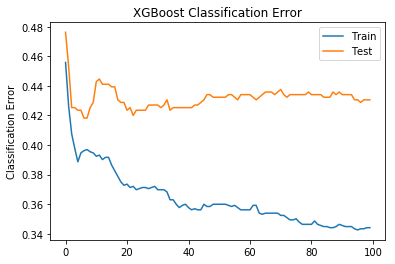

In [117]:
import matplotlib.pyplot as pyplot

df_copy = df.copy()

df_copy = remove_outliers_for_FTR(df_copy) 
df_copy = code_string_values(df_copy)
df_copy = code_FTR(df_copy)

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# fit model no training data
model = xgb.XGBClassifier(subsample= 0.9, gamma= 4, min_child_weight= 1, colsample_bytree= 0.9, max_depth= 3,learning_rate=0.35)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
print('Accuracy of xgBoost on train set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
print('Accuracy of xgBoost on test set: {:.4f}'.format(accuracy_score(y_test,y_pred)*100))
predictions = [round(value) for value in y_pred]

results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()